In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import importlib
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from flearn.utils.model_utils import read_data
import os
import importlib
import random
import numpy as np

from flearn.models import client
from flearn.models import group
from flearn.trainers import grouprox
from flearn.trainers import fedprox
from flearn.trainers import fedavg

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Instructions for updating:
non-resource variables are not supported in the long term
Num GPUs Available:  1


In [2]:
params = {}
#DATASETS = ['sent140', 'nist', 'shakespeare', 'mnist', 'synthetic_iid', 'synthetic_0_0', 'synthetic_0.5_0.5', 'synthetic_1_1']

"""
Parameters that need to be manually set
"""

params['dataset'] = 'sent140'
#params['dataset'] = 'synthetic_1_1'
#params['model'] = 'mclr'
params['model'] = 'stacked_lstm'
params['optimizer'] = 'grouprox'
params['drop_percent'] = 0

if params['dataset'].startswith('mnist'):
  params['model_params'] = (10,)
  params['learning_rate'] = 0.03
  params['mu'] = 1
  params['num_group'] = 3
if params['dataset'] == 'nist':
  params['model_params'] = (26,)
  params['learning_rate'] = 0.003
  params['mu'] = 1
  params['num_group'] = 5
if params['dataset'] == 'sent140':
  params['model_params'] = (25, 2, 100) # seq_len, num_classes, num_hidden
  params['learning_rate'] = 0.3
  params['mu'] = 0.01
  params['num_group'] = 5
if params['dataset'].startswith('synthetic'):
  params['model_params'] = (10,)
  params['learning_rate'] = 0.01
  params['mu'] = 1
  params['num_group'] = 5

if params['optimizer']  == 'fedavg':
  pass
if params['optimizer']  == 'fedprox':
  pass
if params['optimizer']  == 'grouprox':
  params['MADC'] = False                       # If false, EDC will be used
  params['proximal'] = False
  params['RAC'] = False
  params['RCC'] = False
  params['allow_empty'] = True
  params['agg_lr'] = 0.0 ########## Group Aggregataion Rate
  
  # TEST Hyperparameters, Experimental Only
  params['evenly'] = False
  params['min_clients'] = 2
    
  # We implement IFCA and FeSEM base on grouprox
  params['ifca'] = False
  params['fesem'] = False
  
  """
  We immplement IFCA and FeSEM base on grouprox,
  Some configurations should be flush for above two CFL frameworks
  """
  if params['ifca'] == True or params['fesem'] == True:
    params['proximal'] = False ### Do not modify it
    params['RAC'] = False
    params['RCC'] = False
    params['allow_empty'] = True
    params['agg_lr'] = 0.0 # IFCA and FeSEM don't use this parameter
    
"""
Common parameters
"""
params['num_rounds'] = 800
params['num_epochs'] = 20
params['batch_size'] = 10
params['eval_every'] = 1
params['clients_per_round'] = 20 ################ Important ######################
params['seed'] = 233

""" Set the output CSV file name """
info = '{}-{}-{}'.format(params['optimizer'], params['dataset'], params['model'])
info2 = ''
suffix = '.csv'
if params['optimizer'] == 'fedavg':
  pass
if params['optimizer'] == 'fedprox':
  pass
if params['optimizer'] == 'grouprox':
  if params['ifca'] == False and params['fesem'] == False:
    if params['MADC'] == True:
      info2 = info2 + '-MADC'
    else:
      info2 = info2 + '-EDC'
  if params['ifca'] == True:
    info2 = info2 + '-IFCA'
  if params['fesem'] == True:
    info2 = info2 + '-FeSEM'
  
  info2 = info2 +  '-NumG{:1d}-Agglr{:.4}-Proximal{:.1}'.format(
    params['num_group'], params['agg_lr'], str(params['proximal']))
  
  if params['RCC'] == True:
    info2 = info2 + '-RCC.{:.1}'.format(str(params['RCC']))
  
  if params['RAC'] == True:
    info2 = info2 + '-RAC.{:.1}-Evenly{:.1}'.format(str(params['RAC']), str(params['evenly']))
  elif params['allow_empty'] == True:
    info2 = info2 + '-Empty{:.1}'.format(str(params['allow_empty']))
  elif params['allow_empty'] == False:
    info2 = info2 + '-Evenly{:.1}'.format(str(params['evenly']))

params['export_filename'] = info + info2 + suffix

print(params['export_filename'])

grouprox-sent140-stacked_lstm-EDC-NumG5-Agglr0.0-ProximalF-EmptyT.csv


In [3]:
"""
Some preparations
"""

# read data
train_path = os.path.join('data', params['dataset'], 'data', 'train')
test_path = os.path.join('data', params['dataset'], 'data', 'test')
dataset = read_data(train_path, test_path)

# Load model
if params['dataset'].startswith('synthetic'):  # all synthetic datasets use the same model
  model_path = '%s.%s.%s.%s' % ('flearn', 'models', 'synthetic', params['model'])
elif params['dataset'].startswith('mnist'):
  model_path = '%s.%s.%s.%s' % ('flearn', 'models', 'mnist', params['model'])
else:
  model_path = '%s.%s.%s.%s' % ('flearn', 'models', params['dataset'], params['model'])
mod = importlib.import_module(model_path)
learner = getattr(mod, 'Model')

# Set seeds
params['sklearn_seed'] = params['seed']
random.seed(1 + params['seed'])
np.random.seed(12 + params['seed'])
tf.set_random_seed(123 + params['seed'])

# Set server
if params['optimizer'] == 'fedavg':
  server = fedavg.Server(params, learner, dataset)  
if params['optimizer'] == 'fedprox':
  server = fedprox.Server(params, learner, dataset)
if params['optimizer'] == 'grouprox':
  server = grouprox.Server(params, learner, dataset)

Using Group prox to Train
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


/home/lab/anaconda3/envs/FL/lib/python3.8/site-packages/tensorflow/python/keras/layers/legacy_rnn/rnn_cell_impl.py:702: UserWarning: `tf.nn.rnn_cell.BasicLSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  warnings.warn("`tf.nn.rnn_cell.BasicLSTMCell` is deprecated and will be "
/home/lab/anaconda3/envs/FL/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1727: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '
/home/lab/anaconda3/envs/FL/lib/python3.8/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/ho

Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

772 Clients in Total
243861 Parameters in Total


Instructions for updating:
Prefer Variable.assign which has equivalent behavior in 2.X.


Pre-training takes 16.25217890739441s seconds
SVD takes 0.39292001724243164s seconds
EDC Matrix calculation takes 0.09279465675354004s seconds
MADC Matrix calculation takes 0.1055002212524414s seconds
Clustering takes 0.02882981300354004s seconds
Clustering Results: Counter({1: 37, 0: 23, 4: 17, 3: 16, 2: 7})


In [4]:
"""
Test Ternary Similarity
"""
x, y = server.test_ternary_cosine_similariy()

Cossim_matrix shape: (772, 5)


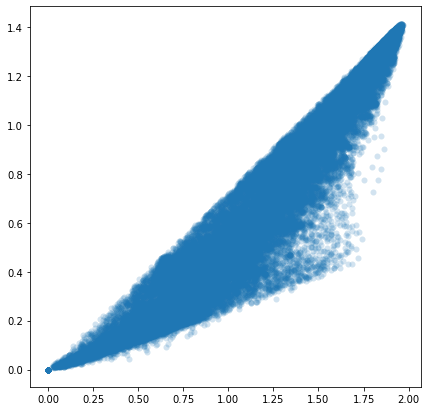

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7,7))
plt.scatter(x[:50000], y[:50000], linewidths=0.01, alpha=0.2, norm=True)
plt.show()

In [ ]:
server.train()

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]        

Training with 20 workers ---


Cold start clients takes 317.3393907546997s seconds
Group 0, clients ['m0po', 'weelissa', 'AvonteNikole', 'WooopJess', 'weeps']
Group 1, clients ['AllTheSausages', 'TinaS71', 'coriluvnthedon', 'Mrs_NickJ07', 'mneylon', 'davidj505', 'MacSheikh']
Group 2, clients ['steph_davies', 'janabelle_xo']
Group 3, clients ['maddisondesigns', 'nyc_specialist', 'schaeferj89']
Group 4, clients ['debbier93', 'Japh', 'marianaguidil']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 0 accuracy: 0.7477592829705506
At round 0 training accuracy: 0.778169014084507
At round 0 training loss: 0.5469775875614322
Group 1
At round 0 accuracy: 0.8313782991202346
At round 0 training accuracy: 0.8491147036181679
At round 0 training loss: 0.4401668095331728
Group 2
At round 0 accuracy: 0.4472843450479233
At round 0 training accuracy: 0.545609548167093
At round 0 training loss: 0.6869433688385712
Group 3
At round 0 accuracy: 0.5603448275862069
At round 0 training accuracy: 0.5888636363636364
At round 0 training loss: 0.6704381201890381
Group 4
At round 0 accuracy: 0.6615988229524277
At round 0 training accuracy: 0.6797478126608337
At round 0 training loss: 0.6337797528864242
At round 0 mean test accuracy: 0.723950966525224 mean train accuracy: 0.7487847920988265 mean train loss: 0.5468091807165856                     number of test client: 772
The client-group discrepancy are: [0.41462496 0.51323634 0.55663228 0.17539445 0.28418757 0.20884665]
Begin group  0 tra

Epoch:  10%|█         | 2/20 [00:00<00:01, 11.00it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.91it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 57.234659910202026s seconds
Group 0, clients ['Tracey_Mac', 'bexiclepop', 'webwoke', 'pearlbones']
Group 1, clients ['HelloLizzi', 'mrshananto', 'dollforlife', 'xmiyix', 'christian792', 'fuseboxradio']
Group 2, clients ['sophieholly', 'crucifire', 'thepete']
Group 3, clients ['Christyxcore', 'nyc_specialist', 'Andjelija']
Group 4, clients ['Rawrrgasmic', 'funkybrownchick', 'Whatever_Ista', 'IzzySc']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 1 accuracy: 0.7477592829705506
At round 1 training accuracy: 0.778169014084507
At round 1 training loss: 0.5414967826554473
Group 1
At round 1 accuracy: 0.8313782991202346
At round 1 training accuracy: 0.8491147036181679
At round 1 training loss: 0.5194255455561252
Group 2
At round 1 accuracy: 0.5846645367412141
At round 1 training accuracy: 0.5686274509803921
At round 1 training loss: 0.6645698791269756
Group 3
At round 1 accuracy: 0.5405172413793103
At round 1 training accuracy: 0.5593181818181818
At round 1 training loss: 0.7060690461234613
Group 4
At round 1 accuracy: 0.6390387444825895
At round 1 training accuracy: 0.6623777663407102
At round 1 training loss: 0.6295638762517989
At round 1 mean test accuracy: 0.7208863743517209 mean train accuracy: 0.7414161429146413 mean train loss: 0.5807003116480172                     number of test client: 772
The client-group discrepancy are: [1.46447341 1.12425324 1.13796819 1.92557629 1.66669913 1.79695494]
Begin group  0 t

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.04it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.89it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.65it/s] 

Begin group  4 training


Training groups takes 71.14447975158691s seconds
Group 0, clients ['irishsamom', 'shinsh0ku', 'MrTHill', 'crazymitchell']
Group 1, clients ['iamloz_JsPR', 'alyb_', 'juliarygaard', '_Alectrona_', 'NoTORIousTori', 'ashleyyosaurus']
Group 2, clients ['vesula', 'Rikou26']
Group 3, clients ['peggyrossmanith', 'NOTICEmeDAVID', 'chelseasms']
Group 4, clients ['DanielJUK', 'Upstatemomof3', 'Galiiit', 'xXMCR_LadyXx', 'claudiamcfly']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 2 accuracy: 0.7477592829705506
At round 2 training accuracy: 0.778169014084507
At round 2 training loss: 0.5334497629886582
Group 1
At round 2 accuracy: 0.8313782991202346
At round 2 training accuracy: 0.8491147036181679
At round 2 training loss: 0.519021060587616
Group 2
At round 2 accuracy: 0.5527156549520766
At round 2 training accuracy: 0.5797101449275363
At round 2 training loss: 0.6615047137247428
Group 3
At round 2 accuracy: 0.5405172413793103
At round 2 training accuracy: 0.5638636363636363
At round 2 training loss: 0.8066591735793786
Group 4
At round 2 accuracy: 0.63805787150564
At round 2 training accuracy: 0.652856407617087
At round 2 training loss: 0.7481989289834765
At round 2 mean test accuracy: 0.7194719471947195 mean train accuracy: 0.7401467537694666 mean train loss: 0.6211902979196092                     number of test client: 772
The client-group discrepancy are: [2.51260294 3.31754038 1.45243718 2.46318632 3.21272133 2.7405475 ]
Begin group  0 train

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.17it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.54it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 56.23519039154053s seconds
Group 0, clients ['MissPassion', 'LorenYxox', 'uyennguyen_', 'heyisabelle_']
Group 1, clients ['AsiaBrands', 'DaPrbmChild', 'petehopkins', 'AlexLJ', 'Matalatine', 'ElementsOfJazz', 'DustinUrbanski', 'MelFresh27']
Group 2, clients ['iamgaberosales']
Group 3, clients ['JaydDragyn']
Group 4, clients ['CaraNinaMcfly', 'Frassington', 'Rianca', 'andrewpycroft', 'xXMCR_LadyXx', 'aliefaulkner']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 3 accuracy: 0.7477592829705506
At round 3 training accuracy: 0.778169014084507
At round 3 training loss: 0.5811307826632225
Group 1
At round 3 accuracy: 0.7648093841642228
At round 3 training accuracy: 0.7819091608929946
At round 3 training loss: 0.5026591022132543
Group 2
At round 3 accuracy: 0.48881789137380194
At round 3 training accuracy: 0.577152600170503
At round 3 training loss: 0.9892280619061105
Group 3
At round 3 accuracy: 0.5137931034482759
At round 3 training accuracy: 0.5272727272727272
At round 3 training loss: 1.4125364564562386
Group 4
At round 3 accuracy: 0.5551741049534086
At round 3 training accuracy: 0.5823468862583634
At round 3 training loss: 1.1999955846632318
At round 3 mean test accuracy: 0.6667845355964168 mean train accuracy: 0.6910740270596613 mean train loss: 0.8265672725031606                     number of test client: 772
The client-group discrepancy are: [3.03837955 3.37031245 2.35761638 3.69155471 3.83507166 3.48313063]
Begin group  0 t

Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.64it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.27it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.94it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 55.83641266822815s seconds
Group 0, clients ['redvers', 'tannwick']
Group 1, clients ['Joy_Inc', 'DNiCESEOUL', 'goatkeeper7', 'mp3mad', 'DaPrbmChild', 'pensblogtweet', 'Speed2007', 'lauralovesart', 'SusanCosmos']
Group 2, clients ['janabelle_xo']
Group 3, clients ['clairabellejp', 'DivasMistress', 'sinspired']
Group 4, clients ['DanielJUK', 'OMGitsJessieLee', 'andrewpycroft', 'toastedfrenchie', 'adlyman']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.38it/s]

Group 0
At round 4 accuracy: 0.7477592829705506
At round 4 training accuracy: 0.778169014084507
At round 4 training loss: 0.5453531377961938
Group 1
At round 4 accuracy: 0.8272727272727273
At round 4 training accuracy: 0.8457274826789838
At round 4 training loss: 0.6749337030535606
Group 2
At round 4 accuracy: 0.5303514376996805
At round 4 training accuracy: 0.5575447570332481
At round 4 training loss: 1.6136723265261448
Group 3
At round 4 accuracy: 0.5137931034482759
At round 4 training accuracy: 0.5295454545454545
At round 4 training loss: 0.7496430870484222
Group 4
At round 4 accuracy: 0.6552231486022561
At round 4 training accuracy: 0.6522130725681935
At round 4 training loss: 1.0417479352505012
At round 4 mean test accuracy: 0.7174681753889675 mean train accuracy: 0.7331496331155763 mean train loss: 0.7835415056589173                     number of test client: 772
The client-group discrepancy are: [3.54748459 3.36410304 2.60448292 4.81283863 5.93272546 3.63402488]
Begin group  0 t

Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.80it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.32it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.78it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 62.03727960586548s seconds
Group 0, clients ['eysies', 'Miamoodles', 'Extremo', 'nicolalalalala', 'jonasnessica']
Group 1, clients ['stratosphear', 'alltimeASIAN', 'megspeaks', 'winniedepoohi', 'simontay78', 'mattdavey2', 'briethehippo', 'VickyMinor']
Group 2, clients ['paigeebaby']
Group 3, clients ['amysav83', 'chelseasms', 'AliciaWag']
Group 4, clients ['valenbfm', 'alwaysloveu_Ci', 'AtlantisJackson']


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.85it/s]

Group 0
At round 5 accuracy: 0.7477592829705506
At round 5 training accuracy: 0.778169014084507
At round 5 training loss: 0.6373685646170062
Group 1
At round 5 accuracy: 0.826099706744868
At round 5 training accuracy: 0.8444187836797536
At round 5 training loss: 0.8329121928351442
Group 2
At round 5 accuracy: 0.5910543130990416
At round 5 training accuracy: 0.5745950554134698
At round 5 training loss: 1.3783932168097042
Group 3
At round 5 accuracy: 0.5103448275862069
At round 5 training accuracy: 0.5120454545454546
At round 5 training loss: 1.3608083436299454
Group 4
At round 5 accuracy: 0.607650809220206
At round 5 training accuracy: 0.620560988162635
At round 5 training loss: 1.1690638633698947
At round 5 mean test accuracy: 0.7073314474304573 mean train accuracy: 0.7232422056410415 mean train loss: 0.9694161368991211                     number of test client: 772
The client-group discrepancy are: [4.0310812  3.46075604 2.99083842 6.39344907 6.25257583 4.74665329]
Begin group  0 trai

Epoch:  10%|█         | 2/20 [00:00<00:01, 11.10it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.73it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.92it/s] 

Begin group  4 training


Training groups takes 53.78699827194214s seconds
Group 0, clients ['Rubyam', 'mossyrants', 'evil_cackle', 'diiilxia', 'NikFreeman']
Group 1, clients ['vulcansmuse', 'sheryonstone', 'RandomShelly', 'LadyParadis', 'authenticstyle', 'wiseleo', 'twilightfairy', 'zoeyjordan', 'AlexTrup', 'gracieh89']
Group 2 is empty.
Group 3, clients ['__DalekCaan__']
Group 4, clients ['Japh', 'IamMaxatHotSpot', 'SpiderxBear', 'MelanieFresh27']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.25it/s]

Group 0
At round 6 accuracy: 0.7477592829705506
At round 6 training accuracy: 0.778169014084507
At round 6 training loss: 0.5407572548004463
Group 1
At round 6 accuracy: 0.8211143695014663
At round 6 training accuracy: 0.8401077752117013
At round 6 training loss: 0.5059058732980485
Group 2
At round 6 accuracy: 0.5175718849840255
At round 6 training accuracy: 0.5123614663256607
At round 6 training loss: 0.7234173987730893
Group 3
At round 6 accuracy: 0.4706896551724138
At round 6 training accuracy: 0.49977272727272726
At round 6 training loss: 1.7545246859978545
Group 4
At round 6 accuracy: 0.5929377145659637
At round 6 training accuracy: 0.596757591353577
At round 6 training loss: 1.2536533746026683
At round 6 mean test accuracy: 0.6936586515794436 mean train accuracy: 0.7118486640453264 mean train loss: 0.8702642439807685                     number of test client: 772
The client-group discrepancy are: [3.95224604 3.55644259 3.27572244 0.         7.42539452 5.27002223]
Begin group  0 t

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.12it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.10it/s] 

Begin group  4 training


Training groups takes 53.7932562828064s seconds
Group 0, clients ['NatalieGolding', 'wolfchild59', 'vickyjones91']
Group 1, clients ['PaulineMJ', 'music_flurry', 'carlos_teran', 'TinaS71', 'RandomShelly', 'briethehippo', 'ddaly9', 'megspptc', 'Commsguy']
Group 2 is empty.
Group 3, clients ['HeathCastor', 'kyoisorange', 'xoCAZZA', 'ksekher', 'AyyoItsAmandaJo']
Group 4, clients ['traciknoppe', 'alwaysloveu_Ci', 'imafanatic']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 7 accuracy: 0.6645326504481434
At round 7 training accuracy: 0.6765593561368209
At round 7 training loss: 0.6906936624900036
Group 1
At round 7 accuracy: 0.8252199413489736
At round 7 training accuracy: 0.8434949961508853
At round 7 training loss: 0.8204334079322718
Group 2
At round 7 accuracy: 0.5175718849840255
At round 7 training accuracy: 0.5123614663256607
At round 7 training loss: 0.7234173987730893
Group 3
At round 7 accuracy: 0.525
At round 7 training accuracy: 0.5229545454545454
At round 7 training loss: 1.0430142465640198
Group 4
At round 7 accuracy: 0.5929377145659637
At round 7 training accuracy: 0.6074369531652084
At round 7 training loss: 1.098549817706498
At round 7 mean test accuracy: 0.6874115983026874 mean train accuracy: 0.7001764760518902 mean train loss: 0.8901974503541291                     number of test client: 772
The client-group discrepancy are: [4.62636433 3.8730575  3.15955791 0.         7.73997061 4.5907466 ]
Begin group  0 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.47it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.30it/s] 

Begin group  4 training


Training groups takes 53.31632328033447s seconds
Group 0, clients ['fromthestars', 'ehammond84', 'DubarryMcfly']
Group 1, clients ['esmeg', 'PaulCarterJr', 'pagan_spell', 'MissGoogle', 'SandiNJ', 'koast08', 'dyeleepong', 'tweeteradder2', 'vulcansmuse', 'pdurham']
Group 2, clients ['TwistedHelen']
Group 3, clients ['kellygirl27', 'Impala_Guy', 'LiluYvett']
Group 4, clients ['MAGGIECHICKEN', 'MrsBamBam', 'rbuerckner']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 8 accuracy: 0.7477592829705506
At round 8 training accuracy: 0.778001341381623
At round 8 training loss: 0.5348349995886136
Group 1
At round 8 accuracy: 0.8067448680351906
At round 8 training accuracy: 0.8293302540415705
At round 8 training loss: 0.6317508907605814
Group 2
At round 8 accuracy: 0.5175718849840255
At round 8 training accuracy: 0.5123614663256607
At round 8 training loss: 0.7234173987730893
Group 3
At round 8 accuracy: 0.5379310344827586
At round 8 training accuracy: 0.5522727272727272
At round 8 training loss: 1.2488290229439736
Group 4
At round 8 accuracy: 0.5875429131927415
At round 8 training accuracy: 0.6092382913021102
At round 8 training loss: 0.8534264517003767
At round 8 mean test accuracy: 0.6957802923149458 mean train accuracy: 0.7176383169757578 mean train loss: 0.7545882752053032                     number of test client: 772
The client-group discrepancy are: [4.80962699 4.14953679 3.54479066 7.59847168 8.1066856  5.45916477]
Begin group  0 t

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.78it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.18it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.86it/s] 

Begin group  4 training


Training groups takes 62.51511573791504s seconds
Group 0, clients ['tweetpet', 'isdown', 'xDirtyBurdx', 'SheBeeGee']
Group 1, clients ['kissmybleep', 'Jenivere', 'effingcards', 'minette95', 'nandeb', 'makeupbylinvia', 'chaosbot', 'mOFrIz']
Group 2 is empty.
Group 3, clients ['davidrules04', 'ScottRhodie']
Group 4, clients ['smuttysteff', 'krapposelli', 'Upstatemomof3', 'Bia_Loves_NKOTB', 'jun6lee', 'KnightRid']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 9 accuracy: 0.7131882202304738
At round 9 training accuracy: 0.7416163648558015
At round 9 training loss: 0.5705058634366108
Group 1
At round 9 accuracy: 0.8134897360703812
At round 9 training accuracy: 0.8314087759815243
At round 9 training loss: 0.7352299411366106
Group 2
At round 9 accuracy: 0.5654952076677316
At round 9 training accuracy: 0.5541346973572038
At round 9 training loss: 0.7643978053041737
Group 3
At round 9 accuracy: 0.5112068965517241
At round 9 training accuracy: 0.5279545454545455
At round 9 training loss: 1.3830182618715547
Group 4
At round 9 accuracy: 0.5644923982344286
At round 9 training accuracy: 0.5579001544004117
At round 9 training loss: 1.5508262297187463
At round 9 mean test accuracy: 0.6847006129184346 mean train accuracy: 0.6976067370506827 mean train loss: 0.9903735205464953                     number of test client: 772
The client-group discrepancy are: [5.2398151  4.34700915 4.02180699 0.         8.85108742 6.25527244]
Begin group  0 

Epoch:  10%|█         | 2/20 [00:00<00:01, 10.72it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.97it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.33it/s] 

Begin group  4 training


Training groups takes 75.17980790138245s seconds
Group 0, clients ['PaulDale67', 'BrandyWandLover', 'neondeception']
Group 1, clients ['BostinBloke', 'goatkeeper7', 'Morrica', 'syarif_m2e', 'GinaLaGuardia', 'AsiaBrands', 'tynie626', 'Minerveca', 'MacSheikh', 'ashleyyosaurus']
Group 2 is empty.
Group 3, clients ['AyyoItsAmandaJo', 'lucysavagex']
Group 4, clients ['Rawrrgasmic', 'minorityx', 'MAGGIECHICKEN', 'PapiChulaa', 'bacieabbracci']


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.73it/s]

Group 0
At round 10 accuracy: 0.7426376440460948
At round 10 training accuracy: 0.7719651240778002
At round 10 training loss: 1.0296325376472797
Group 1
At round 10 accuracy: 0.7932551319648093
At round 10 training accuracy: 0.8118552732871439
At round 10 training loss: 0.7258228885962537
Group 2
At round 10 accuracy: 0.5654952076677316
At round 10 training accuracy: 0.5541346973572038
At round 10 training loss: 0.7643978053041737
Group 3
At round 10 accuracy: 0.5577586206896552
At round 10 training accuracy: 0.5475
At round 10 training loss: 1.7646331104229798
Group 4
At round 10 accuracy: 0.5934281510544385
At round 10 training accuracy: 0.6145136387030365
At round 10 training loss: 1.2561228444940702
At round 10 mean test accuracy: 0.6953088165959453 mean train accuracy: 0.711631939069321 mean train loss: 1.0524405968074717                     number of test client: 772
The client-group discrepancy are: [4.72910845 4.7136991  3.75950513 0.         6.92285901 5.80006047]
Begin group 

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.30it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.07it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.86it/s] 

Begin group  4 training


Training groups takes 56.02788758277893s seconds
Group 0, clients ['MCbutterflyfan', 'ehammond84', 'abcdefglynis', 'WooopJess']
Group 1, clients ['MichaelMcNeill', 'fuseboxradio', 'SarahRoseMusic', 'mixmasterfestus', 'xPurplexMuffinx', 'lejunkdrawer', 'wiseleo', 'nikipaniki', 'brampitoyo', 'markdavidson']
Group 2 is empty.
Group 3, clients ['LisaHopeCyrus']
Group 4, clients ['ponor', 'Broooooke_', 'KnightRid', 'neszlifeasmcrmy', 'angel9293']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 11 accuracy: 0.7477592829705506
At round 11 training accuracy: 0.778169014084507
At round 11 training loss: 0.5279886229007457
Group 1
At round 11 accuracy: 0.8299120234604106
At round 11 training accuracy: 0.8474980754426482
At round 11 training loss: 0.641225419713656
Group 2
At round 11 accuracy: 0.5654952076677316
At round 11 training accuracy: 0.5541346973572038
At round 11 training loss: 0.7643978053041737
Group 3
At round 11 accuracy: 0.5724137931034483
At round 11 training accuracy: 0.5631818181818182
At round 11 training loss: 1.040008355866779
Group 4
At round 11 accuracy: 0.5149583128984796
At round 11 training accuracy: 0.5285640761708698
At round 11 training loss: 1.1721466700218108
At round 11 mean test accuracy: 0.6941301272984441 mean train accuracy: 0.7085668286943868 mean train loss: 0.8068683754885778                     number of test client: 772
The client-group discrepancy are: [4.91789685 4.22865094 4.02680876 0.         9.34437031 6.36617505]
Be

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.04it/s] 

Begin group  1 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 11.05it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 65.22884917259216s seconds
Group 0, clients ['katherinemarsh', 'eysies', 'redvers', 'IvanaE']
Group 1, clients ['brianwelburn', 'perpetualspiral', 'KatyCaptivated', 'PaulHarriott', 'Joy_Inc', 'RGM77', 'megspptc', 'gracieh89']
Group 2 is empty.
Group 3, clients ['kellygirl27', 'nyc_specialist', 'davidrules04']
Group 4, clients ['iHaps', 'kayasmith', 'Rianca', 'hortovanyi', 'minxkitty']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 12 accuracy: 0.7477592829705506
At round 12 training accuracy: 0.778336686787391
At round 12 training loss: 0.5471205426533697
Group 1
At round 12 accuracy: 0.7521994134897361
At round 12 training accuracy: 0.7624326404926867
At round 12 training loss: 0.5514004203389823
Group 2
At round 12 accuracy: 0.5654952076677316
At round 12 training accuracy: 0.5541346973572038
At round 12 training loss: 0.7643978053041737
Group 3
At round 12 accuracy: 0.5551724137931034
At round 12 training accuracy: 0.5834090909090909
At round 12 training loss: 2.0622052451828496
Group 4
At round 12 accuracy: 0.5939185875429132
At round 12 training accuracy: 0.6058929490478642
At round 12 training loss: 1.7562037575975582
At round 12 mean test accuracy: 0.6795143800094295 mean train accuracy: 0.6957490943992074 mean train loss: 1.0540659365634426                     number of test client: 772
The client-group discrepancy are: [5.20660702 4.27844979 3.8265715  0.         5.87692769 7.75499722]


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.45it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.80it/s] 

Begin group  4 training


Training groups takes 59.87513089179993s seconds
Group 0, clients ['b1ng0bang0', 'weeps', 'Vibhy', 'abcdefglynis']
Group 1, clients ['JeniPoynter_x', 'amilya', 'Speaker99', 'AClockworkToad', 'shanajaca', 'Christiegarcia']
Group 2, clients ['paigeebaby', 'crucifire', 'eboogiee', 'xdevinnbabyy']
Group 3, clients ['koltregaskes', 'socilover']
Group 4, clients ['xXMCR_LadyXx', 'hortovanyi', 'JoshwaActon', 'mr_billiam']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 13 accuracy: 0.7439180537772087
At round 13 training accuracy: 0.7709590878604963
At round 13 training loss: 0.9741839925765724
Group 1
At round 13 accuracy: 0.6653958944281525
At round 13 training accuracy: 0.6635873749037722
At round 13 training loss: 0.6450050627968322
Group 2
At round 13 accuracy: 0.5654952076677316
At round 13 training accuracy: 0.5541346973572038
At round 13 training loss: 0.7643978053041737
Group 3
At round 13 accuracy: 0.5637931034482758
At round 13 training accuracy: 0.5752272727272727
At round 13 training loss: 1.2640800676968964
Group 4
At round 13 accuracy: 0.5203531142717018
At round 13 training accuracy: 0.5220020586721564
At round 13 training loss: 1.3996429407314364
At round 13 mean test accuracy: 0.6274163130598774 mean train accuracy: 0.633332301309638 mean train loss: 0.9760446130316849                     number of test client: 772
The client-group discrepancy are: [5.91599373 4.34348231 4.72112967 6.73169445 9.82532807 6.51043337]


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.94it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.40it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.56it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.94it/s] 

Begin group  4 training


Training groups takes 63.479156732559204s seconds
Group 0 is empty.
Group 1, clients ['KatyCaptivated', 'Nimilia1621', 'Mum_of_Six', 'vulcansmuse', 'dudeman718', 'hannahkin', 'vickymoontree', 'LittlestarRed', 'davidj505', 'tweeteradder5']
Group 2, clients ['Bopsicle']
Group 3, clients ['__DalekCaan__']
Group 4, clients ['ponor', 'Cherye101', 'theknickermafia', 'JoReynolds55', 'Bowl_the_Bunny', 'Hetty4Christ', 'rockbigdave', 'neszlifeasmcrmy']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 14 accuracy: 0.5524967989756722
At round 14 training accuracy: 0.5586854460093896
At round 14 training loss: 0.774563240848037
Group 1
At round 14 accuracy: 0.8316715542521994
At round 14 training accuracy: 0.8489607390300231
At round 14 training loss: 0.9316414184431957
Group 2
At round 14 accuracy: 0.5686900958466453
At round 14 training accuracy: 0.5515771526001705
At round 14 training loss: 1.0191140817152773
Group 3
At round 14 accuracy: 0.5405172413793103
At round 14 training accuracy: 0.565
At round 14 training loss: 1.1950414676828818
Group 4
At round 14 accuracy: 0.5507601765571358
At round 14 training accuracy: 0.5530108080288214
At round 14 training loss: 1.4502764575670384
At round 14 mean test accuracy: 0.6632484677039132 mean train accuracy: 0.674664850304963 mean train loss: 1.0664933619574144                     number of test client: 772
The client-group discrepancy are: [5.97374675 0.         4.61269732 8.31288005 6.17594576 7.35739198]
Begin group  1

Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.65it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.39it/s] 

Begin group  4 training


Training groups takes 60.82438039779663s seconds
Group 0, clients ['DrewDrew2009', 'katherinemarsh', 'tracyewilli', 'hannah106']
Group 1, clients ['ashleyyosaurus', 'clevertitania', 'Rocks4Ever', 'alyb_', 'tweeteradder3', 'jessiiemcfly', 'juliarygaard', 'gschan', 'lameymacdonald', 'Christiegarcia']
Group 2, clients ['iamgaberosales']
Group 3 is empty.
Group 4, clients ['wisdompathart', 'KnightRid', 'alwaysloveu_Ci', 'angel9293', 'DivaWonderGirl']


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.79it/s]

Group 0
At round 15 accuracy: 0.5524967989756722
At round 15 training accuracy: 0.5586854460093896
At round 15 training loss: 0.774563240848037
Group 1
At round 15 accuracy: 0.6527859237536657
At round 15 training accuracy: 0.6708237105465743
At round 15 training loss: 0.738318132047611
Group 2
At round 15 accuracy: 0.5463258785942492
At round 15 training accuracy: 0.5208866155157715
At round 15 training loss: 0.782668353549863
Group 3
At round 15 accuracy: 0.5301724137931034
At round 15 training accuracy: 0.5513636363636364
At round 15 training loss: 1.64273419636561
Group 4
At round 15 accuracy: 0.5590975968612065
At round 15 training accuracy: 0.5778435409161091
At round 15 training loss: 1.2780582705110972
At round 15 mean test accuracy: 0.5911126826968411 mean train accuracy: 0.6060249543329514 mean train loss: 0.9997033042772556                     number of test client: 772
The client-group discrepancy are: [5.22791244 4.7778018  4.60834044 7.83051882 0.         6.30662366]
Begi

Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.25it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.41it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.06it/s] 

Begin group  4 training


Training groups takes 56.804561138153076s seconds
Group 0, clients ['fromthestars', 'ericbutcher', 'andie_12', 'vickyjones91']
Group 1, clients ['markdavidson', 'VickiElam', 'clevertitania', 'koast08', 'mneylon', 'mandiebear', 'gschan', 'PaulHarriott', 'lorettak']
Group 2, clients ['jaronmc']
Group 3, clients ['nyc_specialist']
Group 4, clients ['Cherye101', 'johnhood', 'tamaryn', 'LiverpoolFan74', 'funkybrownchick']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 16 accuracy: 0.5646606914212549
At round 16 training accuracy: 0.5546613011401744
At round 16 training loss: 0.7284744667585147
Group 1
At round 16 accuracy: 0.7360703812316716
At round 16 training accuracy: 0.7447267128560431
At round 16 training loss: 0.7713848753328979
Group 2
At round 16 accuracy: 0.5591054313099042
At round 16 training accuracy: 0.5720375106564365
At round 16 training loss: 0.7127099833423423
Group 3
At round 16 accuracy: 0.5301724137931034
At round 16 training accuracy: 0.5513636363636364
At round 16 training loss: 1.64273419636561
Group 4
At round 16 accuracy: 0.5836194212849436
At round 16 training accuracy: 0.6043489449305198
At round 16 training loss: 1.287033329140232
At round 16 mean test accuracy: 0.6331918906176331 mean train accuracy: 0.6432397287841729 mean train loss: 1.0041107637657283                     number of test client: 772
The client-group discrepancy are: [5.31027868 5.15425631 3.75384956 9.57975708 4.9168547  7.46145812]
Be

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.03it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.69it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.16it/s] 

Begin group  4 training


Training groups takes 54.65288949012756s seconds
Group 0, clients ['CherylH77', 'MCbutterflyfan', 'pearlbones', 'Darth_Disco', 'antzpantz']
Group 1, clients ['ToksieOlu', 'Christiegarcia', 'mini_ritz', 'paul_steele', 'Momodel180', 'nere13', 'ItsMariahxOxO', 'hypnoticyogi']
Group 2 is empty.
Group 3, clients ['LucyAnnabel']
Group 4, clients ['coliwilso', 'bustyb73', 'hortovanyi', 'MCRmuffin', 'Kat77', 'davidismyangel']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 17 accuracy: 0.6241997439180538
At round 17 training accuracy: 0.6500670690811536
At round 17 training loss: 1.3168432086256117
Group 1
At round 17 accuracy: 0.8167155425219942
At round 17 training accuracy: 0.8369515011547344
At round 17 training loss: 0.631339380441596
Group 2
At round 17 accuracy: 0.5910543130990416
At round 17 training accuracy: 0.5839727195225917
At round 17 training loss: 1.1287831177129923
Group 3
At round 17 accuracy: 0.5137931034482759
At round 17 training accuracy: 0.5227272727272727
At round 17 training loss: 1.6419566099235618
Group 4
At round 17 accuracy: 0.5654732712113781
At round 17 training accuracy: 0.5661348430262481
At round 17 training loss: 1.27863236250978
At round 17 mean test accuracy: 0.6711456859971712 mean train accuracy: 0.68528437412923 mean train loss: 1.0694124849173814                     number of test client: 772
The client-group discrepancy are: [ 6.37003695  5.81139107  4.8659903   0.         11.29802519  8.01963934

Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.63it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 71.38165473937988s seconds
Group 0, clients ['xxLOVExxPEACE', 'irishsamom', 'atkailash', 'Bhooshan']
Group 1, clients ['SandiNJ', 'clevertitania', 'cavorting', '_MsWhite', 'sarahlay', 'FreshPlastic', 'kimalojado', '18percentgrey', 'PreternaReviews']
Group 2, clients ['jaronmc', 'vesula']
Group 3, clients ['_ophelia', 'taylormcfly', 'gerrymoth']
Group 4, clients ['sarahroters', 'Rawrrgasmic']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 18 accuracy: 0.646606914212548
At round 18 training accuracy: 0.6696847753185782
At round 18 training loss: 0.5832173603891048
Group 1
At round 18 accuracy: 0.8149560117302053
At round 18 training accuracy: 0.8353348729792148
At round 18 training loss: 0.4355441540803723
Group 2
At round 18 accuracy: 0.5910543130990416
At round 18 training accuracy: 0.5839727195225917
At round 18 training loss: 1.1287831177129923
Group 3
At round 18 accuracy: 0.4896551724137931
At round 18 training accuracy: 0.47363636363636363
At round 18 training loss: 2.497700893974186
Group 4
At round 18 accuracy: 0.5860716037273173
At round 18 training accuracy: 0.5990735975295934
At round 18 training loss: 1.0484253938395647
At round 18 mean test accuracy: 0.6762140499764262 mean train accuracy: 0.6894950308059073 mean train loss: 0.9163855100885324                     number of test client: 772
The client-group discrepancy are: [ 6.55168196  6.43044978  5.1207527   4.65767261 11.56638187  7.6052

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.11it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.27it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.89it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.08it/s] 

Begin group  4 training


Training groups takes 58.08751559257507s seconds
Group 0, clients ['niccccolle', 'NikFreeman', 'aerobic247', 'nicolalalalala']
Group 1, clients ['paluawahine', 'HOTTVampChick', 'juliarygaard', 'JJLuver756', 'shanajaca', 'lordmuttley', 'MaschaD']
Group 2, clients ['vesula']
Group 3, clients ['davidrules04', 'wickedground']
Group 4, clients ['mrhankmanthe3rd', 'kjgriffin18', 'LilahMcfly', 'Tittybird', 'MCRmuffin', 'velofille']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.41it/s]

Group 0
At round 19 accuracy: 0.6830985915492958
At round 19 training accuracy: 0.7169684775318578
At round 19 training loss: 0.6602072304977937
Group 1
At round 19 accuracy: 0.7656891495601174
At round 19 training accuracy: 0.7858352578906851
At round 19 training loss: 0.5346609805021622
Group 2
At round 19 accuracy: 0.4952076677316294
At round 19 training accuracy: 0.5831202046035806
At round 19 training loss: 1.3868720255798492
Group 3
At round 19 accuracy: 0.4706896551724138
At round 19 training accuracy: 0.49227272727272725
At round 19 training loss: 1.3826946576752446
Group 4
At round 19 accuracy: 0.510544384502207
At round 19 training accuracy: 0.5084920226453937
At round 19 training loss: 1.7555419579109948
At round 19 mean test accuracy: 0.6388495992456389 mean train accuracy: 0.6590296913217127 mean train loss: 0.9980944158045889                     number of test client: 772
The client-group discrepancy are: [6.59211225 6.35093646 4.8985238  1.77665172 9.07492965 8.70372024]

Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.37it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.98it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.18it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.17it/s] 

Begin group  4 training


Training groups takes 68.30398964881897s seconds
Group 0, clients ['emmao414', 'katherinemarsh', 'wolfchild59', 'eysies']
Group 1, clients ['AllTheSausages', 'isisproject', 'keza34', 'PaulCarterJr', 'TLM26', 'GinaLaGuardia', 'Abbie_xD']
Group 2, clients ['sabrinaxx', 'VIBEAUTY', 'MisterRo']
Group 3 is empty.
Group 4, clients ['unitechy', 'smilin808hapa', 'PercythePigeon', 'AndyCarolan', 'neurogirl07', 'Tittybird']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 20 accuracy: 0.6862996158770807
At round 20 training accuracy: 0.738430583501006
At round 20 training loss: 0.6720810802559738
Group 1
At round 20 accuracy: 0.8255131964809385
At round 20 training accuracy: 0.8434949961508853
At round 20 training loss: 0.8428365220401542
Group 2
At round 20 accuracy: 0.5271565495207667
At round 20 training accuracy: 0.566069906223359
At round 20 training loss: 1.5848566219702884
Group 3
At round 20 accuracy: 0.5439655172413793
At round 20 training accuracy: 0.5506818181818182
At round 20 training loss: 1.584715745604851
Group 4
At round 20 accuracy: 0.6110838646395291
At round 20 training accuracy: 0.633170355120947
At round 20 training loss: 1.0553108439064185
At round 20 mean test accuracy: 0.6988448844884488 mean train accuracy: 0.7235208520387628 mean train loss: 0.9904455234224406                     number of test client: 772
The client-group discrepancy are: [ 7.30400064  5.54658333  5.4909901  11.31873724  0.          8.5834228

Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.30it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.11it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 61.62564015388489s seconds
Group 0, clients ['mossyrants', 'pearlbones', 'DrewDrew2009']
Group 1, clients ['kristikubota', 'monashoj', 'Pepperfire', 'danni82', 'sunshinehollyyy', 'tweeteradder5']
Group 2, clients ['Bopsicle', 'enked']
Group 3, clients ['lina_luka', 'thisgoodlife']
Group 4, clients ['wyndwitch', 'kwells2416', 'katementon', 'davidismyangel', 'RealWorldCara', 'tamaryn', 'pageoneresults']


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.71it/s]

Group 0
At round 21 accuracy: 0.7439180537772087
At round 21 training accuracy: 0.7741448692152918
At round 21 training loss: 0.7075793419269399
Group 1
At round 21 accuracy: 0.8325513196480938
At round 21 training accuracy: 0.8469591993841417
At round 21 training loss: 0.6231864344463071
Group 2
At round 21 accuracy: 0.549520766773163
At round 21 training accuracy: 0.5950554134697357
At round 21 training loss: 0.9249683045873455
Group 3
At round 21 accuracy: 0.5439655172413793
At round 21 training accuracy: 0.5506818181818182
At round 21 training loss: 1.584715745604851
Group 4
At round 21 accuracy: 0.6194212849435998
At round 21 training accuracy: 0.6161863098301595
At round 21 training loss: 1.2388229874977426
At round 21 mean test accuracy: 0.7151107967939652 mean train accuracy: 0.7284745657760302 mean train loss: 0.9288542784446748                     number of test client: 772
The client-group discrepancy are: [ 7.47508785  4.89104312  5.7887698   8.83456764 12.01317776  8.34293

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.10it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 60.58501148223877s seconds
Group 0, clients ['kittenspawn', 'hannah106', 'AvonteNikole']
Group 1, clients ['thalovebug', 'privatestudmuff', 'tweeteradder3', 'ATsLady', 'tweeteradder10', 'YvetteObeney', 'gracieh89', 'NoTORIousTori', 'sarahmarina']
Group 2, clients ['TwistedHelen', 'mannykimchi']
Group 3, clients ['LisaHopeCyrus', 'chelseasms']
Group 4, clients ['eatlikeagirl', 'MelanieFresh27', 'DanielJUK', 'IzzySc']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.99it/s]

Group 0
At round 22 accuracy: 0.6197183098591549
At round 22 training accuracy: 0.6804158283031523
At round 22 training loss: 1.2604544067135084
Group 1
At round 22 accuracy: 0.7932551319648093
At round 22 training accuracy: 0.8086220169361047
At round 22 training loss: 0.7440667255549567
Group 2
At round 22 accuracy: 0.5463258785942492
At round 22 training accuracy: 0.5814151747655584
At round 22 training loss: 1.7152122117686963
Group 3
At round 22 accuracy: 0.5568965517241379
At round 22 training accuracy: 0.5654545454545454
At round 22 training loss: 1.422682671011849
Group 4
At round 22 accuracy: 0.6351152525747915
At round 22 training accuracy: 0.6408903757076686
At round 22 training loss: 1.164580528730286
At round 22 mean test accuracy: 0.6818717586044318 mean train accuracy: 0.7032106257159665 mean train loss: 1.0683192790100886                     number of test client: 772
The client-group discrepancy are: [7.38599617 6.99955033 5.78811163 9.95087746 9.04050288 9.16137677]
B

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.13it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.57it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.85it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.39it/s] 

Begin group  4 training


Training groups takes 63.69226908683777s seconds
Group 0, clients ['LexiStarGirl', 'KJL912']
Group 1, clients ['AussieGal999', 'christian792', 'McDayDreamer', 'theanand', 'robcthegeek', 'JonasAustralia', 'StampfliTurci', 'RGM77', 'markable']
Group 2, clients ['AshyJonas', 'sabrinaxx']
Group 3, clients ['Andjelija', 'erin82883', 'zenjar']
Group 4, clients ['marianaguidil', 'InTheLittleWood', 'katjrobertson', 'LauraLxox']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.90it/s]

Group 0
At round 23 accuracy: 0.7183098591549296
At round 23 training accuracy: 0.7391012743125419
At round 23 training loss: 0.7212639303589371
Group 1
At round 23 accuracy: 0.7967741935483871
At round 23 training accuracy: 0.8115473441108545
At round 23 training loss: 0.6835927686454001
Group 2
At round 23 accuracy: 0.5015974440894568
At round 23 training accuracy: 0.5311167945439045
At round 23 training loss: 1.513007194184891
Group 3
At round 23 accuracy: 0.5362068965517242
At round 23 training accuracy: 0.5461363636363636
At round 23 training loss: 1.6662387478351592
Group 4
At round 23 accuracy: 0.6233447768513978
At round 23 training accuracy: 0.6523417395779723
At round 23 training loss: 1.2225129746448975
At round 23 mean test accuracy: 0.6941301272984441 mean train accuracy: 0.7135205424316542 mean train loss: 0.9842121091537871                     number of test client: 772
The client-group discrepancy are: [ 8.49564475  8.30077085  6.19667044  8.65458456 12.80626109 10.4533

Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.17it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.16it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.39it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.93it/s] 

Begin group  4 training


Training groups takes 54.59107327461243s seconds
Group 0, clients ['DrewDrew2009', 'ashleeadams']
Group 1, clients ['xxxSupermodel', 'hypnoticyogi', 'Aw_Re_ya_2_', 'privatestudmuff', 'sarahlay', 'tweeteradder1']
Group 2 is empty.
Group 3, clients ['HeathCastor', 'jerryfetus', 'Impala_Guy']
Group 4, clients ['JoReynolds55', 'sarahroters', 'unitechy', 'Deejaywilliams', 'Itxi_Itx', 'OMGitsJessieLee', 'NaythenCash', 'jun6lee', 'neszlifeasmcrmy']


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.53it/s]

Group 0
At round 24 accuracy: 0.34891165172855315
At round 24 training accuracy: 0.33215962441314556
At round 24 training loss: 0.7823025680463799
Group 1
At round 24 accuracy: 0.826099706744868
At round 24 training accuracy: 0.8404157043879907
At round 24 training loss: 0.838422764926438
Group 2
At round 24 accuracy: 0.4952076677316294
At round 24 training accuracy: 0.5558397271952259
At round 24 training loss: 1.2558546725593869
Group 3
At round 24 accuracy: 0.5043103448275862
At round 24 training accuracy: 0.5227272727272727
At round 24 training loss: 1.0375192707099699
Group 4
At round 24 accuracy: 0.6419813634134379
At round 24 training accuracy: 0.6742151312403499
At round 24 training loss: 1.1066552442884359
At round 24 mean test accuracy: 0.6377887788778878 mean train accuracy: 0.6529613919935602 mean train loss: 0.934886253842806                     number of test client: 772
The client-group discrepancy are: [ 7.09299561  6.27632745  4.55760551  0.         10.99843751  7.6629

Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.83it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.58it/s] 

Begin group  4 training


Training groups takes 58.911704778671265s seconds
Group 0, clients ['KJL912']
Group 1, clients ['redLIGHTjoli', 'iamluvnjordan', 'clevertitania', 'xmiyix', 'AZBlueEyes', 'mrshananto', 'ialejandro', 'sunshinehollyyy']
Group 2, clients ['xdevinnbabyy', 'Rikou26']
Group 3, clients ['Monicarrrr', 'Lyricist_Juice']
Group 4, clients ['I_Support_DemiL', 'sharonhayes', 'krapposelli', 'MrsBamBam', 'debbier93', 'CaraNinaMcfly', 'mizsedz']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.43it/s]

Group 0
At round 25 accuracy: 0.6126760563380281
At round 25 training accuracy: 0.6257545271629779
At round 25 training loss: 0.8731101405132864
Group 1
At round 25 accuracy: 0.8214076246334311
At round 25 training accuracy: 0.8362586605080832
At round 25 training loss: 0.8521108610296833
Group 2
At round 25 accuracy: 0.4952076677316294
At round 25 training accuracy: 0.5558397271952259
At round 25 training loss: 1.2558546725593869
Group 3
At round 25 accuracy: 0.5362068965517242
At round 25 training accuracy: 0.5279545454545455
At round 25 training loss: 0.9809240676191721
Group 4
At round 25 accuracy: 0.6199117214320745
At round 25 training accuracy: 0.651183736489964
At round 25 training loss: 0.9046534728364299
At round 25 mean test accuracy: 0.6835219236209336 mean train accuracy: 0.700671847425617 mean train loss: 0.9008421060131298                     number of test client: 772
The client-group discrepancy are: [ 8.20150057  3.41604509  5.42855373 10.49018349 13.83081427  9.79193

Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.18it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.40it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.09it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.65it/s] 

Begin group  4 training


Training groups takes 63.83535432815552s seconds
Group 0 is empty.
Group 1, clients ['littlefluffycat', 'paluawahine', 'ItsMariahxOxO', 'SarahSee95', 'mrshananto', 'davidj505', 'Knot2serious', 'epcotx', 'esmeg', 'HOTTVampChick', 'Minerveca', 'dogzero']
Group 2, clients ['nathanrdotca']
Group 3, clients ['JaydDragyn', 'socilover', 'sweetcherrypop', 'schaeferj89']
Group 4, clients ['iHaps', 'katjrobertson', 'sheonpoint']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 26 accuracy: 0.7029449423815621
At round 26 training accuracy: 0.7318913480885312
At round 26 training loss: 0.6242606600123132
Group 1
At round 26 accuracy: 0.7888563049853372
At round 26 training accuracy: 0.8037721324095458
At round 26 training loss: 0.5975493679578424
Group 2
At round 26 accuracy: 0.46006389776357826
At round 26 training accuracy: 0.5737425404944586
At round 26 training loss: 1.1358073078356334
Group 3
At round 26 accuracy: 0.49310344827586206
At round 26 training accuracy: 0.5
At round 26 training loss: 1.0575846588476139
Group 4
At round 26 accuracy: 0.6419813634134379
At round 26 training accuracy: 0.6534997426659804
At round 26 training loss: 0.926346069304402
At round 26 mean test accuracy: 0.6851720886374352 mean train accuracy: 0.7046038577045729 mean train loss: 0.763816000115803                     number of test client: 772
The client-group discrepancy are: [ 7.20254292  0.          4.83242936 12.9712985  12.83022998  7.25649587]
Begin gr

Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.48it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.06it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.76it/s] 

Begin group  4 training


Training groups takes 59.53313636779785s seconds
Group 0, clients ['pearlbones', 'PaulDale67', 'ericbutcher', 'Jenniewrenbird']
Group 1, clients ['lameymacdonald', 'imnangl', 'MelFresh27', 'tweetieelovee', 'markable', 'lordmuttley', 'TeamUKskyvixen', 'HelloLizzi', 'steffy213']
Group 2, clients ['vesula', 'mnstrsnmnchkns']
Group 3, clients ['gerrymoth', 'kellygirl27', 'callyyyy']
Group 4, clients ['Hybrid911', 'RockstarAtHeart']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 27 accuracy: 0.7029449423815621
At round 27 training accuracy: 0.7318913480885312
At round 27 training loss: 0.6242606600123132
Group 1
At round 27 accuracy: 0.8058651026392962
At round 27 training accuracy: 0.8244803695150116
At round 27 training loss: 0.7052401232426712
Group 2
At round 27 accuracy: 0.48881789137380194
At round 27 training accuracy: 0.545609548167093
At round 27 training loss: 0.8001866530172863
Group 3
At round 27 accuracy: 0.5155172413793103
At round 27 training accuracy: 0.524090909090909
At round 27 training loss: 1.4461357559805568
Group 4
At round 27 accuracy: 0.6140264835703776
At round 27 training accuracy: 0.6196603190941843
At round 27 training loss: 1.3227597648067935
At round 27 mean test accuracy: 0.6894153701084395 mean train accuracy: 0.7070497538623487 mean train loss: 0.9432572197163337                     number of test client: 772
The client-group discrepancy are: [ 7.7263695   7.36251119  5.43006398 10.14562234 11.04328443 11.3928

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.03it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 62.005101919174194s seconds
Group 0, clients ['crrystalbabe', 'serinurshira', 'gewoonlianne', 'webwoke']
Group 1, clients ['Lil_Miss_Clumsy', 'Nimilia1621', 'garyshort', 'AussieGal999', 'DNiCESEOUL', 'mrshananto']
Group 2 is empty.
Group 3, clients ['limeice', 'jerryfetus', 'damarisens', 'kels450']
Group 4, clients ['smuttysteff', 'xamylouise', 'froggie775', 'Kitt69', 'dannybrown', 'Arhum']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 28 accuracy: 0.70550576184379
At round 28 training accuracy: 0.7233400402414487
At round 28 training loss: 0.6447296646804037
Group 1
At round 28 accuracy: 0.8134897360703812
At round 28 training accuracy: 0.8297151655119323
At round 28 training loss: 0.6548238141852767
Group 2
At round 28 accuracy: 0.4728434504792332
At round 28 training accuracy: 0.5635123614663257
At round 28 training loss: 1.0965818453576965
Group 3
At round 28 accuracy: 0.5120689655172413
At round 28 training accuracy: 0.5418181818181819
At round 28 training loss: 1.3060577202791517
Group 4
At round 28 accuracy: 0.510544384502207
At round 28 training accuracy: 0.5281780751415337
At round 28 training loss: 0.857650805995198
At round 28 mean test accuracy: 0.667020273455917 mean train accuracy: 0.6886281309018855 mean train loss: 0.8065245241167899                     number of test client: 772
The client-group discrepancy are: [ 9.38030869  9.84990664  4.70085704  0.         12.65882661 11.56101641

Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.64it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.29it/s] 

Begin group  4 training


Training groups takes 75.62742400169373s seconds
Group 0, clients ['Cass_fryer', 'SheBeeGee']
Group 1, clients ['AZBlueEyes', 'carlos_teran', 'KINGmoney', 'TLM26', 'makeupbylinvia', 'brianwelburn', 'Sharonyy', 'MummaBear', 'koast08', 'dreadw', 'oldskool90', 'mini_ritz']
Group 2, clients ['TwistedHelen', 'paigeebaby']
Group 3, clients ['iLadySyncere', 'MsStaceyK']
Group 4, clients ['TinyPicTweets', 'mizsedz']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.02it/s]

Group 0
At round 29 accuracy: 0.5768245838668374
At round 29 training accuracy: 0.5835010060362174
At round 29 training loss: 1.220953795111955
Group 1
At round 29 accuracy: 0.8158357771260997
At round 29 training accuracy: 0.8337182448036952
At round 29 training loss: 0.637034568748705
Group 2
At round 29 accuracy: 0.4728434504792332
At round 29 training accuracy: 0.5635123614663257
At round 29 training loss: 1.0965818453576965
Group 3
At round 29 accuracy: 0.5603448275862069
At round 29 training accuracy: 0.5827272727272728
At round 29 training loss: 0.9929203888909384
Group 4
At round 29 accuracy: 0.5615497793035802
At round 29 training accuracy: 0.5939269171384457
At round 29 training loss: 1.1928706768779367
At round 29 mean test accuracy: 0.6631305987741631 mean train accuracy: 0.6858107062138147 mean train loss: 0.9437746864767766                     number of test client: 772
The client-group discrepancy are: [ 7.51352243  9.58192943  5.54258916  8.14655146 15.33131098  8.81989

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.70it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.20it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.13it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.44it/s] 

Begin group  4 training


Training groups takes 66.93915843963623s seconds
Group 0, clients ['PinkTribble', 'abcdefglynis', 'Shinybiscuit']
Group 1, clients ['tweeteradder2', 'LadyParadis', 'karenstrunks', 'ninirific', 'paul_steele', 'kimalojado', 'kevmer', 'xPurplexMuffinx', 'shellrawlins']
Group 2 is empty.
Group 3, clients ['LisaHopeCyrus', 'ambienteer']
Group 4, clients ['txcranberry', 'katjrobertson', 'tifpez', 'Dot12b', 'ThomasGudgeon', 'queenbmakeup']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 30 accuracy: 0.6395646606914213
At round 30 training accuracy: 0.6649899396378269
At round 30 training loss: 1.2994923948602017
Group 1
At round 30 accuracy: 0.7703812316715543
At round 30 training accuracy: 0.7772132409545804
At round 30 training loss: 0.5502751976660266
Group 2
At round 30 accuracy: 0.5143769968051118
At round 30 training accuracy: 0.5720375106564365
At round 30 training loss: 1.7082539684530618
Group 3
At round 30 accuracy: 0.5396551724137931
At round 30 training accuracy: 0.5897727272727272
At round 30 training loss: 1.2032334034517407
Group 4
At round 30 accuracy: 0.6032368808239333
At round 30 training accuracy: 0.6109109624292332
At round 30 training loss: 1.4731740698149323
At round 30 mean test accuracy: 0.6651343705799151 mean train accuracy: 0.6834886528994706 mean train loss: 1.0416968083040554                     number of test client: 772
The client-group discrepancy are: [ 8.87735834  9.73690761  6.16524598  0.         12.69684957 11.242

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.14it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.76it/s] 

Begin group  4 training


Training groups takes 72.17358613014221s seconds
Group 0, clients ['kittenspawn']
Group 1, clients ['ninirific', 'nikhilnulkar', 'iamloz_JsPR', 'clevertitania', 'Rocks4Ever', 'LittlestarRed', 'AClockworkToad', 'combustiblesong', 'privatestudmuff', 'nere13']
Group 2 is empty.
Group 3, clients ['Froosh', 'peytonluvsjoe', 'Christyxcore']
Group 4, clients ['YoungA2985', 'rbuerckner', 'MiraCraigFan', 'Trace027', 'YourSavvyVA', 'bustyb73']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.53it/s]

Group 0
At round 31 accuracy: 0.7087067861715749
At round 31 training accuracy: 0.7391012743125419
At round 31 training loss: 0.5778839285994519
Group 1
At round 31 accuracy: 0.567741935483871
At round 31 training accuracy: 0.5789068514241724
At round 31 training loss: 1.2045355230244343
Group 2
At round 31 accuracy: 0.5143769968051118
At round 31 training accuracy: 0.5720375106564365
At round 31 training loss: 1.7082539684530618
Group 3
At round 31 accuracy: 0.5379310344827586
At round 31 training accuracy: 0.5563636363636364
At round 31 training loss: 1.3929379802603614
Group 4
At round 31 accuracy: 0.537027954879843
At round 31 training accuracy: 0.5410447761194029
At round 31 training loss: 1.2280039561896121
At round 31 mean test accuracy: 0.5802687411598303 mean train accuracy: 0.5960556054367008 mean train loss: 1.1384306622465472                     number of test client: 772
The client-group discrepancy are: [ 8.8119584   6.1859829   5.19332375  0.         16.54789512 11.41271

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.84it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.98it/s] 

Begin group  4 training


Training groups takes 56.52056837081909s seconds
Group 0, clients ['chinatheblack', 'WallTweet']
Group 1, clients ['michxxblc', 'harisn', 'Commsguy', 'alltimeASIAN', 'nikhilnulkar', 'Tisyonk', 'shawnlimtianjun', 'MaschaD']
Group 2 is empty.
Group 3, clients ['xoxmillyxox', 'Paiige__', 'kyoisorange']
Group 4, clients ['CannonGod', 'BlueEyedGirl18', 'angel9293', 'kayasmith', 'Sazchik', 'rbuerckner', 'SandyCalico']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 32 accuracy: 0.7477592829705506
At round 32 training accuracy: 0.778169014084507
At round 32 training loss: 0.5347351431796649
Group 1
At round 32 accuracy: 0.6967741935483871
At round 32 training accuracy: 0.7023864511162433
At round 32 training loss: 0.8100582733116557
Group 2
At round 32 accuracy: 0.5143769968051118
At round 32 training accuracy: 0.5720375106564365
At round 32 training loss: 1.7082539684530618
Group 3
At round 32 accuracy: 0.528448275862069
At round 32 training accuracy: 0.5568181818181818
At round 32 training loss: 1.383785668543794
Group 4
At round 32 accuracy: 0.6532614026483571
At round 32 training accuracy: 0.6649511065362841
At round 32 training loss: 1.071623360300058
At round 32 mean test accuracy: 0.665959453088166 mean train accuracy: 0.6828075172605963 mean train loss: 0.9329364056807367                     number of test client: 772
The client-group discrepancy are: [ 9.54588898 10.86487775  6.33740177  0.         15.91307836 10.10708211

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.00it/s] 

Begin group  4 training


Training groups takes 64.56100606918335s seconds
Group 0, clients ['I_enigma', 'Lizloz', 'mariaeduardab']
Group 1, clients ['mixmasterfestus', 'kateblogs', 'TaylaMe3', 'Minerveca', 'holidaycarclub', 'Wendywitwoo', 'LadyProducHer', 'McDayDreamer', 'imnangl', 'shellrawlins']
Group 2, clients ['VIBEAUTY']
Group 3, clients ['JBnVFCLover786', 'LiluYvett']
Group 4, clients ['valenbfm', 'RealWorldCara', 'queenbmakeup', 'pawsthejaws']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 33 accuracy: 0.7477592829705506
At round 33 training accuracy: 0.7774983232729712
At round 33 training loss: 1.0803244540252048
Group 1
At round 33 accuracy: 0.7539589442815249
At round 33 training accuracy: 0.7744418783679754
At round 33 training loss: 0.7658490183429868
Group 2
At round 33 accuracy: 0.5143769968051118
At round 33 training accuracy: 0.5720375106564365
At round 33 training loss: 1.7082539684530618
Group 3
At round 33 accuracy: 0.5396551724137931
At round 33 training accuracy: 0.5443181818181818
At round 33 training loss: 1.0977711095593192
Group 4
At round 33 accuracy: 0.5507601765571358
At round 33 training accuracy: 0.5454194544518786
At round 33 training loss: 1.5324420159355734
At round 33 mean test accuracy: 0.6658415841584159 mean train accuracy: 0.6811975602959844 mean train loss: 1.0878215402021563                     number of test client: 772
The client-group discrepancy are: [ 8.593978   10.95074675  6.37247979  8.2093352  15.92000749  8.813

Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.87it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.78it/s] 

Begin group  4 training


Training groups takes 69.32451701164246s seconds
Group 0, clients ['purplepleather', 'photokitty', 'andie_12']
Group 1, clients ['gschan', 'Keels_90', 'winniedepoohi', 'amieewhitney', 'aprilyim', 'xPurplexMuffinx', 'writesfortea', 'DaPrbmChild', 'OHMYDAYSitsHayz']
Group 2, clients ['vesula']
Group 3, clients ['koltregaskes', '_writersblock_']
Group 4, clients ['katjrobertson', 'MAGGIECHICKEN', 'SpiderxBear', 'VioletsCRUK', 'sheonpoint']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 34 accuracy: 0.7471190781049936
At round 34 training accuracy: 0.7773306505700872
At round 34 training loss: 0.7364050890621995
Group 1
At round 34 accuracy: 0.8049853372434017
At round 34 training accuracy: 0.823941493456505
At round 34 training loss: 0.8480304627249766
Group 2
At round 34 accuracy: 0.5271565495207667
At round 34 training accuracy: 0.5839727195225917
At round 34 training loss: 1.7365889911955097
Group 3
At round 34 accuracy: 0.5224137931034483
At round 34 training accuracy: 0.5418181818181819
At round 34 training loss: 1.4228876990215344
Group 4
At round 34 accuracy: 0.5350662089259441
At round 34 training accuracy: 0.5599588265568708
At round 34 training loss: 0.792695307319028
At round 34 mean test accuracy: 0.6805752003771806 mean train accuracy: 0.7046657791262887 mean train loss: 0.9246846141618927                     number of test client: 772
The client-group discrepancy are: [ 8.87697676  9.9880206   7.42786112  4.22000363 16.32847718  8.76955

Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.71it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.70it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.74it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.73it/s] 

Begin group  4 training


Training groups takes 71.2459363937378s seconds
Group 0, clients ['dannisaywhat', 'crazymitchell', 'magicswebpage', 'suebrody1', 'DubarryMcfly', 'gabbydario']
Group 1, clients ['redLIGHTjoli', 'markdavidson', 'SusanCosmos', 'sarahlay', 'Mrs_NickJ07', 'shellrawlins', 'tynie626', 'tweetles']
Group 2, clients ['steph_davies']
Group 3, clients ['kat_n', 'kalpik']
Group 4, clients ['sharonhayes', 'Trace027', 'sheonpoint']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 35 accuracy: 0.7272727272727273
At round 35 training accuracy: 0.7513413816230717
At round 35 training loss: 0.587235492677256
Group 1
At round 35 accuracy: 0.6410557184750734
At round 35 training accuracy: 0.6403387220939184
At round 35 training loss: 0.8637043271275427
Group 2
At round 35 accuracy: 0.4984025559105431
At round 35 training accuracy: 0.5814151747655584
At round 35 training loss: 1.777282932125455
Group 3
At round 35 accuracy: 0.5396551724137931
At round 35 training accuracy: 0.5952272727272727
At round 35 training loss: 1.442034445554018
Group 4
At round 35 accuracy: 0.6086316821971555
At round 35 training accuracy: 0.6415337107565621
At round 35 training loss: 1.2333849365686365
At round 35 mean test accuracy: 0.63000942951438 mean train accuracy: 0.6528375491501285 mean train loss: 1.0135720565511692                     number of test client: 772
The client-group discrepancy are: [ 9.35757061 11.01365235  6.30544512 14.40049071 18.75630052  6.23761513

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 72.85046339035034s seconds
Group 0, clients ['_strokemyEGO', 'EmAllTimeLow', 'crazymitchell', 'evil_cackle', 'MissDibbs', 'TeeQ2', 'exortabreedoll']
Group 1, clients ['jj38girl', 'TinchenFFM', 'treewatcher21', 'gracieh89', 'twliciousness', 'tweeteradder1']
Group 2 is empty.
Group 3, clients ['koltregaskes', 'guilty_', 'Nikkers']
Group 4, clients ['JenWojcik', 'minorityx', 'Kat77', 'bacieabbracci']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.41it/s]

Group 0
At round 36 accuracy: 0.7093469910371318
At round 36 training accuracy: 0.7550301810865191
At round 36 training loss: 0.6570421273262308
Group 1
At round 36 accuracy: 0.8085043988269794
At round 36 training accuracy: 0.8240954580446497
At round 36 training loss: 0.7222889208556624
Group 2
At round 36 accuracy: 0.5399361022364217
At round 36 training accuracy: 0.5831202046035806
At round 36 training loss: 0.9934904966995641
Group 3
At round 36 accuracy: 0.5224137931034483
At round 36 training accuracy: 0.5611363636363637
At round 36 training loss: 1.4081685416417367
Group 4
At round 36 accuracy: 0.6331535066208926
At round 36 training accuracy: 0.6626351003602676
At round 36 training loss: 1.4051226467638058
At round 36 mean test accuracy: 0.6990806223479491 mean train accuracy: 0.7279172729805876 mean train loss: 0.9778337247527547                     number of test client: 772
The client-group discrepancy are: [10.45499296 10.23399821  7.47791792  0.         15.13918528 11.794

Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.33it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.56it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.79it/s] 

Begin group  4 training


Training groups takes 57.85053753852844s seconds
Group 0, clients ['magicswebpage', 'suebrody1', 'eysies']
Group 1, clients ['tweeteradder1', 'OHMYDAYSitsHayz', 'teachernz', 'hypnoticyogi', 'MarilynM', 'Arasphere', 'Avril4everr', 'makeupbylinvia', 'shellrawlins', 'DaPrbmChild', 'christian792', 'AClockworkToad', 'paul_steele', '18percentgrey']
Group 2 is empty.
Group 3, clients ['socilover', 'lawschoolninja']
Group 4, clients ['CannonGod']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 37 accuracy: 0.5492957746478874
At round 37 training accuracy: 0.5699195171026157
At round 37 training loss: 0.8161773071652447
Group 1
At round 37 accuracy: 0.8234604105571848
At round 37 training accuracy: 0.8414164742109315
At round 37 training loss: 0.7664615027508802
Group 2
At round 37 accuracy: 0.5399361022364217
At round 37 training accuracy: 0.5831202046035806
At round 37 training loss: 0.9934904966995641
Group 3
At round 37 accuracy: 0.5146551724137931
At round 37 training accuracy: 0.5511363636363636
At round 37 training loss: 1.140358983765949
Group 4
At round 37 accuracy: 0.6120647376164786
At round 37 training accuracy: 0.6339423571796191
At round 37 training loss: 1.2959384967678917
At round 37 mean test accuracy: 0.6694955209806694 mean train accuracy: 0.6924362983374098 mean train loss: 0.9622277550000394                     number of test client: 772
The client-group discrepancy are: [ 6.12577498  4.48187454  5.01411605  0.         16.24883875  6.3745

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.89it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.20it/s] 

Begin group  4 training


Training groups takes 64.48670840263367s seconds
Group 0, clients ['webmaster_paul', 'wolfchild59', 'evil_cackle', 'BrandyWandLover']
Group 1, clients ['frankparker', 'HelloLizzi', 'michxxblc', 'MichaelMcNeill', 'Mixaelala', 'LadyProducHer', 'Christiegarcia', 'AussieGal999']
Group 2 is empty.
Group 3, clients ['elenarr', 'iLadySyncere', 'DirtyRose17', 'taylormcfly', 'LisaHopeCyrus']
Group 4, clients ['4evaurgirl', 'katementon', 'Deejaywilliams']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 38 accuracy: 0.6517285531370038
At round 38 training accuracy: 0.6748826291079812
At round 38 training loss: 0.8649822656267605
Group 1
At round 38 accuracy: 0.787683284457478
At round 38 training accuracy: 0.8079291762894534
At round 38 training loss: 0.7870556658163708
Group 2
At round 38 accuracy: 0.5399361022364217
At round 38 training accuracy: 0.5831202046035806
At round 38 training loss: 0.9934904966995641
Group 3
At round 38 accuracy: 0.5120689655172413
At round 38 training accuracy: 0.5279545454545455
At round 38 training loss: 1.619247396893122
Group 4
At round 38 accuracy: 0.5345757724374693
At round 38 training accuracy: 0.5371847658260422
At round 38 training loss: 1.7407754622742522
At round 38 mean test accuracy: 0.654997642621405 mean train accuracy: 0.671909347038608 mean train loss: 1.1517993474382016                     number of test client: 772
The client-group discrepancy are: [ 9.60526967  8.34961755  5.98674551  0.         15.46772095 11.1581181

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.42it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.95it/s] 

Begin group  4 training


Training groups takes 67.89502787590027s seconds
Group 0, clients ['b1ng0bang0', 'hannah106', 'nicolalalalala']
Group 1, clients ['RabbiShaiSpecht', 'jenjeahaly', 'ImmaChocoholic', 'paluawahine', '_Alectrona_', 'letteapplejuice', 'jj38girl', 'combustiblesong']
Group 2, clients ['amalinaaa']
Group 3, clients ['taluta', 'JBnVFCLover786']
Group 4, clients ['smuttysteff', 'Dot12b', 'unitechy', 'IdolFanatic', 'Bowl_the_Bunny', 'smilin808hapa']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 39 accuracy: 0.6626120358514724
At round 39 training accuracy: 0.7008718980549966
At round 39 training loss: 0.6564580841598336
Group 1
At round 39 accuracy: 0.7988269794721408
At round 39 training accuracy: 0.8139337952270977
At round 39 training loss: 0.7320041012536739
Group 2
At round 39 accuracy: 0.5399361022364217
At round 39 training accuracy: 0.5831202046035806
At round 39 training loss: 0.9934904966995641
Group 3
At round 39 accuracy: 0.5586206896551724
At round 39 training accuracy: 0.5627272727272727
At round 39 training loss: 1.2444803579016166
Group 4
At round 39 accuracy: 0.5311427170181462
At round 39 training accuracy: 0.5454194544518786
At round 39 training loss: 1.37471488757012
At round 39 mean test accuracy: 0.667020273455917 mean train accuracy: 0.6858416669246726 mean train loss: 0.9520174408744898                     number of test client: 772
The client-group discrepancy are: [ 9.49308789  8.80081959  7.42829318 15.60591993 13.89827736 10.105079

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.52it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.96it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.05it/s] 

Begin group  4 training


Training groups takes 62.42586374282837s seconds
Group 0, clients ['heyisabelle_', 'davidbarrett1', 'meghornby', 'thatlass']
Group 1, clients ['treewatcher21', 'xmiyix', 'frankparker', 'lauralovesart', 'KINGmoney']
Group 2 is empty.
Group 3, clients ['chelseasms', 'limeice', 'guilty_', 'elenarr']
Group 4, clients ['aliefaulkner', 'rbuerckner', 'krapposelli', 'suddentwilight', 'JoReynolds55', 'Deejaywilliams', 'imafanatic']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.84it/s]

Group 0
At round 40 accuracy: 0.704865556978233
At round 40 training accuracy: 0.7421193829644533
At round 40 training loss: 0.5931996932661749
Group 1
At round 40 accuracy: 0.7903225806451613
At round 40 training accuracy: 0.8099307159353348
At round 40 training loss: 0.7351670841755883
Group 2
At round 40 accuracy: 0.5079872204472844
At round 40 training accuracy: 0.5890878090366581
At round 40 training loss: 0.7361052051021416
Group 3
At round 40 accuracy: 0.55
At round 40 training accuracy: 0.5863636363636363
At round 40 training loss: 1.4662100049514661
Group 4
At round 40 accuracy: 0.579205492888671
At round 40 training accuracy: 0.5949562532166752
At round 40 training loss: 1.2918579949126436
At round 40 mean test accuracy: 0.6805752003771806 mean train accuracy: 0.7072045574166382 mean train loss: 0.9425294640054704                     number of test client: 772
The client-group discrepancy are: [ 9.08861824 12.25712851  4.8993181   0.          9.28664953 10.15723744]
Begin gro

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.22it/s] 

Begin group  4 training


Training groups takes 57.71444845199585s seconds
Group 0, clients ['shinsh0ku', 'ashleeadams', 'aurihunter', 'iellie']
Group 1, clients ['pensblogtweet', 'robcthegeek', 'JJLuver756', 'YvetteObeney', 'amilya', 'megelder']
Group 2, clients ['amalinaaa', 'hanaames']
Group 3, clients ['caseysevenfold']
Group 4, clients ['PapiChulaa', 'suddentwilight', 'AndyCarolan', 'tifpez', 'aliefaulkner', 'jun6lee', 'DeejayKnight']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 41 accuracy: 0.706145966709347
At round 41 training accuracy: 0.7372568745808182
At round 41 training loss: 0.6195448597207276
Group 1
At round 41 accuracy: 0.8129032258064516
At round 41 training accuracy: 0.8341801385681293
At round 41 training loss: 0.7449717440463806
Group 2
At round 41 accuracy: 0.5079872204472844
At round 41 training accuracy: 0.5890878090366581
At round 41 training loss: 0.7361052051021416
Group 3
At round 41 accuracy: 0.5413793103448276
At round 41 training accuracy: 0.5959090909090909
At round 41 training loss: 1.2542391068827021
Group 4
At round 41 accuracy: 0.6027464443354585
At round 41 training accuracy: 0.6156716417910447
At round 41 training loss: 1.31882076268336
At round 41 mean test accuracy: 0.6943658651579444 mean train accuracy: 0.7223443450261618 mean train loss: 0.9289490987950301                     number of test client: 772
The client-group discrepancy are: [ 9.30680093 11.14162059  7.25814608  8.18610781 20.81524009  8.690457

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.62it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.06it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.34it/s] 

Begin group  4 training


Training groups takes 54.43693661689758s seconds
Group 0, clients ['DubarryMcfly', 'kittenspawn', 'neondeception', 'antzpantz', 'HayleyNqahuia']
Group 1, clients ['lordmuttley', 'NoTORIousTori', 'brokerkathy', 'MummaBear', 'carlos_teran', 'SunshineBoat', 'holidaycarclub', 'PreternaReviews']
Group 2, clients ['enked', 'sophieholly']
Group 3, clients ['peggyrossmanith']
Group 4, clients ['mrhankmanthe3rd', 'bacieabbracci', 'rockbigdave', 'an_other']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 42 accuracy: 0.7240717029449424
At round 42 training accuracy: 0.7577129443326627
At round 42 training loss: 0.6820853570492414
Group 1
At round 42 accuracy: 0.8126099706744868
At round 42 training accuracy: 0.8348729792147807
At round 42 training loss: 0.6506002148345194
Group 2
At round 42 accuracy: 0.5271565495207667
At round 42 training accuracy: 0.5652173913043478
At round 42 training loss: 1.7694572260109462
Group 3
At round 42 accuracy: 0.525
At round 42 training accuracy: 0.5334090909090909
At round 42 training loss: 0.8512660342996771
Group 4
At round 42 accuracy: 0.6101029916625796
At round 42 training accuracy: 0.6228769943386516
At round 42 training loss: 1.204006278370682
At round 42 mean test accuracy: 0.6977840641206978 mean train accuracy: 0.7187529025666429 mean train loss: 0.8575477424275811                     number of test client: 772
The client-group discrepancy are: [ 9.31627044  8.74652221  6.6548344  13.48425966 20.74688498 10.40967952]
Begin g

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.34it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.44it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.97it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.03it/s] 

Begin group  4 training


Training groups takes 53.091007232666016s seconds
Group 0, clients ['jamisloan', 'NatalieGolding', 'iamcheerbear']
Group 1, clients ['sheryonstone', 'gazebow', 'esmeg', 'christian792', 'danni82', 'McDayDreamer', 'megelder', 'kamiNcali', 'majastevanovich', 'HOTTVampChick']
Group 2 is empty.
Group 3, clients ['paulpuddifoot', 'ambienteer', 'lucysavagex', 'Monicarrrr']
Group 4, clients ['DanielJUK', 'smuttysteff', 'unitechy']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 43 accuracy: 0.7010243277848912
At round 43 training accuracy: 0.7265258215962441
At round 43 training loss: 0.6589038074316393
Group 1
At round 43 accuracy: 0.8117302052785924
At round 43 training accuracy: 0.8399538106235566
At round 43 training loss: 0.6204128673838221
Group 2
At round 43 accuracy: 0.5654952076677316
At round 43 training accuracy: 0.5703324808184144
At round 43 training loss: 1.192590446677456
Group 3
At round 43 accuracy: 0.496551724137931
At round 43 training accuracy: 0.51
At round 43 training loss: 2.0748748945076527
Group 4
At round 43 accuracy: 0.5551741049534086
At round 43 training accuracy: 0.5748841996911992
At round 43 training loss: 1.2005402304258963
At round 43 mean test accuracy: 0.6775106082036775 mean train accuracy: 0.7004860831604693 mean train loss: 0.9860312163068373                     number of test client: 772
The client-group discrepancy are: [ 9.21124013 12.33143595  6.41007728  0.         16.59115117  5.58837245]
Begin gro

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 53.742923736572266s seconds
Group 0, clients ['haselhurst', 'EricaLeigh777', 'SarahMorrison', 'eysies']
Group 1, clients ['dollforlife', 'writesfortea', 'RGM77', 'harisn', 'Morrica']
Group 2 is empty.
Group 3, clients ['peggyrossmanith', 'ScottRhodie', 'aLeKnight', 'JBnVFCLover786']
Group 4, clients ['Japh', 'Rawrrgasmic', 'rockbigdave', 'jun6lee', '_xbianca', '4evaurgirl', 'happylovesChuck']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 44 accuracy: 0.5102432778489117
At round 44 training accuracy: 0.5269953051643192
At round 44 training loss: 1.2206179178816452
Group 1
At round 44 accuracy: 0.7900293255131965
At round 44 training accuracy: 0.8166281755196305
At round 44 training loss: 0.689766023448006
Group 2
At round 44 accuracy: 0.5654952076677316
At round 44 training accuracy: 0.5703324808184144
At round 44 training loss: 1.192590446677456
Group 3
At round 44 accuracy: 0.5448275862068965
At round 44 training accuracy: 0.5672727272727273
At round 44 training loss: 1.1721580165489154
Group 4
At round 44 accuracy: 0.6410004904364884
At round 44 training accuracy: 0.6693257848687596
At round 44 training loss: 1.2193057827087819
At round 44 mean test accuracy: 0.6608910891089109 mean train accuracy: 0.6847890027555033 mean train loss: 0.9991849381348111                     number of test client: 772
The client-group discrepancy are: [ 9.56007985 11.13730522  6.67234248  0.         12.32772707  9.13996

Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.51it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.24it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.58it/s] 

Begin group  4 training


Training groups takes 65.1628303527832s seconds
Group 0, clients ['NatalieGolding', 'Aussie_MateLC', 'thatlass', 'aurihunter', 'NikFreeman', 'lauzmur', 'LexiStarGirl']
Group 1, clients ['youngnik718', 'aprilyim', 'SunshineBoat', 'kateblogs', 'OHMYDAYSitsHayz', 'torilovesbradie', 'Daddys_pet', 'ddaly9', 'hypnoticyogi']
Group 2 is empty.
Group 3, clients ['Nikkers']
Group 4, clients ['stevegarufi', 'Whatever_Ista', 'alwaysloveu_Ci']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 45 accuracy: 0.7195902688860435
At round 45 training accuracy: 0.7483232729711603
At round 45 training loss: 0.7076410830525606
Group 1
At round 45 accuracy: 0.8146627565982405
At round 45 training accuracy: 0.8382602001539646
At round 45 training loss: 0.6852470495327544
Group 2
At round 45 accuracy: 0.5654952076677316
At round 45 training accuracy: 0.5703324808184144
At round 45 training loss: 1.192590446677456
Group 3
At round 45 accuracy: 0.5258620689655172
At round 45 training accuracy: 0.5702272727272727
At round 45 training loss: 1.5629170997440816
Group 4
At round 45 accuracy: 0.616969102501226
At round 45 training accuracy: 0.6407617086978898
At round 45 training loss: 1.1199644290704551
At round 45 mean test accuracy: 0.700966525223951 mean train accuracy: 0.7278863122697297 mean train loss: 0.931974301629095                     number of test client: 772
The client-group discrepancy are: [ 8.07994542  7.92672617  6.23364824  0.          8.0558693  13.9843739

Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.23it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.98it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 63.93165063858032s seconds
Group 0, clients ['SexyBeach', 'wonderpetunia', 'EmAllTimeLow']
Group 1, clients ['christyspanties', 'BearNoiz', 'ialejandro', 'mini_ritz', 'RandomShelly', 'Mum_of_Six']
Group 2, clients ['MisterRo']
Group 3, clients ['hollyhalvorsen', 'sweetcherrypop', 'paulpuddifoot']
Group 4, clients ['RealWorldCara', 'tamaryn', 'Cherye101', 'traciknoppe', 'Upstatemomof3', 'kayasmith', '4evaurgirl']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 46 accuracy: 0.618437900128041
At round 46 training accuracy: 0.6549295774647887
At round 46 training loss: 0.7285685910375466
Group 1
At round 46 accuracy: 0.7853372434017595
At round 46 training accuracy: 0.815473441108545
At round 46 training loss: 0.6635964134176784
Group 2
At round 46 accuracy: 0.5654952076677316
At round 46 training accuracy: 0.5703324808184144
At round 46 training loss: 1.192590446677456
Group 3
At round 46 accuracy: 0.5232758620689655
At round 46 training accuracy: 0.5129545454545454
At round 46 training loss: 1.8430055264320055
Group 4
At round 46 accuracy: 0.6429622363903874
At round 46 training accuracy: 0.6762738033968091
At round 46 training loss: 1.2428730117043023
At round 46 mean test accuracy: 0.6764497878359265 mean train accuracy: 0.702219882968513 mean train loss: 0.994861836108328                     number of test client: 772
The client-group discrepancy are: [10.40164125 10.70527112  8.84240957 11.26677118 13.93231544  9.97126239

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.96it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.15it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.50it/s] 

Begin group  4 training


Training groups takes 54.44198656082153s seconds
Group 0, clients ['katherinemarsh', 'jamisloan', 'suebrody1']
Group 1, clients ['robcthegeek', 'GinaLaGuardia', 'Jinxie_G', 'Mrs_NickJ07', 'feblub', 'ATsLady', 'Jenivere', 'xmiyix', 'vulcansmuse', 'steffy213']
Group 2, clients ['sabrinaxx']
Group 3, clients ['ambienteer', 'LiluYvett']
Group 4, clients ['txcranberry', 'angel9293', 'DarianMarie43', 'neszlifeasmcrmy']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 47 accuracy: 0.7023047375160051
At round 47 training accuracy: 0.744466800804829
At round 47 training loss: 0.8539546981596311
Group 1
At round 47 accuracy: 0.8313782991202346
At round 47 training accuracy: 0.8484988452655889
At round 47 training loss: 0.7770152654032975
Group 2
At round 47 accuracy: 0.5718849840255591
At round 47 training accuracy: 0.5711849957374254
At round 47 training loss: 1.9256287487680275
Group 3
At round 47 accuracy: 0.525
At round 47 training accuracy: 0.5547727272727273
At round 47 training loss: 1.3446491166407413
Group 4
At round 47 accuracy: 0.6135360470819029
At round 47 training accuracy: 0.6305970149253731
At round 47 training loss: 1.0654482850311224
At round 47 mean test accuracy: 0.7037953795379538 mean train accuracy: 0.7267717266788446 mean train loss: 0.9796680028545439                     number of test client: 772
The client-group discrepancy are: [ 8.19320643  6.70083604  7.1248452  10.63945007  9.28818273 10.82433824]
Begin g

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.20it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.45it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.47it/s] 

Begin group  4 training


Training groups takes 55.59831237792969s seconds
Group 0, clients ['PinkTribble', 'HayleyNqahuia']
Group 1, clients ['paluawahine', 'dyeleepong', 'AmyStar92', 'AllTheSausages', 'ganeshaxi', 'lordmuttley', 'majastevanovich', 'ddaly9', 'mandiebear']
Group 2 is empty.
Group 3, clients ['schaeferj89', 'jerryfetus']
Group 4, clients ['KnightRid', 'IdolFanatic', 'IanRobinson', 'SandyCalico', 'Sims_Galore', 'issie07', 'YourSavvyVA']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 48 accuracy: 0.6344430217669654
At round 48 training accuracy: 0.6609657947686117
At round 48 training loss: 1.2374757074074487
Group 1
At round 48 accuracy: 0.8205278592375367
At round 48 training accuracy: 0.8407236335642803
At round 48 training loss: 0.771972030680555
Group 2
At round 48 accuracy: 0.4952076677316294
At round 48 training accuracy: 0.5583972719522592
At round 48 training loss: 1.558462038369435
Group 3
At round 48 accuracy: 0.5620689655172414
At round 48 training accuracy: 0.5925
At round 48 training loss: 1.3628380899283696
Group 4
At round 48 accuracy: 0.6012751348700344
At round 48 training accuracy: 0.6011322696860525
At round 48 training loss: 1.217091655660645
At round 48 mean test accuracy: 0.6862329090051862 mean train accuracy: 0.7058113254280318 mean train loss: 1.074089653302119                     number of test client: 772
The client-group discrepancy are: [ 9.17097698  5.78276076  6.64774275  0.         14.75701063 11.78718744]
Begin gro

Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.09it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.59it/s] 

Begin group  4 training


Training groups takes 55.02824521064758s seconds
Group 0, clients ['thatlass', 'diiilxia']
Group 1, clients ['kissmybleep', 'wahliaodotcom', 'mixmasterfestus', 'AmyAllTimeLow', 'amberwhiting', 'tweeteradder3', 'lordmuttley', 'torilovesbradie', 'ninirific', 'GlitzyGloss', 'ToksieOlu', 'authenticstyle', 'xxxSupermodel']
Group 2, clients ['hanaames']
Group 3, clients ['Paiige__']
Group 4, clients ['Jayme1988', 'MupNorth', 'RyanMacintosh']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.86it/s]

Group 0
At round 49 accuracy: 0.5665813060179258
At round 49 training accuracy: 0.5689134808853119
At round 49 training loss: 1.0483296567325542
Group 1
At round 49 accuracy: 0.8082111436950147
At round 49 training accuracy: 0.8257120862201693
At round 49 training loss: 0.6123147657259387
Group 2
At round 49 accuracy: 0.4952076677316294
At round 49 training accuracy: 0.5583972719522592
At round 49 training loss: 1.558462038369435
Group 3
At round 49 accuracy: 0.5784482758620689
At round 49 training accuracy: 0.6015909090909091
At round 49 training loss: 1.726972166110169
Group 4
At round 49 accuracy: 0.5846002942618931
At round 49 training accuracy: 0.6106536284096757
At round 49 training loss: 1.0025748354730322
At round 49 mean test accuracy: 0.667020273455917 mean train accuracy: 0.6863060775875414 mean train loss: 0.972939471894529                     number of test client: 772
The client-group discrepancy are: [ 9.26907982  8.26063464  7.73560056  5.84724106 13.34237631 16.3693008

Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.96it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.35it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.86it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 74.39877581596375s seconds
Group 0, clients ['jesslina', 'Tracey_Mac', 'emmao414']
Group 1, clients ['JeniPoynter_x', 'mandiebear', 'AlexLJ', 'StephanieEllen', 'LittlestarRed', 'louiealdip', 'scarletmandy', 'ddaly9', 'NKAirplay', 'Daddys_pet']
Group 2, clients ['sapphire_dorian']
Group 3, clients ['aLeKnight', 'JBnVFCLover786', 'sampan22']
Group 4, clients ['xamylouise', 'Broooooke_', 'PercythePigeon']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.46it/s]

Group 0
At round 50 accuracy: 0.6856594110115237
At round 50 training accuracy: 0.7147887323943662
At round 50 training loss: 0.9766818330511401
Group 1
At round 50 accuracy: 0.7469208211143695
At round 50 training accuracy: 0.7730561970746729
At round 50 training loss: 0.7658558302909773
Group 2
At round 50 accuracy: 0.5718849840255591
At round 50 training accuracy: 0.59846547314578
At round 50 training loss: 1.8454682282334907
Group 3
At round 50 accuracy: 0.5456896551724137
At round 50 training accuracy: 0.5502272727272727
At round 50 training loss: 1.720670872627419
Group 4
At round 50 accuracy: 0.6135360470819029
At round 50 training accuracy: 0.6305970149253731
At round 50 training loss: 0.8062168942842052
At round 50 mean test accuracy: 0.6696133899104196 mean train accuracy: 0.6913217127465247 mean train loss: 0.9837766327580472                     number of test client: 772
The client-group discrepancy are: [10.33620821 12.69432103  7.68859832 17.81833509 11.81485624 12.830771

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.64it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.31it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 70.7807126045227s seconds
Group 0, clients ['uyennguyen_', 'WallTweet', 'hannah106', 'ameym21']
Group 1, clients ['NoTORIousTori', 'FakerParis', 'VickiElam', 'YvetteObeney', 'paulmason10538', 'xxxSupermodel', 'Daddys_pet', 'gracieh89', 'christian792', 'aarthycrazy', 'Wendywitwoo']
Group 2 is empty.
Group 3, clients ['nic0lepaula', 'DirtyRose17']
Group 4, clients ['Arhum', 'debbier93', 'neurogirl07']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 51 accuracy: 0.6734955185659411
At round 51 training accuracy: 0.6948356807511737
At round 51 training loss: 1.2984593969724179
Group 1
At round 51 accuracy: 0.7868035190615835
At round 51 training accuracy: 0.8143187066974595
At round 51 training loss: 0.7117341226839612
Group 2
At round 51 accuracy: 0.48242811501597443
At round 51 training accuracy: 0.5745950554134698
At round 51 training loss: 1.9263596596896573
Group 3
At round 51 accuracy: 0.5163793103448275
At round 51 training accuracy: 0.5604545454545454
At round 51 training loss: 1.9288501092114232
Group 4
At round 51 accuracy: 0.6385483079941148
At round 51 training accuracy: 0.6448790530108081
At round 51 training loss: 0.9565798933442818
At round 51 mean test accuracy: 0.6821074964639321 mean train accuracy: 0.7081953001640917 mean train loss: 1.0889048388379252                     number of test client: 772
The client-group discrepancy are: [ 9.04215215 10.2859213   6.15264719  0.         16.75552608 12.83

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.95it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.09it/s] 

Begin group  4 training


Training groups takes 52.84815073013306s seconds
Group 0, clients ['abcdefglynis', 'photokitty', 'xohanna', 'Tracey_Mac']
Group 1, clients ['simontay78', 'UniqueGuitarist', 'JamesHancox', 'steffy213', 'theanand', 'clevertitania', 'chaosbot', 'JeniPoynter_x']
Group 2 is empty.
Group 3, clients ['Jodasaur', 'so_zwitschert', 'TessMorris']
Group 4, clients ['kayasmith', 'smilin808hapa', 'an_other', 'caldjr', 'ThomasGudgeon']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.82it/s]

Group 0
At round 52 accuracy: 0.7285531370038413
At round 52 training accuracy: 0.7570422535211268
At round 52 training loss: 1.0591078769530549
Group 1
At round 52 accuracy: 0.7865102639296188
At round 52 training accuracy: 0.8167821401077752
At round 52 training loss: 0.6616922497041606
Group 2
At round 52 accuracy: 0.48242811501597443
At round 52 training accuracy: 0.5745950554134698
At round 52 training loss: 1.9263596596896573
Group 3
At round 52 accuracy: 0.5293103448275862
At round 52 training accuracy: 0.5575
At round 52 training loss: 1.2841251681474122
Group 4
At round 52 accuracy: 0.6287395782246199
At round 52 training accuracy: 0.6190169840452908
At round 52 training loss: 1.3558034320283783
At round 52 mean test accuracy: 0.6915370108439416 mean train accuracy: 0.7140468745162389 mean train loss: 1.0328176289109323                     number of test client: 772
The client-group discrepancy are: [10.86815023  7.99827935  7.48005356  0.         23.09172168 11.25085875]
Begi

Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.56it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.40it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.07it/s] 

Begin group  4 training


Training groups takes 64.7522943019867s seconds
Group 0, clients ['exortabreedoll', 'eysies', 'SammiiSTACK']
Group 1, clients ['macmuso', 'scarletmandy', 'Jenivere', 'alyb_', 'Mrs_NickJ07', 'imnangl', 'christinawrites']
Group 2, clients ['sapphire_dorian', 'crucifire', 'jaronmc', 'iamgaberosales']
Group 3, clients ['iLadySyncere']
Group 4, clients ['Frassington', 'velofille', 'ponor', 'johnhood', 'Buildabear96']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 53 accuracy: 0.6229193341869398
At round 53 training accuracy: 0.6455399061032864
At round 53 training loss: 1.1230438020777413
Group 1
At round 53 accuracy: 0.8258064516129032
At round 53 training accuracy: 0.8484218629715166
At round 53 training loss: 0.7266422142206925
Group 2
At round 53 accuracy: 0.48242811501597443
At round 53 training accuracy: 0.5745950554134698
At round 53 training loss: 1.9263596596896573
Group 3
At round 53 accuracy: 0.5362068965517242
At round 53 training accuracy: 0.5554545454545454
At round 53 training loss: 1.0635287701406262
Group 4
At round 53 accuracy: 0.6463952918097107
At round 53 training accuracy: 0.6586464230571282
At round 53 training loss: 1.0210344851500155
At round 53 mean test accuracy: 0.693069306930693 mean train accuracy: 0.7154401065048454 mean train loss: 0.9601393877934019                     number of test client: 772
The client-group discrepancy are: [10.21085304  9.10564429  6.07474586 10.61314182 11.83146313 16.018

Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.60it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.06it/s] 

Begin group  2 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 11.06it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.91it/s] 

Begin group  4 training


Training groups takes 50.51290559768677s seconds
Group 0, clients ['mariaeduardab']
Group 1, clients ['ItsMariahxOxO', 'christyspanties', 'purplehayz', 'AmyStar92', 'ninirific', 'Matalatine', 'Sheamus', 'Jenivere', 'isisproject', 'christian792']
Group 2, clients ['amalinaaa', 'robertholiday']
Group 3, clients ['redoranda', 'NOTICEmeDAVID']
Group 4, clients ['queenbmakeup', 'Kat77', 'marianaguidil', 'krapposelli', 'RyanMacintosh']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.56it/s]

Group 0
At round 54 accuracy: 0.6306017925736236
At round 54 training accuracy: 0.6634808853118712
At round 54 training loss: 1.0008645933533697
Group 1
At round 54 accuracy: 0.829325513196481
At round 54 training accuracy: 0.849576597382602
At round 54 training loss: 0.8124430383179235
Group 2
At round 54 accuracy: 0.5239616613418531
At round 54 training accuracy: 0.5618073316283035
At round 54 training loss: 0.9678305224892632
Group 3
At round 54 accuracy: 0.5439655172413793
At round 54 training accuracy: 0.5809090909090909
At round 54 training loss: 1.6811954445017776
Group 4
At round 54 accuracy: 0.6356056890632663
At round 54 training accuracy: 0.65452907874421
At round 54 training loss: 1.1893706454085862
At round 54 mean test accuracy: 0.695898161244696 mean train accuracy: 0.7212297594352767 mean train loss: 1.061924682414706                     number of test client: 772
The client-group discrepancy are: [ 9.690565    8.05734796  6.05399171 12.59134867 23.6273842  10.55531386]

Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.98it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.81it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.95it/s] 

Begin group  4 training


Training groups takes 57.27655839920044s seconds
Group 0, clients ['Extremo', 'sicknastyalison']
Group 1, clients ['PaulHarriott', 'tweeteradder9', 'megspeaks', 'minette95', 'christyspanties', 'wahliaodotcom']
Group 2, clients ['AshyJonas']
Group 3, clients ['limeice', '__DalekCaan__', 'xoxmillyxox', 'Nikie_D', 'caseysevenfold']
Group 4, clients ['valenbfm', 'randomblonde', 'andrewpycroft', 'mrhankmanthe3rd', 'happylovesChuck', 'mizsedz']


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.84it/s]

Group 0
At round 55 accuracy: 0.7291933418693982
At round 55 training accuracy: 0.7684439973172368
At round 55 training loss: 1.0120592991863475
Group 1
At round 55 accuracy: 0.8149560117302053
At round 55 training accuracy: 0.8438029253271747
At round 55 training loss: 0.7086738082608902
Group 2
At round 55 accuracy: 0.5399361022364217
At round 55 training accuracy: 0.5635123614663257
At round 55 training loss: 0.7542741698072389
Group 3
At round 55 accuracy: 0.5189655172413793
At round 55 training accuracy: 0.56
At round 55 training loss: 1.4908831752294844
Group 4
At round 55 accuracy: 0.6233447768513978
At round 55 training accuracy: 0.646551724137931
At round 55 training loss: 1.1272282168744645
At round 55 mean test accuracy: 0.7024988213107025 mean train accuracy: 0.7335830830675872 mean train loss: 0.9736233847301248                     number of test client: 772
The client-group discrepancy are: [12.18613094 14.4356462   7.22146306 12.02002977 16.1928307  13.08972746]
Begin gr

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.48it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.96it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.29it/s] 

Begin group  4 training


Training groups takes 66.50963425636292s seconds
Group 0, clients ['Jenniewrenbird', 'SarahMorrison', 'SexyBeach']
Group 1, clients ['vulcansmuse', 'gracieh89', 'PS1968', 'pensblogtweet', 'Jill88', 'x0me880x', 'ganeshaxi', 'lauralovesart', 'mattdavey2', 'louiealdip']
Group 2, clients ['Bopsicle', 'sophieholly']
Group 3, clients ['LiluYvett', 'erin82883']
Group 4, clients ['bacieabbracci', 'sarahroters', 'wisdompathart']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 56 accuracy: 0.674775928297055
At round 56 training accuracy: 0.6995305164319249
At round 56 training loss: 1.062409788854845
Group 1
At round 56 accuracy: 0.8196480938416423
At round 56 training accuracy: 0.845342571208622
At round 56 training loss: 0.6764068079251366
Group 2
At round 56 accuracy: 0.4952076677316294
At round 56 training accuracy: 0.56692242114237
At round 56 training loss: 1.3662697949461824
Group 3
At round 56 accuracy: 0.5353448275862069
At round 56 training accuracy: 0.5934090909090909
At round 56 training loss: 1.5414713506874713
Group 4
At round 56 accuracy: 0.6130456105934281
At round 56 training accuracy: 0.6387030365414308
At round 56 training loss: 1.3073710398772482
At round 56 mean test accuracy: 0.6924799622819425 mean train accuracy: 0.7242639090993529 mean train loss: 1.042407893436346                     number of test client: 772
The client-group discrepancy are: [ 8.75280273  7.60866022  6.59408962 10.8233122  13.28618197 12.69006316]

Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.78it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.68it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.37it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.04it/s] 

Begin group  4 training


Training groups takes 55.64399719238281s seconds
Group 0, clients ['webwoke', 'rorambenjimouse', 'MrTHill']
Group 1, clients ['kristikubota', 'iamloz_JsPR', 'AussieGal999', 'ddaly9', 'ganeshaxi', 'tweeteradder16', 'xmellyssax', 'StephanieEllen', 'YvetteObeney']
Group 2 is empty.
Group 3, clients ['xoCAZZA', '_writersblock_', 'holyschmoke', 'caseysevenfold', 'Paiige__']
Group 4, clients ['eatlikeagirl', 'DeejayKnight', 'Katie1989']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 57 accuracy: 0.7483994878361075
At round 57 training accuracy: 0.778001341381623
At round 57 training loss: 0.8809330198966282
Group 1
At round 57 accuracy: 0.7797653958944282
At round 57 training accuracy: 0.8130869899923018
At round 57 training loss: 0.6560760769544702
Group 2
At round 57 accuracy: 0.48881789137380194
At round 57 training accuracy: 0.5234441602728048
At round 57 training loss: 1.4068105498238292
Group 3
At round 57 accuracy: 0.5637931034482758
At round 57 training accuracy: 0.6263636363636363
At round 57 training loss: 1.2728190675242381
Group 4
At round 57 accuracy: 0.6478666012751348
At round 57 training accuracy: 0.6748584662892434
At round 57 training loss: 1.005311161751331
At round 57 mean test accuracy: 0.702027345591702 mean train accuracy: 0.7373912505031116 mean train loss: 0.8929125914574261                     number of test client: 772
The client-group discrepancy are: [10.3966917  13.17780909  5.98752803  0.         14.41654745 14.14330

Epoch:  10%|█         | 2/20 [00:00<00:01, 11.63it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.91it/s] 

Begin group  4 training


Training groups takes 79.01074981689453s seconds
Group 0, clients ['chyeahitsalicia', 'Jamjar84']
Group 1, clients ['mini_ritz', 'markdavidson', 'privatestudmuff', 'combustiblesong', 'Jenivere', 'skribe', 'DaPrbmChild', 'brampitoyo']
Group 2, clients ['hanaames']
Group 3, clients ['limeice', 'Spidersamm']
Group 4, clients ['RockstarAtHeart', 'tan1337', 'kwells2416', 'Dot12b', 'aliefaulkner', '_xbianca', 'LauraLxox']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 58 accuracy: 0.737516005121639
At round 58 training accuracy: 0.755700871898055
At round 58 training loss: 1.0845606530584597
Group 1
At round 58 accuracy: 0.773900293255132
At round 58 training accuracy: 0.8065434949961509
At round 58 training loss: 0.6753079593854829
Group 2
At round 58 accuracy: 0.48881789137380194
At round 58 training accuracy: 0.5234441602728048
At round 58 training loss: 1.4068105498238292
Group 3
At round 58 accuracy: 0.5422413793103448
At round 58 training accuracy: 0.6095454545454545
At round 58 training loss: 1.2200672317296266
Group 4
At round 58 accuracy: 0.624816086316822
At round 58 training accuracy: 0.6533710756562018
At round 58 training loss: 1.169245084290399
At round 58 mean test accuracy: 0.6891796322489392 mean train accuracy: 0.7231802842193257 mean train loss: 0.9705076787800478                     number of test client: 772
The client-group discrepancy are: [10.31310897 15.40573748  6.2473473   6.79957107 14.46615382 12.8200067

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.34it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.77it/s] 

Begin group  4 training


Training groups takes 66.9612500667572s seconds
Group 0, clients ['PinkTribble', 'meghornby', 'LauRenxExCarter', 'suewaters', 'bexiclepop']
Group 1, clients ['chaosbot', 'StephanieEllen', 'pimpyouriphone', 'ialejandro', 'VickiElam', 'ATsLady', 'megelder']
Group 2, clients ['hanaames']
Group 3, clients ['Monicarrrr', 'LisaHopeCyrus', 'Impala_Guy', 'itsJohno']
Group 4, clients ['pageoneresults', 'JenWojcik', 'xXMCR_LadyXx']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 59 accuracy: 0.5627400768245838
At round 59 training accuracy: 0.5538229376257545
At round 59 training loss: 0.877669575993324
Group 1
At round 59 accuracy: 0.7950146627565983
At round 59 training accuracy: 0.8252501924557352
At round 59 training loss: 0.5244095888179515
Group 2
At round 59 accuracy: 0.5463258785942492
At round 59 training accuracy: 0.514919011082694
At round 59 training loss: 1.3636048587590126
Group 3
At round 59 accuracy: 0.5198275862068965
At round 59 training accuracy: 0.5920454545454545
At round 59 training loss: 1.3385432246191935
Group 4
At round 59 accuracy: 0.622854340362923
At round 59 training accuracy: 0.6403757076685538
At round 59 training loss: 1.115949849315789
At round 59 mean test accuracy: 0.6640735502121641 mean train accuracy: 0.6876064274435741 mean train loss: 0.8733633495309595                     number of test client: 772
The client-group discrepancy are: [10.27907985 12.21533068  4.47188851  0.         18.17892746 13.4953380

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.47it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.16it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.04it/s] 

Begin group  4 training


Training groups takes 54.01122736930847s seconds
Group 0, clients ['MrTHill', 'bexiclepop']
Group 1, clients ['michxxblc', 'OHMYDAYSitsHayz', 'LittlestarRed', 'ashleyyosaurus', 'michellecpa', 'stratosphear', 'markdavidson']
Group 2, clients ['steph_davies', 'janabelle_xo', 'jaronmc']
Group 3, clients ['_ophelia', 'itsJohno', 'ambienteer', 'natalieannem']
Group 4, clients ['rbuerckner', 'caldjr', 'SandyCalico', 'Upstatemomof3']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.02it/s]

Group 0
At round 60 accuracy: 0.7099871959026889
At round 60 training accuracy: 0.738430583501006
At round 60 training loss: 1.0712753006397346
Group 1
At round 60 accuracy: 0.7818181818181819
At round 60 training accuracy: 0.8187836797536566
At round 60 training loss: 0.6330784826279741
Group 2
At round 60 accuracy: 0.4952076677316294
At round 60 training accuracy: 0.5524296675191815
At round 60 training loss: 1.2709286770857204
Group 3
At round 60 accuracy: 0.571551724137931
At round 60 training accuracy: 0.58
At round 60 training loss: 1.2647735798765312
Group 4
At round 60 accuracy: 0.6718979892103972
At round 60 training accuracy: 0.6884971693257849
At round 60 training loss: 1.1929510933372451
At round 60 mean test accuracy: 0.7028524280999529 mean train accuracy: 0.7303941298492214 mean train loss: 0.9579304117603676                     number of test client: 772
The client-group discrepancy are: [ 9.34454186  3.05724773  6.58282599 13.14813754 15.62707066  8.18596611]
Begin gro

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.61it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 71.77797746658325s seconds
Group 0, clients ['annzoo', 'SheBeeGee', 'BeantownCutie', 'KJL912', 'Cass_fryer']
Group 1, clients ['19c816tf9227', 'MacSheikh', 'sarahmarina']
Group 2, clients ['KateEdwards']
Group 3, clients ['sinfulsignorita', 'toodamnninja', 'hollyhalvorsen']
Group 4, clients ['marianaguidil', 'HeatherShea', 'katementon', 'MrsBamBam', 'CannonGod', 'kjerstia', 'Upstatemomof3', 'DarianMarie43']


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.80it/s]

Group 0
At round 61 accuracy: 0.706145966709347
At round 61 training accuracy: 0.7337357478202549
At round 61 training loss: 0.9260697613434652
Group 1
At round 61 accuracy: 0.806158357771261
At round 61 training accuracy: 0.833487297921478
At round 61 training loss: 0.7471716229371919
Group 2
At round 61 accuracy: 0.549520766773163
At round 61 training accuracy: 0.597612958226769
At round 61 training loss: 0.9542727484625827
Group 3
At round 61 accuracy: 0.5431034482758621
At round 61 training accuracy: 0.5843181818181818
At round 61 training loss: 1.4407486801255833
Group 4
At round 61 accuracy: 0.6459048553212359
At round 61 training accuracy: 0.677560473494596
At round 61 training loss: 1.1226638239519349
At round 61 mean test accuracy: 0.7037953795379538 mean train accuracy: 0.7350382364779096 mean train loss: 0.9725638194637656                     number of test client: 772
The client-group discrepancy are: [13.4282148  12.73684405  9.87785492 20.54531695 21.31338513 11.34512984]

Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.25it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.84it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.54it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.86it/s] 

Begin group  4 training


Training groups takes 53.866398096084595s seconds
Group 0, clients ['weelissa', 'Ingenue_Em', 'Jamjar84', 'isdown']
Group 1, clients ['StampfliTurci', 'x0me880x', 'JonasAustralia', 'redLIGHTjoli', 'twebbstack', 'keza34', 'xxxSupermodel', 'stratosphear', 'aprilyim', 'cavorting', 'DustinUrbanski', 'zoeyjordan']
Group 2 is empty.
Group 3, clients ['Impala_Guy', 'socilover', 'toodamnninja']
Group 4, clients ['veganluke']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 62 accuracy: 0.7003841229193342
At round 62 training accuracy: 0.7283702213279678
At round 62 training loss: 0.6402363809141675
Group 1
At round 62 accuracy: 0.8114369501466275
At round 62 training accuracy: 0.836027713625866
At round 62 training loss: 0.7571205197031611
Group 2
At round 62 accuracy: 0.5335463258785943
At round 62 training accuracy: 0.5950554134697357
At round 62 training loss: 1.1840310006292072
Group 3
At round 62 accuracy: 0.5181034482758621
At round 62 training accuracy: 0.5518181818181818
At round 62 training loss: 1.7550803725963289
Group 4
At round 62 accuracy: 0.6262873957822462
At round 62 training accuracy: 0.6586464230571282
At round 62 training loss: 1.0664288793919139
At round 62 mean test accuracy: 0.6961338991041961 mean train accuracy: 0.7259977089073966 mean train loss: 0.961419009273105                     number of test client: 772
The client-group discrepancy are: [ 9.63533082 15.75377446  7.18144927  0.          7.99103092 19.54103

Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.10it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.53it/s] 

Begin group  4 training


Training groups takes 72.46594452857971s seconds
Group 0, clients ['wolfchild59', 'starkissed', 'TeeQ2']
Group 1, clients ['twliciousness', 'JonasAustralia', '30STMluva', 'shawnlimtianjun', 'danic27', 'HelloLizzi', 'mneylon', 'Custardcuppcake']
Group 2 is empty.
Group 3, clients ['AliciaWag', 'xoCAZZA', 'Spidersamm']
Group 4, clients ['an_other', 'YourSavvyVA', 'Whatever_Ista', 'velofille', 'eatlikeagirl', 'tan1337']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 63 accuracy: 0.734314980793854
At round 63 training accuracy: 0.7674379610999329
At round 63 training loss: 0.5798117387402705
Group 1
At round 63 accuracy: 0.817008797653959
At round 63 training accuracy: 0.8406466512702079
At round 63 training loss: 0.6885100952391277
Group 2
At round 63 accuracy: 0.5335463258785943
At round 63 training accuracy: 0.5950554134697357
At round 63 training loss: 1.1840310006292072
Group 3
At round 63 accuracy: 0.5594827586206896
At round 63 training accuracy: 0.5840909090909091
At round 63 training loss: 1.3501856998015533
Group 4
At round 63 accuracy: 0.538989700833742
At round 63 training accuracy: 0.5398867730313948
At round 63 training loss: 1.7076481377165615
At round 63 mean test accuracy: 0.6892975011786893 mean train accuracy: 0.7108888820087309 mean train loss: 1.0218047034335815                     number of test client: 772
The client-group discrepancy are: [ 9.6393576  14.70722287  8.3021294   0.         13.36096254  7.027593

Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.00it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.80it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.66it/s] 

Begin group  4 training


Training groups takes 62.000654220581055s seconds
Group 0, clients ['iamcheerbear', 'hannah106', 'rkb09', 'PinkTribble', 'HayleyNqahuia']
Group 1, clients ['elocio', 'DominaCaffeine', 'megspeaks', 'nikhilnulkar', 'nik_kee_dee', 'vulcansmuse', 'mandiebear']
Group 2, clients ['iamgaberosales']
Group 3, clients ['kalpik', 'so_zwitschert', 'beingnobody', 'Christyxcore']
Group 4, clients ['veganluke', 'MAGGIECHICKEN', 'neurogirl07']


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.67it/s]

Group 0
At round 64 accuracy: 0.6370038412291933
At round 64 training accuracy: 0.6527498323272971
At round 64 training loss: 0.6429882363424375
Group 1
At round 64 accuracy: 0.832258064516129
At round 64 training accuracy: 0.8496535796766743
At round 64 training loss: 0.877698574555926
Group 2
At round 64 accuracy: 0.5335463258785943
At round 64 training accuracy: 0.5950554134697357
At round 64 training loss: 1.1840310006292072
Group 3
At round 64 accuracy: 0.5413793103448276
At round 64 training accuracy: 0.59
At round 64 training loss: 1.8602525422789833
Group 4
At round 64 accuracy: 0.6130456105934281
At round 64 training accuracy: 0.6522130725681935
At round 64 training loss: 1.15541274666142
At round 64 mean test accuracy: 0.6928335690711929 mean train accuracy: 0.7211678380135608 mean train loss: 1.0461603684896101                     number of test client: 772
The client-group discrepancy are: [10.98204937 12.55915703  7.51386152 10.1995864  18.41265461  6.79932223]
Begin group

Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.33it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.03it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.37it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.86it/s] 

Begin group  4 training


Training groups takes 55.196794748306274s seconds
Group 0, clients ['mister_peterman', 'EricaLeigh777', 'meghornby', 'Rubyam']
Group 1, clients ['PaulHarriott', 'GlitzyGloss', 'Christiegarcia', 'vulcansmuse', 'thalovebug', 'hannahkin', 'cmbowen122', 'Speed2007', 'letteapplejuice']
Group 2 is empty.
Group 3, clients ['ambienteer', 'krystinascott', 'Jodasaur']
Group 4, clients ['KnightRid', 'minorityx', 'hortovanyi', 'Japh']


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.84it/s]

Group 0
At round 65 accuracy: 0.6882202304737516
At round 65 training accuracy: 0.7176391683433937
At round 65 training loss: 0.7138570848000402
Group 1
At round 65 accuracy: 0.8258064516129032
At round 65 training accuracy: 0.8491916859122401
At round 65 training loss: 0.754190639121019
Group 2
At round 65 accuracy: 0.48562300319488816
At round 65 training accuracy: 0.5745950554134698
At round 65 training loss: 0.6844018766845482
Group 3
At round 65 accuracy: 0.5663793103448276
At round 65 training accuracy: 0.6081818181818182
At round 65 training loss: 0.9756724215908484
Group 4
At round 65 accuracy: 0.5880333496812162
At round 65 training accuracy: 0.5909675759135358
At round 65 training loss: 1.304400390561438
At round 65 mean test accuracy: 0.6953088165959453 mean train accuracy: 0.7199603702901018 mean train loss: 0.9067755022670572                     number of test client: 772
The client-group discrepancy are: [10.68253781 14.52166798  6.93594005  0.         14.89456332 12.1142

Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.02it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.41it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.58it/s] 

Begin group  4 training


Training groups takes 54.79038119316101s seconds
Group 0, clients ['ameym21', 'jamisloan', 'nwoidaho', 'Jamjar84']
Group 1, clients ['dopeydoo', 'skribe', 'markdavidson', 'ToksieOlu', 'elocio', 'TaylaMe3', 'Mixaelala']
Group 2, clients ['sabrinaxx', 'mannykimchi']
Group 3, clients ['krystinascott']
Group 4, clients ['xXMCR_LadyXx', 'Whatever_Ista', 'traciknoppe', 'ThomasGudgeon', 'Hetty4Christ', 'AtlantisJackson']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.33it/s]

Group 0
At round 66 accuracy: 0.6632522407170295
At round 66 training accuracy: 0.704225352112676
At round 66 training loss: 0.8002420433745098
Group 1
At round 66 accuracy: 0.8041055718475073
At round 66 training accuracy: 0.8311008468052348
At round 66 training loss: 0.640426073860975
Group 2
At round 66 accuracy: 0.48562300319488816
At round 66 training accuracy: 0.5745950554134698
At round 66 training loss: 0.6844018766845482
Group 3
At round 66 accuracy: 0.5706896551724138
At round 66 training accuracy: 0.6259090909090909
At round 66 training loss: 1.34176493589851
Group 4
At round 66 accuracy: 0.5777341834232467
At round 66 training accuracy: 0.605506948018528
At round 66 training loss: 1.5057690284697591
At round 66 mean test accuracy: 0.6801037246581801 mean train accuracy: 0.7161212421437196 mean train loss: 0.9752990573922111                     number of test client: 772
The client-group discrepancy are: [ 8.56212026 11.29413459  4.98372543 13.50949135  1.65522715 10.4175965

Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.96it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.27it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.22it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.10it/s] 

Begin group  4 training


Training groups takes 56.10222053527832s seconds
Group 0, clients ['xohanna']
Group 1, clients ['christyspanties', 'Commsguy', 'PaulineMJ', 'ninirific', 'petehopkins', 'twliciousness', 'Tittch', 'SarahSee95', 'Minerveca', 'nikipaniki', 'KINGmoney']
Group 2, clients ['iamgaberosales']
Group 3, clients ['sampan22', 'sfgiantsgirl']
Group 4, clients ['charleneortiz', 'tamaryn', 'IdolFanatic', 'minxkitty', 'debbier93']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 67 accuracy: 0.5409731113956466
At round 67 training accuracy: 0.5694164989939637
At round 67 training loss: 0.7133718790132915
Group 1
At round 67 accuracy: 0.8284457478005866
At round 67 training accuracy: 0.8496535796766743
At round 67 training loss: 0.7317453819709775
Group 2
At round 67 accuracy: 0.5175718849840255
At round 67 training accuracy: 0.6061381074168798
At round 67 training loss: 1.3804088329923325
Group 3
At round 67 accuracy: 0.5224137931034483
At round 67 training accuracy: 0.5906818181818182
At round 67 training loss: 1.6274717402044387
Group 4
At round 67 accuracy: 0.6620892594409024
At round 67 training accuracy: 0.6807771487390633
At round 67 training loss: 1.4130044555079673
At round 67 mean test accuracy: 0.6822253653936822 mean train accuracy: 0.7131490139013592 mean train loss: 1.037861489347835                     number of test client: 772
The client-group discrepancy are: [ 9.9273351  11.91488455  7.16443617  2.82149791 20.04008352 12.9842

Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.04it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.31it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.99it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.22it/s] 

Begin group  4 training


Training groups takes 54.79398441314697s seconds
Group 0, clients ['Jenniewrenbird']
Group 1, clients ['AsiaBrands', 'megspeaks', 'FakerParis', 'koast08', 'stratosphear', 'WWF_Climate', 'cookiemonster82', 'Mixaelala', 'winniedepoohi', 'SarahRoseMusic', 'Custardcuppcake']
Group 2 is empty.
Group 3, clients ['elenarr', 'sfgiantsgirl']
Group 4, clients ['DivaWonderGirl', 'andrewpycroft', 'letssingbaby', 'happylovesChuck', 'TinyPicTweets', 'DarianMarie43']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 68 accuracy: 0.6536491677336748
At round 68 training accuracy: 0.6638162307176392
At round 68 training loss: 0.6644427772438982
Group 1
At round 68 accuracy: 0.8287390029325513
At round 68 training accuracy: 0.8511162432640492
At round 68 training loss: 0.7392109359225514
Group 2
At round 68 accuracy: 0.5623003194888179
At round 68 training accuracy: 0.5618073316283035
At round 68 training loss: 0.9046003438932512
Group 3
At round 68 accuracy: 0.5629310344827586
At round 68 training accuracy: 0.6022727272727273
At round 68 training loss: 1.6810358623753894
Group 4
At round 68 accuracy: 0.6459048553212359
At round 68 training accuracy: 0.6635357694287185
At round 68 training loss: 1.106570161062298
At round 68 mean test accuracy: 0.7063884959924563 mean train accuracy: 0.72698845165485 mean train loss: 0.9481099746348565                     number of test client: 772
The client-group discrepancy are: [ 8.55052419 10.98010247  6.62289173  0.          9.04199058 11.515765

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.85it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.20it/s] 

Begin group  4 training


Training groups takes 67.12736201286316s seconds
Group 0, clients ['Kikirowr', 'SexyBeach', '_strokemyEGO', 'meghornby']
Group 1, clients ['ganeshaxi', 'JonasAustralia', 'JazzBANGER', 'simontay78', 'AmyStar92', 'AlexLJ', 'kissmybleep']
Group 2 is empty.
Group 3, clients ['sfgiantsgirl', 'kat_n', 'jerryfetus']
Group 4, clients ['unitechy', 'AndyCarolan', 'PegasusAngel', 'smilin808hapa', 'katjrobertson', 'minxkitty']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 69 accuracy: 0.6971830985915493
At round 69 training accuracy: 0.7174714956405097
At round 69 training loss: 0.6350396512254902
Group 1
At round 69 accuracy: 0.8193548387096774
At round 69 training accuracy: 0.8424942263279446
At round 69 training loss: 0.7035261975037543
Group 2
At round 69 accuracy: 0.5623003194888179
At round 69 training accuracy: 0.5618073316283035
At round 69 training loss: 0.9046003438932512
Group 3
At round 69 accuracy: 0.5879310344827586
At round 69 training accuracy: 0.6215909090909091
At round 69 training loss: 1.8165932725860992
Group 4
At round 69 accuracy: 0.609612555174105
At round 69 training accuracy: 0.6237776634071024
At round 69 training loss: 1.3441585730790049
At round 69 mean test accuracy: 0.7053276756247053 mean train accuracy: 0.7264930802811232 mean train loss: 1.0039657208649877                     number of test client: 772
The client-group discrepancy are: [ 9.30059262 12.52419027  5.01913244  0.         10.79498235 11.3993

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.50it/s] 

Begin group  4 training


Training groups takes 63.80042862892151s seconds
Group 0, clients ['purplepleather', 'neondeception', 'SammiiSTACK']
Group 1, clients ['SomersetBob', 'Momodel180', 'markable', 'gabysslave', 'PreternaReviews', 'amilya', 'lameymacdonald', 'MaschaD', 'Joy_Inc', 'SunshineBoat']
Group 2, clients ['thepete', 'paigeebaby']
Group 3, clients ['AlyssaNoelleD', 'limeice']
Group 4, clients ['MCRmuffin', 'wisdompathart', 'alwaysloveu_Ci']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 70 accuracy: 0.7189500640204866
At round 70 training accuracy: 0.7531857813547954
At round 70 training loss: 0.618548994585322
Group 1
At round 70 accuracy: 0.7826979472140763
At round 70 training accuracy: 0.8071593533487298
At round 70 training loss: 0.6267089091113025
Group 2
At round 70 accuracy: 0.5623003194888179
At round 70 training accuracy: 0.5618073316283035
At round 70 training loss: 0.9046003438932512
Group 3
At round 70 accuracy: 0.5189655172413793
At round 70 training accuracy: 0.5445454545454546
At round 70 training loss: 2.008026672764258
Group 4
At round 70 accuracy: 0.6316821971554684
At round 70 training accuracy: 0.6491250643335049
At round 70 training loss: 1.0700704654811954
At round 70 mean test accuracy: 0.6904761904761905 mean train accuracy: 0.7144803244682498 mean train loss: 0.9301518980256989                     number of test client: 772
The client-group discrepancy are: [11.68635484 13.28137323  8.46930027 18.90548839 19.05250827 11.09132

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.79it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.60it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 68.52337694168091s seconds
Group 0, clients ['Nathan133']
Group 1, clients ['brinshannara', 'PreternaReviews', 'Sunshineliron', 'nik_kee_dee', 'thalovebug', 'mini_ritz', 'ImmaChocoholic', 'PS1968', 'twebbstack']
Group 2, clients ['janabelle_xo', 'crucifire']
Group 3, clients ['zenjar']
Group 4, clients ['Whatever_Ista', 'YoungA2985', 'johnhood', 'hortovanyi', 'smuttysteff', 'minorityx', 'thisgoeshere']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 71 accuracy: 0.7234314980793854
At round 71 training accuracy: 0.7357478202548625
At round 71 training loss: 0.583681113813085
Group 1
At round 71 accuracy: 0.8240469208211144
At round 71 training accuracy: 0.8462663587374903
At round 71 training loss: 0.7774476324158812
Group 2
At round 71 accuracy: 0.5686900958466453
At round 71 training accuracy: 0.5916453537936914
At round 71 training loss: 1.0811563917234832
Group 3
At round 71 accuracy: 0.5387931034482759
At round 71 training accuracy: 0.5902272727272727
At round 71 training loss: 1.758997306481681
Group 4
At round 71 accuracy: 0.6591466405100539
At round 71 training accuracy: 0.6834791559444159
At round 71 training loss: 1.0460684562865998
At round 71 mean test accuracy: 0.7174681753889675 mean train accuracy: 0.7425616892163844 mean train loss: 0.9510494921246488                     number of test client: 772
The client-group discrepancy are: [ 9.31900414 19.80200831  5.67190512 10.62889446 22.03483566 10.31975

Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.98it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.38it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.15it/s] 

Begin group  4 training


Training groups takes 79.59144997596741s seconds
Group 0, clients ['iellie', 'willtompsett', 'shinsh0ku']
Group 1, clients ['stratosphear', 'shellykramer', 'feblub', 'DustinUrbanski', 'iamluvnjordan', 'dollforlife', 'Sharonyy', 'thalovebug']
Group 2, clients ['janabelle_xo']
Group 3, clients ['SarcasticFairy']
Group 4, clients ['davidismyangel', 'NaythenCash', 'Kitt69', 'valenbfm', 'suddentwilight', 'RockstarAtHeart', 'rockbigdave']


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.87it/s]

Group 0
At round 72 accuracy: 0.7477592829705506
At round 72 training accuracy: 0.778169014084507
At round 72 training loss: 1.3067874056076298
Group 1
At round 72 accuracy: 0.7668621700879765
At round 72 training accuracy: 0.8060046189376443
At round 72 training loss: 0.6104918516668318
Group 2
At round 72 accuracy: 0.5878594249201278
At round 72 training accuracy: 0.6061381074168798
At round 72 training loss: 0.9888833673053182
Group 3
At round 72 accuracy: 0.5836206896551724
At round 72 training accuracy: 0.6229545454545454
At round 72 training loss: 1.6132514595444611
Group 4
At round 72 accuracy: 0.6395291809710643
At round 72 training accuracy: 0.6803911477097272
At round 72 training loss: 1.237806137737483
At round 72 mean test accuracy: 0.701084394153701 mean train accuracy: 0.7384439146722809 mean train loss: 1.0403562077629813                     number of test client: 772
The client-group discrepancy are: [10.91690756 15.94879563  6.48967607  2.60103632 28.13473752 12.548368

Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.87it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.70it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.72it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.82it/s] 

Begin group  4 training


Training groups takes 61.807610511779785s seconds
Group 0, clients ['fromthestars', 'rkb09', 'AvonteNikole', 'ameym21']
Group 1, clients ['petehopkins', 'oldskool90', 'AClockworkToad', 'simontay78', 'bexmith', 'tweeteradder16', 'honeysnowflakes', 'kateblogs', 'dopeydoo', 'ElementsOfJazz', 'hannahkin']
Group 2 is empty.
Group 3, clients ['wickedground', 'schaeferj89']
Group 4, clients ['JoReynolds55', 'unitechy', 'AndyCarolan']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 73 accuracy: 0.7419974391805377
At round 73 training accuracy: 0.7717974513749162
At round 73 training loss: 0.7205735455703748
Group 1
At round 73 accuracy: 0.807624633431085
At round 73 training accuracy: 0.834103156274057
At round 73 training loss: 0.7198185362643815
Group 2
At round 73 accuracy: 0.5782747603833865
At round 73 training accuracy: 0.6240409207161125
At round 73 training loss: 1.583594368737372
Group 3
At round 73 accuracy: 0.5681034482758621
At round 73 training accuracy: 0.634090909090909
At round 73 training loss: 1.668470379699138
Group 4
At round 73 accuracy: 0.6287395782246199
At round 73 training accuracy: 0.6591610910962429
At round 73 training loss: 1.1732083174505004
At round 73 mean test accuracy: 0.7113389910419613 mean train accuracy: 0.7456267995913186 mean train loss: 0.9896573986899428                     number of test client: 772
The client-group discrepancy are: [ 9.37557442 11.97464503  7.03463724  0.         19.49784032  7.74540602

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.19it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.91it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.96it/s] 

Begin group  4 training


Training groups takes 57.502450466156006s seconds
Group 0, clients ['SheBeeGee', 'jonasnessica', 'TheEmmaHamilton', 'weeps', 'crrystalbabe', 'neondeception', 'WallTweet', 'Saffy']
Group 1, clients ['bexmith', 'iamloz_JsPR', 'mp3mad']
Group 2, clients ['janabelle_xo']
Group 3, clients ['natalieannem', 'kels450', 'taylormcfly', 'AliciaWag', 'sampan22']
Group 4, clients ['donniesgirl01', 'scodal', 'RealWorldCara']


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.93it/s]

Group 0
At round 74 accuracy: 0.6696542893725992
At round 74 training accuracy: 0.7074111334674715
At round 74 training loss: 0.8584277792905578
Group 1
At round 74 accuracy: 0.7762463343108504
At round 74 training accuracy: 0.8170900692840647
At round 74 training loss: 0.6190634875403276
Group 2
At round 74 accuracy: 0.5782747603833865
At round 74 training accuracy: 0.6240409207161125
At round 74 training loss: 1.583594368737372
Group 3
At round 74 accuracy: 0.5293103448275862
At round 74 training accuracy: 0.5884090909090909
At round 74 training loss: 1.3671749455312436
Group 4
At round 74 accuracy: 0.6233447768513978
At round 74 training accuracy: 0.6590324240864642
At round 74 training loss: 1.2329849765525303
At round 74 mean test accuracy: 0.6788071664309288 mean train accuracy: 0.7206415059289761 mean train loss: 0.9479297554559094                     number of test client: 772
The client-group discrepancy are: [13.28152748 15.19383303  6.221694    0.         14.07943959 18.3392

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.73it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.92it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.81it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.98it/s] 

Begin group  4 training


Training groups takes 61.04614543914795s seconds
Group 0, clients ['Nathan133', 'crrystalbabe']
Group 1, clients ['AllTheSausages', 'martinpolley', 'ToksieOlu', 'quinland', 'bexmith', 'Daddys_pet', 'nsane8', 'Sunshineliron']
Group 2, clients ['steph_davies', 'paigeebaby']
Group 3, clients ['nyc_specialist', 'MsStaceyK', 'SarcasticFairy', 'nic0lepaula']
Group 4, clients ['smilin808hapa', 'Jayme1988', 'JoReynolds55', 'MrsBamBam']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 75 accuracy: 0.6920614596670934
At round 75 training accuracy: 0.7112676056338029
At round 75 training loss: 0.6709039044896882
Group 1
At round 75 accuracy: 0.8205278592375367
At round 75 training accuracy: 0.8436489607390301
At round 75 training loss: 0.7859113903777506
Group 2
At round 75 accuracy: 0.5782747603833865
At round 75 training accuracy: 0.6265984654731458
At round 75 training loss: 1.7654063290281607
Group 3
At round 75 accuracy: 0.5336206896551724
At round 75 training accuracy: 0.5952272727272727
At round 75 training loss: 1.3335236494175413
Group 4
At round 75 accuracy: 0.624816086316822
At round 75 training accuracy: 0.6469377251672671
At round 75 training loss: 1.1824359583044812
At round 75 mean test accuracy: 0.7016737388024517 mean train accuracy: 0.730146444162358 mean train loss: 0.9702615497914215                     number of test client: 772
The client-group discrepancy are: [ 8.53642708  2.48801296  7.21316139  6.66817201 16.51385467  7.16386

Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.79it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.74it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.27it/s] 

Begin group  4 training


Training groups takes 73.71346402168274s seconds
Group 0, clients ['CherylH77', 'iamcheerbear', 'suewaters']
Group 1, clients ['lameymacdonald', 'megspeaks', 'xmiyix', 'makeupbylinvia', 'robcthegeek', 'MGMarts', '18percentgrey', 'youngnik718']
Group 2, clients ['Rikou26', 'mnstrsnmnchkns']
Group 3, clients ['gerrymoth', 'kyoisorange']
Group 4, clients ['LiverpoolFan74', 'Kat77', 'kayasmith', 'musicalmover', 'LauraLxox']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 76 accuracy: 0.7432778489116517
At round 76 training accuracy: 0.78420523138833
At round 76 training loss: 0.9640885993509131
Group 1
At round 76 accuracy: 0.8187683284457478
At round 76 training accuracy: 0.8432640492686682
At round 76 training loss: 0.7100534197330379
Group 2
At round 76 accuracy: 0.5591054313099042
At round 76 training accuracy: 0.5814151747655584
At round 76 training loss: 1.1426119464437674
Group 3
At round 76 accuracy: 0.5370689655172414
At round 76 training accuracy: 0.6122727272727273
At round 76 training loss: 1.3178688312863762
Group 4
At round 76 accuracy: 0.6253065228052967
At round 76 training accuracy: 0.6443643849716932
At round 76 training loss: 1.2632643314700611
At round 76 mean test accuracy: 0.7102781706742103 mean train accuracy: 0.74352147125298 mean train loss: 0.988588358273783                     number of test client: 772
The client-group discrepancy are: [11.72881449 12.17312475  6.27391147 16.87158125 21.72364157 14.13503563

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.82it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.21it/s] 

Begin group  4 training


Training groups takes 61.03579235076904s seconds
Group 0, clients ['xxLOVExxPEACE', 'eysies', 'pearlbones', 'magicswebpage']
Group 1, clients ['JeniPoynter_x', 'RabbiShaiSpecht', 'alyb_', 'MelFresh27', 'jessiiemcfly', 'garyshort', 'winniedepoohi', 'mandiebear', 'LittlestarRed', 'shawnlimtianjun']
Group 2, clients ['steph_davies']
Group 3, clients ['sweetcherrypop']
Group 4, clients ['kwells2416', 'mr_billiam', 'RealWorldCara', 'CaraNinaMcfly']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 77 accuracy: 0.5051216389244558
At round 77 training accuracy: 0.5093896713615024
At round 77 training loss: 0.8888123507151101
Group 1
At round 77 accuracy: 0.8205278592375367
At round 77 training accuracy: 0.8449576597382602
At round 77 training loss: 0.7207436483833197
Group 2
At round 77 accuracy: 0.5399361022364217
At round 77 training accuracy: 0.5797101449275363
At round 77 training loss: 1.4685447350690635
Group 3
At round 77 accuracy: 0.528448275862069
At round 77 training accuracy: 0.6
At round 77 training loss: 1.3326504753936421
Group 4
At round 77 accuracy: 0.6282491417361452
At round 77 training accuracy: 0.6474523932063819
At round 77 training loss: 1.1274917690803326
At round 77 mean test accuracy: 0.665959453088166 mean train accuracy: 0.6924672590482678 mean train loss: 0.9601680531107657                     number of test client: 772
The client-group discrepancy are: [ 9.70250048 15.38043788  6.13510483  3.13165732 16.79512312 12.81260734]
Begin grou

Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.97it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.80it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.70it/s] 

Begin group  4 training


Training groups takes 62.37076735496521s seconds
Group 0, clients ['willtompsett', 'Shinybiscuit', 'niccccolle']
Group 1, clients ['TLM26', 'makeupbylinvia', 'alltimeASIAN', 'mandiebear', 'sunshinehollyyy', 'NicJJ', 'CynthiaY29', 'amberwhiting']
Group 2, clients ['VIBEAUTY', 'vesula']
Group 3, clients ['LiluYvett', 'DWsRoseC', 'itsJohno', 'TessMorris']
Group 4, clients ['funkybrownchick', 'Al_ice', 'krapposelli']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 78 accuracy: 0.6261203585147247
At round 78 training accuracy: 0.6431924882629108
At round 78 training loss: 0.7078272524414088
Group 1
At round 78 accuracy: 0.7967741935483871
At round 78 training accuracy: 0.8296381832178599
At round 78 training loss: 0.6572125934058294
Group 2
At round 78 accuracy: 0.5623003194888179
At round 78 training accuracy: 0.6368286445012787
At round 78 training loss: 1.6566874367472353
Group 3
At round 78 accuracy: 0.553448275862069
At round 78 training accuracy: 0.5763636363636364
At round 78 training loss: 1.591420791501772
Group 4
At round 78 accuracy: 0.640019617459539
At round 78 training accuracy: 0.6681677817807514
At round 78 training loss: 1.238870123762693
At round 78 mean test accuracy: 0.6857614332861858 mean train accuracy: 0.7148518529985448 mean train loss: 0.9700832152604799                     number of test client: 772
The client-group discrepancy are: [12.74346353 12.60345567  7.57308796 17.44104407 17.52299898 17.1667052

Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.80it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.57it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.79it/s] 

Begin group  4 training


Training groups takes 66.09049272537231s seconds
Group 0, clients ['SheBeeGee', 'annzoo', '_strokemyEGO']
Group 1, clients ['monashoj', 'hopeinhell', 'majastevanovich', 'Jinxie_G', 'dudeman718', 'allison__', 'esmeg', 'justinjap', 'Commsguy', 'youroryoure']
Group 2 is empty.
Group 3, clients ['sinfulsignorita', 'DirtyRose17', 'iLadySyncere', 'AliciaWag', 'limeice']
Group 4, clients ['kjgriffin18', 'scodal']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 79 accuracy: 0.6869398207426376
At round 79 training accuracy: 0.715627095908786
At round 79 training loss: 1.1575362027430607
Group 1
At round 79 accuracy: 0.8290322580645161
At round 79 training accuracy: 0.8515011547344111
At round 79 training loss: 0.692042654884131
Group 2
At round 79 accuracy: 0.5335463258785943
At round 79 training accuracy: 0.6257459505541347
At round 79 training loss: 1.375764409142077
Group 3
At round 79 accuracy: 0.5663793103448276
At round 79 training accuracy: 0.6127272727272727
At round 79 training loss: 1.5127727994729172
Group 4
At round 79 accuracy: 0.5846002942618931
At round 79 training accuracy: 0.6065362840967576
At round 79 training loss: 1.3030986625699272
At round 79 mean test accuracy: 0.6973125884016973 mean train accuracy: 0.7267407659679866 mean train loss: 1.0616686205517956                     number of test client: 772
The client-group discrepancy are: [10.11818492  7.92061899  9.51040607  0.         11.81637659 12.207948

Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.88it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.55it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 57.67702603340149s seconds
Group 0, clients ['katherinemarsh', 'rorambenjimouse', 'irishsamom', 'NatalieGolding', 'sky14kemea']
Group 1, clients ['Joy_Inc', 'toosweet4rnr', 'paulmason10538', 'MarilynM']
Group 2, clients ['TwistedHelen']
Group 3, clients ['SarcasticFairy']
Group 4, clients ['kwells2416', 'katjrobertson', 'eatlikeagirl', 'ThomasGudgeon', 'anambanana', 'kjgriffin18', 'musicalmover', 'pawsthejaws', 'alwaysloveu_Ci']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 80 accuracy: 0.7221510883482715
At round 80 training accuracy: 0.7434607645875252
At round 80 training loss: 0.7886524174717211
Group 1
At round 80 accuracy: 0.8269794721407625
At round 80 training accuracy: 0.8507313317936874
At round 80 training loss: 0.6992413750431837
Group 2
At round 80 accuracy: 0.5335463258785943
At round 80 training accuracy: 0.6257459505541347
At round 80 training loss: 1.375764409142077
Group 3
At round 80 accuracy: 0.5310344827586206
At round 80 training accuracy: 0.5920454545454545
At round 80 training loss: 1.3787583488632331
Group 4
At round 80 accuracy: 0.6307013241785189
At round 80 training accuracy: 0.6594184251158003
At round 80 training loss: 1.4049211355003879
At round 80 mean test accuracy: 0.7092173503064593 mean train accuracy: 0.7414780643363572 mean train loss: 1.0026943227853247                     number of test client: 772
The client-group discrepancy are: [10.89745709 16.00109607  7.31943328 17.88998571  6.3417669   9.3815

Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.11it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.82it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.65it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.24it/s] 

Begin group  4 training


Training groups takes 63.05901527404785s seconds
Group 0, clients ['AlluringBri', 'nicolalalalala', 'exortabreedoll', 'webmaster_paul']
Group 1, clients ['GlitzyGloss', 'tweeteradder9', 'x0me880x', 'youngnik718']
Group 2 is empty.
Group 3, clients ['toodamnninja', 'janeybelle15']
Group 4, clients ['imafanatic', 'Bowl_the_Bunny', 'katementon', 'angel9293', 'froggie775', 'MAGGIECHICKEN', 'DarianMarie43', 'marianaguidil', 'minorityx', 'nikkimaltby']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 81 accuracy: 0.7541613316261203
At round 81 training accuracy: 0.783702213279678
At round 81 training loss: 1.0377366681718145
Group 1
At round 81 accuracy: 0.8152492668621701
At round 81 training accuracy: 0.8414164742109315
At round 81 training loss: 0.7351069628702225
Group 2
At round 81 accuracy: 0.5718849840255591
At round 81 training accuracy: 0.5720375106564365
At round 81 training loss: 1.5190104360470686
Group 3
At round 81 accuracy: 0.5620689655172414
At round 81 training accuracy: 0.6013636363636363
At round 81 training loss: 1.698113843935928
Group 4
At round 81 accuracy: 0.6444335458558117
At round 81 training accuracy: 0.6743437982501287
At round 81 training loss: 1.0792218973678962
At round 81 mean test accuracy: 0.7193540782649693 mean train accuracy: 0.7480726957490944 mean train loss: 1.033447279414393                     number of test client: 772
The client-group discrepancy are: [12.61711067 16.16146582  3.94702825  0.         20.95950843 12.998922

Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.64it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.39it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.12it/s] 

Begin group  4 training


Training groups takes 62.16441822052002s seconds
Group 0, clients ['Darth_Disco', 'tannwick', 'crrystalbabe', 'nicolalalalala', 'purplepleather', 'suebrody1', 'mariaeduardab', 'TeeQ2']
Group 1, clients ['Bellaleyla', 'MummaBear', 'lameymacdonald', 'briethehippo']
Group 2 is empty.
Group 3, clients ['LucyAnnabel', 'TessMorris', 'socilover']
Group 4, clients ['txcranberry', 'letssingbaby', 'MrsBamBam', 'adlyman', 'Rkoluvsdiana']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 82 accuracy: 0.6664532650448144
At round 82 training accuracy: 0.6919852448021462
At round 82 training loss: 0.8088753871784603
Group 1
At round 82 accuracy: 0.8290322580645161
At round 82 training accuracy: 0.8505003849114704
At round 82 training loss: 0.7328184343823271
Group 2
At round 82 accuracy: 0.5718849840255591
At round 82 training accuracy: 0.5720375106564365
At round 82 training loss: 1.5190104360470686
Group 3
At round 82 accuracy: 0.5879310344827586
At round 82 training accuracy: 0.6061363636363636
At round 82 training loss: 1.4036092631857504
Group 4
At round 82 accuracy: 0.6022560078469839
At round 82 training accuracy: 0.613484302624807
At round 82 training loss: 1.2041179994624482
At round 82 mean test accuracy: 0.7021452145214522 mean train accuracy: 0.7207963094832658 mean train loss: 0.9802015345082333                     number of test client: 772
The client-group discrepancy are: [12.08458081 11.19055351  8.47279642  0.         14.49489394 14.9582

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.47it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.38it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.76it/s] 

Begin group  4 training


Training groups takes 70.17958188056946s seconds
Group 0, clients ['suebrody1', 'kittenspawn', 'sexidance', 'f2point4', 'lauzmur']
Group 1, clients ['UniqueGuitarist', 'Knot2serious', 'Momodel180', 'Custardcuppcake', 'danni82', 'tweeteradder9', 'AshesOfLilies', 'YvetteObeney']
Group 2, clients ['mannykimchi', 'paigeebaby']
Group 3, clients ['wickedground']
Group 4, clients ['froggie775', 'Dumskull', 'YoungA2985', 'pageoneresults']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 83 accuracy: 0.6997439180537772
At round 83 training accuracy: 0.7328973843058351
At round 83 training loss: 0.7073584031238702
Group 1
At round 83 accuracy: 0.7950146627565983
At round 83 training accuracy: 0.8271747498075442
At round 83 training loss: 0.7038351913491318
Group 2
At round 83 accuracy: 0.5718849840255591
At round 83 training accuracy: 0.5720375106564365
At round 83 training loss: 1.5190104360470686
Group 3
At round 83 accuracy: 0.5646551724137931
At round 83 training accuracy: 0.581590909090909
At round 83 training loss: 1.7004049597680568
Group 4
At round 83 accuracy: 0.5551741049534086
At round 83 training accuracy: 0.5877509006690684
At round 83 training loss: 1.2072816002678761
At round 83 mean test accuracy: 0.6801037246581801 mean train accuracy: 0.7094337285984086 mean train loss: 0.9909928577850886                     number of test client: 772
The client-group discrepancy are: [ 9.97013874 14.97438587  6.09782035 10.58586661  9.42372025 11.2882

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.33it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.13it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.74it/s] 

Begin group  4 training


Training groups takes 58.79186820983887s seconds
Group 0, clients ['chinatheblack', 'Tracey_Mac']
Group 1, clients ['frankparker', 'Commsguy', 'Bizcuits', 'StampfliTurci', 'imnangl', 'gazebow', 'LadyParadis', 'Momodel180', 'carlos_teran']
Group 2 is empty.
Group 3, clients ['Christyxcore', 'MsStaceyK']
Group 4, clients ['MTVnHollyWEST23', 'chiniehdiaz', 'SandyCalico', 'mr_billiam', 'Whatever_Ista', 'nikkimaltby', 'tamaryn']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 84 accuracy: 0.6965428937259923
At round 84 training accuracy: 0.7426224010731053
At round 84 training loss: 0.7278180638107076
Group 1
At round 84 accuracy: 0.8304985337243401
At round 84 training accuracy: 0.851270207852194
At round 84 training loss: 0.783797028767113
Group 2
At round 84 accuracy: 0.5718849840255591
At round 84 training accuracy: 0.6240409207161125
At round 84 training loss: 1.3888887298584798
Group 3
At round 84 accuracy: 0.5905172413793104
At round 84 training accuracy: 0.5986363636363636
At round 84 training loss: 1.2172229053215546
Group 4
At round 84 accuracy: 0.6714075527219225
At round 84 training accuracy: 0.6985331960885229
At round 84 training loss: 1.1675322477083137
At round 84 mean test accuracy: 0.7252475247524752 mean train accuracy: 0.7517879810520449 mean train loss: 0.94681687448465                     number of test client: 772
The client-group discrepancy are: [ 9.62223012 14.96749114  6.26559353  0.         10.74292264 12.0904904

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.41it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 71.18855714797974s seconds
Group 0, clients ['purplepleather', 'neondeception']
Group 1, clients ['pensblogtweet', 'karenstrunks', 'stratosphear', 'OHMYDAYSitsHayz', 'Nimilia1621', 'music_flurry', 'wiseleo', 'perpetualspiral', 'RandomShelly', 'Wendywitwoo', 'mrshananto', 'Sunshineliron']
Group 2 is empty.
Group 3, clients ['zenjar', 'TessMorris']
Group 4, clients ['PercythePigeon', 'Itxi_Itx', 'jiriteach', 'neurogirl07']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 85 accuracy: 0.6856594110115237
At round 85 training accuracy: 0.7176391683433937
At round 85 training loss: 0.9329522094388862
Group 1
At round 85 accuracy: 0.8319648093841642
At round 85 training accuracy: 0.8518090839107005
At round 85 training loss: 0.761259254735304
Group 2
At round 85 accuracy: 0.5718849840255591
At round 85 training accuracy: 0.6240409207161125
At round 85 training loss: 1.3888887298584798
Group 3
At round 85 accuracy: 0.5784482758620689
At round 85 training accuracy: 0.6377272727272727
At round 85 training loss: 1.5628277202196081
Group 4
At round 85 accuracy: 0.63805787150564
At round 85 training accuracy: 0.677560473494596
At round 85 training loss: 1.2221463199741314
At round 85 mean test accuracy: 0.7141678453559641 mean train accuracy: 0.7476702065079415 mean train loss: 1.0358529472749725                     number of test client: 772
The client-group discrepancy are: [ 9.08811925  6.16607233  7.47713989  0.          7.47393318 16.1891738

Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.84it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.64it/s] 

Begin group  4 training


Training groups takes 68.4447934627533s seconds
Group 0, clients ['sprinkles_', 'Extremo']
Group 1, clients ['dudeman718', 'loving_my_DEW', 'brianwelburn', 'allison__', 'KatyCaptivated', 'mixmasterfestus', 'Tittch', 'zoeyjordan', 'combustiblesong', 'TinaS71']
Group 2, clients ['Rikou26']
Group 3, clients ['kalpik']
Group 4, clients ['CannonGod', 'BlueEyedGirl18', 'MelanieFresh27', 'MrFlossy', 'tamaryn', 'RockstarAtHeart']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 86 accuracy: 0.6907810499359796
At round 86 training accuracy: 0.7184775318578136
At round 86 training loss: 1.3202263268121812
Group 1
At round 86 accuracy: 0.8319648093841642
At round 86 training accuracy: 0.8523479599692071
At round 86 training loss: 0.8095683231811269
Group 2
At round 86 accuracy: 0.5718849840255591
At round 86 training accuracy: 0.6240409207161125
At round 86 training loss: 1.3888887298584798
Group 3
At round 86 accuracy: 0.5974137931034482
At round 86 training accuracy: 0.6277272727272727
At round 86 training loss: 1.6797751798819411
Group 4
At round 86 accuracy: 0.6522805296714076
At round 86 training accuracy: 0.6830931549150798
At round 86 training loss: 1.196580046144608
At round 86 mean test accuracy: 0.7211221122112211 mean train accuracy: 0.7480107743273785 mean train loss: 1.1365714022561415                     number of test client: 772
The client-group discrepancy are: [10.54599888 17.79245911  7.15623567  8.43981843 14.2658907  13.5111

Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.87it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.90it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.31it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.06it/s] 

Begin group  4 training


Training groups takes 66.15447807312012s seconds
Group 0, clients ['abcdefglynis', 'fromthestars', 'DubarryMcfly']
Group 1, clients ['TheDailyBlonde', 'Sheamus', 'torilovesbradie', 'Abbie_xD', 'dopeydoo', 'sarasmile13', 'Christiegarcia']
Group 2 is empty.
Group 3, clients ['ksekher', 'hollyhalvorsen', 'Alicia_vintage']
Group 4, clients ['johnhood', 'jun6lee', 'Hybrid911', 'Galiiit', 'velofille', 'Bowl_the_Bunny', 'xXMCR_LadyXx']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 87 accuracy: 0.5915492957746479
At round 87 training accuracy: 0.6240778001341382
At round 87 training loss: 1.091774425828501
Group 1
At round 87 accuracy: 0.8137829912023461
At round 87 training accuracy: 0.846189376443418
At round 87 training loss: 0.6734347731251007
Group 2
At round 87 accuracy: 0.5303514376996805
At round 87 training accuracy: 0.618073316283035
At round 87 training loss: 1.295296585447737
Group 3
At round 87 accuracy: 0.5327586206896552
At round 87 training accuracy: 0.610909090909091
At round 87 training loss: 1.454248730388724
Group 4
At round 87 accuracy: 0.5728298185384992
At round 87 training accuracy: 0.605506948018528
At round 87 training loss: 0.8575886057798112
At round 87 mean test accuracy: 0.666077322017916 mean train accuracy: 0.706925911018917 mean train loss: 0.9239455193999043                     number of test client: 772
The client-group discrepancy are: [13.08068252 13.5478342   8.02240612  0.         24.71220209 12.95381411]
Be

Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.96it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.30it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.53it/s] 

Begin group  4 training


Training groups takes 68.12049341201782s seconds
Group 0, clients ['k_griffiths', 'Ingenue_Em', 'nicolalalalala']
Group 1, clients ['ATsLady', 'epcotx', '_MsWhite', 'hannahkin', 'ciaobella50', 'michellecpa', 'GlitzyGloss', 'josieinthecity', 'wahliaodotcom', 'Mixaelala']
Group 2 is empty.
Group 3, clients ['ZeenaBoBeena', 'Nikkers']
Group 4, clients ['mizsedz', 'SandyCalico', 'IamMaxatHotSpot', 'kjgriffin18', 'froggie775']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.70it/s]

Group 0
At round 88 accuracy: 0.6402048655569782
At round 88 training accuracy: 0.6676727028839705
At round 88 training loss: 1.3374870130273817
Group 1
At round 88 accuracy: 0.8167155425219942
At round 88 training accuracy: 0.8476520400307929
At round 88 training loss: 0.6697611592898465
Group 2
At round 88 accuracy: 0.5303514376996805
At round 88 training accuracy: 0.618073316283035
At round 88 training loss: 1.295296585447737
Group 3
At round 88 accuracy: 0.5465517241379311
At round 88 training accuracy: 0.5931818181818181
At round 88 training loss: 1.480324069478295
Group 4
At round 88 accuracy: 0.6204021579205493
At round 88 training accuracy: 0.6604477611940298
At round 88 training loss: 1.0352878516565815
At round 88 mean test accuracy: 0.6895332390381895 mean train accuracy: 0.7263692374376916 mean train loss: 1.0141501590878992                     number of test client: 772
The client-group discrepancy are: [10.72614071 13.82080472  7.56194243  0.         25.21010879  9.404151

Epoch:  10%|█         | 2/20 [00:00<00:01, 11.05it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.38it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.65it/s] 

Begin group  4 training


Training groups takes 55.416033029556274s seconds
Group 0, clients ['MrTHill', 'crazymitchell', 'AlluringBri', 'purplepleather']
Group 1, clients ['brokerkathy', 'KiSHEZ', 'hannahkin', 'robcthegeek', 'BearNoiz', 'ToksieOlu', 'nere13', 'effingcards', 'NKAirplay']
Group 2, clients ['mnstrsnmnchkns']
Group 3, clients ['paulpuddifoot', 'annief1', 'DivasMistress', 'JBnVFCLover786']
Group 4, clients ['AndyCarolan', 'brightondoll']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 89 accuracy: 0.6306017925736236
At round 89 training accuracy: 0.6613011401743796
At round 89 training loss: 0.660204479562045
Group 1
At round 89 accuracy: 0.8102639296187684
At round 89 training accuracy: 0.8421862971516552
At round 89 training loss: 0.6589898456643074
Group 2
At round 89 accuracy: 0.5303514376996805
At round 89 training accuracy: 0.618073316283035
At round 89 training loss: 1.295296585447737
Group 3
At round 89 accuracy: 0.5681034482758621
At round 89 training accuracy: 0.6136363636363636
At round 89 training loss: 1.2316840754991227
Group 4
At round 89 accuracy: 0.6365865620402158
At round 89 training accuracy: 0.6682964487905301
At round 89 training loss: 1.0807332285630507
At round 89 mean test accuracy: 0.692008486562942 mean train accuracy: 0.7276695872937242 mean train loss: 0.8618220096784964                     number of test client: 772
The client-group discrepancy are: [12.51719014 11.63460892  7.18065626  9.22840827 24.47756414 16.0203979

Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.72it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.73it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.37it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.98it/s] 

Begin group  4 training


Training groups takes 67.66119432449341s seconds
Group 0, clients ['lauzmur']
Group 1, clients ['xmiyix', 'petehopkins', '19c816tf9227', 'davidj505', 'RabbiShaiSpecht', 'dudeman718', '18percentgrey', 'wiseleo', 'paulmason10538']
Group 2, clients ['eboogiee']
Group 3, clients ['Monicarrrr', 'Nikkiilyx']
Group 4, clients ['xamylouise', 'Broooooke_', 'davidismyangel', 'VioletsCRUK', 'DeejayKnight', 'tamaryn', 'Frassington']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 90 accuracy: 0.677336747759283
At round 90 training accuracy: 0.7087525150905433
At round 90 training loss: 0.9628251889004734
Group 1
At round 90 accuracy: 0.7782991202346041
At round 90 training accuracy: 0.8136258660508083
At round 90 training loss: 0.6761449293769377
Group 2
At round 90 accuracy: 0.48881789137380194
At round 90 training accuracy: 0.5967604433077579
At round 90 training loss: 1.4149336006352637
Group 3
At round 90 accuracy: 0.5
At round 90 training accuracy: 0.5802272727272727
At round 90 training loss: 1.500547248490832
Group 4
At round 90 accuracy: 0.5620402157920549
At round 90 training accuracy: 0.6051209469891919
At round 90 training loss: 1.5614031970853728
At round 90 mean test accuracy: 0.659005186232909 mean train accuracy: 0.7044180934394254 mean train loss: 1.081233558743651                     number of test client: 772
The client-group discrepancy are: [ 9.65796804  7.17791723  4.17867118 22.78027482 23.27798687 11.29102206]
Begin group

Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.24it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.07it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 75.99567365646362s seconds
Group 0, clients ['saintcreaghzy', 'Cherrim']
Group 1, clients ['Jenivere', 'R_Arblaster', 'sheryonstone', 'nikhilnulkar', 'allison__', 'vickymoontree', 'zoeyjordan']
Group 2 is empty.
Group 3, clients ['HeathCastor', 'AlyssaNoelleD']
Group 4, clients ['wisdompathart', 'sheonpoint', 'an_other', 'rockbigdave', 'hortovanyi', 'katementon', 'funkybrownchick', 'LauraLxox', 'thisgoeshere']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.46it/s]

Group 0
At round 91 accuracy: 0.7099871959026889
At round 91 training accuracy: 0.7265258215962441
At round 91 training loss: 1.1930082091116068
Group 1
At round 91 accuracy: 0.8316715542521994
At round 91 training accuracy: 0.8508083140877598
At round 91 training loss: 0.8310840027424063
Group 2
At round 91 accuracy: 0.48242811501597443
At round 91 training accuracy: 0.5601023017902813
At round 91 training loss: 1.8349821577785506
Group 3
At round 91 accuracy: 0.55
At round 91 training accuracy: 0.6093181818181819
At round 91 training loss: 1.360976871325719
Group 4
At round 91 accuracy: 0.6370769985286905
At round 91 training accuracy: 0.67125579001544
At round 91 training loss: 1.4387417604750845
At round 91 mean test accuracy: 0.7111032531824611 mean train accuracy: 0.7411994179386359 mean train loss: 1.1527761052071346                     number of test client: 772
The client-group discrepancy are: [11.0135653  23.01826516  6.89952149  0.         19.61853906  9.63344968]
Begin gro

Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.85it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.33it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.28it/s] 

Begin group  4 training


Training groups takes 59.34276485443115s seconds
Group 0, clients ['Jamjar84', 'MissDibbs', 'SheBeeGee', 'xDirtyBurdx', 'xoHerbieox']
Group 1, clients ['mOFrIz', 'dopeydoo', 'nsane8', 'Mixaelala', 'pimpyouriphone', 'twilightfairy', 'RabbiShaiSpecht', 'Minerveca', 'pdurham', 'kimalojado']
Group 2 is empty.
Group 3, clients ['guilty_']
Group 4, clients ['Kat77', 'thisgoeshere', 'MTVnHollyWEST23', 'Rawrrgasmic']


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.93it/s]

Group 0
At round 92 accuracy: 0.7106274007682458
At round 92 training accuracy: 0.7347417840375586
At round 92 training loss: 0.6575398299940515
Group 1
At round 92 accuracy: 0.8222873900293255
At round 92 training accuracy: 0.8484988452655889
At round 92 training loss: 0.6625879832221162
Group 2
At round 92 accuracy: 0.48242811501597443
At round 92 training accuracy: 0.5601023017902813
At round 92 training loss: 1.8349821577785506
Group 3
At round 92 accuracy: 0.5948275862068966
At round 92 training accuracy: 0.6581818181818182
At round 92 training loss: 1.6055580747584728
Group 4
At round 92 accuracy: 0.6424717999019127
At round 92 training accuracy: 0.6923571796191457
At round 92 training loss: 1.1743101731395207
At round 92 mean test accuracy: 0.7148750589344649 mean train accuracy: 0.7535217808600886 mean train loss: 0.9558256823366571                     number of test client: 772
The client-group discrepancy are: [10.12289973 16.55256501  6.6301463   0.         21.45461226  7.98

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.58it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.54it/s] 

Begin group  4 training


Training groups takes 71.60418105125427s seconds
Group 0, clients ['PrincessSakura', 'dannisaywhat', 'Ingenue_Em', 'jonasnessica', 'PinkTribble', 'MissDibbs', 'gewoonlianne']
Group 1, clients ['kateblogs', 'JJLuver756', 'tweetieelovee', 'dollforlife', 'karenstrunks', 'writesfortea']
Group 2 is empty.
Group 3 is empty.
Group 4, clients ['Broooooke_', 'DanielJUK', 'pageoneresults', 'grum', 'NADMEVENTS', 'life_afairytale', 'IzzySc']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 93 accuracy: 0.6978233034571063
At round 93 training accuracy: 0.7323943661971831
At round 93 training loss: 0.66138640485609
Group 1
At round 93 accuracy: 0.8196480938416423
At round 93 training accuracy: 0.8464973056197075
At round 93 training loss: 0.68324939208884
Group 2
At round 93 accuracy: 0.48242811501597443
At round 93 training accuracy: 0.5601023017902813
At round 93 training loss: 1.8349821577785506
Group 3
At round 93 accuracy: 0.55
At round 93 training accuracy: 0.6202272727272727
At round 93 training loss: 1.269450951222415
Group 4
At round 93 accuracy: 0.6498283472290338
At round 93 training accuracy: 0.6897838394235718
At round 93 training loss: 1.3240922018751402
At round 93 mean test accuracy: 0.7070957095709571 mean train accuracy: 0.7464936994953404 mean train loss: 0.9551001879693554                     number of test client: 772
The client-group discrepancy are: [12.45308494 12.7575772   6.20897652  0.          0.         17.50068561]
Begin group

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 60.40750551223755s seconds
Group 0, clients ['SammiiSTACK', 'ashleeadams', 'AlluringBri', 'suewaters', 'davidbarrett1']
Group 1, clients ['youroryoure', 'tweeteradder2', 'Jill88', 'shawnlimtianjun', 'ATsLady', 'markdavidson', 'mp3mad']
Group 2, clients ['vesula']
Group 3, clients ['kellygirl27', 'davidrules04', 'hollyhalvorsen', 'Paiige__']
Group 4, clients ['Al_ice', 'Japh', 'Deejaywilliams']


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.72it/s]

Group 0
At round 94 accuracy: 0.7202304737516005
At round 94 training accuracy: 0.7488262910798122
At round 94 training loss: 0.7977420875139279
Group 1
At round 94 accuracy: 0.7824046920821114
At round 94 training accuracy: 0.8082371054657429
At round 94 training loss: 0.6553183788657002
Group 2
At round 94 accuracy: 0.48242811501597443
At round 94 training accuracy: 0.5601023017902813
At round 94 training loss: 1.8349821577785506
Group 3
At round 94 accuracy: 0.55
At round 94 training accuracy: 0.6202272727272727
At round 94 training loss: 1.269450951222415
Group 4
At round 94 accuracy: 0.6689553702795488
At round 94 training accuracy: 0.6986618630983016
At round 94 training loss: 1.1656003323830837
At round 94 mean test accuracy: 0.7008486562942009 mean train accuracy: 0.7362766649122264 mean train loss: 0.930907569619267                     number of test client: 772
The client-group discrepancy are: [10.77302757 11.88877736  4.89151078  8.11440719 19.25951107 12.20787923]
Begin gr

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.77it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.06it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.57it/s] 

Begin group  4 training


Training groups takes 56.37266993522644s seconds
Group 0, clients ['Cherrim', 'atkailash', 'xDirtyBurdx']
Group 1, clients ['tweeteradder3', 'treewatcher21', 'amilya', 'nik_kee_dee', 'davidj505', 'JazzBANGER', 'Christiegarcia', 'paul_steele', 'Rocks4Ever', 'Morrica']
Group 2 is empty.
Group 3, clients ['HelloLivvy', '_magic8ball', 'DirtyRose17', 'gerrymoth']
Group 4, clients ['coliwilso', 'Hybrid911', 'DivaWonderGirl']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 95 accuracy: 0.7016645326504481
At round 95 training accuracy: 0.7183098591549296
At round 95 training loss: 0.8061321726422395
Group 1
At round 95 accuracy: 0.8202346041055718
At round 95 training accuracy: 0.8484988452655889
At round 95 training loss: 0.7590256557758225
Group 2
At round 95 accuracy: 0.549520766773163
At round 95 training accuracy: 0.5268542199488491
At round 95 training loss: 1.2617001603377342
Group 3
At round 95 accuracy: 0.5681034482758621
At round 95 training accuracy: 0.6213636363636363
At round 95 training loss: 1.2043835515363819
Group 4
At round 95 accuracy: 0.6532614026483571
At round 95 training accuracy: 0.6927431806484817
At round 95 training loss: 1.132572892411002
At round 95 mean test accuracy: 0.7138142385667138 mean train accuracy: 0.7443574104461439 mean train loss: 0.9365346908827146                     number of test client: 772
The client-group discrepancy are: [10.49156344  8.94219019  5.9826311   0.         21.035945   13.01153

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 73.64973044395447s seconds
Group 0, clients ['Jenniewrenbird', 'LexiStarGirl', 'Aussie_MateLC', 'emmao414', 'jamisloan']
Group 1, clients ['Jenivere', 'kristikubota', 'PaulHarriott', 'paulmason10538', 'GinaLaGuardia', 'kissmybleep', 'AClockworkToad']
Group 2 is empty.
Group 3, clients ['Nikkers', 'MsStaceyK', 'AlyssaNoelleD']
Group 4, clients ['Dumskull', 'kayasmith', 'tamaryn', 'an_other', 'MrsBamBam']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 96 accuracy: 0.7119078104993598
At round 96 training accuracy: 0.7396042924211939
At round 96 training loss: 0.995362564783336
Group 1
At round 96 accuracy: 0.8146627565982405
At round 96 training accuracy: 0.8430331023864511
At round 96 training loss: 0.4727815323477013
Group 2
At round 96 accuracy: 0.549520766773163
At round 96 training accuracy: 0.5268542199488491
At round 96 training loss: 1.2617001603377342
Group 3
At round 96 accuracy: 0.5465517241379311
At round 96 training accuracy: 0.5859090909090909
At round 96 training loss: 1.337553589831699
Group 4
At round 96 accuracy: 0.6419813634134379
At round 96 training accuracy: 0.6882398353062275
At round 96 training loss: 1.2120482324211792
At round 96 mean test accuracy: 0.7078029231494578 mean train accuracy: 0.7401777144803244 mean train loss: 0.8936197215789188                     number of test client: 772
The client-group discrepancy are: [ 8.4268884  15.04748908  4.97691637  0.          7.14290223  7.406640

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.57it/s] 

Begin group  4 training


Training groups takes 51.731690406799316s seconds
Group 0, clients ['Arti_Sodmg', 'kittenspawn', 'iheartnynuk', 'hannah106']
Group 1, clients ['gabysslave', 'LittleLiverbird', 'Mum_of_Six', 'Knot2serious', 'Gillian_CC', 'loving_my_DEW', 'Bellaleyla', 'ctham', 'AmyStar92', 'xxxSupermodel']
Group 2 is empty.
Group 3, clients ['elenarr', 'thisgoodlife']
Group 4, clients ['SimpleMia', 'aliefaulkner', 'bustyb73', 'jun6lee']


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.84it/s]

Group 0
At round 97 accuracy: 0.70550576184379
At round 97 training accuracy: 0.7391012743125419
At round 97 training loss: 0.7905260828953914
Group 1
At round 97 accuracy: 0.7841642228739003
At round 97 training accuracy: 0.8174749807544265
At round 97 training loss: 0.590727254442761
Group 2
At round 97 accuracy: 0.549520766773163
At round 97 training accuracy: 0.5268542199488491
At round 97 training loss: 1.2617001603377342
Group 3
At round 97 accuracy: 0.5905172413793104
At round 97 training accuracy: 0.6454545454545455
At round 97 training loss: 1.4079094026644121
Group 4
At round 97 accuracy: 0.5973516429622364
At round 97 training accuracy: 0.6383170355120947
At round 97 training loss: 1.1009364889582838
At round 97 mean test accuracy: 0.6896511079679396 mean train accuracy: 0.7259048267748227 mean train loss: 0.8860800224645634                     number of test client: 772
The client-group discrepancy are: [12.57217807 16.84689903  7.73991163  0.         21.39445809 15.9669832

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.14it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.78it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.75it/s] 

Begin group  4 training


Training groups takes 55.31244897842407s seconds
Group 0, clients ['AdrienneNycole', 'aerobic247', 'chyeahitsalicia', 'HayleyNqahuia', 'mossyrants', 'iellie', 'PaulDale67']
Group 1, clients ['scarletmandy', 'jj38girl', 'wiseleo', 'dollforlife', 'mandiebear']
Group 2, clients ['karinb_za']
Group 3, clients ['Spidersamm', 'JBnVFCLover786']
Group 4, clients ['RyanMacintosh', 'brightondoll', 'janiecwales', 'Hybrid911', 'an_other']


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.77it/s]

Group 0
At round 98 accuracy: 0.7087067861715749
At round 98 training accuracy: 0.7432930918846412
At round 98 training loss: 0.6984728936225896
Group 1
At round 98 accuracy: 0.8035190615835777
At round 98 training accuracy: 0.8392609699769054
At round 98 training loss: 0.6057779115945159
Group 2
At round 98 accuracy: 0.549520766773163
At round 98 training accuracy: 0.5268542199488491
At round 98 training loss: 1.2617001603377342
Group 3
At round 98 accuracy: 0.5982758620689655
At round 98 training accuracy: 0.6363636363636364
At round 98 training loss: 1.0626700652458452
Group 4
At round 98 accuracy: 0.6444335458558117
At round 98 training accuracy: 0.682578486875965
At round 98 training loss: 1.0623950894904763
At round 98 mean test accuracy: 0.7103960396039604 mean train accuracy: 0.7448527818198706 mean train loss: 0.8188304473778057                     number of test client: 772
The client-group discrepancy are: [12.42653085 17.54138921  4.92061856 26.45129849 11.5674997  10.31030

Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.36it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.29it/s] 

Begin group  4 training


Training groups takes 78.10034394264221s seconds
Group 0, clients ['Aussie_MateLC', 'webwoke', 'Extremo', 'sprinkles_']
Group 1, clients ['thalovebug', 'AreonLee', 'dreadw', 'SomersetBob', 'AZBlueEyes', 'SunshineBoat', 'TLM26', 'kevmer', 'dogzero']
Group 2 is empty.
Group 3, clients ['DivasMistress', 'DWsRoseC']
Group 4, clients ['Itxi_Itx', 'donniesgirl01', 'YourSavvyVA', 'davidismyangel', 'issie07']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 99 accuracy: 0.7074263764404609
At round 99 training accuracy: 0.7233400402414487
At round 99 training loss: 0.9347228655587859
Group 1
At round 99 accuracy: 0.8214076246334311
At round 99 training accuracy: 0.8484988452655889
At round 99 training loss: 0.7866024666280599
Group 2
At round 99 accuracy: 0.65814696485623
At round 99 training accuracy: 0.670076726342711
At round 99 training loss: 0.7794764447395149
Group 3
At round 99 accuracy: 0.5724137931034483
At round 99 training accuracy: 0.6313636363636363
At round 99 training loss: 1.0956446963209998
Group 4
At round 99 accuracy: 0.6508092202059833
At round 99 training accuracy: 0.6785898095728256
At round 99 training loss: 1.0895327971006752
At round 99 mean test accuracy: 0.7193540782649693 mean train accuracy: 0.7484442242793895 mean train loss: 0.9286871000417782                     number of test client: 772
The client-group discrepancy are: [ 9.24059538  8.145236    8.38727131  0.         11.74455974 10.651280

Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.24it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.38it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 81.8731939792633s seconds
Group 0, clients ['histapleface', 'heyisabelle_', '_scene_queen_', 'jonasnessica', 'olivia_15', 'WooopJess']
Group 1, clients ['ItsMariahxOxO', 'shellykramer', 'cavorting', 'nere13', 'Mum_of_Six', 'Momodel180', 'TinchenFFM', 'JazzBANGER', 'Bizcuits', 'dudeman718']
Group 2 is empty.
Group 3, clients ['Andjelija', 'natalieannem']
Group 4, clients ['ponor', 'letssingbaby']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.62it/s]

Group 0
At round 100 accuracy: 0.7131882202304738
At round 100 training accuracy: 0.7241784037558685
At round 100 training loss: 1.2154419237096925
Group 1
At round 100 accuracy: 0.8134897360703812
At round 100 training accuracy: 0.8476520400307929
At round 100 training loss: 0.625470489827535
Group 2
At round 100 accuracy: 0.65814696485623
At round 100 training accuracy: 0.670076726342711
At round 100 training loss: 0.7794764447395149
Group 3
At round 100 accuracy: 0.5698275862068966
At round 100 training accuracy: 0.6186363636363637
At round 100 training loss: 1.2881885649263858
Group 4
At round 100 accuracy: 0.6385483079941148
At round 100 training accuracy: 0.6666237776634071
At round 100 training loss: 1.1122771262608726
At round 100 mean test accuracy: 0.713932107496464 mean train accuracy: 0.7436453140964117 mean train loss: 0.9474203745168375                     number of test client: 772
The client-group discrepancy are: [11.57362034 19.51157593  4.73352716  0.         21.6307

Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.99it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.98it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.94it/s] 

Begin group  4 training


Training groups takes 63.390690088272095s seconds
Group 0, clients ['AvonteNikole', 'IvanaE', 'NatalieGolding', 'irishsamom']
Group 1, clients ['pdurham', 'cookiemonster82', 'hopeinhell', 'coriluvnthedon', 'sarasmile13', 'lucyntn', 'tweeteradder16', 'MissGoogle', 'music_flurry', 'hypnoticyogi']
Group 2, clients ['Bopsicle']
Group 3, clients ['imsoapee', 'HelloLivvy', 'xoCAZZA']
Group 4, clients ['letssingbaby', 'janiecwales']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.81it/s]

Group 0
At round 101 accuracy: 0.7317541613316261
At round 101 training accuracy: 0.7551978537894031
At round 101 training loss: 0.6469959111710589
Group 1
At round 101 accuracy: 0.8217008797653959
At round 101 training accuracy: 0.8515011547344111
At round 101 training loss: 0.6998459979974585
Group 2
At round 101 accuracy: 0.65814696485623
At round 101 training accuracy: 0.670076726342711
At round 101 training loss: 0.7794764447395149
Group 3
At round 101 accuracy: 0.5844827586206897
At round 101 training accuracy: 0.6522727272727272
At round 101 training loss: 1.303459324091673
Group 4
At round 101 accuracy: 0.5669445806768023
At round 101 training accuracy: 0.5847915594441585
At round 101 training loss: 1.4743430858029305
At round 101 mean test accuracy: 0.7054455445544554 mean train accuracy: 0.7358122542493576 mean train loss: 0.96157232381047                     number of test client: 772
The client-group discrepancy are: [10.56141152 13.37366093  7.45665217 17.21707353 20.39991

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.07it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.09it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 65.34270095825195s seconds
Group 0, clients ['k_griffiths', 'wonderpetunia', 'm0po', 'Aussie_MateLC']
Group 1, clients ['kevmer', 'Momodel180', 'theanand', 'lauralovesart', 'aarthycrazy', 'vickymoontree', 'SomersetBob', 'littlefluffycat', 'KiSHEZ', 'PreternaReviews']
Group 2 is empty.
Group 3, clients ['JaydDragyn', 'taluta']
Group 4, clients ['toastedfrenchie', 'Upstatemomof3', 'Broooooke_', 'MupNorth']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.79it/s]

Group 0
At round 102 accuracy: 0.7509603072983355
At round 102 training accuracy: 0.7813547954393025
At round 102 training loss: 0.7264696734212214
Group 1
At round 102 accuracy: 0.8222873900293255
At round 102 training accuracy: 0.8534257120862202
At round 102 training loss: 0.7511555727695842
Group 2
At round 102 accuracy: 0.5686900958466453
At round 102 training accuracy: 0.6547314578005116
At round 102 training loss: 1.3780932364678082
Group 3
At round 102 accuracy: 0.5706896551724138
At round 102 training accuracy: 0.6145454545454545
At round 102 training loss: 1.2024994686787778
Group 4
At round 102 accuracy: 0.5973516429622364
At round 102 training accuracy: 0.6076942871847658
At round 102 training loss: 1.4111356301325682
At round 102 mean test accuracy: 0.7113389910419613 mean train accuracy: 0.7412303786494938 mean train loss: 0.9896598398871403                     number of test client: 772
The client-group discrepancy are: [10.82089651 13.33183712  5.06736455  0.         26

Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.61it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.90it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.61it/s] 

Begin group  4 training


Training groups takes 63.39175319671631s seconds
Group 0, clients ['emmao414', 'k_griffiths', 'Tracey_Mac', 'histapleface', 'eysies', 'typezero3', 'starkissed']
Group 1, clients ['HOTTVampChick', 'hannahkin', 'teachernz', 'harisn', 'TeamUKskyvixen', 'ChineseLearn', 'combustiblesong', 'MGMarts', 'ciaobella50']
Group 2 is empty.
Group 3, clients ['zarazombie']
Group 4, clients ['mr_billiam', 'donniesgirl01', 'rbuerckner']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 103 accuracy: 0.6914212548015365
At round 103 training accuracy: 0.7080818242790073
At round 103 training loss: 0.7514014302794763
Group 1
At round 103 accuracy: 0.8126099706744868
At round 103 training accuracy: 0.8516551193225558
At round 103 training loss: 0.643919880660749
Group 2
At round 103 accuracy: 0.5686900958466453
At round 103 training accuracy: 0.6547314578005116
At round 103 training loss: 1.3780932364678082
Group 3
At round 103 accuracy: 0.5448275862068965
At round 103 training accuracy: 0.5929545454545454
At round 103 training loss: 1.2712191021442414
Group 4
At round 103 accuracy: 0.6581657675331045
At round 103 training accuracy: 0.6936438497169326
At round 103 training loss: 1.2109441478121727
At round 103 mean test accuracy: 0.7075671852899575 mean train accuracy: 0.7447289389764389 mean train loss: 0.9123255429758672                     number of test client: 772
The client-group discrepancy are: [ 9.90509149  9.87912949  7.50782873  0.         33.

Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.58it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.58it/s] 

Begin group  4 training


Training groups takes 58.09447956085205s seconds
Group 0, clients ['crazymitchell', 'weelissa', 'nwoidaho', 'NatalieGolding', 'chinatheblack']
Group 1, clients ['Wendywitwoo', 'xPurplexMuffinx', 'brinshannara', 'brampitoyo', 'Momodel180', 'nere13']
Group 2, clients ['vesula']
Group 3, clients ['so_zwitschert', 'sweetcherrypop', 'zarazombie', 'Alicia_vintage']
Group 4, clients ['Rianca', 'Sims_Galore', 'I_Support_DemiL', 'claudiamcfly']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.74it/s]

Group 0
At round 104 accuracy: 0.7093469910371318
At round 104 training accuracy: 0.7298792756539235
At round 104 training loss: 0.7635133989207762
Group 1
At round 104 accuracy: 0.8011730205278592
At round 104 training accuracy: 0.8441878367975366
At round 104 training loss: 0.6482250970893871
Group 2
At round 104 accuracy: 0.5686900958466453
At round 104 training accuracy: 0.6547314578005116
At round 104 training loss: 1.3780932364678082
Group 3
At round 104 accuracy: 0.5663793103448276
At round 104 training accuracy: 0.5995454545454545
At round 104 training loss: 1.5294358731266535
Group 4
At round 104 accuracy: 0.6439431093673369
At round 104 training accuracy: 0.6937725167267113
At round 104 training loss: 1.1088279138769277
At round 104 mean test accuracy: 0.7057991513437057 mean train accuracy: 0.746679463760488 mean train loss: 0.9268977267760656                     number of test client: 772
The client-group discrepancy are: [10.79645777  9.4239886   4.84234319  8.0597415  11.

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.06it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.04it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.41it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.03it/s] 

Begin group  4 training


Training groups takes 55.76137948036194s seconds
Group 0, clients ['diiilxia', 'k_griffiths', 'PinkTribble', 'xoHerbieox', 'flapjacks9702', '_scene_queen_']
Group 1, clients ['shellykramer', 'lordmuttley', 'gabysslave', 'AllTheSausages', 'simontay78', 'keza34']
Group 2, clients ['AshyJonas']
Group 3, clients ['Bruno108', 'socilover']
Group 4, clients ['pawsthejaws', 'johnhood', 'andrewpycroft', 'issie07', 'Japh']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 105 accuracy: 0.7035851472471191
At round 105 training accuracy: 0.7154594232059021
At round 105 training loss: 0.7639777931921299
Group 1
At round 105 accuracy: 0.7689149560117302
At round 105 training accuracy: 0.8022324865280985
At round 105 training loss: 0.6543284247162607
Group 2
At round 105 accuracy: 0.5654952076677316
At round 105 training accuracy: 0.6351236146632566
At round 105 training loss: 1.7094090255718712
Group 3
At round 105 accuracy: 0.575
At round 105 training accuracy: 0.6247727272727273
At round 105 training loss: 1.3939065500687469
Group 4
At round 105 accuracy: 0.6316821971554684
At round 105 training accuracy: 0.6734431291816778
At round 105 training loss: 0.9586482074876698
At round 105 mean test accuracy: 0.6898868458274399 mean train accuracy: 0.7249760054490851 mean train loss: 0.8868704687932923                     number of test client: 772
The client-group discrepancy are: [10.15726309 10.69043389  5.07613771 18.04449319 24.27237268  8.

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.80it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 69.2889564037323s seconds
Group 0, clients ['Cass_fryer', 'aerobic247', 'histapleface', 'witnessamiracle', 'MissPassion', 'f2point4', 'b1ng0bang0']
Group 1, clients ['xmellyssax', 'SandiNJ', 'FreshPlastic', 'Bellaleyla', 'syarif_m2e']
Group 2, clients ['steph_davies']
Group 3, clients ['limeice', '_writersblock_']
Group 4, clients ['Rawrrgasmic', 'VioletsCRUK', 'thisgoeshere', 'claudiamcfly', 'imafanatic']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 106 accuracy: 0.7099871959026889
At round 106 training accuracy: 0.7290409121395037
At round 106 training loss: 0.8735540078391991
Group 1
At round 106 accuracy: 0.8281524926686217
At round 106 training accuracy: 0.851039260969977
At round 106 training loss: 0.7197839904668131
Group 2
At round 106 accuracy: 0.5559105431309904
At round 106 training accuracy: 0.5686274509803921
At round 106 training loss: 1.321940843165175
Group 3
At round 106 accuracy: 0.5887931034482758
At round 106 training accuracy: 0.6318181818181818
At round 106 training loss: 1.3119745067574762
Group 4
At round 106 accuracy: 0.6522805296714076
At round 106 training accuracy: 0.6990478641276376
At round 106 training loss: 0.7848410753516947
At round 106 mean test accuracy: 0.7213578500707214 mean train accuracy: 0.7518189417629029 mean train loss: 0.8663729346207593                     number of test client: 772
The client-group discrepancy are: [11.6897197  14.49673093  9.32883126 13.29887283 18.2

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.32it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.72it/s] 

Begin group  4 training


Training groups takes 82.78261828422546s seconds
Group 0, clients ['uyennguyen_', 'davidbarrett1', 'Ingenue_Em', 'EricaLeigh777']
Group 1, clients ['Nimilia1621', 'christyspanties', 'sarasmile13', 'martinpolley', 'sheryonstone', 'jj38girl']
Group 2, clients ['Bopsicle']
Group 3, clients ['kat_n', 'Nikkers', 'redoranda', 'janeybelle15', 'peggyrossmanith']
Group 4, clients ['Sazchik', 'Bowl_the_Bunny', 'chiniehdiaz', 'tifpez']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 107 accuracy: 0.7227912932138284
At round 107 training accuracy: 0.7406103286384976
At round 107 training loss: 0.5868324164268677
Group 1
At round 107 accuracy: 0.826099706744868
At round 107 training accuracy: 0.851270207852194
At round 107 training loss: 0.7593876168274816
Group 2
At round 107 accuracy: 0.6134185303514377
At round 107 training accuracy: 0.6666666666666666
At round 107 training loss: 1.1404953798611044
Group 3
At round 107 accuracy: 0.5689655172413793
At round 107 training accuracy: 0.6404545454545455
At round 107 training loss: 1.3230067264627328
Group 4
At round 107 accuracy: 0.672388425698872
At round 107 training accuracy: 0.7267112712300566
At round 107 training loss: 1.200448167591336
At round 107 mean test accuracy: 0.7271334276284771 mean train accuracy: 0.7654416545403883 mean train loss: 0.9242771451033093                     number of test client: 772
The client-group discrepancy are: [11.1537873  10.74067989  4.30804449  6.72905351 18.121

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.72it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.10it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 60.710488080978394s seconds
Group 0, clients ['TeeQ2', 'tannwick', 'starkissed']
Group 1, clients ['winniedepoohi', 'gazebow', 'makeupbylinvia', 'x0me880x', 'tweeteradder2', '18percentgrey', 'Jill88', 'TaylaMe3', 'toosweet4rnr']
Group 2, clients ['karinb_za']
Group 3, clients ['DirtyRose17', 'toodamnninja']
Group 4, clients ['nikkimaltby', 'LilahMcfly', 'sharonhayes', 'aussie_ali', 'Rkoluvsdiana']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 108 accuracy: 0.7208706786171575
At round 108 training accuracy: 0.7454728370221329
At round 108 training loss: 0.7388900700097093
Group 1
At round 108 accuracy: 0.7697947214076246
At round 108 training accuracy: 0.7989222478829869
At round 108 training loss: 0.6338768754841823
Group 2
At round 108 accuracy: 0.5111821086261981
At round 108 training accuracy: 0.6206308610400681
At round 108 training loss: 1.3112841581922574
Group 3
At round 108 accuracy: 0.5603448275862069
At round 108 training accuracy: 0.6338636363636364
At round 108 training loss: 1.1778300172903322
Group 4
At round 108 accuracy: 0.6821971554683669
At round 108 training accuracy: 0.7335306227483274
At round 108 training loss: 1.1397372497283056
At round 108 mean test accuracy: 0.7015558698727016 mean train accuracy: 0.7443574104461439 mean train loss: 0.8736935288585654                     number of test client: 772
The client-group discrepancy are: [ 9.46948901  8.26468057  4.54449884  8.27254522 14

Epoch:  10%|█         | 2/20 [00:00<00:01, 11.26it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.86it/s] 

Begin group  4 training


Training groups takes 68.07153654098511s seconds
Group 0, clients ['heyisabelle_', 'jonasnessica']
Group 1, clients ['feblub', 'loving_my_DEW', 'ganeshaxi', '30STMluva', 'louiealdip', 'hemapreya', 'macmuso', 'petehopkins', 'PaulineMJ']
Group 2 is empty.
Group 3, clients ['aLeKnight', 'Jodasaur', 'mrpower']
Group 4, clients ['jun6lee', 'DeejayKnight', 'davidismyangel', 'JenWojcik', 'kwells2416', 'coliwilso']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.11it/s]

Group 0
At round 109 accuracy: 0.704225352112676
At round 109 training accuracy: 0.7251844399731724
At round 109 training loss: 0.8089070537050725
Group 1
At round 109 accuracy: 0.7947214076246334
At round 109 training accuracy: 0.8284064665127021
At round 109 training loss: 0.6131868594719776
Group 2
At round 109 accuracy: 0.6134185303514377
At round 109 training accuracy: 0.6777493606138107
At round 109 training loss: 2.0007955843371557
Group 3
At round 109 accuracy: 0.5543103448275862
At round 109 training accuracy: 0.6025
At round 109 training loss: 1.2197270640900189
Group 4
At round 109 accuracy: 0.657184894556155
At round 109 training accuracy: 0.7129439011837365
At round 109 training loss: 1.073035664331097
At round 109 mean test accuracy: 0.7054455445544554 mean train accuracy: 0.7453171924827394 mean train loss: 0.8929993020973681                     number of test client: 772
The client-group discrepancy are: [10.07441572  5.59502424  6.69560078  0.         25.80260722  8.77

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.62it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.59it/s] 

Begin group  4 training


Training groups takes 57.89378213882446s seconds
Group 0, clients ['SarahMorrison', 'photokitty', 'olivia_15', 'rorambenjimouse', 'Cass_fryer', 'k_griffiths']
Group 1, clients ['VickiElam', 'RGM77', 'GinaLaGuardia', 'sarahmarina', 'steffy213', 'TaylaMe3', 'OHMYDAYSitsHayz']
Group 2, clients ['KateEdwards']
Group 3, clients ['chelseasms']
Group 4, clients ['ThomasGudgeon', 'MAGGIECHICKEN', 'marianaguidil', 'LauraLxox', 'johnhood']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 110 accuracy: 0.6920614596670934
At round 110 training accuracy: 0.7127766599597586
At round 110 training loss: 1.0622552397700262
Group 1
At round 110 accuracy: 0.8240469208211144
At round 110 training accuracy: 0.8525019245573519
At round 110 training loss: 0.6557770702341665
Group 2
At round 110 accuracy: 0.6134185303514377
At round 110 training accuracy: 0.6777493606138107
At round 110 training loss: 2.0007955843371557
Group 3
At round 110 accuracy: 0.5732758620689655
At round 110 training accuracy: 0.6318181818181818
At round 110 training loss: 1.0627771903709933
Group 4
At round 110 accuracy: 0.6591466405100539
At round 110 training accuracy: 0.7168039114770973
At round 110 training loss: 0.9598160252949042
At round 110 mean test accuracy: 0.7180575200377181 mean train accuracy: 0.757639555404192 mean train loss: 0.9082843864819997                     number of test client: 772
The client-group discrepancy are: [ 9.63914898 10.91807659  5.63541775 18.51513232 25.

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.35it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.38it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.73it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.32it/s] 

Begin group  4 training


Training groups takes 55.91607904434204s seconds
Group 0, clients ['sexidance', 'SammiiSTACK', 'davidbarrett1']
Group 1, clients ['Momodel180', 'x0me880x', 'MrsGabrielGray_', '19c816tf9227', 'BearNoiz', 'goatkeeper7', 'megspptc', 'JazzBANGER', 'youroryoure', 'paul_steele', 'christian792', 'Matalatine']
Group 2 is empty.
Group 3, clients ['mrpower', 'toodamnninja']
Group 4, clients ['pato_30stm', 'Japh', 'Rawrrgasmic']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.96it/s]

Group 0
At round 111 accuracy: 0.7592829705505761
At round 111 training accuracy: 0.7806841046277666
At round 111 training loss: 0.8539503856417164
Group 1
At round 111 accuracy: 0.8217008797653959
At round 111 training accuracy: 0.8531177829099307
At round 111 training loss: 0.6219028529595862
Group 2
At round 111 accuracy: 0.5463258785942492
At round 111 training accuracy: 0.597612958226769
At round 111 training loss: 1.8412501550925053
Group 3
At round 111 accuracy: 0.5275862068965518
At round 111 training accuracy: 0.553409090909091
At round 111 training loss: 1.5212567702515198
Group 4
At round 111 accuracy: 0.6620892594409024
At round 111 training accuracy: 0.7306999485331961
At round 111 training loss: 0.8088796931657819
At round 111 mean test accuracy: 0.7214757190004715 mean train accuracy: 0.7601783336945416 mean train loss: 0.8765412971369663                     number of test client: 772
The client-group discrepancy are: [ 7.39123012  7.54450667  6.91912729  0.          3.5

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.29it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 55.10203504562378s seconds
Group 0, clients ['antzpantz', 'EricaLeigh777', 'I_enigma', 'SheBeeGee']
Group 1, clients ['fuseboxradio', 'brokerkathy', 'VickyMinor', 'mneylon', 'ganeshaxi', 'purplehayz']
Group 2, clients ['mnstrsnmnchkns', 'hanaames']
Group 3, clients ['beingnobody', 'Alicia_vintage']
Group 4, clients ['xamylouise', 'Katie1989', 'valenbfm', 'suddentwilight', 'RockstarAtHeart', 'I_Support_DemiL']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 112 accuracy: 0.7330345710627401
At round 112 training accuracy: 0.7687793427230047
At round 112 training loss: 0.858531802752768
Group 1
At round 112 accuracy: 0.8008797653958944
At round 112 training accuracy: 0.8407236335642803
At round 112 training loss: 0.6010173414374231
Group 2
At round 112 accuracy: 0.5463258785942492
At round 112 training accuracy: 0.597612958226769
At round 112 training loss: 1.8412501550925053
Group 3
At round 112 accuracy: 0.5551724137931034
At round 112 training accuracy: 0.6245454545454545
At round 112 training loss: 1.1680680522525853
Group 4
At round 112 accuracy: 0.6665031878371751
At round 112 training accuracy: 0.7049665465774575
At round 112 training loss: 0.9734916472481587
At round 112 mean test accuracy: 0.7131070249882131 mean train accuracy: 0.756494009102449 mean train loss: 0.860483664544946                     number of test client: 772
The client-group discrepancy are: [11.18132433 13.15023242  7.7949407  16.45774333 13.433

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.53it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.00it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 56.43958497047424s seconds
Group 0, clients ['isdown', 'Kikirowr', 'irishsamom']
Group 1, clients ['laraduckytay', 'AreonLee', 'MummaBear', 'SomersetBob', 'DustinUrbanski']
Group 2, clients ['Bopsicle']
Group 3, clients ['Spidersamm', 'DWsRoseC', 'natalieannem']
Group 4, clients ['minorityx', 'Dumskull', 'neurogirl07', 'Sims_Galore', 'Bowl_the_Bunny', 'issie07', 'wyndwitch', 'MiraCraigFan']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 113 accuracy: 0.7451984635083226
At round 113 training accuracy: 0.7764922870556673
At round 113 training loss: 0.8389002002730696
Group 1
At round 113 accuracy: 0.8302052785923754
At round 113 training accuracy: 0.8518860662047729
At round 113 training loss: 0.7929832140919443
Group 2
At round 113 accuracy: 0.536741214057508
At round 113 training accuracy: 0.5942028985507246
At round 113 training loss: 1.520916342633663
Group 3
At round 113 accuracy: 0.5844827586206897
At round 113 training accuracy: 0.6452272727272728
At round 113 training loss: 1.168605247702111
Group 4
At round 113 accuracy: 0.6596370769985287
At round 113 training accuracy: 0.7088265568708183
At round 113 training loss: 0.9618548294984675
At round 113 mean test accuracy: 0.7291371994342292 mean train accuracy: 0.7660299080466888 mean train loss: 0.919702976567188                     number of test client: 772
The client-group discrepancy are: [ 9.49718713 11.46800163  6.68828291  5.35333962 10.505

Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.51it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.03it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 82.91332697868347s seconds
Group 0, clients ['ashleeadams', 'iellie', 'xxLOVExxPEACE', 'PrincessSakura', 'WooopJess']
Group 1, clients ['30STMluva', 'RabbiShaiSpecht', 'torilovesbradie', 'Abbie_xD', 'Custardcuppcake', 'ToksieOlu', 'aarthycrazy']
Group 2, clients ['sophieholly']
Group 3, clients ['AliciaWag', '_magic8ball', 'Andjelija', 'itsJohno']
Group 4, clients ['RockstarAtHeart', 'Sims_Galore', 'bacieabbracci']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 114 accuracy: 0.7208706786171575
At round 114 training accuracy: 0.7493293091884641
At round 114 training loss: 0.8669427016676272
Group 1
At round 114 accuracy: 0.8035190615835777
At round 114 training accuracy: 0.8323325635103926
At round 114 training loss: 0.644121801907301
Group 2
At round 114 accuracy: 0.5591054313099042
At round 114 training accuracy: 0.5788576300085252
At round 114 training loss: 1.567739505994865
Group 3
At round 114 accuracy: 0.5896551724137931
At round 114 training accuracy: 0.6631818181818182
At round 114 training loss: 1.3337206666103818
Group 4
At round 114 accuracy: 0.6714075527219225
At round 114 training accuracy: 0.7058672156459084
At round 114 training loss: 0.9424962323107212
At round 114 mean test accuracy: 0.7182932578972183 mean train accuracy: 0.7543267593423945 mean train loss: 0.8845474649573718                     number of test client: 772
The client-group discrepancy are: [ 8.64801084  8.78168917  4.05065672 20.22999935 14.7

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.39it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.05it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.39it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.86it/s] 

Begin group  4 training


Training groups takes 69.47066378593445s seconds
Group 0 is empty.
Group 1, clients ['shellrawlins', 'xmellyssax', 'garyshort', 'AlexTrup', 'justinjap', 'mixmasterfestus', 'Sheamus', 'coriluvnthedon', 'MGMarts', 'LittlestarRed', 'jenjeahaly']
Group 2 is empty.
Group 3, clients ['amysav83', 'Andjelija', 'Christyxcore', 'kellygirl27']
Group 4, clients ['claudiamcfly', 'brightondoll', 'AndyCarolan', 'rockbigdave', 'BlueEyedGirl18']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 115 accuracy: 0.7112676056338029
At round 115 training accuracy: 0.7520120724346077
At round 115 training loss: 0.7125943282670338
Group 1
At round 115 accuracy: 0.8082111436950147
At round 115 training accuracy: 0.8468822170900693
At round 115 training loss: 0.5642573257514528
Group 2
At round 115 accuracy: 0.5399361022364217
At round 115 training accuracy: 0.5899403239556692
At round 115 training loss: 1.321613773347878
Group 3
At round 115 accuracy: 0.571551724137931
At round 115 training accuracy: 0.6504545454545455
At round 115 training loss: 0.6731548683006655
Group 4
At round 115 accuracy: 0.6684649337910741
At round 115 training accuracy: 0.7107565620174987
At round 115 training loss: 0.8368912666299818
At round 115 mean test accuracy: 0.7145214521452146 mean train accuracy: 0.7605189015139787 mean train loss: 0.6995903444751902                     number of test client: 772
The client-group discrepancy are: [ 9.45557259  0.          6.78228589  0.         18.0

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.61it/s] 

Begin group  4 training


Training groups takes 67.28485703468323s seconds
Group 0, clients ['SarahMorrison', 'sicknastyalison']
Group 1, clients ['cookiemonster82', 'pagan_spell', 'nandeb', 'TheDailyBlonde', 'honeysnowflakes', 'ATsLady', 'HelloLizzi', 'sarahlay', 'kamiNcali']
Group 2 is empty.
Group 3, clients ['gerrymoth', 'LucyAnnabel', 'ksekher', 'maddisondesigns']
Group 4, clients ['theknickermafia', 'DivaWonderGirl', 'dannybrown', 'rockbigdave', 'thisgoeshere']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 116 accuracy: 0.7112676056338029
At round 116 training accuracy: 0.7520120724346077
At round 116 training loss: 0.7125943282670338
Group 1
At round 116 accuracy: 0.8117302052785924
At round 116 training accuracy: 0.8461123941493457
At round 116 training loss: 0.6870673535600457
Group 2
At round 116 accuracy: 0.5399361022364217
At round 116 training accuracy: 0.5899403239556692
At round 116 training loss: 1.321613773347878
Group 3
At round 116 accuracy: 0.5870689655172414
At round 116 training accuracy: 0.6681818181818182
At round 116 training loss: 1.1669494264911522
Group 4
At round 116 accuracy: 0.6566944580676802
At round 116 training accuracy: 0.6884971693257849
At round 116 training loss: 1.0265177281950162
At round 116 mean test accuracy: 0.7152286657237152 mean train accuracy: 0.757268026873897 mean train loss: 0.8618794300987455                     number of test client: 772
The client-group discrepancy are: [11.92509591 11.10772757  8.0123294   0.         21.2

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.43it/s] 

Begin group  4 training


Training groups takes 72.91518235206604s seconds
Group 0, clients ['ehammond84', 'IvanaE', 'WooopJess', 'thatlass']
Group 1, clients ['jenjeahaly', 'lucyntn', 'Arasphere', 'KINGmoney', 'kissmybleep', 'VickyMinor', 'SarahSee95', 'GlitzyGloss', 'shawnlimtianjun']
Group 2, clients ['MisterRo']
Group 3, clients ['hollyhalvorsen', 'gerrymoth', 'ZeenaBoBeena', 'AyyoItsAmandaJo']
Group 4, clients ['charleneortiz', 'smuttysteff']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 117 accuracy: 0.7407170294494239
At round 117 training accuracy: 0.7704560697518444
At round 117 training loss: 1.0326502470444516
Group 1
At round 117 accuracy: 0.8219941348973607
At round 117 training accuracy: 0.8549653579676675
At round 117 training loss: 0.7504154429447839
Group 2
At round 117 accuracy: 0.5399361022364217
At round 117 training accuracy: 0.5899403239556692
At round 117 training loss: 1.321613773347878
Group 3
At round 117 accuracy: 0.5706896551724138
At round 117 training accuracy: 0.649090909090909
At round 117 training loss: 1.0097141619839451
Group 4
At round 117 accuracy: 0.6645414418832761
At round 117 training accuracy: 0.7288986103962944
At round 117 training loss: 1.1498589769319252
At round 117 mean test accuracy: 0.7244224422442245 mean train accuracy: 0.7713551503142512 mean train loss: 0.9547144467261276                     number of test client: 772
The client-group discrepancy are: [10.87703841 13.32277977  5.20463937 22.09737434 16.8

Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.75it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.19it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.25it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.88it/s] 

Begin group  4 training


Training groups takes 52.715179681777954s seconds
Group 0, clients ['iamcheerbear', 'k_griffiths', 'Ingenue_Em']
Group 1, clients ['SandiNJ', 'mandiebear', 'FakerParis', 'megspeaks', 'danni82', 'Speaker99', 'Mixaelala', 'Wendywitwoo', 'brianwelburn', 'letteapplejuice']
Group 2 is empty.
Group 3, clients ['SarcasticFairy', 'sweetcherrypop', 'kellygirl27']
Group 4, clients ['YourSavvyVA', 'Rianca', 'hortovanyi', 'claudiamcfly']


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.80it/s]

Group 0
At round 118 accuracy: 0.7503201024327785
At round 118 training accuracy: 0.778336686787391
At round 118 training loss: 0.7944548011777421
Group 1
At round 118 accuracy: 0.7920821114369502
At round 118 training accuracy: 0.8361816782140108
At round 118 training loss: 0.5301077703507638
Group 2
At round 118 accuracy: 0.5239616613418531
At round 118 training accuracy: 0.566069906223359
At round 118 training loss: 1.740040392312003
Group 3
At round 118 accuracy: 0.5827586206896552
At round 118 training accuracy: 0.6506818181818181
At round 118 training loss: 0.9648262020132758
Group 4
At round 118 accuracy: 0.5890142226581657
At round 118 training accuracy: 0.6253216675244467
At round 118 training loss: 0.9536863248057115
At round 118 mean test accuracy: 0.697076850542197 mean train accuracy: 0.7396823431065978 mean train loss: 0.7840051133629791                     number of test client: 772
The client-group discrepancy are: [ 7.38987282  8.68926505  5.98484481  0.         11.056

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.23it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.25it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.88it/s] 

Begin group  4 training


Training groups takes 57.19218444824219s seconds
Group 0, clients ['TeeQ2', 'Arti_Sodmg', 'ameym21', 'thatlass', 'SammiiSTACK']
Group 1, clients ['MummaBear', 'AmyAllTimeLow', 'SusanCosmos', 'mOFrIz', 'brampitoyo', 'esmeg']
Group 2 is empty.
Group 3, clients ['erin82883', 'DWsRoseC', 'holyschmoke']
Group 4, clients ['Dumskull', 'SimpleMia', 'marianaguidil', 'letssingbaby', 'IdolFanatic', 'sharonhayes']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 119 accuracy: 0.6152368758002561
At round 119 training accuracy: 0.6435278336686787
At round 119 training loss: 0.9333969246993362
Group 1
At round 119 accuracy: 0.782991202346041
At round 119 training accuracy: 0.834103156274057
At round 119 training loss: 0.579392072357656
Group 2
At round 119 accuracy: 0.5239616613418531
At round 119 training accuracy: 0.566069906223359
At round 119 training loss: 1.740040392312003
Group 3
At round 119 accuracy: 0.5724137931034483
At round 119 training accuracy: 0.6575
At round 119 training loss: 1.0950802297331392
Group 4
At round 119 accuracy: 0.5968612064737616
At round 119 training accuracy: 0.6636644364384972
At round 119 training loss: 1.030046977957867
At round 119 mean test accuracy: 0.669024045261669 mean train accuracy: 0.7241091055450634 mean train loss: 0.8656004143326148                     number of test client: 772
The client-group discrepancy are: [ 8.76917146  7.36633718  6.0617599   0.         18.605732    7.727331

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.52it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 57.152533531188965s seconds
Group 0, clients ['shinsh0ku', 'vickyjones91', 'Jamjar84', 'EmAllTimeLow', 'SheBeeGee', 'yolie81']
Group 1, clients ['FakerParis', 'pimpyouriphone', 'AClockworkToad', 'skribe', 'lauralovesart', 'michxxblc', '_Alectrona_', 'Abbie_xD', 'oldskool90']
Group 2 is empty.
Group 3, clients ['AyyoItsAmandaJo']
Group 4, clients ['DanielJUK', 'xXMCR_LadyXx', 'Dot12b', 'brightondoll']


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.60it/s]

Group 0
At round 120 accuracy: 0.6779769526248399
At round 120 training accuracy: 0.7077464788732394
At round 120 training loss: 0.8830420476347608
Group 1
At round 120 accuracy: 0.7961876832844574
At round 120 training accuracy: 0.8433410315627405
At round 120 training loss: 0.6341906957805811
Group 2
At round 120 accuracy: 0.5239616613418531
At round 120 training accuracy: 0.566069906223359
At round 120 training loss: 1.740040392312003
Group 3
At round 120 accuracy: 0.5732758620689655
At round 120 training accuracy: 0.6411363636363636
At round 120 training loss: 1.1638742300766436
Group 4
At round 120 accuracy: 0.6051986267778323
At round 120 training accuracy: 0.6676531137416366
At round 120 training loss: 1.1415729746874375
At round 120 mean test accuracy: 0.688000942951438 mean train accuracy: 0.7384129539614229 mean train loss: 0.9145490282074812                     number of test client: 772
The client-group discrepancy are: [ 9.62958415 16.32391538  5.69295283  0.          3.56

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.07it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.99it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 60.7226197719574s seconds
Group 0, clients ['LauRenxExCarter', 'Darth_Disco', '_scene_queen_', 'BrandyWandLover']
Group 1, clients ['koast08', 'Pepperfire', 'Joy_Inc', 'purplehayz', 'AmyStar92', 'AmyAllTimeLow']
Group 2, clients ['janabelle_xo']
Group 3, clients ['kels450', 'maddisondesigns', 'thisgoodlife', 'JaydDragyn']
Group 4, clients ['Dumskull', '_Slamma_', 'RyanMacintosh', 'Kitt69', 'YourSavvyVA']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 121 accuracy: 0.647247119078105
At round 121 training accuracy: 0.6636485580147552
At round 121 training loss: 0.8548188278093024
Group 1
At round 121 accuracy: 0.7838709677419354
At round 121 training accuracy: 0.8299461123941494
At round 121 training loss: 0.646182320269337
Group 2
At round 121 accuracy: 0.5239616613418531
At round 121 training accuracy: 0.566069906223359
At round 121 training loss: 1.740040392312003
Group 3
At round 121 accuracy: 0.5724137931034483
At round 121 training accuracy: 0.6411363636363636
At round 121 training loss: 0.9901198154213754
Group 4
At round 121 accuracy: 0.6419813634134379
At round 121 training accuracy: 0.6890118373648997
At round 121 training loss: 1.1395127632364255
At round 121 mean test accuracy: 0.6861150400754361 mean train accuracy: 0.7300226013189263 mean train loss: 0.8899946002434409                     number of test client: 772
The client-group discrepancy are: [11.07069404 14.68737894  6.10974992 17.83351331 13.098

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.22it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 56.57357454299927s seconds
Group 0, clients ['magicswebpage', 'haselhurst', 'f2point4', 'evil_cackle', 'eysies', '_strokemyEGO', 'xDirtyBurdx']
Group 1, clients ['amberwhiting', 'oldskool90', 'LadyProducHer', 'paluawahine', 'FreshPlastic', 'Momodel180']
Group 2 is empty.
Group 3, clients ['Christyxcore', 'guilty_', 'NOTICEmeDAVID', 'kyoisorange', 'DivasMistress']
Group 4, clients ['Trace027', 'angel9293']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 122 accuracy: 0.7285531370038413
At round 122 training accuracy: 0.7709590878604963
At round 122 training loss: 0.8251865028399327
Group 1
At round 122 accuracy: 0.7997067448680352
At round 122 training accuracy: 0.8442648190916089
At round 122 training loss: 0.6300736580721462
Group 2
At round 122 accuracy: 0.5814696485623003
At round 122 training accuracy: 0.6470588235294118
At round 122 training loss: 1.6568226040200429
Group 3
At round 122 accuracy: 0.5422413793103448
At round 122 training accuracy: 0.6295454545454545
At round 122 training loss: 1.064536617780951
Group 4
At round 122 accuracy: 0.6483570377636096
At round 122 training accuracy: 0.6769171384457026
At round 122 training loss: 0.9530015215546093
At round 122 mean test accuracy: 0.706977840641207 mean train accuracy: 0.7540481129446732 mean train loss: 0.8402802247614061                     number of test client: 772
The client-group discrepancy are: [12.09559509 13.72355373  5.92643439  0.         15.5

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.85it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 50.51853609085083s seconds
Group 0, clients ['crazymitchell', 'DubarryMcfly', 'KJL912', 'suewaters', 'SarahMorrison', 'Lizloz']
Group 1, clients ['BearNoiz', 'xmiyix', 'tweetles', 'torilovesbradie', 'MGMarts']
Group 2 is empty.
Group 3, clients ['Nikkers', 'paulpuddifoot', 'Lyricist_Juice']
Group 4, clients ['claudiamcfly', 'ponor', 'marianaguidil', 'chiniehdiaz', 'MiraCraigFan', 'andrewpycroft']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.28it/s]

Group 0
At round 123 accuracy: 0.6862996158770807
At round 123 training accuracy: 0.7151240778001341
At round 123 training loss: 0.9407179769176033
Group 1
At round 123 accuracy: 0.8002932551319648
At round 123 training accuracy: 0.8388760585065435
At round 123 training loss: 0.572484191873303
Group 2
At round 123 accuracy: 0.5814696485623003
At round 123 training accuracy: 0.6470588235294118
At round 123 training loss: 1.6568226040200429
Group 3
At round 123 accuracy: 0.5612068965517242
At round 123 training accuracy: 0.6422727272727272
At round 123 training loss: 0.9544395102425055
Group 4
At round 123 accuracy: 0.6311917606669937
At round 123 training accuracy: 0.6596757591353577
At round 123 training loss: 1.1434322024321224
At round 123 mean test accuracy: 0.6979019330504479 mean train accuracy: 0.7391560110220131 mean train loss: 0.8692762470558154                     number of test client: 772
The client-group discrepancy are: [11.03472037 15.97617896  5.59679251  0.         19.

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.12it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 70.07463312149048s seconds
Group 0, clients ['rorambenjimouse', 'evil_cackle', 'ameym21']
Group 1, clients ['michxxblc', 'shanajaca', 'xmellyssax', 'Aw_Re_ya_2_', 'vickymoontree']
Group 2 is empty.
Group 3, clients ['chelseasms', 'janeybelle15']
Group 4, clients ['smuttysteff', 'AtlantisJackson', 'iHaps', 'neszlifeasmcrmy', 'life_afairytale', 'Dumskull', 'Dot12b', 'wisdompathart', 'ponor', 'Rianca']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 124 accuracy: 0.7106274007682458
At round 124 training accuracy: 0.7414486921529175
At round 124 training loss: 0.8817145580797201
Group 1
At round 124 accuracy: 0.8029325513196481
At round 124 training accuracy: 0.8418783679753656
At round 124 training loss: 0.5857914681712253
Group 2
At round 124 accuracy: 0.5814696485623003
At round 124 training accuracy: 0.6470588235294118
At round 124 training loss: 1.6568226040200429
Group 3
At round 124 accuracy: 0.5801724137931035
At round 124 training accuracy: 0.6768181818181818
At round 124 training loss: 1.091566895361651
Group 4
At round 124 accuracy: 0.6498283472290338
At round 124 training accuracy: 0.6940298507462687
At round 124 training loss: 1.1403970701856767
At round 124 mean test accuracy: 0.7105139085337105 mean train accuracy: 0.7581968481996346 mean train loss: 0.8816833363113881                     number of test client: 772
The client-group discrepancy are: [ 8.69691598  5.05629525  7.58930735  0.         10.

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.96it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.39it/s] 

Begin group  4 training


Training groups takes 66.8442554473877s seconds
Group 0, clients ['aerobic247', 'LorenYxox', 'suewaters', 'dannisaywhat', 'kittenspawn']
Group 1, clients ['torilovesbradie', 'mOFrIz', '_MsWhite', 'xmiyix']
Group 2, clients ['jaronmc', 'VIBEAUTY', 'TwistedHelen']
Group 3, clients ['Spidersamm', 'mrpower', 'aLeKnight', 'holyschmoke', 'itsJohno']
Group 4, clients ['coliwilso', 'OMGitsJessieLee', 'toastedfrenchie']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 125 accuracy: 0.704865556978233
At round 125 training accuracy: 0.7427900737759893
At round 125 training loss: 0.8374132255540747
Group 1
At round 125 accuracy: 0.8120234604105572
At round 125 training accuracy: 0.8523479599692071
At round 125 training loss: 0.7219109621030013
Group 2
At round 125 accuracy: 0.5814696485623003
At round 125 training accuracy: 0.6470588235294118
At round 125 training loss: 1.6568226040200429
Group 3
At round 125 accuracy: 0.5422413793103448
At round 125 training accuracy: 0.6465909090909091
At round 125 training loss: 1.182947657589208
Group 4
At round 125 accuracy: 0.6154977930358019
At round 125 training accuracy: 0.6776891405043747
At round 125 training loss: 0.9818946316884279
At round 125 mean test accuracy: 0.6996699669966997 mean train accuracy: 0.7546054057401158 mean train loss: 0.9025562265182506                     number of test client: 772
The client-group discrepancy are: [10.23541777 11.56173667  3.52348688 17.44822755  8.5

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.85it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 72.86553025245667s seconds
Group 0, clients ['lauzmur', 'sicknastyalison']
Group 1, clients ['oldskool90', 'ciaobella50', 'AshesOfLilies', 'mattdavey2', 'zoeyjordan', 'TinaS71', 'iamloz_JsPR', 'kamiNcali', 'TeamUKskyvixen', 'MissGoogle', 'Joy_Inc']
Group 2, clients ['VIBEAUTY', 'hanaames', 'mnstrsnmnchkns']
Group 3, clients ['annief1', 'zenjar']
Group 4, clients ['froggie775', 'donniesgirl01']


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.60it/s]

Group 0
At round 126 accuracy: 0.6722151088348272
At round 126 training accuracy: 0.7020456069751845
At round 126 training loss: 0.7757404123368598
Group 1
At round 126 accuracy: 0.798533724340176
At round 126 training accuracy: 0.8395688991531948
At round 126 training loss: 0.6411692188779609
Group 2
At round 126 accuracy: 0.5335463258785943
At round 126 training accuracy: 0.6112531969309463
At round 126 training loss: 1.0313022632631397
Group 3
At round 126 accuracy: 0.5801724137931035
At round 126 training accuracy: 0.6668181818181819
At round 126 training loss: 1.1899927411059088
Group 4
At round 126 accuracy: 0.6346248160863168
At round 126 training accuracy: 0.6870818322182193
At round 126 training loss: 1.085870638309498
At round 126 mean test accuracy: 0.6962517680339463 mean train accuracy: 0.7456577603021766 mean train loss: 0.8619578373639067                     number of test client: 772
The client-group discrepancy are: [ 7.59605288  8.68510465  5.76907016  5.39467556 17.7

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.10it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.68it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.38it/s] 

Begin group  4 training


Training groups takes 52.51939535140991s seconds
Group 0, clients ['PrincessSakura', 'katherinemarsh', '_scene_queen_', 'saintcreaghzy', 'I_enigma', 'tracyewilli', 'xxLOVExxPEACE', 'thatlass']
Group 1, clients ['scarletmandy', 'ImmaChocoholic', 'Sheamus', 'nikipaniki', 'VickiElam', 'dopeydoo', 'xPurplexMuffinx']
Group 2, clients ['crucifire']
Group 3, clients ['annief1', 'sweetcherrypop']
Group 4, clients ['ponor', 'sharonhayes']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 127 accuracy: 0.6222791293213829
At round 127 training accuracy: 0.6554325955734407
At round 127 training loss: 1.0879760150823274
Group 1
At round 127 accuracy: 0.8231671554252199
At round 127 training accuracy: 0.8555812163202463
At round 127 training loss: 0.7246460449682269
Group 2
At round 127 accuracy: 0.5143769968051118
At round 127 training accuracy: 0.6069906223358909
At round 127 training loss: 1.159001531757459
Group 3
At round 127 accuracy: 0.5732758620689655
At round 127 training accuracy: 0.6586363636363637
At round 127 training loss: 1.3517192263579505
Group 4
At round 127 accuracy: 0.6753310446297205
At round 127 training accuracy: 0.7290272774060731
At round 127 training loss: 0.9013952905426259
At round 127 mean test accuracy: 0.7050919377652051 mean train accuracy: 0.7523143131366297 mean train loss: 0.9354642146478851                     number of test client: 772
The client-group discrepancy are: [ 8.05268222 10.32657679  5.84068618 18.46439086  5.

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.16it/s] 

Begin group  2 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 11.30it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.68it/s] 

Begin group  4 training


Training groups takes 59.87862777709961s seconds
Group 0, clients ['Bhooshan']
Group 1, clients ['kristikubota', 'petehopkins', '18percentgrey', 'Arasphere', 'dyeleepong', 'nere13', '19c816tf9227', 'majastevanovich', 'RGM77']
Group 2, clients ['eboogiee']
Group 3, clients ['Spidersamm', 'kels450', 'kat_n']
Group 4, clients ['TinyPicTweets', 'velofille', 'xXMCR_LadyXx', 'MupNorth', 'stevegarufi', 'jiriteach']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 128 accuracy: 0.7183098591549296
At round 128 training accuracy: 0.7535211267605634
At round 128 training loss: 0.7891457412338183
Group 1
At round 128 accuracy: 0.8149560117302053
At round 128 training accuracy: 0.8508852963818322
At round 128 training loss: 0.663071850960418
Group 2
At round 128 accuracy: 0.5750798722044729
At round 128 training accuracy: 0.5353793691389599
At round 128 training loss: 2.1983670082109215
Group 3
At round 128 accuracy: 0.528448275862069
At round 128 training accuracy: 0.5779545454545455
At round 128 training loss: 1.5298133579031987
Group 4
At round 128 accuracy: 0.63805787150564
At round 128 training accuracy: 0.7102418939783839
At round 128 training loss: 1.1917038154229904
At round 128 mean test accuracy: 0.7066242338519566 mean train accuracy: 0.7504257097742965 mean train loss: 0.9873851782893368                     number of test client: 772
The client-group discrepancy are: [ 9.43699456 24.38854402  5.73497744 15.79535354  7.636

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.26it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.45it/s] 

Begin group  4 training


Training groups takes 73.8991322517395s seconds
Group 0, clients ['NikFreeman', 'Rubyam']
Group 1, clients ['AreonLee', 'tweeteradder2', 'iamloz_JsPR', 'ciaobella50', 'KatyCaptivated', 'Jill88', 'SomersetBob', 'tweeteradder10', 'louiealdip', 'ninirific', 'tweetles', 'shanajaca', '_MsWhite']
Group 2, clients ['TwistedHelen', 'mnstrsnmnchkns']
Group 3, clients ['caseysevenfold']
Group 4, clients ['bustyb73', 'RyanMacintosh']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 129 accuracy: 0.5697823303457106
At round 129 training accuracy: 0.5751173708920188
At round 129 training loss: 1.1809848975327732
Group 1
At round 129 accuracy: 0.8211143695014663
At round 129 training accuracy: 0.8575057736720554
At round 129 training loss: 0.615656132288485
Group 2
At round 129 accuracy: 0.5303514376996805
At round 129 training accuracy: 0.5694799658994032
At round 129 training loss: 1.3759750147482726
Group 3
At round 129 accuracy: 0.5793103448275863
At round 129 training accuracy: 0.6586363636363637
At round 129 training loss: 1.349208744737235
Group 4
At round 129 accuracy: 0.6576753310446297
At round 129 training accuracy: 0.7161605764282039
At round 129 training loss: 1.1807649013985617
At round 129 mean test accuracy: 0.6917727487034417 mean train accuracy: 0.7337998080435927 mean train loss: 0.9835663354941657                     number of test client: 772
The client-group discrepancy are: [ 8.00659315 19.39787357  5.01715952  7.72125861 25.4

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.62it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.69it/s] 

Begin group  4 training


Training groups takes 76.64429378509521s seconds
Group 0, clients ['Miamoodles', 'EricaLeigh777', 'davidbarrett1', 'annzoo', 'sprinkles_', 'wonderpetunia', 'xohanna', 'Kikirowr']
Group 1, clients ['Aw_Re_ya_2_']
Group 2, clients ['Bopsicle', 'robertholiday', 'eboogiee']
Group 3, clients ['_writersblock_', 'AliciaWag', 'Hyper8', 'mrpower', 'LiluYvett', 'ambienteer']
Group 4, clients ['MrsBamBam', 'Dot12b']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 130 accuracy: 0.7023047375160051
At round 130 training accuracy: 0.7360831656606305
At round 130 training loss: 1.392979559660836
Group 1
At round 130 accuracy: 0.8167155425219942
At round 130 training accuracy: 0.8535796766743649
At round 130 training loss: 0.6454578130372195
Group 2
At round 130 accuracy: 0.5239616613418531
At round 130 training accuracy: 0.5822676896845694
At round 130 training loss: 1.5951875555952288
Group 3
At round 130 accuracy: 0.5439655172413793
At round 130 training accuracy: 0.595
At round 130 training loss: 0.9357780865952372
Group 4
At round 130 accuracy: 0.6140264835703776
At round 130 training accuracy: 0.638188368502316
At round 130 training loss: 1.2038405554860876
At round 130 mean test accuracy: 0.6988448844884488 mean train accuracy: 0.7349763150561937 mean train loss: 0.9918899800656623                     number of test client: 772
The client-group discrepancy are: [14.54925073 13.38599246  2.51776193 11.43950898 21.79635124  8.14

Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.99it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.88it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.14it/s] 

Begin group  4 training


Training groups takes 63.266944885253906s seconds
Group 0, clients ['MrTHill', 'jonasnessica', 'Jamjar84', 'b1ng0bang0', 'TeeQ2', 'nicolalalalala']
Group 1, clients ['AsiaBrands', 'xmellyssax', 'makeupbylinvia', 'Minerveca', 'lordmuttley', 'mrshananto', 'AreonLee', 'OHMYDAYSitsHayz', 'theanand']
Group 2 is empty.
Group 3, clients ['iLadySyncere', 'peytonluvsjoe']
Group 4, clients ['theknickermafia', 'bustyb73', 'chiniehdiaz']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 131 accuracy: 0.6927016645326505
At round 131 training accuracy: 0.7265258215962441
At round 131 training loss: 1.036718741892559
Group 1
At round 131 accuracy: 0.8049853372434017
At round 131 training accuracy: 0.8445727482678984
At round 131 training loss: 0.6574683594924035
Group 2
At round 131 accuracy: 0.5559105431309904
At round 131 training accuracy: 0.6104006820119352
At round 131 training loss: 1.3559774661409683
Group 3
At round 131 accuracy: 0.5637931034482758
At round 131 training accuracy: 0.6327272727272727
At round 131 training loss: 1.3890220052985982
Group 4
At round 131 accuracy: 0.5056400196174595
At round 131 training accuracy: 0.5742408646423057
At round 131 training loss: 1.521009089986013
At round 131 mean test accuracy: 0.6702027345591702 mean train accuracy: 0.7203628595312548 mean train loss: 1.0603128767120351                     number of test client: 772
The client-group discrepancy are: [ 9.19647297 10.1060182   5.36879367  0.         27.7

Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.38it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.75it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.95it/s] 

Begin group  4 training


Training groups takes 54.37114930152893s seconds
Group 0, clients ['suewaters']
Group 1, clients ['privatestudmuff', '_Alectrona_', 'Arasphere', 'stratosphear', 'brampitoyo', 'nsane8', 'LittlestarRed', 'twliciousness', 'AmyAllTimeLow', 'SomersetBob', 'koast08', 'Commsguy', 'PreternaReviews']
Group 2 is empty.
Group 3, clients ['kels450', 'LiluYvett', 'annief1']
Group 4, clients ['Hybrid911', 'toastedfrenchie', 'ponor']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 132 accuracy: 0.7119078104993598
At round 132 training accuracy: 0.7412810194500336
At round 132 training loss: 1.2841546473425633
Group 1
At round 132 accuracy: 0.8070381231671554
At round 132 training accuracy: 0.8462663587374903
At round 132 training loss: 0.6201021171404262
Group 2
At round 132 accuracy: 0.5559105431309904
At round 132 training accuracy: 0.6104006820119352
At round 132 training loss: 1.3559774661409683
Group 3
At round 132 accuracy: 0.5543103448275862
At round 132 training accuracy: 0.6077272727272728
At round 132 training loss: 1.3403920691765168
Group 4
At round 132 accuracy: 0.616969102501226
At round 132 training accuracy: 0.6604477611940298
At round 132 training loss: 1.400508921253109
At round 132 mean test accuracy: 0.70002357378595 mean train accuracy: 0.7411065358060621 mean train loss: 1.0553536278691098                     number of test client: 772
The client-group discrepancy are: [6.19373543 5.55736507 5.21752171 0.         9.20993944

Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.02it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.36it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 59.24704051017761s seconds
Group 0, clients ['sexidance', 'crrystalbabe', 'EricaLeigh777', 'photokitty', 'fromthestars']
Group 1, clients ['AlexLJ', 'Aw_Re_ya_2_', 'PS1968', 'twliciousness', 'effingcards', 'JonasAustralia', 'redLIGHTjoli', 'Knot2serious', 'ciaobella50']
Group 2, clients ['robertholiday', 'amalinaaa', 'AshyJonas']
Group 3, clients ['_ophelia', 'TessMorris']
Group 4, clients ['Galiiit']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.67it/s]

Group 0
At round 133 accuracy: 0.7272727272727273
At round 133 training accuracy: 0.7620724346076458
At round 133 training loss: 1.0542759800627752
Group 1
At round 133 accuracy: 0.8299120234604106
At round 133 training accuracy: 0.8593533487297922
At round 133 training loss: 0.6920180371321699
Group 2
At round 133 accuracy: 0.5559105431309904
At round 133 training accuracy: 0.6104006820119352
At round 133 training loss: 1.3559774661409683
Group 3
At round 133 accuracy: 0.5724137931034483
At round 133 training accuracy: 0.6529545454545455
At round 133 training loss: 1.0497511548210274
Group 4
At round 133 accuracy: 0.6316821971554684
At round 133 training accuracy: 0.682578486875965
At round 133 training loss: 1.1716680021834815
At round 133 mean test accuracy: 0.7180575200377181 mean train accuracy: 0.7616954085265798 mean train loss: 0.9471713244808562                     number of test client: 772
The client-group discrepancy are: [10.23298325 10.85215178  5.60049988 13.15138734 23.

Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.91it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.55it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.42it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 65.92638778686523s seconds
Group 0, clients ['weelissa', 'andie_12', 'hannah106']
Group 1, clients ['Arasphere', 'lordmuttley', 'sheryonstone', 'teachernz', 'dogzero', 'MissGoogle', 'tweetles', 'vulcansmuse', 'JJLuver756']
Group 2 is empty.
Group 3, clients ['mrpower', 'JBnVFCLover786', 'nic0lepaula', 'Nikkers']
Group 4, clients ['JoshwaActon', 'Japh', 'valenbfm', 'LstInTheSeeThru']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 134 accuracy: 0.6965428937259923
At round 134 training accuracy: 0.7263581488933601
At round 134 training loss: 0.5781137471522644
Group 1
At round 134 accuracy: 0.8252199413489736
At round 134 training accuracy: 0.8571208622016936
At round 134 training loss: 0.6290522975435022
Group 2
At round 134 accuracy: 0.5143769968051118
At round 134 training accuracy: 0.597612958226769
At round 134 training loss: 1.0907646674735874
Group 3
At round 134 accuracy: 0.6077586206896551
At round 134 training accuracy: 0.6497727272727273
At round 134 training loss: 1.4206161319362847
Group 4
At round 134 accuracy: 0.6243256498283473
At round 134 training accuracy: 0.654915079773546
At round 134 training loss: 1.382998160424554
At round 134 mean test accuracy: 0.7120462046204621 mean train accuracy: 0.74664850304963 mean train loss: 0.9256664098390663                     number of test client: 772
The client-group discrepancy are: [11.1643792  15.18212928  4.53766033  0.         15.9637

Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.00it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.12it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.28it/s] 

Begin group  4 training


Training groups takes 61.096436500549316s seconds
Group 0, clients ['willtompsett', 'Cherrim', 'AdrienneNycole', 'ehammond84']
Group 1, clients ['Morrica', 'tweeteradder3', 'keza34', 'Tittch', 'zoeyjordan', 'quinland', 'imnangl', 'ImmaChocoholic', 'DaPrbmChild']
Group 2, clients ['KateEdwards']
Group 3, clients ['jerryfetus', 'adriwadri', 'Hyper8']
Group 4, clients ['theknickermafia', 'neszlifeasmcrmy', 'DanielJUK']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 135 accuracy: 0.6939820742637645
At round 135 training accuracy: 0.7230046948356808
At round 135 training loss: 0.908656561948324
Group 1
At round 135 accuracy: 0.8155425219941349
At round 135 training accuracy: 0.8520400307929177
At round 135 training loss: 0.5612231975039151
Group 2
At round 135 accuracy: 0.5143769968051118
At round 135 training accuracy: 0.597612958226769
At round 135 training loss: 1.0907646674735874
Group 3
At round 135 accuracy: 0.5594827586206896
At round 135 training accuracy: 0.6311363636363636
At round 135 training loss: 1.4171044564924458
Group 4
At round 135 accuracy: 0.6154977930358019
At round 135 training accuracy: 0.65452907874421
At round 135 training loss: 1.1727273574657835
At round 135 mean test accuracy: 0.6989627534181989 mean train accuracy: 0.7413542214929255 mean train loss: 0.9083464087672377                     number of test client: 772
The client-group discrepancy are: [10.16207122 12.1273192   5.82057783 10.65656915 23.633

Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.07it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.30it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.06it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.50it/s] 

Begin group  4 training


Training groups takes 70.05039381980896s seconds
Group 0, clients ['kittenspawn', 'shinsh0ku', 'davidbarrett1', 'WallTweet', 'gabbydario']
Group 1, clients ['ToksieOlu', 'TheDailyBlonde', 'nikipaniki', 'stinginthetail', 'lejunkdrawer', 'megspeaks']
Group 2 is empty.
Group 3, clients ['lina_luka', 'Christyxcore', 'ambienteer']
Group 4, clients ['funkybrownchick', 'Kitt69', 'caldjr', 'Sims_Galore', 'RyanMacintosh', 'letssingbaby']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 136 accuracy: 0.706786171574904
At round 136 training accuracy: 0.7471495640509725
At round 136 training loss: 1.1078893754157813
Group 1
At round 136 accuracy: 0.8258064516129032
At round 136 training accuracy: 0.8576597382602001
At round 136 training loss: 0.7207459362416101
Group 2
At round 136 accuracy: 0.5782747603833865
At round 136 training accuracy: 0.5822676896845694
At round 136 training loss: 1.6014843242527173
Group 3
At round 136 accuracy: 0.5431034482758621
At round 136 training accuracy: 0.6143181818181818
At round 136 training loss: 1.263304334865375
Group 4
At round 136 accuracy: 0.6488474742520843
At round 136 training accuracy: 0.700591868244982
At round 136 training loss: 1.1028748071161485
At round 136 mean test accuracy: 0.7135785007072136 mean train accuracy: 0.7563082448373014 mean train loss: 0.9900791087470519                     number of test client: 772
The client-group discrepancy are: [11.47131674 12.21029652  8.1557531   0.         18.84

Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.62it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 61.20951533317566s seconds
Group 0, clients ['annzoo', 'sicknastyalison', 'I_enigma', 'Saffy', 'WallTweet']
Group 1, clients ['BearNoiz', 'FreshPlastic', 'PaulCarterJr', 'frankparker', 'macmuso', 'petehopkins', 'Gillian_CC', 'Christiegarcia', 'gschan', 'DaPrbmChild', 'Morrica', 'josieinthecity']
Group 2 is empty.
Group 3, clients ['zenjar', 'kellygirl27']
Group 4, clients ['traciknoppe']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 137 accuracy: 0.7112676056338029
At round 137 training accuracy: 0.7548625083836351
At round 137 training loss: 1.2759356336414533
Group 1
At round 137 accuracy: 0.7759530791788857
At round 137 training accuracy: 0.8269438029253272
At round 137 training loss: 0.6041143908435687
Group 2
At round 137 accuracy: 0.5782747603833865
At round 137 training accuracy: 0.5822676896845694
At round 137 training loss: 1.6014843242527173
Group 3
At round 137 accuracy: 0.5827586206896552
At round 137 training accuracy: 0.6618181818181819
At round 137 training loss: 1.1933801891586997
Group 4
At round 137 accuracy: 0.670426679744973
At round 137 training accuracy: 0.7207925887802368
At round 137 training loss: 1.0021259248202998
At round 137 mean test accuracy: 0.704974068835455 mean train accuracy: 0.7567107340784545 mean train loss: 0.9404335331882                     number of test client: 772
The client-group discrepancy are: [ 7.58666051  7.14310803  5.89622414  0.         14.1687

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.60it/s] 

Begin group  4 training


Training groups takes 54.38184142112732s seconds
Group 0, clients ['Vibhy', 'BrandyWandLover', 'Jenniewrenbird']
Group 1, clients ['redLIGHTjoli', 'FakerParis', 'dopeydoo', 'minette95', 'holidaycarclub', 'kissmybleep', 'music_flurry', 'hannahkin', 'Keels_90', 'TaylaMe3', 'michxxblc']
Group 2 is empty.
Group 3, clients ['thisgoodlife', 'sinfulsignorita']
Group 4, clients ['nikkimaltby', 'OMGitsJessieLee', 'I_Support_DemiL', 'RealWorldCara']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 138 accuracy: 0.7170294494238156
At round 138 training accuracy: 0.7568745808182428
At round 138 training loss: 1.2466323727486988
Group 1
At round 138 accuracy: 0.8255131964809385
At round 138 training accuracy: 0.8573518090839107
At round 138 training loss: 0.6410328491910096
Group 2
At round 138 accuracy: 0.5782747603833865
At round 138 training accuracy: 0.5822676896845694
At round 138 training loss: 1.6014843242527173
Group 3
At round 138 accuracy: 0.5939655172413794
At round 138 training accuracy: 0.6752272727272727
At round 138 training loss: 1.1479589709063822
Group 4
At round 138 accuracy: 0.6758214811181952
At round 138 training accuracy: 0.7187339166237776
At round 138 training loss: 1.2483091462136073
At round 138 mean test accuracy: 0.7287835926449788 mean train accuracy: 0.770643053964519 mean train loss: 1.0029211879864124                     number of test client: 772
The client-group discrepancy are: [ 9.81792694 15.46234378  6.18462855  0.         19.

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.28it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.51it/s] 

Begin group  4 training


Training groups takes 63.10198664665222s seconds
Group 0, clients ['isdown', 'neondeception']
Group 1, clients ['Jill88', 'SarahRoseMusic', 'petehopkins', 'paulmason10538', 'brampitoyo', 'letteapplejuice', 'dudeman718', 'cookiemonster82', 'tweeteradder5', 'twliciousness', 'loving_my_DEW', 'YvetteObeney']
Group 2, clients ['vesula']
Group 3, clients ['sampan22']
Group 4, clients ['MelanieFresh27', 'AtlantisJackson', 'Arhum', 'I_Support_DemiL']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 139 accuracy: 0.6991037131882202
At round 139 training accuracy: 0.7340710932260228
At round 139 training loss: 0.7042564530547716
Group 1
At round 139 accuracy: 0.78475073313783
At round 139 training accuracy: 0.8295612009237875
At round 139 training loss: 0.5809924314489286
Group 2
At round 139 accuracy: 0.5782747603833865
At round 139 training accuracy: 0.5822676896845694
At round 139 training loss: 1.6014843242527173
Group 3
At round 139 accuracy: 0.5474137931034483
At round 139 training accuracy: 0.6147727272727272
At round 139 training loss: 1.4491294939477335
Group 4
At round 139 accuracy: 0.6346248160863168
At round 139 training accuracy: 0.6802624806999485
At round 139 training loss: 1.1196017025888918
At round 139 mean test accuracy: 0.6928335690711929 mean train accuracy: 0.7377627790334066 mean train loss: 0.8886817699860544                     number of test client: 772
The client-group discrepancy are: [ 8.67101445 12.86695926  5.49859214 13.68371323 24.4

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.22it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.36it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 66.70046401023865s seconds
Group 0, clients ['atkailash', 'yolie81', 'tracyewilli', 'KJL912', 'olivia_15', 'rorambenjimouse', 'aurihunter', 'k_griffiths']
Group 1, clients ['skribe', 'ElementsOfJazz', 'shellykramer', 'Tisyonk', 'lejunkdrawer', 'Mrs_NickJ07', 'NKAirplay', 'thalovebug']
Group 2, clients ['nathanrdotca']
Group 3 is empty.
Group 4, clients ['randomblonde', 'queenbmakeup', 'Broooooke_']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 140 accuracy: 0.7439180537772087
At round 140 training accuracy: 0.7848759221998659
At round 140 training loss: 1.0589328750296971
Group 1
At round 140 accuracy: 0.8173020527859237
At round 140 training accuracy: 0.8586605080831409
At round 140 training loss: 0.6167673629628827
Group 2
At round 140 accuracy: 0.5303514376996805
At round 140 training accuracy: 0.6257459505541347
At round 140 training loss: 1.3855892324316785
Group 3
At round 140 accuracy: 0.6043103448275862
At round 140 training accuracy: 0.655
At round 140 training loss: 1.3945181921045613
Group 4
At round 140 accuracy: 0.6356056890632663
At round 140 training accuracy: 0.6836078229541945
At round 140 training loss: 1.076711000967627
At round 140 mean test accuracy: 0.7204148986327205 mean train accuracy: 0.766711043685563 mean train loss: 0.9429597766490537                     number of test client: 772
The client-group discrepancy are: [11.21868391 11.71727139  6.91201325 27.01004035  0.         16.10

Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.79it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.86it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.15it/s] 

Begin group  4 training


Training groups takes 64.64799952507019s seconds
Group 0, clients ['tracyewilli', 'aurihunter']
Group 1, clients ['keza34', 'brinshannara', 'TinaS71', 'SomersetBob', 'Abbie_xD', 'tweetieelovee', 'minette95', 'AmyAllTimeLow', 'StephanieEllen', 'MarilynM']
Group 2 is empty.
Group 3, clients ['adriwadri', 'kalpik', 'Alicia_vintage', 'lawschoolninja', 'erin82883', 'TessMorris']
Group 4, clients ['Deejaywilliams', 'SimpleMia']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 141 accuracy: 0.6920614596670934
At round 141 training accuracy: 0.7144533869885983
At round 141 training loss: 0.9292991831024208
Group 1
At round 141 accuracy: 0.8052785923753666
At round 141 training accuracy: 0.8513471901462664
At round 141 training loss: 0.5621265939600217
Group 2
At round 141 accuracy: 0.4952076677316294
At round 141 training accuracy: 0.5763000852514919
At round 141 training loss: 1.3533120958701423
Group 3
At round 141 accuracy: 0.6043103448275862
At round 141 training accuracy: 0.655
At round 141 training loss: 1.3945181921045613
Group 4
At round 141 accuracy: 0.657184894556155
At round 141 training accuracy: 0.7086978898610397
At round 141 training loss: 1.2140325269634522
At round 141 mean test accuracy: 0.70992456388496 mean train accuracy: 0.7550078949812687 mean train loss: 0.9289185645635846                     number of test client: 772
The client-group discrepancy are: [ 8.82573325  3.0634894   4.73640764  0.         16.61585164 11.664

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.36it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.59it/s] 

Begin group  4 training


Training groups takes 65.70686101913452s seconds
Group 0, clients ['AvonteNikole', 'aerobic247', 'irishsamom', 'KJL912']
Group 1, clients ['BostinBloke', 'MissGoogle', 'JamesHancox', 'LittlestarRed', 'TeamUKskyvixen', 'coriluvnthedon', 'HOTTVampChick', 'VickiElam', 'pdurham']
Group 2, clients ['Rikou26']
Group 3, clients ['sampan22', '_writersblock_']
Group 4, clients ['Japh', 'queenbmakeup', 'minorityx', 'RockstarAtHeart']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 142 accuracy: 0.6856594110115237
At round 142 training accuracy: 0.710261569416499
At round 142 training loss: 1.341367696488737
Group 1
At round 142 accuracy: 0.8134897360703812
At round 142 training accuracy: 0.8549653579676675
At round 142 training loss: 0.673962830405521
Group 2
At round 142 accuracy: 0.4952076677316294
At round 142 training accuracy: 0.5763000852514919
At round 142 training loss: 1.3533120958701423
Group 3
At round 142 accuracy: 0.6017241379310345
At round 142 training accuracy: 0.6586363636363637
At round 142 training loss: 1.3183702667802573
Group 4
At round 142 accuracy: 0.6831780284453163
At round 142 training accuracy: 0.7162892434379825
At round 142 training loss: 1.0027167165073856
At round 142 mean test accuracy: 0.717939651107968 mean train accuracy: 0.7580110839344871 mean train loss: 0.9887635125487091                     number of test client: 772
The client-group discrepancy are: [ 7.73775034  8.86382307  6.18971915 18.71522823  5.557

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.15it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.46it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.38it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.84it/s] 

Begin group  4 training


Training groups takes 63.357842683792114s seconds
Group 0, clients ['Ingenue_Em', 'typezero3']
Group 1, clients ['redLIGHTjoli', 'MrsGabrielGray_', 'karenstrunks', 'purplehayz', 'shellykramer', 'YvetteObeney', 'robertbasic']
Group 2, clients ['eboogiee', 'virustricks']
Group 3, clients ['kellygirl27', 'NOTICEmeDAVID', 'HelloLivvy']
Group 4, clients ['iHaps', 'InTheLittleWood', 'RockstarAtHeart', 'bustyb73', 'MupNorth', 'ThomasGudgeon']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 143 accuracy: 0.7106274007682458
At round 143 training accuracy: 0.7379275653923542
At round 143 training loss: 0.9832330682145658
Group 1
At round 143 accuracy: 0.8085043988269794
At round 143 training accuracy: 0.857197844495766
At round 143 training loss: 0.5885070247905484
Group 2
At round 143 accuracy: 0.5303514376996805
At round 143 training accuracy: 0.56692242114237
At round 143 training loss: 1.4940966587316782
Group 3
At round 143 accuracy: 0.5810344827586207
At round 143 training accuracy: 0.6263636363636363
At round 143 training loss: 1.5206471958079122
Group 4
At round 143 accuracy: 0.5566454144188328
At round 143 training accuracy: 0.5778435409161091
At round 143 training loss: 1.6609967309699742
At round 143 mean test accuracy: 0.6885902876001886 mean train accuracy: 0.7259667481965386 mean train loss: 1.0793336606770056                     number of test client: 772
The client-group discrepancy are: [10.73334022 11.48659942  5.89282538 21.65852937 13.72

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.39it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.30it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.27it/s] 

Begin group  4 training


Training groups takes 55.14698910713196s seconds
Group 0, clients ['WooopJess', 'weelissa']
Group 1, clients ['R_Arblaster', 'dogzero', 'megspeaks', 'AreonLee', 'xxxSupermodel', 'frankparker']
Group 2 is empty.
Group 3, clients ['thisgoodlife', 'taluta', 'schaeferj89', 'krystinascott']
Group 4, clients ['SandyCalico', 'hortovanyi', 'queenbmakeup', 'NaythenCash', 'neurogirl07', 'MAGGIECHICKEN', 'CannonGod', 'sarahroters']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 144 accuracy: 0.6792573623559539
At round 144 training accuracy: 0.7075788061703555
At round 144 training loss: 1.1427300461486112
Group 1
At round 144 accuracy: 0.7744868035190616
At round 144 training accuracy: 0.8353348729792148
At round 144 training loss: 0.6194563473854429
Group 2
At round 144 accuracy: 0.5271565495207667
At round 144 training accuracy: 0.5635123614663257
At round 144 training loss: 1.3694127320938403
Group 3
At round 144 accuracy: 0.5577586206896552
At round 144 training accuracy: 0.6259090909090909
At round 144 training loss: 1.2590668761967259
Group 4
At round 144 accuracy: 0.6542422756253066
At round 144 training accuracy: 0.7192485846628924
At round 144 training loss: 0.9596567751261694
At round 144 mean test accuracy: 0.6892975011786893 mean train accuracy: 0.7454100746153132 mean train loss: 0.91230836230408                     number of test client: 772
The client-group discrepancy are: [11.04252415  8.87172503  4.26137959  0.         18.9

Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.34it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.82it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.22it/s] 

Begin group  4 training


Training groups takes 61.927263498306274s seconds
Group 0, clients ['AvonteNikole', 'antzpantz']
Group 1, clients ['cmbowen122', 'tweeteradder3', 'Mrs_NickJ07', 'quinland', 'R_Arblaster', 'mneylon', 'aprilyim']
Group 2, clients ['KateEdwards']
Group 3, clients ['kat_n', 'thisgoodlife', 'DivasMistress']
Group 4, clients ['jiriteach', 'PegasusAngel', 'Kat77', 'tamaryn', 'marianaguidil', 'Rawrrgasmic', 'DivaWonderGirl']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 145 accuracy: 0.7580025608194623
At round 145 training accuracy: 0.784037558685446
At round 145 training loss: 0.7638657050848127
Group 1
At round 145 accuracy: 0.7929618768328446
At round 145 training accuracy: 0.845111624326405
At round 145 training loss: 0.5818381401688882
Group 2
At round 145 accuracy: 0.5271565495207667
At round 145 training accuracy: 0.5635123614663257
At round 145 training loss: 1.3694127320938403
Group 3
At round 145 accuracy: 0.5439655172413793
At round 145 training accuracy: 0.6161363636363636
At round 145 training loss: 1.319627972075885
Group 4
At round 145 accuracy: 0.6817067189798921
At round 145 training accuracy: 0.7321152856407617
At round 145 training loss: 0.9583740792602945
At round 145 mean test accuracy: 0.7159358793022159 mean train accuracy: 0.7652249295643828 mean train loss: 0.8351633196634775                     number of test client: 772
The client-group discrepancy are: [ 8.81607175  7.93259647  4.64469989  8.8066121  11.11

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.92it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 55.656386375427246s seconds
Group 0, clients ['annzoo', 'webwoke', 'meghornby']
Group 1, clients ['ashleyyosaurus', 'ImmaChocoholic', 'SomersetBob', 'kissmybleep', 'tynie626', 'fuseboxradio', 'TinaS71', 'raymondpirouz', 'Knot2serious', 'honeysnowflakes']
Group 2, clients ['steph_davies']
Group 3, clients ['AyyoItsAmandaJo', 'Hyper8']
Group 4, clients ['theknickermafia', 'CaroMcFly', 'grum', 'PapiChulaa']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 146 accuracy: 0.7208706786171575
At round 146 training accuracy: 0.7307176391683434
At round 146 training loss: 1.1020861011445722
Group 1
At round 146 accuracy: 0.8190615835777126
At round 146 training accuracy: 0.8570438799076212
At round 146 training loss: 0.6329276606026458
Group 2
At round 146 accuracy: 0.5431309904153354
At round 146 training accuracy: 0.5549872122762148
At round 146 training loss: 1.8183486927094261
Group 3
At round 146 accuracy: 0.5844827586206897
At round 146 training accuracy: 0.6518181818181819
At round 146 training loss: 1.3786160692470995
Group 4
At round 146 accuracy: 0.6517900931829328
At round 146 training accuracy: 0.7089552238805971
At round 146 training loss: 0.9239065472613703
At round 146 mean test accuracy: 0.7185289957567186 mean train accuracy: 0.7591566302362303 mean train loss: 0.9342087131182193                     number of test client: 772
The client-group discrepancy are: [10.69450532 12.96685765  6.3731142  15.45801937 11

Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.88it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.71it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.70it/s] 

Begin group  4 training


Training groups takes 74.49771547317505s seconds
Group 0, clients ['Ingenue_Em', 'nwoidaho']
Group 1, clients ['chaosbot', 'brampitoyo', 'jessiiemcfly', 'lucyntn', 'dreadw', 'michxxblc', 'shellrawlins', 'R_Arblaster', 'laraduckytay', 'dudeman718', 'dyeleepong']
Group 2 is empty.
Group 3, clients ['limeice']
Group 4, clients ['TinyPicTweets', 'adlyman', 'MCRmuffin', 'smilin808hapa', 'neurogirl07', 'Japh']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.96it/s]

Group 0
At round 147 accuracy: 0.7272727272727273
At round 147 training accuracy: 0.7434607645875252
At round 147 training loss: 1.2819762488434452
Group 1
At round 147 accuracy: 0.8096774193548387
At round 147 training accuracy: 0.8573518090839107
At round 147 training loss: 0.5863258416728288
Group 2
At round 147 accuracy: 0.6006389776357828
At round 147 training accuracy: 0.6146632566069906
At round 147 training loss: 1.7599980136844466
Group 3
At round 147 accuracy: 0.6137931034482759
At round 147 training accuracy: 0.6659090909090909
At round 147 training loss: 1.2042626515775918
Group 4
At round 147 accuracy: 0.6081412457086808
At round 147 training accuracy: 0.6616057642820381
At round 147 training loss: 1.0442669832684979
At round 147 mean test accuracy: 0.7115747289014616 mean train accuracy: 0.7543267593423945 mean train loss: 0.9517742147555149                     number of test client: 772
The client-group discrepancy are: [ 7.83643905  8.38833512  5.00427319  0.         19

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.48it/s] 

Begin group  4 training


Training groups takes 75.07561659812927s seconds
Group 0, clients ['BeantownCutie']
Group 1, clients ['mp3mad', '_MsWhite', 'SarahSee95', 'GlitzyGloss', '19c816tf9227', 'wiseleo', 'tweeteradder10', 'StampfliTurci', 'Daddys_pet', 'TheBetterSexDoc']
Group 2 is empty.
Group 3, clients ['Alicia_vintage', 'amysav83']
Group 4, clients ['PegasusAngel', 'MTVnHollyWEST23', 'YoungA2985', 'JoReynolds55', 'veganluke', 'Katie1989', 'DanielJUK']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 148 accuracy: 0.7131882202304738
At round 148 training accuracy: 0.7436284372904092
At round 148 training loss: 1.2358546364972978
Group 1
At round 148 accuracy: 0.8008797653958944
At round 148 training accuracy: 0.8473441108545035
At round 148 training loss: 0.6393446868585078
Group 2
At round 148 accuracy: 0.6006389776357828
At round 148 training accuracy: 0.6146632566069906
At round 148 training loss: 1.7599980136844466
Group 3
At round 148 accuracy: 0.5741379310344827
At round 148 training accuracy: 0.634090909090909
At round 148 training loss: 1.462691084960137
Group 4
At round 148 accuracy: 0.6576753310446297
At round 148 training accuracy: 0.718991250643335
At round 148 training loss: 0.9506139360441108
At round 148 mean test accuracy: 0.7119283356907119 mean train accuracy: 0.7598068051642466 mean train loss: 0.9772505182567011                     number of test client: 772
The client-group discrepancy are: [10.10358136 21.29152796  6.90982545  0.         12.10

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.21it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.08it/s] 

Begin group  4 training


Training groups takes 76.12725472450256s seconds
Group 0, clients ['sexidance', 'I_enigma', 'gewoonlianne']
Group 1, clients ['Pepperfire', 'sarasmile13', 'KINGmoney', 'StephanieEllen', '19c816tf9227', 'josieinthecity', 'PreternaReviews', 'kevmer', 'iamloz_JsPR', 'AsiaBrands']
Group 2 is empty.
Group 3, clients ['Jodasaur', 'Monicarrrr', 'Nikkers', 'HeathCastor']
Group 4, clients ['angel9293', 'MAGGIECHICKEN', 'Al_ice']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.39it/s]

Group 0
At round 149 accuracy: 0.7163892445582587
At round 149 training accuracy: 0.7397719651240778
At round 149 training loss: 0.785481968113814
Group 1
At round 149 accuracy: 0.8237536656891495
At round 149 training accuracy: 0.8585835257890685
At round 149 training loss: 0.7012506352011899
Group 2
At round 149 accuracy: 0.6006389776357828
At round 149 training accuracy: 0.6146632566069906
At round 149 training loss: 1.7599980136844466
Group 3
At round 149 accuracy: 0.5853448275862069
At round 149 training accuracy: 0.645
At round 149 training loss: 1.335522180253809
Group 4
At round 149 accuracy: 0.672388425698872
At round 149 training accuracy: 0.7388059701492538
At round 149 training loss: 0.9845601717662977
At round 149 mean test accuracy: 0.7267798208392268 mean train accuracy: 0.769869036193071 mean train loss: 0.9098311751828393                     number of test client: 772
The client-group discrepancy are: [ 8.84116337 10.21148329  4.0290784   0.         19.40668961  9.4237

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.06it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.48it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.93it/s] 

Begin group  4 training


Training groups takes 53.0651798248291s seconds
Group 0, clients ['aerobic247', 'Shinybiscuit']
Group 1, clients ['littlefluffycat', 'aarthycrazy', 'carlos_teran', 'wahliaodotcom', 'LittleLiverbird', 'privatestudmuff', 'x0me880x', 'MacSheikh', 'Avril4everr', 'stinginthetail', 'markdavidson', 'JazzBANGER', 'loving_my_DEW']
Group 2 is empty.
Group 3, clients ['Jodasaur', '_writersblock_']
Group 4, clients ['Japh', 'donniesgirl01', 'iHaps']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 150 accuracy: 0.7221510883482715
At round 150 training accuracy: 0.7468142186452046
At round 150 training loss: 1.2239868348126446
Group 1
At round 150 accuracy: 0.8020527859237536
At round 150 training accuracy: 0.8576597382602001
At round 150 training loss: 0.5855515156850143
Group 2
At round 150 accuracy: 0.6006389776357828
At round 150 training accuracy: 0.6146632566069906
At round 150 training loss: 1.7599980136844466
Group 3
At round 150 accuracy: 0.6189655172413793
At round 150 training accuracy: 0.6759090909090909
At round 150 training loss: 1.1789292886311358
Group 4
At round 150 accuracy: 0.6718979892103972
At round 150 training accuracy: 0.7210499227997942
At round 150 training loss: 0.8579983922259377
At round 150 mean test accuracy: 0.7235973597359736 mean train accuracy: 0.7707359360970928 mean train loss: 0.8924827925316507                     number of test client: 772
The client-group discrepancy are: [ 6.92297926 12.04212924  6.59928333  0.          5

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 64.00479364395142s seconds
Group 0, clients ['jamisloan', 'LauRenxExCarter', 'purplepleather']
Group 1, clients ['treewatcher21', 'carlos_teran', 'Pepperfire', 'effingcards', 'vickymoontree', 'ashleyyosaurus']
Group 2 is empty.
Group 3, clients ['Bruno108', 'ksekher', 'paulpuddifoot', 'AliciaWag']
Group 4, clients ['gobullet', 'theknickermafia', 'InTheLittleWood', 'SimpleMia', 'LauraLxox', 'I_Support_DemiL', 'PapiChulaa']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.96it/s]

Group 0
At round 151 accuracy: 0.6862996158770807
At round 151 training accuracy: 0.7354124748490946
At round 151 training loss: 1.0273512814126504
Group 1
At round 151 accuracy: 0.8090909090909091
At round 151 training accuracy: 0.8578906851424173
At round 151 training loss: 0.5888694816622685
Group 2
At round 151 accuracy: 0.6006389776357828
At round 151 training accuracy: 0.6146632566069906
At round 151 training loss: 1.7599980136844466
Group 3
At round 151 accuracy: 0.5586206896551724
At round 151 training accuracy: 0.6297727272727273
At round 151 training loss: 1.4733080480552532
Group 4
At round 151 accuracy: 0.6576753310446297
At round 151 training accuracy: 0.7159032424086464
At round 151 training loss: 0.8497102236450945
At round 151 mean test accuracy: 0.7081565299387081 mean train accuracy: 0.761200037152853 mean train loss: 0.8956165376266312                     number of test client: 772
The client-group discrepancy are: [ 9.94209351 14.05550176  3.57048011  0.         16.

Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.17it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.04it/s] 

Begin group  4 training


Training groups takes 61.15904116630554s seconds
Group 0, clients ['weeps', 'PaulDale67', 'xDirtyBurdx']
Group 1, clients ['JazzBANGER', 'allison__', 'robertbasic', 'Aw_Re_ya_2_', 'frankparker', 'perpetualspiral']
Group 2, clients ['KateEdwards']
Group 3, clients ['sinspired', 'SarcasticFairy', 'DWsRoseC']
Group 4, clients ['SandyCalico', 'JoReynolds55', 'hortovanyi', 'jun6lee', 'MrFlossy', 'NaythenCash', 'rockbigdave']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 152 accuracy: 0.6555697823303457
At round 152 training accuracy: 0.6782360831656606
At round 152 training loss: 0.9056614078106615
Group 1
At round 152 accuracy: 0.8096774193548387
At round 152 training accuracy: 0.8561200923787529
At round 152 training loss: 0.5793809087134971
Group 2
At round 152 accuracy: 0.6006389776357828
At round 152 training accuracy: 0.6146632566069906
At round 152 training loss: 1.7599980136844466
Group 3
At round 152 accuracy: 0.5663793103448276
At round 152 training accuracy: 0.6177272727272727
At round 152 training loss: 1.2442346514355052
Group 4
At round 152 accuracy: 0.6591466405100539
At round 152 training accuracy: 0.7222079258878024
At round 152 training loss: 0.8980719978895711
At round 152 mean test accuracy: 0.7041489863272041 mean train accuracy: 0.749806495557138 mean train loss: 0.8497615512658887                     number of test client: 772
The client-group discrepancy are: [10.390255   15.18137638  4.40744322  3.728451   25.

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.48it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.94it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.75it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.86it/s] 

Begin group  4 training


Training groups takes 55.63530087471008s seconds
Group 0, clients ['PinkTribble', 'thatlass', 'TheEmmaHamilton', 'Kikirowr', 'exortabreedoll', 'witnessamiracle', 'jesslina']
Group 1, clients ['AClockworkToad', 'kevmer', 'Sunshineliron', 'ImmaChocoholic', 'sheryonstone']
Group 2 is empty.
Group 3, clients ['LucyAnnabel', 'sfgiantsgirl', 'schaeferj89', 'HeathCastor']
Group 4, clients ['AndyCarolan', 'alwaysloveu_Ci', 'tifpez', 'DarianMarie43']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 153 accuracy: 0.6536491677336748
At round 153 training accuracy: 0.6884641180415828
At round 153 training loss: 0.8857263898605632
Group 1
At round 153 accuracy: 0.8114369501466275
At round 153 training accuracy: 0.8596612779060816
At round 153 training loss: 0.6111704303099073
Group 2
At round 153 accuracy: 0.5910543130990416
At round 153 training accuracy: 0.5924978687127025
At round 153 training loss: 1.9391358190383652
Group 3
At round 153 accuracy: 0.6206896551724138
At round 153 training accuracy: 0.6631818181818182
At round 153 training loss: 1.0257695068351247
Group 4
At round 153 accuracy: 0.6547327121137813
At round 153 training accuracy: 0.7182192485846629
At round 153 training loss: 0.8899483860068204
At round 153 mean test accuracy: 0.7105139085337105 mean train accuracy: 0.7575466732716183 mean train loss: 0.8336557503546751                     number of test client: 772
The client-group discrepancy are: [12.46068884 15.82295887  4.40694102  0.         15

Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.36it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.46it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.14it/s] 

Begin group  4 training


Training groups takes 59.179948806762695s seconds
Group 0, clients ['gabbydario', 'ericbutcher', 'shinsh0ku', 'crazymitchell', 'hannah106', 'uyennguyen_']
Group 1, clients ['Gillian_CC', 'SusanCosmos', 'JJLuver756', 'elocio', 'sarahlay', 'DominaCaffeine', 'LadyParadis', 'Sunshineliron']
Group 2 is empty.
Group 3, clients ['Monicarrrr', 'ksekher']
Group 4, clients ['melz0812', 'mr_billiam', 'minorityx', 'ThomasGudgeon']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 154 accuracy: 0.708066581306018
At round 154 training accuracy: 0.7327297116029511
At round 154 training loss: 0.8407722466396034
Group 1
At round 154 accuracy: 0.8058651026392962
At round 154 training accuracy: 0.853810623556582
At round 154 training loss: 0.612141602611272
Group 2
At round 154 accuracy: 0.5910543130990416
At round 154 training accuracy: 0.5924978687127025
At round 154 training loss: 1.9391358190383652
Group 3
At round 154 accuracy: 0.5775862068965517
At round 154 training accuracy: 0.6497727272727273
At round 154 training loss: 1.113990497609431
Group 4
At round 154 accuracy: 0.6370769985286905
At round 154 training accuracy: 0.6941585177560473
At round 154 training loss: 0.9623412770351919
At round 154 mean test accuracy: 0.7081565299387081 mean train accuracy: 0.7557509520418588 mean train loss: 0.8551833185922174                     number of test client: 772
The client-group discrepancy are: [ 9.66999122 13.7480512   5.89013825  0.          4.624

Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.97it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.67it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.21it/s] 

Begin group  4 training


Training groups takes 54.41305327415466s seconds
Group 0, clients ['wolfchild59', 'TheEmmaHamilton', 'eysies', 'kittenspawn', 'AvonteNikole', 'jesslina']
Group 1, clients ['scarletmandy', 'hopeinhell', 'NoTORIousTori', 'GinaLaGuardia', 'twilightfairy', 'AlexTrup']
Group 2, clients ['iamgaberosales', 'KateEdwards', 'amalinaaa']
Group 3, clients ['Nikie_D', 'LiluYvett']
Group 4, clients ['xamylouise', 'KnightRid', 'JoshwaActon']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 155 accuracy: 0.7010243277848912
At round 155 training accuracy: 0.7344064386317908
At round 155 training loss: 0.7398049300567745
Group 1
At round 155 accuracy: 0.8217008797653959
At round 155 training accuracy: 0.8612009237875289
At round 155 training loss: 0.6011696119141939
Group 2
At round 155 accuracy: 0.5910543130990416
At round 155 training accuracy: 0.5924978687127025
At round 155 training loss: 1.9391358190383652
Group 3
At round 155 accuracy: 0.6103448275862069
At round 155 training accuracy: 0.6809090909090909
At round 155 training loss: 1.212211624160409
Group 4
At round 155 accuracy: 0.6552231486022561
At round 155 training accuracy: 0.7086978898610397
At round 155 training loss: 1.0380635320147134
At round 155 mean test accuracy: 0.7220650636492221 mean train accuracy: 0.7667729651072789 mean train loss: 0.8637281988445505                     number of test client: 772
The client-group discrepancy are: [10.77261264  9.32382059  6.79865566 11.85315065 21.

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.51it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.89it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 54.8154559135437s seconds
Group 0, clients ['xDirtyBurdx', 'HayleyNqahuia', 'serinurshira', 'niccccolle']
Group 1, clients ['shellykramer', 'VickyMinor', 'tweeteradder2', 'mOFrIz', 'amilya', 'effingcards', 'CynthiaY29']
Group 2, clients ['KateEdwards']
Group 3, clients ['wickedground', 'sinfulsignorita', 'janeybelle15', 'Lyricist_Juice']
Group 4, clients ['MrsBamBam', 'unitechy', 'life_afairytale', 'kjgriffin18']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 156 accuracy: 0.6638924455825864
At round 156 training accuracy: 0.7114352783366867
At round 156 training loss: 0.963179563500092
Group 1
At round 156 accuracy: 0.8222873900293255
At round 156 training accuracy: 0.8600461893764434
At round 156 training loss: 0.6540651605281348
Group 2
At round 156 accuracy: 0.5431309904153354
At round 156 training accuracy: 0.6197783461210571
At round 156 training loss: 1.585093224902287
Group 3
At round 156 accuracy: 0.6163793103448276
At round 156 training accuracy: 0.6720454545454545
At round 156 training loss: 1.0940790762413632
Group 4
At round 156 accuracy: 0.601765571358509
At round 156 training accuracy: 0.6408903757076686
At round 156 training loss: 1.1550277096022359
At round 156 mean test accuracy: 0.7016737388024517 mean train accuracy: 0.7455339174587449 mean train loss: 0.9254418712429481                     number of test client: 772
The client-group discrepancy are: [11.38334598 16.24021151  5.07975999  1.9268009  17.91

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.08it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.12it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.14it/s] 

Begin group  4 training


Training groups takes 63.97427797317505s seconds
Group 0, clients ['saintcreaghzy', 'gewoonlianne', 'NatalieGolding', 'HayleyNqahuia', 'Aussie_MateLC']
Group 1, clients ['19c816tf9227', 'redLIGHTjoli', 'ciaobella50', 'tynie626', 'mandiebear', 'Custardcuppcake', 'clevertitania']
Group 2, clients ['virustricks']
Group 3, clients ['annief1', 'sweetcherrypop', 'Paiige__', 'erin82883']
Group 4, clients ['Rianca', 'Kitt69', 'NaythenCash']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 157 accuracy: 0.6402048655569782
At round 157 training accuracy: 0.6829309188464118
At round 157 training loss: 0.9235907443852172
Group 1
At round 157 accuracy: 0.8252199413489736
At round 157 training accuracy: 0.859122401847575
At round 157 training loss: 0.7499947953103816
Group 2
At round 157 accuracy: 0.549520766773163
At round 157 training accuracy: 0.5993179880647911
At round 157 training loss: 2.097948286082129
Group 3
At round 157 accuracy: 0.5939655172413794
At round 157 training accuracy: 0.6720454545454545
At round 157 training loss: 1.0602484781972386
Group 4
At round 157 accuracy: 0.6287395782246199
At round 157 training accuracy: 0.6832218219248585
At round 157 training loss: 1.0321727326763885
At round 157 mean test accuracy: 0.7021452145214522 mean train accuracy: 0.7493420848942691 mean train loss: 0.9411672408618957                     number of test client: 772
The client-group discrepancy are: [ 9.24943265 10.28389676  5.19577445 10.4834645  15.95

Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.10it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.64it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.20it/s] 

Begin group  4 training


Training groups takes 52.58621287345886s seconds
Group 0, clients ['kittenspawn', 'iheartnynuk']
Group 1, clients ['lordmuttley', 'CynthiaY29', 'tweeteradder16', 'MichaelMcNeill', 'x0me880x', 'Daddys_pet', 'aprilyim']
Group 2, clients ['amalinaaa']
Group 3, clients ['natalieannem', 'Alicia_vintage', 'NOTICEmeDAVID', 'schaeferj89', 'SarcasticFairy', 'zarazombie', 'HappyCassie']
Group 4, clients ['I_Support_DemiL', 'Galiiit', 'neszlifeasmcrmy']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 158 accuracy: 0.678617157490397
At round 158 training accuracy: 0.7139503688799463
At round 158 training loss: 0.9331931681050541
Group 1
At round 158 accuracy: 0.8217008797653959
At round 158 training accuracy: 0.8625866050808314
At round 158 training loss: 0.6648017536700475
Group 2
At round 158 accuracy: 0.536741214057508
At round 158 training accuracy: 0.5396419437340153
At round 158 training loss: 1.8707215816103309
Group 3
At round 158 accuracy: 0.5344827586206896
At round 158 training accuracy: 0.6134090909090909
At round 158 training loss: 1.1691151451996782
Group 4
At round 158 accuracy: 0.6459048553212359
At round 158 training accuracy: 0.6739577972207926
At round 158 training loss: 1.0959809585884253
At round 158 mean test accuracy: 0.7033239038189534 mean train accuracy: 0.7440787640484225 mean train loss: 0.9306097990343107                     number of test client: 772
The client-group discrepancy are: [10.08357806  9.51011185  5.37000031  8.40831785 16.3

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.03it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.84it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.44it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.95it/s] 

Begin group  4 training


Training groups takes 61.34679555892944s seconds
Group 0, clients ['xDirtyBurdx', 'saintcreaghzy', 'WooopJess', 'rkb09', 'typezero3', 'LauRenxExCarter', 'CherylH77']
Group 1, clients ['MelFresh27', 'NKAirplay', 'YvetteObeney', 'shanajaca', 'MaschaD', 'nikipaniki', 'cmbowen122', 'garyshort', 'NicJJ']
Group 2 is empty.
Group 3, clients ['amysav83', 'imsoapee']
Group 4, clients ['Katie1989', 'adlyman']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 159 accuracy: 0.7106274007682458
At round 159 training accuracy: 0.7318913480885312
At round 159 training loss: 0.7060683635341429
Group 1
At round 159 accuracy: 0.7991202346041055
At round 159 training accuracy: 0.836874518860662
At round 159 training loss: 0.6020110004576291
Group 2
At round 159 accuracy: 0.5303514376996805
At round 159 training accuracy: 0.525149190110827
At round 159 training loss: 1.4627573155025488
Group 3
At round 159 accuracy: 0.575
At round 159 training accuracy: 0.6325
At round 159 training loss: 1.1394242881577124
Group 4
At round 159 accuracy: 0.6576753310446297
At round 159 training accuracy: 0.7071538857436953
At round 159 training loss: 1.0156346816172688
At round 159 mean test accuracy: 0.7082743988684582 mean train accuracy: 0.7471129137124989 mean train loss: 0.8252239561772832                     number of test client: 772
The client-group discrepancy are: [ 8.20886743 10.16716312  5.72617093  0.         14.89716617  5.83866802]
Begi

Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.58it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.73it/s] 

Begin group  4 training


Training groups takes 75.90500354766846s seconds
Group 0, clients ['DubarryMcfly', 'Aussie_MateLC', 'xDirtyBurdx', 'IvanaE']
Group 1, clients ['simontay78', 'paluawahine', 'scarletmandy', 'mini_ritz', 'robertbasic', 'R_Arblaster', 'chaosbot', 'xmellyssax', 'dyeleepong']
Group 2, clients ['sophieholly']
Group 3, clients ['Christyxcore', 'taylormcfly', 'davidrules04']
Group 4, clients ['iHaps', 'Cherye101', 'LauraLxox']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 160 accuracy: 0.704225352112676
At round 160 training accuracy: 0.7310529845741114
At round 160 training loss: 0.8589232064143952
Group 1
At round 160 accuracy: 0.8252199413489736
At round 160 training accuracy: 0.8624326404926866
At round 160 training loss: 0.688316416721202
Group 2
At round 160 accuracy: 0.5303514376996805
At round 160 training accuracy: 0.525149190110827
At round 160 training loss: 1.4627573155025488
Group 3
At round 160 accuracy: 0.571551724137931
At round 160 training accuracy: 0.65
At round 160 training loss: 1.4264769397371195
Group 4
At round 160 accuracy: 0.6611083864639529
At round 160 training accuracy: 0.6944158517756047
At round 160 training loss: 1.1599998596444059
At round 160 mean test accuracy: 0.717939651107968 mean train accuracy: 0.7565559305241648 mean train loss: 0.9620013013204125                     number of test client: 772
The client-group discrepancy are: [ 9.38919047  8.21088941  4.34801401 17.74725912 21.37857567 11.308379

Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.90it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.12it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.24it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.75it/s] 

Begin group  4 training


Training groups takes 59.392311334609985s seconds
Group 0, clients ['nicolalalalala', 'olivia_15', 'MissPassion', 'EricaLeigh777', 'atkailash', 'aurihunter', 'suewaters', 'haselhurst']
Group 1, clients ['garyshort', 'AlexTrup', 'joshuar1313', 'mrshananto', 'mandiebear']
Group 2, clients ['iamgaberosales']
Group 3, clients ['LiluYvett', 'Froosh', 'kyoisorange']
Group 4, clients ['angel9293', 'Galiiit', 'minorityx']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 161 accuracy: 0.676056338028169
At round 161 training accuracy: 0.7109322602280349
At round 161 training loss: 0.860769655657926
Group 1
At round 161 accuracy: 0.8208211143695014
At round 161 training accuracy: 0.8654349499615088
At round 161 training loss: 0.63999187023846
Group 2
At round 161 accuracy: 0.5143769968051118
At round 161 training accuracy: 0.5439045183290707
At round 161 training loss: 1.5302169024182097
Group 3
At round 161 accuracy: 0.5879310344827586
At round 161 training accuracy: 0.6527272727272727
At round 161 training loss: 1.215747867013243
Group 4
At round 161 accuracy: 0.6694458067680236
At round 161 training accuracy: 0.7093412249099331
At round 161 training loss: 0.9245024701102041
At round 161 mean test accuracy: 0.7146393210749646 mean train accuracy: 0.7586922195733614 mean train loss: 0.8599830601514846                     number of test client: 772
The client-group discrepancy are: [10.23507709 10.98427688  5.6542279  11.2913057  20.5873

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.31it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.51it/s] 

Begin group  4 training


Training groups takes 55.7060112953186s seconds
Group 0, clients ['serinurshira']
Group 1, clients ['carlos_teran', 'aarthycrazy', 'mattdavey2', 'Joy_Inc', 'amieewhitney', 'Arasphere', 'Christiegarcia', 'amberwhiting', 'ciaobella50']
Group 2 is empty.
Group 3, clients ['AyyoItsAmandaJo', 'guilty_', 'sampan22', 'imsoapee', 'paulpuddifoot']
Group 4, clients ['CannonGod', 'RyanMacintosh', 'adlyman', 'unitechy', 'SimpleMia']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 162 accuracy: 0.7279129321382842
At round 162 training accuracy: 0.7816901408450704
At round 162 training loss: 0.6779821566527798
Group 1
At round 162 accuracy: 0.8219941348973607
At round 162 training accuracy: 0.8635873749037721
At round 162 training loss: 0.6693821460175111
Group 2
At round 162 accuracy: 0.5271565495207667
At round 162 training accuracy: 0.5694799658994032
At round 162 training loss: 1.9771373472906941
Group 3
At round 162 accuracy: 0.6017241379310345
At round 162 training accuracy: 0.6686363636363636
At round 162 training loss: 1.1898356938091192
Group 4
At round 162 accuracy: 0.6826875919568416
At round 162 training accuracy: 0.7204065877509007
At round 162 training loss: 1.0140397942563153
At round 162 mean test accuracy: 0.7301980198019802 mean train accuracy: 0.7767732747143874 mean train loss: 0.8722974736411914                     number of test client: 772
The client-group discrepancy are: [ 6.83816663  5.09747472  5.23630971  0.         10

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.59it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.64it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.32it/s] 

Begin group  4 training


Training groups takes 55.955284118652344s seconds
Group 0, clients ['bexiclepop', 'Tracey_Mac', 'fromthestars']
Group 1, clients ['vickymoontree', 'hannahkin', 'OHMYDAYSitsHayz', 'davidj505', 'teachernz', 'Speed2007', 'MummaBear', 'SomersetBob', 'quinland', '30STMluva', 'ganeshaxi']
Group 2 is empty.
Group 3, clients ['AlyssaNoelleD', 'NOTICEmeDAVID']
Group 4, clients ['AndyCarolan', 'wyndwitch', 'toastedfrenchie', 'katjrobertson']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 163 accuracy: 0.6542893725992317
At round 163 training accuracy: 0.6628101945003353
At round 163 training loss: 1.3513038219847497
Group 1
At round 163 accuracy: 0.819941348973607
At round 163 training accuracy: 0.8619707467282525
At round 163 training loss: 0.5446894621105955
Group 2
At round 163 accuracy: 0.5271565495207667
At round 163 training accuracy: 0.5694799658994032
At round 163 training loss: 1.9771373472906941
Group 3
At round 163 accuracy: 0.6120689655172413
At round 163 training accuracy: 0.6756818181818182
At round 163 training loss: 1.0563000992685556
Group 4
At round 163 accuracy: 0.6797449730259931
At round 163 training accuracy: 0.7265826042202779
At round 163 training loss: 0.978895000568905
At round 163 mean test accuracy: 0.7165252239509665 mean train accuracy: 0.7566178519458807 mean train loss: 0.9198293011148594                     number of test client: 772
The client-group discrepancy are: [ 9.31030736 16.78191199  5.38957649  0.         15.1

Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.74it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.33it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.58it/s] 

Begin group  4 training


Training groups takes 58.38711714744568s seconds
Group 0, clients ['kittenspawn', 'nwoidaho', 'Miamoodles']
Group 1, clients ['treewatcher21', 'paulmason10538', 'MGMarts', 'hopeinhell', 'Rocks4Ever', 'GlitzyGloss', 'tweeteradder16', 'KellyG5', 'Commsguy', 'kevmer']
Group 2 is empty.
Group 3, clients ['xoxmillyxox', 'beingnobody']
Group 4, clients ['thisgoeshere', 'YourSavvyVA', 'MupNorth', 'Whatever_Ista', 'DivaWonderGirl']


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.54it/s]

Group 0
At round 164 accuracy: 0.6997439180537772
At round 164 training accuracy: 0.7141180415828303
At round 164 training loss: 1.005952952775697
Group 1
At round 164 accuracy: 0.8058651026392962
At round 164 training accuracy: 0.8509622786759046
At round 164 training loss: 0.5429994752456394
Group 2
At round 164 accuracy: 0.5271565495207667
At round 164 training accuracy: 0.5694799658994032
At round 164 training loss: 1.9771373472906941
Group 3
At round 164 accuracy: 0.6
At round 164 training accuracy: 0.6556818181818181
At round 164 training loss: 1.1522230790420012
Group 4
At round 164 accuracy: 0.6900441392839627
At round 164 training accuracy: 0.7399639732372619
At round 164 training loss: 0.9666333090872478
At round 164 mean test accuracy: 0.72006129184347 mean train accuracy: 0.7621598191894486 mean train loss: 0.8654975178233999                     number of test client: 772
The client-group discrepancy are: [ 9.38052356  9.03537728  5.1329241   0.         26.22380413 11.34549

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 64.62577772140503s seconds
Group 0, clients ['xDirtyBurdx', 'serinurshira', 'SexyBeach', 'EmAllTimeLow']
Group 1, clients ['tweeteradder10', 'Aw_Re_ya_2_', 'epcotx', 'PaulHarriott', 'redLIGHTjoli', 'MGMarts', 'HelloLizzi', 'Christiegarcia', 'TinaS71', 'juliarygaard', 'paluawahine']
Group 2, clients ['xdevinnbabyy']
Group 3 is empty.
Group 4, clients ['LstInTheSeeThru', 'rbuerckner', 'MCRmuffin', 'katementon']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 165 accuracy: 0.6843790012804097
At round 165 training accuracy: 0.7131120053655265
At round 165 training loss: 0.8923281431035717
Group 1
At round 165 accuracy: 0.818475073313783
At round 165 training accuracy: 0.8655119322555812
At round 165 training loss: 0.5548492126031473
Group 2
At round 165 accuracy: 0.5271565495207667
At round 165 training accuracy: 0.5694799658994032
At round 165 training loss: 1.9771373472906941
Group 3
At round 165 accuracy: 0.575
At round 165 training accuracy: 0.6554545454545454
At round 165 training loss: 1.3218127327344635
Group 4
At round 165 accuracy: 0.6797449730259931
At round 165 training accuracy: 0.7398353062274833
At round 165 training loss: 1.1198383218211438
At round 165 mean test accuracy: 0.7164073550212164 mean train accuracy: 0.7677637078547324 mean train loss: 0.9092503757634025                     number of test client: 772
The client-group discrepancy are: [ 8.7052813  10.57768383  4.78080294 31.59992308  0.         11.9

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.48it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 65.05993723869324s seconds
Group 0, clients ['iellie', 'Haarlz', 'SarahMorrison', 'BeantownCutie']
Group 1, clients ['AmyAllTimeLow', 'VickyMinor', 'megspptc', 'ctham', 'WWF_Climate', 'TheDailyBlonde']
Group 2, clients ['VIBEAUTY']
Group 3, clients ['Jodasaur', 'lina_luka', '_ophelia', 'mrpower']
Group 4, clients ['HeatherShea', 'Mirna023', 'PercythePigeon', 'issie07', 'johnhood']


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.61it/s]

Group 0
At round 166 accuracy: 0.6978233034571063
At round 166 training accuracy: 0.7183098591549296
At round 166 training loss: 0.9048978804762454
Group 1
At round 166 accuracy: 0.8258064516129032
At round 166 training accuracy: 0.8635103926096998
At round 166 training loss: 0.6062803737158421
Group 2
At round 166 accuracy: 0.5303514376996805
At round 166 training accuracy: 0.5856777493606138
At round 166 training loss: 1.8361056954778558
Group 3
At round 166 accuracy: 0.575
At round 166 training accuracy: 0.6554545454545454
At round 166 training loss: 1.3218127327344635
Group 4
At round 166 accuracy: 0.6032368808239333
At round 166 training accuracy: 0.6717704580545548
At round 166 training loss: 1.1523306178742931
At round 166 mean test accuracy: 0.7035596416784535 mean train accuracy: 0.7521285488714821 mean train loss: 0.9349526171297963                     number of test client: 772
The client-group discrepancy are: [13.35762285 16.79942409  6.01673318 18.14961333 12.36557506 19.

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.51it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.23it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.15it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.11it/s] 

Begin group  4 training


Training groups takes 63.93505597114563s seconds
Group 0, clients ['lrnn', 'DrewDrew2009', 'crazymitchell', 'mister_peterman', 'AdrienneNycole', 'wolfchild59']
Group 1, clients ['robertbasic', 'alyb_', 'gazebow', 'tynie626', 'frankparker', 'ganeshaxi', 'KINGmoney', 'brianwelburn']
Group 2 is empty.
Group 3, clients ['DWsRoseC']
Group 4, clients ['RockstarAtHeart', 'marianaguidil', 'IzzySc', 'Bowl_the_Bunny', 'johnhood']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.87it/s]

Group 0
At round 167 accuracy: 0.7387964148527529
At round 167 training accuracy: 0.7771629778672032
At round 167 training loss: 0.9812375413345099
Group 1
At round 167 accuracy: 0.8108504398826979
At round 167 training accuracy: 0.8541185527328714
At round 167 training loss: 0.49524551858116206
Group 2
At round 167 accuracy: 0.5463258785942492
At round 167 training accuracy: 0.5831202046035806
At round 167 training loss: 2.015092413049137
Group 3
At round 167 accuracy: 0.5887931034482758
At round 167 training accuracy: 0.6593181818181818
At round 167 training loss: 1.2672326976331798
Group 4
At round 167 accuracy: 0.6797449730259931
At round 167 training accuracy: 0.7355892949047864
At round 167 training loss: 0.9175444454802137
At round 167 mean test accuracy: 0.7259547383309759 mean train accuracy: 0.7750085141954859 mean train loss: 0.8469619085189375                     number of test client: 772
The client-group discrepancy are: [10.13605829 17.77538878  4.81724637  0.          8

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.14it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.45it/s] 

Begin group  4 training


Training groups takes 57.05497908592224s seconds
Group 0, clients ['DubarryMcfly', 'SexyBeach']
Group 1, clients ['redLIGHTjoli', 'Morrica', 'Abbie_xD', '_MsWhite', 'lordmuttley', 'tweeteradder5', 'FakerParis', 'tweeteradder20', 'AmyStar92', 'privatestudmuff', 'Mum_of_Six']
Group 2, clients ['KateEdwards', 'mnstrsnmnchkns']
Group 3, clients ['HeathCastor', 'Impala_Guy']
Group 4, clients ['veganluke', 'bacieabbracci', 'adlyman']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.68it/s]

Group 0
At round 168 accuracy: 0.5755441741357235
At round 168 training accuracy: 0.5994299128101945
At round 168 training loss: 0.7153541821059487
Group 1
At round 168 accuracy: 0.7788856304985338
At round 168 training accuracy: 0.8303310238645112
At round 168 training loss: 0.5736488041275104
Group 2
At round 168 accuracy: 0.5463258785942492
At round 168 training accuracy: 0.5831202046035806
At round 168 training loss: 2.015092413049137
Group 3
At round 168 accuracy: 0.5879310344827586
At round 168 training accuracy: 0.6563636363636364
At round 168 training loss: 1.4911398495850947
Group 4
At round 168 accuracy: 0.6630701324178518
At round 168 training accuracy: 0.7364899639732373
At round 168 training loss: 0.8456422960979081
At round 168 mean test accuracy: 0.6789250353606789 mean train accuracy: 0.7324375367658441 mean train loss: 0.842599491366613                     number of test client: 772
The client-group discrepancy are: [ 8.22226829  4.41484536  5.77952281 13.489677   19.1

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.06it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 60.737815141677856s seconds
Group 0, clients ['sky14kemea', 'IvanaE', 'Cherrim']
Group 1, clients ['pimpyouriphone', 'Pepperfire', 'Mum_of_Six', 'FakerParis', 'christyspanties', 'Joy_Inc', 'feelme', 'youngnik718', 'HelloLizzi', 'josieinthecity']
Group 2, clients ['crucifire']
Group 3, clients ['Alicia_vintage']
Group 4, clients ['mrhankmanthe3rd', 'CaraNinaMcfly', 'CaroMcFly', 'sheonpoint', 'charleneortiz']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 169 accuracy: 0.7298335467349552
At round 169 training accuracy: 0.7540241448692153
At round 169 training loss: 0.7753246546103628
Group 1
At round 169 accuracy: 0.8023460410557185
At round 169 training accuracy: 0.8568899153194766
At round 169 training loss: 0.5479688382774258
Group 2
At round 169 accuracy: 0.5335463258785943
At round 169 training accuracy: 0.6146632566069906
At round 169 training loss: 1.3752158685108584
Group 3
At round 169 accuracy: 0.5629310344827586
At round 169 training accuracy: 0.6438636363636364
At round 169 training loss: 1.3071586743640629
Group 4
At round 169 accuracy: 0.6669936243256498
At round 169 training accuracy: 0.7179619145651055
At round 169 training loss: 0.9483677195255682
At round 169 mean test accuracy: 0.7138142385667138 mean train accuracy: 0.7666491222638472 mean train loss: 0.8197619662044582                     number of test client: 772
The client-group discrepancy are: [ 9.94438759 12.34126725  5.77494736 17.43179814  7

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.45it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.78it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.44it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.95it/s] 

Begin group  4 training


Training groups takes 57.95886278152466s seconds
Group 0, clients ['bexiclepop', 'jesslina', 'olivia_15']
Group 1, clients ['dollforlife', 'steffy213', 'DNiCESEOUL', 'KiSHEZ', 'tweeteradder2', 'tweetieelovee', 'loving_my_DEW', 'garyshort', 'MarilynM', 'McDayDreamer']
Group 2 is empty.
Group 3, clients ['ksekher', 'ambienteer', 'zenjar']
Group 4, clients ['coliwilso', 'Rianca', 'pawsthejaws', 'mcflychloe94']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.81it/s]

Group 0
At round 170 accuracy: 0.7432778489116517
At round 170 training accuracy: 0.7852112676056338
At round 170 training loss: 1.1364717208282986
Group 1
At round 170 accuracy: 0.797067448680352
At round 170 training accuracy: 0.8538876058506544
At round 170 training loss: 0.5411745046948949
Group 2
At round 170 accuracy: 0.5335463258785943
At round 170 training accuracy: 0.5524296675191815
At round 170 training loss: 1.0509588888767736
Group 3
At round 170 accuracy: 0.5905172413793104
At round 170 training accuracy: 0.6604545454545454
At round 170 training loss: 1.213417703487741
Group 4
At round 170 accuracy: 0.6620892594409024
At round 170 training accuracy: 0.7312146165723109
At round 170 training loss: 0.8398681994809419
At round 170 mean test accuracy: 0.7167609618104668 mean train accuracy: 0.7743892999783275 mean train loss: 0.8330611621836916                     number of test client: 772
The client-group discrepancy are: [ 9.44476083  5.97657739  6.86620741  0.         12.1

Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.72it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.59it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 59.16034388542175s seconds
Group 0, clients ['isdown', 'k_griffiths']
Group 1, clients ['mneylon', 'redLIGHTjoli', 'ElementsOfJazz', 'wiseleo', 'nandeb', 'sarahmarina', 'TLM26', 'steffy213', 'Mixaelala']
Group 2, clients ['hanaames', 'janabelle_xo']
Group 3, clients ['nic0lepaula', 'redoranda']
Group 4, clients ['pawsthejaws', 'CannonGod', 'life_afairytale', 'rockbigdave', 'HeatherShea']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 171 accuracy: 0.7221510883482715
At round 171 training accuracy: 0.7521797451374916
At round 171 training loss: 0.9265948195212803
Group 1
At round 171 accuracy: 0.8146627565982405
At round 171 training accuracy: 0.8641262509622787
At round 171 training loss: 0.548032583109425
Group 2
At round 171 accuracy: 0.5335463258785943
At round 171 training accuracy: 0.5524296675191815
At round 171 training loss: 1.0509588888767736
Group 3
At round 171 accuracy: 0.6129310344827587
At round 171 training accuracy: 0.6736363636363636
At round 171 training loss: 1.1933652385188775
Group 4
At round 171 accuracy: 0.6375674350171653
At round 171 training accuracy: 0.7029078744209984
At round 171 training loss: 0.7262738298814565
At round 171 mean test accuracy: 0.7171145685997171 mean train accuracy: 0.7673921793244373 mean train loss: 0.7670001173469936                     number of test client: 772
The client-group discrepancy are: [ 8.47936905 11.41903008  4.8817888  18.83802154 18.

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.78it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.93it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.43it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 60.57772159576416s seconds
Group 0, clients ['Saffy', 'Vibhy', 'LorenYxox', 'BeantownCutie']
Group 1, clients ['PaulineMJ', 'LittlestarRed', 'mixmasterfestus', 'MelFresh27', 'Morrica', 'paulmason10538', 'steffy213', 'gabysslave', 'ImmaChocoholic', 'combustiblesong']
Group 2 is empty.
Group 3, clients ['_ophelia', 'xoxmillyxox']
Group 4, clients ['velofille', '_xbianca', 'Rkoluvsdiana', 'life_afairytale']


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.80it/s]

Group 0
At round 172 accuracy: 0.70550576184379
At round 172 training accuracy: 0.7374245472837022
At round 172 training loss: 1.0162275437144457
Group 1
At round 172 accuracy: 0.8032258064516129
At round 172 training accuracy: 0.8543494996150885
At round 172 training loss: 0.5770516684595157
Group 2
At round 172 accuracy: 0.5335463258785943
At round 172 training accuracy: 0.59846547314578
At round 172 training loss: 1.498459200521666
Group 3
At round 172 accuracy: 0.5646551724137931
At round 172 training accuracy: 0.6336363636363637
At round 172 training loss: 1.1760855376110835
Group 4
At round 172 accuracy: 0.6081412457086808
At round 172 training accuracy: 0.6709984559958827
At round 172 training loss: 0.7762061765918827
At round 172 mean test accuracy: 0.6957802923149458 mean train accuracy: 0.7492801634725533 mean train loss: 0.8211345755650286                     number of test client: 772
The client-group discrepancy are: [ 7.668038   10.77944025  4.72050637  0.          6.3222

Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.88it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.54it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.15it/s] 

Begin group  4 training


Training groups takes 56.72593593597412s seconds
Group 0, clients ['SammiiSTACK', 'nicolalalalala', 'heyisabelle_', 'wolfchild59']
Group 1, clients ['pimpyouriphone', 'oldskool90', 'Knot2serious', 'gracieh89', 'dopeydoo', 'Abbie_xD']
Group 2, clients ['Bopsicle', 'steph_davies']
Group 3, clients ['kyoisorange', 'caseysevenfold', 'limeice', 'natalieannem']
Group 4, clients ['funkybrownchick', 'marianaguidil', 'MelanieFresh27', 'anambanana']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 173 accuracy: 0.5992317541613317
At round 173 training accuracy: 0.6257545271629779
At round 173 training loss: 0.8088825995103774
Group 1
At round 173 accuracy: 0.804692082111437
At round 173 training accuracy: 0.8559661277906082
At round 173 training loss: 0.5423718324047558
Group 2
At round 173 accuracy: 0.5335463258785943
At round 173 training accuracy: 0.59846547314578
At round 173 training loss: 1.498459200521666
Group 3
At round 173 accuracy: 0.5862068965517241
At round 173 training accuracy: 0.6556818181818181
At round 173 training loss: 1.1327164463698864
Group 4
At round 173 accuracy: 0.6326630701324178
At round 173 training accuracy: 0.6968605249613999
At round 173 training loss: 0.9396875841841217
At round 173 mean test accuracy: 0.6856435643564357 mean train accuracy: 0.7385367968048546 mean train loss: 0.8023308101469419                     number of test client: 772
The client-group discrepancy are: [ 9.83012026 11.22188156  5.08199635 15.86860523 11.471

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.39it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.70it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.48it/s] 

Begin group  4 training


Training groups takes 67.47343134880066s seconds
Group 0, clients ['Darth_Disco', 'willtompsett', 'haselhurst', 'uyennguyen_']
Group 1, clients ['MacSheikh', 'BostinBloke', 'louiealdip', 'loving_my_DEW', 'DaPrbmChild', 'Custardcuppcake', 'TheDailyBlonde']
Group 2 is empty.
Group 3, clients ['DirtyRose17', 'LiluYvett']
Group 4, clients ['4evaurgirl', 'mr_billiam', 'LstInTheSeeThru', 'RockstarAtHeart', 'Tittybird', 'IdolFanatic', 'Buildabear96']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.43it/s]

Group 0
At round 174 accuracy: 0.6350832266325224
At round 174 training accuracy: 0.6685110663983903
At round 174 training loss: 0.9765697682137701
Group 1
At round 174 accuracy: 0.7695014662756599
At round 174 training accuracy: 0.8280215550423402
At round 174 training loss: 0.5629393630602638
Group 2
At round 174 accuracy: 0.5782747603833865
At round 174 training accuracy: 0.6086956521739131
At round 174 training loss: 1.424430996360605
Group 3
At round 174 accuracy: 0.5767241379310345
At round 174 training accuracy: 0.6122727272727273
At round 174 training loss: 1.1277753232080827
Group 4
At round 174 accuracy: 0.6302108876900442
At round 174 training accuracy: 0.6922285126093669
At round 174 training loss: 0.9350698410552062
At round 174 mean test accuracy: 0.6778642149929278 mean train accuracy: 0.7285364871977461 mean train loss: 0.8370932911021198                     number of test client: 772
The client-group discrepancy are: [10.48690334 10.69925459  4.14757443  0.         15.

Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.27it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.63it/s] 

Begin group  4 training


Training groups takes 54.755053758621216s seconds
Group 0, clients ['LexiStarGirl', 'Miamoodles', 'weeps', 'willtompsett', 'haselhurst']
Group 1, clients ['twliciousness', 'Daddys_pet', 'Commsguy', 'privatestudmuff', 'xmellyssax', 'AmyStar92', 'GinaLaGuardia', 'xxxSupermodel', 'nere13', 'AshesOfLilies']
Group 2 is empty.
Group 3, clients ['ZeenaBoBeena']
Group 4, clients ['claudiamcfly', 'Sims_Galore', 'thisgoeshere', 'happylovesChuck']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 175 accuracy: 0.7304737516005122
At round 175 training accuracy: 0.755868544600939
At round 175 training loss: 0.9364103526851421
Group 1
At round 175 accuracy: 0.8041055718475073
At round 175 training accuracy: 0.8583525789068515
At round 175 training loss: 0.5277404194199814
Group 2
At round 175 accuracy: 0.5782747603833865
At round 175 training accuracy: 0.6086956521739131
At round 175 training loss: 1.424430996360605
Group 3
At round 175 accuracy: 0.5775862068965517
At round 175 training accuracy: 0.6393181818181818
At round 175 training loss: 1.0203349389559166
Group 4
At round 175 accuracy: 0.6429622363903874
At round 175 training accuracy: 0.7184765826042203
At round 175 training loss: 0.8950241849179189
At round 175 mean test accuracy: 0.7125176803394625 mean train accuracy: 0.7668658472398526 mean train loss: 0.7912492227932393                     number of test client: 772
The client-group discrepancy are: [ 7.45091769  7.31038336  4.06882837  0.         21.0

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.13it/s] 

Begin group  1 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 10.74it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.60it/s] 

Begin group  4 training


Training groups takes 68.93855023384094s seconds
Group 0, clients ['emmao414', 'witnessamiracle', 'Cherrim', 'm0po', 'lauzmur', 'bexiclepop']
Group 1, clients ['amberwhiting', 'ashleyyosaurus', 'lorettak', 'garyshort', 'redLIGHTjoli', 'sarasmile13']
Group 2, clients ['hanaames']
Group 3, clients ['peytonluvsjoe', 'Bruno108']
Group 4, clients ['Hetty4Christ', 'PercythePigeon', 'pato_30stm', 'Galiiit', 'Al_ice']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.49it/s]

Group 0
At round 176 accuracy: 0.6965428937259923
At round 176 training accuracy: 0.7201542588866533
At round 176 training loss: 0.8545554622478089
Group 1
At round 176 accuracy: 0.8158357771260997
At round 176 training accuracy: 0.8623556581986144
At round 176 training loss: 0.5533978214859309
Group 2
At round 176 accuracy: 0.5782747603833865
At round 176 training accuracy: 0.6086956521739131
At round 176 training loss: 1.424430996360605
Group 3
At round 176 accuracy: 0.5922413793103448
At round 176 training accuracy: 0.6386363636363637
At round 176 training loss: 1.3660240253666416
Group 4
At round 176 accuracy: 0.6527709661598823
At round 176 training accuracy: 0.7310859495625321
At round 176 training loss: 1.0117558520469419
At round 176 mean test accuracy: 0.7153465346534653 mean train accuracy: 0.7648224403232298 mean train loss: 0.8616346088238402                     number of test client: 772
The client-group discrepancy are: [ 9.4028762  10.86958474  5.69171634  4.22564536 14.

Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.93it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.66it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 62.64122128486633s seconds
Group 0, clients ['AdrienneNycole', 'annzoo', 'jonasnessica', 'LorenYxox', 'Cherrim', 'MrTHill', 'heyisabelle_']
Group 1, clients ['MGMarts', 'ItsMariahxOxO', 'iamloz_JsPR', 'Speed2007', 'youngnik718', 'Pepperfire']
Group 2 is empty.
Group 3, clients ['toodamnninja', '_ophelia', 'Christyxcore']
Group 4, clients ['Sazchik', 'Upstatemomof3', 'ThomasGudgeon', 'Kitt69']


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.82it/s]

Group 0
At round 177 accuracy: 0.7151088348271447
At round 177 training accuracy: 0.7436284372904092
At round 177 training loss: 0.8709356412179093
Group 1
At round 177 accuracy: 0.7838709677419354
At round 177 training accuracy: 0.8448036951501154
At round 177 training loss: 0.509614471674406
Group 2
At round 177 accuracy: 0.5271565495207667
At round 177 training accuracy: 0.5856777493606138
At round 177 training loss: 2.1669230172513823
Group 3
At round 177 accuracy: 0.5991379310344828
At round 177 training accuracy: 0.6470454545454546
At round 177 training loss: 1.066874830976806
Group 4
At round 177 accuracy: 0.6674840608141246
At round 177 training accuracy: 0.7404786412763767
At round 177 training loss: 0.935997052853462
At round 177 mean test accuracy: 0.7085101367279585 mean train accuracy: 0.7646676367689402 mean train loss: 0.8150336295732088                     number of test client: 772
The client-group discrepancy are: [ 8.23896514  7.56644259  4.21797604  0.         13.07

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 11.20it/s] 

Begin group  4 training


Training groups takes 53.09617638587952s seconds
Group 0, clients ['chinatheblack', 'gewoonlianne']
Group 1, clients ['brinshannara', 'mattdavey2', 'DNiCESEOUL', 'tweeteradder5', 'garyshort', 'jj38girl', 'MelFresh27', 'Nimilia1621', 'mini_ritz']
Group 2, clients ['hanaames']
Group 3, clients ['taluta', 'HappyCassie']
Group 4, clients ['aliefaulkner', 'xamylouise', 'valenbfm', 'ThomasGudgeon', 'funkybrownchick', 'LiverpoolFan74']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.90it/s]

Group 0
At round 178 accuracy: 0.7163892445582587
At round 178 training accuracy: 0.7469818913480886
At round 178 training loss: 0.8069925791375329
Group 1
At round 178 accuracy: 0.7932551319648093
At round 178 training accuracy: 0.8550423402617398
At round 178 training loss: 0.5133186560773808
Group 2
At round 178 accuracy: 0.5271565495207667
At round 178 training accuracy: 0.5856777493606138
At round 178 training loss: 2.1669230172513823
Group 3
At round 178 accuracy: 0.5655172413793104
At round 178 training accuracy: 0.6186363636363637
At round 178 training loss: 1.1095045546103608
Group 4
At round 178 accuracy: 0.6542422756253066
At round 178 training accuracy: 0.7277406073082862
At round 178 training loss: 0.9488583452044782
At round 178 mean test accuracy: 0.7047383309759547 mean train accuracy: 0.7624694262980278 mean train loss: 0.8136184056123127                     number of test client: 772
The client-group discrepancy are: [ 7.45019518 12.68024048  4.08843304  0.         12

Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.63it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.72it/s] 

Begin group  4 training


Training groups takes 53.97280478477478s seconds
Group 0, clients ['BeantownCutie', 'yolie81', 'atkailash', 'jesslina', 'Cass_fryer']
Group 1, clients ['LittleLiverbird', 'YvetteObeney', 'gracieh89', 'thalovebug', 'michellecpa', 'LadyParadis', 'SarahRoseMusic', 'authenticstyle', '18percentgrey', 'PaulHarriott']
Group 2 is empty.
Group 3, clients ['__DalekCaan__', 'adriwadri']
Group 4, clients ['krapposelli', 'Rawrrgasmic', 'Rkoluvsdiana']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 179 accuracy: 0.7221510883482715
At round 179 training accuracy: 0.7478202548625084
At round 179 training loss: 1.011925964383877
Group 1
At round 179 accuracy: 0.8102639296187684
At round 179 training accuracy: 0.8624326404926866
At round 179 training loss: 0.4991491662427234
Group 2
At round 179 accuracy: 0.5271565495207667
At round 179 training accuracy: 0.5882352941176471
At round 179 training loss: 2.51725203091817
Group 3
At round 179 accuracy: 0.5594827586206896
At round 179 training accuracy: 0.6102272727272727
At round 179 training loss: 1.0400590658391065
Group 4
At round 179 accuracy: 0.6684649337910741
At round 179 training accuracy: 0.7097272259392692
At round 179 training loss: 0.9475735642257512
At round 179 mean test accuracy: 0.7152286657237152 mean train accuracy: 0.7602092944053995 mean train loss: 0.8487139658874899                     number of test client: 772
The client-group discrepancy are: [ 9.06970975  9.13537328  5.41424655  0.         24.28

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.61it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 57.25915479660034s seconds
Group 0, clients ['PaulDale67', 'TeeQ2', 'Tracey_Mac', 'aerobic247', 'ashleeadams', 'lauzmur']
Group 1, clients ['NKAirplay', 'amilya', 'Jinxie_G', 'MacSheikh']
Group 2, clients ['TwistedHelen']
Group 3, clients ['Nikkiilyx', 'LiluYvett', 'mrpower', 'Nikie_D', 'aLeKnight']
Group 4, clients ['txcranberry', 'DivaWonderGirl', 'I_Support_DemiL', 'sheonpoint']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 180 accuracy: 0.7247119078104993
At round 180 training accuracy: 0.7583836351441985
At round 180 training loss: 1.0194208443846922
Group 1
At round 180 accuracy: 0.8181818181818182
At round 180 training accuracy: 0.8664357197844496
At round 180 training loss: 0.5313700434778381
Group 2
At round 180 accuracy: 0.5271565495207667
At round 180 training accuracy: 0.5882352941176471
At round 180 training loss: 2.51725203091817
Group 3
At round 180 accuracy: 0.5629310344827586
At round 180 training accuracy: 0.605909090909091
At round 180 training loss: 1.2516252097893845
Group 4
At round 180 accuracy: 0.6336439431093673
At round 180 training accuracy: 0.6861811631497684
At round 180 training loss: 1.0119153847069515
At round 180 mean test accuracy: 0.710985384252711 mean train accuracy: 0.7575157125607604 mean train loss: 0.9073598781996394                     number of test client: 772
The client-group discrepancy are: [10.62206335 10.06206393  4.76290979 18.35013963 15.017

Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.95it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.81it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.44it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.70it/s] 

Begin group  4 training


Training groups takes 54.4443039894104s seconds
Group 0, clients ['bexiclepop', 'jamisloan', 'tannwick', 'katherinemarsh']
Group 1, clients ['pensblogtweet', 'twliciousness', 'nsane8', 'ciaobella50', 'megspeaks', 'josieinthecity', 'gschan', 'addieking']
Group 2, clients ['hanaames']
Group 3, clients ['ScottRhodie', 'caseysevenfold']
Group 4, clients ['queenbmakeup', 'NaythenCash', '_Slamma_', 'MCRmuffin', 'claudiamcfly']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.10it/s]

Group 0
At round 181 accuracy: 0.7247119078104993
At round 181 training accuracy: 0.7466465459423206
At round 181 training loss: 1.0215094337710833
Group 1
At round 181 accuracy: 0.8193548387096774
At round 181 training accuracy: 0.8639722863741339
At round 181 training loss: 0.6562389337699128
Group 2
At round 181 accuracy: 0.5623003194888179
At round 181 training accuracy: 0.5950554134697357
At round 181 training loss: 1.4948782447601676
Group 3
At round 181 accuracy: 0.5767241379310345
At round 181 training accuracy: 0.6290909090909091
At round 181 training loss: 1.0682512404972857
Group 4
At round 181 accuracy: 0.6581657675331045
At round 181 training accuracy: 0.7213072568193515
At round 181 training loss: 0.8904372417184414
At round 181 mean test accuracy: 0.7205327675624705 mean train accuracy: 0.7662156723118363 mean train loss: 0.8666244123536136                     number of test client: 772
The client-group discrepancy are: [ 9.44922446 11.24996771  6.4586111   3.49955595 21

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.56it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.38it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.29it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.37it/s] 

Begin group  4 training


Training groups takes 63.530394315719604s seconds
Group 0 is empty.
Group 1, clients ['hemapreya', 'tweeteradder3', 'winniedepoohi', 'majastevanovich', 'makeupbylinvia', 'toosweet4rnr', 'markdavidson', 'Joy_Inc']
Group 2, clients ['thepete', 'paigeebaby', 'eboogiee', 'amalinaaa']
Group 3, clients ['peggyrossmanith', 'zenjar', 'schaeferj89', 'xoCAZZA', 'SarcasticFairy']
Group 4, clients ['scodal', 'hortovanyi', 'funkybrownchick']


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.52it/s]

Group 0
At round 182 accuracy: 0.6997439180537772
At round 182 training accuracy: 0.7367538564721663
At round 182 training loss: 0.9038936747494138
Group 1
At round 182 accuracy: 0.8240469208211144
At round 182 training accuracy: 0.8632794457274827
At round 182 training loss: 0.6558370665164669
Group 2
At round 182 accuracy: 0.5559105431309904
At round 182 training accuracy: 0.6086956521739131
At round 182 training loss: 1.5886476118774975
Group 3
At round 182 accuracy: 0.6094827586206897
At round 182 training accuracy: 0.6693181818181818
At round 182 training loss: 1.1008252449511466
Group 4
At round 182 accuracy: 0.6772927905836195
At round 182 training accuracy: 0.7416366443643849
At round 182 training loss: 0.8279695425506602
At round 182 mean test accuracy: 0.7266619519094767 mean train accuracy: 0.774977553484628 mean train loss: 0.8375565615491344                     number of test client: 772
The client-group discrepancy are: [11.95534757  0.          5.67319016 20.07180891 16.

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.17it/s] 

Begin group  2 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 10.72it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.84it/s] 

Begin group  4 training


Training groups takes 63.06404519081116s seconds
Group 0, clients ['TheEmmaHamilton', 'ameym21']
Group 1, clients ['Jill88', 'ChineseLearn', 'sarasmile13', 'AlexTrup', 'amilya', 'markable', 'goatkeeper7', 'shanajaca', 'SarahSee95', 'KatyCaptivated', 'Aw_Re_ya_2_']
Group 2, clients ['jaronmc']
Group 3, clients ['xoCAZZA', 'thisgoodlife']
Group 4, clients ['katementon', 'toastedfrenchie', 'Bowl_the_Bunny', 'ThomasGudgeon']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.68it/s]

Group 0
At round 183 accuracy: 0.6997439180537772
At round 183 training accuracy: 0.7367538564721663
At round 183 training loss: 0.9038936747494138
Group 1
At round 183 accuracy: 0.8237536656891495
At round 183 training accuracy: 0.8638183217859893
At round 183 training loss: 0.6164155813091077
Group 2
At round 183 accuracy: 0.5015974440894568
At round 183 training accuracy: 0.5413469735720375
At round 183 training loss: 1.104664417992061
Group 3
At round 183 accuracy: 0.5939655172413794
At round 183 training accuracy: 0.6493181818181818
At round 183 training loss: 1.0847930212691426
Group 4
At round 183 accuracy: 0.6709171162334477
At round 183 training accuracy: 0.7406073082861554
At round 183 training loss: 0.8777405052276628
At round 183 mean test accuracy: 0.7208863743517209 mean train accuracy: 0.7697761540604973 mean train loss: 0.8139174630771578                     number of test client: 772
The client-group discrepancy are: [ 7.26844259 11.73330316  5.12424767 20.41988147  9.

Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.14it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.20it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.59it/s] 

Begin group  4 training


Training groups takes 61.41649341583252s seconds
Group 0, clients ['xohanna', 'chyeahitsalicia', 'mossyrants']
Group 1, clients ['robcthegeek', 'shellrawlins', 'petehopkins', 'MelFresh27', 'dopeydoo']
Group 2, clients ['enked', 'hanaames', 'VIBEAUTY']
Group 3, clients ['Christyxcore', 'xoCAZZA', 'Nikkers']
Group 4, clients ['IdolFanatic', 'sharonhayes', 'nikkimaltby', 'Bowl_the_Bunny', 'Broooooke_', 'IzzySc']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.01it/s]

Group 0
At round 184 accuracy: 0.7240717029449424
At round 184 training accuracy: 0.7672702883970489
At round 184 training loss: 0.7424385331191328
Group 1
At round 184 accuracy: 0.8299120234604106
At round 184 training accuracy: 0.8659738260200154
At round 184 training loss: 0.6783370781387552
Group 2
At round 184 accuracy: 0.4536741214057508
At round 184 training accuracy: 0.5115089514066496
At round 184 training loss: 1.5295027231183045
Group 3
At round 184 accuracy: 0.5801724137931035
At round 184 training accuracy: 0.6359090909090909
At round 184 training loss: 1.2710058494691143
Group 4
At round 184 accuracy: 0.6826875919568416
At round 184 training accuracy: 0.7476839938239835
At round 184 training loss: 0.7867909253441177
At round 184 mean test accuracy: 0.727015558698727 mean train accuracy: 0.7750704356172018 mean train loss: 0.8279195504567106                     number of test client: 772
The client-group discrepancy are: [ 9.57517514 16.58201742  5.06089702 14.86156502  7.

Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.69it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.18it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.34it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.25it/s] 

Begin group  4 training


Training groups takes 68.54184150695801s seconds
Group 0, clients ['Vibhy', 'diiilxia', 'xDirtyBurdx', 'serinurshira', 'I_enigma']
Group 1, clients ['brinshannara', 'loving_my_DEW', 'brampitoyo', 'cavorting', 'DNiCESEOUL', '_MsWhite', 'gschan', 'SusanCosmos']
Group 2, clients ['AshyJonas']
Group 3, clients ['krystinascott']
Group 4, clients ['caldjr', 'krapposelli', 'Sazchik', 'Kat77', 'minxkitty']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 185 accuracy: 0.7035851472471191
At round 185 training accuracy: 0.7540241448692153
At round 185 training loss: 0.7076724607429994
Group 1
At round 185 accuracy: 0.826099706744868
At round 185 training accuracy: 0.8627405696689762
At round 185 training loss: 0.7124914424633715
Group 2
At round 185 accuracy: 0.5559105431309904
At round 185 training accuracy: 0.6223358908780904
At round 185 training loss: 1.2517459069879666
Group 3
At round 185 accuracy: 0.5862068965517241
At round 185 training accuracy: 0.6452272727272728
At round 185 training loss: 1.2883736864388498
Group 4
At round 185 accuracy: 0.6929867582148111
At round 185 training accuracy: 0.7620946989191971
At round 185 training loss: 0.9185479801940016
At round 185 mean test accuracy: 0.7287835926449788 mean train accuracy: 0.780086070776185 mean train loss: 0.8592191543009396                     number of test client: 772
The client-group discrepancy are: [ 8.39637728  9.77831437  4.01974841 19.22341269 15.4

Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.78it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.97it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.73it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 61.22713041305542s seconds
Group 0, clients ['emmao414', 'haselhurst', 'PinkTribble', 'Saffy']
Group 1, clients ['winniedepoohi', 'Mrs_NickJ07', 'sarasmile13', 'hopeinhell', 'briethehippo', 'AClockworkToad', 'JamesHancox', 'MummaBear', 'Lil_Miss_Clumsy']
Group 2 is empty.
Group 3 is empty.
Group 4, clients ['minxkitty', 'kjerstia', 'PegasusAngel', 'jun6lee', 'Mirna023', 'charleneortiz', 'VioletsCRUK']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 186 accuracy: 0.7093469910371318
At round 186 training accuracy: 0.7531857813547954
At round 186 training loss: 0.8238601733147748
Group 1
At round 186 accuracy: 0.8023460410557185
At round 186 training accuracy: 0.8528098537336413
At round 186 training loss: 0.5373179126708915
Group 2
At round 186 accuracy: 0.5271565495207667
At round 186 training accuracy: 0.5686274509803921
At round 186 training loss: 1.1401525104874133
Group 3
At round 186 accuracy: 0.5827586206896552
At round 186 training accuracy: 0.6020454545454546
At round 186 training loss: 1.2589182556334841
Group 4
At round 186 accuracy: 0.687591956841589
At round 186 training accuracy: 0.755018013381369
At round 186 training loss: 0.956403333502014
At round 186 mean test accuracy: 0.7174681753889675 mean train accuracy: 0.7664014365769838 mean train loss: 0.8112656022418934                     number of test client: 772
The client-group discrepancy are: [ 7.73976787  6.43459671  5.80841338  0.          0.  

Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.19it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.21it/s] 

Begin group  4 training


Training groups takes 65.7167706489563s seconds
Group 0, clients ['rkb09', 'ashleeadams', 'webmaster_paul']
Group 1, clients ['ctham', 'hopeinhell', 'StephanieEllen', 'TinchenFFM', 'CynthiaY29', 'loving_my_DEW', 'YvetteObeney']
Group 2, clients ['iamgaberosales', 'hanaames']
Group 3, clients ['itsJohno', 'elenarr', 'gerrymoth']
Group 4, clients ['Buildabear96', 'wisdompathart', 'anambanana', 'claudiamcfly', 'LiverpoolFan74']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 187 accuracy: 0.7163892445582587
At round 187 training accuracy: 0.7650905432595574
At round 187 training loss: 1.0199091733760612
Group 1
At round 187 accuracy: 0.8032258064516129
At round 187 training accuracy: 0.857197844495766
At round 187 training loss: 0.5112312656189115
Group 2
At round 187 accuracy: 0.5271565495207667
At round 187 training accuracy: 0.5686274509803921
At round 187 training loss: 1.1401525104874133
Group 3
At round 187 accuracy: 0.5827586206896552
At round 187 training accuracy: 0.6020454545454546
At round 187 training loss: 1.2589182556334841
Group 4
At round 187 accuracy: 0.693477194703286
At round 187 training accuracy: 0.7604220277920741
At round 187 training loss: 1.0336480050861099
At round 187 mean test accuracy: 0.7205327675624705 mean train accuracy: 0.7716647574228305 mean train loss: 0.8555615952668133                     number of test client: 772
The client-group discrepancy are: [ 9.42777984 11.59451965  4.10940641  8.29979201 23.7

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.55it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.32it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.22it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.27it/s] 

Begin group  4 training


Training groups takes 59.577961444854736s seconds
Group 0, clients ['antzpantz', 'crazymitchell', 'f2point4']
Group 1, clients ['makeupbylinvia', 'LittlestarRed', 'pagan_spell', 'Sheamus', 'thalovebug', 'Bizcuits', 'youngnik718', 'ElementsOfJazz']
Group 2 is empty.
Group 3, clients ['TessMorris', 'DivasMistress', 'Andjelija']
Group 4, clients ['donniesgirl01', 'MiraCraigFan', 'marianaguidil', 'SpiderxBear', 'mr_billiam', 'CannonGod']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 188 accuracy: 0.6997439180537772
At round 188 training accuracy: 0.743963782696177
At round 188 training loss: 0.9762859695867744
Group 1
At round 188 accuracy: 0.8258064516129032
At round 188 training accuracy: 0.8584295612009238
At round 188 training loss: 0.5571231889807862
Group 2
At round 188 accuracy: 0.5750798722044729
At round 188 training accuracy: 0.6265984654731458
At round 188 training loss: 1.3484687285858246
Group 3
At round 188 accuracy: 0.603448275862069
At round 188 training accuracy: 0.675
At round 188 training loss: 0.9492668042061003
Group 4
At round 188 accuracy: 0.6625796959293772
At round 188 training accuracy: 0.7412506433350489
At round 188 training loss: 0.8553732399854136
At round 188 mean test accuracy: 0.7237152286657237 mean train accuracy: 0.7756896498343602 mean train loss: 0.7884481973367777                     number of test client: 772
The client-group discrepancy are: [10.11539228 12.32964177  4.81214335  0.         18.41525362 11.92

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.10it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.76it/s] 

Begin group  4 training


Training groups takes 63.959036350250244s seconds
Group 0, clients ['wolfchild59', 'SexyBeach', 'wonderpetunia', 'KJL912']
Group 1, clients ['stratosphear', 'Christiegarcia', 'feelme', 'PaulCarterJr', 'gabysslave', '18percentgrey', 'mOFrIz', 'pimpyouriphone']
Group 2, clients ['thepete', 'eboogiee']
Group 3, clients ['beingnobody', 'kellygirl27']
Group 4, clients ['neurogirl07', 'valenbfm', 'suddentwilight', 'life_afairytale']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.66it/s]

Group 0
At round 189 accuracy: 0.6843790012804097
At round 189 training accuracy: 0.7129443326626426
At round 189 training loss: 1.0200904850428893
Group 1
At round 189 accuracy: 0.8243401759530792
At round 189 training accuracy: 0.8615858352578907
At round 189 training loss: 0.6095038825230926
Group 2
At round 189 accuracy: 0.5750798722044729
At round 189 training accuracy: 0.6265984654731458
At round 189 training loss: 1.3484687285858246
Group 3
At round 189 accuracy: 0.6
At round 189 training accuracy: 0.6568181818181819
At round 189 training loss: 1.3076262675158001
Group 4
At round 189 accuracy: 0.6606179499754782
At round 189 training accuracy: 0.7438239835306227
At round 189 training loss: 0.7516092415889452
At round 189 mean test accuracy: 0.7193540782649693 mean train accuracy: 0.7693736648193442 mean train loss: 0.8414530328524332                     number of test client: 772
The client-group discrepancy are: [ 7.86810941 10.41353227  4.55659553  6.4101442  13.97021321  9.62

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.69it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.47it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.14it/s] 

Begin group  4 training


Training groups takes 51.96153450012207s seconds
Group 0, clients ['tweetpet', 'mariaeduardab', 'flapjacks9702']
Group 1, clients ['lauralovesart', 'Tisyonk', 'HOTTVampChick', 'tweeteradder1', 'GinaLaGuardia', 'ddaly9']
Group 2, clients ['KateEdwards']
Group 3, clients ['taylormcfly', 'LisaHopeCyrus']
Group 4, clients ['stevegarufi', 'happylovesChuck', 'neszlifeasmcrmy', 'jiriteach', 'Bia_Loves_NKOTB', 'andrewpycroft', 'RealWorldCara', 'Buildabear96']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 190 accuracy: 0.7016645326504481
At round 190 training accuracy: 0.7221663313212608
At round 190 training loss: 1.0369855766837366
Group 1
At round 190 accuracy: 0.8208211143695014
At round 190 training accuracy: 0.8652040030792918
At round 190 training loss: 0.5184452767035794
Group 2
At round 190 accuracy: 0.5399361022364217
At round 190 training accuracy: 0.6427962489343564
At round 190 training loss: 1.2259599565951518
Group 3
At round 190 accuracy: 0.5844827586206897
At round 190 training accuracy: 0.6595454545454545
At round 190 training loss: 1.2629103014685892
Group 4
At round 190 accuracy: 0.6508092202059833
At round 190 training accuracy: 0.7157745753988677
At round 190 training loss: 0.9352241729415389
At round 190 mean test accuracy: 0.7153465346534653 mean train accuracy: 0.7667420043964209 mean train loss: 0.8415927660723505                     number of test client: 772
The client-group discrepancy are: [13.7420815  23.19110564  7.92030979 10.94377532 22

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.87it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.32it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 75.59704875946045s seconds
Group 0, clients ['Caprica']
Group 1, clients ['19c816tf9227', 'TheBetterSexDoc', 'JamesHancox', '_Alectrona_', 'brinshannara', 'kissmybleep', 'esmeg']
Group 2, clients ['iamgaberosales']
Group 3, clients ['ZeenaBoBeena', 'Bruno108', 'AlyssaNoelleD', 'Jodasaur', 'lina_luka']
Group 4, clients ['life_afairytale', 'neszlifeasmcrmy', 'JoshwaActon', 'InTheLittleWood', 'dannybrown', 'an_other']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.65it/s]

Group 0
At round 191 accuracy: 0.7509603072983355
At round 191 training accuracy: 0.7811871227364185
At round 191 training loss: 0.8143582629966053
Group 1
At round 191 accuracy: 0.8014662756598241
At round 191 training accuracy: 0.8608160123171671
At round 191 training loss: 0.46747787409073804
Group 2
At round 191 accuracy: 0.5143769968051118
At round 191 training accuracy: 0.6231884057971014
At round 191 training loss: 1.5684524698838758
Group 3
At round 191 accuracy: 0.6068965517241379
At round 191 training accuracy: 0.6586363636363637
At round 191 training loss: 1.2205221153092993
Group 4
At round 191 accuracy: 0.6826875919568416
At round 191 training accuracy: 0.7476839938239835
At round 191 training loss: 0.8633817376121227
At round 191 mean test accuracy: 0.7264262140499764 mean train accuracy: 0.7827177311991084 mean train loss: 0.7693632986843729                     number of test client: 772
The client-group discrepancy are: [ 9.13062195 32.49155213  4.91662442  4.42679019 1

Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.92it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.64it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.51it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.75it/s] 

Begin group  4 training


Training groups takes 57.32382607460022s seconds
Group 0, clients ['ameym21']
Group 1, clients ['shawnlimtianjun', 'GlitzyGloss', 'tweetieelovee', 'DaPrbmChild', 'dudeman718', 'thalovebug', 'sarasmile13', 'AshesOfLilies', 'gazebow', 'Morrica', 'christinawrites', 'vulcansmuse', 'Mrs_NickJ07', 'danic27']
Group 2 is empty.
Group 3, clients ['Andjelija']
Group 4, clients ['HeatherShea', 'BlueEyedGirl18', 'minxkitty', 'dannybrown']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 192 accuracy: 0.737516005121639
At round 192 training accuracy: 0.7662642521797451
At round 192 training loss: 1.114488813896741
Group 1
At round 192 accuracy: 0.8055718475073314
At round 192 training accuracy: 0.862509622786759
At round 192 training loss: 0.5074853676730381
Group 2
At round 192 accuracy: 0.5431309904153354
At round 192 training accuracy: 0.5967604433077579
At round 192 training loss: 1.6653931103416506
Group 3
At round 192 accuracy: 0.6129310344827587
At round 192 training accuracy: 0.673409090909091
At round 192 training loss: 1.1297286492924798
Group 4
At round 192 accuracy: 0.6753310446297205
At round 192 training accuracy: 0.7412506433350489
At round 192 training loss: 0.7751426869486634
At round 192 mean test accuracy: 0.7257190004714758 mean train accuracy: 0.7801479921979009 mean train loss: 0.8107918929513486                     number of test client: 772
The client-group discrepancy are: [5.61005914 6.16233075 5.12757167 0.         5.78012682

Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.28it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.99it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.19it/s] 

Begin group  4 training


Training groups takes 51.26252508163452s seconds
Group 0, clients ['CherylH77', 'photokitty', 'WallTweet', 'IvanaE']
Group 1, clients ['PaulHarriott', 'DominaCaffeine', 'SarahSee95', 'tweeteradder10', 'ialejandro', 'keza34', 'nere13', 'ATsLady', 'tweetles']
Group 2, clients ['vesula']
Group 3, clients ['iLadySyncere', 'imsoapee']
Group 4, clients ['Trace027', 'queenbmakeup', 'IamMaxatHotSpot', 'PegasusAngel']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 193 accuracy: 0.6978233034571063
At round 193 training accuracy: 0.7275318578135479
At round 193 training loss: 1.1763582478165264
Group 1
At round 193 accuracy: 0.8240469208211144
At round 193 training accuracy: 0.8682832948421862
At round 193 training loss: 0.5658082470789554
Group 2
At round 193 accuracy: 0.5431309904153354
At round 193 training accuracy: 0.5967604433077579
At round 193 training loss: 1.6653931103416506
Group 3
At round 193 accuracy: 0.6206896551724138
At round 193 training accuracy: 0.6847727272727273
At round 193 training loss: 1.3271751544558952
Group 4
At round 193 accuracy: 0.6939676311917606
At round 193 training accuracy: 0.744981986618631
At round 193 training loss: 0.8509866199003197
At round 193 mean test accuracy: 0.7313767090994814 mean train accuracy: 0.7777640174618409 mean train loss: 0.8908199797961353                     number of test client: 772
The client-group discrepancy are: [ 9.69053198 12.04960216  5.53780064 19.41929091 16.

Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.92it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.33it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.41it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.44it/s] 

Begin group  4 training


Training groups takes 67.71997404098511s seconds
Group 0, clients ['EricaLeigh777', 'NatalieGolding', 'emmao414', 'EmAllTimeLow']
Group 1, clients ['Mum_of_Six', 'shellykramer', 'mrshananto', 'SusanCosmos', 'DominaCaffeine', 'markdavidson']
Group 2, clients ['TwistedHelen']
Group 3, clients ['Bruno108', 'erin82883', 'zarazombie', 'redoranda']
Group 4, clients ['Mirna023', 'IzzySc', 'neszlifeasmcrmy', 'sarahroters', 'Tittybird']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.95it/s]

Group 0
At round 194 accuracy: 0.6107554417413572
At round 194 training accuracy: 0.6346411804158283
At round 194 training loss: 0.9679472100247
Group 1
At round 194 accuracy: 0.8258064516129032
At round 194 training accuracy: 0.8645111624326405
At round 194 training loss: 0.5623688869135591
Group 2
At round 194 accuracy: 0.5686900958466453
At round 194 training accuracy: 0.6410912190963342
At round 194 training loss: 1.6042895341946648
Group 3
At round 194 accuracy: 0.628448275862069
At round 194 training accuracy: 0.6727272727272727
At round 194 training loss: 1.2380981926620007
Group 4
At round 194 accuracy: 0.7023050514958313
At round 194 training accuracy: 0.770072053525476
At round 194 training loss: 0.7743274350557141
At round 194 mean test accuracy: 0.72006129184347 mean train accuracy: 0.7651010867209511 mean train loss: 0.8181536734317038                     number of test client: 772
The client-group discrepancy are: [ 7.1936866   9.56261087  3.50002419  9.12096854 11.239550

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.25it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.01it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 66.02904868125916s seconds
Group 0, clients ['AdrienneNycole', 'iellie', 'meghornby', 'abcdefglynis', 'yolie81']
Group 1, clients ['UniqueGuitarist', 'TLM26', 'briethehippo', 'justinjap', 'quinland', 'effingcards', 'Speed2007']
Group 2 is empty.
Group 3, clients ['Paiige__', 'chelseasms', 'NOTICEmeDAVID']
Group 4, clients ['Rawrrgasmic', 'angel9293', 'suddentwilight', 'tifpez', 'CaraNinaMcfly']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 195 accuracy: 0.7516005121638925
At round 195 training accuracy: 0.7875586854460094
At round 195 training loss: 0.6747365525972391
Group 1
At round 195 accuracy: 0.8181818181818182
At round 195 training accuracy: 0.8622016936104696
At round 195 training loss: 0.6016312449394997
Group 2
At round 195 accuracy: 0.5399361022364217
At round 195 training accuracy: 0.6018755328218244
At round 195 training loss: 1.6676631789108245
Group 3
At round 195 accuracy: 0.6103448275862069
At round 195 training accuracy: 0.6711363636363636
At round 195 training loss: 1.1038667971031233
Group 4
At round 195 accuracy: 0.700833742030407
At round 195 training accuracy: 0.7633813690169841
At round 195 training loss: 1.0050231664279994
At round 195 mean test accuracy: 0.7390381895332391 mean train accuracy: 0.7891575590575559 mean train loss: 0.8193300578051514                     number of test client: 772
The client-group discrepancy are: [ 9.17887427 11.84900299  5.33281078  0.         16.

Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.89it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.45it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.91it/s] 

Begin group  4 training


Training groups takes 56.46776866912842s seconds
Group 0, clients ['wonderpetunia', 'KJL912', 'dannisaywhat', 'Arti_Sodmg']
Group 1, clients ['dreadw', 'cookiemonster82', 'treewatcher21', 'TinaS71', 'JJLuver756', 'fuseboxradio', 'VickiElam']
Group 2 is empty.
Group 3, clients ['koltregaskes']
Group 4, clients ['Bia_Loves_NKOTB', 'happylovesChuck', 'stevegarufi', 'LauraLxox', 'Broooooke_', 'sheonpoint', 'minorityx', 'SimpleMia']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 196 accuracy: 0.7496798975672215
At round 196 training accuracy: 0.7862173038229376
At round 196 training loss: 0.7360505722413161
Group 1
At round 196 accuracy: 0.8202346041055718
At round 196 training accuracy: 0.8671285604311009
At round 196 training loss: 0.5628753275780705
Group 2
At round 196 accuracy: 0.5399361022364217
At round 196 training accuracy: 0.6018755328218244
At round 196 training loss: 1.6676631789108245
Group 3
At round 196 accuracy: 0.6129310344827587
At round 196 training accuracy: 0.6854545454545454
At round 196 training loss: 0.9791349352218888
Group 4
At round 196 accuracy: 0.6640510053948013
At round 196 training accuracy: 0.7391919711785898
At round 196 training loss: 0.9110722066034102
At round 196 mean test accuracy: 0.731023102310231 mean train accuracy: 0.7870212700083594 mean train loss: 0.7754658637000141                     number of test client: 772
The client-group discrepancy are: [ 8.65507922 11.54683018  5.27917122  0.         38.

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.85it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.24it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.52it/s] 

Begin group  4 training


Training groups takes 78.29794764518738s seconds
Group 0, clients ['xDirtyBurdx', 'antzpantz', 'flapjacks9702', 'Rubyam', 'vickyjones91', 'weeps', 'ameym21']
Group 1, clients ['tweeteradder20', 'AsiaBrands', 'privatestudmuff']
Group 2 is empty.
Group 3, clients ['LiluYvett', 'MsStaceyK', 'Monicarrrr']
Group 4, clients ['thisgoeshere', 'charleneortiz', 'rbuerckner', 'Jayme1988', 'SimpleMia', 'andrewpycroft', 'Cherye101']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 197 accuracy: 0.6664532650448144
At round 197 training accuracy: 0.6785714285714286
At round 197 training loss: 0.9742695846358136
Group 1
At round 197 accuracy: 0.8164222873900293
At round 197 training accuracy: 0.8667436489607391
At round 197 training loss: 0.6156249863843117
Group 2
At round 197 accuracy: 0.5399361022364217
At round 197 training accuracy: 0.6018755328218244
At round 197 training loss: 1.6676631789108245
Group 3
At round 197 accuracy: 0.5853448275862069
At round 197 training accuracy: 0.6740909090909091
At round 197 training loss: 1.2354476703462107
Group 4
At round 197 accuracy: 0.7052476704266798
At round 197 training accuracy: 0.7831960885229027
At round 197 training loss: 0.8631696532539376
At round 197 mean test accuracy: 0.7202970297029703 mean train accuracy: 0.7760302176537973 mean train loss: 0.8640578835064716                     number of test client: 772
The client-group discrepancy are: [ 9.51921154  9.48982486  4.13712261  0.         17

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.83it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.86it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 76.03482508659363s seconds
Group 0, clients ['k_griffiths']
Group 1, clients ['nsane8', 'TheDailyBlonde', 'SarahRoseMusic', 'danni82', 'R_Arblaster', 'Custardcuppcake', 'Matalatine', 'VickyMinor', 'steffy213', 'Wendywitwoo']
Group 2 is empty.
Group 3, clients ['ScottRhodie']
Group 4, clients ['pawsthejaws', 'velofille', 'BlueEyedGirl18', 'bacieabbracci', 'happylovesChuck', 'Frassington', 'Sims_Galore', 'life_afairytale']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 198 accuracy: 0.7119078104993598
At round 198 training accuracy: 0.7642521797451375
At round 198 training loss: 0.7304378685815975
Group 1
At round 198 accuracy: 0.8217008797653959
At round 198 training accuracy: 0.8662817551963049
At round 198 training loss: 0.7392696627049085
Group 2
At round 198 accuracy: 0.5399361022364217
At round 198 training accuracy: 0.6018755328218244
At round 198 training loss: 1.6676631789108245
Group 3
At round 198 accuracy: 0.596551724137931
At round 198 training accuracy: 0.6827272727272727
At round 198 training loss: 1.2744449984620918
Group 4
At round 198 accuracy: 0.672388425698872
At round 198 training accuracy: 0.7651827071538857
At round 198 training loss: 0.8370728073387618
At round 198 mean test accuracy: 0.7244224422442245 mean train accuracy: 0.7885073841295396 mean train loss: 0.867794703473478                     number of test client: 772
The client-group discrepancy are: [6.71960932 9.26975853 5.18834021 0.         9.5730586

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.72it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 63.142624616622925s seconds
Group 0, clients ['sky14kemea', 'AvonteNikole']
Group 1, clients ['brianwelburn', 'danic27', 'DominaCaffeine', 'tweeteradder10', 'Speaker99', 'mOFrIz', 'wahliaodotcom', 'KiSHEZ']
Group 2, clients ['KateEdwards']
Group 3, clients ['_magic8ball', 'xoCAZZA', 'sfgiantsgirl', 'caseysevenfold']
Group 4, clients ['MelanieFresh27', 'DarianMarie43', 'stevegarufi', 'sharonhayes', 'alwaysloveu_Ci']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 199 accuracy: 0.6824583866837388
At round 199 training accuracy: 0.7092555331991952
At round 199 training loss: 1.0958261316221165
Group 1
At round 199 accuracy: 0.8155425219941349
At round 199 training accuracy: 0.8715165511932256
At round 199 training loss: 0.5576184575264808
Group 2
At round 199 accuracy: 0.5399361022364217
At round 199 training accuracy: 0.6018755328218244
At round 199 training loss: 1.6676631789108245
Group 3
At round 199 accuracy: 0.5784482758620689
At round 199 training accuracy: 0.6315909090909091
At round 199 training loss: 1.242477457298294
Group 4
At round 199 accuracy: 0.678273663560569
At round 199 training accuracy: 0.7637673700463201
At round 199 training loss: 0.6727429672469813
At round 199 mean test accuracy: 0.7154644035832155 mean train accuracy: 0.7731508715440106 mean train loss: 0.8183101295607207                     number of test client: 772
The client-group discrepancy are: [ 8.0298546  11.25520407  3.87310951  6.73012067 15.2

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.25it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 85.72883129119873s seconds
Group 0, clients ['rkb09', 'isdown', 'xoHerbieox', 'AvonteNikole', 'shinsh0ku', 'iellie']
Group 1, clients ['ItsMariahxOxO', 'Commsguy', 'WWF_Climate', 'dreadw', 'Sharonyy', 'gazebow', 'esmeg']
Group 2, clients ['karinb_za', 'jaronmc']
Group 3, clients ['peytonluvsjoe', 'xoCAZZA']
Group 4, clients ['RockstarAtHeart', 'kwells2416', 'Rianca']


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.97it/s]

Group 0
At round 200 accuracy: 0.7221510883482715
At round 200 training accuracy: 0.7518443997317237
At round 200 training loss: 1.3075028468583518
Group 1
At round 200 accuracy: 0.8067448680351906
At round 200 training accuracy: 0.86905311778291
At round 200 training loss: 0.5114492823653233
Group 2
At round 200 accuracy: 0.5654952076677316
At round 200 training accuracy: 0.6231884057971014
At round 200 training loss: 1.8389172909903608
Group 3
At round 200 accuracy: 0.5594827586206896
At round 200 training accuracy: 0.6306818181818182
At round 200 training loss: 1.4199489431760528
Group 4
At round 200 accuracy: 0.6684649337910741
At round 200 training accuracy: 0.768399382398353
At round 200 training loss: 0.8230354292562679
At round 200 mean test accuracy: 0.7152286657237152 mean train accuracy: 0.7817889098733707 mean train loss: 0.9053880877140097                     number of test client: 772
The client-group discrepancy are: [ 8.46133038  9.4458936   4.43055496 16.54152088  7.84

Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.76it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.84it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.19it/s] 

Begin group  4 training


Training groups takes 59.95087671279907s seconds
Group 0, clients ['witnessamiracle', 'gabbydario', 'Darth_Disco']
Group 1, clients ['kevmer', 'epcotx', 'KatyCaptivated', 'fuseboxradio', 'addieking', 'tweetieelovee', 'brampitoyo', 'MacSheikh']
Group 2, clients ['VIBEAUTY', 'xdevinnbabyy']
Group 3, clients ['wickedground', 'nic0lepaula']
Group 4, clients ['MelanieFresh27', 'tifpez', 'ponor', 'rockbigdave', 'grum']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.99it/s]

Group 0
At round 201 accuracy: 0.7003841229193342
At round 201 training accuracy: 0.7339034205231388
At round 201 training loss: 0.68373236197561
Group 1
At round 201 accuracy: 0.7809384164222873
At round 201 training accuracy: 0.8505003849114704
At round 201 training loss: 0.5264833065447702
Group 2
At round 201 accuracy: 0.5814696485623003
At round 201 training accuracy: 0.6777493606138107
At round 201 training loss: 1.3730380488948648
Group 3
At round 201 accuracy: 0.5724137931034483
At round 201 training accuracy: 0.6538636363636363
At round 201 training loss: 1.3408574242043225
Group 4
At round 201 accuracy: 0.6405100539480137
At round 201 training accuracy: 0.7430519814719506
At round 201 training loss: 0.7642204309140231
At round 201 mean test accuracy: 0.6964875058934464 mean train accuracy: 0.7700548004582185 mean train loss: 0.7544092834377406                     number of test client: 772
The client-group discrepancy are: [ 7.98337786 10.94909436  3.55301391 14.04581301 14.5

Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.87it/s] 

Begin group  1 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 10.64it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 51.57207131385803s seconds
Group 0, clients ['Caprica', 'NikFreeman']
Group 1, clients ['pimpyouriphone', 'R_Arblaster', 'kamiNcali', 'MarilynM', 'combustiblesong', 'esmeg', 'Matalatine', 'shawnlimtianjun', 'tweetles', 'perpetualspiral', 'honeysnowflakes']
Group 2 is empty.
Group 3, clients ['janeybelle15']
Group 4, clients ['AtlantisJackson', 'BlueEyedGirl18', 'Dumskull', 'Galiiit', '4evaurgirl', 'traciknoppe']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 202 accuracy: 0.6677336747759283
At round 202 training accuracy: 0.6906438631790744
At round 202 training loss: 0.9410633832543569
Group 1
At round 202 accuracy: 0.8108504398826979
At round 202 training accuracy: 0.8654349499615088
At round 202 training loss: 0.5488293353091337
Group 2
At round 202 accuracy: 0.5686900958466453
At round 202 training accuracy: 0.6786018755328218
At round 202 training loss: 1.323713301189517
Group 3
At round 202 accuracy: 0.5818965517241379
At round 202 training accuracy: 0.665
At round 202 training loss: 1.0380316547710786
Group 4
At round 202 accuracy: 0.6429622363903874
At round 202 training accuracy: 0.7484559958826557
At round 202 training loss: 0.7579101644556085
At round 202 mean test accuracy: 0.7039132484677039 mean train accuracy: 0.7709217003622403 mean train loss: 0.7663496660835217                     number of test client: 772
The client-group discrepancy are: [ 7.1160327  11.61679758  3.72909208  0.         15.91317725 10.3

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.67it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.66it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.95it/s] 

Begin group  4 training


Training groups takes 58.53347706794739s seconds
Group 0, clients ['BeantownCutie', 'Bhooshan', 'suebrody1']
Group 1, clients ['christinawrites', 'AshesOfLilies', 'brianwelburn', 'JJLuver756', '_Alectrona_', 'tweeteradder16', 'hypnoticyogi']
Group 2, clients ['thepete']
Group 3, clients ['Paiige__', 'redoranda', 'kellygirl27', 'Andjelija']
Group 4, clients ['_xbianca', 'veganluke', 'IanRobinson', 'sharonhayes', 'jiriteach']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 203 accuracy: 0.7151088348271447
At round 203 training accuracy: 0.7412810194500336
At round 203 training loss: 1.1328062876557874
Group 1
At round 203 accuracy: 0.8146627565982405
At round 203 training accuracy: 0.8673595073133179
At round 203 training loss: 0.5558097898070447
Group 2
At round 203 accuracy: 0.5686900958466453
At round 203 training accuracy: 0.6786018755328218
At round 203 training loss: 1.323713301189517
Group 3
At round 203 accuracy: 0.6129310344827587
At round 203 training accuracy: 0.6670454545454545
At round 203 training loss: 1.2528848277508091
Group 4
At round 203 accuracy: 0.6738597351642962
At round 203 training accuracy: 0.7591353576942872
At round 203 training loss: 0.7609237584923415
At round 203 mean test accuracy: 0.7258368694012258 mean train accuracy: 0.7838942382117093 mean train loss: 0.8345563102440933                     number of test client: 772
The client-group discrepancy are: [ 8.60475596 16.23147611  3.81050954 11.15642043  8.

Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.34it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.88it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.46it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.56it/s] 

Begin group  4 training


Training groups takes 60.526423931121826s seconds
Group 0, clients ['wonderpetunia', 'Haarlz', 'IvanaE', 'Extremo']
Group 1, clients ['xmiyix', 'music_flurry', 'GinaLaGuardia', 'mneylon', 'hannahkin', 'Tisyonk', 'Speed2007']
Group 2 is empty.
Group 3, clients ['sweetcherrypop', 'taylormcfly', 'caseysevenfold', 'AyyoItsAmandaJo']
Group 4, clients ['SimpleMia', 'davidismyangel', 'pato_30stm', 'dannybrown', 'YoungA2985']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 204 accuracy: 0.6978233034571063
At round 204 training accuracy: 0.7241784037558685
At round 204 training loss: 0.9902103935299025
Group 1
At round 204 accuracy: 0.7950146627565983
At round 204 training accuracy: 0.8567359507313318
At round 204 training loss: 0.5368548644712903
Group 2
At round 204 accuracy: 0.5271565495207667
At round 204 training accuracy: 0.6606990622335891
At round 204 training loss: 1.2121453352505938
Group 3
At round 204 accuracy: 0.6137931034482759
At round 204 training accuracy: 0.6752272727272727
At round 204 training loss: 1.2307482906581242
Group 4
At round 204 accuracy: 0.6635605689063266
At round 204 training accuracy: 0.7590066906845085
At round 204 training loss: 0.8160629660702141
At round 204 mean test accuracy: 0.7108675153229609 mean train accuracy: 0.7768971175578191 mean train loss: 0.8068033005955849                     number of test client: 772
The client-group discrepancy are: [ 8.62977782 11.78841676  4.74218271  0.         11

Epoch:  10%|█         | 2/20 [00:00<00:01, 10.79it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.72it/s] 

Begin group  3 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 12.18it/s] 

Begin group  4 training


Training groups takes 55.60778856277466s seconds
Group 0, clients ['SarahMorrison', 'exortabreedoll', 'PinkTribble', 'xDirtyBurdx', 'Saffy']
Group 1, clients ['PS1968', 'Sheamus', 'DaPrbmChild', 'megspptc', 'dollforlife', 'christyspanties', 'TaylaMe3']
Group 2, clients ['iamgaberosales']
Group 3, clients ['Hyper8']
Group 4, clients ['MelanieFresh27', 'rockbigdave', 'suddentwilight', 'RockstarAtHeart', 'YoungA2985', 'sarahroters']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 205 accuracy: 0.7336747759282971
At round 205 training accuracy: 0.7707914151576123
At round 205 training loss: 0.8726245927681245
Group 1
At round 205 accuracy: 0.7894428152492668
At round 205 training accuracy: 0.8521939953810623
At round 205 training loss: 0.4851641505555335
Group 2
At round 205 accuracy: 0.5271565495207667
At round 205 training accuracy: 0.6606990622335891
At round 205 training loss: 1.2121453352505938
Group 3
At round 205 accuracy: 0.5991379310344828
At round 205 training accuracy: 0.6847727272727273
At round 205 training loss: 1.1191809576004743
Group 4
At round 205 accuracy: 0.6988719960765081
At round 205 training accuracy: 0.7748327328872877
At round 205 training loss: 0.6912657991550168
At round 205 mean test accuracy: 0.7217114568599717 mean train accuracy: 0.7887860305272609 mean train loss: 0.719074146868612                     number of test client: 772
The client-group discrepancy are: [ 6.95095989 10.19233322  5.0346606  10.50421329 18.

Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.42it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.28it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 57.217018365859985s seconds
Group 0, clients ['ashleeadams']
Group 1, clients ['YvetteObeney', 'alyb_', 'SarahSee95', 'scarletmandy', 'addieking', 'teachernz', 'xxxSupermodel', 'combustiblesong', 'mixmasterfestus', 'UniqueGuitarist', 'dyeleepong', 'nik_kee_dee']
Group 2, clients ['Bopsicle']
Group 3 is empty.
Group 4, clients ['Dot12b', 'pageoneresults', 'randomblonde', 'HeatherShea', 'Kitt69', 'wyndwitch']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 206 accuracy: 0.7471190781049936
At round 206 training accuracy: 0.7815224681421864
At round 206 training loss: 0.9322962056424426
Group 1
At round 206 accuracy: 0.8155425219941349
At round 206 training accuracy: 0.8672825250192455
At round 206 training loss: 0.5079509401058944
Group 2
At round 206 accuracy: 0.549520766773163
At round 206 training accuracy: 0.6265984654731458
At round 206 training loss: 1.5684933320961365
Group 3
At round 206 accuracy: 0.5974137931034482
At round 206 training accuracy: 0.6631818181818182
At round 206 training loss: 1.4397176775978666
Group 4
At round 206 accuracy: 0.6620892594409024
At round 206 training accuracy: 0.7555326814204838
At round 206 training loss: 0.7464236030206506
At round 206 mean test accuracy: 0.7264262140499764 mean train accuracy: 0.7880120127558129 mean train loss: 0.8091365672337525                     number of test client: 772
The client-group discrepancy are: [ 7.46959636  9.49545109  4.53189425 15.50450755  0.

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.07it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 65.2165756225586s seconds
Group 0, clients ['andie_12', 'Bhooshan', 'mariaeduardab', 'Arti_Sodmg', 'xxLOVExxPEACE', 'jesslina', 'isdown']
Group 1, clients ['TLM26', 'ganeshaxi', 'DNiCESEOUL', 'VickiElam', 'pensblogtweet', 'paul_steele']
Group 2, clients ['eboogiee']
Group 3, clients ['Hyper8', 'LiluYvett', 'MsStaceyK', 'kat_n']
Group 4, clients ['wisdompathart', 'randomblonde']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 207 accuracy: 0.6779769526248399
At round 207 training accuracy: 0.7265258215962441
At round 207 training loss: 1.0101754040595352
Group 1
At round 207 accuracy: 0.8214076246334311
At round 207 training accuracy: 0.8709006928406466
At round 207 training loss: 0.5641284879400327
Group 2
At round 207 accuracy: 0.5623003194888179
At round 207 training accuracy: 0.618073316283035
At round 207 training loss: 1.2678417293704214
Group 3
At round 207 accuracy: 0.5974137931034482
At round 207 training accuracy: 0.6631818181818182
At round 207 training loss: 1.4397176775978666
Group 4
At round 207 accuracy: 0.6920058852378617
At round 207 training accuracy: 0.768399382398353
At round 207 training loss: 0.7160038908697163
At round 207 mean test accuracy: 0.7237152286657237 mean train accuracy: 0.7820985169819499 mean train loss: 0.8278718702738055                     number of test client: 772
The client-group discrepancy are: [ 7.81359708 10.18568568  4.75911105 13.29415809  8.6

Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.03it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.49it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.41it/s] 

Begin group  4 training


Training groups takes 68.01157760620117s seconds
Group 0, clients ['mariaeduardab', 'gabbydario', 'flapjacks9702', 'crazymitchell', 'hannah106']
Group 1, clients ['tynie626', 'shanajaca', 'Abbie_xD', 'feelme', 'clevertitania', 'Custardcuppcake', 'sunshinehollyyy', 'Mixaelala', 'paulmason10538', 'holidaycarclub', 'Arasphere', 'tweeteradder10']
Group 2, clients ['jaronmc', 'virustricks']
Group 3, clients ['chelseasms']
Group 4 is empty.


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 208 accuracy: 0.6888604353393086
At round 208 training accuracy: 0.7372568745808182
At round 208 training loss: 0.9037361052474425
Group 1
At round 208 accuracy: 0.7187683284457478
At round 208 training accuracy: 0.7415704387990762
At round 208 training loss: 0.6026309489681916
Group 2
At round 208 accuracy: 0.5111821086261981
At round 208 training accuracy: 0.6104006820119352
At round 208 training loss: 1.4973559950699495
Group 3
At round 208 accuracy: 0.6068965517241379
At round 208 training accuracy: 0.6693181818181818
At round 208 training loss: 1.3576885801011866
Group 4
At round 208 accuracy: 0.6944580676802354
At round 208 training accuracy: 0.7593926917138446
At round 208 training loss: 0.7844497031804003
At round 208 mean test accuracy: 0.6844648750589345 mean train accuracy: 0.7304560512709372 mean train loss: 0.8373333411738103                     number of test client: 772
The client-group discrepancy are: [ 7.48179888  7.5641709   5.99785357 15.52788944  8

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.34it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.18it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.68it/s] 

Begin group  3 training


Training groups takes 60.75050735473633s seconds
Group 0, clients ['MrTHill', 'diiilxia', 'Cass_fryer', 'gewoonlianne', 'MissPassion']
Group 1, clients ['JamesHancox', 'danic27', 'mneylon', 'pimpyouriphone', 'chaosbot', 'markable', 'scarletmandy', 'tweeteradder10']
Group 2 is empty.
Group 3, clients ['__DalekCaan__', 'Jodasaur', 'elenarr']
Group 4, clients ['caldjr', 'scodal', 'mr_billiam', 'MAGGIECHICKEN']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.18it/s]

Group 0
At round 209 accuracy: 0.7291933418693982
At round 209 training accuracy: 0.7776659959758552
At round 209 training loss: 0.7535019361137304
Group 1
At round 209 accuracy: 0.8255131964809385
At round 209 training accuracy: 0.8600461893764434
At round 209 training loss: 0.5481927469892361
Group 2
At round 209 accuracy: 0.5303514376996805
At round 209 training accuracy: 0.6206308610400681
At round 209 training loss: 1.1453757119275318
Group 3
At round 209 accuracy: 0.5853448275862069
At round 209 training accuracy: 0.6306818181818182
At round 209 training loss: 1.5034653514042096
Group 4
At round 209 accuracy: 0.6944580676802354
At round 209 training accuracy: 0.7593926917138446
At round 209 training loss: 0.7844497031804003
At round 209 mean test accuracy: 0.7325553983969826 mean train accuracy: 0.7806743242824855 mean train loss: 0.7947746270708088                     number of test client: 772
The client-group discrepancy are: [ 7.78242603 11.25354921  3.90595749  0.         11

Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.64it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 62.65631151199341s seconds
Group 0, clients ['sexidance', 'aurihunter', 'gabbydario', 'isdown']
Group 1, clients ['tynie626', 'DNiCESEOUL', 'Daddys_pet', 'lejunkdrawer', 'Aw_Re_ya_2_', 'ganeshaxi']
Group 2, clients ['sophieholly']
Group 3, clients ['DirtyRose17', 'sfgiantsgirl', 'damarisens', 'limeice']
Group 4, clients ['YourSavvyVA', 'kayasmith', 'Arhum', 'PercythePigeon', 'IzzySc']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.04it/s]

Group 0
At round 210 accuracy: 0.7112676056338029
At round 210 training accuracy: 0.7523474178403756
At round 210 training loss: 0.8514657631257392
Group 1
At round 210 accuracy: 0.818475073313783
At round 210 training accuracy: 0.8603541185527329
At round 210 training loss: 0.5756245307888268
Group 2
At round 210 accuracy: 0.5303514376996805
At round 210 training accuracy: 0.6206308610400681
At round 210 training loss: 1.1453757119275318
Group 3
At round 210 accuracy: 0.6094827586206897
At round 210 training accuracy: 0.6729545454545455
At round 210 training loss: 1.2411166794462638
Group 4
At round 210 accuracy: 0.7023050514958313
At round 210 training accuracy: 0.7777920741121976
At round 210 training loss: 0.8171971537636779
At round 210 mean test accuracy: 0.7316124469589816 mean train accuracy: 0.7863091736586272 mean train loss: 0.7960370242092519                     number of test client: 772
The client-group discrepancy are: [10.69025236  8.68834371  4.59462075 18.67003024 19.

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.90it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.47it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.93it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.86it/s] 

Begin group  4 training


Training groups takes 55.27975034713745s seconds
Group 0, clients ['pearlbones', 'BeantownCutie', 'tweetpet', 'abcdefglynis', 'iheartnynuk', 'MCbutterflyfan', 'wonderpetunia']
Group 1, clients ['alyb_', 'hemapreya', 'tweeteradder3', 'xmiyix', 'tynie626', 'kamiNcali', 'combustiblesong', 'jenjeahaly']
Group 2 is empty.
Group 3 is empty.
Group 4, clients ['coliwilso', 'caldjr', 'Buildabear96', 'nikkimaltby', 'LilahMcfly']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 211 accuracy: 0.7554417413572343
At round 211 training accuracy: 0.7935949027498324
At round 211 training loss: 0.8513154567717147
Group 1
At round 211 accuracy: 0.795307917888563
At round 211 training accuracy: 0.8448036951501154
At round 211 training loss: 0.4787916536900352
Group 2
At round 211 accuracy: 0.5015974440894568
At round 211 training accuracy: 0.6265984654731458
At round 211 training loss: 1.147474704191203
Group 3
At round 211 accuracy: 0.6155172413793103
At round 211 training accuracy: 0.6786363636363636
At round 211 training loss: 1.2749559306962923
Group 4
At round 211 accuracy: 0.700833742030407
At round 211 training accuracy: 0.7789500772002058
At round 211 training loss: 0.7461291116844945
At round 211 mean test accuracy: 0.7298444130127298 mean train accuracy: 0.7889408340815505 mean train loss: 0.7446502475219642                     number of test client: 772
The client-group discrepancy are: [ 8.93212581 13.97921483  4.72245333  0.          0.  

Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.50it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 78.65406465530396s seconds
Group 0, clients ['MCbutterflyfan', 'BrandyWandLover', 'Darth_Disco', 'LorenYxox', 'bkGirlFriday']
Group 1, clients ['littlefluffycat', 'Jenivere', 'ddaly9', 'shellrawlins', 'alexaherrera', '_Alectrona_', 'mattdavey2']
Group 2 is empty.
Group 3, clients ['schaeferj89', 'Christyxcore']
Group 4, clients ['Broooooke_', 'mcflychloe94', 'valenbfm', 'AndyCarolan', 'chiniehdiaz', 'IdolFanatic']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 212 accuracy: 0.7336747759282971
At round 212 training accuracy: 0.7759892689470155
At round 212 training loss: 0.9108201487223779
Group 1
At round 212 accuracy: 0.7818181818181819
At round 212 training accuracy: 0.8411855273287144
At round 212 training loss: 0.5049553322477185
Group 2
At round 212 accuracy: 0.5015974440894568
At round 212 training accuracy: 0.6265984654731458
At round 212 training loss: 1.147474704191203
Group 3
At round 212 accuracy: 0.6155172413793103
At round 212 training accuracy: 0.6786363636363636
At round 212 training loss: 1.2749559306962923
Group 4
At round 212 accuracy: 0.7037763609612555
At round 212 training accuracy: 0.7790787442099846
At round 212 training loss: 0.8160495403722673
At round 212 mean test accuracy: 0.7211221122112211 mean train accuracy: 0.7842657667420044 mean train loss: 0.7829849866476162                     number of test client: 772
The client-group discrepancy are: [10.33694748 14.33622178  7.87717737  0.         12.

Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.48it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 74.58557224273682s seconds
Group 0, clients ['Cass_fryer', 'haselhurst', 'atkailash', 'rorambenjimouse']
Group 1, clients ['Commsguy', 'LittleLiverbird', 'elocio', 'amilya', 'JazzBANGER', 'KellyG5', 'gracieh89', 'briethehippo']
Group 2, clients ['hanaames']
Group 3, clients ['kels450', 'xoxmillyxox', 'SarcasticFairy', 'ksekher']
Group 4, clients ['traciknoppe', 'xamylouise', 'life_afairytale']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 213 accuracy: 0.7099871959026889
At round 213 training accuracy: 0.7364185110663984
At round 213 training loss: 0.7060502658352645
Group 1
At round 213 accuracy: 0.8129032258064516
At round 213 training accuracy: 0.8619707467282525
At round 213 training loss: 0.5593739246677291
Group 2
At round 213 accuracy: 0.5015974440894568
At round 213 training accuracy: 0.6265984654731458
At round 213 training loss: 1.147474704191203
Group 3
At round 213 accuracy: 0.5905172413793104
At round 213 training accuracy: 0.6588636363636363
At round 213 training loss: 1.30984515263191
Group 4
At round 213 accuracy: 0.6792545365375184
At round 213 training accuracy: 0.7709727225939269
At round 213 training loss: 0.8275572155730255
At round 213 mean test accuracy: 0.7199434229137199 mean train accuracy: 0.7806743242824855 mean train loss: 0.774582254741805                     number of test client: 772
The client-group discrepancy are: [ 9.267885   10.82498365  5.49348894 15.20265119 16.109

Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.60it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.52it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.58it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.38it/s] 

Begin group  4 training


Training groups takes 61.268019914627075s seconds
Group 0, clients ['olivia_15', 'PinkTribble']
Group 1, clients ['PaulCarterJr', 'jj38girl', 'authenticstyle', 'Mixaelala', 'McDayDreamer', 'SandiNJ', 'Keels_90', 'TeamUKskyvixen', 'imnangl', 'TinchenFFM']
Group 2, clients ['nathanrdotca', 'enked', 'eboogiee']
Group 3, clients ['Spidersamm', 'abbyavaryxo', 'maddisondesigns']
Group 4, clients ['mizsedz', 'caldjr']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 214 accuracy: 0.765044814340589
At round 214 training accuracy: 0.7924211938296445
At round 214 training loss: 0.8279870982218777
Group 1
At round 214 accuracy: 0.8175953079178886
At round 214 training accuracy: 0.8686682063125482
At round 214 training loss: 0.5354994503639108
Group 2
At round 214 accuracy: 0.5239616613418531
At round 214 training accuracy: 0.5899403239556692
At round 214 training loss: 1.7297148313579758
Group 3
At round 214 accuracy: 0.6103448275862069
At round 214 training accuracy: 0.6820454545454545
At round 214 training loss: 1.1459080570936202
Group 4
At round 214 accuracy: 0.689553702795488
At round 214 training accuracy: 0.7720020586721564
At round 214 training loss: 0.7580409412125123
At round 214 mean test accuracy: 0.737977369165488 mean train accuracy: 0.7957831511811512 mean train loss: 0.7695810414415604                     number of test client: 772
The client-group discrepancy are: [11.8081754   8.87830145  5.83017785 14.22926709 31.53

Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.45it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.71it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.67it/s] 

Begin group  4 training


Training groups takes 67.2419662475586s seconds
Group 0, clients ['bkGirlFriday', 'haselhurst', 'uyennguyen_', 'hannah106']
Group 1, clients ['FakerParis', 'frankparker', 'AreonLee', 'skribe', 'michellecpa', 'markable', 'AlexLJ', 'AmyAllTimeLow']
Group 2, clients ['Bopsicle']
Group 3, clients ['Christyxcore', 'socilover', 'Froosh']
Group 4, clients ['Japh', 'Sazchik', 'bacieabbracci', 'CannonGod']


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.62it/s]

Group 0
At round 215 accuracy: 0.7163892445582587
At round 215 training accuracy: 0.7360831656606305
At round 215 training loss: 0.853934350062479
Group 1
At round 215 accuracy: 0.8240469208211144
At round 215 training accuracy: 0.8676674364896074
At round 215 training loss: 0.575857669963516
Group 2
At round 215 accuracy: 0.5623003194888179
At round 215 training accuracy: 0.6351236146632566
At round 215 training loss: 1.1752417334002099
Group 3
At round 215 accuracy: 0.6206896551724138
At round 215 training accuracy: 0.6911363636363637
At round 215 training loss: 1.2758352117951621
Group 4
At round 215 accuracy: 0.6890632663070132
At round 215 training accuracy: 0.7481986618630982
At round 215 training loss: 1.1518709252627275
At round 215 mean test accuracy: 0.7343234323432343 mean train accuracy: 0.7821294776928078 mean train loss: 0.8829322862292261                     number of test client: 772
The client-group discrepancy are: [ 8.20538805  6.30008889  6.0817493   6.23426107 16.5

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.03it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.74it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.16it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 51.86705136299133s seconds
Group 0, clients ['xohanna', 'bkGirlFriday', 'typezero3', 'DubarryMcfly', 'Ingenue_Em']
Group 1, clients ['Lil_Miss_Clumsy', 'harisn', 'lucyntn', 'AreonLee', 'SusanCosmos', 'sarasmile13', 'sheryonstone', 'LadyParadis']
Group 2, clients ['xdevinnbabyy']
Group 3, clients ['JBnVFCLover786']
Group 4, clients ['PegasusAngel', 'IzzySc', 'melz0812', 'JoReynolds55', 'hortovanyi']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.22it/s]

Group 0
At round 216 accuracy: 0.7586427656850192
At round 216 training accuracy: 0.7793427230046949
At round 216 training loss: 0.8566594586534629
Group 1
At round 216 accuracy: 0.8123167155425219
At round 216 training accuracy: 0.8674364896073903
At round 216 training loss: 0.45597049643628723
Group 2
At round 216 accuracy: 0.5559105431309904
At round 216 training accuracy: 0.5959079283887468
At round 216 training loss: 1.586675572069719
Group 3
At round 216 accuracy: 0.5956896551724138
At round 216 training accuracy: 0.6565909090909091
At round 216 training loss: 1.0599399729123846
Group 4
At round 216 accuracy: 0.6650318783717508
At round 216 training accuracy: 0.7507720020586721
At round 216 training loss: 0.7979120556188424
At round 216 mean test accuracy: 0.727958510136728 mean train accuracy: 0.7845134524288677 mean train loss: 0.7355785808612818                     number of test client: 772
The client-group discrepancy are: [ 8.9035225  11.42869335  5.74930854 10.2439061  20.

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.37it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.07it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.58it/s] 

Begin group  4 training


Training groups takes 59.083030700683594s seconds
Group 0, clients ['kittenspawn', 'AlluringBri', 'webmaster_paul', 'PrincessSakura']
Group 1, clients ['imnangl', 'TinaS71', 'Keels_90', 'youroryoure', '30STMluva', 'amberwhiting', 'perpetualspiral', 'toosweet4rnr', 'TinchenFFM']
Group 2, clients ['Bopsicle']
Group 3, clients ['krystinascott']
Group 4, clients ['tamaryn', 'dannybrown', 'tifpez', 'debbier93', 'gobullet']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 217 accuracy: 0.7125480153649167
At round 217 training accuracy: 0.7380952380952381
At round 217 training loss: 0.6552086272504928
Group 1
At round 217 accuracy: 0.8146627565982405
At round 217 training accuracy: 0.865896843725943
At round 217 training loss: 0.4868116904719029
Group 2
At round 217 accuracy: 0.5175718849840255
At round 217 training accuracy: 0.5933503836317136
At round 217 training loss: 1.4905732547815091
Group 3
At round 217 accuracy: 0.5982758620689655
At round 217 training accuracy: 0.6688636363636363
At round 217 training loss: 1.470564105124636
Group 4
At round 217 accuracy: 0.687591956841589
At round 217 training accuracy: 0.7681420483787956
At round 217 training loss: 0.7586968157687755
At round 217 mean test accuracy: 0.7247760490334748 mean train accuracy: 0.7820365955602341 mean train loss: 0.7537962244872594                     number of test client: 772
The client-group discrepancy are: [ 9.1643673  16.0469133   4.45738564  5.4270269  13.81

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.79it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.07it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.44it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.58it/s] 

Begin group  4 training


Training groups takes 58.311086893081665s seconds
Group 0, clients ['weelissa', 'Cass_fryer', 'IvanaE']
Group 1, clients ['jj38girl', 'AllTheSausages', 'MacSheikh', 'DaPrbmChild', 'feelme', 'scarletmandy', 'gabysslave', 'amilya', 'hemapreya']
Group 2 is empty.
Group 3, clients ['ksekher', 'DWsRoseC', 'xoCAZZA', 'caseysevenfold']
Group 4, clients ['CaraNinaMcfly', 'katementon', 'Kitt69', 'kwells2416']


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.78it/s]

Group 0
At round 218 accuracy: 0.7663252240717029
At round 218 training accuracy: 0.7947686116700201
At round 218 training loss: 0.8658537360843294
Group 1
At round 218 accuracy: 0.8263929618768329
At round 218 training accuracy: 0.8693610469591994
At round 218 training loss: 0.5682764881112669
Group 2
At round 218 accuracy: 0.5559105431309904
At round 218 training accuracy: 0.6001705029838023
At round 218 training loss: 1.3672910798654652
Group 3
At round 218 accuracy: 0.5465517241379311
At round 218 training accuracy: 0.6211363636363636
At round 218 training loss: 1.4225032546764917
Group 4
At round 218 accuracy: 0.6949485041687101
At round 218 training accuracy: 0.7753474009264024
At round 218 training loss: 0.7650008752014118
At round 218 mean test accuracy: 0.7355021216407355 mean train accuracy: 0.7893742840335614 mean train loss: 0.8159477637665693                     number of test client: 772
The client-group discrepancy are: [ 6.76933743  8.8743435   3.93877443  0.         11

Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.45it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.86it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 60.47831702232361s seconds
Group 0, clients ['vickyjones91', 'antzpantz', 'Arti_Sodmg', 'Cass_fryer', 'sexidance']
Group 1, clients ['lauralovesart', 'syarif_m2e', 'xmiyix', 'scarletmandy', 'holidaycarclub']
Group 2, clients ['AshyJonas']
Group 3, clients ['Froosh']
Group 4, clients ['Deejaywilliams', 'YoungA2985', 'jun6lee', 'txcranberry', 'Bia_Loves_NKOTB', 'DanielJUK', 'IdolFanatic', 'MrFlossy']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 219 accuracy: 0.7592829705505761
At round 219 training accuracy: 0.7845405767940979
At round 219 training loss: 0.7852948186569301
Group 1
At round 219 accuracy: 0.8217008797653959
At round 219 training accuracy: 0.870977675134719
At round 219 training loss: 0.5197152098234399
Group 2
At round 219 accuracy: 0.5559105431309904
At round 219 training accuracy: 0.6001705029838023
At round 219 training loss: 1.3672910798654652
Group 3
At round 219 accuracy: 0.5870689655172414
At round 219 training accuracy: 0.6686363636363636
At round 219 training loss: 1.2121690186400982
Group 4
At round 219 accuracy: 0.6655223148602256
At round 219 training accuracy: 0.7552753474009264
At round 219 training loss: 0.8018167388716034
At round 219 mean test accuracy: 0.7307873644507308 mean train accuracy: 0.7897767732747144 mean train loss: 0.7617478772496096                     number of test client: 772
The client-group discrepancy are: [ 7.76706662  7.48149751  4.28984262 16.51090084  7.

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.89it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.69it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.90it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.23it/s] 

Begin group  4 training


Training groups takes 58.07922840118408s seconds
Group 0, clients ['sexidance', 'haselhurst']
Group 1, clients ['cavorting', 'PaulHarriott', 'christinawrites', 'tweeteradder2', 'RabbiShaiSpecht', 'tweetieelovee', 'mneylon', 'loving_my_DEW', 'fuseboxradio']
Group 2 is empty.
Group 3, clients ['DWsRoseC', 'SarcasticFairy', 'Nikkers', 'guilty_', 'mrpower', 'lawschoolninja']
Group 4, clients ['brightondoll', 'anambanana', 'OMGitsJessieLee']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 220 accuracy: 0.7394366197183099
At round 220 training accuracy: 0.7699530516431925
At round 220 training loss: 0.7928702055412894
Group 1
At round 220 accuracy: 0.8123167155425219
At round 220 training accuracy: 0.8678983833718245
At round 220 training loss: 0.5413395678145518
Group 2
At round 220 accuracy: 0.5686900958466453
At round 220 training accuracy: 0.6138107416879796
At round 220 training loss: 0.7336879434081498
Group 3
At round 220 accuracy: 0.5482758620689655
At round 220 training accuracy: 0.6147727272727272
At round 220 training loss: 1.3368772532673425
Group 4
At round 220 accuracy: 0.6792545365375184
At round 220 training accuracy: 0.7611940298507462
At round 220 training loss: 0.7598501795263433
At round 220 mean test accuracy: 0.7218293257897218 mean train accuracy: 0.7804266385956221 mean train loss: 0.7557234081250839                     number of test client: 772
The client-group discrepancy are: [ 8.92377506  4.17386302  5.29442272  0.         13

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.08it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 62.47470021247864s seconds
Group 0, clients ['SheBeeGee', 'eysies', '_scene_queen_', 'annzoo', 'm0po', 'irishsamom']
Group 1, clients ['Gillian_CC', 'karenstrunks', 'JazzBANGER', 'MelFresh27', 'christinawrites', 'BostinBloke', 'martinpolley']
Group 2, clients ['paigeebaby', 'vesula']
Group 3, clients ['Impala_Guy']
Group 4, clients ['MiraCraigFan', 'LauraLxox', 'johnhood', 'adlyman']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 221 accuracy: 0.7439180537772087
At round 221 training accuracy: 0.7672702883970489
At round 221 training loss: 0.8201254867704362
Group 1
At round 221 accuracy: 0.8178885630498534
At round 221 training accuracy: 0.8665127020785219
At round 221 training loss: 0.5388893321310982
Group 2
At round 221 accuracy: 0.5686900958466453
At round 221 training accuracy: 0.6138107416879796
At round 221 training loss: 0.7336879434081498
Group 3
At round 221 accuracy: 0.5767241379310345
At round 221 training accuracy: 0.6675
At round 221 training loss: 1.0724968608739702
Group 4
At round 221 accuracy: 0.6581657675331045
At round 221 training accuracy: 0.735331960885229
At round 221 training loss: 0.829916482043083
At round 221 mean test accuracy: 0.7237152286657237 mean train accuracy: 0.7803337564630484 mean train loss: 0.7406146899713278                     number of test client: 772
The client-group discrepancy are: [11.31353633 16.23731765  5.81870826 17.30788914 17.20148936  9.0

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.30it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.57it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.29it/s] 

Begin group  4 training


Training groups takes 53.93604755401611s seconds
Group 0, clients ['purplepleather', 'TeeQ2', 'Darth_Disco', 'MrTHill']
Group 1, clients ['TinchenFFM', 'christinawrites', 'jenjeahaly', 'thalovebug', 'chaosbot', 'joshuar1313', 'sarahlay', 'gracieh89']
Group 2, clients ['hanaames']
Group 3, clients ['Monicarrrr', 'AlyssaNoelleD', 'kat_n']
Group 4, clients ['DanielJUK', 'ponor', 'MTVnHollyWEST23', 'adlyman']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 222 accuracy: 0.734955185659411
At round 222 training accuracy: 0.7805164319248826
At round 222 training loss: 0.7725654359118161
Group 1
At round 222 accuracy: 0.8041055718475073
At round 222 training accuracy: 0.8570438799076212
At round 222 training loss: 0.5072532672984142
Group 2
At round 222 accuracy: 0.5527156549520766
At round 222 training accuracy: 0.6095481670929241
At round 222 training loss: 1.1117012514990816
Group 3
At round 222 accuracy: 0.553448275862069
At round 222 training accuracy: 0.6215909090909091
At round 222 training loss: 1.3468010467426343
Group 4
At round 222 accuracy: 0.7018146150073565
At round 222 training accuracy: 0.7735460627895008
At round 222 training loss: 0.800492187472069
At round 222 mean test accuracy: 0.7232437529467233 mean train accuracy: 0.7817579491625127 mean train loss: 0.763125039682139                     number of test client: 772
The client-group discrepancy are: [ 7.37943877 10.74704309  3.94661469  9.75523362 12.921

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.94it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.88it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 73.24849319458008s seconds
Group 0, clients ['tracyewilli', 'webwoke', 'Jamjar84', 'IvanaE', 'TeeQ2']
Group 1, clients ['laraduckytay', 'tweeteradder2', 'shellykramer', 'hopeinhell', 'dyeleepong', 'ImmaChocoholic']
Group 2, clients ['MisterRo']
Group 3, clients ['iLadySyncere', 'Jodasaur', 'sinfulsignorita']
Group 4, clients ['gobullet', 'andrewpycroft', 'mcflychloe94', 'katementon', 'smilin808hapa']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 223 accuracy: 0.6862996158770807
At round 223 training accuracy: 0.7189805499664654
At round 223 training loss: 0.9006651401954517
Group 1
At round 223 accuracy: 0.7812316715542522
At round 223 training accuracy: 0.8481139337952271
At round 223 training loss: 0.48600428724231565
Group 2
At round 223 accuracy: 0.5463258785942492
At round 223 training accuracy: 0.6104006820119352
At round 223 training loss: 1.5256438883940886
Group 3
At round 223 accuracy: 0.5629310344827586
At round 223 training accuracy: 0.6402272727272728
At round 223 training loss: 1.1823178089613264
Group 4
At round 223 accuracy: 0.6777832270720942
At round 223 training accuracy: 0.7632527020072054
At round 223 training loss: 0.9161210887122572
At round 223 mean test accuracy: 0.7003771805752004 mean train accuracy: 0.7668968079507106 mean train loss: 0.7986821365798049                     number of test client: 772
The client-group discrepancy are: [ 9.91727583 12.44294163  4.62476824 27.85807888 1

Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.64it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.19it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.07it/s] 

Begin group  4 training


Training groups takes 72.44242668151855s seconds
Group 0, clients ['fromthestars', 'HayleyNqahuia', 'lrnn', 'sicknastyalison']
Group 1, clients ['Bizcuits', 'sarahlay', 'WWF_Climate', 'AClockworkToad', 'AmyAllTimeLow', 'SandiNJ', 'epcotx', 'Matalatine', 'Pepperfire']
Group 2, clients ['VIBEAUTY', 'AshyJonas']
Group 3, clients ['sinspired', 'redoranda', 'annief1']
Group 4, clients ['Bowl_the_Bunny', 'kjerstia']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 224 accuracy: 0.7247119078104993
At round 224 training accuracy: 0.7488262910798122
At round 224 training loss: 1.0309164690809158
Group 1
At round 224 accuracy: 0.8102639296187684
At round 224 training accuracy: 0.8670515781370285
At round 224 training loss: 0.4841926217479962
Group 2
At round 224 accuracy: 0.5079872204472844
At round 224 training accuracy: 0.5993179880647911
At round 224 training loss: 1.6065422871093704
Group 3
At round 224 accuracy: 0.5732758620689655
At round 224 training accuracy: 0.6611363636363636
At round 224 training loss: 1.0360833522541957
Group 4
At round 224 accuracy: 0.6709171162334477
At round 224 training accuracy: 0.768013381369017
At round 224 training loss: 0.715333960033911
At round 224 mean test accuracy: 0.7174681753889675 mean train accuracy: 0.7836155918139881 mean train loss: 0.7567065348210893                     number of test client: 772
The client-group discrepancy are: [ 9.35830394 15.59197228  3.9392363   9.67813594 17.3

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.12it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.49it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 53.41715598106384s seconds
Group 0, clients ['fromthestars', 'sprinkles_']
Group 1, clients ['hemapreya', 'davidj505', 'ImmaChocoholic', 'megelder', 'allison__', 'CynthiaY29', 'AussieGal999', 'kateblogs', 'frankparker', 'TinaS71', 'SunshineBoat']
Group 2 is empty.
Group 3, clients ['paulpuddifoot']
Group 4, clients ['MelanieFresh27', 'suddentwilight', 'Arhum', 'SpiderxBear', 'happylovesChuck', 'kwells2416']


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.50it/s]

Group 0
At round 225 accuracy: 0.7035851472471191
At round 225 training accuracy: 0.7362508383635145
At round 225 training loss: 0.7932536315390282
Group 1
At round 225 accuracy: 0.8173020527859237
At round 225 training accuracy: 0.8645111624326405
At round 225 training loss: 0.5393716304314752
Group 2
At round 225 accuracy: 0.5559105431309904
At round 225 training accuracy: 0.6112531969309463
At round 225 training loss: 1.1104965499853945
Group 3
At round 225 accuracy: 0.5887931034482758
At round 225 training accuracy: 0.6804545454545454
At round 225 training loss: 0.9728518615256656
Group 4
At round 225 accuracy: 0.6846493379107406
At round 225 training accuracy: 0.7523160061760165
At round 225 training loss: 0.7108820906187907
At round 225 mean test accuracy: 0.7235973597359736 mean train accuracy: 0.7795597386916003 mean train loss: 0.7073141084844319                     number of test client: 772
The client-group discrepancy are: [ 8.24685268 11.04239267  7.49699401  0.         19

Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.57it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 65.82669734954834s seconds
Group 0, clients ['TeeQ2', 'Kikirowr', 'Arti_Sodmg', 'suewaters']
Group 1, clients ['markdavidson', 'kristikubota', 'iamluvnjordan', 'TinaS71', 'FakerParis', 'dogzero', 'Arasphere', 'StephanieEllen']
Group 2, clients ['Rikou26']
Group 3, clients ['zarazombie', 'xoCAZZA']
Group 4, clients ['claudiamcfly', 'randomblonde', 'Galiiit', 'MelanieFresh27', 'davidismyangel']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 226 accuracy: 0.6741357234314981
At round 226 training accuracy: 0.7191482226693494
At round 226 training loss: 1.067417787826457
Group 1
At round 226 accuracy: 0.8158357771260997
At round 226 training accuracy: 0.8636643571978445
At round 226 training loss: 0.5237063571283705
Group 2
At round 226 accuracy: 0.5559105431309904
At round 226 training accuracy: 0.6112531969309463
At round 226 training loss: 1.1104965499853945
Group 3
At round 226 accuracy: 0.5793103448275863
At round 226 training accuracy: 0.6618181818181819
At round 226 training loss: 1.2850830121681263
Group 4
At round 226 accuracy: 0.6802354095144679
At round 226 training accuracy: 0.7640247040658775
At round 226 training loss: 0.8043725464878411
At round 226 mean test accuracy: 0.7152286657237152 mean train accuracy: 0.7763398247623765 mean train loss: 0.816668825773883                     number of test client: 772
The client-group discrepancy are: [ 8.34783618 10.5570167   5.7047678  24.74874883 10.9

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.57it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.38it/s] 

Begin group  4 training


Training groups takes 67.89176416397095s seconds
Group 0, clients ['DubarryMcfly', 'EmAllTimeLow', 'wonderpetunia', 'serinurshira']
Group 1, clients ['LadyParadis', 'imnangl', 'danic27', 'pdurham', 'TheBetterSexDoc', 'AmyStar92', 'dizzybunny', 'R_Arblaster', 'AussieGal999']
Group 2, clients ['VIBEAUTY']
Group 3, clients ['abbyavaryxo', 'lina_luka']
Group 4, clients ['NaythenCash', 'sarahroters', 'JoshwaActon', '_Slamma_']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.35it/s]

Group 0
At round 227 accuracy: 0.7695262483994878
At round 227 training accuracy: 0.7961099932930918
At round 227 training loss: 1.06945070673463
Group 1
At round 227 accuracy: 0.818475073313783
At round 227 training accuracy: 0.8661277906081601
At round 227 training loss: 0.5139944775778068
Group 2
At round 227 accuracy: 0.5814696485623003
At round 227 training accuracy: 0.638533674339301
At round 227 training loss: 1.4589052591977032
Group 3
At round 227 accuracy: 0.5939655172413794
At round 227 training accuracy: 0.6654545454545454
At round 227 training loss: 1.2880714276026595
Group 4
At round 227 accuracy: 0.6753310446297205
At round 227 training accuracy: 0.7559186824498199
At round 227 training loss: 0.7794782857051598
At round 227 mean test accuracy: 0.7356199905704857 mean train accuracy: 0.7910771231307471 mean train loss: 0.8202082933122435                     number of test client: 772
The client-group discrepancy are: [ 7.82303567  9.65033967  5.69466056  4.72684174 13.160

Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.61it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.67it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.75it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.23it/s] 

Begin group  4 training


Training groups takes 55.12284231185913s seconds
Group 0, clients ['NatalieGolding', 'Lizloz', 'neondeception', 'LorenYxox', 'DubarryMcfly']
Group 1, clients ['frankparker', 'karenstrunks', 'dizzybunny', 'kamiNcali', 'mixmasterfestus', 'Keels_90', 'michellecpa', 'tweeteradder1']
Group 2, clients ['hanaames', 'sophieholly']
Group 3, clients ['jerryfetus', 'peytonluvsjoe']
Group 4, clients ['Katie1989', 'issie07', 'davidismyangel']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 228 accuracy: 0.7023047375160051
At round 228 training accuracy: 0.7464788732394366
At round 228 training loss: 0.8557357704760363
Group 1
At round 228 accuracy: 0.819941348973607
At round 228 training accuracy: 0.8695150115473441
At round 228 training loss: 0.5526514975465069
Group 2
At round 228 accuracy: 0.5175718849840255
At round 228 training accuracy: 0.59846547314578
At round 228 training loss: 1.6340519314320585
Group 3
At round 228 accuracy: 0.5879310344827586
At round 228 training accuracy: 0.6625
At round 228 training loss: 1.2050790900449184
Group 4
At round 228 accuracy: 0.7042667974497303
At round 228 training accuracy: 0.7757334019557386
At round 228 training loss: 0.7487789852150663
At round 228 mean test accuracy: 0.7276049033474776 mean train accuracy: 0.7861853308151955 mean train loss: 0.7839608741170669                     number of test client: 772
The client-group discrepancy are: [ 8.30337104 11.83985419  2.97312882  9.18427248 18.38006687  9.31

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.41it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.80it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.60it/s] 

Begin group  4 training


Training groups takes 56.31041932106018s seconds
Group 0, clients ['LorenYxox', 'uyennguyen_', 'ericbutcher', 'sicknastyalison']
Group 1, clients ['combustiblesong', 'lorettak', 'josieinthecity', 'AshesOfLilies', 'imnangl', 'Mixaelala', 'lucyntn', 'Sheamus', 'Jenivere']
Group 2, clients ['vesula']
Group 3, clients ['wickedground', 'Monicarrrr']
Group 4, clients ['queenbmakeup', 'MrFlossy', 'janiecwales', 'katementon']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 229 accuracy: 0.7451984635083226
At round 229 training accuracy: 0.7929242119382964
At round 229 training loss: 0.7737086413042167
Group 1
At round 229 accuracy: 0.8158357771260997
At round 229 training accuracy: 0.8722863741339492
At round 229 training loss: 0.5079307349705947
Group 2
At round 229 accuracy: 0.48881789137380194
At round 229 training accuracy: 0.5720375106564365
At round 229 training loss: 1.2056650197211232
Group 3
At round 229 accuracy: 0.5974137931034482
At round 229 training accuracy: 0.6736363636363636
At round 229 training loss: 1.1653643385320902
Group 4
At round 229 accuracy: 0.6905345757724375
At round 229 training accuracy: 0.7582346886258363
At round 229 training loss: 0.7784163143190522
At round 229 mean test accuracy: 0.7307873644507308 mean train accuracy: 0.7922226694324902 mean train loss: 0.7369924250462281                     number of test client: 772
The client-group discrepancy are: [ 6.64570031  7.93732992  3.85193719  7.39241251 1

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.07it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.94it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.74it/s] 

Begin group  4 training


Training groups takes 48.47591161727905s seconds
Group 0, clients ['tweetpet', 'WallTweet', 'f2point4']
Group 1, clients ['Minerveca', 'xxxSupermodel', 'sunshinehollyyy', 'MichaelMcNeill', 'cavorting', 'redLIGHTjoli', 'Pepperfire', 'Gillian_CC', 'mini_ritz', 'kevmer', 'christyspanties', 'DustinUrbanski']
Group 2, clients ['enked', 'iamgaberosales']
Group 3 is empty.
Group 4, clients ['kjerstia', 'AndyCarolan', 'Mirna023']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 230 accuracy: 0.7215108834827144
At round 230 training accuracy: 0.7521797451374916
At round 230 training loss: 0.8344630117007824
Group 1
At round 230 accuracy: 0.8120234604105572
At round 230 training accuracy: 0.8723633564280215
At round 230 training loss: 0.4569062352452789
Group 2
At round 230 accuracy: 0.549520766773163
At round 230 training accuracy: 0.6283034953111679
At round 230 training loss: 1.7562135527815943
Group 3
At round 230 accuracy: 0.6025862068965517
At round 230 training accuracy: 0.6638636363636363
At round 230 training loss: 1.1861832259155132
Group 4
At round 230 accuracy: 0.6733692986758215
At round 230 training accuracy: 0.7649253731343284
At round 230 training loss: 0.6810905204024654
At round 230 mean test accuracy: 0.7237152286657237 mean train accuracy: 0.7870522307192173 mean train loss: 0.7271008270729332                     number of test client: 772
The client-group discrepancy are: [ 7.13178821 10.84397744  5.21918811 13.79144599  0.

Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.19it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.26it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.29it/s] 

Begin group  4 training


Training groups takes 75.76495099067688s seconds
Group 0, clients ['SammiiSTACK', 'Jamjar84', 'chinatheblack', 'Darth_Disco', 'LexiStarGirl']
Group 1, clients ['lejunkdrawer', 'MissGoogle', 'JonasAustralia', 'bexmith', 'alexaherrera', 'JazzBANGER', 'nik_kee_dee']
Group 2 is empty.
Group 3, clients ['limeice', '_writersblock_', 'MsStaceyK']
Group 4, clients ['eatlikeagirl', 'coliwilso', 'Rkoluvsdiana', 'unitechy', 'MelanieFresh27']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 231 accuracy: 0.7439180537772087
At round 231 training accuracy: 0.7800134138162307
At round 231 training loss: 1.2338748788149945
Group 1
At round 231 accuracy: 0.8278592375366569
At round 231 training accuracy: 0.8534257120862202
At round 231 training loss: 0.6727802225352201
Group 2
At round 231 accuracy: 0.549520766773163
At round 231 training accuracy: 0.6214833759590793
At round 231 training loss: 1.2264722931212273
Group 3
At round 231 accuracy: 0.6025862068965517
At round 231 training accuracy: 0.6638636363636363
At round 231 training loss: 1.1861832259155132
Group 4
At round 231 accuracy: 0.693477194703286
At round 231 training accuracy: 0.7660833762223366
At round 231 training loss: 0.945892552903178
At round 231 mean test accuracy: 0.7390381895332391 mean train accuracy: 0.7846063345614416 mean train loss: 0.9321520784856526                     number of test client: 772
The client-group discrepancy are: [10.2392408  10.5869994   6.7945395   0.         15.66

Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.12it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.38it/s] 

Begin group  4 training


Training groups takes 63.0900239944458s seconds
Group 0, clients ['shinsh0ku', 'IvanaE']
Group 1, clients ['TinaS71', 'shanajaca', 'lameymacdonald', 'justinjap', 'AmyAllTimeLow', 'Mrs_NickJ07', 'Abbie_xD', 'garyshort']
Group 2, clients ['robertholiday', 'eboogiee']
Group 3, clients ['Nikkers', 'Nikkiilyx']
Group 4, clients ['SpiderxBear', 'IzzySc', 'bustyb73', 'aliefaulkner', 'adlyman', 'unitechy']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 232 accuracy: 0.7259923175416133
At round 232 training accuracy: 0.7798457411133467
At round 232 training loss: 0.6980299909438595
Group 1
At round 232 accuracy: 0.8158357771260997
At round 232 training accuracy: 0.8564280215550424
At round 232 training loss: 0.5670155037257896
Group 2
At round 232 accuracy: 0.549520766773163
At round 232 training accuracy: 0.6214833759590793
At round 232 training loss: 1.2264722931212273
Group 3
At round 232 accuracy: 0.5905172413793104
At round 232 training accuracy: 0.6720454545454545
At round 232 training loss: 1.1038836818662556
Group 4
At round 232 accuracy: 0.6792545365375184
At round 232 training accuracy: 0.7736747297992794
At round 232 training loss: 0.8113729359732573
At round 232 mean test accuracy: 0.7258368694012258 mean train accuracy: 0.788724109105545 mean train loss: 0.7470916411596045                     number of test client: 772
The client-group discrepancy are: [ 8.78358967  8.00011466  5.86622622 20.2333323  13.5

Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.98it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.03it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.49it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.43it/s] 

Begin group  4 training


Training groups takes 65.46962141990662s seconds
Group 0, clients ['MCbutterflyfan', 'gewoonlianne', 'serinurshira']
Group 1, clients ['garyshort', 'Rocks4Ever', 'AsiaBrands', 'ATsLady', 'tweetles', 'goatkeeper7']
Group 2, clients ['paigeebaby']
Group 3, clients ['JaydDragyn', 'maddisondesigns', 'kalpik', 'socilover', 'Spidersamm', 'LisaHopeCyrus', 'annief1']
Group 4, clients ['mcflychloe94', 'happylovesChuck', 'YourSavvyVA']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 233 accuracy: 0.7714468629961587
At round 233 training accuracy: 0.7997987927565392
At round 233 training loss: 0.9650598867186723
Group 1
At round 233 accuracy: 0.8219941348973607
At round 233 training accuracy: 0.8641262509622787
At round 233 training loss: 0.6526616357195616
Group 2
At round 233 accuracy: 0.5750798722044729
At round 233 training accuracy: 0.6427962489343564
At round 233 training loss: 1.3842397871326404
Group 3
At round 233 accuracy: 0.575
At round 233 training accuracy: 0.6540909090909091
At round 233 training loss: 1.0336355900629
Group 4
At round 233 accuracy: 0.6890632663070132
At round 233 training accuracy: 0.784740092640247
At round 233 training loss: 0.7490238745553526
At round 233 mean test accuracy: 0.7378595002357379 mean train accuracy: 0.7964952475308833 mean train loss: 0.8120008431225367                     number of test client: 772
The client-group discrepancy are: [ 9.67456952  7.99360921  5.30084169  8.8451982  15.79795559  6.0915

Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.87it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.10it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.92it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.47it/s] 

Begin group  4 training


Training groups takes 60.65275192260742s seconds
Group 0, clients ['thatlass', 'Cass_fryer', 'Rubyam', 'CherylH77', 'TheEmmaHamilton', 'SheBeeGee', 'chyeahitsalicia', 'willtompsett']
Group 1, clients ['amieewhitney', 'brianwelburn', 'xmiyix', 'imnangl', 'cmbowen122', 'harisn', 'SunshineBoat']
Group 2, clients ['nathanrdotca']
Group 3, clients ['aLeKnight']
Group 4, clients ['veganluke', 'smuttysteff', 'neszlifeasmcrmy']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.80it/s]

Group 0
At round 234 accuracy: 0.7253521126760564
At round 234 training accuracy: 0.7506706908115359
At round 234 training loss: 0.769115699112845
Group 1
At round 234 accuracy: 0.8211143695014663
At round 234 training accuracy: 0.8623556581986144
At round 234 training loss: 0.6210458398384504
Group 2
At round 234 accuracy: 0.549520766773163
At round 234 training accuracy: 0.5763000852514919
At round 234 training loss: 1.0196235383410588
Group 3
At round 234 accuracy: 0.5956896551724138
At round 234 training accuracy: 0.6704545454545454
At round 234 training loss: 1.1836132336814296
Group 4
At round 234 accuracy: 0.6512996566944581
At round 234 training accuracy: 0.7461399897066392
At round 234 training loss: 0.7613174547942195
At round 234 mean test accuracy: 0.7218293257897218 mean train accuracy: 0.7772376853772562 mean train loss: 0.773252032147853                     number of test client: 772
The client-group discrepancy are: [10.19113825 12.56405382  5.16530334 14.54511521 17.86

Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.88it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.76it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.72it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.37it/s] 

Begin group  4 training


Training groups takes 60.31337642669678s seconds
Group 0, clients ['emmao414', 'EmAllTimeLow', 'weeps', 'LorenYxox']
Group 1, clients ['SunshineBoat', 'addieking', 'Sharonyy', 'michxxblc', 'Commsguy']
Group 2, clients ['amalinaaa']
Group 3, clients ['adriwadri', 'sinfulsignorita', 'imsoapee', 'nyc_specialist', 'xoxmillyxox']
Group 4, clients ['MCRmuffin', 'MrFlossy', 'SimpleMia', 'bacieabbracci', 'thisgoeshere']


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.93it/s]

Group 0
At round 235 accuracy: 0.7612035851472471
At round 235 training accuracy: 0.8058350100603622
At round 235 training loss: 0.6839967631053436
Group 1
At round 235 accuracy: 0.7944281524926686
At round 235 training accuracy: 0.854041570438799
At round 235 training loss: 0.5305219518543364
Group 2
At round 235 accuracy: 0.5686900958466453
At round 235 training accuracy: 0.5166240409207161
At round 235 training loss: 1.5223398486569917
Group 3
At round 235 accuracy: 0.5896551724137931
At round 235 training accuracy: 0.6602272727272728
At round 235 training loss: 1.3240842401467539
Group 4
At round 235 accuracy: 0.6581657675331045
At round 235 training accuracy: 0.7496139989706639
At round 235 training loss: 0.7143509053249857
At round 235 mean test accuracy: 0.7192362093352193 mean train accuracy: 0.7813554599213598 mean train loss: 0.7472196472043796                     number of test client: 772
The client-group discrepancy are: [10.47382926  7.89779168  5.18676192 21.76054472 18.

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.47it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.81it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.56it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 75.92387104034424s seconds
Group 0, clients ['wolfchild59', 'suewaters', 'Saffy', 'chinatheblack', 'ericbutcher', 'mossyrants', 'sprinkles_']
Group 1, clients ['youngnik718', 'christian792', 'TheBetterSexDoc', 'YvetteObeney', 'mini_ritz', 'ashleyyosaurus']
Group 2 is empty.
Group 3, clients ['iLadySyncere']
Group 4, clients ['NaythenCash', 'PercythePigeon', 'kwells2416', 'LstInTheSeeThru', 'mcflychloe94', 'Kat77']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.57it/s]

Group 0
At round 236 accuracy: 0.7464788732394366
At round 236 training accuracy: 0.8034875922199866
At round 236 training loss: 0.6516303301237318
Group 1
At round 236 accuracy: 0.8129032258064516
At round 236 training accuracy: 0.8609699769053117
At round 236 training loss: 0.6203485429817716
Group 2
At round 236 accuracy: 0.5623003194888179
At round 236 training accuracy: 0.546462063086104
At round 236 training loss: 1.720750529292053
Group 3
At round 236 accuracy: 0.6051724137931035
At round 236 training accuracy: 0.6809090909090909
At round 236 training loss: 1.0797199842460792
Group 4
At round 236 accuracy: 0.6640510053948013
At round 236 training accuracy: 0.7752187339166238
At round 236 training loss: 0.8376510149520802
At round 236 mean test accuracy: 0.7272512965582273 mean train accuracy: 0.7937707049753863 mean train loss: 0.7809555358351975                     number of test client: 772
The client-group discrepancy are: [7.94076875 7.83617215 8.5009921  0.         8.902628

Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.89it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.39it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.47it/s] 

Begin group  4 training


Training groups takes 58.99985957145691s seconds
Group 0, clients ['flapjacks9702', 'aerobic247', 'NikFreeman', 'kittenspawn', 'davidbarrett1']
Group 1, clients ['DaPrbmChild', 'nsane8', 'KINGmoney', 'brokerkathy', 'CynthiaY29', 'clevertitania', 'megspptc', 'mandiebear', 'Bizcuits']
Group 2 is empty.
Group 3, clients ['natalieannem', 'AyyoItsAmandaJo', 'holyschmoke', 'Hyper8', 'ambienteer']
Group 4, clients ['sarahroters']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 237 accuracy: 0.7548015364916774
At round 237 training accuracy: 0.8009725016767271
At round 237 training loss: 0.7599542505069717
Group 1
At round 237 accuracy: 0.8105571847507331
At round 237 training accuracy: 0.8573518090839107
At round 237 training loss: 0.5752656851481852
Group 2
At round 237 accuracy: 0.5623003194888179
At round 237 training accuracy: 0.546462063086104
At round 237 training loss: 1.720750529292053
Group 3
At round 237 accuracy: 0.5905172413793104
At round 237 training accuracy: 0.6422727272727272
At round 237 training loss: 1.0363891603990818
Group 4
At round 237 accuracy: 0.6601275134870034
At round 237 training accuracy: 0.777663407102419
At round 237 training loss: 0.7082262940731665
At round 237 mean test accuracy: 0.7248939179632249 mean train accuracy: 0.787176073562649 mean train loss: 0.7457802357426141                     number of test client: 772
The client-group discrepancy are: [10.85326439 12.32337508  6.06591886  0.         19.125

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.87it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.74it/s] 

Begin group  4 training


Training groups takes 59.69715404510498s seconds
Group 0, clients ['abcdefglynis']
Group 1, clients ['writesfortea', 'markable', 'louiealdip', 'JamesHancox', 'christyspanties', 'danni82', '_Alectrona_', '_MsWhite', 'raymondpirouz', 'brokerkathy', 'cmbowen122']
Group 2, clients ['amalinaaa']
Group 3, clients ['__DalekCaan__', 'HappyCassie', 'natalieannem']
Group 4, clients ['gobullet', 'suddentwilight', 'DivaWonderGirl', 'NaythenCash']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 238 accuracy: 0.7605633802816901
At round 238 training accuracy: 0.8048289738430584
At round 238 training loss: 0.791732348411111
Group 1
At round 238 accuracy: 0.8266862170087976
At round 238 training accuracy: 0.8621247113163972
At round 238 training loss: 0.7113045752124467
Group 2
At round 238 accuracy: 0.5623003194888179
At round 238 training accuracy: 0.546462063086104
At round 238 training loss: 1.720750529292053
Group 3
At round 238 accuracy: 0.621551724137931
At round 238 training accuracy: 0.6859090909090909
At round 238 training loss: 0.9913757589290088
Group 4
At round 238 accuracy: 0.6375674350171653
At round 238 training accuracy: 0.7326299536798765
At round 238 training loss: 1.0131089002262117
At round 238 mean test accuracy: 0.7312588401697313 mean train accuracy: 0.7849159416700208 mean train loss: 0.873590954538496                     number of test client: 772
The client-group discrepancy are: [ 6.7813422   9.39265765  5.7277884   0.         11.8610

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.19it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.72it/s] 

Begin group  4 training


Training groups takes 52.5081627368927s seconds
Group 0, clients ['thatlass', 'Nathan133', 'irishsamom', 'SarahMorrison', 'nwoidaho', 'Lizloz', 'niccccolle']
Group 1, clients ['gschan', 'RabbiShaiSpecht', 'Sheamus', 'VickiElam', 'tweeteradder16', 'winniedepoohi', 'Jill88', 'chaosbot']
Group 2, clients ['steph_davies']
Group 3, clients ['amysav83']
Group 4, clients ['krapposelli', 'froggie775', 'dannybrown']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.86it/s]

Group 0
At round 239 accuracy: 0.6638924455825864
At round 239 training accuracy: 0.6921529175050302
At round 239 training loss: 1.2759973281340709
Group 1
At round 239 accuracy: 0.8117302052785924
At round 239 training accuracy: 0.8620477290223248
At round 239 training loss: 0.5751174002800457
Group 2
At round 239 accuracy: 0.5718849840255591
At round 239 training accuracy: 0.5362318840579711
At round 239 training loss: 2.0406519038329187
Group 3
At round 239 accuracy: 0.5991379310344828
At round 239 training accuracy: 0.6670454545454545
At round 239 training loss: 0.9547361786832864
Group 4
At round 239 accuracy: 0.6841589014222658
At round 239 training accuracy: 0.7834534225424601
At round 239 training loss: 0.7457166923928049
At round 239 mean test accuracy: 0.7159358793022159 mean train accuracy: 0.7733675965200161 mean train loss: 0.8505234557512228                     number of test client: 772
The client-group discrepancy are: [10.60871919 12.89283991  5.29152942 23.1369955  21

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.53it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 67.31265592575073s seconds
Group 0, clients ['Cherrim', 'Haarlz']
Group 1, clients ['tynie626', 'purplehayz', 'xmiyix', 'writesfortea', '30STMluva', 'kristikubota', 'amberwhiting', 'gabysslave', 'brinshannara', 'tweeteradder9']
Group 2 is empty.
Group 3, clients ['Nikie_D', 'lucysavagex']
Group 4, clients ['iHaps', 'MAGGIECHICKEN', 'JoReynolds55', 'letssingbaby', 'sarahroters', 'mr_billiam']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 240 accuracy: 0.7163892445582587
At round 240 training accuracy: 0.7551978537894031
At round 240 training loss: 1.0336637439557284
Group 1
At round 240 accuracy: 0.818475073313783
At round 240 training accuracy: 0.8598922247882987
At round 240 training loss: 0.6143578966660248
Group 2
At round 240 accuracy: 0.6166134185303515
At round 240 training accuracy: 0.6061381074168798
At round 240 training loss: 1.787548733696116
Group 3
At round 240 accuracy: 0.5663793103448276
At round 240 training accuracy: 0.6165909090909091
At round 240 training loss: 1.5968009971041994
Group 4
At round 240 accuracy: 0.6880823933300637
At round 240 training accuracy: 0.7781780751415337
At round 240 training loss: 0.7512550518219611
At round 240 mean test accuracy: 0.7264262140499764 mean train accuracy: 0.7785380352332889 mean train loss: 0.9011657624473801                     number of test client: 772
The client-group discrepancy are: [ 9.92726    12.87153018  5.57149444  0.         30.6

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.49it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.53it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.32it/s] 

Begin group  4 training


Training groups takes 55.87429475784302s seconds
Group 0, clients ['jesslina', 'olivia_15']
Group 1, clients ['littlefluffycat', 'UniqueGuitarist', 'tweeteradder10', 'goatkeeper7', 'nere13', 'holidaycarclub', 'twilightfairy', 'PaulineMJ']
Group 2, clients ['jaronmc', 'mannykimchi', 'Rikou26']
Group 3, clients ['holyschmoke', 'ScottRhodie', 'kalpik', 'elenarr']
Group 4, clients ['BlueEyedGirl18', 'angel9293', 'LiverpoolFan74']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 241 accuracy: 0.7548015364916774
At round 241 training accuracy: 0.7949362843729041
At round 241 training loss: 1.1507311869032768
Group 1
At round 241 accuracy: 0.8079178885630498
At round 241 training accuracy: 0.8612009237875289
At round 241 training loss: 0.5305531223076019
Group 2
At round 241 accuracy: 0.6166134185303515
At round 241 training accuracy: 0.6061381074168798
At round 241 training loss: 1.787548733696116
Group 3
At round 241 accuracy: 0.531896551724138
At round 241 training accuracy: 0.6090909090909091
At round 241 training loss: 1.3783991155908866
Group 4
At round 241 accuracy: 0.6596370769985287
At round 241 training accuracy: 0.7716160576428204
At round 241 training loss: 0.6919408783985745
At round 241 mean test accuracy: 0.7177039132484677 mean train accuracy: 0.7838013560791356 mean train loss: 0.845052823233105                     number of test client: 772
The client-group discrepancy are: [10.410081    9.98717989  5.45250646 21.15687226 12.95

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.30it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.26it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 56.475685596466064s seconds
Group 0, clients ['Cass_fryer', 'Lizloz', 'Cherrim', 'bkGirlFriday', 'DubarryMcfly', 'I_enigma']
Group 1, clients ['quinland', 'paul_steele', 'Jill88', 'Custardcuppcake', 'isisproject', 'teachernz', 'stratosphear']
Group 2, clients ['mnstrsnmnchkns']
Group 3, clients ['elenarr', 'sfgiantsgirl']
Group 4, clients ['Rianca', 'minorityx', 'donniesgirl01', 'veganluke']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 242 accuracy: 0.7439180537772087
At round 242 training accuracy: 0.7826961770623743
At round 242 training loss: 0.7179394269863045
Group 1
At round 242 accuracy: 0.8093841642228738
At round 242 training accuracy: 0.859122401847575
At round 242 training loss: 0.5119791001470795
Group 2
At round 242 accuracy: 0.5143769968051118
At round 242 training accuracy: 0.5814151747655584
At round 242 training loss: 1.7012843736094079
Group 3
At round 242 accuracy: 0.5422413793103448
At round 242 training accuracy: 0.6370454545454546
At round 242 training loss: 1.3549143979495222
Group 4
At round 242 accuracy: 0.6370769985286905
At round 242 training accuracy: 0.7703293875450334
At round 242 training loss: 0.7000561250269229
At round 242 mean test accuracy: 0.7085101367279585 mean train accuracy: 0.7833059847054088 mean train loss: 0.7532885036189313                     number of test client: 772
The client-group discrepancy are: [ 8.45405634  7.23368854  6.67976166 25.1461742   9.

Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.23it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.37it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.18it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.94it/s] 

Begin group  4 training


Training groups takes 65.41595911979675s seconds
Group 0, clients ['iheartnynuk', 'sky14kemea', 'Shinybiscuit', 'wonderpetunia']
Group 1, clients ['OHMYDAYSitsHayz', 'feelme', 'vickymoontree', 'mam1cutie', 'tweeteradder16', 'addieking', 'zoeyjordan', 'FreshPlastic']
Group 2, clients ['MisterRo']
Group 3, clients ['Jodasaur', 'redoranda', 'kat_n']
Group 4, clients ['donniesgirl01', 'velofille', 'marianaguidil', 'TinyPicTweets']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 243 accuracy: 0.764404609475032
At round 243 training accuracy: 0.8034875922199866
At round 243 training loss: 0.7686017078586738
Group 1
At round 243 accuracy: 0.8178885630498534
At round 243 training accuracy: 0.8672825250192455
At round 243 training loss: 0.6142958686006674
Group 2
At round 243 accuracy: 0.5686900958466453
At round 243 training accuracy: 0.6001705029838023
At round 243 training loss: 1.4772877253684114
Group 3
At round 243 accuracy: 0.5594827586206896
At round 243 training accuracy: 0.6347727272727273
At round 243 training loss: 1.6315359117327766
Group 4
At round 243 accuracy: 0.624816086316822
At round 243 training accuracy: 0.7381626351003603
At round 243 training loss: 0.789621513148763
At round 243 mean test accuracy: 0.7171145685997171 mean train accuracy: 0.7830582990185455 mean train loss: 0.8548933042033917                     number of test client: 772
The client-group discrepancy are: [ 9.97500722 11.9028907   7.8111916  13.83322198 12.64

Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.35it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.14it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.89it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.79it/s] 

Begin group  4 training


Training groups takes 59.873772859573364s seconds
Group 0, clients ['yolie81', 'PaulDale67', 'saintcreaghzy', 'xDirtyBurdx', 'heyisabelle_']
Group 1, clients ['MaschaD', 'SusanCosmos', 'dreadw', 'TheBetterSexDoc', 'KiSHEZ', 'amberwhiting', 'tweeteradder3', 'AshesOfLilies', 'mixmasterfestus', 'writesfortea', 'Sunshineliron', 'mneylon']
Group 2 is empty.
Group 3 is empty.
Group 4, clients ['MAGGIECHICKEN', 'CaraNinaMcfly', 'issie07']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.18it/s]

Group 0
At round 244 accuracy: 0.7605633802816901
At round 244 training accuracy: 0.8071763916834339
At round 244 training loss: 1.0437424650598013
Group 1
At round 244 accuracy: 0.8234604105571848
At round 244 training accuracy: 0.8670515781370285
At round 244 training loss: 0.6129034859112803
Group 2
At round 244 accuracy: 0.6198083067092651
At round 244 training accuracy: 0.6069906223358909
At round 244 training loss: 1.8224228159449074
Group 3
At round 244 accuracy: 0.5629310344827586
At round 244 training accuracy: 0.6504545454545455
At round 244 training loss: 1.319594839821485
Group 4
At round 244 accuracy: 0.63805787150564
At round 244 training accuracy: 0.7352032938754504
At round 244 training loss: 0.7264930025851273
At round 244 mean test accuracy: 0.7241867043847242 mean train accuracy: 0.7853184309111737 mean train loss: 0.8599869722905882                     number of test client: 772
The client-group discrepancy are: [ 7.56081953 15.03369265  4.89228741  0.          0.  

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.83it/s] 

Begin group  4 training


Training groups takes 61.91508221626282s seconds
Group 0, clients ['evil_cackle', 'atkailash', 'BeantownCutie']
Group 1, clients ['GlitzyGloss', 'dopeydoo', 'quinland', 'mam1cutie', 'GinaLaGuardia', 'R_Arblaster', 'Arasphere', 'FreshPlastic', 'LadyParadis']
Group 2 is empty.
Group 3, clients ['kyoisorange']
Group 4, clients ['DarianMarie43', 'toastedfrenchie', 'RyanMacintosh', 'kjgriffin18', 'charleneortiz', 'rockbigdave', 'Kitt69']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.63it/s]

Group 0
At round 245 accuracy: 0.7087067861715749
At round 245 training accuracy: 0.7352448021462106
At round 245 training loss: 0.7041899410546786
Group 1
At round 245 accuracy: 0.8214076246334311
At round 245 training accuracy: 0.8679753656658968
At round 245 training loss: 0.5345575372124634
Group 2
At round 245 accuracy: 0.6198083067092651
At round 245 training accuracy: 0.6069906223358909
At round 245 training loss: 1.8224228159449074
Group 3
At round 245 accuracy: 0.5629310344827586
At round 245 training accuracy: 0.6504545454545455
At round 245 training loss: 1.319594839821485
Group 4
At round 245 accuracy: 0.6733692986758215
At round 245 training accuracy: 0.7882141019042718
At round 245 training loss: 0.707030716169543
At round 245 mean test accuracy: 0.7223008015087223 mean train accuracy: 0.7851636273568842 mean train loss: 0.7610964178837611                     number of test client: 772
The client-group discrepancy are: [ 8.79824973 13.98184384  4.00120057  0.         21.6

Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.76it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.30it/s] 

Begin group  4 training


Training groups takes 57.1100389957428s seconds
Group 0, clients ['exortabreedoll', 'Extremo', 'suewaters', 'm0po', 'mister_peterman', 'crazymitchell', 'PrincessSakura']
Group 1, clients ['KatyCaptivated', 'oldskool90', 'FreshPlastic', 'juliarygaard', 'paul_steele', 'honeysnowflakes']
Group 2 is empty.
Group 3, clients ['schaeferj89', 'itsJohno']
Group 4, clients ['pato_30stm', 'randomblonde', 'rockbigdave', 'brightondoll', 'kjerstia']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 246 accuracy: 0.7695262483994878
At round 246 training accuracy: 0.8038229376257545
At round 246 training loss: 0.8211081971558325
Group 1
At round 246 accuracy: 0.8187683284457478
At round 246 training accuracy: 0.8685912240184758
At round 246 training loss: 0.5287911506354833
Group 2
At round 246 accuracy: 0.6198083067092651
At round 246 training accuracy: 0.6069906223358909
At round 246 training loss: 1.8224228159449074
Group 3
At round 246 accuracy: 0.5818965517241379
At round 246 training accuracy: 0.6431818181818182
At round 246 training loss: 1.406013814377154
Group 4
At round 246 accuracy: 0.6812162824914174
At round 246 training accuracy: 0.7819094184251159
At round 246 training loss: 0.7384016491794826
At round 246 mean test accuracy: 0.7369165487977369 mean train accuracy: 0.7955664262051456 mean train loss: 0.7996875042068827                     number of test client: 772
The client-group discrepancy are: [ 8.7095559  10.70299563  5.23465505  0.         18.

Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.31it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 62.600131034851074s seconds
Group 0, clients ['dannisaywhat', 'nwoidaho', 'SarahMorrison', 'ameym21', 'lrnn']
Group 1, clients ['nandeb', 'zoeyjordan', 'combustiblesong', 'TeamUKskyvixen', 'isisproject', 'AsiaBrands', 'garyshort', 'sarahlay']
Group 2 is empty.
Group 3, clients ['sampan22', 'janeybelle15']
Group 4, clients ['tan1337', 'Itxi_Itx', 'Trace027', 'MupNorth', 'CannonGod']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.81it/s]

Group 0
At round 247 accuracy: 0.7528809218950064
At round 247 training accuracy: 0.7984574111334675
At round 247 training loss: 0.6790230992393185
Group 1
At round 247 accuracy: 0.8152492668621701
At round 247 training accuracy: 0.8646651270207852
At round 247 training loss: 0.5242170297775393
Group 2
At round 247 accuracy: 0.6198083067092651
At round 247 training accuracy: 0.6069906223358909
At round 247 training loss: 1.8224228159449074
Group 3
At round 247 accuracy: 0.5681034482758621
At round 247 training accuracy: 0.6345454545454545
At round 247 training loss: 1.2328140204061162
Group 4
At round 247 accuracy: 0.6562040215792055
At round 247 training accuracy: 0.7658260422027792
At round 247 training loss: 0.7180057135355484
At round 247 mean test accuracy: 0.7245403111739745 mean train accuracy: 0.787950091334097 mean train loss: 0.7431096021289235                     number of test client: 772
The client-group discrepancy are: [ 9.88111717  9.07200865  4.11789516  0.         20.

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.01it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.83it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.75it/s] 

Begin group  4 training


Training groups takes 58.07353138923645s seconds
Group 0, clients ['pearlbones', 'isdown', 'xDirtyBurdx', 'AlluringBri', 'saintcreaghzy']
Group 1, clients ['UniqueGuitarist', 'Speaker99', 'tweeteradder5', 'dreadw', 'wiseleo', 'teachernz', 'karenstrunks', 'mandiebear']
Group 2 is empty.
Group 3, clients ['lawschoolninja', 'LiluYvett', 'jerryfetus']
Group 4, clients ['aussie_ali', 'SpiderxBear', 'JoReynolds55', 'kjerstia']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 248 accuracy: 0.7445582586427657
At round 248 training accuracy: 0.784037558685446
At round 248 training loss: 0.8969614428456454
Group 1
At round 248 accuracy: 0.8178885630498534
At round 248 training accuracy: 0.8660508083140878
At round 248 training loss: 0.6001563729839918
Group 2
At round 248 accuracy: 0.6198083067092651
At round 248 training accuracy: 0.6069906223358909
At round 248 training loss: 1.8224228159449074
Group 3
At round 248 accuracy: 0.5948275862068966
At round 248 training accuracy: 0.6588636363636363
At round 248 training loss: 1.3492722834782167
Group 4
At round 248 accuracy: 0.6576753310446297
At round 248 training accuracy: 0.7664693772516726
At round 248 training loss: 0.6972094662449161
At round 248 mean test accuracy: 0.728076379066478 mean train accuracy: 0.7893123626118456 mean train loss: 0.8247537481735193                     number of test client: 772
The client-group discrepancy are: [ 7.68734501  7.92367814  4.50901339  0.         15.1

Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.18it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.97it/s] 

Begin group  4 training


Training groups takes 60.67509126663208s seconds
Group 0, clients ['_strokemyEGO', 'sky14kemea', 'tweetpet', 'MissPassion', 'jesslina']
Group 1, clients ['AussieGal999', 'tweeteradder3', 'lucyntn', 'tweeteradder20', 'thalovebug', 'Sharonyy', 'pagan_spell', 'wiseleo']
Group 2 is empty.
Group 3, clients ['Jodasaur', 'janeybelle15']
Group 4, clients ['bacieabbracci', 'Arhum', 'Mirna023', '4evaurgirl', 'minxkitty']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 249 accuracy: 0.7227912932138284
At round 249 training accuracy: 0.7617370892018779
At round 249 training loss: 0.7366030559263559
Group 1
At round 249 accuracy: 0.8208211143695014
At round 249 training accuracy: 0.8667436489607391
At round 249 training loss: 0.636244475575267
Group 2
At round 249 accuracy: 0.6198083067092651
At round 249 training accuracy: 0.6069906223358909
At round 249 training loss: 1.8224228159449074
Group 3
At round 249 accuracy: 0.593103448275862
At round 249 training accuracy: 0.6706818181818182
At round 249 training loss: 1.206779871809889
Group 4
At round 249 accuracy: 0.6615988229524277
At round 249 training accuracy: 0.7721307256819352
At round 249 training loss: 0.7341758737199648
At round 249 mean test accuracy: 0.7259547383309759 mean train accuracy: 0.7884454627078238 mean train loss: 0.7991412939374581                     number of test client: 772
The client-group discrepancy are: [6.56475179 9.90745252 4.12855926 0.         5.1463542

Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.02it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.03it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.56it/s] 

Begin group  4 training


Training groups takes 75.22133803367615s seconds
Group 0, clients ['webmaster_paul', 'xoHerbieox', 'witnessamiracle', 'tweetpet', 'KJL912']
Group 1, clients ['AreonLee', 'RGM77', 'aarthycrazy', 'SandiNJ', 'ImmaChocoholic', 'shawnlimtianjun', 'toosweet4rnr', 'perpetualspiral', 'dreadw', 'AussieGal999']
Group 2, clients ['sophieholly']
Group 3, clients ['wickedground', 'taluta', 'Nikkers']
Group 4, clients ['unitechy']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 250 accuracy: 0.7407170294494239
At round 250 training accuracy: 0.7850435949027499
At round 250 training loss: 0.7945900987297728
Group 1
At round 250 accuracy: 0.818475073313783
At round 250 training accuracy: 0.8679753656658968
At round 250 training loss: 0.5681527336601078
Group 2
At round 250 accuracy: 0.6198083067092651
At round 250 training accuracy: 0.6069906223358909
At round 250 training loss: 1.8224228159449074
Group 3
At round 250 accuracy: 0.618103448275862
At round 250 training accuracy: 0.6727272727272727
At round 250 training loss: 1.2316938746703618
Group 4
At round 250 accuracy: 0.6787641000490436
At round 250 training accuracy: 0.792717447246526
At round 250 training loss: 0.756338343101904
At round 250 mean test accuracy: 0.7358557284299858 mean train accuracy: 0.7984767330257903 mean train loss: 0.7911903146633064                     number of test client: 772
The client-group discrepancy are: [ 8.28876077  9.88429377  5.11217623 12.9087599  15.411

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.22it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.88it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.73it/s] 

Begin group  4 training


Training groups takes 73.9458875656128s seconds
Group 0, clients ['annzoo', 'histapleface', 'heyisabelle_']
Group 1, clients ['AreonLee', 'mixmasterfestus', 'letteapplejuice', 'AClockworkToad', 'brianwelburn', 'UniqueGuitarist', 'Lil_Miss_Clumsy', 'KatyCaptivated', 'tynie626']
Group 2 is empty.
Group 3, clients ['ambienteer', 'thisgoodlife', '_magic8ball', 'toodamnninja', 'LucyAnnabel']
Group 4, clients ['4evaurgirl', 'AndyCarolan', 'AtlantisJackson']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 251 accuracy: 0.734314980793854
At round 251 training accuracy: 0.7790073775989269
At round 251 training loss: 0.7796418563854592
Group 1
At round 251 accuracy: 0.8173020527859237
At round 251 training accuracy: 0.8677444187836798
At round 251 training loss: 0.5267106836107178
Group 2
At round 251 accuracy: 0.5399361022364217
At round 251 training accuracy: 0.6052855924978687
At round 251 training loss: 1.2530406910643452
Group 3
At round 251 accuracy: 0.5853448275862069
At round 251 training accuracy: 0.6620454545454545
At round 251 training loss: 1.2437234203788368
Group 4
At round 251 accuracy: 0.6802354095144679
At round 251 training accuracy: 0.7617086978898611
At round 251 training loss: 0.8487496793130389
At round 251 mean test accuracy: 0.7271334276284771 mean train accuracy: 0.7882906591535341 mean train loss: 0.7749601566454812                     number of test client: 772
The client-group discrepancy are: [ 9.40288838 12.21755408  3.78615947  0.         19.

Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.58it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.24it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.40it/s] 

Begin group  4 training


Training groups takes 65.6218798160553s seconds
Group 0, clients ['dannisaywhat', 'suewaters']
Group 1, clients ['kimalojado', 'cookiemonster82', 'jessiiemcfly', 'holidaycarclub', 'honeysnowflakes', 'raymondpirouz', 'authenticstyle', 'gazebow', 'TeamUKskyvixen', 'simontay78']
Group 2 is empty.
Group 3, clients ['Nikie_D', 'peytonluvsjoe', 'Monicarrrr', '_writersblock_', 'chelseasms']
Group 4, clients ['kjerstia', 'YourSavvyVA', 'Kitt69']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 252 accuracy: 0.7419974391805377
At round 252 training accuracy: 0.7803487592219986
At round 252 training loss: 0.8155593575602416
Group 1
At round 252 accuracy: 0.7868035190615835
At round 252 training accuracy: 0.8492686682063125
At round 252 training loss: 0.5246394422208394
Group 2
At round 252 accuracy: 0.5399361022364217
At round 252 training accuracy: 0.6052855924978687
At round 252 training loss: 1.2530406910643452
Group 3
At round 252 accuracy: 0.5879310344827586
At round 252 training accuracy: 0.6704545454545454
At round 252 training loss: 0.9727091170068491
Group 4
At round 252 accuracy: 0.6900441392839627
At round 252 training accuracy: 0.7693000514668039
At round 252 training loss: 0.7233116261016844
At round 252 mean test accuracy: 0.719000471475719 mean train accuracy: 0.7840800024768568 mean train loss: 0.7136560626164553                     number of test client: 772
The client-group discrepancy are: [ 7.18654602  3.39727952  5.6533176   0.         13.

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.23it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.87it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.10it/s] 

Begin group  4 training


Training groups takes 59.0857298374176s seconds
Group 0, clients ['wonderpetunia', 'atkailash', 'xoHerbieox', 'annzoo', 'niccccolle', 'WooopJess', 'Darth_Disco', 'Extremo']
Group 1, clients ['alltimeASIAN', 'VickiElam', 'lejunkdrawer', 'CynthiaY29', 'twebbstack', 'Daddys_pet', 'dollforlife', 'littlefluffycat']
Group 2 is empty.
Group 3 is empty.
Group 4, clients ['an_other', 'SimpleMia', 'minorityx', 'velofille']


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.79it/s]

Group 0
At round 253 accuracy: 0.7419974391805377
At round 253 training accuracy: 0.7816901408450704
At round 253 training loss: 0.8789999189242873
Group 1
At round 253 accuracy: 0.8175953079178886
At round 253 training accuracy: 0.8721324095458045
At round 253 training loss: 0.5499640833768157
Group 2
At round 253 accuracy: 0.5399361022364217
At round 253 training accuracy: 0.6052855924978687
At round 253 training loss: 1.2530406910643452
Group 3
At round 253 accuracy: 0.5827586206896552
At round 253 training accuracy: 0.6643181818181818
At round 253 training loss: 1.0598272214694457
Group 4
At round 253 accuracy: 0.670426679744973
At round 253 training accuracy: 0.7591353576942872
At round 253 training loss: 0.7691569191643828
At round 253 mean test accuracy: 0.7259547383309759 mean train accuracy: 0.7902411839375832 mean train loss: 0.7584548450527542                     number of test client: 772
The client-group discrepancy are: [6.67350629 6.83778567 6.55990519 0.         0.     

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.11it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.76it/s] 

Begin group  4 training


Training groups takes 59.96623992919922s seconds
Group 0, clients ['davidbarrett1', 'SarahMorrison', 'rorambenjimouse', 'SammiiSTACK']
Group 1, clients ['robcthegeek', 'vulcansmuse', 'twliciousness', 'holidaycarclub', 'ATsLady', 'Joy_Inc', 'aarthycrazy', 'hypnoticyogi', 'RGM77']
Group 2 is empty.
Group 3, clients ['lucysavagex']
Group 4, clients ['kayasmith', 'kjgriffin18', 'funkybrownchick', 'pato_30stm', 'MrsBamBam', 'andrewpycroft']


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.58it/s]

Group 0
At round 254 accuracy: 0.734955185659411
At round 254 training accuracy: 0.7920858484238766
At round 254 training loss: 0.7109709516664064
Group 1
At round 254 accuracy: 0.7956011730205279
At round 254 training accuracy: 0.8548113933795227
At round 254 training loss: 0.5289174769890357
Group 2
At round 254 accuracy: 0.5399361022364217
At round 254 training accuracy: 0.6052855924978687
At round 254 training loss: 1.2530406910643452
Group 3
At round 254 accuracy: 0.5827586206896552
At round 254 training accuracy: 0.6643181818181818
At round 254 training loss: 1.0598272214694457
Group 4
At round 254 accuracy: 0.6718979892103972
At round 254 training accuracy: 0.76968605249614
At round 254 training loss: 0.6968330890707177
At round 254 mean test accuracy: 0.7161716171617162 mean train accuracy: 0.7877333663580915 mean train loss: 0.7015607930638                     number of test client: 772
The client-group discrepancy are: [6.99793307 7.5796484  5.26696351 0.         9.18989273 8

Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.60it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.23it/s] 

Begin group  4 training


Training groups takes 57.348926067352295s seconds
Group 0, clients ['uyennguyen_', 'xDirtyBurdx', 'haselhurst', 'Arti_Sodmg', 'MrTHill', 'Haarlz']
Group 1, clients ['danni82', 'torilovesbradie', 'ganeshaxi', 'stratosphear', 'frankparker', 'robcthegeek', 'nere13', 'pensblogtweet']
Group 2, clients ['mannykimchi', 'Bopsicle']
Group 3 is empty.
Group 4, clients ['minorityx', 'Sazchik', 'AndyCarolan', 'mrhankmanthe3rd']


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.65it/s]

Group 0
At round 255 accuracy: 0.7509603072983355
At round 255 training accuracy: 0.7972837022132797
At round 255 training loss: 1.1198707556375131
Group 1
At round 255 accuracy: 0.8208211143695014
At round 255 training accuracy: 0.8672825250192455
At round 255 training loss: 0.6149301322788748
Group 2
At round 255 accuracy: 0.5399361022364217
At round 255 training accuracy: 0.6052855924978687
At round 255 training loss: 1.2530406910643452
Group 3
At round 255 accuracy: 0.5594827586206896
At round 255 training accuracy: 0.6047727272727272
At round 255 training loss: 1.3074903373079458
Group 4
At round 255 accuracy: 0.68563021088769
At round 255 training accuracy: 0.7916881111682964
At round 255 training loss: 0.6450905142005915
At round 255 mean test accuracy: 0.7293729372937293 mean train accuracy: 0.7908913588655996 mean train loss: 0.8329443418082649                     number of test client: 772
The client-group discrepancy are: [ 7.01275506  7.76217217  5.17942996 11.73561461  0. 

Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.63it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.97it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 63.3500280380249s seconds
Group 0, clients ['SarahMorrison', 'fromthestars', 'WooopJess', 'lrnn']
Group 1, clients ['AussieGal999', 'shellrawlins', 'RabbiShaiSpecht', 'ItsMariahxOxO', 'vickymoontree', 'pimpyouriphone', 'AlexLJ', 'brinshannara', 'VickiElam', 'MummaBear', 'NicJJ']
Group 2 is empty.
Group 3, clients ['sfgiantsgirl', 'itsJohno']
Group 4, clients ['issie07', 'Al_ice', 'AndyCarolan']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 256 accuracy: 0.7586427656850192
At round 256 training accuracy: 0.8051643192488263
At round 256 training loss: 0.816856767343678
Group 1
At round 256 accuracy: 0.804692082111437
At round 256 training accuracy: 0.8614318706697459
At round 256 training loss: 0.484880839399414
Group 2
At round 256 accuracy: 0.6070287539936102
At round 256 training accuracy: 0.6283034953111679
At round 256 training loss: 1.4037337957389926
Group 3
At round 256 accuracy: 0.5594827586206896
At round 256 training accuracy: 0.6047727272727272
At round 256 training loss: 1.3074903373079458
Group 4
At round 256 accuracy: 0.6576753310446297
At round 256 training accuracy: 0.743309315491508
At round 256 training loss: 0.8222886309635452
At round 256 mean test accuracy: 0.72006129184347 mean train accuracy: 0.7791882101613054 mean train loss: 0.7728010257482137                     number of test client: 772
The client-group discrepancy are: [5.70819287 4.62692103 5.24405888 0.         8.55753473 6

Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.78it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 64.26347613334656s seconds
Group 0, clients ['flapjacks9702', 'Darth_Disco', 'fromthestars', 'Kikirowr', 'photokitty']
Group 1, clients ['harisn', 'AreonLee', 'goatkeeper7', 'shanajaca', 'dudeman718', 'LittleLiverbird', 'brianwelburn', 'JeniPoynter_x']
Group 2, clients ['hanaames']
Group 3, clients ['LucyAnnabel']
Group 4, clients ['Bowl_the_Bunny', 'wyndwitch', 'letssingbaby', 'xXMCR_LadyXx', 'Rianca']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 257 accuracy: 0.7496798975672215
At round 257 training accuracy: 0.7969483568075117
At round 257 training loss: 0.9787378895237042
Group 1
At round 257 accuracy: 0.8143695014662756
At round 257 training accuracy: 0.8732101616628175
At round 257 training loss: 0.5249544640397389
Group 2
At round 257 accuracy: 0.6070287539936102
At round 257 training accuracy: 0.6283034953111679
At round 257 training loss: 1.4037337957389926
Group 3
At round 257 accuracy: 0.5775862068965517
At round 257 training accuracy: 0.6304545454545455
At round 257 training loss: 1.3826706551997499
Group 4
At round 257 accuracy: 0.67631191760667
At round 257 training accuracy: 0.7673700463201235
At round 257 training loss: 0.8040950426882649
At round 257 mean test accuracy: 0.7292550683639792 mean train accuracy: 0.7916963373479055 mean train loss: 0.8246728554459739                     number of test client: 772
The client-group discrepancy are: [ 7.65731996  7.65087329  5.69751831 13.51403467  5.2

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.48it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.24it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.79it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 80.65842771530151s seconds
Group 0, clients ['iheartnynuk', 'typezero3']
Group 1, clients ['shawnlimtianjun', 'BearNoiz', 'VickyMinor', 'Sharonyy', 'HOTTVampChick', 'perpetualspiral', 'treewatcher21', 'pagan_spell']
Group 2 is empty.
Group 3, clients ['xoCAZZA', 'AlyssaNoelleD', 'Impala_Guy']
Group 4, clients ['tifpez', 'johnhood', 'neurogirl07', 'jun6lee', 'OMGitsJessieLee', 'letssingbaby', 'CannonGod']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.23it/s]

Group 0
At round 258 accuracy: 0.734314980793854
At round 258 training accuracy: 0.7714621059691482
At round 258 training loss: 0.8346462997587469
Group 1
At round 258 accuracy: 0.7926686217008798
At round 258 training accuracy: 0.871208622016936
At round 258 training loss: 0.4811632130820498
Group 2
At round 258 accuracy: 0.5559105431309904
At round 258 training accuracy: 0.6027280477408354
At round 258 training loss: 2.0295339917902218
Group 3
At round 258 accuracy: 0.553448275862069
At round 258 training accuracy: 0.59
At round 258 training loss: 1.4938291354346174
Group 4
At round 258 accuracy: 0.6993624325649829
At round 258 training accuracy: 0.7839680905815749
At round 258 training loss: 0.7550804067999355
At round 258 mean test accuracy: 0.7180575200377181 mean train accuracy: 0.7837394346574197 mean train loss: 0.806530145194227                     number of test client: 772
The client-group discrepancy are: [ 8.13368638  8.71884941  5.49154914  0.         15.28999844  7.91909

Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.68it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.47it/s] 

Begin group  4 training


Training groups takes 56.46448111534119s seconds
Group 0, clients ['antzpantz', 'suewaters', 'Bhooshan', 'lauzmur']
Group 1, clients ['epcotx', 'TeamUKskyvixen', 'vulcansmuse', 'amieewhitney', 'amberwhiting', 'alyb_', 'michellecpa', 'garyshort', 'MarilynM']
Group 2, clients ['Bopsicle']
Group 3, clients ['koltregaskes', 'Lyricist_Juice']
Group 4, clients ['SpiderxBear', 'ponor', 'MupNorth', 'mcflychloe94']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 259 accuracy: 0.5243277848911652
At round 259 training accuracy: 0.5119047619047619
At round 259 training loss: 0.8352560289528927
Group 1
At round 259 accuracy: 0.8155425219941349
At round 259 training accuracy: 0.8747498075442648
At round 259 training loss: 0.47423970903240553
Group 2
At round 259 accuracy: 0.5559105431309904
At round 259 training accuracy: 0.6027280477408354
At round 259 training loss: 2.0295339917902218
Group 3
At round 259 accuracy: 0.5732758620689655
At round 259 training accuracy: 0.6347727272727273
At round 259 training loss: 1.2749748487702826
Group 4
At round 259 accuracy: 0.6586562040215792
At round 259 training accuracy: 0.7781780751415337
At round 259 training loss: 0.6528743039366055
At round 259 mean test accuracy: 0.6815181518151815 mean train accuracy: 0.7419424749992259 mean train loss: 0.7494508366872186                     number of test client: 772
The client-group discrepancy are: [ 8.24046518 11.57275463  4.53122561  6.70829082 2

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.80it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.85it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.75it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.42it/s] 

Begin group  4 training


Training groups takes 52.62377619743347s seconds
Group 0, clients ['Cass_fryer', 'AvonteNikole', 'antzpantz']
Group 1, clients ['x0me880x', 'briethehippo', 'Avril4everr', 'tweeteradder10', 'feelme', 'vickymoontree', 'majastevanovich', 'AlexTrup', 'Tisyonk', 'DustinUrbanski', 'koast08']
Group 2, clients ['KateEdwards']
Group 3, clients ['Monicarrrr', 'damarisens']
Group 4, clients ['LstInTheSeeThru', 'aliefaulkner', 'MCRmuffin']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 260 accuracy: 0.6690140845070423
At round 260 training accuracy: 0.7030516431924883
At round 260 training loss: 0.8447891398552257
Group 1
At round 260 accuracy: 0.8243401759530792
At round 260 training accuracy: 0.8759045419553503
At round 260 training loss: 0.49419236955173723
Group 2
At round 260 accuracy: 0.6070287539936102
At round 260 training accuracy: 0.6206308610400681
At round 260 training loss: 1.8871656621068729
Group 3
At round 260 accuracy: 0.5948275862068966
At round 260 training accuracy: 0.6506818181818181
At round 260 training loss: 1.335922056422992
Group 4
At round 260 accuracy: 0.674350171652771
At round 260 training accuracy: 0.7842254246011323
At round 260 training loss: 0.6214993671656452
At round 260 mean test accuracy: 0.7202970297029703 mean train accuracy: 0.7819746741385182 mean train loss: 0.754818315183057                     number of test client: 772
The client-group discrepancy are: [ 8.10510628  7.5809271   6.32303143 22.75741513 12.5

Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.77it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.33it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 56.973090171813965s seconds
Group 0, clients ['Caprica', 'AvonteNikole', 'abcdefglynis', 'rkb09', 'antzpantz', 'aerobic247', 'tannwick']
Group 1, clients ['LittleLiverbird', 'KellyG5', 'ToksieOlu', 'mini_ritz', 'christyspanties', 'amieewhitney', 'RabbiShaiSpecht', 'GinaLaGuardia', 'MelFresh27']
Group 2, clients ['MisterRo', 'vesula']
Group 3, clients ['koltregaskes']
Group 4, clients ['kjerstia']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 261 accuracy: 0.7503201024327785
At round 261 training accuracy: 0.7920858484238766
At round 261 training loss: 0.9322592495247248
Group 1
At round 261 accuracy: 0.8087976539589443
At round 261 training accuracy: 0.8721324095458045
At round 261 training loss: 0.44512130530387567
Group 2
At round 261 accuracy: 0.5878594249201278
At round 261 training accuracy: 0.6018755328218244
At round 261 training loss: 1.8639697640092578
Group 3
At round 261 accuracy: 0.5862068965517241
At round 261 training accuracy: 0.6470454545454546
At round 261 training loss: 1.3267631887204268
Group 4
At round 261 accuracy: 0.6660127513487003
At round 261 training accuracy: 0.7819094184251159
At round 261 training loss: 0.7505189756960121
At round 261 mean test accuracy: 0.7251296558227251 mean train accuracy: 0.7951639369639927 mean train loss: 0.7801897260820753                     number of test client: 772
The client-group discrepancy are: [ 7.00301711  9.28422095  4.47433933 12.85982642  

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.18it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.33it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.01it/s] 

Begin group  4 training


Training groups takes 62.18800711631775s seconds
Group 0 is empty.
Group 1, clients ['makeupbylinvia', 'AlexLJ', 'syarif_m2e', 'RandomShelly', 'mandiebear', 'StampfliTurci', 'Avril4everr', 'lejunkdrawer', 'BostinBloke']
Group 2, clients ['karinb_za', 'sabrinaxx', 'virustricks']
Group 3, clients ['imsoapee']
Group 4, clients ['DarianMarie43', 'Itxi_Itx', 'RealWorldCara', 'mrhankmanthe3rd', 'nikkimaltby', 'xXMCR_LadyXx', 'neszlifeasmcrmy']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 262 accuracy: 0.735595390524968
At round 262 training accuracy: 0.7878940308517773
At round 262 training loss: 0.8424557041708898
Group 1
At round 262 accuracy: 0.8126099706744868
At round 262 training accuracy: 0.8733641262509623
At round 262 training loss: 0.47382420808179176
Group 2
At round 262 accuracy: 0.6038338658146964
At round 262 training accuracy: 0.6257459505541347
At round 262 training loss: 1.5091642446733395
Group 3
At round 262 accuracy: 0.5784482758620689
At round 262 training accuracy: 0.6618181818181819
At round 262 training loss: 1.4922546484511854
Group 4
At round 262 accuracy: 0.6522805296714076
At round 262 training accuracy: 0.7547606793618117
At round 262 training loss: 0.8421314629481418
At round 262 mean test accuracy: 0.7201791607732202 mean train accuracy: 0.7912319266850367 mean train loss: 0.8068546433288233                     number of test client: 772
The client-group discrepancy are: [10.04592116  0.          5.70743229 27.41152081 13

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.73it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.20it/s] 

Begin group  4 training


Training groups takes 61.47322654724121s seconds
Group 0, clients ['BeantownCutie', 'webmaster_paul', 'gewoonlianne', 'Cass_fryer', 'mossyrants']
Group 1, clients ['youroryoure', 'harisn', 'ddaly9', 'McDayDreamer', 'FreshPlastic', 'DominaCaffeine', 'JJLuver756', 'OHMYDAYSitsHayz']
Group 2, clients ['hanaames', 'sophieholly']
Group 3, clients ['Bruno108', 'Lyricist_Juice']
Group 4, clients ['chiniehdiaz', 'SimpleMia', 'anambanana']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 263 accuracy: 0.735595390524968
At round 263 training accuracy: 0.7878940308517773
At round 263 training loss: 0.8424557041708898
Group 1
At round 263 accuracy: 0.8058651026392962
At round 263 training accuracy: 0.8695150115473441
At round 263 training loss: 0.4448278100342877
Group 2
At round 263 accuracy: 0.5878594249201278
At round 263 training accuracy: 0.670929241261722
At round 263 training loss: 1.2735208238888682
Group 3
At round 263 accuracy: 0.5982758620689655
At round 263 training accuracy: 0.6606818181818181
At round 263 training loss: 1.3256902229518164
Group 4
At round 263 accuracy: 0.6459048553212359
At round 263 training accuracy: 0.7541173443129182
At round 263 training loss: 0.7496939098670489
At round 263 mean test accuracy: 0.7180575200377181 mean train accuracy: 0.7910152017090313 mean train loss: 0.7417015092392                     number of test client: 772
The client-group discrepancy are: [ 7.36315786  6.95214031  5.10504118  9.13789765 13.4967

Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.87it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.71it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 61.96251654624939s seconds
Group 0, clients ['gewoonlianne', 'PrincessSakura', 'Arti_Sodmg', 'typezero3', 'rkb09']
Group 1, clients ['MummaBear', 'dopeydoo', 'Sharonyy', 'tweeteradder20', 'dizzybunny', 'TheBetterSexDoc']
Group 2 is empty.
Group 3, clients ['sinspired', 'ambienteer', 'kellygirl27', 'AliciaWag']
Group 4, clients ['traciknoppe', 'Bowl_the_Bunny', 'Sims_Galore', 'katementon', 'RyanMacintosh']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 264 accuracy: 0.7157490396927016
At round 264 training accuracy: 0.7583836351441985
At round 264 training loss: 1.051115462819043
Group 1
At round 264 accuracy: 0.8152492668621701
At round 264 training accuracy: 0.8717474980754426
At round 264 training loss: 0.44025024843643823
Group 2
At round 264 accuracy: 0.5239616613418531
At round 264 training accuracy: 0.618925831202046
At round 264 training loss: 1.3838774347447578
Group 3
At round 264 accuracy: 0.5612068965517242
At round 264 training accuracy: 0.6579545454545455
At round 264 training loss: 1.0611039309474555
Group 4
At round 264 accuracy: 0.6866110838646395
At round 264 training accuracy: 0.7781780751415337
At round 264 training loss: 0.7179681233969688
At round 264 mean test accuracy: 0.7205327675624705 mean train accuracy: 0.7899934982507198 mean train loss: 0.7387193761295319                     number of test client: 772
The client-group discrepancy are: [ 8.14699804  4.65248133  3.6207977   0.         17.

Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.56it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.58it/s] 

Begin group  4 training


Training groups takes 53.15593433380127s seconds
Group 0, clients ['AlluringBri', 'SheBeeGee', 'annzoo']
Group 1, clients ['mixmasterfestus', 'hemapreya', 'Speed2007', 'jj38girl', 'brokerkathy', 'Minerveca', 'AmyStar92', 'winniedepoohi', 'JamesHancox']
Group 2, clients ['enked', 'karinb_za']
Group 3, clients ['hollyhalvorsen', 'peytonluvsjoe', 'HelloLivvy', 'erin82883', 'HappyCassie']
Group 4, clients ['SandyCalico']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 265 accuracy: 0.7227912932138284
At round 265 training accuracy: 0.7551978537894031
At round 265 training loss: 0.8684378332592497
Group 1
At round 265 accuracy: 0.8014662756598241
At round 265 training accuracy: 0.86905311778291
At round 265 training loss: 0.444006366595571
Group 2
At round 265 accuracy: 0.5239616613418531
At round 265 training accuracy: 0.618925831202046
At round 265 training loss: 1.3838774347447578
Group 3
At round 265 accuracy: 0.5818965517241379
At round 265 training accuracy: 0.6479545454545454
At round 265 training loss: 0.9603449407490817
Group 4
At round 265 accuracy: 0.6880823933300637
At round 265 training accuracy: 0.7785640761708698
At round 265 training loss: 0.6638286320413058
At round 265 mean test accuracy: 0.7194719471947195 mean train accuracy: 0.7870522307192173 mean train loss: 0.6797451326081682                     number of test client: 772
The client-group discrepancy are: [10.63225198  9.29959146  4.94463492  9.67012444 20.966

Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.85it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.69it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.65it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.41it/s] 

Begin group  4 training


Training groups takes 53.03954792022705s seconds
Group 0, clients ['ameym21', 'crrystalbabe', 'andie_12', 'katherinemarsh']
Group 1, clients ['shanajaca', 'pimpyouriphone', 'TLM26', 'markdavidson', 'fuseboxradio', 'NicJJ', 'Jenivere']
Group 2, clients ['thepete']
Group 3, clients ['ScottRhodie']
Group 4, clients ['AndyCarolan', 'queenbmakeup', 'melz0812', 'Bowl_the_Bunny', 'veganluke', 'KnightRid', 'gobullet']


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.71it/s]

Group 0
At round 266 accuracy: 0.7682458386683739
At round 266 training accuracy: 0.795271629778672
At round 266 training loss: 0.6967288532777172
Group 1
At round 266 accuracy: 0.8134897360703812
At round 266 training accuracy: 0.8712856043110084
At round 266 training loss: 0.4561161238002578
Group 2
At round 266 accuracy: 0.5846645367412141
At round 266 training accuracy: 0.6641091219096334
At round 266 training loss: 1.6251525782455214
Group 3
At round 266 accuracy: 0.5784482758620689
At round 266 training accuracy: 0.645
At round 266 training loss: 0.9644505795294588
Group 4
At round 266 accuracy: 0.6851397743992153
At round 266 training accuracy: 0.7718733916623778
At round 266 training loss: 0.7105170751706616
At round 266 mean test accuracy: 0.7337340876944838 mean train accuracy: 0.7949781726988452 mean train loss: 0.6734655735952089                     number of test client: 772
The client-group discrepancy are: [ 9.37401705 15.68894505  4.44883193 22.9922211  12.28436235  8.3

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.25it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.26it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.54it/s] 

Begin group  4 training


Training groups takes 63.96409821510315s seconds
Group 0, clients ['KJL912', 'emmao414', 'niccccolle', 'Jenniewrenbird']
Group 1, clients ['tweeteradder10', 'shawnlimtianjun', 'BostinBloke', 'ItsMariahxOxO', 'music_flurry', 'xmiyix', 'zoeyjordan', 'PaulHarriott', 'perpetualspiral', 'kristikubota']
Group 2, clients ['janabelle_xo', 'Bopsicle']
Group 3, clients ['SarcasticFairy']
Group 4, clients ['valenbfm', 'eatlikeagirl', 'theknickermafia']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 267 accuracy: 0.7695262483994878
At round 267 training accuracy: 0.8026492287055668
At round 267 training loss: 0.7856146118847721
Group 1
At round 267 accuracy: 0.8217008797653959
At round 267 training accuracy: 0.8737490377213241
At round 267 training loss: 0.5829172305253572
Group 2
At round 267 accuracy: 0.5079872204472844
At round 267 training accuracy: 0.5703324808184144
At round 267 training loss: 1.6380747499703434
Group 3
At round 267 accuracy: 0.5905172413793104
At round 267 training accuracy: 0.665
At round 267 training loss: 1.1046907784117237
Group 4
At round 267 accuracy: 0.6880823933300637
At round 267 training accuracy: 0.7781780751415337
At round 267 training loss: 0.6793714126549725
At round 267 mean test accuracy: 0.7367986798679867 mean train accuracy: 0.7981671259172111 mean train loss: 0.7529544597568474                     number of test client: 772
The client-group discrepancy are: [ 8.81395854 12.41831174  3.47523328 19.1328565  17.74637538 11.

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.89it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.81it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.71it/s] 

Begin group  4 training


Training groups takes 55.12990140914917s seconds
Group 0, clients ['f2point4', 'Darth_Disco', '_strokemyEGO', 'm0po', 'Jamjar84', 'b1ng0bang0', 'aurihunter']
Group 1, clients ['christyspanties', 'shawnlimtianjun', 'tweeteradder16', 'VickiElam', 'christian792', 'juliarygaard', 'megspeaks', 'carlos_teran']
Group 2 is empty.
Group 3, clients ['Impala_Guy']
Group 4, clients ['sheonpoint', 'Sims_Galore', 'pawsthejaws', 'Bowl_the_Bunny']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 268 accuracy: 0.7247119078104993
At round 268 training accuracy: 0.7449698189134809
At round 268 training loss: 0.7324538884870583
Group 1
At round 268 accuracy: 0.8237536656891495
At round 268 training accuracy: 0.8744418783679754
At round 268 training loss: 0.5204741705831881
Group 2
At round 268 accuracy: 0.5750798722044729
At round 268 training accuracy: 0.6308610400682012
At round 268 training loss: 1.3578082100001545
Group 3
At round 268 accuracy: 0.6
At round 268 training accuracy: 0.6825
At round 268 training loss: 1.152654536610009
Group 4
At round 268 accuracy: 0.6694458067680236
At round 268 training accuracy: 0.7614513638703037
At round 268 training loss: 0.7412630738357366
At round 268 mean test accuracy: 0.7286657237152286 mean train accuracy: 0.78835258057525 mean train loss: 0.7292733542239077                     number of test client: 772
The client-group discrepancy are: [ 8.09993812 12.40205279  4.47826568  0.          9.20889844  7.53734226]
Begin g

Epoch:  10%|█         | 2/20 [00:00<00:01, 11.06it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.42it/s] 

Begin group  4 training


Training groups takes 58.4653685092926s seconds
Group 0, clients ['irishsamom', 'Miamoodles', 'aurihunter', 'uyennguyen_', 'lauzmur', 'MissPassion', 'k_griffiths']
Group 1, clients ['fuseboxradio', 'Avril4everr', 'xxxSupermodel', 'nikhilnulkar', 'LadyParadis']
Group 2 is empty.
Group 3, clients ['__DalekCaan__', 'callyyyy', 'Nikkiilyx', 'taylormcfly']
Group 4, clients ['MCRmuffin', 'PapiChulaa', 'Galiiit', 'minorityx']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.48it/s]

Group 0
At round 269 accuracy: 0.765685019206146
At round 269 training accuracy: 0.8019785378940308
At round 269 training loss: 0.7154639503802407
Group 1
At round 269 accuracy: 0.7941348973607039
At round 269 training accuracy: 0.8566589684372594
At round 269 training loss: 0.475420396372998
Group 2
At round 269 accuracy: 0.5750798722044729
At round 269 training accuracy: 0.6308610400682012
At round 269 training loss: 1.3578082100001545
Group 3
At round 269 accuracy: 0.5275862068965518
At round 269 training accuracy: 0.6209090909090909
At round 269 training loss: 1.5728351380303502
Group 4
At round 269 accuracy: 0.6733692986758215
At round 269 training accuracy: 0.7609366958311888
At round 269 training loss: 0.5654320347645788
At round 269 mean test accuracy: 0.7153465346534653 mean train accuracy: 0.783213102572835 mean train loss: 0.7229468206695882                     number of test client: 772
The client-group discrepancy are: [11.80685976 10.18845061  5.26930298  0.         25.28

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 59.8312566280365s seconds
Group 0, clients ['purplepleather', 'AdrienneNycole', 'LexiStarGirl']
Group 1, clients ['pensblogtweet', 'ElementsOfJazz', 'stratosphear', 'AllTheSausages', 'writesfortea', 'FreshPlastic', 'KatyCaptivated', 'Gemleo25', 'brinshannara', 'NicJJ', 'tweetieelovee', 'dopeydoo', 'VickiElam']
Group 2 is empty.
Group 3, clients ['Alicia_vintage']
Group 4, clients ['JoshwaActon', 'dannybrown', 'gobullet']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 270 accuracy: 0.7119078104993598
At round 270 training accuracy: 0.7605633802816901
At round 270 training loss: 0.8295245843526915
Group 1
At round 270 accuracy: 0.7956011730205279
At round 270 training accuracy: 0.8549653579676675
At round 270 training loss: 0.4963142823127148
Group 2
At round 270 accuracy: 0.5750798722044729
At round 270 training accuracy: 0.6308610400682012
At round 270 training loss: 1.3578082100001545
Group 3
At round 270 accuracy: 0.5370689655172414
At round 270 training accuracy: 0.6425
At round 270 training loss: 1.2035727882994847
Group 4
At round 270 accuracy: 0.6650318783717508
At round 270 training accuracy: 0.7620946989191971
At round 270 training loss: 0.7992211550769429
At round 270 mean test accuracy: 0.7053276756247053 mean train accuracy: 0.778104585281278 mean train loss: 0.7583635178930472                     number of test client: 772
The client-group discrepancy are: [ 7.77712116 13.32929149  5.36982457  0.         25.21291444  6.

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.50it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.14it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.62it/s] 

Begin group  4 training


Training groups takes 51.81899452209473s seconds
Group 0, clients ['purplepleather', 'fromthestars', 'uyennguyen_']
Group 1, clients ['carlos_teran', 'Pepperfire']
Group 2, clients ['sabrinaxx', 'enked']
Group 3, clients ['sampan22', 'ZeenaBoBeena']
Group 4, clients ['Galiiit', 'CaraNinaMcfly', 'aliefaulkner', 'froggie775', 'JenWojcik', '_xbianca', 'pato_30stm', 'SpiderxBear', 'neurogirl07', 'andrewpycroft', 'musicalmover']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 271 accuracy: 0.6837387964148528
At round 271 training accuracy: 0.7287055667337358
At round 271 training loss: 0.9589474117664444
Group 1
At round 271 accuracy: 0.8070381231671554
At round 271 training accuracy: 0.8662817551963049
At round 271 training loss: 0.4680936333738708
Group 2
At round 271 accuracy: 0.5750798722044729
At round 271 training accuracy: 0.6308610400682012
At round 271 training loss: 1.3578082100001545
Group 3
At round 271 accuracy: 0.593103448275862
At round 271 training accuracy: 0.6588636363636363
At round 271 training loss: 1.4142548625575464
Group 4
At round 271 accuracy: 0.7150564001961746
At round 271 training accuracy: 0.7922027792074112
At round 271 training loss: 0.8416742058188045
At round 271 mean test accuracy: 0.7244224422442245 mean train accuracy: 0.7862472522369114 mean train loss: 0.8098275802504347                     number of test client: 772
The client-group discrepancy are: [ 8.95619605  4.5362203   3.8106182   7.59570528 17.

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.09it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.91it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.20it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 65.4809365272522s seconds
Group 0 is empty.
Group 1, clients ['TaylaMe3', 'kamiNcali', 'hopeinhell', 'paluawahine', 'MrsGabrielGray_', 'danni82', 'aarthycrazy', 'mixmasterfestus', 'ninirific']
Group 2, clients ['sophieholly', 'paigeebaby', 'MisterRo']
Group 3, clients ['taylormcfly', 'redoranda', 'sinspired', 'Froosh']
Group 4, clients ['IzzySc', 'janiecwales', 'unitechy', 'MrFlossy']


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.56it/s]

Group 0
At round 272 accuracy: 0.6728553137003841
At round 272 training accuracy: 0.7149564050972501
At round 272 training loss: 1.0904418438558088
Group 1
At round 272 accuracy: 0.8120234604105572
At round 272 training accuracy: 0.868437259430331
At round 272 training loss: 0.49179709767810625
Group 2
At round 272 accuracy: 0.5591054313099042
At round 272 training accuracy: 0.6334185848252344
At round 272 training loss: 1.2658124194120812
Group 3
At round 272 accuracy: 0.6094827586206897
At round 272 training accuracy: 0.6397727272727273
At round 272 training loss: 1.345397737491876
Group 4
At round 272 accuracy: 0.6949485041687101
At round 272 training accuracy: 0.7981214616572311
At round 272 training loss: 0.702201308144522
At round 272 mean test accuracy: 0.7212399811409712 mean train accuracy: 0.7834917489705564 mean train loss: 0.7973589286178673                     number of test client: 772
The client-group discrepancy are: [ 8.54317467  0.          6.32546474 10.7763716  11.9

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.07it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 50.39246869087219s seconds
Group 0, clients ['chyeahitsalicia', 'annzoo']
Group 1, clients ['PS1968', 'AlexTrup', 'GinaLaGuardia', 'keza34', 'teachernz', 'DominaCaffeine', 'minette95', 'pensblogtweet', 'mini_ritz', 'twliciousness', 'MummaBear', 'AreonLee']
Group 2, clients ['steph_davies']
Group 3, clients ['holyschmoke', 'mrpower', 'lucysavagex']
Group 4, clients ['krapposelli', 'rockbigdave']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 273 accuracy: 0.6728553137003841
At round 273 training accuracy: 0.7149564050972501
At round 273 training loss: 1.0904418438558088
Group 1
At round 273 accuracy: 0.8023460410557185
At round 273 training accuracy: 0.8677444187836798
At round 273 training loss: 0.4578767182673544
Group 2
At round 273 accuracy: 0.5623003194888179
At round 273 training accuracy: 0.6606990622335891
At round 273 training loss: 1.0761285389679065
Group 3
At round 273 accuracy: 0.5818965517241379
At round 273 training accuracy: 0.6543181818181818
At round 273 training loss: 1.1553091262958266
Group 4
At round 273 accuracy: 0.6964198136341344
At round 273 training accuracy: 0.7964487905301081
At round 273 training loss: 0.6862071952166643
At round 273 mean test accuracy: 0.714049976426214 mean train accuracy: 0.7857828415740425 mean train loss: 0.7470842744414342                     number of test client: 772
The client-group discrepancy are: [ 7.29756808  8.084981    4.41627272 14.64366995 15.

Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.56it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.85it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 68.02750635147095s seconds
Group 0, clients ['uyennguyen_', 'flapjacks9702', 'webwoke', 'histapleface']
Group 1, clients ['LittlestarRed', 'gschan', 'Sunshineliron', 'jenjeahaly', 'harisn', 'BostinBloke', 'TaylaMe3', 'kevmer']
Group 2 is empty.
Group 3, clients ['HelloLivvy', '__DalekCaan__']
Group 4, clients ['LauraLxox', 'Broooooke_', 'charleneortiz', 'IanRobinson', 'Rianca', 'randomblonde']


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.70it/s]

Group 0
At round 274 accuracy: 0.7387964148527529
At round 274 training accuracy: 0.784037558685446
At round 274 training loss: 1.013019374425343
Group 1
At round 274 accuracy: 0.8243401759530792
At round 274 training accuracy: 0.8732871439568899
At round 274 training loss: 0.4934130952249773
Group 2
At round 274 accuracy: 0.6070287539936102
At round 274 training accuracy: 0.6504688832054561
At round 274 training loss: 1.5759074377330324
Group 3
At round 274 accuracy: 0.5913793103448276
At round 274 training accuracy: 0.6668181818181819
At round 274 training loss: 1.1125592440637675
Group 4
At round 274 accuracy: 0.6562040215792055
At round 274 training accuracy: 0.7501286670097786
At round 274 training loss: 0.8823111053738106
At round 274 mean test accuracy: 0.7283121169259783 mean train accuracy: 0.7909532802873154 mean train loss: 0.8065948068160588                     number of test client: 772
The client-group discrepancy are: [7.05065495 8.2328739  4.65417349 0.         7.315683

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.73it/s] 

Begin group  4 training


Training groups takes 75.48732423782349s seconds
Group 0, clients ['aurihunter', 'haselhurst', 'neondeception', 'histapleface', 'rkb09']
Group 1, clients ['holidaycarclub', 'combustiblesong', 'brokerkathy', 'markdavidson', 'WWF_Climate', 'lauralovesart', 'LittleLiverbird']
Group 2 is empty.
Group 3, clients ['callyyyy']
Group 4, clients ['LilahMcfly', 'MAGGIECHICKEN', 'neszlifeasmcrmy', 'smuttysteff', 'melz0812', 'I_Support_DemiL', 'LauraLxox']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 275 accuracy: 0.7676056338028169
At round 275 training accuracy: 0.7992957746478874
At round 275 training loss: 0.7648818998005413
Group 1
At round 275 accuracy: 0.797067448680352
At round 275 training accuracy: 0.8660508083140878
At round 275 training loss: 0.44948186402354756
Group 2
At round 275 accuracy: 0.6070287539936102
At round 275 training accuracy: 0.6504688832054561
At round 275 training loss: 1.5759074377330324
Group 3
At round 275 accuracy: 0.5991379310344828
At round 275 training accuracy: 0.6579545454545455
At round 275 training loss: 1.1617822213335471
Group 4
At round 275 accuracy: 0.6684649337910741
At round 275 training accuracy: 0.7794647452393206
At round 275 training loss: 0.7659383694268859
At round 275 mean test accuracy: 0.7266619519094767 mean train accuracy: 0.7967119725068887 mean train loss: 0.7218111789711917                     number of test client: 772
The client-group discrepancy are: [6.43429403 8.10032208 3.76558138 0.         6.0616

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.03it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.30it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.89it/s] 

Begin group  4 training


Training groups takes 55.36536717414856s seconds
Group 0, clients ['Cass_fryer', '_scene_queen_', 'webwoke', 'BeantownCutie', 'irishsamom']
Group 1, clients ['monashoj', 'brampitoyo', 'AZBlueEyes', 'tweeteradder16', 'lameymacdonald', 'AClockworkToad', 'shellrawlins', 'cookiemonster82', 'danic27']
Group 2, clients ['karinb_za']
Group 3, clients ['aLeKnight', 'kat_n']
Group 4, clients ['PercythePigeon', 'Bia_Loves_NKOTB', 'toastedfrenchie']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.51it/s]

Group 0
At round 276 accuracy: 0.7682458386683739
At round 276 training accuracy: 0.8086854460093896
At round 276 training loss: 0.6315187184348713
Group 1
At round 276 accuracy: 0.8246334310850439
At round 276 training accuracy: 0.8730561970746729
At round 276 training loss: 0.5021571341799113
Group 2
At round 276 accuracy: 0.6070287539936102
At round 276 training accuracy: 0.6504688832054561
At round 276 training loss: 1.5759074377330324
Group 3
At round 276 accuracy: 0.5612068965517242
At round 276 training accuracy: 0.6252272727272727
At round 276 training loss: 1.2347058740647678
Group 4
At round 276 accuracy: 0.6861206473761647
At round 276 training accuracy: 0.7875707668553783
At round 276 training loss: 0.7047864918405793
At round 276 mean test accuracy: 0.7369165487977369 mean train accuracy: 0.7987553794235116 mean train loss: 0.7135900397744025                     number of test client: 772
The client-group discrepancy are: [ 7.93440284  7.11965728  6.34253849  6.64176603 15

Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.58it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.32it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.90it/s] 

Begin group  4 training


Training groups takes 96.05722618103027s seconds
Group 0, clients ['davidbarrett1', 'xDirtyBurdx', 'Lizloz']
Group 1, clients ['tweetles', 'music_flurry', 'TLM26', 'karenstrunks', 'TheDailyBlonde', 'isisproject', 'dreadw', 'chaosbot', 'ashleyyosaurus', 'sarahlay', 'FakerParis', 'Matalatine', 'twliciousness']
Group 2 is empty.
Group 3, clients ['__DalekCaan__', 'lawschoolninja']
Group 4, clients ['stevegarufi', 'davidismyangel']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 277 accuracy: 0.7138284250960307
At round 277 training accuracy: 0.7598926894701542
At round 277 training loss: 0.8024358721024443
Group 1
At round 277 accuracy: 0.8231671554252199
At round 277 training accuracy: 0.8769822940723634
At round 277 training loss: 0.4781803762789539
Group 2
At round 277 accuracy: 0.5782747603833865
At round 277 training accuracy: 0.7041773231031543
At round 277 training loss: 1.5895232682256069
Group 3
At round 277 accuracy: 0.6017241379310345
At round 277 training accuracy: 0.6459090909090909
At round 277 training loss: 1.3348532369085164
Group 4
At round 277 accuracy: 0.6836684649337911
At round 277 training accuracy: 0.7862840967575914
At round 277 training loss: 0.7759971317029412
At round 277 mean test accuracy: 0.7301980198019802 mean train accuracy: 0.7957831511811512 mean train loss: 0.7667793235921841                     number of test client: 772
The client-group discrepancy are: [ 6.54214569  9.71338629  4.75676276  0.          8

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.34it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 59.313716411590576s seconds
Group 0, clients ['xDirtyBurdx', 'tweetpet']
Group 1, clients ['garyshort', 'alyb_', 'winniedepoohi', 'cmbowen122', 'gazebow', 'louiealdip', 'amilya', 'shellrawlins', 'TinaS71']
Group 2, clients ['virustricks']
Group 3, clients ['ZeenaBoBeena', 'hollyhalvorsen', 'imsoapee', 'AyyoItsAmandaJo']
Group 4, clients ['Deejaywilliams', 'Bowl_the_Bunny', 'I_Support_DemiL', 'dannybrown']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 278 accuracy: 0.7445582586427657
At round 278 training accuracy: 0.8018108651911469
At round 278 training loss: 0.8085673906116438
Group 1
At round 278 accuracy: 0.826099706744868
At round 278 training accuracy: 0.879676674364896
At round 278 training loss: 0.4790104725547619
Group 2
At round 278 accuracy: 0.5782747603833865
At round 278 training accuracy: 0.7041773231031543
At round 278 training loss: 1.5895232682256069
Group 3
At round 278 accuracy: 0.6094827586206897
At round 278 training accuracy: 0.6681818181818182
At round 278 training loss: 1.0476821224628525
Group 4
At round 278 accuracy: 0.6900441392839627
At round 278 training accuracy: 0.7946474523932063
At round 278 training loss: 0.8109267785171228
At round 278 mean test accuracy: 0.7396275341819897 mean train accuracy: 0.8096535496454998 mean train loss: 0.7375298619522112                     number of test client: 772
The client-group discrepancy are: [ 6.35713332  5.72209565  3.98371565 12.23812629 10.9

Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.62it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.93it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.22it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.59it/s] 

Begin group  4 training


Training groups takes 72.12344145774841s seconds
Group 0, clients ['Extremo', 'Lizloz']
Group 1, clients ['danic27', 'nsane8', 'Morrica', 'Sharonyy', 'sarahmarina', 'martinpolley', 'megspeaks', 'FakerParis', 'PaulCarterJr', 'markable', 'jj38girl']
Group 2, clients ['Rikou26']
Group 3, clients ['schaeferj89']
Group 4, clients ['InTheLittleWood', 'bacieabbracci', 'MAGGIECHICKEN', 'donniesgirl01', 'kjgriffin18']


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.84it/s]

Group 0
At round 279 accuracy: 0.7458386683738797
At round 279 training accuracy: 0.7915828303152247
At round 279 training loss: 1.0991094948085989
Group 1
At round 279 accuracy: 0.8234604105571848
At round 279 training accuracy: 0.8772902232486528
At round 279 training loss: 0.5115948701693113
Group 2
At round 279 accuracy: 0.5718849840255591
At round 279 training accuracy: 0.6717817561807332
At round 279 training loss: 1.1648084666128988
Group 3
At round 279 accuracy: 0.618103448275862
At round 279 training accuracy: 0.6779545454545455
At round 279 training loss: 1.0693416245213965
Group 4
At round 279 accuracy: 0.6929867582148111
At round 279 training accuracy: 0.8013381369016984
At round 279 training loss: 0.7209770491052413
At round 279 mean test accuracy: 0.7404526166902404 mean train accuracy: 0.8085699247654726 mean train loss: 0.7701651288094011                     number of test client: 772
The client-group discrepancy are: [ 6.81063763  5.83713474  4.65170325 18.82713623 14.

Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.42it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.42it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 10.72it/s] 

Begin group  4 training


Training groups takes 57.15214490890503s seconds
Group 0, clients ['mister_peterman', 'Jamjar84', 'DrewDrew2009', 'ameym21', 'AvonteNikole', 'LexiStarGirl']
Group 1, clients ['dogzero', 'toosweet4rnr', 'SomersetBob', 'kamiNcali', 'mp3mad', 'briethehippo', 'makeupbylinvia', 'tweetieelovee', 'stratosphear', 'KellyG5']
Group 2, clients ['nathanrdotca']
Group 3, clients ['adriwadri']
Group 4, clients ['_xbianca', 'thisgoeshere']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 280 accuracy: 0.7317541613316261
At round 280 training accuracy: 0.7862173038229376
At round 280 training loss: 0.8498126870952079
Group 1
At round 280 accuracy: 0.8208211143695014
At round 280 training accuracy: 0.8786759045419553
At round 280 training loss: 0.4529782878037271
Group 2
At round 280 accuracy: 0.6134185303514377
At round 280 training accuracy: 0.6777493606138107
At round 280 training loss: 1.1016844403592572
Group 3
At round 280 accuracy: 0.5887931034482758
At round 280 training accuracy: 0.6506818181818181
At round 280 training loss: 1.3050733957146505
Group 4
At round 280 accuracy: 0.687591956841589
At round 280 training accuracy: 0.80609881626351
At round 280 training loss: 0.6121423442493807
At round 280 mean test accuracy: 0.733026874115983 mean train accuracy: 0.8057834607882597 mean train loss: 0.7041902199324528                     number of test client: 772
The client-group discrepancy are: [ 7.59530154  9.15931807  4.71220631 18.10361646 17.822

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.96it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.89it/s] 

Begin group  4 training


Training groups takes 71.9081449508667s seconds
Group 0, clients ['thatlass', 'tracyewilli', 'xohanna']
Group 1, clients ['ToksieOlu', 'Nimilia1621', 'combustiblesong', 'vickymoontree', 'dreadw', 'brampitoyo', 'bexmith', 'tweeteradder9', 'epcotx', 'dudeman718', 'sarahlay']
Group 2 is empty.
Group 3, clients ['xoCAZZA', 'AyyoItsAmandaJo']
Group 4, clients ['debbier93', 'gobullet', 'krapposelli', 'MelanieFresh27']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.42it/s]

Group 0
At round 281 accuracy: 0.7432778489116517
At round 281 training accuracy: 0.8006371562709591
At round 281 training loss: 0.7711069696491658
Group 1
At round 281 accuracy: 0.8205278592375367
At round 281 training accuracy: 0.8792147806004619
At round 281 training loss: 0.47030391032547625
Group 2
At round 281 accuracy: 0.49201277955271566
At round 281 training accuracy: 0.5643648763853367
At round 281 training loss: 1.5190632585166157
Group 3
At round 281 accuracy: 0.571551724137931
At round 281 training accuracy: 0.63
At round 281 training loss: 1.038118658141995
Group 4
At round 281 accuracy: 0.6753310446297205
At round 281 training accuracy: 0.7834534225424601
At round 281 training loss: 0.9166918891841307
At round 281 mean test accuracy: 0.7252475247524752 mean train accuracy: 0.7962785225548779 mean train loss: 0.7486994155521655                     number of test client: 772
The client-group discrepancy are: [ 6.62698089 13.57811788  3.72583614  0.          9.90949664  7.7

Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.27it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.43it/s] 

Begin group  4 training


Training groups takes 59.89655900001526s seconds
Group 0, clients ['I_enigma', 'haselhurst', 'mister_peterman', 'rorambenjimouse', 'xxLOVExxPEACE', 'mossyrants', 'EmAllTimeLow']
Group 1, clients ['teachernz', 'SunshineBoat', 'danic27', 'Arasphere', 'imnangl', 'AlexTrup', 'jessiiemcfly', 'MacSheikh']
Group 2 is empty.
Group 3, clients ['__DalekCaan__', 'TessMorris']
Group 4, clients ['Whatever_Ista', 'brightondoll', 'MelanieFresh27']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 282 accuracy: 0.6856594110115237
At round 282 training accuracy: 0.7013749161636486
At round 282 training loss: 0.8306232035524849
Group 1
At round 282 accuracy: 0.8090909090909091
At round 282 training accuracy: 0.8763664357197845
At round 282 training loss: 0.4371241439217979
Group 2
At round 282 accuracy: 0.49201277955271566
At round 282 training accuracy: 0.5643648763853367
At round 282 training loss: 1.5190632585166157
Group 3
At round 282 accuracy: 0.5836206896551724
At round 282 training accuracy: 0.6486363636363637
At round 282 training loss: 1.2356450134380297
Group 4
At round 282 accuracy: 0.6738597351642962
At round 282 training accuracy: 0.7775347400926402
At round 282 training loss: 0.744123946402243
At round 282 mean test accuracy: 0.7113389910419613 mean train accuracy: 0.7779188210161305 mean train loss: 0.7317288457332032                     number of test client: 772
The client-group discrepancy are: [ 7.98837629  9.45687646  4.26142736  0.         15

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.06it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.61it/s] 

Begin group  4 training


Training groups takes 62.61027145385742s seconds
Group 0, clients ['Aussie_MateLC', 'k_griffiths']
Group 1, clients ['jj38girl', 'redLIGHTjoli', 'makeupbylinvia', 'Mixaelala', 'JamesHancox', 'Daddys_pet', 'martinpolley', 'Tittch', 'MrsGabrielGray_', 'wiseleo', 'xxxSupermodel']
Group 2 is empty.
Group 3, clients ['natalieannem', 'DirtyRose17', 'AliciaWag']
Group 4, clients ['iHaps', 'toastedfrenchie', 'anambanana', 'SandyCalico']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 283 accuracy: 0.7669654289372599
At round 283 training accuracy: 0.8095238095238095
At round 283 training loss: 0.7319021462562784
Group 1
At round 283 accuracy: 0.8187683284457478
At round 283 training accuracy: 0.8802155504234026
At round 283 training loss: 0.4321814730596486
Group 2
At round 283 accuracy: 0.49201277955271566
At round 283 training accuracy: 0.5643648763853367
At round 283 training loss: 1.5190632585166157
Group 3
At round 283 accuracy: 0.603448275862069
At round 283 training accuracy: 0.644090909090909
At round 283 training loss: 0.8443610693920742
Group 4
At round 283 accuracy: 0.6591466405100539
At round 283 training accuracy: 0.746268656716418
At round 283 training loss: 0.8818951764585459
At round 283 mean test accuracy: 0.7293729372937293 mean train accuracy: 0.7912938481067525 mean train loss: 0.6913601335743588                     number of test client: 772
The client-group discrepancy are: [ 7.80601156 13.72209699  4.27019142  0.         18.4

Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.61it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.70it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.71it/s] 

Begin group  4 training


Training groups takes 57.44825553894043s seconds
Group 0, clients ['jonasnessica', 'jamisloan', 'bexiclepop', 'yolie81', 'NikFreeman']
Group 1, clients ['NKAirplay', 'mp3mad', 'tweeteradder9', 'coriluvnthedon', 'dizzybunny', 'dollforlife', 'lauralovesart']
Group 2 is empty.
Group 3, clients ['kellygirl27', 'DivasMistress', 'ambienteer']
Group 4, clients ['AndyCarolan', 'iHaps', 'janiecwales', 'toastedfrenchie', 'RockstarAtHeart']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 284 accuracy: 0.6952624839948783
At round 284 training accuracy: 0.7236753856472167
At round 284 training loss: 0.8692895099145905
Group 1
At round 284 accuracy: 0.8043988269794722
At round 284 training accuracy: 0.8738260200153964
At round 284 training loss: 0.412597024838385
Group 2
At round 284 accuracy: 0.49201277955271566
At round 284 training accuracy: 0.5643648763853367
At round 284 training loss: 1.5190632585166157
Group 3
At round 284 accuracy: 0.5896551724137931
At round 284 training accuracy: 0.6565909090909091
At round 284 training loss: 1.1714849803664467
Group 4
At round 284 accuracy: 0.6768023540951447
At round 284 training accuracy: 0.7870560988162635
At round 284 training loss: 0.6677143021562911
At round 284 mean test accuracy: 0.7127534181989628 mean train accuracy: 0.7843896095854361 mean train loss: 0.7018777256878631                     number of test client: 772
The client-group discrepancy are: [ 9.67023773 16.19120913  4.66568518  0.         17

Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.81it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.34it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.91it/s] 

Begin group  4 training


Training groups takes 61.22334289550781s seconds
Group 0, clients ['xxLOVExxPEACE', 'eysies', 'NatalieGolding']
Group 1, clients ['mattdavey2', 'frankparker', 'PaulCarterJr', 'PaulineMJ', 'mrshananto', 'JeniPoynter_x']
Group 2 is empty.
Group 3, clients ['AliciaWag', 'adriwadri', 'Lyricist_Juice', 'zarazombie']
Group 4, clients ['Galiiit', 'MelanieFresh27', 'smuttysteff', 'Rawrrgasmic', 'RockstarAtHeart', 'brightondoll', 'IanRobinson']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 285 accuracy: 0.734955185659411
At round 285 training accuracy: 0.7759892689470155
At round 285 training loss: 0.8360843260407587
Group 1
At round 285 accuracy: 0.8131964809384165
At round 285 training accuracy: 0.8809853733641263
At round 285 training loss: 0.41225974642436014
Group 2
At round 285 accuracy: 0.49201277955271566
At round 285 training accuracy: 0.5643648763853367
At round 285 training loss: 1.5190632585166157
Group 3
At round 285 accuracy: 0.6137931034482759
At round 285 training accuracy: 0.6665909090909091
At round 285 training loss: 1.167874176691879
Group 4
At round 285 accuracy: 0.6866110838646395
At round 285 training accuracy: 0.8050694801852805
At round 285 training loss: 0.661657156420817
At round 285 mean test accuracy: 0.7292550683639792 mean train accuracy: 0.8026254682807518 mean train loss: 0.6936613525479541                     number of test client: 772
The client-group discrepancy are: [ 7.22954141 10.80193857  5.16691319  0.         11.

Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.91it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.22it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 57.119848012924194s seconds
Group 0, clients ['nicolalalalala', 'lauzmur', 'SarahMorrison', 'mariaeduardab']
Group 1, clients ['MichaelMcNeill', 'thalovebug', 'megspeaks', 'monashoj', 'xmellyssax', 'martinpolley', 'ganeshaxi', 'dopeydoo']
Group 2 is empty.
Group 3, clients ['beingnobody', 'Alicia_vintage', 'kalpik']
Group 4, clients ['Dumskull', 'xamylouise', 'andrewpycroft', 'Sims_Galore', 'johnhood']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.52it/s]

Group 0
At round 286 accuracy: 0.708066581306018
At round 286 training accuracy: 0.7290409121395037
At round 286 training loss: 0.8742376625547866
Group 1
At round 286 accuracy: 0.8143695014662756
At round 286 training accuracy: 0.8770592763664358
At round 286 training loss: 0.4057494227202581
Group 2
At round 286 accuracy: 0.49201277955271566
At round 286 training accuracy: 0.5643648763853367
At round 286 training loss: 1.5190632585166157
Group 3
At round 286 accuracy: 0.5939655172413794
At round 286 training accuracy: 0.639090909090909
At round 286 training loss: 1.2278367160531607
Group 4
At round 286 accuracy: 0.6665031878371751
At round 286 training accuracy: 0.7951621204323212
At round 286 training loss: 0.6940626634833198
At round 286 mean test accuracy: 0.7172324375294672 mean train accuracy: 0.7862472522369114 mean train loss: 0.7140541872528301                     number of test client: 772
The client-group discrepancy are: [ 9.30096849 12.81152645  4.44022669  0.         18.

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.50it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.21it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.48it/s] 

Begin group  4 training


Training groups takes 61.44490718841553s seconds
Group 0, clients ['xoHerbieox', 'ameym21', 'bexiclepop']
Group 1, clients ['Tisyonk', 'vickymoontree', 'theanand', 'coriluvnthedon', 'DaPrbmChild', 'SusanCosmos']
Group 2, clients ['sapphire_dorian']
Group 3, clients ['guilty_', 'holyschmoke']
Group 4, clients ['Rkoluvsdiana', 'ThomasGudgeon', 'iHaps', 'CaraNinaMcfly', 'kjerstia', 'claudiamcfly', 'Whatever_Ista', 'imafanatic']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.56it/s]

Group 0
At round 287 accuracy: 0.7708066581306018
At round 287 training accuracy: 0.8080147551978538
At round 287 training loss: 0.9213313676930944
Group 1
At round 287 accuracy: 0.8117302052785924
At round 287 training accuracy: 0.8710546574287914
At round 287 training loss: 0.43825837060529255
Group 2
At round 287 accuracy: 0.49201277955271566
At round 287 training accuracy: 0.5643648763853367
At round 287 training loss: 1.5190632585166157
Group 3
At round 287 accuracy: 0.5862068965517241
At round 287 training accuracy: 0.6654545454545454
At round 287 training loss: 1.1648375447229906
Group 4
At round 287 accuracy: 0.6689553702795488
At round 287 training accuracy: 0.7996654657745754
At round 287 training loss: 0.5678387670018012
At round 287 mean test accuracy: 0.7272512965582273 mean train accuracy: 0.8030898789436205 mean train loss: 0.6968694327144342                     number of test client: 772
The client-group discrepancy are: [10.07260678  6.30479867  4.951277   42.94110576 

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.18it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.44it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.81it/s] 

Begin group  4 training


Training groups takes 52.66112947463989s seconds
Group 0, clients ['bexiclepop', 'crazymitchell', 'atkailash']
Group 1, clients ['MelFresh27', 'privatestudmuff', 'pdurham', 'danni82', 'lorettak', 'MummaBear', 'sunshinehollyyy', 'nik_kee_dee', 'Morrica', 'ToksieOlu', 'feelme']
Group 2, clients ['virustricks']
Group 3, clients ['maddisondesigns', 'toodamnninja']
Group 4, clients ['gobullet', 'iHaps', 'thisgoeshere']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 288 accuracy: 0.7471190781049936
At round 288 training accuracy: 0.7855466130114017
At round 288 training loss: 0.7023358753414501
Group 1
At round 288 accuracy: 0.8023460410557185
At round 288 training accuracy: 0.8604311008468052
At round 288 training loss: 0.4701463200478986
Group 2
At round 288 accuracy: 0.5623003194888179
At round 288 training accuracy: 0.6283034953111679
At round 288 training loss: 1.4110509160515445
Group 3
At round 288 accuracy: 0.55
At round 288 training accuracy: 0.6031818181818182
At round 288 training loss: 1.179616329128092
Group 4
At round 288 accuracy: 0.6733692986758215
At round 288 training accuracy: 0.8098301595470921
At round 288 training loss: 0.5831985292238209
At round 288 mean test accuracy: 0.7178217821782178 mean train accuracy: 0.7909532802873154 mean train loss: 0.6710432335297754                     number of test client: 772
The client-group discrepancy are: [ 6.58148881  8.49019298  4.67675627  8.50461603 18.43821967  3.11

Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.12it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.39it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.50it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.10it/s] 

Begin group  4 training


Training groups takes 62.15974140167236s seconds
Group 0, clients ['chyeahitsalicia', 'sicknastyalison', 'annzoo', 'sexidance', 'MrTHill']
Group 1, clients ['dogzero', 'paulmason10538', 'honeysnowflakes', 'AsiaBrands', 'GinaLaGuardia', 'nikhilnulkar', 'MelFresh27', 'ItsMariahxOxO', 'YvetteObeney']
Group 2 is empty.
Group 3, clients ['Bruno108']
Group 4, clients ['mr_billiam', 'Bowl_the_Bunny', 'melz0812', 'pawsthejaws', 'eatlikeagirl']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 289 accuracy: 0.7151088348271447
At round 289 training accuracy: 0.7647551978537894
At round 289 training loss: 0.822624897817306
Group 1
At round 289 accuracy: 0.8117302052785924
At round 289 training accuracy: 0.8715165511932256
At round 289 training loss: 0.4346339022635285
Group 2
At round 289 accuracy: 0.5303514376996805
At round 289 training accuracy: 0.6214833759590793
At round 289 training loss: 1.3955452700748163
Group 3
At round 289 accuracy: 0.5663793103448276
At round 289 training accuracy: 0.6104545454545455
At round 289 training loss: 0.8444519114968452
Group 4
At round 289 accuracy: 0.6851397743992153
At round 289 training accuracy: 0.8103448275862069
At round 289 training loss: 0.7679840336533441
At round 289 mean test accuracy: 0.7195898161244696 mean train accuracy: 0.7924393944084956 mean train loss: 0.677214904576715                     number of test client: 772
The client-group discrepancy are: [ 6.70323496 10.15245984  4.04853404  0.         14.3

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.74it/s] 

Begin group  4 training


Training groups takes 60.54326415061951s seconds
Group 0, clients ['crazymitchell', 'vickyjones91']
Group 1, clients ['SusanCosmos', 'ATsLady', 'nandeb', 'imnangl', 'sarahmarina', 'LadyParadis', 'AshesOfLilies', 'amberwhiting', 'LittlestarRed', 'xmellyssax', 'Sheamus', 'perpetualspiral']
Group 2, clients ['MisterRo']
Group 3, clients ['Paiige__', 'koltregaskes', 'annief1']
Group 4, clients ['mrhankmanthe3rd', 'OMGitsJessieLee']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.60it/s]

Group 0
At round 290 accuracy: 0.7195902688860435
At round 290 training accuracy: 0.7709590878604963
At round 290 training loss: 0.7335794569361058
Group 1
At round 290 accuracy: 0.8049853372434017
At round 290 training accuracy: 0.8707467282525019
At round 290 training loss: 0.4198905214160748
Group 2
At round 290 accuracy: 0.5303514376996805
At round 290 training accuracy: 0.6214833759590793
At round 290 training loss: 1.3955452700748163
Group 3
At round 290 accuracy: 0.5586206896551724
At round 290 training accuracy: 0.6334090909090909
At round 290 training loss: 1.0447653041034937
Group 4
At round 290 accuracy: 0.6689553702795488
At round 290 training accuracy: 0.7913021101389603
At round 290 training loss: 0.5383012232016455
At round 290 mean test accuracy: 0.7127534181989628 mean train accuracy: 0.7918201801913372 mean train loss: 0.6268635190234394                     number of test client: 772
The client-group discrepancy are: [ 7.57186863  8.82056111  3.53161106 13.85657785 20

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.06it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.03it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.47it/s] 

Begin group  4 training


Training groups takes 55.678820848464966s seconds
Group 0, clients ['EmAllTimeLow', 'I_enigma', 'jamisloan', 'TheEmmaHamilton', 'meghornby']
Group 1, clients ['SarahSee95', 'JazzBANGER', 'Mum_of_Six', 'zoeyjordan', 'sarahlay', 'gazebow', 'alexaherrera']
Group 2, clients ['iamgaberosales']
Group 3, clients ['Jodasaur', 'Nikkiilyx', 'HelloLivvy']
Group 4, clients ['LauraLxox', 'queenbmakeup', 'kayasmith', 'toastedfrenchie']


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.75it/s]

Group 0
At round 291 accuracy: 0.7471190781049936
At round 291 training accuracy: 0.7920858484238766
At round 291 training loss: 0.7353089314733653
Group 1
At round 291 accuracy: 0.8222873900293255
At round 291 training accuracy: 0.8786759045419553
At round 291 training loss: 0.4550690719650209
Group 2
At round 291 accuracy: 0.5718849840255591
At round 291 training accuracy: 0.618073316283035
At round 291 training loss: 1.525922893158669
Group 3
At round 291 accuracy: 0.5827586206896552
At round 291 training accuracy: 0.668409090909091
At round 291 training loss: 1.1257095569372177
Group 4
At round 291 accuracy: 0.6669936243256498
At round 291 training accuracy: 0.7799794132784355
At round 291 training loss: 0.6443274334529381
At round 291 mean test accuracy: 0.7291371994342292 mean train accuracy: 0.8008297470509923 mean train loss: 0.6826054097380069                     number of test client: 772
The client-group discrepancy are: [ 8.69070308  9.37886027  5.18303137 22.57583567 14.64

Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.93it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.53it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 50.60586929321289s seconds
Group 0, clients ['sprinkles_', 'antzpantz', 'jamisloan', 'LorenYxox']
Group 1, clients ['BostinBloke', 'tweetieelovee', 'PaulineMJ', '_MsWhite', 'StampfliTurci', 'brokerkathy', 'frankparker', 'chaosbot']
Group 2, clients ['robertholiday', 'jaronmc']
Group 3, clients ['ZeenaBoBeena', 'Nikkiilyx', 'Froosh', 'Andjelija']
Group 4, clients ['OMGitsJessieLee', 'pato_30stm']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 292 accuracy: 0.7298335467349552
At round 292 training accuracy: 0.7746478873239436
At round 292 training loss: 0.6925730204195943
Group 1
At round 292 accuracy: 0.8035190615835777
At round 292 training accuracy: 0.8647421093148576
At round 292 training loss: 0.437895620614698
Group 2
At round 292 accuracy: 0.5303514376996805
At round 292 training accuracy: 0.659846547314578
At round 292 training loss: 1.5659674505611052
Group 3
At round 292 accuracy: 0.6129310344827587
At round 292 training accuracy: 0.6852272727272727
At round 292 training loss: 1.0624311845343222
Group 4
At round 292 accuracy: 0.6924963217263365
At round 292 training accuracy: 0.8072568193515183
At round 292 training loss: 0.6233952627720994
At round 292 mean test accuracy: 0.7271334276284771 mean train accuracy: 0.8023777825938884 mean train loss: 0.6556046508960445                     number of test client: 772
The client-group discrepancy are: [ 8.48267927 10.02301744  3.20543576 21.67060781 13.1

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.06it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.97it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.60it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.14it/s] 

Begin group  4 training


Training groups takes 61.01167869567871s seconds
Group 0, clients ['m0po', 'k_griffiths', 'Jenniewrenbird', 'crazymitchell', 'witnessamiracle', 'lauzmur']
Group 1, clients ['LadyProducHer', 'kimalojado', 'gabysslave', 'Mum_of_Six', 'TLM26', 'jenjeahaly', 'danni82']
Group 2 is empty.
Group 3 is empty.
Group 4, clients ['NaythenCash', 'charleneortiz', 'stevegarufi', 'RyanMacintosh', 'Al_ice', 'mizsedz', 'Itxi_Itx']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 293 accuracy: 0.70550576184379
At round 293 training accuracy: 0.7466465459423206
At round 293 training loss: 1.0458824542469123
Group 1
At round 293 accuracy: 0.8155425219941349
At round 293 training accuracy: 0.8767513471901462
At round 293 training loss: 0.43044318642444723
Group 2
At round 293 accuracy: 0.5527156549520766
At round 293 training accuracy: 0.6265984654731458
At round 293 training loss: 1.2352609885419827
Group 3
At round 293 accuracy: 0.6112068965517241
At round 293 training accuracy: 0.6727272727272727
At round 293 training loss: 1.001974556165832
Group 4
At round 293 accuracy: 0.6792545365375184
At round 293 training accuracy: 0.7816520844055584
At round 293 training loss: 0.7355193730845867
At round 293 mean test accuracy: 0.7248939179632249 mean train accuracy: 0.7929657264930803 mean train loss: 0.7245798849216685                     number of test client: 772
The client-group discrepancy are: [6.66985891 6.92393914 4.82445467 0.         0.      

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.61it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.19it/s] 

Begin group  4 training


Training groups takes 62.54718899726868s seconds
Group 0, clients ['SexyBeach', 'gabbydario', 'Jamjar84']
Group 1, clients ['danni82', 'quinland', 'karenstrunks', 'dollforlife', 'shellykramer', 'tweeteradder2']
Group 2 is empty.
Group 3, clients ['natalieannem', 'Monicarrrr', 'peytonluvsjoe', 'annief1', 'sinspired', 'HappyCassie']
Group 4, clients ['HeatherShea', 'LiverpoolFan74', 'pageoneresults', 'katjrobertson', 'happylovesChuck']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 294 accuracy: 0.7144686299615877
At round 294 training accuracy: 0.7597250167672703
At round 294 training loss: 0.8366286820194251
Group 1
At round 294 accuracy: 0.782991202346041
At round 294 training accuracy: 0.8557351809083911
At round 294 training loss: 0.44545117824663155
Group 2
At round 294 accuracy: 0.5527156549520766
At round 294 training accuracy: 0.6265984654731458
At round 294 training loss: 1.2352609885419827
Group 3
At round 294 accuracy: 0.6112068965517241
At round 294 training accuracy: 0.6727272727272727
At round 294 training loss: 1.001974556165832
Group 4
At round 294 accuracy: 0.6993624325649829
At round 294 training accuracy: 0.810730828615543
At round 294 training loss: 0.707051684455855
At round 294 mean test accuracy: 0.7182932578972183 mean train accuracy: 0.7939255085296758 mean train loss: 0.6851270671930372                     number of test client: 772
The client-group discrepancy are: [10.08617164 13.72677356  4.27814046  0.         12.07

Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.57it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.89it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.22it/s] 

Begin group  4 training


Training groups takes 58.63967776298523s seconds
Group 0, clients ['hannah106', 'TeeQ2', '_strokemyEGO', 'kittenspawn', 'mister_peterman', 'davidbarrett1', 'weeps', 'BrandyWandLover']
Group 1, clients ['Aw_Re_ya_2_', 'AshesOfLilies', 'amilya', 'lorettak', 'DustinUrbanski', 'AmyStar92', 'markdavidson', 'HelloLizzi', 'hannahkin', 'dizzybunny']
Group 2 is empty.
Group 3 is empty.
Group 4, clients ['aussie_ali', 'YourSavvyVA']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.27it/s]

Group 0
At round 295 accuracy: 0.7240717029449424
At round 295 training accuracy: 0.7677733065057009
At round 295 training loss: 0.9108471125489229
Group 1
At round 295 accuracy: 0.8137829912023461
At round 295 training accuracy: 0.8749037721324096
At round 295 training loss: 0.43946790844079714
Group 2
At round 295 accuracy: 0.5527156549520766
At round 295 training accuracy: 0.6265984654731458
At round 295 training loss: 1.2352609885419827
Group 3
At round 295 accuracy: 0.6155172413793103
At round 295 training accuracy: 0.678409090909091
At round 295 training loss: 0.9638173894550313
Group 4
At round 295 accuracy: 0.7057381069151545
At round 295 training accuracy: 0.8115028306742151
At round 295 training loss: 0.6316443607383669
At round 295 mean test accuracy: 0.7345591702027345 mean train accuracy: 0.8040806216910741 mean train loss: 0.6730820748230039                     number of test client: 772
The client-group discrepancy are: [ 7.85379211 11.65446779  4.58162539  0.          0

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.68it/s] 

Begin group  4 training


Training groups takes 59.86675238609314s seconds
Group 0, clients ['Haarlz', 'Vibhy', 'EmAllTimeLow', 'saintcreaghzy', 'Saffy', 'lrnn']
Group 1, clients ['cookiemonster82', 'LittleLiverbird', 'AshesOfLilies', 'sarasmile13', 'SomersetBob', 'zoeyjordan']
Group 2, clients ['mannykimchi', 'virustricks']
Group 3, clients ['nyc_specialist', 'limeice']
Group 4, clients ['jiriteach', 'NaythenCash', 'Bia_Loves_NKOTB', 'MiraCraigFan']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 296 accuracy: 0.7317541613316261
At round 296 training accuracy: 0.7753185781354796
At round 296 training loss: 0.8431680726089174
Group 1
At round 296 accuracy: 0.8205278592375367
At round 296 training accuracy: 0.8774441878367976
At round 296 training loss: 0.42541511107821983
Group 2
At round 296 accuracy: 0.5527156549520766
At round 296 training accuracy: 0.6265984654731458
At round 296 training loss: 1.2352609885419827
Group 3
At round 296 accuracy: 0.6155172413793103
At round 296 training accuracy: 0.678409090909091
At round 296 training loss: 0.9638173894550313
Group 4
At round 296 accuracy: 0.6949485041687101
At round 296 training accuracy: 0.8077714873906331
At round 296 training loss: 0.6623599993671822
At round 296 mean test accuracy: 0.7360914662894861 mean train accuracy: 0.8055976965231122 mean train loss: 0.6623244139505644                     number of test client: 772
The client-group discrepancy are: [ 9.65953077 11.92840789  3.24867384 12.75618406 21

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.88it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.26it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.62it/s] 

Begin group  4 training


Training groups takes 63.83508491516113s seconds
Group 0, clients ['Bhooshan', 'haselhurst']
Group 1, clients ['gazebow', 'AmyAllTimeLow', 'goatkeeper7', 'markdavidson', 'NKAirplay', 'Jinxie_G', 'AllTheSausages', 'AZBlueEyes', 'loving_my_DEW', 'MrsGabrielGray_']
Group 2 is empty.
Group 3, clients ['hollyhalvorsen', 'Alicia_vintage']
Group 4, clients ['rbuerckner', 'Tittybird', 'scodal', 'PegasusAngel', 'happylovesChuck', 'thisgoeshere']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 297 accuracy: 0.7176696542893726
At round 297 training accuracy: 0.7657612340710932
At round 297 training loss: 0.7647667764907792
Group 1
At round 297 accuracy: 0.8231671554252199
At round 297 training accuracy: 0.8816782140107775
At round 297 training loss: 0.5381863188469396
Group 2
At round 297 accuracy: 0.5718849840255591
At round 297 training accuracy: 0.6334185848252344
At round 297 training loss: 1.4682779520724638
Group 3
At round 297 accuracy: 0.6301724137931034
At round 297 training accuracy: 0.6972727272727273
At round 297 training loss: 0.9080229891362516
Group 4
At round 297 accuracy: 0.7052476704266798
At round 297 training accuracy: 0.8212815234173958
At round 297 training loss: 0.5576238752559893
At round 297 mean test accuracy: 0.7397454031117398 mean train accuracy: 0.8116040744295488 mean train loss: 0.6688613667693367                     number of test client: 772
The client-group discrepancy are: [ 7.22867771  8.56935356  4.69700996  0.         10

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.01it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 72.44618535041809s seconds
Group 0, clients ['jamisloan', 'wonderpetunia', 'jesslina', 'typezero3', 'Vibhy', 'hannah106']
Group 1, clients ['amberwhiting', 'aarthycrazy', 'Nimilia1621', 'tweeteradder1', 'winniedepoohi', 'Speed2007', 'KatyCaptivated', 'Sharonyy']
Group 2 is empty.
Group 3, clients ['Jodasaur', 'Paiige__', 'Christyxcore']
Group 4, clients ['scodal', 'LauraLxox', 'rbuerckner']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.79it/s]

Group 0
At round 298 accuracy: 0.7208706786171575
At round 298 training accuracy: 0.772635814889336
At round 298 training loss: 1.02801834296224
Group 1
At round 298 accuracy: 0.8102639296187684
At round 298 training accuracy: 0.8791377983063895
At round 298 training loss: 0.4422601291391437
Group 2
At round 298 accuracy: 0.5718849840255591
At round 298 training accuracy: 0.6334185848252344
At round 298 training loss: 1.4682779520724638
Group 3
At round 298 accuracy: 0.6172413793103448
At round 298 training accuracy: 0.6934090909090909
At round 298 training loss: 1.0470709300955587
Group 4
At round 298 accuracy: 0.6880823933300637
At round 298 training accuracy: 0.8171641791044776
At round 298 training loss: 0.6828005393701967
At round 298 mean test accuracy: 0.7292550683639792 mean train accuracy: 0.8103346852843741 mean train loss: 0.727954066600542                     number of test client: 772
The client-group discrepancy are: [ 6.74220858  9.80869343  4.02699387  0.         11.669

Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.27it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.94it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.80it/s] 

Begin group  4 training


Training groups takes 52.29455018043518s seconds
Group 0, clients ['LorenYxox', 'iheartnynuk', 'bexiclepop']
Group 1, clients ['PaulHarriott', 'amieewhitney', 'Jinxie_G', 'TeamUKskyvixen', 'stratosphear', 'JazzBANGER', 'lucyntn', 'shellrawlins', 'isisproject', 'robertbasic']
Group 2 is empty.
Group 3, clients ['clairabellejp', 'kellygirl27']
Group 4, clients ['happylovesChuck', 'bacieabbracci', 'hortovanyi', 'Broooooke_', '4evaurgirl']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.28it/s]

Group 0
At round 299 accuracy: 0.7234314980793854
At round 299 training accuracy: 0.7699530516431925
At round 299 training loss: 0.8558465942008374
Group 1
At round 299 accuracy: 0.7838709677419354
At round 299 training accuracy: 0.8657428791377983
At round 299 training loss: 0.4095636730405483
Group 2
At round 299 accuracy: 0.5718849840255591
At round 299 training accuracy: 0.6334185848252344
At round 299 training loss: 1.4682779520724638
Group 3
At round 299 accuracy: 0.6
At round 299 training accuracy: 0.6677272727272727
At round 299 training loss: 0.9782403566180305
Group 4
At round 299 accuracy: 0.6841589014222658
At round 299 training accuracy: 0.7999227997941328
At round 299 training loss: 0.7542783022530826
At round 299 mean test accuracy: 0.7158180103724658 mean train accuracy: 0.7968048546394625 mean train loss: 0.6908356225462648                     number of test client: 772
The client-group discrepancy are: [ 8.05653904  6.88751606  4.10241498  0.         31.21588663  7.40

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.36it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.27it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 74.68282461166382s seconds
Group 0, clients ['kittenspawn', 'abcdefglynis', 'k_griffiths', 'Rubyam', 'crazymitchell', 'weeps', 'sicknastyalison']
Group 1, clients ['brianwelburn', 'majastevanovich', 'epcotx', 'sheryonstone', 'macmuso']
Group 2, clients ['TwistedHelen']
Group 3, clients ['mrpower', 'ambienteer', 'sfgiantsgirl', 'SarcasticFairy']
Group 4, clients ['Whatever_Ista', 'an_other', 'queenbmakeup']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 300 accuracy: 0.7227912932138284
At round 300 training accuracy: 0.7677733065057009
At round 300 training loss: 0.9646591494743113
Group 1
At round 300 accuracy: 0.8129032258064516
At round 300 training accuracy: 0.881986143187067
At round 300 training loss: 0.4370596428677934
Group 2
At round 300 accuracy: 0.5718849840255591
At round 300 training accuracy: 0.6334185848252344
At round 300 training loss: 1.4682779520724638
Group 3
At round 300 accuracy: 0.618103448275862
At round 300 training accuracy: 0.6915909090909091
At round 300 training loss: 1.0783935511349276
Group 4
At round 300 accuracy: 0.6929867582148111
At round 300 training accuracy: 0.8126608337622233
At round 300 training loss: 0.6851292989219501
At round 300 mean test accuracy: 0.731966053748232 mean train accuracy: 0.8092510604043469 mean train loss: 0.7189906344565934                     number of test client: 772
The client-group discrepancy are: [ 9.09852445  7.02479859  5.84038872 28.84477364 14.10

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.01it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.02it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.46it/s] 

Begin group  4 training


Training groups takes 64.2210259437561s seconds
Group 0, clients ['lauzmur', 'purplepleather', 'ashleeadams', 'sexidance']
Group 1, clients ['danni82', 'aarthycrazy', 'Rocks4Ever', 'SandiNJ', 'coriluvnthedon', 'Knot2serious', 'Christiegarcia', 'HOTTVampChick', 'thalovebug', 'tweetieelovee', 'Pepperfire']
Group 2, clients ['nathanrdotca']
Group 3, clients ['schaeferj89']
Group 4, clients ['Deejaywilliams', 'KnightRid', 'Broooooke_']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 301 accuracy: 0.6811779769526248
At round 301 training accuracy: 0.7275318578135479
At round 301 training loss: 0.9625168558982177
Group 1
At round 301 accuracy: 0.817008797653959
At round 301 training accuracy: 0.881139337952271
At round 301 training loss: 0.4578609837033718
Group 2
At round 301 accuracy: 0.5814696485623003
At round 301 training accuracy: 0.6248934356351236
At round 301 training loss: 1.6196993299270046
Group 3
At round 301 accuracy: 0.6275862068965518
At round 301 training accuracy: 0.6904545454545454
At round 301 training loss: 1.0582251306047494
Group 4
At round 301 accuracy: 0.6851397743992153
At round 301 training accuracy: 0.8091868244981987
At round 301 training loss: 0.6112426522622154
At round 301 mean test accuracy: 0.7257190004714758 mean train accuracy: 0.800179572122976 mean train loss: 0.711933511530728                     number of test client: 772
The client-group discrepancy are: [ 6.31181513  8.6376454   4.5792953  11.89563519 12.439

Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.51it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.01it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.76it/s] 

Begin group  4 training


Training groups takes 63.73162031173706s seconds
Group 0, clients ['bexiclepop', 'crrystalbabe', 'sexidance', 'SammiiSTACK']
Group 1, clients ['isisproject', 'YvetteObeney', 'KINGmoney', 'alexaherrera', 'robertbasic', 'makeupbylinvia', 'ciaobella50', 'CynthiaY29', 'stratosphear']
Group 2 is empty.
Group 3, clients ['limeice', 'MsStaceyK']
Group 4, clients ['bustyb73', 'CaroMcFly', 'Arhum', 'Galiiit', 'eatlikeagirl']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.42it/s]

Group 0
At round 302 accuracy: 0.7138284250960307
At round 302 training accuracy: 0.7577129443326627
At round 302 training loss: 0.7957823798222821
Group 1
At round 302 accuracy: 0.8146627565982405
At round 302 training accuracy: 0.8806774441878368
At round 302 training loss: 0.4186320556414295
Group 2
At round 302 accuracy: 0.5910543130990416
At round 302 training accuracy: 0.587382779198636
At round 302 training loss: 1.82699908689379
Group 3
At round 302 accuracy: 0.5991379310344828
At round 302 training accuracy: 0.6752272727272727
At round 302 training loss: 1.2873491568366775
Group 4
At round 302 accuracy: 0.6890632663070132
At round 302 training accuracy: 0.813690169840453
At round 302 training loss: 0.7621226259740309
At round 302 mean test accuracy: 0.7281942479962282 mean train accuracy: 0.8032137217870522 mean train loss: 0.7404161052701391                     number of test client: 772
The client-group discrepancy are: [ 6.96172117  6.53620996  3.99308143  0.         14.255

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.27it/s] 

Begin group  4 training


Training groups takes 61.951194286346436s seconds
Group 0, clients ['EricaLeigh777', 'flapjacks9702', 'abcdefglynis', 'gabbydario', '_strokemyEGO']
Group 1, clients ['Matalatine', 'Sheamus', 'SandiNJ', 'oldskool90', 'treewatcher21', 'mini_ritz', 'Tittch', '_Alectrona_']
Group 2 is empty.
Group 3, clients ['elenarr', 'Andjelija', 'Froosh', 'JaydDragyn', 'xoCAZZA']
Group 4, clients ['an_other', 'velofille']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.50it/s]

Group 0
At round 303 accuracy: 0.7183098591549296
At round 303 training accuracy: 0.7714621059691482
At round 303 training loss: 0.8865168734132247
Group 1
At round 303 accuracy: 0.8237536656891495
At round 303 training accuracy: 0.8856812933025404
At round 303 training loss: 0.41993860849286196
Group 2
At round 303 accuracy: 0.5910543130990416
At round 303 training accuracy: 0.587382779198636
At round 303 training loss: 1.82699908689379
Group 3
At round 303 accuracy: 0.6301724137931034
At round 303 training accuracy: 0.6929545454545455
At round 303 training loss: 1.1080404410714453
Group 4
At round 303 accuracy: 0.6768023540951447
At round 303 training accuracy: 0.7937467833247556
At round 303 training loss: 0.6650024957531163
At round 303 mean test accuracy: 0.7339698255539839 mean train accuracy: 0.8053809715471067 mean train loss: 0.7098992669739851                     number of test client: 772
The client-group discrepancy are: [ 7.72236701  7.63332738  4.10247352  0.         14.2

Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.89it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.64it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.50it/s] 

Begin group  4 training


Training groups takes 58.198856830596924s seconds
Group 0, clients ['MissDibbs', 'Ingenue_Em']
Group 1, clients ['ashleyyosaurus', 'TeamUKskyvixen', 'AshesOfLilies', 'Arasphere', 'amilya', 'christyspanties', 'syarif_m2e', 'Mrs_NickJ07', 'Jinxie_G', 'thalovebug', 'tweeteradder1']
Group 2 is empty.
Group 3, clients ['thisgoodlife']
Group 4, clients ['randomblonde', 'ThomasGudgeon', 'Bia_Loves_NKOTB', 'sharonhayes', 'MupNorth', 'Dumskull']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 304 accuracy: 0.7093469910371318
At round 304 training accuracy: 0.7595573440643864
At round 304 training loss: 0.952209205441002
Group 1
At round 304 accuracy: 0.8272727272727273
At round 304 training accuracy: 0.8874518860662047
At round 304 training loss: 0.439439970128304
Group 2
At round 304 accuracy: 0.5910543130990416
At round 304 training accuracy: 0.587382779198636
At round 304 training loss: 1.82699908689379
Group 3
At round 304 accuracy: 0.625
At round 304 training accuracy: 0.6881818181818182
At round 304 training loss: 0.9963765066862106
Group 4
At round 304 accuracy: 0.6959293771456596
At round 304 training accuracy: 0.7950334534225425
At round 304 training loss: 0.7918516875781997
At round 304 mean test accuracy: 0.7376237623762376 mean train accuracy: 0.8035542896064893 mean train loss: 0.7451840238837213                     number of test client: 772
The client-group discrepancy are: [ 7.08206771 22.00116965  3.04254478  0.         19.14000148  7.50517

Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.69it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.06it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.42it/s] 

Begin group  4 training


Training groups takes 65.13471055030823s seconds
Group 0, clients ['rkb09', 'tweetpet', 'aerobic247', 'KJL912']
Group 1, clients ['MichaelMcNeill', 'holidaycarclub', 'ATsLady', 'Speed2007', 'tweetieelovee', 'feblub', 'nsane8', 'nikipaniki', 'Sunshineliron', 'Tisyonk']
Group 2, clients ['jaronmc']
Group 3, clients ['_ophelia', 'sampan22', 'jerryfetus']
Group 4, clients ['neszlifeasmcrmy', 'VioletsCRUK']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 305 accuracy: 0.706786171574904
At round 305 training accuracy: 0.778504359490275
At round 305 training loss: 1.091185530169794
Group 1
At round 305 accuracy: 0.8287390029325513
At round 305 training accuracy: 0.8872209391839877
At round 305 training loss: 0.46405810229022826
Group 2
At round 305 accuracy: 0.5910543130990416
At round 305 training accuracy: 0.587382779198636
At round 305 training loss: 1.82699908689379
Group 3
At round 305 accuracy: 0.6
At round 305 training accuracy: 0.6697727272727273
At round 305 training loss: 1.2996576228576966
Group 4
At round 305 accuracy: 0.6969102501226091
At round 305 training accuracy: 0.8147195059186825
At round 305 training loss: 0.6558447895591721
At round 305 mean test accuracy: 0.7345591702027345 mean train accuracy: 0.809189138982631 mean train loss: 0.7893351009206749                     number of test client: 772
The client-group discrepancy are: [ 8.87692123  9.05476758  4.81970505  7.11915838 21.25353995 11.12126276

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.19it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.40it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.52it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.37it/s] 

Begin group  4 training


Training groups takes 85.23797011375427s seconds
Group 0, clients ['NatalieGolding', 'SexyBeach', 'Cherrim', 'MCbutterflyfan', 'DubarryMcfly']
Group 1, clients ['kamiNcali', 'Christiegarcia', 'martinpolley', 'hannahkin', 'alltimeASIAN', 'imnangl', 'YvetteObeney', 'HelloLizzi']
Group 2, clients ['karinb_za', 'eboogiee']
Group 3, clients ['hollyhalvorsen', 'Alicia_vintage', 'HeathCastor', 'schaeferj89']
Group 4, clients ['PapiChulaa']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 306 accuracy: 0.7477592829705506
At round 306 training accuracy: 0.778169014084507
At round 306 training loss: 0.7676712543348202
Group 1
At round 306 accuracy: 0.8187683284457478
At round 306 training accuracy: 0.8840646651270208
At round 306 training loss: 0.42151916105402437
Group 2
At round 306 accuracy: 0.4952076677316294
At round 306 training accuracy: 0.5839727195225917
At round 306 training loss: 1.4753323282700315
Group 3
At round 306 accuracy: 0.6137931034482759
At round 306 training accuracy: 0.6754545454545454
At round 306 training loss: 1.0816395494409583
Group 4
At round 306 accuracy: 0.693477194703286
At round 306 training accuracy: 0.8093154915079773
At round 306 training loss: 0.8461571279599606
At round 306 mean test accuracy: 0.7356199905704857 mean train accuracy: 0.807207653487724 mean train loss: 0.7158127898712164                     number of test client: 772
The client-group discrepancy are: [ 9.17418765 11.73625149  3.18740131 19.7103495  12.8

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.25it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.95it/s] 

Begin group  3 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 10.77it/s] 

Begin group  4 training


Training groups takes 68.06059074401855s seconds
Group 0, clients ['typezero3', 'PinkTribble', 'webwoke', 'davidbarrett1', 'nwoidaho']
Group 1, clients ['lordmuttley', 'mixmasterfestus', 'xxxSupermodel', 'HelloLizzi', 'holidaycarclub', 'Gemleo25', 'tweeteradder10', 'ciaobella50', 'dogzero', 'ctham']
Group 2 is empty.
Group 3 is empty.
Group 4, clients ['angel9293', 'mrhankmanthe3rd', 'funkybrownchick', 'kjgriffin18', 'DivaWonderGirl']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 307 accuracy: 0.706145966709347
At round 307 training accuracy: 0.756203890006707
At round 307 training loss: 0.9331765305894252
Group 1
At round 307 accuracy: 0.8222873900293255
At round 307 training accuracy: 0.8842956120092379
At round 307 training loss: 0.43711393688628136
Group 2
At round 307 accuracy: 0.6070287539936102
At round 307 training accuracy: 0.680306905370844
At round 307 training loss: 1.5660105673032547
Group 3
At round 307 accuracy: 0.6155172413793103
At round 307 training accuracy: 0.6825
At round 307 training loss: 1.1100752330910075
Group 4
At round 307 accuracy: 0.5669445806768023
At round 307 training accuracy: 0.644493051981472
At round 307 training loss: 1.1734842926972486
At round 307 mean test accuracy: 0.7033239038189534 mean train accuracy: 0.7680423542524536 mean train loss: 0.8385756900361712                     number of test client: 772
The client-group discrepancy are: [ 7.18684869 10.66909716  4.14259718  0.          0.          9.79

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.37it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.75it/s] 

Begin group  4 training


Training groups takes 72.60523104667664s seconds
Group 0, clients ['tracyewilli', 'HayleyNqahuia']
Group 1, clients ['HOTTVampChick', 'koast08', 'twliciousness', 'Commsguy', 'toosweet4rnr', 'garyshort', 'MissGoogle', 'Momodel180']
Group 2, clients ['paigeebaby']
Group 3, clients ['HeathCastor', 'DWsRoseC', 'so_zwitschert']
Group 4, clients ['Buildabear96', 'ThomasGudgeon', 'MelanieFresh27', 'RyanMacintosh', 'froggie775', 'tifpez']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 308 accuracy: 0.6959026888604354
At round 308 training accuracy: 0.7246814218645204
At round 308 training loss: 0.7919783522570125
Group 1
At round 308 accuracy: 0.8281524926686217
At round 308 training accuracy: 0.8829099307159354
At round 308 training loss: 0.47422047385001914
Group 2
At round 308 accuracy: 0.6070287539936102
At round 308 training accuracy: 0.680306905370844
At round 308 training loss: 1.5660105673032547
Group 3
At round 308 accuracy: 0.6155172413793103
At round 308 training accuracy: 0.6825
At round 308 training loss: 1.1100752330910075
Group 4
At round 308 accuracy: 0.6473761647866602
At round 308 training accuracy: 0.7361039629439012
At round 308 training loss: 0.7595210051714293
At round 308 mean test accuracy: 0.7231258840169731 mean train accuracy: 0.7837084739465618 mean train loss: 0.72781638816719                     number of test client: 772
The client-group discrepancy are: [10.21339226 12.99122619  5.35655832 16.95428115 21.8282693   8.8

Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.75it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.30it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.43it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.27it/s] 

Begin group  4 training


Training groups takes 53.87493085861206s seconds
Group 0, clients ['Miamoodles', 'ashleeadams', 'webwoke', 'Aussie_MateLC', 'Jenniewrenbird', 'wonderpetunia', 'typezero3']
Group 1, clients ['_Alectrona_', 'Momodel180', 'allison__', 'tweetieelovee', 'treewatcher21', 'BearNoiz', 'christyspanties', 'Mixaelala', 'joshuar1313']
Group 2, clients ['Bopsicle', 'sophieholly']
Group 3 is empty.
Group 4, clients ['Cherye101', 'thisgoeshere']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.25it/s]

Group 0
At round 309 accuracy: 0.6792573623559539
At round 309 training accuracy: 0.7141180415828303
At round 309 training loss: 0.9798492120222768
Group 1
At round 309 accuracy: 0.8272727272727273
At round 309 training accuracy: 0.8815242494226327
At round 309 training loss: 0.4917281339090676
Group 2
At round 309 accuracy: 0.5527156549520766
At round 309 training accuracy: 0.6027280477408354
At round 309 training loss: 1.184018003842448
Group 3
At round 309 accuracy: 0.6008620689655172
At round 309 training accuracy: 0.6565909090909091
At round 309 training loss: 1.0684017945284192
Group 4
At round 309 accuracy: 0.6768023540951447
At round 309 training accuracy: 0.7869274318064848
At round 309 training loss: 0.7159312751031051
At round 309 mean test accuracy: 0.7227722772277227 mean train accuracy: 0.7870831914300752 mean train loss: 0.739509212189641                     number of test client: 772
The client-group discrepancy are: [ 7.08666305  7.64082765  3.64041036 17.14047239  0. 

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.19it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.35it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.05it/s] 

Begin group  4 training


Training groups takes 75.00985360145569s seconds
Group 0, clients ['EmAllTimeLow', 'Jenniewrenbird', 'annzoo', 'Darth_Disco']
Group 1, clients ['ashleyyosaurus', 'twilightfairy', 'bexmith', 'shellrawlins', 'fuseboxradio', 'Tisyonk', 'amberwhiting', 'TaylaMe3']
Group 2, clients ['Bopsicle']
Group 3, clients ['Paiige__']
Group 4, clients ['kayasmith', 'CaraNinaMcfly', 'MrFlossy', 'RockstarAtHeart', 'Tittybird', 'charleneortiz']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 310 accuracy: 0.7023047375160051
At round 310 training accuracy: 0.7471495640509725
At round 310 training loss: 0.9031272124868238
Group 1
At round 310 accuracy: 0.8158357771260997
At round 310 training accuracy: 0.8859892224788298
At round 310 training loss: 0.37971530893202904
Group 2
At round 310 accuracy: 0.5814696485623003
At round 310 training accuracy: 0.6427962489343564
At round 310 training loss: 1.0404594938976583
Group 3
At round 310 accuracy: 0.6008620689655172
At round 310 training accuracy: 0.6565909090909091
At round 310 training loss: 1.0684017945284192
Group 4
At round 310 accuracy: 0.6836684649337911
At round 310 training accuracy: 0.802753474009264
At round 310 training loss: 0.8589924661911265
At round 310 mean test accuracy: 0.7251296558227251 mean train accuracy: 0.8002414935446918 mean train loss: 0.7095039749776435                     number of test client: 772
The client-group discrepancy are: [5.98913699 8.75117921 3.67821999 2.35490707 8.3129

Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.57it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.24it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.74it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.17it/s] 

Begin group  4 training


Training groups takes 61.70413517951965s seconds
Group 0, clients ['meghornby']
Group 1, clients ['fuseboxradio', 'Jenivere', 'mattdavey2', 'TeamUKskyvixen', 'lauralovesart', 'gschan']
Group 2, clients ['TwistedHelen']
Group 3, clients ['schaeferj89', 'guilty_', 'sfgiantsgirl', 'caseysevenfold', 'jerryfetus']
Group 4, clients ['Tittybird', 'janiecwales', 'toastedfrenchie', 'kjgriffin18', 'DanielJUK', 'minxkitty', 'KnightRid']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 311 accuracy: 0.6888604353393086
At round 311 training accuracy: 0.7355801475519785
At round 311 training loss: 0.8757298148205469
Group 1
At round 311 accuracy: 0.8087976539589443
At round 311 training accuracy: 0.8872979214780601
At round 311 training loss: 0.4043468927611239
Group 2
At round 311 accuracy: 0.6038338658146964
At round 311 training accuracy: 0.6734867860187553
At round 311 training loss: 1.2984517908659872
Group 3
At round 311 accuracy: 0.6293103448275862
At round 311 training accuracy: 0.6913636363636364
At round 311 training loss: 1.0609947924015366
Group 4
At round 311 accuracy: 0.706718979892104
At round 311 training accuracy: 0.8057128152341739
At round 311 training loss: 0.7548820452405858
At round 311 mean test accuracy: 0.7300801508722301 mean train accuracy: 0.8051952072819591 mean train loss: 0.6976600837616996                     number of test client: 772
The client-group discrepancy are: [ 7.05365533  8.51231572  3.30886461  9.13364743 10.

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.89it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.18it/s] 

Begin group  4 training


Training groups takes 65.1715338230133s seconds
Group 0, clients ['b1ng0bang0', 'WooopJess', 'f2point4', 'yolie81', 'suebrody1', 'rkb09']
Group 1, clients ['sarahlay', 'coriluvnthedon', 'nikhilnulkar', 'AshesOfLilies', 'Jenivere', 'xmellyssax', 'combustiblesong', 'x0me880x', 'feblub']
Group 2, clients ['mannykimchi', 'steph_davies']
Group 3, clients ['limeice']
Group 4, clients ['grum', 'RyanMacintosh']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 312 accuracy: 0.6677336747759283
At round 312 training accuracy: 0.7087525150905433
At round 312 training loss: 1.1540200084114933
Group 1
At round 312 accuracy: 0.8014662756598241
At round 312 training accuracy: 0.880292532717475
At round 312 training loss: 0.41000444450336143
Group 2
At round 312 accuracy: 0.6166134185303515
At round 312 training accuracy: 0.6581415174765558
At round 312 training loss: 1.536217847314583
Group 3
At round 312 accuracy: 0.6224137931034482
At round 312 training accuracy: 0.6970454545454545
At round 312 training loss: 1.0403080114214258
Group 4
At round 312 accuracy: 0.691515448749387
At round 312 training accuracy: 0.8040401441070509
At round 312 training loss: 0.7632631840003626
At round 312 mean test accuracy: 0.7191183404054691 mean train accuracy: 0.7972383045914734 mean train loss: 0.7591551848499926                     number of test client: 772
The client-group discrepancy are: [ 7.58182627 11.77994082  3.23066039 13.58945617  6.6

Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.52it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.43it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.39it/s] 

Begin group  4 training


Training groups takes 57.39029288291931s seconds
Group 0, clients ['tweetpet', 'sky14kemea', 'sexidance', 'tracyewilli']
Group 1, clients ['AshesOfLilies', 'hypnoticyogi', 'ninirific', 'Knot2serious', 'theanand', 'lejunkdrawer']
Group 2 is empty.
Group 3, clients ['LiluYvett', 'AliciaWag', 'Monicarrrr']
Group 4, clients ['mcflychloe94', 'funkybrownchick', 'Hetty4Christ', 'Galiiit', 'IanRobinson', 'YourSavvyVA', 'imafanatic']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 313 accuracy: 0.7074263764404609
At round 313 training accuracy: 0.7578806170355467
At round 313 training loss: 0.9817140230269994
Group 1
At round 313 accuracy: 0.8134897360703812
At round 313 training accuracy: 0.8859122401847576
At round 313 training loss: 0.4193093125283119
Group 2
At round 313 accuracy: 0.6325878594249201
At round 313 training accuracy: 0.6879795396419437
At round 313 training loss: 1.2592254653636554
Group 3
At round 313 accuracy: 0.6008620689655172
At round 313 training accuracy: 0.6822727272727273
At round 313 training loss: 1.11328374451111
Group 4
At round 313 accuracy: 0.6993624325649829
At round 313 training accuracy: 0.7869274318064848
At round 313 training loss: 0.8327342577267111
At round 313 mean test accuracy: 0.7307873644507308 mean train accuracy: 0.8035233288956315 mean train loss: 0.747679525708172                     number of test client: 772
The client-group discrepancy are: [ 7.87836122  7.73946388  3.72732183  0.         14.97

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.14it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.38it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.89it/s] 

Begin group  4 training


Training groups takes 69.7629599571228s seconds
Group 0, clients ['dannisaywhat', 'BeantownCutie', 'rorambenjimouse', 'tweetpet']
Group 1, clients ['mixmasterfestus', 'HOTTVampChick', 'briethehippo', 'LadyProducHer', 'stratosphear', 'DNiCESEOUL', 'dudeman718']
Group 2, clients ['Rikou26', 'mannykimchi']
Group 3, clients ['holyschmoke', '_writersblock_']
Group 4, clients ['_xbianca', 'DanielJUK', 'sarahroters', 'PegasusAngel', 'debbier93']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.14it/s]

Group 0
At round 314 accuracy: 0.7426376440460948
At round 314 training accuracy: 0.7813547954393025
At round 314 training loss: 1.1600563945908975
Group 1
At round 314 accuracy: 0.8175953079178886
At round 314 training accuracy: 0.8856812933025404
At round 314 training loss: 0.4386026423610025
Group 2
At round 314 accuracy: 0.6325878594249201
At round 314 training accuracy: 0.6879795396419437
At round 314 training loss: 1.2592254653636554
Group 3
At round 314 accuracy: 0.5853448275862069
At round 314 training accuracy: 0.6743181818181818
At round 314 training loss: 1.121106916191903
Group 4
At round 314 accuracy: 0.6841589014222658
At round 314 training accuracy: 0.7991507977354606
At round 314 training loss: 0.6543947218165254
At round 314 mean test accuracy: 0.7331447430457332 mean train accuracy: 0.8096225889346419 mean train loss: 0.7465222558495158                     number of test client: 772
The client-group discrepancy are: [ 7.69834809  8.99927691  3.85030215 10.01237411 16.

Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.38it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.17it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.51it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.86it/s] 

Begin group  4 training


Training groups takes 71.363205909729s seconds
Group 0, clients ['eysies', 'kittenspawn', 'weeps', 'm0po']
Group 1, clients ['twebbstack', 'dogzero', 'allison__', 'stratosphear', 'McDayDreamer', 'ialejandro', 'petehopkins', 'brampitoyo', 'KiSHEZ', 'josieinthecity', 'pdurham']
Group 2 is empty.
Group 3, clients ['zarazombie', 'ZeenaBoBeena']
Group 4, clients ['Trace027', 'MelanieFresh27', 'caldjr']


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.78it/s]

Group 0
At round 315 accuracy: 0.7451984635083226
At round 315 training accuracy: 0.7865526492287056
At round 315 training loss: 1.0320802852126088
Group 1
At round 315 accuracy: 0.8237536656891495
At round 315 training accuracy: 0.8829099307159354
At round 315 training loss: 0.4469124571240286
Group 2
At round 315 accuracy: 0.5623003194888179
At round 315 training accuracy: 0.6632566069906224
At round 315 training loss: 1.044415584331075
Group 3
At round 315 accuracy: 0.6137931034482759
At round 315 training accuracy: 0.6897727272727273
At round 315 training loss: 1.0525608829154887
Group 4
At round 315 accuracy: 0.6777832270720942
At round 315 training accuracy: 0.7992794647452394
At round 315 training loss: 0.6376158361046609
At round 315 mean test accuracy: 0.7358557284299858 mean train accuracy: 0.8107062138146692 mean train loss: 0.7050570383758957                     number of test client: 772
The client-group discrepancy are: [ 7.17683363  8.69735535  5.03276887  0.         12.

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.12it/s] 

Begin group  4 training


Training groups takes 71.38887023925781s seconds
Group 0, clients ['AvonteNikole', 'EricaLeigh777', 'EmAllTimeLow', 'weelissa']
Group 1, clients ['dreadw', 'laraduckytay', 'pagan_spell', 'hopeinhell', 'stinginthetail', 'makeupbylinvia', 'briethehippo', 'tweeteradder10', 'ItsMariahxOxO', 'xmellyssax']
Group 2 is empty.
Group 3, clients ['amysav83', 'nic0lepaula']
Group 4, clients ['charleneortiz', 'Arhum', '4evaurgirl', 'DarianMarie43']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.32it/s]

Group 0
At round 316 accuracy: 0.7099871959026889
At round 316 training accuracy: 0.7582159624413145
At round 316 training loss: 0.6017209119585079
Group 1
At round 316 accuracy: 0.8161290322580645
At round 316 training accuracy: 0.8857582755966128
At round 316 training loss: 0.47017490089215225
Group 2
At round 316 accuracy: 0.5623003194888179
At round 316 training accuracy: 0.6632566069906224
At round 316 training loss: 1.044415584331075
Group 3
At round 316 accuracy: 0.5775862068965517
At round 316 training accuracy: 0.6338636363636364
At round 316 training loss: 0.7195262048122558
Group 4
At round 316 accuracy: 0.6949485041687101
At round 316 training accuracy: 0.7983787956767885
At round 316 training loss: 0.788815189351635
At round 316 mean test accuracy: 0.7254832626119755 mean train accuracy: 0.7987863401343694 mean train loss: 0.6259612345504437                     number of test client: 772
The client-group discrepancy are: [ 8.50266254 10.2457428   4.78804163  0.         25.

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.20it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.53it/s] 

Begin group  4 training


Training groups takes 54.65532088279724s seconds
Group 0, clients ['Saffy', 'HayleyNqahuia', 'Extremo']
Group 1, clients ['LittleLiverbird', 'MissGoogle', 'paluawahine', 'alyb_', 'megspptc', 'AClockworkToad', 'Joy_Inc', 'StampfliTurci', 'tynie626']
Group 2, clients ['Rikou26', 'mannykimchi']
Group 3, clients ['beingnobody', 'Monicarrrr']
Group 4, clients ['Sims_Galore', 'DeejayKnight', 'Japh', 'CaroMcFly']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 317 accuracy: 0.7311139564660691
At round 317 training accuracy: 0.7795103957075789
At round 317 training loss: 0.5998404284128401
Group 1
At round 317 accuracy: 0.8158357771260997
At round 317 training accuracy: 0.8842956120092379
At round 317 training loss: 0.4290184202186141
Group 2
At round 317 accuracy: 0.5623003194888179
At round 317 training accuracy: 0.6632566069906224
At round 317 training loss: 1.044415584331075
Group 3
At round 317 accuracy: 0.5991379310344828
At round 317 training accuracy: 0.6586363636363637
At round 317 training loss: 1.131131796985018
Group 4
At round 317 accuracy: 0.6959293771456596
At round 317 training accuracy: 0.8228255275347401
At round 317 training loss: 0.5640444937027891
At round 317 mean test accuracy: 0.7324375294672324 mean train accuracy: 0.8113873494535434 mean train loss: 0.6110477347876554                     number of test client: 772
The client-group discrepancy are: [ 7.4207148   8.41317628  4.48225067  3.12679082 12.1

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.93it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.80it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 50.46402168273926s seconds
Group 0, clients ['Darth_Disco', 'WallTweet']
Group 1, clients ['combustiblesong', 'shellrawlins', 'xmiyix', 'brinshannara', 'nandeb', 'OHMYDAYSitsHayz', 'tweeteradder1', 'twebbstack']
Group 2, clients ['TwistedHelen']
Group 3, clients ['amysav83', 'thisgoodlife', 'socilover']
Group 4, clients ['angel9293', 'ThomasGudgeon', 'wisdompathart', 'Rkoluvsdiana', 'MTVnHollyWEST23', 'YourSavvyVA']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.97it/s]

Group 0
At round 318 accuracy: 0.6888604353393086
At round 318 training accuracy: 0.7350771294433266
At round 318 training loss: 0.8033837049966522
Group 1
At round 318 accuracy: 0.8214076246334311
At round 318 training accuracy: 0.8855273287143957
At round 318 training loss: 0.4206573664148418
Group 2
At round 318 accuracy: 0.5718849840255591
At round 318 training accuracy: 0.6947996589940324
At round 318 training loss: 1.2222045726632702
Group 3
At round 318 accuracy: 0.596551724137931
At round 318 training accuracy: 0.6665909090909091
At round 318 training loss: 1.082550857331265
Group 4
At round 318 accuracy: 0.67631191760667
At round 318 training accuracy: 0.8138188368502316
At round 318 training loss: 0.5112332371516489
At round 318 mean test accuracy: 0.7221829325789721 mean train accuracy: 0.8037400538716369 mean train loss: 0.6324002000514884                     number of test client: 772
The client-group discrepancy are: [ 7.12193001 10.82852285  3.40648102  4.63607371 13.008

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.75it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.80it/s] 

Begin group  4 training


Training groups takes 77.22828817367554s seconds
Group 0, clients ['NatalieGolding']
Group 1, clients ['paulmason10538', 'tweeteradder1', 'JJLuver756', 'lordmuttley', 'MichaelMcNeill', 'michellecpa', 'mrshananto', 'aarthycrazy', 'hypnoticyogi']
Group 2, clients ['MisterRo', 'robertholiday', 'steph_davies']
Group 3, clients ['Bruno108', 'caseysevenfold']
Group 4, clients ['AtlantisJackson', 'debbier93', 'neszlifeasmcrmy', 'HeatherShea', 'Dot12b']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.38it/s]

Group 0
At round 319 accuracy: 0.6632522407170295
At round 319 training accuracy: 0.6983568075117371
At round 319 training loss: 1.0823522028227486
Group 1
At round 319 accuracy: 0.8146627565982405
At round 319 training accuracy: 0.8854503464203233
At round 319 training loss: 0.4742151963642781
Group 2
At round 319 accuracy: 0.5718849840255591
At round 319 training accuracy: 0.6717817561807332
At round 319 training loss: 1.3420295384271865
Group 3
At round 319 accuracy: 0.5870689655172414
At round 319 training accuracy: 0.67
At round 319 training loss: 1.1274448361112313
Group 4
At round 319 accuracy: 0.6964198136341344
At round 319 training accuracy: 0.8202521873391663
At round 319 training loss: 0.6116852891179424
At round 319 mean test accuracy: 0.7182932578972183 mean train accuracy: 0.7981052044954953 mean train loss: 0.7400904031981176                     number of test client: 772
The client-group discrepancy are: [ 7.06049492  6.65468619  3.98591083  9.48531208 12.83773103  8.9

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.47it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.05it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.82it/s] 

Begin group  4 training


Training groups takes 63.12275218963623s seconds
Group 0, clients ['aurihunter', 'k_griffiths', 'wonderpetunia', 'I_enigma', 'Nathan133', 'emmao414']
Group 1, clients ['youroryoure', 'gschan', 'macmuso', 'RandomShelly', 'HelloLizzi', 'raymondpirouz', 'Minerveca', 'juliarygaard', 'PaulineMJ', 'privatestudmuff', 'martinpolley']
Group 2 is empty.
Group 3 is empty.
Group 4, clients ['donniesgirl01', 'velofille', 'hortovanyi']


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.75it/s]

Group 0
At round 320 accuracy: 0.7087067861715749
At round 320 training accuracy: 0.7334004024144869
At round 320 training loss: 1.0007061832951412
Group 1
At round 320 accuracy: 0.8055718475073314
At round 320 training accuracy: 0.8809083910700539
At round 320 training loss: 0.43681327691859356
Group 2
At round 320 accuracy: 0.597444089456869
At round 320 training accuracy: 0.7178175618073316
At round 320 training loss: 1.24090907816082
Group 3
At round 320 accuracy: 0.5974137931034482
At round 320 training accuracy: 0.6881818181818182
At round 320 training loss: 1.1243129332194275
Group 4
At round 320 accuracy: 0.691515448749387
At round 320 training accuracy: 0.8143335048893464
At round 320 training loss: 0.6156192961428363
At round 320 mean test accuracy: 0.7241867043847242 mean train accuracy: 0.8054738536796805 mean train loss: 0.7068197953130128                     number of test client: 772
The client-group discrepancy are: [ 6.86528981 11.24871556  4.23793965  0.          0.  

Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.50it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.33it/s] 

Begin group  4 training


Training groups takes 53.42425203323364s seconds
Group 0, clients ['crazymitchell', 'exortabreedoll', 'rkb09', 'CherylH77']
Group 1, clients ['epcotx', 'treewatcher21', 'brampitoyo', 'writesfortea', 'Mum_of_Six', 'cookiemonster82', 'SarahRoseMusic', 'juliarygaard']
Group 2 is empty.
Group 3, clients ['schaeferj89', 'so_zwitschert', 'LucyAnnabel', 'Monicarrrr']
Group 4, clients ['Japh', 'letssingbaby', 'wisdompathart', 'NADMEVENTS']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 321 accuracy: 0.7272727272727273
At round 321 training accuracy: 0.755533199195171
At round 321 training loss: 0.9506351757544143
Group 1
At round 321 accuracy: 0.819941348973607
At round 321 training accuracy: 0.8773672055427252
At round 321 training loss: 0.48494758818135775
Group 2
At round 321 accuracy: 0.597444089456869
At round 321 training accuracy: 0.7178175618073316
At round 321 training loss: 1.24090907816082
Group 3
At round 321 accuracy: 0.5974137931034482
At round 321 training accuracy: 0.6881818181818182
At round 321 training loss: 1.1243129332194275
Group 4
At round 321 accuracy: 0.7032859244727808
At round 321 training accuracy: 0.8095728255275347
At round 321 training loss: 0.6412058130589209
At round 321 mean test accuracy: 0.7362093352192363 mean train accuracy: 0.8069909285117186 mean train loss: 0.7230896372214997                     number of test client: 772
The client-group discrepancy are: [ 8.68243663 12.45316664  4.06923012  0.         12.320

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.51it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.72it/s] 

Begin group  4 training


Training groups takes 61.886483907699585s seconds
Group 0, clients ['uyennguyen_', 'vickyjones91', 'sexidance', 'bexiclepop', 'nwoidaho']
Group 1, clients ['imnangl', 'perpetualspiral', 'LittleLiverbird', 'chaosbot', 'shellrawlins', 'AllTheSausages', 'music_flurry', 'Mixaelala', 'sheryonstone', 'HOTTVampChick']
Group 2 is empty.
Group 3, clients ['ScottRhodie']
Group 4, clients ['InTheLittleWood', 'DanielJUK', 'alwaysloveu_Ci', 'pawsthejaws']


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.57it/s]

Group 0
At round 322 accuracy: 0.6715749039692702
At round 322 training accuracy: 0.710261569416499
At round 322 training loss: 0.8233208490184575
Group 1
At round 322 accuracy: 0.8173020527859237
At round 322 training accuracy: 0.8835257890685142
At round 322 training loss: 0.48544789127559185
Group 2
At round 322 accuracy: 0.597444089456869
At round 322 training accuracy: 0.7178175618073316
At round 322 training loss: 1.24090907816082
Group 3
At round 322 accuracy: 0.5974137931034482
At round 322 training accuracy: 0.6945454545454546
At round 322 training loss: 1.0380408383025364
Group 4
At round 322 accuracy: 0.6792545365375184
At round 322 training accuracy: 0.8064848172928462
At round 322 training loss: 0.5992748358325742
At round 322 mean test accuracy: 0.7191183404054691 mean train accuracy: 0.8012322362921452 mean train loss: 0.6779399892417904                     number of test client: 772
The client-group discrepancy are: [ 6.79450111  9.11591876  3.30656331  0.         20.26

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.39it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.01it/s] 

Begin group  4 training


Training groups takes 67.19768142700195s seconds
Group 0, clients ['davidbarrett1', 'haselhurst', 'bkGirlFriday', 'xoHerbieox', 'AdrienneNycole']
Group 1, clients ['jessiiemcfly', 'lordmuttley', 'letteapplejuice', 'AlexLJ', 'martinpolley', 'purplehayz']
Group 2, clients ['crucifire']
Group 3, clients ['Froosh', 'schaeferj89']
Group 4, clients ['mcflychloe94', 'OMGitsJessieLee', 'pawsthejaws', 'dannybrown', 'johnhood', 'JoshwaActon']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 323 accuracy: 0.7618437900128041
At round 323 training accuracy: 0.8106975184439973
At round 323 training loss: 0.778329749203051
Group 1
At round 323 accuracy: 0.8193548387096774
At round 323 training accuracy: 0.8868360277136259
At round 323 training loss: 0.4751038990402141
Group 2
At round 323 accuracy: 0.597444089456869
At round 323 training accuracy: 0.7178175618073316
At round 323 training loss: 1.24090907816082
Group 3
At round 323 accuracy: 0.5681034482758621
At round 323 training accuracy: 0.6768181818181818
At round 323 training loss: 1.170216136710316
Group 4
At round 323 accuracy: 0.6846493379107406
At round 323 training accuracy: 0.8125321667524447
At round 323 training loss: 0.4983381266929535
At round 323 mean test accuracy: 0.7338519566242339 mean train accuracy: 0.8201492306263352 mean train loss: 0.6591900536748829                     number of test client: 772
The client-group discrepancy are: [ 8.90255884 11.39589141  4.91763311 33.71841646  7.7806

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.86it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.79it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.83it/s] 

Begin group  4 training


Training groups takes 55.03995966911316s seconds
Group 0, clients ['xoHerbieox', 'olivia_15', 'rkb09', 'aurihunter']
Group 1, clients ['esmeg', 'Avril4everr', 'Arasphere', 'Gemleo25', 'robcthegeek', 'xmiyix', 'NoTORIousTori', 'Aw_Re_ya_2_', 'gracieh89']
Group 2 is empty.
Group 3, clients ['JBnVFCLover786', 'zarazombie', 'kellygirl27']
Group 4, clients ['happylovesChuck', 'sharonhayes', 'alwaysloveu_Ci', 'NaythenCash']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.37it/s]

Group 0
At round 324 accuracy: 0.7516005121638925
At round 324 training accuracy: 0.8009725016767271
At round 324 training loss: 0.7149586504060428
Group 1
At round 324 accuracy: 0.7791788856304985
At round 324 training accuracy: 0.845111624326405
At round 324 training loss: 0.4550882989159008
Group 2
At round 324 accuracy: 0.5750798722044729
At round 324 training accuracy: 0.6197783461210571
At round 324 training loss: 1.2294098330758518
Group 3
At round 324 accuracy: 0.5603448275862069
At round 324 training accuracy: 0.663409090909091
At round 324 training loss: 1.3918488375681706
Group 4
At round 324 accuracy: 0.689553702795488
At round 324 training accuracy: 0.8163921770458055
At round 324 training loss: 0.4786178337211653
At round 324 mean test accuracy: 0.7151107967939652 mean train accuracy: 0.7971144617480417 mean train loss: 0.6644682750895697                     number of test client: 772
The client-group discrepancy are: [ 7.56342605  5.99429152  5.82363319  0.         16.54

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 68.97195196151733s seconds
Group 0, clients ['eysies', 'Miamoodles', 'webwoke', 'yolie81', 'tannwick']
Group 1, clients ['petehopkins', 'Custardcuppcake', 'NoTORIousTori', 'SarahRoseMusic', 'bexmith', 'feelme', 'JJLuver756', 'twilightfairy', 'FakerParis']
Group 2, clients ['sapphire_dorian', 'amalinaaa', 'eboogiee', 'iamgaberosales']
Group 3, clients ['AlyssaNoelleD', 'maddisondesigns']
Group 4 is empty.


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 325 accuracy: 0.7612035851472471
At round 325 training accuracy: 0.8101945003353455
At round 325 training loss: 0.7085541797471423
Group 1
At round 325 accuracy: 0.8064516129032258
At round 325 training accuracy: 0.879445727482679
At round 325 training loss: 0.38977117740122
Group 2
At round 325 accuracy: 0.5750798722044729
At round 325 training accuracy: 0.6197783461210571
At round 325 training loss: 1.2294098330758518
Group 3
At round 325 accuracy: 0.5767241379310345
At round 325 training accuracy: 0.6611363636363636
At round 325 training loss: 1.3566993849182671
Group 4
At round 325 accuracy: 0.6885728298185385
At round 325 training accuracy: 0.8162635100360268
At round 325 training loss: 0.6276504859453852
At round 325 mean test accuracy: 0.7298444130127298 mean train accuracy: 0.8122852100684231 mean train loss: 0.6680893936982473                     number of test client: 772
The client-group discrepancy are: [ 9.09112847  8.12868201  3.8181687  16.96495416 19.47

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.60it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.47it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.54it/s] 

Begin group  3 training


Training groups takes 70.98511981964111s seconds
Group 0, clients ['aurihunter', 'irishsamom', 'dannisaywhat']
Group 1, clients ['lorettak', 'Christiegarcia', 'MrsGabrielGray_', 'MummaBear', 'Nimilia1621', 'esmeg', 'brampitoyo', 'AClockworkToad', 'MacSheikh', 'paul_steele']
Group 2 is empty.
Group 3, clients ['thisgoodlife', 'SarcasticFairy', '_writersblock_', 'AlyssaNoelleD']
Group 4, clients ['tifpez', 'kayasmith', 'Upstatemomof3']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 326 accuracy: 0.7586427656850192
At round 326 training accuracy: 0.7949362843729041
At round 326 training loss: 0.8102117459648931
Group 1
At round 326 accuracy: 0.8105571847507331
At round 326 training accuracy: 0.8824480369515012
At round 326 training loss: 0.38630445018659254
Group 2
At round 326 accuracy: 0.5782747603833865
At round 326 training accuracy: 0.6999147485080989
At round 326 training loss: 1.0217730008631005
Group 3
At round 326 accuracy: 0.6043103448275862
At round 326 training accuracy: 0.6713636363636364
At round 326 training loss: 1.1792272640950978
Group 4
At round 326 accuracy: 0.6885728298185385
At round 326 training accuracy: 0.8162635100360268
At round 326 training loss: 0.6276504859453852
At round 326 mean test accuracy: 0.7349127769919849 mean train accuracy: 0.8149787919130623 mean train loss: 0.6537489374177788                     number of test client: 772
The client-group discrepancy are: [6.31300086 6.89471585 4.07013107 0.         9.061

Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.37it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.14it/s] 

Begin group  3 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 10.65it/s] 

Begin group  4 training


Training groups takes 60.28275489807129s seconds
Group 0, clients ['exortabreedoll', 'ameym21', 'webmaster_paul']
Group 1, clients ['FakerParis', 'OHMYDAYSitsHayz', 'markable', 'sarahlay', 'ATsLady', 'AreonLee', 'brokerkathy', 'Keels_90']
Group 2 is empty.
Group 3, clients ['wickedground', 'clairabellejp', 'peytonluvsjoe']
Group 4, clients ['Itxi_Itx', 'MupNorth', 'Rianca', 'YoungA2985', 'Bia_Loves_NKOTB', 'Hybrid911']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 327 accuracy: 0.734314980793854
At round 327 training accuracy: 0.7862173038229376
At round 327 training loss: 0.7991951830561149
Group 1
At round 327 accuracy: 0.8167155425219942
At round 327 training accuracy: 0.8879137798306389
At round 327 training loss: 0.4081224715525906
Group 2
At round 327 accuracy: 0.5782747603833865
At round 327 training accuracy: 0.6999147485080989
At round 327 training loss: 1.0217730008631005
Group 3
At round 327 accuracy: 0.5853448275862069
At round 327 training accuracy: 0.6547727272727273
At round 327 training loss: 1.163492245717313
Group 4
At round 327 accuracy: 0.7018146150073565
At round 327 training accuracy: 0.8268142048378796
At round 327 training loss: 0.5877904698427151
At round 327 mean test accuracy: 0.7334983498349835 mean train accuracy: 0.8158456918170841 mean train loss: 0.6487545781603454                     number of test client: 772
The client-group discrepancy are: [ 9.4147753  10.39498367  4.23772822  0.         18.0

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.38it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.55it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 56.69469094276428s seconds
Group 0, clients ['aerobic247', 'lrnn', 'aurihunter', 'yolie81']
Group 1, clients ['megspptc', 'kamiNcali', 'michellecpa', 'TaylaMe3', 'lucyntn', 'alltimeASIAN', 'Sharonyy', 'gazebow', 'HelloLizzi', 'hopeinhell', 'tynie626', 'youroryoure']
Group 2 is empty.
Group 3, clients ['_magic8ball']
Group 4, clients ['kwells2416', 'smuttysteff', 'krapposelli']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 328 accuracy: 0.7592829705505761
At round 328 training accuracy: 0.8070087189805499
At round 328 training loss: 0.7602101166253674
Group 1
At round 328 accuracy: 0.817008797653959
At round 328 training accuracy: 0.8878367975365666
At round 328 training loss: 0.417983909976428
Group 2
At round 328 accuracy: 0.5782747603833865
At round 328 training accuracy: 0.6999147485080989
At round 328 training loss: 1.0217730008631005
Group 3
At round 328 accuracy: 0.5982758620689655
At round 328 training accuracy: 0.6763636363636364
At round 328 training loss: 0.9701348599114201
Group 4
At round 328 accuracy: 0.6993624325649829
At round 328 training accuracy: 0.8315748841996912
At round 328 training loss: 0.5733022194746853
At round 328 mean test accuracy: 0.7393917963224894 mean train accuracy: 0.8237406730858541 mean train loss: 0.6156952874555686                     number of test client: 772
The client-group discrepancy are: [ 6.2028747   6.98990661  3.50465146  0.         23.2

Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.92it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.13it/s] 

Begin group  4 training


Training groups takes 62.31059646606445s seconds
Group 0, clients ['SarahMorrison', 'iamcheerbear', 'Cherrim', 'DubarryMcfly', 'WallTweet', 'aurihunter', 'hannah106']
Group 1, clients ['epcotx', 'juliarygaard', 'AsiaBrands', 'Minerveca', 'tweetieelovee', 'pagan_spell', 'iamloz_JsPR']
Group 2 is empty.
Group 3, clients ['redoranda', '_magic8ball']
Group 4, clients ['pato_30stm', 'aliefaulkner', 'HeatherShea', 'CaroMcFly']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 329 accuracy: 0.7509603072983355
At round 329 training accuracy: 0.7996311200536552
At round 329 training loss: 0.7235767435737511
Group 1
At round 329 accuracy: 0.8161290322580645
At round 329 training accuracy: 0.8908391070053887
At round 329 training loss: 0.3908144819352581
Group 2
At round 329 accuracy: 0.5782747603833865
At round 329 training accuracy: 0.6999147485080989
At round 329 training loss: 1.0217730008631005
Group 3
At round 329 accuracy: 0.6224137931034482
At round 329 training accuracy: 0.6709090909090909
At round 329 training loss: 1.2598303796424344
Group 4
At round 329 accuracy: 0.6851397743992153
At round 329 training accuracy: 0.8206381883685023
At round 329 training loss: 0.6750618096089208
At round 329 mean test accuracy: 0.7373880245167374 mean train accuracy: 0.8202111520480511 mean train loss: 0.6619544135648942                     number of test client: 772
The client-group discrepancy are: [ 7.55390633 10.60779684  4.10385543  0.         10

Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.80it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 64.75132751464844s seconds
Group 0, clients ['andie_12', 'witnessamiracle', 'Tracey_Mac', 'bkGirlFriday']
Group 1, clients ['KellyG5', 'NicJJ', 'HelloLizzi', 'writesfortea', 'MrsGabrielGray_', 'keza34', 'JazzBANGER', 'AussieGal999', 'Bizcuits']
Group 2 is empty.
Group 3, clients ['koltregaskes', 'Nikkiilyx', 'holyschmoke']
Group 4, clients ['IdolFanatic', 'marianaguidil', 'toastedfrenchie', 'janiecwales']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 330 accuracy: 0.7618437900128041
At round 330 training accuracy: 0.8167337357478203
At round 330 training loss: 0.7810332489753202
Group 1
At round 330 accuracy: 0.8087976539589443
At round 330 training accuracy: 0.8909930715935335
At round 330 training loss: 0.3854864910435324
Group 2
At round 330 accuracy: 0.5782747603833865
At round 330 training accuracy: 0.6999147485080989
At round 330 training loss: 1.0217730008631005
Group 3
At round 330 accuracy: 0.6155172413793103
At round 330 training accuracy: 0.6672727272727272
At round 330 training loss: 1.2875302561707478
Group 4
At round 330 accuracy: 0.702795487984306
At round 330 training accuracy: 0.8248841996911992
At round 330 training loss: 0.587418782122134
At round 330 mean test accuracy: 0.7397454031117398 mean train accuracy: 0.8239573980618595 mean train loss: 0.6531051564246951                     number of test client: 772
The client-group discrepancy are: [ 8.62982237 12.77177815  4.45137372  0.         14.6

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.41it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.68it/s] 

Begin group  4 training


Training groups takes 67.50497245788574s seconds
Group 0, clients ['Nathan133', 'tannwick', 'Miamoodles', 'suebrody1', 'yolie81']
Group 1, clients ['gracieh89', 'scarletmandy', 'ninirific', 'allison__', 'shellrawlins', 'steffy213', 'dreadw']
Group 2, clients ['xdevinnbabyy', 'virustricks', 'sophieholly']
Group 3, clients ['elenarr', '_magic8ball']
Group 4, clients ['ThomasGudgeon', 'IanRobinson', 'PercythePigeon']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.84it/s]

Group 0
At round 331 accuracy: 0.6843790012804097
At round 331 training accuracy: 0.7355801475519785
At round 331 training loss: 0.744272958890939
Group 1
At round 331 accuracy: 0.8249266862170088
At round 331 training accuracy: 0.8852963818321786
At round 331 training loss: 0.50588532715548
Group 2
At round 331 accuracy: 0.5782747603833865
At round 331 training accuracy: 0.6999147485080989
At round 331 training loss: 1.0217730008631005
Group 3
At round 331 accuracy: 0.6327586206896552
At round 331 training accuracy: 0.7
At round 331 training loss: 1.1188632840746802
Group 4
At round 331 accuracy: 0.6885728298185385
At round 331 training accuracy: 0.8253988677303139
At round 331 training loss: 0.5584208067430819
At round 331 mean test accuracy: 0.7309052333804809 mean train accuracy: 0.8112635066101118 mean train loss: 0.6647846378068513                     number of test client: 772
The client-group discrepancy are: [ 7.35028376  5.07032207  4.75766093 17.56980925  7.99232037  6.55212

Epoch:  10%|█         | 2/20 [00:00<00:01, 10.84it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.97it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.31it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 69.17216277122498s seconds
Group 0, clients ['yolie81', 'shinsh0ku', 'weeps']
Group 1, clients ['Nimilia1621', 'Gillian_CC', 'nere13', 'steffy213', 'TinchenFFM', 'shanajaca', 'VickiElam', 'robcthegeek']
Group 2 is empty.
Group 3, clients ['sinspired', 'mrpower', 'sfgiantsgirl', 'so_zwitschert']
Group 4, clients ['brightondoll', 'mr_billiam', 'claudiamcfly', 'grum', 'kayasmith']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.86it/s]

Group 0
At round 332 accuracy: 0.7215108834827144
At round 332 training accuracy: 0.7769953051643192
At round 332 training loss: 0.6823787231247818
Group 1
At round 332 accuracy: 0.8255131964809385
At round 332 training accuracy: 0.8869130100076982
At round 332 training loss: 0.4353838515778996
Group 2
At round 332 accuracy: 0.5591054313099042
At round 332 training accuracy: 0.6999147485080989
At round 332 training loss: 0.9879588912616707
Group 3
At round 332 accuracy: 0.6120689655172413
At round 332 training accuracy: 0.6961363636363637
At round 332 training loss: 1.209257948640767
Group 4
At round 332 accuracy: 0.7042667974497303
At round 332 training accuracy: 0.8310602161605765
At round 332 training loss: 0.5559828041209559
At round 332 mean test accuracy: 0.7382131070249882 mean train accuracy: 0.8203969163131986 mean train loss: 0.6355011623830613                     number of test client: 772
The client-group discrepancy are: [ 7.6195776   8.43453814  4.87203813  0.         13.

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.18it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 66.55766725540161s seconds
Group 0, clients ['webmaster_paul', 'saintcreaghzy', 'Nathan133', 'vickyjones91']
Group 1, clients ['McDayDreamer', 'SandiNJ', 'ATsLady', 'amieewhitney', 'MaschaD', 'steffy213', 'xxxSupermodel', 'sarahlay', 'youroryoure']
Group 2, clients ['karinb_za']
Group 3, clients ['Andjelija', 'imsoapee', 'elenarr', 'Jodasaur']
Group 4, clients ['MrFlossy', 'suddentwilight']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 333 accuracy: 0.7253521126760564
At round 333 training accuracy: 0.7808517773306506
At round 333 training loss: 0.8060793875225356
Group 1
At round 333 accuracy: 0.826099706744868
At round 333 training accuracy: 0.8879907621247113
At round 333 training loss: 0.48794371133544273
Group 2
At round 333 accuracy: 0.5591054313099042
At round 333 training accuracy: 0.6999147485080989
At round 333 training loss: 0.9879588912616707
Group 3
At round 333 accuracy: 0.6241379310344828
At round 333 training accuracy: 0.6931818181818182
At round 333 training loss: 1.073964424112981
Group 4
At round 333 accuracy: 0.6797449730259931
At round 333 training accuracy: 0.819480185280494
At round 333 training loss: 0.5822267565843652
At round 333 mean test accuracy: 0.7349127769919849 mean train accuracy: 0.8183535093965757 mean train loss: 0.6673653015620467                     number of test client: 772
The client-group discrepancy are: [ 6.77475052  5.44608521  3.29620412 11.56312728 13.3

Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.19it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.40it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.36it/s] 

Begin group  4 training


Training groups takes 61.68751931190491s seconds
Group 0, clients ['KJL912', 'SexyBeach', 'mossyrants', 'LorenYxox', 'AdrienneNycole', 'iellie']
Group 1, clients ['louiealdip', 'paluawahine', 'nere13', 'Mrs_NickJ07']
Group 2, clients ['amalinaaa']
Group 3, clients ['_magic8ball', 'Alicia_vintage']
Group 4, clients ['randomblonde', 'Rkoluvsdiana', 'Bowl_the_Bunny', 'HeatherShea', 'MCRmuffin', 'RockstarAtHeart', 'SpiderxBear']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 334 accuracy: 0.7144686299615877
At round 334 training accuracy: 0.7677733065057009
At round 334 training loss: 0.8912668722196989
Group 1
At round 334 accuracy: 0.8228739002932551
At round 334 training accuracy: 0.8896843725943033
At round 334 training loss: 0.4229641972421438
Group 2
At round 334 accuracy: 0.597444089456869
At round 334 training accuracy: 0.7024722932651322
At round 334 training loss: 1.6441768394300407
Group 3
At round 334 accuracy: 0.6155172413793103
At round 334 training accuracy: 0.7020454545454545
At round 334 training loss: 0.9414458580044183
Group 4
At round 334 accuracy: 0.7062285434036293
At round 334 training accuracy: 0.8293875450334535
At round 334 training loss: 0.5780075508396549
At round 334 mean test accuracy: 0.7382131070249882 mean train accuracy: 0.8203040341806248 mean train loss: 0.6617256398368497                     number of test client: 772
The client-group discrepancy are: [ 7.87942812 11.21913229  3.7584821   6.12183829  8.

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.71it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.38it/s] 

Begin group  4 training


Training groups takes 66.25793433189392s seconds
Group 0, clients ['bexiclepop', 'Jamjar84', 'bkGirlFriday', 'HayleyNqahuia', 'sky14kemea', 'dannisaywhat']
Group 1, clients ['TheBetterSexDoc', 'hopeinhell', 'Custardcuppcake', 'MissGoogle', 'steffy213', 'MarilynM', 'VickiElam']
Group 2 is empty.
Group 3, clients ['taylormcfly', 'ksekher', 'ZeenaBoBeena', 'Nikkiilyx']
Group 4, clients ['SimpleMia', 'velofille', '_xbianca']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.06it/s]

Group 0
At round 335 accuracy: 0.7215108834827144
At round 335 training accuracy: 0.7676056338028169
At round 335 training loss: 0.75782581351605
Group 1
At round 335 accuracy: 0.7991202346041055
At round 335 training accuracy: 0.8806004618937644
At round 335 training loss: 0.38715794653654106
Group 2
At round 335 accuracy: 0.5718849840255591
At round 335 training accuracy: 0.6572890025575447
At round 335 training loss: 1.5052311870897506
Group 3
At round 335 accuracy: 0.45775862068965517
At round 335 training accuracy: 0.39840909090909093
At round 335 training loss: 1.5407781687137587
Group 4
At round 335 accuracy: 0.6959293771456596
At round 335 training accuracy: 0.835434894493052
At round 335 training loss: 0.5379590482661444
At round 335 mean test accuracy: 0.704974068835455 mean train accuracy: 0.7750704356172018 mean train loss: 0.6896477514858256                     number of test client: 772
The client-group discrepancy are: [ 8.00935264  6.57511927  3.33155269  0.         18.

Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.23it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 51.68447017669678s seconds
Group 0, clients ['xDirtyBurdx', 'Ingenue_Em', 'Saffy', 'chinatheblack']
Group 1, clients ['gazebow', 'dyeleepong', 'Mrs_NickJ07', 'MaschaD', '_Alectrona_', 'winniedepoohi', 'ganeshaxi', 'dreadw']
Group 2, clients ['sophieholly']
Group 3, clients ['toodamnninja', 'jerryfetus', 'beingnobody']
Group 4, clients ['letssingbaby', 'katementon', 'dannybrown', 'SimpleMia']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 336 accuracy: 0.7189500640204866
At round 336 training accuracy: 0.7798457411133467
At round 336 training loss: 0.7210685411626804
Group 1
At round 336 accuracy: 0.8290322580645161
At round 336 training accuracy: 0.888144726712856
At round 336 training loss: 0.44702884017555405
Group 2
At round 336 accuracy: 0.5718849840255591
At round 336 training accuracy: 0.6572890025575447
At round 336 training loss: 1.5052311870897506
Group 3
At round 336 accuracy: 0.6551724137931034
At round 336 training accuracy: 0.6786363636363636
At round 336 training loss: 1.0441186233135786
Group 4
At round 336 accuracy: 0.6797449730259931
At round 336 training accuracy: 0.8250128667009778
At round 336 training loss: 0.5604885086758475
At round 336 mean test accuracy: 0.7396275341819897 mean train accuracy: 0.8160314560822316 mean train loss: 0.6447020721334835                     number of test client: 772
The client-group discrepancy are: [ 7.82995617 11.58337998  4.12550113  7.46002094 16

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.52it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.57it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 53.71480083465576s seconds
Group 0, clients ['sexidance', 'Aussie_MateLC', 'Nathan133', 'LexiStarGirl']
Group 1, clients ['Lil_Miss_Clumsy', 'chaosbot', 'juliarygaard', 'kissmybleep', 'BostinBloke', 'honeysnowflakes', '18percentgrey', 'danni82', 'ItsMariahxOxO', 'MissGoogle', 'x0me880x']
Group 2 is empty.
Group 3, clients ['Lyricist_Juice', 'hollyhalvorsen']
Group 4, clients ['JenWojcik', 'Dumskull', 'grum']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.84it/s]

Group 0
At round 337 accuracy: 0.734314980793854
At round 337 training accuracy: 0.78420523138833
At round 337 training loss: 0.8777707375131693
Group 1
At round 337 accuracy: 0.8178885630498534
At round 337 training accuracy: 0.8912240184757506
At round 337 training loss: 0.38421543452538337
Group 2
At round 337 accuracy: 0.5878594249201278
At round 337 training accuracy: 0.6675191815856778
At round 337 training loss: 0.968705835213086
Group 3
At round 337 accuracy: 0.6172413793103448
At round 337 training accuracy: 0.6504545454545455
At round 337 training loss: 1.2642349403351545
Group 4
At round 337 accuracy: 0.6738597351642962
At round 337 training accuracy: 0.8185795162120433
At round 337 training loss: 0.5670219855924672
At round 337 mean test accuracy: 0.731966053748232 mean train accuracy: 0.8130592278398712 mean train loss: 0.6604478072763106                     number of test client: 772
The client-group discrepancy are: [ 7.22466989  7.49693951  5.05723997  0.         18.384

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.24it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.14it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.22it/s] 

Begin group  4 training


Training groups takes 51.72551655769348s seconds
Group 0, clients ['evil_cackle', '_strokemyEGO', 'MrTHill', 'LorenYxox']
Group 1, clients ['ChineseLearn', 'ialejandro', 'StephanieEllen', 'Mrs_NickJ07', 'Abbie_xD', 'Knot2serious', 'YvetteObeney', 'AZBlueEyes', 'hypnoticyogi', 'AmyAllTimeLow']
Group 2, clients ['vesula']
Group 3, clients ['davidrules04', 'sinspired']
Group 4, clients ['TinyPicTweets', 'YourSavvyVA', 'letssingbaby']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.08it/s]

Group 0
At round 338 accuracy: 0.7592829705505761
At round 338 training accuracy: 0.8197518443997317
At round 338 training loss: 0.7844569058013683
Group 1
At round 338 accuracy: 0.8123167155425219
At round 338 training accuracy: 0.8883756735950731
At round 338 training loss: 0.3777930424748581
Group 2
At round 338 accuracy: 0.5878594249201278
At round 338 training accuracy: 0.6675191815856778
At round 338 training loss: 0.968705835213086
Group 3
At round 338 accuracy: 0.575
At round 338 training accuracy: 0.5831818181818181
At round 338 training loss: 1.5342947442220016
Group 4
At round 338 accuracy: 0.6974006866110839
At round 338 training accuracy: 0.8147195059186825
At round 338 training loss: 0.6535872333288592
At round 338 mean test accuracy: 0.7342055634134842 mean train accuracy: 0.8083841605003251 mean train loss: 0.6982538593969292                     number of test client: 772
The client-group discrepancy are: [ 9.42941597 11.0223075   5.56998884 23.00709807 22.33491744  7.0

Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.80it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.43it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.75it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.18it/s] 

Begin group  4 training


Training groups takes 55.72739505767822s seconds
Group 0, clients ['Jamjar84', 'tracyewilli', 'exortabreedoll', 'MissDibbs']
Group 1, clients ['MelFresh27', 'danic27', 'HOTTVampChick', 'LadyProducHer', 'writesfortea', 'BearNoiz', 'lucyntn', 'ddaly9', 'Minerveca']
Group 2, clients ['jaronmc', 'thepete']
Group 3, clients ['kellygirl27']
Group 4, clients ['IanRobinson', 'LilahMcfly', 'katjrobertson', 'PegasusAngel']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 339 accuracy: 0.7247119078104993
At round 339 training accuracy: 0.7808517773306506
At round 339 training loss: 0.7613442335416776
Group 1
At round 339 accuracy: 0.8173020527859237
At round 339 training accuracy: 0.8909930715935335
At round 339 training loss: 0.37014121037382597
Group 2
At round 339 accuracy: 0.5686900958466453
At round 339 training accuracy: 0.6862745098039216
At round 339 training loss: 1.4003855999795767
Group 3
At round 339 accuracy: 0.5844827586206897
At round 339 training accuracy: 0.615909090909091
At round 339 training loss: 1.1162561794980006
Group 4
At round 339 accuracy: 0.691515448749387
At round 339 training accuracy: 0.8187081832218219
At round 339 training loss: 0.6094606992612702
At round 339 mean test accuracy: 0.729019330504479 mean train accuracy: 0.8083531997894672 mean train loss: 0.6390197648479644                     number of test client: 772
The client-group discrepancy are: [ 6.93358567  6.51792465  3.90197849 17.87147701 12.1

Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.31it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.56it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.04it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 49.55452799797058s seconds
Group 0, clients ['LorenYxox', 'NikFreeman', 'starkissed', 'sexidance', 'thatlass', 'PinkTribble', 'Haarlz']
Group 1, clients ['macmuso', 'sarahlay', 'Minerveca', 'tweeteradder5', 'simontay78', 'AZBlueEyes', 'TinaS71']
Group 2 is empty.
Group 3, clients ['kat_n', 'ambienteer', 'adriwadri']
Group 4, clients ['Rawrrgasmic', 'life_afairytale', 'bustyb73']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.29it/s]

Group 0
At round 340 accuracy: 0.6709346991037132
At round 340 training accuracy: 0.7248490945674044
At round 340 training loss: 0.695225040452701
Group 1
At round 340 accuracy: 0.8049853372434017
At round 340 training accuracy: 0.8890685142417244
At round 340 training loss: 0.3601265845595935
Group 2
At round 340 accuracy: 0.5079872204472844
At round 340 training accuracy: 0.6427962489343564
At round 340 training loss: 1.1866493304240227
Group 3
At round 340 accuracy: 0.6198275862068966
At round 340 training accuracy: 0.6956818181818182
At round 340 training loss: 1.094749248272062
Group 4
At round 340 accuracy: 0.7126042177538009
At round 340 training accuracy: 0.8202521873391663
At round 340 training loss: 0.6034514936577765
At round 340 mean test accuracy: 0.7218293257897218 mean train accuracy: 0.8068980463791449 mean train loss: 0.6106451543509619                     number of test client: 772
The client-group discrepancy are: [10.0787875  11.41858132  3.81525647  0.         20.3

Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.29it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.19it/s] 

Begin group  4 training


Training groups takes 59.84134316444397s seconds
Group 0, clients ['bkGirlFriday', 'thatlass', 'tracyewilli']
Group 1, clients ['tweetles', 'tweeteradder16', 'dreadw', 'dogzero', 'jessiiemcfly', 'TinaS71', 'epcotx', 'amieewhitney', 'redLIGHTjoli', 'McDayDreamer']
Group 2, clients ['vesula']
Group 3, clients ['ambienteer', 'sinfulsignorita', 'zenjar']
Group 4, clients ['hortovanyi', 'rockbigdave', 'HeatherShea']


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.91it/s]

Group 0
At round 341 accuracy: 0.765044814340589
At round 341 training accuracy: 0.8222669349429913
At round 341 training loss: 0.6778510204666028
Group 1
At round 341 accuracy: 0.8246334310850439
At round 341 training accuracy: 0.8859122401847576
At round 341 training loss: 0.4676028553222675
Group 2
At round 341 accuracy: 0.5079872204472844
At round 341 training accuracy: 0.6427962489343564
At round 341 training loss: 1.1866493304240227
Group 3
At round 341 accuracy: 0.5862068965517241
At round 341 training accuracy: 0.6947727272727273
At round 341 training loss: 1.0440911073593253
Group 4
At round 341 accuracy: 0.6846493379107406
At round 341 training accuracy: 0.8072568193515183
At round 341 training loss: 0.5810823803551867
At round 341 mean test accuracy: 0.7357378595002357 mean train accuracy: 0.8203659556023406 mean train loss: 0.6383781966558716                     number of test client: 772
The client-group discrepancy are: [ 6.40793281  2.43758175  3.41155945  2.49744437 21.

Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.95it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.69it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.31it/s] 

Begin group  4 training


Training groups takes 60.92109155654907s seconds
Group 0, clients ['iellie', 'SheBeeGee', 'purplepleather', 'niccccolle', 'chyeahitsalicia']
Group 1, clients ['majastevanovich', 'Jinxie_G', 'Abbie_xD', 'jj38girl']
Group 2 is empty.
Group 3, clients ['xoCAZZA', 'kat_n', 'LisaHopeCyrus', 'redoranda', 'Impala_Guy', 'krystinascott']
Group 4, clients ['Hetty4Christ', 'jiriteach', 'Buildabear96', 'Arhum', 'pato_30stm']


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.84it/s]

Group 0
At round 342 accuracy: 0.7451984635083226
At round 342 training accuracy: 0.8036552649228705
At round 342 training loss: 0.7704494468767291
Group 1
At round 342 accuracy: 0.8190615835777126
At round 342 training accuracy: 0.8916859122401848
At round 342 training loss: 0.4064465953713286
Group 2
At round 342 accuracy: 0.536741214057508
At round 342 training accuracy: 0.6854219948849105
At round 342 training loss: 1.4338764527989059
Group 3
At round 342 accuracy: 0.6267241379310344
At round 342 training accuracy: 0.7245454545454545
At round 342 training loss: 0.9235979990593411
Group 4
At round 342 accuracy: 0.6988719960765081
At round 342 training accuracy: 0.8282295419454452
At round 342 training loss: 0.5226939294834267
At round 342 mean test accuracy: 0.7398632720414898 mean train accuracy: 0.8299018545465804 mean train loss: 0.6093949431866553                     number of test client: 772
The client-group discrepancy are: [10.96715621 11.02530452  3.9428761   0.         19.

Epoch:  10%|█         | 2/20 [00:00<00:01, 11.40it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 66.18021845817566s seconds
Group 0, clients ['tracyewilli', 'NatalieGolding']
Group 1, clients ['louiealdip', 'makeupbylinvia', 'UniqueGuitarist', 'McDayDreamer', 'Abbie_xD', 'tweeteradder9', 'authenticstyle', 'sarahlay', 'Wendywitwoo', 'elocio']
Group 2 is empty.
Group 3, clients ['guilty_', 'Spidersamm', '_ophelia', 'redoranda']
Group 4, clients ['brightondoll', 'I_Support_DemiL', 'donniesgirl01', 'kjerstia']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 343 accuracy: 0.7119078104993598
At round 343 training accuracy: 0.7764922870556673
At round 343 training loss: 0.7289023698943681
Group 1
At round 343 accuracy: 0.826099706744868
At round 343 training accuracy: 0.8886066204772902
At round 343 training loss: 0.4675513053828715
Group 2
At round 343 accuracy: 0.536741214057508
At round 343 training accuracy: 0.6854219948849105
At round 343 training loss: 1.4338764527989059
Group 3
At round 343 accuracy: 0.6008620689655172
At round 343 training accuracy: 0.6813636363636364
At round 343 training loss: 1.12776365744458
Group 4
At round 343 accuracy: 0.7101520353114271
At round 343 training accuracy: 0.8351775604734946
At round 343 training loss: 0.5450979985150054
At round 343 mean test accuracy: 0.7357378595002357 mean train accuracy: 0.819437134276603 mean train loss: 0.6595022758389238                     number of test client: 772
The client-group discrepancy are: [ 7.5036388   4.39747864  4.65294745  0.         16.1408

Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.22it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.27it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 63.27649211883545s seconds
Group 0, clients ['pearlbones', 'exortabreedoll', 'WooopJess']
Group 1, clients ['JazzBANGER', 'clevertitania', 'sarahlay', 'gracieh89', 'VickiElam', 'AmyAllTimeLow', 'makeupbylinvia', 'Nimilia1621']
Group 2 is empty.
Group 3, clients ['LisaHopeCyrus', 'DivasMistress', 'adriwadri', 'socilover', 'LiluYvett']
Group 4, clients ['xXMCR_LadyXx', 'nikkimaltby', 'DeejayKnight', 'andrewpycroft']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 344 accuracy: 0.7157490396927016
At round 344 training accuracy: 0.7790073775989269
At round 344 training loss: 0.8701593918184919
Group 1
At round 344 accuracy: 0.8255131964809385
At round 344 training accuracy: 0.8899153194765204
At round 344 training loss: 0.4586518402920386
Group 2
At round 344 accuracy: 0.536741214057508
At round 344 training accuracy: 0.6854219948849105
At round 344 training loss: 1.4338764527989059
Group 3
At round 344 accuracy: 0.6163793103448276
At round 344 training accuracy: 0.7013636363636364
At round 344 training loss: 1.128044362515211
Group 4
At round 344 accuracy: 0.6880823933300637
At round 344 training accuracy: 0.8210241893978384
At round 344 training loss: 0.532981791422327
At round 344 mean test accuracy: 0.733026874115983 mean train accuracy: 0.8197467413851822 mean train loss: 0.6791289134441759                     number of test client: 772
The client-group discrepancy are: [ 8.01914258  9.23507505  2.97637762  0.         13.685

Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.81it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.47it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.76it/s] 

Begin group  4 training


Training groups takes 52.37375259399414s seconds
Group 0, clients ['suewaters', 'PaulDale67', 'Rubyam', 'Jenniewrenbird']
Group 1, clients ['DaPrbmChild', 'allison__', 'JJLuver756', 'markdavidson', 'Gillian_CC', 'HOTTVampChick', 'tweetles']
Group 2, clients ['iamgaberosales']
Group 3, clients ['kels450', '_magic8ball']
Group 4, clients ['JoReynolds55', 'randomblonde', 'Bowl_the_Bunny', 'PegasusAngel', 'krapposelli', 'claudiamcfly']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 345 accuracy: 0.7496798975672215
At round 345 training accuracy: 0.8120389000670691
At round 345 training loss: 0.7730594507914001
Group 1
At round 345 accuracy: 0.7914956011730205
At round 345 training accuracy: 0.8734411085450347
At round 345 training loss: 0.3823649353396191
Group 2
At round 345 accuracy: 0.536741214057508
At round 345 training accuracy: 0.6854219948849105
At round 345 training loss: 1.4338764527989059
Group 3
At round 345 accuracy: 0.6146551724137931
At round 345 training accuracy: 0.7095454545454546
At round 345 training loss: 0.8838855552978137
Group 4
At round 345 accuracy: 0.7013241785188818
At round 345 training accuracy: 0.8272002058672157
At round 345 training loss: 0.5010783069710019
At round 345 mean test accuracy: 0.7285478547854786 mean train accuracy: 0.8218211090126629 mean train loss: 0.5895805194836895                     number of test client: 772
The client-group discrepancy are: [ 7.9211858  13.10699504  3.16047974  9.74298057 20.

Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.37it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.53it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.49it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.15it/s] 

Begin group  4 training


Training groups takes 64.25106763839722s seconds
Group 0, clients ['Jenniewrenbird', 'Darth_Disco', 'jesslina', 'I_enigma', 'NikFreeman']
Group 1, clients ['AsiaBrands', 'raymondpirouz', 'youngnik718', 'TaylaMe3', 'harisn', 'MacSheikh', 'torilovesbradie', 'megspptc', 'christyspanties', 'nere13', 'theanand']
Group 2, clients ['sophieholly', 'sapphire_dorian']
Group 3, clients ['LisaHopeCyrus']
Group 4, clients ['xamylouise']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 346 accuracy: 0.5736235595390525
At round 346 training accuracy: 0.5801475519785378
At round 346 training loss: 0.8460989377438263
Group 1
At round 346 accuracy: 0.826099706744868
At round 346 training accuracy: 0.8832178598922248
At round 346 training loss: 0.45666757527027524
Group 2
At round 346 accuracy: 0.5878594249201278
At round 346 training accuracy: 0.6999147485080989
At round 346 training loss: 1.228259654897277
Group 3
At round 346 accuracy: 0.6060344827586207
At round 346 training accuracy: 0.6975
At round 346 training loss: 0.9954542353773617
Group 4
At round 346 accuracy: 0.689553702795488
At round 346 training accuracy: 0.8360782295419454
At round 346 training loss: 0.5217704128855537
At round 346 mean test accuracy: 0.7079207920792079 mean train accuracy: 0.7839561596334251 mean train loss: 0.6456606312042625                     number of test client: 772
The client-group discrepancy are: [6.30412702 9.62524007 4.38308556 7.48811372 5.10749466 9.6586767

Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.32it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.21it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.78it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 62.256460189819336s seconds
Group 0, clients ['sexidance', '_scene_queen_']
Group 1, clients ['Sheamus', 'holidaycarclub', 'alyb_', 'LittlestarRed', 'CynthiaY29', 'Wendywitwoo', 'garyshort']
Group 2 is empty.
Group 3, clients ['guilty_', 'AyyoItsAmandaJo']
Group 4, clients ['Rkoluvsdiana', 'scodal', 'MrFlossy', 'alwaysloveu_Ci', 'Dot12b', 'smuttysteff', 'SpiderxBear', 'Whatever_Ista', 'froggie775']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.23it/s]

Group 0
At round 347 accuracy: 0.7612035851472471
At round 347 training accuracy: 0.7907444668008048
At round 347 training loss: 0.6714868017545408
Group 1
At round 347 accuracy: 0.806158357771261
At round 347 training accuracy: 0.8896843725943033
At round 347 training loss: 0.34538619283265476
Group 2
At round 347 accuracy: 0.5814696485623003
At round 347 training accuracy: 0.6990622335890878
At round 347 training loss: 1.0448673414757184
Group 3
At round 347 accuracy: 0.5879310344827586
At round 347 training accuracy: 0.6631818181818182
At round 347 training loss: 1.228290783305737
Group 4
At round 347 accuracy: 0.6728788621873467
At round 347 training accuracy: 0.7870560988162635
At round 347 training loss: 0.7280334443817155
At round 347 mean test accuracy: 0.7277227722772277 mean train accuracy: 0.8089414532957677 mean train loss: 0.6433542431156142                     number of test client: 772
The client-group discrepancy are: [ 7.11775281 10.60757282  4.13079331  0.         15.

Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.82it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.85it/s] 

Begin group  4 training


Training groups takes 55.38913869857788s seconds
Group 0, clients ['andie_12', 'KJL912', 'iheartnynuk', 'Cherrim', 'Ingenue_Em']
Group 1, clients ['zoeyjordan', 'tweeteradder16', 'nikipaniki', 'megspeaks', 'tweeteradder9']
Group 2, clients ['steph_davies']
Group 3, clients ['AlyssaNoelleD', 'mrpower', 'HappyCassie']
Group 4, clients ['dannybrown', 'ponor', 'Whatever_Ista', 'unitechy', 'JoReynolds55', 'rockbigdave']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 348 accuracy: 0.7522407170294494
At round 348 training accuracy: 0.7959423205902079
At round 348 training loss: 0.8570859870929862
Group 1
At round 348 accuracy: 0.8190615835777126
At round 348 training accuracy: 0.8950731331793688
At round 348 training loss: 0.3937987312777027
Group 2
At round 348 accuracy: 0.5814696485623003
At round 348 training accuracy: 0.6990622335890878
At round 348 training loss: 1.0448673414757184
Group 3
At round 348 accuracy: 0.5922413793103448
At round 348 training accuracy: 0.6697727272727273
At round 348 training loss: 0.9310209542072632
Group 4
At round 348 accuracy: 0.6871015203531142
At round 348 training accuracy: 0.8212815234173958
At round 348 training loss: 0.5537437835480103
At round 348 mean test accuracy: 0.7352663837812352 mean train accuracy: 0.8212018947955045 mean train loss: 0.614660658909503                     number of test client: 772
The client-group discrepancy are: [ 8.16860601  9.05578678  3.91005788 11.8781223  16.

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.85it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.24it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.28it/s] 

Begin group  4 training


Training groups takes 59.380131483078s seconds
Group 0, clients ['I_enigma', 'WallTweet', 'photokitty', 'tannwick', 'weelissa', 'exortabreedoll']
Group 1, clients ['writesfortea', 'Speaker99', 'kateblogs', 'epcotx', 'christyspanties', 'Gillian_CC', 'youngnik718', 'kamiNcali', 'JJLuver756']
Group 2, clients ['thepete']
Group 3, clients ['krystinascott', 'HappyCassie']
Group 4, clients ['HeatherShea', 'alwaysloveu_Ci']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 349 accuracy: 0.7560819462227913
At round 349 training accuracy: 0.7992957746478874
At round 349 training loss: 1.1324924186561678
Group 1
At round 349 accuracy: 0.8167155425219942
At round 349 training accuracy: 0.8918398768283294
At round 349 training loss: 0.398538253488209
Group 2
At round 349 accuracy: 0.6485623003194888
At round 349 training accuracy: 0.7254901960784313
At round 349 training loss: 1.4287890661512808
Group 3
At round 349 accuracy: 0.5784482758620689
At round 349 training accuracy: 0.6554545454545454
At round 349 training loss: 0.9599320216951045
Group 4
At round 349 accuracy: 0.6802354095144679
At round 349 training accuracy: 0.835434894493052
At round 349 training loss: 0.5225558637994151
At round 349 mean test accuracy: 0.7339698255539839 mean train accuracy: 0.8229356946035481 mean train loss: 0.6777971869463508                     number of test client: 772
The client-group discrepancy are: [5.44675609 9.20499999 3.36970891 6.0630111  5.398678

Epoch:  10%|█         | 2/20 [00:00<00:01, 12.09it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.03it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.98it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.63it/s] 

Begin group  4 training


Training groups takes 55.24225640296936s seconds
Group 0, clients ['suewaters', 'Cass_fryer', 'pearlbones', 'hannah106']
Group 1, clients ['GinaLaGuardia', 'tweetieelovee', 'ialejandro', 'mattdavey2', 'McDayDreamer']
Group 2 is empty.
Group 3, clients ['_writersblock_', 'AyyoItsAmandaJo', 'gerrymoth', 'socilover', 'nyc_specialist']
Group 4, clients ['johnhood', 'an_other', 'gobullet', 'IdolFanatic', 'toastedfrenchie', 'chiniehdiaz']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 350 accuracy: 0.7586427656850192
At round 350 training accuracy: 0.8058350100603622
At round 350 training loss: 0.8489632866924143
Group 1
At round 350 accuracy: 0.8049853372434017
At round 350 training accuracy: 0.8920708237105466
At round 350 training loss: 0.3666295013142225
Group 2
At round 350 accuracy: 0.5782747603833865
At round 350 training accuracy: 0.7084398976982097
At round 350 training loss: 1.225197361455079
Group 3
At round 350 accuracy: 0.5422413793103448
At round 350 training accuracy: 0.6272727272727273
At round 350 training loss: 1.1738922503048723
Group 4
At round 350 accuracy: 0.6738597351642962
At round 350 training accuracy: 0.8296448790530108
At round 350 training loss: 0.4986283727521312
At round 350 mean test accuracy: 0.7206506364922206 mean train accuracy: 0.8183844701074336 mean train loss: 0.6286063464275401                     number of test client: 772
The client-group discrepancy are: [ 9.11977401  9.49560727  3.35227393  0.         15.

Epoch:  10%|█         | 2/20 [00:00<00:01, 10.58it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.13it/s] 

Begin group  4 training


Training groups takes 58.32304048538208s seconds
Group 0, clients ['aerobic247', 'meghornby']
Group 1, clients ['Bizcuits', 'aarthycrazy', 'laraduckytay', 'YvetteObeney', 'steffy213', 'amieewhitney', 'GinaLaGuardia', 'tweeteradder10', 'christian792', 'mattdavey2', 'wahliaodotcom']
Group 2 is empty.
Group 3, clients ['hollyhalvorsen', 'taluta']
Group 4, clients ['Bowl_the_Bunny', 'CaraNinaMcfly', 'queenbmakeup', 'NADMEVENTS', 'gobullet']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 351 accuracy: 0.7573623559539052
At round 351 training accuracy: 0.8113682092555332
At round 351 training loss: 0.6593936261631399
Group 1
At round 351 accuracy: 0.8105571847507331
At round 351 training accuracy: 0.8916859122401848
At round 351 training loss: 0.37380535485887756
Group 2
At round 351 accuracy: 0.5782747603833865
At round 351 training accuracy: 0.7084398976982097
At round 351 training loss: 1.225197361455079
Group 3
At round 351 accuracy: 0.55
At round 351 training accuracy: 0.6554545454545454
At round 351 training loss: 1.0128161459822547
Group 4
At round 351 accuracy: 0.6890632663070132
At round 351 training accuracy: 0.8291302110138961
At round 351 training loss: 0.5990985260458641
At round 351 mean test accuracy: 0.7273691654879774 mean train accuracy: 0.822966655314406 mean train loss: 0.5987212123530441                     number of test client: 772
The client-group discrepancy are: [ 6.41525656  9.80743801  3.79993643  0.         18.9126928   5.81

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.86it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.30it/s] 

Begin group  4 training


Training groups takes 67.07538747787476s seconds
Group 0, clients ['sexidance']
Group 1, clients ['youngnik718', 'AreonLee', 'SomersetBob', 'R_Arblaster', 'paulmason10538', 'ashleyyosaurus', 'Aw_Re_ya_2_', 'SusanCosmos', 'makeupbylinvia', 'dudeman718']
Group 2 is empty.
Group 3, clients ['TessMorris', 'amysav83', 'guilty_', 'chelseasms']
Group 4, clients ['katjrobertson', 'Itxi_Itx', 'Dumskull', 'RyanMacintosh', 'AtlantisJackson']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 352 accuracy: 0.734314980793854
At round 352 training accuracy: 0.7870556673373574
At round 352 training loss: 0.7505669592124535
Group 1
At round 352 accuracy: 0.8219941348973607
At round 352 training accuracy: 0.8909160892994611
At round 352 training loss: 0.41267824055540236
Group 2
At round 352 accuracy: 0.5782747603833865
At round 352 training accuracy: 0.7084398976982097
At round 352 training loss: 1.225197361455079
Group 3
At round 352 accuracy: 0.5922413793103448
At round 352 training accuracy: 0.6659090909090909
At round 352 training loss: 1.0319897558540105
Group 4
At round 352 accuracy: 0.674350171652771
At round 352 training accuracy: 0.8340195573854864
At round 352 training loss: 0.5372647745280738
At round 352 mean test accuracy: 0.7299622819424799 mean train accuracy: 0.8207684448434936 mean train loss: 0.6189233396679276                     number of test client: 772
The client-group discrepancy are: [ 7.28305166  3.81362064  4.07766901  0.         17.6

Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.91it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.08it/s] 

Begin group  4 training


Training groups takes 65.00997495651245s seconds
Group 0, clients ['iellie', 'BrandyWandLover', 'sexidance', 'IvanaE', 'EmAllTimeLow']
Group 1, clients ['garyshort', 'alltimeASIAN', '_Alectrona_', 'tynie626', 'Sunshineliron', 'brianwelburn']
Group 2, clients ['paigeebaby']
Group 3, clients ['thisgoodlife', 'paulpuddifoot', 'caseysevenfold', 'Jodasaur', 'annief1']
Group 4, clients ['kayasmith', 'jiriteach', 'wyndwitch']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 353 accuracy: 0.7445582586427657
At round 353 training accuracy: 0.8019785378940308
At round 353 training loss: 0.9415301572675361
Group 1
At round 353 accuracy: 0.8099706744868035
At round 353 training accuracy: 0.8967667436489607
At round 353 training loss: 0.36586590074432074
Group 2
At round 353 accuracy: 0.5782747603833865
At round 353 training accuracy: 0.7084398976982097
At round 353 training loss: 1.225197361455079
Group 3
At round 353 accuracy: 0.5741379310344827
At round 353 training accuracy: 0.6890909090909091
At round 353 training loss: 1.039194322181019
Group 4
At round 353 accuracy: 0.691515448749387
At round 353 training accuracy: 0.8453422542460113
At round 353 training loss: 0.5340641276470883
At round 353 mean test accuracy: 0.7286657237152286 mean train accuracy: 0.8317594971980556 mean train loss: 0.6355689597593973                     number of test client: 772
The client-group discrepancy are: [10.42067376 10.21211334  3.71677267 14.85247948 19.5

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.35it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.07it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.35it/s] 

Begin group  4 training


Training groups takes 70.05819034576416s seconds
Group 0, clients ['Kikirowr', 'Extremo', 'pearlbones', 'SexyBeach', 'davidbarrett1']
Group 1, clients ['perpetualspiral', 'megelder', 'isisproject', 'christian792', 'TinaS71', 'music_flurry', 'keza34', 'dopeydoo', 'ToksieOlu', 'purplehayz', 'NKAirplay', 'davidj505']
Group 2 is empty.
Group 3 is empty.
Group 4, clients ['Dot12b', 'ponor', 'Galiiit']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 354 accuracy: 0.7490396927016645
At round 354 training accuracy: 0.8071763916834339
At round 354 training loss: 0.8779844611969714
Group 1
At round 354 accuracy: 0.8011730205278592
At round 354 training accuracy: 0.8955350269438029
At round 354 training loss: 0.3689722490230671
Group 2
At round 354 accuracy: 0.5686900958466453
At round 354 training accuracy: 0.6794543904518329
At round 354 training loss: 1.037158154778481
Group 3
At round 354 accuracy: 0.5974137931034482
At round 354 training accuracy: 0.7045454545454546
At round 354 training loss: 0.8689450614154339
Group 4
At round 354 accuracy: 0.689553702795488
At round 354 training accuracy: 0.8097014925373134
At round 354 training loss: 0.7316037834100942
At round 354 mean test accuracy: 0.7283121169259783 mean train accuracy: 0.8247004551224496 mean train loss: 0.6425963104688905                     number of test client: 772
The client-group discrepancy are: [6.13571603 9.90364663 4.79342512 0.         0.      

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 70.53293085098267s seconds
Group 0, clients ['bkGirlFriday', 'weeps', 'mossyrants']
Group 1, clients ['MaschaD', 'christian792', 'wiseleo', 'GlitzyGloss', 'JazzBANGER', 'KINGmoney', 'Rocks4Ever', 'letteapplejuice', 'AussieGal999']
Group 2, clients ['mnstrsnmnchkns']
Group 3, clients ['Nikkers', 'ScottRhodie', 'kellygirl27', 'lawschoolninja']
Group 4, clients ['JenWojcik', '_xbianca', 'toastedfrenchie']


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.78it/s]

Group 0
At round 355 accuracy: 0.7580025608194623
At round 355 training accuracy: 0.8195841716968477
At round 355 training loss: 0.7996533229321836
Group 1
At round 355 accuracy: 0.8208211143695014
At round 355 training accuracy: 0.8891454965357968
At round 355 training loss: 0.451239234896544
Group 2
At round 355 accuracy: 0.5686900958466453
At round 355 training accuracy: 0.6794543904518329
At round 355 training loss: 1.037158154778481
Group 3
At round 355 accuracy: 0.5974137931034482
At round 355 training accuracy: 0.7045454545454546
At round 355 training loss: 0.8689450614154339
Group 4
At round 355 accuracy: 0.6493379107405591
At round 355 training accuracy: 0.8049408131755018
At round 355 training loss: 0.6117147180760817
At round 355 mean test accuracy: 0.7281942479962282 mean train accuracy: 0.8232762624229852 mean train loss: 0.6323700936234565                     number of test client: 772
The client-group discrepancy are: [ 9.14369318  8.36276051  4.21791396 26.8763642  19.6

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 11.05it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.56it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.78it/s] 

Begin group  4 training


Training groups takes 55.621439695358276s seconds
Group 0, clients ['SarahMorrison', 'WooopJess', 'shinsh0ku', 'exortabreedoll', 'vickyjones91']
Group 1, clients ['RGM77', 'Avril4everr', 'mp3mad', 'xmellyssax', 'SandiNJ', 'MGMarts']
Group 2, clients ['Bopsicle', 'eboogiee']
Group 3, clients ['Jodasaur', 'Christyxcore', 'HelloLivvy']
Group 4, clients ['sharonhayes', 'Buildabear96', 'mr_billiam', 'Broooooke_']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 356 accuracy: 0.7490396927016645
At round 356 training accuracy: 0.8096914822266935
At round 356 training loss: 0.6824690384198777
Group 1
At round 356 accuracy: 0.829325513196481
At round 356 training accuracy: 0.8806004618937644
At round 356 training loss: 0.551425399973804
Group 2
At round 356 accuracy: 0.5623003194888179
At round 356 training accuracy: 0.6555839727195226
At round 356 training loss: 1.145186251558154
Group 3
At round 356 accuracy: 0.5913793103448276
At round 356 training accuracy: 0.7093181818181818
At round 356 training loss: 0.8337258738584139
Group 4
At round 356 accuracy: 0.678273663560569
At round 356 training accuracy: 0.8206381883685023
At round 356 training loss: 0.6406712347264241
At round 356 mean test accuracy: 0.7358557284299858 mean train accuracy: 0.8215734233257995 mean train loss: 0.6571180360117764                     number of test client: 772
The client-group discrepancy are: [ 8.68909072  7.7364712   5.64509226 13.76856441 15.546

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.52it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 75.6911358833313s seconds
Group 0, clients ['mister_peterman', 'Haarlz', 'yolie81', 'Cass_fryer', 'davidbarrett1', 'NikFreeman']
Group 1, clients ['coriluvnthedon', 'McDayDreamer', 'davidj505', 'harisn', 'LittleLiverbird', 'megspptc', 'AmyAllTimeLow']
Group 2, clients ['VIBEAUTY']
Group 3, clients ['Impala_Guy', 'davidrules04', 'koltregaskes']
Group 4, clients ['pawsthejaws', 'mizsedz', 'coliwilso']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 357 accuracy: 0.7695262483994878
At round 357 training accuracy: 0.823775989268947
At round 357 training loss: 0.8362715504411187
Group 1
At round 357 accuracy: 0.827565982404692
At round 357 training accuracy: 0.8835257890685142
At round 357 training loss: 0.5079583067494462
Group 2
At round 357 accuracy: 0.549520766773163
At round 357 training accuracy: 0.7041773231031543
At round 357 training loss: 0.9874330745328723
Group 3
At round 357 accuracy: 0.6112068965517241
At round 357 training accuracy: 0.711590909090909
At round 357 training loss: 0.8414054236815057
Group 4
At round 357 accuracy: 0.6817067189798921
At round 357 training accuracy: 0.835434894493052
At round 357 training loss: 0.6354070515546811
At round 357 mean test accuracy: 0.741984912776992 mean train accuracy: 0.8309854794266076 mean train loss: 0.662086392668962                     number of test client: 772
The client-group discrepancy are: [ 8.2114638   7.14676884  3.07473988 29.46555047 12.702473

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.77it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 62.78588819503784s seconds
Group 0, clients ['thatlass', 'uyennguyen_']
Group 1, clients ['harisn', 'dreadw', 'HOTTVampChick', 'Aw_Re_ya_2_', 'redLIGHTjoli', 'Speaker99', 'kevmer', 'tweeteradder5', 'nere13']
Group 2, clients ['nathanrdotca']
Group 3, clients ['peytonluvsjoe', 'xoxmillyxox', 'Hyper8', 'lucysavagex']
Group 4, clients ['Trace027', 'CaroMcFly', 'Rianca', 'Kat77']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 358 accuracy: 0.7746478873239436
At round 358 training accuracy: 0.8212608987256874
At round 358 training loss: 0.7977448411077095
Group 1
At round 358 accuracy: 0.8058651026392962
At round 358 training accuracy: 0.8845265588914549
At round 358 training loss: 0.39197323304444504
Group 2
At round 358 accuracy: 0.5942492012779552
At round 358 training accuracy: 0.6624040920716112
At round 358 training loss: 1.1709855541631338
Group 3
At round 358 accuracy: 0.6008620689655172
At round 358 training accuracy: 0.7161363636363637
At round 358 training loss: 0.9323730990866368
Group 4
At round 358 accuracy: 0.6861206473761647
At round 358 training accuracy: 0.8369788986103963
At round 358 training loss: 0.45470135747270524
At round 358 mean test accuracy: 0.7355021216407355 mean train accuracy: 0.8303972259203072 mean train loss: 0.5839013335058715                     number of test client: 772
The client-group discrepancy are: [10.00140523  9.09552276  3.15156475 17.77142559 

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.14it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.95it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.66it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.77it/s] 

Begin group  4 training


Training groups takes 57.34933876991272s seconds
Group 0, clients ['aurihunter', 'weeps', 'MissPassion', 'crazymitchell', 'heyisabelle_', 'Jamjar84', 'SexyBeach', 'xohanna']
Group 1, clients ['twebbstack', 'hypnoticyogi', 'macmuso', 'esmeg', 'allison__', 'music_flurry', 'JazzBANGER']
Group 2, clients ['Rikou26', 'thepete']
Group 3, clients ['erin82883', 'xoxmillyxox']
Group 4, clients ['issie07']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 359 accuracy: 0.7727272727272727
At round 359 training accuracy: 0.8231052984574111
At round 359 training loss: 0.9066240574539849
Group 1
At round 359 accuracy: 0.7765395894428152
At round 359 training accuracy: 0.8705157813702848
At round 359 training loss: 0.42430138221975555
Group 2
At round 359 accuracy: 0.5942492012779552
At round 359 training accuracy: 0.6854219948849105
At round 359 training loss: 1.1997933731273847
Group 3
At round 359 accuracy: 0.6094827586206897
At round 359 training accuracy: 0.7172727272727273
At round 359 training loss: 0.967064106610011
Group 4
At round 359 accuracy: 0.6929867582148111
At round 359 training accuracy: 0.8422542460113227
At round 359 training loss: 0.5015257726995274
At round 359 mean test accuracy: 0.7261904761904762 mean train accuracy: 0.8273630762562308 mean train loss: 0.6340468384430907                     number of test client: 772
The client-group discrepancy are: [ 8.64958227 10.31737052  3.26880717 12.69160898 14

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.67it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.95it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 64.37470865249634s seconds
Group 0, clients ['photokitty', 'serinurshira', 'crazymitchell', 'IvanaE']
Group 1, clients ['kevmer', 'briethehippo', 'hopeinhell', 'SusanCosmos', 'oldskool90', 'Commsguy', 'quinland']
Group 2 is empty.
Group 3, clients ['ZeenaBoBeena', 'sinspired']
Group 4, clients ['_Slamma_', 'mizsedz', 'Buildabear96', 'LauraLxox', 'katementon', 'MCRmuffin', 'pawsthejaws']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 360 accuracy: 0.7720870678617158
At round 360 training accuracy: 0.8316566063044937
At round 360 training loss: 0.6266574976303053
Group 1
At round 360 accuracy: 0.8155425219941349
At round 360 training accuracy: 0.888991531947652
At round 360 training loss: 0.4291482601056951
Group 2
At round 360 accuracy: 0.5782747603833865
At round 360 training accuracy: 0.6751918158567775
At round 360 training loss: 1.088600956735607
Group 3
At round 360 accuracy: 0.621551724137931
At round 360 training accuracy: 0.7172727272727273
At round 360 training loss: 1.010241873961958
Group 4
At round 360 accuracy: 0.678273663560569
At round 360 training accuracy: 0.7902727740607308
At round 360 training loss: 0.8416511416024223
At round 360 mean test accuracy: 0.7392739273927392 mean train accuracy: 0.8234929873989907 mean train loss: 0.6679874626105338                     number of test client: 772
The client-group discrepancy are: [ 6.91817341  7.49053672  3.92501247  0.         12.8753

Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.96it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.59it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.94it/s] 

Begin group  4 training


Training groups takes 54.9606454372406s seconds
Group 0, clients ['Cass_fryer', 'HayleyNqahuia', 'suewaters', 'neondeception']
Group 1, clients ['VickyMinor', 'ialejandro', 'mini_ritz', 'VickiElam']
Group 2, clients ['sophieholly']
Group 3, clients ['so_zwitschert', 'xoCAZZA', 'aLeKnight', 'ScottRhodie', 'taylormcfly', 'Andjelija', 'elenarr']
Group 4, clients ['PapiChulaa', 'debbier93', 'traciknoppe', 'Hetty4Christ']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.20it/s]

Group 0
At round 361 accuracy: 0.7298335467349552
At round 361 training accuracy: 0.7917505030181087
At round 361 training loss: 0.6473538034959708
Group 1
At round 361 accuracy: 0.795307917888563
At round 361 training accuracy: 0.8873749037721325
At round 361 training loss: 0.37915326297602653
Group 2
At round 361 accuracy: 0.5782747603833865
At round 361 training accuracy: 0.6751918158567775
At round 361 training loss: 1.088600956735607
Group 3
At round 361 accuracy: 0.5991379310344828
At round 361 training accuracy: 0.6829545454545455
At round 361 training loss: 0.9797500598227435
Group 4
At round 361 accuracy: 0.6959293771456596
At round 361 training accuracy: 0.8192228512609367
At round 361 training loss: 0.503460905829572
At round 361 mean test accuracy: 0.7245403111739745 mean train accuracy: 0.8177652558902753 mean train loss: 0.5661706652121405                     number of test client: 772
The client-group discrepancy are: [10.19085648  7.88071     5.17084732 10.97402826 14.7

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.41it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.95it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.27it/s] 

Begin group  4 training


Training groups takes 58.690529346466064s seconds
Group 0, clients ['isdown', 'gewoonlianne', 'Vibhy', 'Arti_Sodmg', 'tannwick', 'typezero3']
Group 1, clients ['ciaobella50', 'cavorting', 'ninirific', 'majastevanovich', 'raymondpirouz', 'MaschaD']
Group 2, clients ['enked']
Group 3, clients ['JBnVFCLover786', 'itsJohno', 'elenarr', 'natalieannem']
Group 4, clients ['kjerstia', 'nikkimaltby', 'mizsedz']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 362 accuracy: 0.762483994878361
At round 362 training accuracy: 0.8071763916834339
At round 362 training loss: 0.6627136536946958
Group 1
At round 362 accuracy: 0.8093841642228738
At round 362 training accuracy: 0.8878367975365666
At round 362 training loss: 0.4246480989442999
Group 2
At round 362 accuracy: 0.5463258785942492
At round 362 training accuracy: 0.6342710997442456
At round 362 training loss: 1.0953778792156792
Group 3
At round 362 accuracy: 0.6146551724137931
At round 362 training accuracy: 0.7204545454545455
At round 362 training loss: 0.9057443504712799
Group 4
At round 362 accuracy: 0.6890632663070132
At round 362 training accuracy: 0.8225681935151827
At round 362 training loss: 0.5654150152811901
At round 362 mean test accuracy: 0.7355021216407355 mean train accuracy: 0.8252267872070342 mean train loss: 0.5923762942840539                     number of test client: 772
The client-group discrepancy are: [10.95985084 13.84637035  4.39532387 24.77031683 17.

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.14it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.28it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.44it/s] 

Begin group  4 training


Training groups takes 64.75055503845215s seconds
Group 0, clients ['yolie81', 'EmAllTimeLow', '_strokemyEGO']
Group 1, clients ['Speaker99', 'WWF_Climate', 'Bizcuits', 'AussieGal999', 'Sunshineliron', 'loving_my_DEW', 'mOFrIz', 'ElementsOfJazz', 'clevertitania']
Group 2, clients ['steph_davies']
Group 3, clients ['Christyxcore']
Group 4, clients ['AndyCarolan', 'kayasmith', 'eatlikeagirl', 'jun6lee', 'Kat77', 'rbuerckner']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 363 accuracy: 0.7176696542893726
At round 363 training accuracy: 0.7759892689470155
At round 363 training loss: 0.997100860475407
Group 1
At round 363 accuracy: 0.8214076246334311
At round 363 training accuracy: 0.8872209391839877
At round 363 training loss: 0.4484380147599863
Group 2
At round 363 accuracy: 0.5623003194888179
At round 363 training accuracy: 0.6376811594202898
At round 363 training loss: 1.3528199063638624
Group 3
At round 363 accuracy: 0.6189655172413793
At round 363 training accuracy: 0.7247727272727272
At round 363 training loss: 0.9429384106126698
Group 4
At round 363 accuracy: 0.6944580676802354
At round 363 training accuracy: 0.8197375193000515
At round 363 training loss: 0.6523564721755319
At round 363 mean test accuracy: 0.7345591702027345 mean train accuracy: 0.8192513700114554 mean train loss: 0.6990253754672388                     number of test client: 772
The client-group discrepancy are: [ 6.73284725  5.73376734  4.93677315 10.90988406  5.

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.18it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.13it/s] 

Begin group  4 training


Training groups takes 59.78441381454468s seconds
Group 0, clients ['Rubyam', 'SammiiSTACK', 'HayleyNqahuia', 'KJL912', 'AvonteNikole']
Group 1, clients ['shawnlimtianjun', 'jenjeahaly', 'zoeyjordan', 'loving_my_DEW', 'FakerParis', 'purplehayz']
Group 2, clients ['amalinaaa', 'paigeebaby', 'virustricks']
Group 3, clients ['Hyper8', 'sfgiantsgirl']
Group 4, clients ['caldjr', 'Sims_Galore', 'MCRmuffin', 'txcranberry']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 364 accuracy: 0.70550576184379
At round 364 training accuracy: 0.7632461435278337
At round 364 training loss: 0.6820534367550297
Group 1
At round 364 accuracy: 0.8284457478005866
At round 364 training accuracy: 0.8793687451886066
At round 364 training loss: 0.500133386771969
Group 2
At round 364 accuracy: 0.5878594249201278
At round 364 training accuracy: 0.6939471440750213
At round 364 training loss: 1.5398698464366078
Group 3
At round 364 accuracy: 0.6043103448275862
At round 364 training accuracy: 0.7104545454545454
At round 364 training loss: 1.0443969578905803
Group 4
At round 364 accuracy: 0.6905345757724375
At round 364 training accuracy: 0.8314462171899125
At round 364 training loss: 0.5608852902428274
At round 364 mean test accuracy: 0.7331447430457332 mean train accuracy: 0.8166506702993901 mean train loss: 0.6602468748670492                     number of test client: 772
The client-group discrepancy are: [ 8.44444216  8.55694163  4.06109629 14.25653812 10.70

Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.63it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.87it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 67.13626551628113s seconds
Group 0, clients ['TheEmmaHamilton', 'Darth_Disco', 'xohanna', 'suebrody1']
Group 1, clients ['danic27', 'lameymacdonald', 'twliciousness', 'HOTTVampChick', 'lordmuttley', 'twebbstack', 'ToksieOlu']
Group 2 is empty.
Group 3, clients ['kalpik', 'damarisens']
Group 4, clients ['LauraLxox', 'jun6lee', 'txcranberry', 'Jayme1988', '_xbianca', 'MTVnHollyWEST23', 'Rkoluvsdiana']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.67it/s]

Group 0
At round 365 accuracy: 0.7170294494238156
At round 365 training accuracy: 0.778672032193159
At round 365 training loss: 0.7467139428612631
Group 1
At round 365 accuracy: 0.8167155425219942
At round 365 training accuracy: 0.888991531947652
At round 365 training loss: 0.4246234572520738
Group 2
At round 365 accuracy: 0.5623003194888179
At round 365 training accuracy: 0.7144075021312873
At round 365 training loss: 1.0908908914498356
Group 3
At round 365 accuracy: 0.6301724137931034
At round 365 training accuracy: 0.7184090909090909
At round 365 training loss: 1.114247252004729
Group 4
At round 365 accuracy: 0.693477194703286
At round 365 training accuracy: 0.8161348430262481
At round 365 training loss: 0.6536589082535615
At round 365 mean test accuracy: 0.7338519566242339 mean train accuracy: 0.8215115019040837 mean train loss: 0.6573516401240643                     number of test client: 772
The client-group discrepancy are: [ 8.2304994   8.87891303  4.46214168  0.         25.315

Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.09it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.64it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.72it/s] 

Begin group  4 training


Training groups takes 80.65728688240051s seconds
Group 0 is empty.
Group 1, clients ['MarilynM', 'kissmybleep', 'Momodel180', 'VickiElam', 'PS1968', 'authenticstyle', 'sarahlay', 'BearNoiz', 'Daddys_pet', 'sarasmile13', 'AlexLJ', 'UniqueGuitarist']
Group 2, clients ['robertholiday']
Group 3, clients ['caseysevenfold', 'kat_n', 'guilty_', 'Paiige__', 'annief1']
Group 4, clients ['NADMEVENTS', 'PegasusAngel']


Epoch:   5%|▌         | 1/20 [00:00<00:01, 10.00it/s]

Group 0
At round 366 accuracy: 0.7106274007682458
At round 366 training accuracy: 0.7768276324614353
At round 366 training loss: 0.5710841297958419
Group 1
At round 366 accuracy: 0.7777126099706745
At round 366 training accuracy: 0.8706697459584296
At round 366 training loss: 0.44840728829135995
Group 2
At round 366 accuracy: 0.5623003194888179
At round 366 training accuracy: 0.7144075021312873
At round 366 training loss: 1.0908908914498356
Group 3
At round 366 accuracy: 0.5801724137931035
At round 366 training accuracy: 0.6752272727272727
At round 366 training loss: 1.1568750497021458
Group 4
At round 366 accuracy: 0.6748406081412457
At round 366 training accuracy: 0.8318322182192486
At round 366 training loss: 0.5634531941307048
At round 366 mean test accuracy: 0.7056812824139557 mean train accuracy: 0.8116969565621227 mean train loss: 0.6185881879981145                     number of test client: 772
The client-group discrepancy are: [ 7.2587405   0.          4.48850513 17.74387235 1

Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.83it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.24it/s] 

Begin group  4 training


Training groups takes 53.0343337059021s seconds
Group 0, clients ['sprinkles_', 'tracyewilli', 'jonasnessica', 'starkissed']
Group 1, clients ['twebbstack', 'RGM77', 'Pepperfire', 'MummaBear', 'DominaCaffeine', 'ninirific', 'sarahmarina']
Group 2 is empty.
Group 3, clients ['ZeenaBoBeena', 'kellygirl27', 'iLadySyncere', 'koltregaskes', 'amysav83', 'sampan22']
Group 4, clients ['JenWojcik', 'valenbfm', 'sharonhayes']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 367 accuracy: 0.7106274007682458
At round 367 training accuracy: 0.7768276324614353
At round 367 training loss: 0.5710841297958419
Group 1
At round 367 accuracy: 0.8
At round 367 training accuracy: 0.8894534257120862
At round 367 training loss: 0.3954118308694885
Group 2
At round 367 accuracy: 0.6006389776357828
At round 367 training accuracy: 0.7016197783461211
At round 367 training loss: 1.0683943447688689
Group 3
At round 367 accuracy: 0.6025862068965517
At round 367 training accuracy: 0.7111363636363637
At round 367 training loss: 1.0072176687961274
Group 4
At round 367 accuracy: 0.6459048553212359
At round 367 training accuracy: 0.7954194544518786
At round 367 training loss: 0.6159217548482331
At round 367 mean test accuracy: 0.7121640735502122 mean train accuracy: 0.8149168704913465 mean train loss: 0.5886954277499108                     number of test client: 772
The client-group discrepancy are: [ 9.21667812 11.62422969  4.52514412  0.         13.55133797  8.28

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.13it/s] 

Begin group  4 training


Training groups takes 76.51449084281921s seconds
Group 0, clients ['photokitty', 'PrincessSakura', 'jamisloan', 'Haarlz']
Group 1, clients ['Knot2serious', 'MummaBear', 'Jill88', 'VickiElam', 'LittlestarRed', 'WWF_Climate', 'tweeteradder2', 'brinshannara', 'AlexLJ', 'addieking']
Group 2, clients ['sophieholly']
Group 3, clients ['so_zwitschert']
Group 4, clients ['Rawrrgasmic', 'bustyb73', 'LstInTheSeeThru', 'Sazchik']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 368 accuracy: 0.7163892445582587
At round 368 training accuracy: 0.7793427230046949
At round 368 training loss: 0.8190892191823493
Group 1
At round 368 accuracy: 0.7988269794721408
At round 368 training accuracy: 0.8879137798306389
At round 368 training loss: 0.41273619125996397
Group 2
At round 368 accuracy: 0.6006389776357828
At round 368 training accuracy: 0.7016197783461211
At round 368 training loss: 1.0683943447688689
Group 3
At round 368 accuracy: 0.6112068965517241
At round 368 training accuracy: 0.72
At round 368 training loss: 0.9181496166437865
Group 4
At round 368 accuracy: 0.6880823933300637
At round 368 training accuracy: 0.8247555326814204
At round 368 training loss: 0.6219435620284148
At round 368 mean test accuracy: 0.724068835454974 mean train accuracy: 0.8230285767361218 mean train loss: 0.6307725152915523                     number of test client: 772
The client-group discrepancy are: [ 6.99513343 10.13816029  4.20836935  8.67043809  6.18664433 10.6

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.37it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.29it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.52it/s] 

Begin group  4 training


Training groups takes 59.02618360519409s seconds
Group 0, clients ['xxLOVExxPEACE', '_scene_queen_', 'MissPassion', 'AvonteNikole', 'mister_peterman', 'Miamoodles', 'Haarlz']
Group 1, clients ['authenticstyle', 'tweeteradder16', 'Sheamus', 'CynthiaY29', 'shanajaca']
Group 2, clients ['KateEdwards']
Group 3, clients ['holyschmoke', 'peytonluvsjoe', 'SarcasticFairy']
Group 4, clients ['TinyPicTweets', 'rbuerckner', 'txcranberry', 'pato_30stm']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 369 accuracy: 0.7560819462227913
At round 369 training accuracy: 0.8189134808853119
At round 369 training loss: 0.6687624094346295
Group 1
At round 369 accuracy: 0.8126099706744868
At round 369 training accuracy: 0.8943802925327174
At round 369 training loss: 0.39011690830511186
Group 2
At round 369 accuracy: 0.536741214057508
At round 369 training accuracy: 0.6879795396419437
At round 369 training loss: 0.9761381740447607
Group 3
At round 369 accuracy: 0.6017241379310345
At round 369 training accuracy: 0.7084090909090909
At round 369 training loss: 1.1872085800690746
Group 4
At round 369 accuracy: 0.674350171652771
At round 369 training accuracy: 0.820766855378281
At round 369 training loss: 0.5708302686233466
At round 369 mean test accuracy: 0.7299622819424799 mean train accuracy: 0.8299018545465804 mean train loss: 0.6149211531920683                     number of test client: 772
The client-group discrepancy are: [ 7.72902829  6.38597241  3.17404712 27.51728311 14.6

Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.92it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.06it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.44it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.97it/s] 

Begin group  4 training


Training groups takes 67.23755192756653s seconds
Group 0, clients ['redvers', 'MissDibbs', 'lrnn', 'WooopJess']
Group 1, clients ['_MsWhite', 'Tisyonk', 'Speed2007', 'vulcansmuse']
Group 2, clients ['eboogiee', 'sophieholly', 'janabelle_xo']
Group 3, clients ['kyoisorange', 'AlyssaNoelleD', 'sfgiantsgirl', 'taylormcfly']
Group 4, clients ['anambanana', 'Bowl_the_Bunny', 'Hybrid911', 'nikkimaltby', 'pato_30stm']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.13it/s]

Group 0
At round 370 accuracy: 0.7720870678617158
At round 370 training accuracy: 0.824111334674715
At round 370 training loss: 0.6628157352814095
Group 1
At round 370 accuracy: 0.8272727272727273
At round 370 training accuracy: 0.8800615858352578
At round 370 training loss: 0.5967384388639038
Group 2
At round 370 accuracy: 0.5814696485623003
At round 370 training accuracy: 0.6606990622335891
At round 370 training loss: 1.4179915194189254
Group 3
At round 370 accuracy: 0.5896551724137931
At round 370 training accuracy: 0.7102272727272727
At round 370 training loss: 0.9484998668493195
Group 4
At round 370 accuracy: 0.6885728298185385
At round 370 training accuracy: 0.8293875450334535
At round 370 training loss: 0.5382562149867293
At round 370 mean test accuracy: 0.7422206506364922 mean train accuracy: 0.8264342549304932 mean train loss: 0.6726120355228552                     number of test client: 772
The client-group discrepancy are: [11.07733935 16.55004076  6.23504839 14.06092813 13.

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.93it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.62it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.36it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 67.00895428657532s seconds
Group 0, clients ['bexiclepop', 'photokitty', 'Haarlz']
Group 1, clients ['kevmer', 'petehopkins', 'AreonLee', 'AllTheSausages', 'hypnoticyogi', 'alltimeASIAN', 'AlexTrup']
Group 2, clients ['paigeebaby']
Group 3, clients ['imsoapee', 'DWsRoseC', 'JBnVFCLover786']
Group 4, clients ['Cherye101', 'Dot12b', 'marianaguidil', 'thisgoeshere', 'SimpleMia', 'mr_billiam']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.89it/s]

Group 0
At round 371 accuracy: 0.7688860435339309
At round 371 training accuracy: 0.8175720992622401
At round 371 training loss: 0.9189229810481662
Group 1
At round 371 accuracy: 0.7835777126099707
At round 371 training accuracy: 0.8781370284834488
At round 371 training loss: 0.35599940588968304
Group 2
At round 371 accuracy: 0.5942492012779552
At round 371 training accuracy: 0.7212276214833759
At round 371 training loss: 0.9585697444478163
Group 3
At round 371 accuracy: 0.6137931034482759
At round 371 training accuracy: 0.7234090909090909
At round 371 training loss: 0.9827390629764308
Group 4
At round 371 accuracy: 0.6939676311917606
At round 371 training accuracy: 0.8421255790015441
At round 371 training loss: 0.46366762470696515
At round 371 mean test accuracy: 0.7291371994342292 mean train accuracy: 0.8315118115111922 mean train loss: 0.5931133443151294                     number of test client: 772
The client-group discrepancy are: [ 7.26076351  4.48710405  4.47414044  6.38204301 

Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.55it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.52it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.09it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.12it/s] 

Begin group  4 training


Training groups takes 69.88496971130371s seconds
Group 0, clients ['hannah106', 'mister_peterman', 'Lizloz']
Group 1, clients ['Mixaelala', 'addieking', 'PaulCarterJr', 'x0me880x', 'shawnlimtianjun', 'AussieGal999']
Group 2, clients ['Bopsicle', 'hanaames']
Group 3, clients ['sampan22', 'Alicia_vintage', 'aLeKnight']
Group 4, clients ['Katie1989', 'CaraNinaMcfly', 'krapposelli', 'Rianca', 'kjgriffin18', 'rockbigdave']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.79it/s]

Group 0
At round 372 accuracy: 0.7439180537772087
At round 372 training accuracy: 0.7951039570757881
At round 372 training loss: 0.6852281387171713
Group 1
At round 372 accuracy: 0.8070381231671554
At round 372 training accuracy: 0.8839107005388761
At round 372 training loss: 0.3707971145978947
Group 2
At round 372 accuracy: 0.5910543130990416
At round 372 training accuracy: 0.690537084398977
At round 372 training loss: 1.1929339956641452
Group 3
At round 372 accuracy: 0.5922413793103448
At round 372 training accuracy: 0.7209090909090909
At round 372 training loss: 1.003707750100981
Group 4
At round 372 accuracy: 0.68563021088769
At round 372 training accuracy: 0.8440555841482243
At round 372 training loss: 0.5245088520179427
At round 372 mean test accuracy: 0.7289014615747289 mean train accuracy: 0.8286943868231215 mean train loss: 0.5819209143681746                     number of test client: 772
The client-group discrepancy are: [ 8.58296941  7.91672424  3.95883009 20.01120765 10.695

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.79it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.45it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.08it/s] 

Begin group  4 training


Training groups takes 60.51641321182251s seconds
Group 0, clients ['Cass_fryer', 'Bhooshan', 'NikFreeman']
Group 1, clients ['kamiNcali', 'LadyProducHer', 'MaschaD', 'danni82', 'elocio', 'coriluvnthedon', 'christian792', 'pagan_spell', 'AZBlueEyes']
Group 2 is empty.
Group 3, clients ['hollyhalvorsen', 'caseysevenfold', 'gerrymoth', 'ScottRhodie']
Group 4, clients ['SandyCalico', 'bacieabbracci', 'debbier93', 'kayasmith']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.99it/s]

Group 0
At round 373 accuracy: 0.762483994878361
At round 373 training accuracy: 0.8200871898054997
At round 373 training loss: 0.6620870900837271
Group 1
At round 373 accuracy: 0.8143695014662756
At round 373 training accuracy: 0.8835257890685142
At round 373 training loss: 0.3946153361411441
Group 2
At round 373 accuracy: 0.5942492012779552
At round 373 training accuracy: 0.7161125319693095
At round 373 training loss: 0.9671178332070256
Group 3
At round 373 accuracy: 0.5982758620689655
At round 373 training accuracy: 0.7240909090909091
At round 373 training loss: 0.8803219105709683
Group 4
At round 373 accuracy: 0.6650318783717508
At round 373 training accuracy: 0.82874420998456
At round 373 training loss: 0.5452083337379067
At round 373 mean test accuracy: 0.7312588401697313 mean train accuracy: 0.8308306758723181 mean train loss: 0.5671985329703062                     number of test client: 772
The client-group discrepancy are: [6.59294541 7.80979332 4.29240531 0.         9.4835886

Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.98it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.40it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 56.734819650650024s seconds
Group 0, clients ['AlluringBri', 'DubarryMcfly', 'wolfchild59']
Group 1, clients ['makeupbylinvia', 'AClockworkToad', 'xmiyix', 'nik_kee_dee', 'bexmith', 'SunshineBoat', 'StephanieEllen', 'feblub', 'tweeteradder3']
Group 2, clients ['steph_davies', 'amalinaaa']
Group 3, clients ['lina_luka', 'Christyxcore', 'sinspired']
Group 4, clients ['tan1337', 'AndyCarolan', 'kjgriffin18']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 374 accuracy: 0.7682458386683739
At round 374 training accuracy: 0.8167337357478203
At round 374 training loss: 0.6382521195493334
Group 1
At round 374 accuracy: 0.8181818181818182
At round 374 training accuracy: 0.8935334872979215
At round 374 training loss: 0.3921002679398342
Group 2
At round 374 accuracy: 0.5942492012779552
At round 374 training accuracy: 0.7161125319693095
At round 374 training loss: 0.9671178332070256
Group 3
At round 374 accuracy: 0.6060344827586207
At round 374 training accuracy: 0.7281818181818182
At round 374 training loss: 0.8370623706247319
Group 4
At round 374 accuracy: 0.6920058852378617
At round 374 training accuracy: 0.8425115800308801
At round 374 training loss: 0.5021730517504551
At round 374 mean test accuracy: 0.7413955681282414 mean train accuracy: 0.8381064429239296 mean train loss: 0.5455373457022158                     number of test client: 772
The client-group discrepancy are: [ 8.90358436 15.55772805  5.38340544  6.90896452 15

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.44it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.85it/s] 

Begin group  4 training


Training groups takes 63.86175346374512s seconds
Group 0, clients ['exortabreedoll', 'I_enigma', 'tannwick', 'photokitty']
Group 1, clients ['elocio', 'perpetualspiral', 'christian792', 'Momodel180', 'jj38girl', 'WWF_Climate', 'HelloLizzi', 'LittleLiverbird']
Group 2 is empty.
Group 3 is empty.
Group 4, clients ['ponor', 'rockbigdave', 'funkybrownchick', 'pato_30stm', 'Japh', 'claudiamcfly', 'LilahMcfly', 'chiniehdiaz']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 375 accuracy: 0.6542893725992317
At round 375 training accuracy: 0.7038900067069082
At round 375 training loss: 0.9977928667431066
Group 1
At round 375 accuracy: 0.8193548387096774
At round 375 training accuracy: 0.894072363356428
At round 375 training loss: 0.41254212677325475
Group 2
At round 375 accuracy: 0.645367412140575
At round 375 training accuracy: 0.7169650468883205
At round 375 training loss: 1.1959964263253708
Group 3
At round 375 accuracy: 0.618103448275862
At round 375 training accuracy: 0.7265909090909091
At round 375 training loss: 0.9564422948556868
Group 4
At round 375 accuracy: 0.6792545365375184
At round 375 training accuracy: 0.8416109109624292
At round 375 training loss: 0.4922156019358715
At round 375 mean test accuracy: 0.7213578500707214 mean train accuracy: 0.817084120251401 mean train loss: 0.642326649361613                     number of test client: 772
The client-group discrepancy are: [4.78957464 4.95142636 2.85354901 0.         0.        

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.61it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.60it/s] 

Begin group  4 training


Training groups takes 64.68762803077698s seconds
Group 0, clients ['suebrody1', 'abcdefglynis', 'AlluringBri', 'vickyjones91', 'Vibhy', 'exortabreedoll']
Group 1, clients ['zoeyjordan', 'KatyCaptivated', 'tynie626', 'PaulineMJ', 'effingcards', 'brokerkathy', 'feelme', '19c816tf9227', 'Custardcuppcake', 'lordmuttley']
Group 2 is empty.
Group 3, clients ['wickedground', 'peggyrossmanith']
Group 4, clients ['funkybrownchick', 'queenbmakeup']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 376 accuracy: 0.7759282970550576
At round 376 training accuracy: 0.8283031522468142
At round 376 training loss: 0.7158686018152344
Group 1
At round 376 accuracy: 0.829325513196481
At round 376 training accuracy: 0.8869899923017706
At round 376 training loss: 0.5076842372652628
Group 2
At round 376 accuracy: 0.645367412140575
At round 376 training accuracy: 0.7169650468883205
At round 376 training loss: 1.1959964263253708
Group 3
At round 376 accuracy: 0.618103448275862
At round 376 training accuracy: 0.7265909090909091
At round 376 training loss: 0.9564422948556868
Group 4
At round 376 accuracy: 0.7003433055419324
At round 376 training accuracy: 0.8441842511580031
At round 376 training loss: 0.5401354881861006
At round 376 mean test accuracy: 0.7528288543140028 mean train accuracy: 0.8378277965262082 mean train loss: 0.640064444810331                     number of test client: 772
The client-group discrepancy are: [ 7.73254596  5.59904186  5.80614114  0.         26.859

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.80it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 10.85it/s] 

Begin group  4 training


Training groups takes 57.11938524246216s seconds
Group 0, clients ['typezero3', 'EricaLeigh777', 'Bhooshan', 'eysies']
Group 1, clients ['teachernz', 'ciaobella50', 'carlos_teran', 'skribe', 'iamloz_JsPR', 'PaulineMJ', 'KatyCaptivated', 'WWF_Climate']
Group 2 is empty.
Group 3, clients ['_magic8ball', 'LucyAnnabel']
Group 4, clients ['valenbfm', 'andrewpycroft', 'AtlantisJackson', 'Bia_Loves_NKOTB', 'RealWorldCara', 'stevegarufi']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 377 accuracy: 0.7752880921895007
At round 377 training accuracy: 0.8249496981891348
At round 377 training loss: 0.6013415402759024
Group 1
At round 377 accuracy: 0.8272727272727273
At round 377 training accuracy: 0.891301000769823
At round 377 training loss: 0.41943070777667985
Group 2
At round 377 accuracy: 0.645367412140575
At round 377 training accuracy: 0.7169650468883205
At round 377 training loss: 1.1959964263253708
Group 3
At round 377 accuracy: 0.6094827586206897
At round 377 training accuracy: 0.7202272727272727
At round 377 training loss: 0.8136884615028447
Group 4
At round 377 accuracy: 0.68563021088769
At round 377 training accuracy: 0.8359495625321668
At round 377 training loss: 0.5176314032876004
At round 377 mean test accuracy: 0.7471711456859972 mean train accuracy: 0.8360939967181646 mean train loss: 0.5585612602640316                     number of test client: 772
The client-group discrepancy are: [ 7.88359845  9.27278578  4.55675372  0.         15.48

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.92it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.65it/s] 

Begin group  4 training


Training groups takes 64.57646059989929s seconds
Group 0, clients ['willtompsett', 'crrystalbabe', 'I_enigma', 'tannwick', 'Arti_Sodmg', 'tweetpet']
Group 1, clients ['michellecpa', 'xmiyix', 'HelloLizzi', 'addieking', 'paluawahine']
Group 2, clients ['janabelle_xo']
Group 3, clients ['guilty_', 'limeice', 'zenjar', 'so_zwitschert']
Group 4, clients ['aussie_ali', 'alwaysloveu_Ci', 'Dot12b', 'HeatherShea']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 378 accuracy: 0.7419974391805377
At round 378 training accuracy: 0.784037558685446
At round 378 training loss: 0.6133411681563122
Group 1
At round 378 accuracy: 0.8187683284457478
At round 378 training accuracy: 0.8936104695919939
At round 378 training loss: 0.41061660927369764
Group 2
At round 378 accuracy: 0.645367412140575
At round 378 training accuracy: 0.7169650468883205
At round 378 training loss: 1.1959964263253708
Group 3
At round 378 accuracy: 0.6232758620689656
At round 378 training accuracy: 0.7243181818181819
At round 378 training loss: 0.9368062732741237
Group 4
At round 378 accuracy: 0.6826875919568416
At round 378 training accuracy: 0.8472722593926917
At round 378 training loss: 0.48371870979154796
At round 378 mean test accuracy: 0.7388024516737388 mean train accuracy: 0.8327502399455091 mean train loss: 0.5658438250204432                     number of test client: 772
The client-group discrepancy are: [ 8.00485551 10.0309678   2.97001074  5.26952566 12

Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.71it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.26it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.07it/s] 

Begin group  4 training


Training groups takes 76.04605555534363s seconds
Group 0, clients ['annzoo', 'KJL912', 'PaulDale67', 'nicolalalalala']
Group 1, clients ['LadyParadis', 'twliciousness', 'cookiemonster82', 'BostinBloke', 'toosweet4rnr', 'Custardcuppcake', 'writesfortea', 'Nimilia1621', 'DustinUrbanski', 'jessiiemcfly', 'syarif_m2e', 'ChineseLearn']
Group 2, clients ['xdevinnbabyy']
Group 3, clients ['DWsRoseC', 'DivasMistress', 'nyc_specialist']
Group 4 is empty.


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 379 accuracy: 0.7554417413572343
At round 379 training accuracy: 0.7972837022132797
At round 379 training loss: 0.9952072012950868
Group 1
At round 379 accuracy: 0.8281524926686217
At round 379 training accuracy: 0.8879137798306389
At round 379 training loss: 0.4869818536264288
Group 2
At round 379 accuracy: 0.6198083067092651
At round 379 training accuracy: 0.7033248081841432
At round 379 training loss: 1.046903607800352
Group 3
At round 379 accuracy: 0.6293103448275862
At round 379 training accuracy: 0.7336363636363636
At round 379 training loss: 0.8906585157730362
Group 4
At round 379 accuracy: 0.6797449730259931
At round 379 training accuracy: 0.8476582604220277
At round 379 training loss: 0.4367774693310698
At round 379 mean test accuracy: 0.7442244224422442 mean train accuracy: 0.8337719434038205 mean train loss: 0.644071331004782                     number of test client: 772
The client-group discrepancy are: [ 7.40521586 10.86583785  4.5766081  17.86071511 10.6

Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.76it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.77it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.24it/s] 

Begin group  3 training


Training groups takes 64.61877799034119s seconds
Group 0, clients ['suebrody1', 'neondeception', 'DubarryMcfly']
Group 1, clients ['LadyParadis', 'oldskool90', 'combustiblesong', 'JonasAustralia', 'robcthegeek', 'Morrica', 'louiealdip']
Group 2, clients ['karinb_za']
Group 3, clients ['kalpik', 'adriwadri', 'Nikie_D']
Group 4, clients ['DivaWonderGirl', 'Broooooke_', 'Rawrrgasmic', 'jiriteach', 'Sims_Galore', 'kjerstia']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 380 accuracy: 0.7663252240717029
At round 380 training accuracy: 0.8219315895372233
At round 380 training loss: 0.5908289813211076
Group 1
At round 380 accuracy: 0.8249266862170088
At round 380 training accuracy: 0.8925327174749808
At round 380 training loss: 0.46401820666472965
Group 2
At round 380 accuracy: 0.6261980830670927
At round 380 training accuracy: 0.7254901960784313
At round 380 training loss: 1.1814117394109833
Group 3
At round 380 accuracy: 0.6336206896551724
At round 380 training accuracy: 0.7461363636363636
At round 380 training loss: 0.8013676690344106
Group 4
At round 380 accuracy: 0.6797449730259931
At round 380 training accuracy: 0.8476582604220277
At round 380 training loss: 0.4367774693310698
At round 380 mean test accuracy: 0.7457567185289957 mean train accuracy: 0.8426886281309018 mean train loss: 0.5528885957737233                     number of test client: 772
The client-group discrepancy are: [ 7.88333628  5.26885158  4.95442826 17.26814655 1

Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.62it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.44it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.73it/s] 

Begin group  4 training


Training groups takes 62.52929759025574s seconds
Group 0, clients ['EmAllTimeLow', 'WallTweet', 'Vibhy', 'iellie', 'Rubyam', 'xDirtyBurdx']
Group 1, clients ['RGM77', 'cavorting', 'michxxblc', 'juliarygaard', 'esmeg', 'ctham']
Group 2 is empty.
Group 3, clients ['elenarr', 'ambienteer', 'kellygirl27', 'nic0lepaula']
Group 4, clients ['krapposelli', 'musicalmover', 'gobullet', 'NADMEVENTS']


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.97it/s]

Group 0
At round 381 accuracy: 0.765685019206146
At round 381 training accuracy: 0.8174044265593562
At round 381 training loss: 0.621743325191212
Group 1
At round 381 accuracy: 0.8190615835777126
At round 381 training accuracy: 0.8970746728252502
At round 381 training loss: 0.38368116856115525
Group 2
At round 381 accuracy: 0.5910543130990416
At round 381 training accuracy: 0.7263427109974424
At round 381 training loss: 1.4427736491292005
Group 3
At round 381 accuracy: 0.6
At round 381 training accuracy: 0.7181818181818181
At round 381 training loss: 0.9243810071220452
Group 4
At round 381 accuracy: 0.6812162824914174
At round 381 training accuracy: 0.8497169325784869
At round 381 training loss: 0.4559537533158269
At round 381 mean test accuracy: 0.7377416313059877 mean train accuracy: 0.8403975355274157 mean train loss: 0.5571509354340987                     number of test client: 772
The client-group discrepancy are: [ 7.58826051  6.64587081  4.98131174  0.         13.40078368  7.099

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.20it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 62.731290340423584s seconds
Group 0, clients ['I_enigma', 'vickyjones91', 'gewoonlianne']
Group 1, clients ['AsiaBrands', 'shellykramer', 'AmyAllTimeLow', 'robertbasic', 'sarasmile13', 'nikipaniki', 'vulcansmuse', 'twebbstack', 'AlexTrup', 'stinginthetail', 'KiSHEZ', 'GinaLaGuardia']
Group 2 is empty.
Group 3, clients ['Nikkers', 'xoxmillyxox', 'kellygirl27']
Group 4, clients ['Whatever_Ista', 'kayasmith']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 382 accuracy: 0.7631241997439181
At round 382 training accuracy: 0.8197518443997317
At round 382 training loss: 0.6287002557565226
Group 1
At round 382 accuracy: 0.8035190615835777
At round 382 training accuracy: 0.8929176289453425
At round 382 training loss: 0.37657407322394953
Group 2
At round 382 accuracy: 0.5910543130990416
At round 382 training accuracy: 0.7263427109974424
At round 382 training loss: 1.4427736491292005
Group 3
At round 382 accuracy: 0.6172413793103448
At round 382 training accuracy: 0.7386363636363636
At round 382 training loss: 0.9251393944973295
Group 4
At round 382 accuracy: 0.6748406081412457
At round 382 training accuracy: 0.8458569222851261
At round 382 training loss: 0.5102930394837961
At round 382 mean test accuracy: 0.7318481848184818 mean train accuracy: 0.8410167497445742 mean train loss: 0.5687559944764813                     number of test client: 772
The client-group discrepancy are: [4.96924021 4.16868895 4.44287297 0.         7.693

Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.49it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.78it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.37it/s] 

Begin group  4 training


Training groups takes 63.71411609649658s seconds
Group 0, clients ['nicolalalalala', 'haselhurst', 'EricaLeigh777', 'Vibhy', 'weeps', 'kittenspawn']
Group 1, clients ['_Alectrona_', 'AZBlueEyes', 'feelme', 'AlexLJ', 'koast08', 'gabysslave']
Group 2, clients ['Rikou26']
Group 3, clients ['HeathCastor', 'MsStaceyK']
Group 4, clients ['kwells2416', 'txcranberry', 'PercythePigeon', 'janiecwales', 'OMGitsJessieLee']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.17it/s]

Group 0
At round 383 accuracy: 0.7708066581306018
At round 383 training accuracy: 0.8283031522468142
At round 383 training loss: 0.8064641140681549
Group 1
At round 383 accuracy: 0.8029325513196481
At round 383 training accuracy: 0.8897613548883757
At round 383 training loss: 0.40293468522987447
Group 2
At round 383 accuracy: 0.5910543130990416
At round 383 training accuracy: 0.7263427109974424
At round 383 training loss: 1.4427736491292005
Group 3
At round 383 accuracy: 0.6258620689655172
At round 383 training accuracy: 0.7304545454545455
At round 383 training loss: 0.8802759040722793
Group 4
At round 383 accuracy: 0.6714075527219225
At round 383 training accuracy: 0.8264282038085435
At round 383 training loss: 0.6225939291807124
At round 383 mean test accuracy: 0.7333804809052333 mean train accuracy: 0.8355367039227221 mean train loss: 0.6330926970920965                     number of test client: 772
The client-group discrepancy are: [ 8.31307953  7.1817455   4.3845964  12.44200968 2

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.27it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.06it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.10it/s] 

Begin group  4 training


Training groups takes 57.31093120574951s seconds
Group 0, clients ['Arti_Sodmg', 'heyisabelle_', 'magicswebpage', 'abcdefglynis']
Group 1, clients ['MaschaD', 'mp3mad', 'StampfliTurci', 'makeupbylinvia', 'nsane8', 'tweeteradder20', 'winniedepoohi', 'markdavidson', 'tweeteradder16', 'brokerkathy']
Group 2 is empty.
Group 3, clients ['elenarr']
Group 4, clients ['katjrobertson', 'theknickermafia', 'PercythePigeon', 'Trace027', 'CaroMcFly']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 384 accuracy: 0.7791293213828425
At round 384 training accuracy: 0.8289738430583501
At round 384 training loss: 0.6286001094272778
Group 1
At round 384 accuracy: 0.795307917888563
At round 384 training accuracy: 0.8842186297151655
At round 384 training loss: 0.3734620021282865
Group 2
At round 384 accuracy: 0.5782747603833865
At round 384 training accuracy: 0.6086956521739131
At round 384 training loss: 1.5585849103986271
Group 3
At round 384 accuracy: 0.6224137931034482
At round 384 training accuracy: 0.7159090909090909
At round 384 training loss: 1.0482210762773387
Group 4
At round 384 accuracy: 0.6974006866110839
At round 384 training accuracy: 0.8503602676273804
At round 384 training loss: 0.46711539149948705
At round 384 mean test accuracy: 0.7371522866572372 mean train accuracy: 0.8329360042106567 mean train loss: 0.5780691698976012                     number of test client: 772
The client-group discrepancy are: [ 6.34441859 11.1107875   4.36644276  0.          3

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.21it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.49it/s] 

Begin group  4 training


Training groups takes 62.71800947189331s seconds
Group 0, clients ['PinkTribble', 'redvers', 'WooopJess']
Group 1, clients ['treewatcher21', 'oldskool90', 'NicJJ', 'vulcansmuse', 'tynie626', 'michxxblc', 'epcotx']
Group 2, clients ['AshyJonas']
Group 3, clients ['ZeenaBoBeena', 'kat_n', 'Impala_Guy', 'clairabellejp']
Group 4, clients ['bacieabbracci', 'adlyman', 'imafanatic', 'Trace027', 'xXMCR_LadyXx']


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.60it/s]

Group 0
At round 385 accuracy: 0.7138284250960307
At round 385 training accuracy: 0.7825285043594903
At round 385 training loss: 0.6608093412834114
Group 1
At round 385 accuracy: 0.8214076246334311
At round 385 training accuracy: 0.8868360277136259
At round 385 training loss: 0.45204177193172146
Group 2
At round 385 accuracy: 0.5782747603833865
At round 385 training accuracy: 0.6086956521739131
At round 385 training loss: 1.5585849103986271
Group 3
At round 385 accuracy: 0.6077586206896551
At round 385 training accuracy: 0.7136363636363636
At round 385 training loss: 1.1326045701994867
Group 4
At round 385 accuracy: 0.6983815595880334
At round 385 training accuracy: 0.8551209469891919
At round 385 training loss: 0.4560666727235256
At round 385 mean test accuracy: 0.7338519566242339 mean train accuracy: 0.8262484906653457 mean train loss: 0.6244564821817982                     number of test client: 772
The client-group discrepancy are: [ 8.46225993  6.82447778  3.703385   33.58813771 1

Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.03it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.92it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.55it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.01it/s] 

Begin group  4 training


Training groups takes 66.39875602722168s seconds
Group 0, clients ['evil_cackle', 'meghornby', 'crazymitchell', 'sexidance']
Group 1, clients ['Custardcuppcake', 'tynie626', 'AClockworkToad', 'AllTheSausages', 'Abbie_xD', 'PaulineMJ', 'shanajaca', 'ashleyyosaurus']
Group 2 is empty.
Group 3, clients ['__DalekCaan__', 'abbyavaryxo', 'paulpuddifoot', 'taylormcfly', 'zenjar']
Group 4, clients ['SandyCalico', 'issie07', 'IamMaxatHotSpot']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.64it/s]

Group 0
At round 386 accuracy: 0.7676056338028169
At round 386 training accuracy: 0.8051643192488263
At round 386 training loss: 0.8261287194034266
Group 1
At round 386 accuracy: 0.7961876832844574
At round 386 training accuracy: 0.8838337182448037
At round 386 training loss: 0.40964756883402975
Group 2
At round 386 accuracy: 0.5303514376996805
At round 386 training accuracy: 0.6214833759590793
At round 386 training loss: 1.368217889089312
Group 3
At round 386 accuracy: 0.6103448275862069
At round 386 training accuracy: 0.7295454545454545
At round 386 training loss: 1.0122436498195484
Group 4
At round 386 accuracy: 0.7023050514958313
At round 386 training accuracy: 0.8583376222336593
At round 386 training loss: 0.47152396687558107
At round 386 mean test accuracy: 0.7331447430457332 mean train accuracy: 0.8326263971020774 mean train loss: 0.6183420389281672                     number of test client: 772
The client-group discrepancy are: [ 8.76396614  7.94751557  3.5669318   0.         1

Epoch:  10%|█         | 2/20 [00:00<00:01, 12.92it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.73it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.98it/s] 

Begin group  4 training


Training groups takes 64.50105953216553s seconds
Group 0, clients ['k_griffiths', 'aurihunter', 'bexiclepop', 'evil_cackle', 'eysies', 'BrandyWandLover', 'Jenniewrenbird']
Group 1, clients ['lauralovesart', 'brokerkathy', 'MelFresh27', 'gabysslave', 'mp3mad', 'lejunkdrawer', 'Sheamus', 'TeamUKskyvixen', 'GinaLaGuardia']
Group 2 is empty.
Group 3 is empty.
Group 4, clients ['claudiamcfly', 'coliwilso', 'mcflychloe94', 'queenbmakeup']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 387 accuracy: 0.7279129321382842
At round 387 training accuracy: 0.789570757880617
At round 387 training loss: 0.6544081797700882
Group 1
At round 387 accuracy: 0.8193548387096774
At round 387 training accuracy: 0.8889145496535796
At round 387 training loss: 0.44421774354285787
Group 2
At round 387 accuracy: 0.5303514376996805
At round 387 training accuracy: 0.6214833759590793
At round 387 training loss: 1.368217889089312
Group 3
At round 387 accuracy: 0.6353448275862069
At round 387 training accuracy: 0.7518181818181818
At round 387 training loss: 0.8635834766890514
Group 4
At round 387 accuracy: 0.700833742030407
At round 387 training accuracy: 0.8623262995367987
At round 387 training loss: 0.47370281313367213
At round 387 mean test accuracy: 0.7382131070249882 mean train accuracy: 0.8357843896095855 mean train loss: 0.5808100565893377                     number of test client: 772
The client-group discrepancy are: [5.35887403 6.75925001 4.02394344 0.         0.     

Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.44it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.87it/s] 

Begin group  4 training


Training groups takes 73.92710041999817s seconds
Group 0, clients ['olivia_15', 'HayleyNqahuia']
Group 1, clients ['sunshinehollyyy', 'mini_ritz', '19c816tf9227', '30STMluva', 'Abbie_xD', 'tynie626', 'ganeshaxi', 'littlefluffycat']
Group 2, clients ['janabelle_xo', 'sapphire_dorian']
Group 3, clients ['ksekher', 'hollyhalvorsen', 'ZeenaBoBeena', 'HelloLivvy', 'imsoapee']
Group 4, clients ['Katie1989', 'thisgoeshere', 'mcflychloe94']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 388 accuracy: 0.7227912932138284
At round 388 training accuracy: 0.7917505030181087
At round 388 training loss: 0.792490283275074
Group 1
At round 388 accuracy: 0.8134897360703812
At round 388 training accuracy: 0.8919168591224018
At round 388 training loss: 0.3898987318824088
Group 2
At round 388 accuracy: 0.5303514376996805
At round 388 training accuracy: 0.6214833759590793
At round 388 training loss: 1.368217889089312
Group 3
At round 388 accuracy: 0.6353448275862069
At round 388 training accuracy: 0.7518181818181818
At round 388 training loss: 0.8635834766890514
Group 4
At round 388 accuracy: 0.691515448749387
At round 388 training accuracy: 0.8567936181163149
At round 388 training loss: 0.45311373562446106
At round 388 mean test accuracy: 0.7326732673267327 mean train accuracy: 0.8360630360073067 mean train loss: 0.5795065918824711                     number of test client: 772
The client-group discrepancy are: [ 7.3043986   9.93262633  5.13758505 12.36380262  9.7

Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.36it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.04it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.89it/s] 

Begin group  4 training


Training groups takes 77.86565232276917s seconds
Group 0, clients ['Ingenue_Em', 'SammiiSTACK', 'Cass_fryer', 'Tracey_Mac']
Group 1, clients ['garyshort', 'mattdavey2', 'youngnik718', 'kevmer', 'Aw_Re_ya_2_', 'PreternaReviews', 'privatestudmuff', 'SandiNJ', 'alltimeASIAN']
Group 2, clients ['karinb_za', 'sapphire_dorian']
Group 3, clients ['krystinascott', 'jerryfetus']
Group 4, clients ['Hybrid911', 'Kat77', 'Rkoluvsdiana']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 389 accuracy: 0.7227912932138284
At round 389 training accuracy: 0.7850435949027499
At round 389 training loss: 0.7971873028772024
Group 1
At round 389 accuracy: 0.7266862170087977
At round 389 training accuracy: 0.7884526558891455
At round 389 training loss: 0.5473057962689847
Group 2
At round 389 accuracy: 0.5654952076677316
At round 389 training accuracy: 0.6453537936913896
At round 389 training loss: 1.2010361682575987
Group 3
At round 389 accuracy: 0.6258620689655172
At round 389 training accuracy: 0.7522727272727273
At round 389 training loss: 0.8191785961525007
Group 4
At round 389 accuracy: 0.6920058852378617
At round 389 training accuracy: 0.8537056098816264
At round 389 training loss: 0.5219358798449185
At round 389 mean test accuracy: 0.6979019330504479 mean train accuracy: 0.7933991764450912 mean train loss: 0.6481195787636032                     number of test client: 772
The client-group discrepancy are: [ 6.92014233  7.81293427  5.76272491  4.26979567 15

Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.90it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.18it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 69.55188822746277s seconds
Group 0, clients ['gewoonlianne', 'Lizloz', 'pearlbones', 'weelissa', 'MissDibbs']
Group 1, clients ['Pepperfire', 'TheDailyBlonde', 'esmeg', 'StephanieEllen', 'amieewhitney', 'NicJJ', 'SarahSee95']
Group 2, clients ['janabelle_xo']
Group 3, clients ['HeathCastor', 'erin82883']
Group 4, clients ['DarianMarie43', 'traciknoppe', 'minorityx', 'ponor', 'tamaryn']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 390 accuracy: 0.734955185659411
At round 390 training accuracy: 0.7858819584171697
At round 390 training loss: 0.7706403651028481
Group 1
At round 390 accuracy: 0.8111436950146628
At round 390 training accuracy: 0.879676674364896
At round 390 training loss: 0.3686833311816651
Group 2
At round 390 accuracy: 0.5718849840255591
At round 390 training accuracy: 0.6743393009377664
At round 390 training loss: 1.5220988613028534
Group 3
At round 390 accuracy: 0.6336206896551724
At round 390 training accuracy: 0.7443181818181818
At round 390 training loss: 0.8735410066118294
Group 4
At round 390 accuracy: 0.6792545365375184
At round 390 training accuracy: 0.8291302110138961
At round 390 training loss: 0.6041912752202685
At round 390 mean test accuracy: 0.7323196605374823 mean train accuracy: 0.8242979658812967 mean train loss: 0.6102378585694739                     number of test client: 772
The client-group discrepancy are: [ 6.9441609   6.18650209  4.84001401  4.67270118  8.7

Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.28it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.08it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.12it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.17it/s] 

Begin group  4 training


Training groups takes 65.36874389648438s seconds
Group 0, clients ['ericbutcher', 'Shinybiscuit', 'abcdefglynis', 'Cass_fryer']
Group 1, clients ['zoeyjordan', 'FreshPlastic', 'tweeteradder1', 'RabbiShaiSpecht', 'thalovebug', 'AshesOfLilies', 'tweeteradder5']
Group 2, clients ['hanaames']
Group 3, clients ['clairabellejp', 'DivasMistress', 'sampan22', 'peggyrossmanith', 'redoranda', 'Christyxcore']
Group 4, clients ['JoReynolds55', 'MelanieFresh27']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 391 accuracy: 0.7176696542893726
At round 391 training accuracy: 0.7920858484238766
At round 391 training loss: 0.6166170512878546
Group 1
At round 391 accuracy: 0.8164222873900293
At round 391 training accuracy: 0.8855273287143957
At round 391 training loss: 0.39874424897487093
Group 2
At round 391 accuracy: 0.6070287539936102
At round 391 training accuracy: 0.6990622335890878
At round 391 training loss: 1.1069788375114331
Group 3
At round 391 accuracy: 0.6198275862068966
At round 391 training accuracy: 0.7265909090909091
At round 391 training loss: 0.9082468758117069
Group 4
At round 391 accuracy: 0.6817067189798921
At round 391 training accuracy: 0.8434122490993309
At round 391 training loss: 0.5230431120561813
At round 391 mean test accuracy: 0.7312588401697313 mean train accuracy: 0.8297160902814329 mean train loss: 0.5640129844557851                     number of test client: 772
The client-group discrepancy are: [ 8.47488431 11.71098087  6.08825509 10.16348367  

Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.08it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.74it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.92it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 71.46431827545166s seconds
Group 0, clients ['suewaters', 'tracyewilli', 'rkb09']
Group 1, clients ['Aw_Re_ya_2_', 'lauralovesart', 'goatkeeper7', 'ATsLady', 'aarthycrazy', 'DNiCESEOUL', 'brinshannara', 'Christiegarcia', 'JazzBANGER', 'Pepperfire']
Group 2 is empty.
Group 3, clients ['toodamnninja', 'kalpik', 'janeybelle15']
Group 4, clients ['VioletsCRUK', 'katjrobertson', 'Deejaywilliams', 'donniesgirl01']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.83it/s]

Group 0
At round 392 accuracy: 0.7586427656850192
At round 392 training accuracy: 0.8257880617035547
At round 392 training loss: 0.6980941460564224
Group 1
At round 392 accuracy: 0.8202346041055718
At round 392 training accuracy: 0.8829099307159354
At round 392 training loss: 0.4446033497073568
Group 2
At round 392 accuracy: 0.5463258785942492
At round 392 training accuracy: 0.6317135549872123
At round 392 training loss: 1.6642035106252577
Group 3
At round 392 accuracy: 0.6396551724137931
At round 392 training accuracy: 0.7602272727272728
At round 392 training loss: 0.8033797515877946
Group 4
At round 392 accuracy: 0.6797449730259931
At round 392 training accuracy: 0.8417395779722079
At round 392 training loss: 0.5363572669976184
At round 392 mean test accuracy: 0.7403347477604904 mean train accuracy: 0.8366203288027493 mean train loss: 0.6066559739878721                     number of test client: 772
The client-group discrepancy are: [ 8.01667976  8.6661373   4.50829467  0.         17

Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.40it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.27it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 71.7951443195343s seconds
Group 0, clients ['BeantownCutie', 'DubarryMcfly']
Group 1, clients ['monashoj', 'AmyStar92', 'JJLuver756', 'cmbowen122', 'GlitzyGloss', 'AussieGal999', 'AlexTrup', 'shellrawlins']
Group 2 is empty.
Group 3, clients ['redoranda', 'itsJohno', '__DalekCaan__', 'sfgiantsgirl', 'callyyyy']
Group 4, clients ['stevegarufi', 'Katie1989', 'IzzySc', 'HeatherShea', 'Broooooke_']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 393 accuracy: 0.7471190781049936
At round 393 training accuracy: 0.8192488262910798
At round 393 training loss: 0.6576526174759011
Group 1
At round 393 accuracy: 0.8093841642228738
At round 393 training accuracy: 0.8854503464203233
At round 393 training loss: 0.3764283287613035
Group 2
At round 393 accuracy: 0.5463258785942492
At round 393 training accuracy: 0.6317135549872123
At round 393 training loss: 1.6642035106252577
Group 3
At round 393 accuracy: 0.6387931034482759
At round 393 training accuracy: 0.7588636363636364
At round 393 training loss: 0.7482847697863525
Group 4
At round 393 accuracy: 0.6939676311917606
At round 393 training accuracy: 0.8506176016469377
At round 393 training loss: 0.6192773487616909
At round 393 mean test accuracy: 0.7371522866572372 mean train accuracy: 0.8383850893216508 mean train loss: 0.5842172036544427                     number of test client: 772
The client-group discrepancy are: [ 7.59981851  8.75886832  5.76984547  0.         11

Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.75it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.92it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 86.5006206035614s seconds
Group 0, clients ['heyisabelle_', 'saintcreaghzy', 'irishsamom', 'mister_peterman']
Group 1, clients ['keza34', 'markable', 'TheDailyBlonde', 'BearNoiz', 'MarilynM', 'danic27', 'KiSHEZ', 'xmiyix', 'kevmer']
Group 2, clients ['MisterRo']
Group 3, clients ['DirtyRose17', 'wickedground', 'Spidersamm']
Group 4, clients ['TinyPicTweets', 'eatlikeagirl', 'alwaysloveu_Ci']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 394 accuracy: 0.706786171574904
At round 394 training accuracy: 0.7768276324614353
At round 394 training loss: 0.707163264192291
Group 1
At round 394 accuracy: 0.8214076246334311
At round 394 training accuracy: 0.8919168591224018
At round 394 training loss: 0.4278452609790587
Group 2
At round 394 accuracy: 0.5463258785942492
At round 394 training accuracy: 0.6317135549872123
At round 394 training loss: 1.6642035106252577
Group 3
At round 394 accuracy: 0.6232758620689656
At round 394 training accuracy: 0.7556818181818182
At round 394 training loss: 0.7367243484441529
Group 4
At round 394 accuracy: 0.6969102501226091
At round 394 training accuracy: 0.8528049408131755
At round 394 training loss: 0.6176073003776119
At round 394 mean test accuracy: 0.7331447430457332 mean train accuracy: 0.8332456113192359 mean train loss: 0.6120614705536795                     number of test client: 772
The client-group discrepancy are: [ 8.0393974   9.10367834  3.88786099 21.53216984 16.4

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.94it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.03it/s] 

Begin group  4 training


Training groups takes 76.94721579551697s seconds
Group 0, clients ['m0po', 'weelissa', 'WooopJess', 'flapjacks9702']
Group 1, clients ['gabysslave', 'kevmer', 'AsiaBrands', 'Speaker99', 'KellyG5']
Group 2 is empty.
Group 3, clients ['ScottRhodie', 'kels450', 'beingnobody', 'Nikkers', 'ZeenaBoBeena', '_magic8ball']
Group 4, clients ['MCRmuffin', 'unitechy', 'caldjr', 'jun6lee', 'davidismyangel']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 395 accuracy: 0.7548015364916774
At round 395 training accuracy: 0.817907444668008
At round 395 training loss: 0.6292868719994023
Group 1
At round 395 accuracy: 0.8167155425219942
At round 395 training accuracy: 0.8873749037721325
At round 395 training loss: 0.46562716696655626
Group 2
At round 395 accuracy: 0.5814696485623003
At round 395 training accuracy: 0.6479113384484229
At round 395 training loss: 1.617813991357311
Group 3
At round 395 accuracy: 0.6275862068965518
At round 395 training accuracy: 0.7468181818181818
At round 395 training loss: 1.0205434033096852
Group 4
At round 395 accuracy: 0.6983815595880334
At round 395 training accuracy: 0.8562789500772002
At round 395 training loss: 0.49638862896766234
At round 395 mean test accuracy: 0.7423385195662423 mean train accuracy: 0.8392210285148147 mean train loss: 0.620687421104722                     number of test client: 772
The client-group discrepancy are: [ 8.1108332   9.11954928  3.63898395  0.         10.

Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.46it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.00it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 76.70272994041443s seconds
Group 0, clients ['PaulDale67', 'mariaeduardab', 'olivia_15']
Group 1, clients ['iamloz_JsPR', 'Rocks4Ever', 'McDayDreamer', 'StampfliTurci', 'mam1cutie', 'JonasAustralia', 'kristikubota', 'tweeteradder5', 'elocio', 'gschan', 'JJLuver756']
Group 2 is empty.
Group 3, clients ['so_zwitschert', 'zarazombie', 'clairabellejp']
Group 4, clients ['IanRobinson', 'I_Support_DemiL', 'VioletsCRUK']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.75it/s]

Group 0
At round 396 accuracy: 0.7727272727272727
At round 396 training accuracy: 0.8381958417169685
At round 396 training loss: 0.6350243710390417
Group 1
At round 396 accuracy: 0.8052785923753666
At round 396 training accuracy: 0.892147806004619
At round 396 training loss: 0.36096719878414346
Group 2
At round 396 accuracy: 0.5814696485623003
At round 396 training accuracy: 0.6479113384484229
At round 396 training loss: 1.617813991357311
Group 3
At round 396 accuracy: 0.6086206896551725
At round 396 training accuracy: 0.7275
At round 396 training loss: 0.8531870082765818
Group 4
At round 396 accuracy: 0.6959293771456596
At round 396 training accuracy: 0.8584662892434379
At round 396 training loss: 0.5036775746383492
At round 396 mean test accuracy: 0.7378595002357379 mean train accuracy: 0.8427815102634757 mean train loss: 0.558610174291811                     number of test client: 772
The client-group discrepancy are: [ 6.83552306  8.29091792  4.78582764  0.         12.98555775  6.7

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.60it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.59it/s] 

Begin group  4 training


Training groups takes 80.7875485420227s seconds
Group 0, clients ['k_griffiths', 'CherylH77', 'LexiStarGirl', 'mister_peterman', 'aerobic247', 'Rubyam']
Group 1, clients ['Gillian_CC', 'ciaobella50', 'Daddys_pet', 'GinaLaGuardia', 'juliarygaard', 'BostinBloke']
Group 2 is empty.
Group 3, clients ['thisgoodlife', 'gerrymoth', 'elenarr', '_magic8ball', 'sfgiantsgirl']
Group 4, clients ['mcflychloe94', 'MupNorth', 'charleneortiz']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 397 accuracy: 0.7695262483994878
At round 397 training accuracy: 0.8361837692823608
At round 397 training loss: 0.6109343705231001
Group 1
At round 397 accuracy: 0.8026392961876833
At round 397 training accuracy: 0.8947652040030792
At round 397 training loss: 0.3189384823748694
Group 2
At round 397 accuracy: 0.5814696485623003
At round 397 training accuracy: 0.6479113384484229
At round 397 training loss: 1.617813991357311
Group 3
At round 397 accuracy: 0.6241379310344828
At round 397 training accuracy: 0.7313636363636363
At round 397 training loss: 0.9239089974828741
Group 4
At round 397 accuracy: 0.6959293771456596
At round 397 training accuracy: 0.8578229541945446
At round 397 training loss: 0.5804048648025253
At round 397 mean test accuracy: 0.7383309759547383 mean train accuracy: 0.843834174432645 mean train loss: 0.5653557534871457                     number of test client: 772
The client-group discrepancy are: [7.07224776 7.42170452 4.00692431 0.         9.432758

Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.15it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.37it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.82it/s] 

Begin group  4 training


Training groups takes 77.10082840919495s seconds
Group 0, clients ['jamisloan', 'emmao414', 'irishsamom', 'Saffy']
Group 1, clients ['LittleLiverbird', 'skribe', 'SandiNJ', 'feelme', 'lauralovesart', 'ItsMariahxOxO', 'ashleyyosaurus', 'christinawrites', 'cmbowen122', 'michxxblc', 'TLM26']
Group 2, clients ['paigeebaby']
Group 3 is empty.
Group 4, clients ['neszlifeasmcrmy', 'SpiderxBear', 'Broooooke_', 'minorityx']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 398 accuracy: 0.7490396927016645
At round 398 training accuracy: 0.8117035546613012
At round 398 training loss: 0.7028008775347075
Group 1
At round 398 accuracy: 0.8149560117302053
At round 398 training accuracy: 0.8966897613548884
At round 398 training loss: 0.34315344445532286
Group 2
At round 398 accuracy: 0.5814696485623003
At round 398 training accuracy: 0.6479113384484229
At round 398 training loss: 1.617813991357311
Group 3
At round 398 accuracy: 0.6137931034482759
At round 398 training accuracy: 0.7365909090909091
At round 398 training loss: 0.8728540579703721
Group 4
At round 398 accuracy: 0.702795487984306
At round 398 training accuracy: 0.8520329387545034
At round 398 training loss: 0.5030061233466624
At round 398 mean test accuracy: 0.7397454031117398 mean train accuracy: 0.8394067927799622 mean train loss: 0.5664783719209159                     number of test client: 772
The client-group discrepancy are: [ 6.06195935  8.92687447  4.38300261 11.12466964  0.

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.63it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.28it/s] 

Begin group  4 training


Training groups takes 78.37444400787354s seconds
Group 0, clients ['Bhooshan', 'emmao414', 'rkb09', 'MissDibbs']
Group 1, clients ['MummaBear', 'briethehippo', 'steffy213', 'DustinUrbanski', 'DominaCaffeine', 'addieking', 'littlefluffycat', 'tynie626', '_Alectrona_']
Group 2 is empty.
Group 3, clients ['janeybelle15', 'lina_luka', 'Lyricist_Juice', 'LiluYvett']
Group 4, clients ['scodal', 'andrewpycroft', 'mr_billiam']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 399 accuracy: 0.7599231754161332
At round 399 training accuracy: 0.8274647887323944
At round 399 training loss: 0.6708122800884482
Group 1
At round 399 accuracy: 0.8155425219941349
At round 399 training accuracy: 0.8986143187066975
At round 399 training loss: 0.36109604480916574
Group 2
At round 399 accuracy: 0.6293929712460063
At round 399 training accuracy: 0.6487638533674339
At round 399 training loss: 1.3194106744597558
Group 3
At round 399 accuracy: 0.6137931034482759
At round 399 training accuracy: 0.7365909090909091
At round 399 training loss: 0.8728540579703721
Group 4
At round 399 accuracy: 0.6974006866110839
At round 399 training accuracy: 0.8528049408131755
At round 399 training loss: 0.5544714979699545
At round 399 mean test accuracy: 0.7424563884959925 mean train accuracy: 0.8433078423480603 mean train loss: 0.5693346889672122                     number of test client: 772
The client-group discrepancy are: [ 6.34163191  3.67152775  4.12325254  0.         1

Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.21it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.79it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 69.58933067321777s seconds
Group 0, clients ['evil_cackle', 'Tracey_Mac', 'mister_peterman', 'neondeception']
Group 1, clients ['mp3mad', 'davidj505', 'ATsLady', 'tweeteradder20', 'Momodel180', 'wiseleo', 'juliarygaard']
Group 2 is empty.
Group 3, clients ['amysav83', 'AyyoItsAmandaJo', 'sfgiantsgirl']
Group 4, clients ['kayasmith', 'MrsBamBam', 'xXMCR_LadyXx', 'pageoneresults', 'Bowl_the_Bunny', 'Mirna023']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 400 accuracy: 0.7266325224071702
At round 400 training accuracy: 0.7915828303152247
At round 400 training loss: 0.6967608971386339
Group 1
At round 400 accuracy: 0.8187683284457478
At round 400 training accuracy: 0.8977675134719014
At round 400 training loss: 0.3516989537685404
Group 2
At round 400 accuracy: 0.6293929712460063
At round 400 training accuracy: 0.6487638533674339
At round 400 training loss: 1.3194106744597558
Group 3
At round 400 accuracy: 0.6051724137931035
At round 400 training accuracy: 0.7345454545454545
At round 400 training loss: 0.8911417462473565
Group 4
At round 400 accuracy: 0.6792545365375184
At round 400 training accuracy: 0.851775604734946
At round 400 training loss: 0.4593030571833548
At round 400 mean test accuracy: 0.7320839226779821 mean train accuracy: 0.8358153503204434 mean train loss: 0.5499379908061193                     number of test client: 772
The client-group discrepancy are: [ 6.71448883  4.07459868  3.5848543   0.         10.

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.53it/s] 

Begin group  4 training


Training groups takes 78.28663897514343s seconds
Group 0, clients ['serinurshira', 'haselhurst', 'xDirtyBurdx', 'SheBeeGee', 'rkb09']
Group 1, clients ['coriluvnthedon', 'TeamUKskyvixen', 'RabbiShaiSpecht', 'cavorting', 'AZBlueEyes', 'ImmaChocoholic', 'AmyAllTimeLow']
Group 2 is empty.
Group 3, clients ['guilty_', 'abbyavaryxo', 'zarazombie', 'kels450']
Group 4, clients ['Katie1989', 'InTheLittleWood', 'CannonGod', 'IzzySc']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.88it/s]

Group 0
At round 401 accuracy: 0.734314980793854
At round 401 training accuracy: 0.7914151576123407
At round 401 training loss: 0.8528333267223247
Group 1
At round 401 accuracy: 0.8231671554252199
At round 401 training accuracy: 0.8933795227097767
At round 401 training loss: 0.401456116370737
Group 2
At round 401 accuracy: 0.6293929712460063
At round 401 training accuracy: 0.6487638533674339
At round 401 training loss: 1.3194106744597558
Group 3
At round 401 accuracy: 0.6060344827586207
At round 401 training accuracy: 0.7420454545454546
At round 401 training loss: 0.9962438783214681
Group 4
At round 401 accuracy: 0.7076998528690535
At round 401 training accuracy: 0.8571796191456511
At round 401 training loss: 0.4832266310591306
At round 401 mean test accuracy: 0.7422206506364922 mean train accuracy: 0.836341682405028 mean train loss: 0.6188424432513433                     number of test client: 772
The client-group discrepancy are: [6.50195727 6.24689789 4.66592376 0.         8.3474314

Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.97it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.96it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 64.02658462524414s seconds
Group 0, clients ['katherinemarsh', 'k_griffiths']
Group 1, clients ['MissGoogle', 'Abbie_xD', 'aprilyim', 'Pepperfire', 'winniedepoohi', 'dogzero', 'Keels_90', 'Wendywitwoo', 'brampitoyo', 'gracieh89']
Group 2, clients ['jaronmc']
Group 3, clients ['taluta', 'ksekher']
Group 4, clients ['Rawrrgasmic', 'caldjr', 'DarianMarie43', 'Whatever_Ista', 'SpiderxBear']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 402 accuracy: 0.7298335467349552
At round 402 training accuracy: 0.7984574111334675
At round 402 training loss: 0.7896536299327168
Group 1
At round 402 accuracy: 0.8005865102639296
At round 402 training accuracy: 0.8977675134719014
At round 402 training loss: 0.3371607531523288
Group 2
At round 402 accuracy: 0.6293929712460063
At round 402 training accuracy: 0.6487638533674339
At round 402 training loss: 1.3194106744597558
Group 3
At round 402 accuracy: 0.6370689655172413
At round 402 training accuracy: 0.7529545454545454
At round 402 training loss: 0.7797922204096209
Group 4
At round 402 accuracy: 0.67631191760667
At round 402 training accuracy: 0.8524189397838394
At round 402 training loss: 0.44447455119496915
At round 402 mean test accuracy: 0.729019330504479 mean train accuracy: 0.8397473605993994 mean train loss: 0.5425066762190284                     number of test client: 772
The client-group discrepancy are: [ 7.25374162 10.90764259  5.72775838 19.07387368 12.4

Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.00it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.05it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.18it/s] 

Begin group  4 training


Training groups takes 70.18839526176453s seconds
Group 0, clients ['davidbarrett1', 'Rubyam', 'dannisaywhat', 'gabbydario', 'eysies', 'bkGirlFriday', 'xohanna', 'jonasnessica', 'EmAllTimeLow']
Group 1, clients ['ItsMariahxOxO', 'hopeinhell', '_MsWhite']
Group 2, clients ['thepete']
Group 3, clients ['DirtyRose17', 'koltregaskes']
Group 4, clients ['Itxi_Itx', 'mcflychloe94', 'DarianMarie43', 'tifpez', 'AndyCarolan']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 403 accuracy: 0.7221510883482715
At round 403 training accuracy: 0.7791750503018109
At round 403 training loss: 0.8975253064790647
Group 1
At round 403 accuracy: 0.8014662756598241
At round 403 training accuracy: 0.8983833718244804
At round 403 training loss: 0.33820867159844875
Group 2
At round 403 accuracy: 0.5814696485623003
At round 403 training accuracy: 0.6538789428815004
At round 403 training loss: 1.0167639691188919
Group 3
At round 403 accuracy: 0.6482758620689655
At round 403 training accuracy: 0.7602272727272728
At round 403 training loss: 0.8349949189783498
Group 4
At round 403 accuracy: 0.691515448749387
At round 403 training accuracy: 0.8663149768399382
At round 403 training loss: 0.45847337399900573
At round 403 mean test accuracy: 0.7313767090994814 mean train accuracy: 0.8409548283228583 mean train loss: 0.5627439986967542                     number of test client: 772
The client-group discrepancy are: [ 7.92071796  8.48299633  3.8799052  15.7449602  1

Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.22it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.73it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.49it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 59.11804747581482s seconds
Group 0, clients ['jamisloan', 'gewoonlianne']
Group 1, clients ['christinawrites', 'BostinBloke', 'gracieh89', 'mneylon', 'jenjeahaly', 'Momodel180', 'TaylaMe3', 'martinpolley', 'macmuso']
Group 2, clients ['mannykimchi']
Group 3, clients ['sinfulsignorita', 'so_zwitschert', 'koltregaskes', 'DivasMistress', 'xoxmillyxox', 'kels450']
Group 4, clients ['stevegarufi', 'gobullet']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 404 accuracy: 0.7259923175416133
At round 404 training accuracy: 0.7904091213950369
At round 404 training loss: 0.725144665204813
Group 1
At round 404 accuracy: 0.8181818181818182
At round 404 training accuracy: 0.8813702848344881
At round 404 training loss: 0.44503482243932296
Group 2
At round 404 accuracy: 0.5559105431309904
At round 404 training accuracy: 0.6410912190963342
At round 404 training loss: 1.1926056347356258
Group 3
At round 404 accuracy: 0.6482758620689655
At round 404 training accuracy: 0.7425
At round 404 training loss: 0.9619191561673175
Group 4
At round 404 accuracy: 0.6978911230995586
At round 404 training accuracy: 0.8670869788986104
At round 404 training loss: 0.4481552677228807
At round 404 mean test accuracy: 0.7393917963224894 mean train accuracy: 0.8334932970060993 mean train loss: 0.595071010377771                     number of test client: 772
The client-group discrepancy are: [ 6.74886374  4.94254186  4.66292194 22.4927272   8.51416793  4.

Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.45it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.30it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.98it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 70.07217144966125s seconds
Group 0, clients ['starkissed', 'NikFreeman', 'shinsh0ku', 'diiilxia', '_strokemyEGO']
Group 1, clients ['AmyAllTimeLow', 'pimpyouriphone', 'dizzybunny', 'kamiNcali', 'gabysslave', 'dogzero', 'imnangl']
Group 2 is empty.
Group 3, clients ['imsoapee']
Group 4, clients ['minorityx', 'neszlifeasmcrmy', 'Japh', 'iHaps', 'theknickermafia', 'RyanMacintosh', 'Rawrrgasmic']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 405 accuracy: 0.7285531370038413
At round 405 training accuracy: 0.784037558685446
At round 405 training loss: 0.8068265479606452
Group 1
At round 405 accuracy: 0.8008797653958944
At round 405 training accuracy: 0.8855273287143957
At round 405 training loss: 0.38153336569524815
Group 2
At round 405 accuracy: 0.5718849840255591
At round 405 training accuracy: 0.6462063086104007
At round 405 training loss: 1.1726059785854304
Group 3
At round 405 accuracy: 0.6439655172413793
At round 405 training accuracy: 0.730909090909091
At round 405 training loss: 0.9969917899302461
Group 4
At round 405 accuracy: 0.7121137812653261
At round 405 training accuracy: 0.8609109624292332
At round 405 training loss: 0.54586211630131
At round 405 mean test accuracy: 0.7363272041489863 mean train accuracy: 0.8311093222700393 mean train loss: 0.6121769407376741                     number of test client: 772
The client-group discrepancy are: [ 7.10278707 11.20073829  4.80263229  0.          9.68

Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.60it/s] 

Begin group  1 training


Training groups takes 58.507596015930176s seconds
Group 0, clients ['xoHerbieox', 'SarahMorrison', 'photokitty', 'Cass_fryer', 'Shinybiscuit']
Group 1, clients ['lorettak', 'danni82', 'Mixaelala', 'theanand', 'TheBetterSexDoc', 'nsane8', 'kimalojado']
Group 2, clients ['karinb_za']
Group 3, clients ['taylormcfly']
Group 4, clients ['toastedfrenchie', 'JenWojcik', 'LauraLxox', 'Arhum', 'marianaguidil', 'life_afairytale']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 407 accuracy: 0.7311139564660691
At round 407 training accuracy: 0.7910798122065728
At round 407 training loss: 0.8854786386502729
Group 1
At round 407 accuracy: 0.8064516129032258
At round 407 training accuracy: 0.894688221709007
At round 407 training loss: 0.3493187369875362
Group 2
At round 407 accuracy: 0.5750798722044729
At round 407 training accuracy: 0.6794543904518329
At round 407 training loss: 1.032007439779745
Group 3
At round 407 accuracy: 0.6198275862068966
At round 407 training accuracy: 0.7354545454545455
At round 407 training loss: 0.8292858318747445
Group 4
At round 407 accuracy: 0.706718979892104
At round 407 training accuracy: 0.8621976325270201
At round 407 training loss: 0.49567140887860006
At round 407 mean test accuracy: 0.7345591702027345 mean train accuracy: 0.8382302857673612 mean train loss: 0.5737145289728264                     number of test client: 772
The client-group discrepancy are: [ 7.20375758  7.91324286  5.42872851  8.1234325  10.1

Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.57it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.46it/s] 

Begin group  4 training


Training groups takes 72.47923970222473s seconds
Group 0, clients ['fromthestars']
Group 1, clients ['alltimeASIAN', 'LittleLiverbird', 'ialejandro', 'MacSheikh', 'mandiebear', 'Joy_Inc', 'markable', 'makeupbylinvia', 'stratosphear', 'purplehayz', 'lorettak', 'paluawahine', 'ddaly9', 'Morrica']
Group 2, clients ['mnstrsnmnchkns', 'jaronmc']
Group 3, clients ['TessMorris', 'Bruno108']
Group 4, clients ['Bia_Loves_NKOTB']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.03it/s]

Group 0
At round 408 accuracy: 0.7394366197183099
At round 408 training accuracy: 0.7924211938296445
At round 408 training loss: 0.8853695006029157
Group 1
At round 408 accuracy: 0.8093841642228738
At round 408 training accuracy: 0.8954580446497306
At round 408 training loss: 0.33714370872931854
Group 2
At round 408 accuracy: 0.6293929712460063
At round 408 training accuracy: 0.7127024722932651
At round 408 training loss: 1.666234138543886
Group 3
At round 408 accuracy: 0.6120689655172413
At round 408 training accuracy: 0.7097727272727272
At round 408 training loss: 1.1601932964909991
Group 4
At round 408 accuracy: 0.7032859244727808
At round 408 training accuracy: 0.8602676273803397
At round 408 training loss: 0.46086841302888387
At round 408 mean test accuracy: 0.7373880245167374 mean train accuracy: 0.8360320752964489 mean train loss: 0.6285350299737608                     number of test client: 772
The client-group discrepancy are: [ 7.73485814 17.66531514  4.63362388 13.55406154 1

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.19it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.56it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.87it/s] 

Begin group  4 training


Training groups takes 59.7552056312561s seconds
Group 0, clients ['aurihunter', 'haselhurst', 'exortabreedoll', 'Lizloz', 'atkailash']
Group 1, clients ['majastevanovich', 'tweeteradder5', 'BostinBloke', 'OHMYDAYSitsHayz', 'YvetteObeney', 'DominaCaffeine', 'Sharonyy']
Group 2, clients ['sapphire_dorian']
Group 3, clients ['gerrymoth', 'iLadySyncere']
Group 4, clients ['janiecwales', 'adlyman', 'musicalmover', 'Broooooke_', 'alwaysloveu_Ci']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.37it/s]

Group 0
At round 409 accuracy: 0.7605633802816901
At round 409 training accuracy: 0.8148893360160966
At round 409 training loss: 0.7165041534748712
Group 1
At round 409 accuracy: 0.8175953079178886
At round 409 training accuracy: 0.8953810623556582
At round 409 training loss: 0.36553394141258433
Group 2
At round 409 accuracy: 0.6357827476038339
At round 409 training accuracy: 0.6794543904518329
At round 409 training loss: 1.1639693939370777
Group 3
At round 409 accuracy: 0.6120689655172413
At round 409 training accuracy: 0.7384090909090909
At round 409 training loss: 0.9591081260754304
Group 4
At round 409 accuracy: 0.7003433055419324
At round 409 training accuracy: 0.8528049408131755
At round 409 training loss: 0.5326472342740366
At round 409 mean test accuracy: 0.7441065535124941 mean train accuracy: 0.841047710455432 mean train loss: 0.5804100073956314                     number of test client: 772
The client-group discrepancy are: [ 6.338958    8.07546265  3.48143361 11.46898396 11

Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.00it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.23it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.72it/s] 

Begin group  4 training


Training groups takes 73.49368405342102s seconds
Group 0, clients ['Vibhy', 'I_enigma', 'tracyewilli', 'MissPassion']
Group 1, clients ['feelme', 'steffy213', 'ciaobella50', 'AllTheSausages', 'HOTTVampChick', 'kamiNcali', 'McDayDreamer', 'Commsguy', 'AreonLee']
Group 2 is empty.
Group 3, clients ['JaydDragyn', 'Froosh', 'Spidersamm']
Group 4, clients ['brightondoll', 'IanRobinson', 'Sims_Galore', 'dannybrown']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.41it/s]

Group 0
At round 410 accuracy: 0.7317541613316261
At round 410 training accuracy: 0.7976190476190477
At round 410 training loss: 0.6873407119450657
Group 1
At round 410 accuracy: 0.819941348973607
At round 410 training accuracy: 0.8996920708237105
At round 410 training loss: 0.33870329272125804
Group 2
At round 410 accuracy: 0.6198083067092651
At round 410 training accuracy: 0.6930946291560103
At round 410 training loss: 1.1442272581556259
Group 3
At round 410 accuracy: 0.6017241379310345
At round 410 training accuracy: 0.7143181818181819
At round 410 training loss: 0.8396781175448136
Group 4
At round 410 accuracy: 0.691515448749387
At round 410 training accuracy: 0.8638703036541431
At round 410 training loss: 0.4944824243467196
At round 410 mean test accuracy: 0.7356199905704857 mean train accuracy: 0.8394687142016781 mean train loss: 0.538064196152387                     number of test client: 772
The client-group discrepancy are: [ 7.27368289  6.71171674  3.34423923  0.         19.3

Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.03it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.74it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 68.27599930763245s seconds
Group 0, clients ['jonasnessica', 'wonderpetunia', 'atkailash', 'magicswebpage']
Group 1, clients ['mixmasterfestus', 'JazzBANGER', 'DaPrbmChild', 'tweeteradder20', 'thalovebug', 'McDayDreamer', 'Nimilia1621', 'privatestudmuff', 'lameymacdonald', 'TeamUKskyvixen']
Group 2 is empty.
Group 3, clients ['ksekher']
Group 4, clients ['DivaWonderGirl', 'I_Support_DemiL', 'Dumskull', 'OMGitsJessieLee', 'tan1337']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 411 accuracy: 0.7400768245838668
At round 411 training accuracy: 0.8014755197853789
At round 411 training loss: 0.6538115614588078
Group 1
At round 411 accuracy: 0.8099706744868035
At round 411 training accuracy: 0.9079291762894535
At round 411 training loss: 0.3058808467875346
Group 2
At round 411 accuracy: 0.6198083067092651
At round 411 training accuracy: 0.6930946291560103
At round 411 training loss: 1.1442272581556259
Group 3
At round 411 accuracy: 0.6043103448275862
At round 411 training accuracy: 0.7293181818181819
At round 411 training loss: 0.9808511351235211
Group 4
At round 411 accuracy: 0.6983815595880334
At round 411 training accuracy: 0.8648996397323726
At round 411 training loss: 0.40380874970914415
At round 411 mean test accuracy: 0.7351485148514851 mean train accuracy: 0.845784699216694 mean train loss: 0.5160856225706651                     number of test client: 772
The client-group discrepancy are: [5.11661554 6.63330311 3.56250119 0.         7.7628

Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.68it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.08it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.56it/s] 

Begin group  4 training


Training groups takes 55.48353052139282s seconds
Group 0, clients ['Aussie_MateLC', 'Miamoodles']
Group 1, clients ['kimalojado', 'LadyParadis', 'markable', 'tynie626', 'purplehayz', 'pdurham', 'syarif_m2e', 'treewatcher21', 'TheBetterSexDoc', 'AlexTrup']
Group 2, clients ['Rikou26']
Group 3, clients ['xoCAZZA', 'DWsRoseC']
Group 4, clients ['debbier93', 'happylovesChuck', 'an_other', 'Arhum', 'I_Support_DemiL']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 412 accuracy: 0.735595390524968
At round 412 training accuracy: 0.8051643192488263
At round 412 training loss: 0.7127967590589819
Group 1
At round 412 accuracy: 0.8181818181818182
At round 412 training accuracy: 0.9056197074672825
At round 412 training loss: 0.3450588831508508
Group 2
At round 412 accuracy: 0.6198083067092651
At round 412 training accuracy: 0.6930946291560103
At round 412 training loss: 1.1442272581556259
Group 3
At round 412 accuracy: 0.6258620689655172
At round 412 training accuracy: 0.7390909090909091
At round 412 training loss: 1.0362929358453998
Group 4
At round 412 accuracy: 0.6787641000490436
At round 412 training accuracy: 0.8461142563046835
At round 412 training loss: 0.44579997517569236
At round 412 mean test accuracy: 0.7358557284299858 mean train accuracy: 0.8423480603114647 mean train loss: 0.5603907136988485                     number of test client: 772
The client-group discrepancy are: [ 5.95581814 10.25833036  3.04974103 12.2386222  11

Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.98it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.96it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.85it/s] 

Begin group  4 training


Training groups takes 62.8164484500885s seconds
Group 0, clients ['shinsh0ku', 'PrincessSakura', 'EricaLeigh777']
Group 1, clients ['SusanCosmos', 'coriluvnthedon', 'wahliaodotcom', 'MummaBear', 'PaulineMJ', 'Rocks4Ever', 'jj38girl']
Group 2 is empty.
Group 3, clients ['taluta', 'nyc_specialist', 'lucysavagex', 'mrpower', 'toodamnninja']
Group 4, clients ['RyanMacintosh', 'gobullet', 'grum', 'pawsthejaws', 'CaraNinaMcfly']


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.71it/s]

Group 0
At round 413 accuracy: 0.7291933418693982
At round 413 training accuracy: 0.8054996646545942
At round 413 training loss: 0.6209649641096772
Group 1
At round 413 accuracy: 0.8202346041055718
At round 413 training accuracy: 0.9032332563510392
At round 413 training loss: 0.353309861127602
Group 2
At round 413 accuracy: 0.6070287539936102
At round 413 training accuracy: 0.7246376811594203
At round 413 training loss: 1.2009557143409713
Group 3
At round 413 accuracy: 0.6275862068965518
At round 413 training accuracy: 0.7352272727272727
At round 413 training loss: 0.9701409434950488
Group 4
At round 413 accuracy: 0.6861206473761647
At round 413 training accuracy: 0.852161605764282
At round 413 training loss: 0.4976535621751052
At round 413 mean test accuracy: 0.737034417727487 mean train accuracy: 0.8435245673240658 mean train loss: 0.552278238692305                     number of test client: 772
The client-group discrepancy are: [ 7.47460396  6.57522699  3.991572    0.         13.690

Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.55it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.13it/s] 

Begin group  4 training


Epoch:  75%|███████▌  | 15/20 [00:04<00:01,  3.64it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.31it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.88it/s] 

Begin group  4 training


Training groups takes 63.82830619812012s seconds
Group 0, clients ['AvonteNikole', 'KJL912', 'NikFreeman', 'atkailash']
Group 1, clients ['Aw_Re_ya_2_', 'dopeydoo', 'Custardcuppcake', 'ninirific', 'gschan', 'gabysslave']
Group 2 is empty.
Group 3, clients ['Nikie_D', 'Hyper8', 'holyschmoke', 'sampan22']
Group 4, clients ['LauraLxox', 'xamylouise', 'aliefaulkner', 'smuttysteff', 'neurogirl07', 'grum']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 416 accuracy: 0.734314980793854
At round 416 training accuracy: 0.7961099932930918
At round 416 training loss: 0.6937620558355586
Group 1
At round 416 accuracy: 0.8173020527859237
At round 416 training accuracy: 0.9048498845265589
At round 416 training loss: 0.3417422138401506
Group 2
At round 416 accuracy: 0.6421725239616614
At round 416 training accuracy: 0.711849957374254
At round 416 training loss: 1.1623875470085663
Group 3
At round 416 accuracy: 0.593103448275862
At round 416 training accuracy: 0.6825
At round 416 training loss: 0.9354988334706815
Group 4
At round 416 accuracy: 0.6910250122609122
At round 416 training accuracy: 0.8223108594956253
At round 416 training loss: 0.6110973170571646
At round 416 mean test accuracy: 0.7345591702027345 mean train accuracy: 0.8276107619430942 mean train loss: 0.5822456443502014                     number of test client: 772
The client-group discrepancy are: [ 7.69403287  5.0960125   3.83516897  0.         14.31933861  8.86

Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.77it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.78it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 52.74812388420105s seconds
Group 0, clients ['uyennguyen_', 'weelissa']
Group 1, clients ['pdurham', 'TeamUKskyvixen', 'VickiElam', 'gracieh89', 'wahliaodotcom']
Group 2, clients ['janabelle_xo']
Group 3, clients ['itsJohno', 'kels450', 'Lyricist_Juice', 'AliciaWag']
Group 4, clients ['VioletsCRUK', 'TinyPicTweets', 'Itxi_Itx', 'CaroMcFly', 'Kitt69', 'ThomasGudgeon', 'RyanMacintosh', 'PercythePigeon']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.06it/s]

Group 0
At round 417 accuracy: 0.737516005121639
At round 417 training accuracy: 0.7961099932930918
At round 417 training loss: 0.7886315511275204
Group 1
At round 417 accuracy: 0.8120234604105572
At round 417 training accuracy: 0.9070823710546574
At round 417 training loss: 0.33411691232248897
Group 2
At round 417 accuracy: 0.6421725239616614
At round 417 training accuracy: 0.711849957374254
At round 417 training loss: 1.1623875470085663
Group 3
At round 417 accuracy: 0.6008620689655172
At round 417 training accuracy: 0.7218181818181818
At round 417 training loss: 0.8560226918756961
Group 4
At round 417 accuracy: 0.6880823933300637
At round 417 training accuracy: 0.8449562532166752
At round 417 training loss: 0.5214913273412337
At round 417 mean test accuracy: 0.7333804809052333 mean train accuracy: 0.8393139106473885 mean train loss: 0.5643081301273675                     number of test client: 772
The client-group discrepancy are: [ 7.71843663  7.57854039  2.6892883  12.03843754 13.

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.18it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.18it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 85.46351718902588s seconds
Group 0, clients ['olivia_15', 'sprinkles_', 'Tracey_Mac', 'BeantownCutie']
Group 1, clients ['MacSheikh', 'GinaLaGuardia', 'AreonLee', 'ElementsOfJazz', 'brampitoyo', 'FreshPlastic']
Group 2 is empty.
Group 3, clients ['Nikkers', 'Jodasaur', 'maddisondesigns']
Group 4, clients ['Bowl_the_Bunny', 'mcflychloe94', 'LstInTheSeeThru', 'charleneortiz', 'txcranberry', 'theknickermafia', 'Itxi_Itx']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 418 accuracy: 0.7266325224071702
At round 418 training accuracy: 0.795774647887324
At round 418 training loss: 0.9499917499701375
Group 1
At round 418 accuracy: 0.8070381231671554
At round 418 training accuracy: 0.900846805234796
At round 418 training loss: 0.3684709452938436
Group 2
At round 418 accuracy: 0.6325878594249201
At round 418 training accuracy: 0.7195225916453538
At round 418 training loss: 1.1481119751400661
Group 3
At round 418 accuracy: 0.6120689655172413
At round 418 training accuracy: 0.7334090909090909
At round 418 training loss: 0.7458164373920723
Group 4
At round 418 accuracy: 0.7018146150073565
At round 418 training accuracy: 0.8548636129696345
At round 418 training loss: 0.5493271225804297
At round 418 mean test accuracy: 0.7338519566242339 mean train accuracy: 0.8409857890337162 mean train loss: 0.599086239333987                     number of test client: 772
The client-group discrepancy are: [ 6.94088774  6.47093126  3.12020512  0.         17.49

Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.25it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.98it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 73.93627858161926s seconds
Group 0, clients ['Haarlz', 'vickyjones91']
Group 1, clients ['Bizcuits', 'kristikubota', 'hypnoticyogi', 'lorettak', 'DominaCaffeine', 'alltimeASIAN', 'vickymoontree', 'StampfliTurci', 'AlexLJ', 'amieewhitney', 'xmiyix', 'dizzybunny']
Group 2, clients ['sophieholly', 'iamgaberosales']
Group 3, clients ['Froosh']
Group 4, clients ['davidismyangel', 'LilahMcfly', 'gobullet']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 419 accuracy: 0.7221510883482715
At round 419 training accuracy: 0.7929242119382964
At round 419 training loss: 0.908515790631132
Group 1
At round 419 accuracy: 0.782991202346041
At round 419 training accuracy: 0.8709006928406466
At round 419 training loss: 0.43269345478707677
Group 2
At round 419 accuracy: 0.6325878594249201
At round 419 training accuracy: 0.7195225916453538
At round 419 training loss: 1.1481119751400661
Group 3
At round 419 accuracy: 0.6017241379310345
At round 419 training accuracy: 0.7234090909090909
At round 419 training loss: 0.7473336217687888
Group 4
At round 419 accuracy: 0.6753310446297205
At round 419 training accuracy: 0.8385229027277407
At round 419 training loss: 0.48149694625347683
At round 419 mean test accuracy: 0.7155822725129656 mean train accuracy: 0.8231214588686956 mean train loss: 0.6011416360231645                     number of test client: 772
The client-group discrepancy are: [ 5.86870271  7.94466475  4.18875815 13.03911549  7

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.26it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.22it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.21it/s] 

Begin group  4 training


Training groups takes 63.30472803115845s seconds
Group 0, clients ['NatalieGolding', 'willtompsett', 'tweetpet', 'Vibhy', 'WooopJess']
Group 1, clients ['amieewhitney', 'PS1968', 'Wendywitwoo', 'markable', 'torilovesbradie', 'xxxSupermodel', 'FakerParis', 'toosweet4rnr', 'RandomShelly']
Group 2 is empty.
Group 3, clients ['jerryfetus', 'erin82883', 'imsoapee']
Group 4, clients ['I_Support_DemiL', 'rockbigdave', 'CannonGod']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 420 accuracy: 0.7733674775928298
At round 420 training accuracy: 0.8365191146881288
At round 420 training loss: 0.7054149881715412
Group 1
At round 420 accuracy: 0.8146627565982405
At round 420 training accuracy: 0.8933025404157043
At round 420 training loss: 0.35684567800891176
Group 2
At round 420 accuracy: 0.5910543130990416
At round 420 training accuracy: 0.7289002557544757
At round 420 training loss: 1.010916900566167
Group 3
At round 420 accuracy: 0.5775862068965517
At round 420 training accuracy: 0.6779545454545455
At round 420 training loss: 0.9724939663325627
Group 4
At round 420 accuracy: 0.6851397743992153
At round 420 training accuracy: 0.8530622748327329
At round 420 training loss: 0.45965447070937926
At round 420 mean test accuracy: 0.7352663837812352 mean train accuracy: 0.8378277965262082 mean train loss: 0.553569270546194                     number of test client: 772
The client-group discrepancy are: [6.29952734 7.80739432 4.75684003 0.         8.8611

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.44it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 91.48165035247803s seconds
Group 0, clients ['mossyrants', 'tweetpet', '_strokemyEGO']
Group 1, clients ['littlefluffycat', 'zoeyjordan', 'Mixaelala', 'TinaS71', 'cavorting', 'christinawrites', 'Custardcuppcake', 'KiSHEZ']
Group 2, clients ['jaronmc']
Group 3, clients ['davidrules04', 'DWsRoseC']
Group 4, clients ['ThomasGudgeon', 'MrsBamBam', 'CannonGod', 'adlyman', 'IanRobinson', 'aliefaulkner']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.19it/s]

Group 0
At round 421 accuracy: 0.7599231754161332
At round 421 training accuracy: 0.8031522468142186
At round 421 training loss: 0.9778642490647338
Group 1
At round 421 accuracy: 0.8117302052785924
At round 421 training accuracy: 0.9029253271747498
At round 421 training loss: 0.33867408043726527
Group 2
At round 421 accuracy: 0.5910543130990416
At round 421 training accuracy: 0.7289002557544757
At round 421 training loss: 1.010916900566167
Group 3
At round 421 accuracy: 0.6189655172413793
At round 421 training accuracy: 0.7354545454545455
At round 421 training loss: 0.8793209150264208
Group 4
At round 421 accuracy: 0.68563021088769
At round 421 training accuracy: 0.8465002573340196
At round 421 training loss: 0.5104782616445671
At round 421 mean test accuracy: 0.7373880245167374 mean train accuracy: 0.8417907675160222 mean train loss: 0.5961055539268736                     number of test client: 772
The client-group discrepancy are: [ 5.28302313  5.70417894  3.72202851  8.11765802 11.9

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.82it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.19it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.42it/s] 

Begin group  4 training


Training groups takes 81.1152458190918s seconds
Group 0, clients ['iheartnynuk', 'sexidance', 'PinkTribble']
Group 1, clients ['OHMYDAYSitsHayz', 'xmiyix', 'amieewhitney', 'juliarygaard', 'tweetles', 'Bellaleyla', 'lauralovesart', 'minette95', 'coriluvnthedon']
Group 2 is empty.
Group 3, clients ['beingnobody', 'damarisens', 'HelloLivvy']
Group 4, clients ['gobullet', 'coliwilso', '_Slamma_', 'Mirna023', '_xbianca']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 422 accuracy: 0.7592829705505761
At round 422 training accuracy: 0.8073440643863179
At round 422 training loss: 1.0174168147325444
Group 1
At round 422 accuracy: 0.8178885630498534
At round 422 training accuracy: 0.8988452655889145
At round 422 training loss: 0.3803873964468311
Group 2
At round 422 accuracy: 0.5750798722044729
At round 422 training accuracy: 0.6615515771526002
At round 422 training loss: 1.1154503585851712
Group 3
At round 422 accuracy: 0.6431034482758621
At round 422 training accuracy: 0.7338636363636364
At round 422 training loss: 0.8689587897333232
Group 4
At round 422 accuracy: 0.6924963217263365
At round 422 training accuracy: 0.863098301595471
At round 422 training loss: 0.4582502327031852
At round 422 mean test accuracy: 0.7441065535124941 mean train accuracy: 0.842255178178891 mean train loss: 0.6100024433241095                     number of test client: 772
The client-group discrepancy are: [ 6.72980662  8.59512098  3.62742687  0.         14.0

Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.44it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.20it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 72.4151177406311s seconds
Group 0, clients ['tracyewilli', 'thatlass', 'atkailash']
Group 1, clients ['LittleLiverbird', 'lejunkdrawer', 'Mum_of_Six', 'nikipaniki', '30STMluva', 'TeamUKskyvixen', 'shellrawlins', 'winniedepoohi']
Group 2, clients ['karinb_za']
Group 3, clients ['Froosh', 'adriwadri', 'Jodasaur']
Group 4, clients ['Dot12b', 'pageoneresults', 'Frassington', 'brightondoll', 'DanielJUK']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 423 accuracy: 0.7669654289372599
At round 423 training accuracy: 0.8220992622401073
At round 423 training loss: 0.7948731950853997
Group 1
At round 423 accuracy: 0.8082111436950147
At round 423 training accuracy: 0.9007698229407236
At round 423 training loss: 0.35360981910348627
Group 2
At round 423 accuracy: 0.5750798722044729
At round 423 training accuracy: 0.6615515771526002
At round 423 training loss: 1.1154503585851712
Group 3
At round 423 accuracy: 0.6405172413793103
At round 423 training accuracy: 0.7625
At round 423 training loss: 0.8537063655223359
Group 4
At round 423 accuracy: 0.7052476704266798
At round 423 training accuracy: 0.8646423057128152
At round 423 training loss: 0.49988417839943
At round 423 mean test accuracy: 0.7443422913719944 mean train accuracy: 0.8500263166042292 mean train loss: 0.5660808817326438                     number of test client: 772
The client-group discrepancy are: [6.38583369 6.25125087 4.12824054 8.60997222 7.65244599 8.873937

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.90it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 83.03122162818909s seconds
Group 0, clients ['bexiclepop', 'nwoidaho']
Group 1, clients ['michellecpa', 'BearNoiz', 'Arasphere', 'MichaelMcNeill', 'keza34', 'kimalojado', 'elocio', 'Keels_90', 'KatyCaptivated', 'jessiiemcfly', 'iamluvnjordan']
Group 2 is empty.
Group 3, clients ['SarcasticFairy', 'DWsRoseC', 'zarazombie']
Group 4, clients ['AtlantisJackson', 'Dot12b', 'ThomasGudgeon', 'CaroMcFly']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 424 accuracy: 0.7567221510883483
At round 424 training accuracy: 0.8219315895372233
At round 424 training loss: 0.6591643069332105
Group 1
At round 424 accuracy: 0.8178885630498534
At round 424 training accuracy: 0.9032332563510392
At round 424 training loss: 0.3635648822102151
Group 2
At round 424 accuracy: 0.6293929712460063
At round 424 training accuracy: 0.7485080988917306
At round 424 training loss: 1.3487850430243682
Group 3
At round 424 accuracy: 0.6172413793103448
At round 424 training accuracy: 0.7438636363636364
At round 424 training loss: 0.893196108459749
Group 4
At round 424 accuracy: 0.6924963217263365
At round 424 training accuracy: 0.8659289758106021
At round 424 training loss: 0.4085585514257978
At round 424 mean test accuracy: 0.7421027817067422 mean train accuracy: 0.8519149199665624 mean train loss: 0.5369041933444423                     number of test client: 772
The client-group discrepancy are: [ 6.41495292 11.05969167  5.3794222   0.         10.

Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.28it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 77.86463332176208s seconds
Group 0, clients ['flapjacks9702', 'katherinemarsh', 'TheEmmaHamilton', 'willtompsett', 'typezero3', 'LexiStarGirl', 'pearlbones']
Group 1, clients ['markable', 'NicJJ', 'Joy_Inc', 'paluawahine', 'iamloz_JsPR', 'Commsguy', 'FakerParis', 'Sheamus', 'HelloLizzi']
Group 2 is empty.
Group 3, clients ['xoCAZZA', 'koltregaskes']
Group 4, clients ['YoungA2985', 'RyanMacintosh']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.59it/s]

Group 0
At round 425 accuracy: 0.765044814340589
At round 425 training accuracy: 0.829644533869886
At round 425 training loss: 0.6537254040072797
Group 1
At round 425 accuracy: 0.8146627565982405
At round 425 training accuracy: 0.900846805234796
At round 425 training loss: 0.3399796201722013
Group 2
At round 425 accuracy: 0.6293929712460063
At round 425 training accuracy: 0.7485080988917306
At round 425 training loss: 1.3487850430243682
Group 3
At round 425 accuracy: 0.6379310344827587
At round 425 training accuracy: 0.7509090909090909
At round 425 training loss: 0.8976045137923211
Group 4
At round 425 accuracy: 0.7130946542422756
At round 425 training accuracy: 0.8508749356664951
At round 425 training loss: 0.5403949373161561
At round 425 mean test accuracy: 0.7501178689297501 mean train accuracy: 0.84971670949565 mean train loss: 0.5587382812010054                     number of test client: 772
The client-group discrepancy are: [5.72623508 7.06001705 3.49786577 0.         8.78911854 

Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.16it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.92it/s] 

Begin group  4 training


Training groups takes 68.23798680305481s seconds
Group 0, clients ['heyisabelle_', 'tannwick']
Group 1, clients ['allison__', 'combustiblesong', 'RGM77', 'vulcansmuse', 'shellrawlins', 'MelFresh27', 'LadyParadis', 'christyspanties', 'makeupbylinvia', 'simontay78']
Group 2, clients ['janabelle_xo']
Group 3, clients ['sampan22']
Group 4, clients ['scodal', 'dannybrown', 'Katie1989', 'LilahMcfly', 'tamaryn', 'NaythenCash']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 426 accuracy: 0.7669654289372599
At round 426 training accuracy: 0.8346747149564051
At round 426 training loss: 0.6331179277456224
Group 1
At round 426 accuracy: 0.8173020527859237
At round 426 training accuracy: 0.9035411855273288
At round 426 training loss: 0.36922590155665647
Group 2
At round 426 accuracy: 0.6293929712460063
At round 426 training accuracy: 0.7485080988917306
At round 426 training loss: 1.3487850430243682
Group 3
At round 426 accuracy: 0.6267241379310344
At round 426 training accuracy: 0.7575
At round 426 training loss: 0.9499225006371059
Group 4
At round 426 accuracy: 0.7165277096615988
At round 426 training accuracy: 0.8277148739063304
At round 426 training loss: 0.636051735453925
At round 426 mean test accuracy: 0.7508250825082509 mean train accuracy: 0.8470540883618688 mean train loss: 0.5968400795230383                     number of test client: 772
The client-group discrepancy are: [5.66608533 7.85717777 4.4177568  5.21750344 7.3520994  6.81003

Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.68it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.35it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.03it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 71.11203837394714s seconds
Group 0, clients ['davidbarrett1', 'Tracey_Mac', 'nwoidaho', 'suebrody1', 'I_enigma', 'isdown']
Group 1, clients ['macmuso', 'MissGoogle', 'TaylaMe3', 'BostinBloke', 'VickiElam', 'purplehayz', 'FreshPlastic', 'MGMarts', 'Mrs_NickJ07', 'nere13']
Group 2, clients ['karinb_za']
Group 3 is empty.
Group 4, clients ['PapiChulaa', 'Sims_Galore', 'sheonpoint']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.30it/s]

Group 0
At round 427 accuracy: 0.7400768245838668
At round 427 training accuracy: 0.8155600268276325
At round 427 training loss: 0.7104783764029844
Group 1
At round 427 accuracy: 0.8164222873900293
At round 427 training accuracy: 0.9026173979984603
At round 427 training loss: 0.37789401711550047
Group 2
At round 427 accuracy: 0.6261980830670927
At round 427 training accuracy: 0.7391304347826086
At round 427 training loss: 1.5786672497958378
Group 3
At round 427 accuracy: 0.6163793103448276
At round 427 training accuracy: 0.7345454545454545
At round 427 training loss: 1.067785991544555
Group 4
At round 427 accuracy: 0.7101520353114271
At round 427 training accuracy: 0.8578229541945446
At round 427 training loss: 0.4452663602995745
At round 427 mean test accuracy: 0.7424563884959925 mean train accuracy: 0.8469302455184371 mean train loss: 0.5931075735549894                     number of test client: 772
The client-group discrepancy are: [ 5.61428002  6.5986957   4.02224786  0.68309116  0

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.79it/s] 

Begin group  4 training


Training groups takes 74.9042477607727s seconds
Group 0, clients ['weelissa', 'mariaeduardab', 'sicknastyalison', 'HayleyNqahuia', 'xohanna', 'gewoonlianne', 'k_griffiths']
Group 1, clients ['gschan', 'NicJJ', 'hopeinhell', 'mini_ritz', 'ItsMariahxOxO', 'christian792']
Group 2 is empty.
Group 3, clients ['nyc_specialist', 'davidrules04']
Group 4, clients ['katementon', 'JenWojcik', 'anambanana', 'wisdompathart', 'queenbmakeup']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 428 accuracy: 0.7727272727272727
At round 428 training accuracy: 0.8261234071093226
At round 428 training loss: 0.8714380373631818
Group 1
At round 428 accuracy: 0.8190615835777126
At round 428 training accuracy: 0.9033102386451116
At round 428 training loss: 0.3722973232984639
Group 2
At round 428 accuracy: 0.6230031948881789
At round 428 training accuracy: 0.742540494458653
At round 428 training loss: 1.6871546433685953
Group 3
At round 428 accuracy: 0.6163793103448276
At round 428 training accuracy: 0.7345454545454545
At round 428 training loss: 1.067785991544555
Group 4
At round 428 accuracy: 0.6861206473761647
At round 428 training accuracy: 0.8453422542460113
At round 428 training loss: 0.3940597803821299
At round 428 mean test accuracy: 0.7436350777934936 mean train accuracy: 0.8462800705904208 mean train loss: 0.6121961069097612                     number of test client: 772
The client-group discrepancy are: [6.41204032 6.16979745 4.31620961 0.         6.643915

Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.43it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.10it/s] 

Begin group  4 training


Training groups takes 65.25603365898132s seconds
Group 0, clients ['typezero3']
Group 1, clients ['UniqueGuitarist', 'xmellyssax', 'Joy_Inc', 'AmyStar92', 'dudeman718', 'treewatcher21', 'wiseleo', 'littlefluffycat', 'AZBlueEyes', 'redLIGHTjoli', 'Sharonyy']
Group 2 is empty.
Group 3, clients ['Impala_Guy', 'Nikkiilyx']
Group 4, clients ['NaythenCash', 'NADMEVENTS', 'Kitt69', 'Dumskull', 'velofille', 'smuttysteff']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 429 accuracy: 0.7195902688860435
At round 429 training accuracy: 0.7959423205902079
At round 429 training loss: 0.653024901515938
Group 1
At round 429 accuracy: 0.8158357771260997
At round 429 training accuracy: 0.9051578137028483
At round 429 training loss: 0.33178094947800646
Group 2
At round 429 accuracy: 0.6230031948881789
At round 429 training accuracy: 0.742540494458653
At round 429 training loss: 1.6871546433685953
Group 3
At round 429 accuracy: 0.6370689655172413
At round 429 training accuracy: 0.7506818181818182
At round 429 training loss: 0.7533412502727217
Group 4
At round 429 accuracy: 0.7018146150073565
At round 429 training accuracy: 0.863098301595471
At round 429 training loss: 0.39977897510576726
At round 429 mean test accuracy: 0.7391560584629892 mean train accuracy: 0.8479209882658906 mean train loss: 0.5141116176585565                     number of test client: 772
The client-group discrepancy are: [ 6.25927029  4.19355908  4.12761234  0.         18.

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.02it/s] 

Begin group  4 training


Training groups takes 70.40029740333557s seconds
Group 0, clients ['LauRenxExCarter', 'evil_cackle', 'AlluringBri', 'diiilxia']
Group 1, clients ['Knot2serious', 'allison__', 'alltimeASIAN', 'MelFresh27', 'TinaS71', 'Mixaelala']
Group 2 is empty.
Group 3, clients ['Impala_Guy', 'nyc_specialist', 'AlyssaNoelleD', 'mrpower']
Group 4, clients ['rbuerckner', 'scodal', 'gobullet', 'kwells2416', 'I_Support_DemiL', 'NaythenCash']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 430 accuracy: 0.764404609475032
At round 430 training accuracy: 0.8174044265593562
At round 430 training loss: 0.7392779011033201
Group 1
At round 430 accuracy: 0.8096774193548387
At round 430 training accuracy: 0.9043879907621247
At round 430 training loss: 0.31990927202821595
Group 2
At round 430 accuracy: 0.6230031948881789
At round 430 training accuracy: 0.742540494458653
At round 430 training loss: 1.6871546433685953
Group 3
At round 430 accuracy: 0.5991379310344828
At round 430 training accuracy: 0.6943181818181818
At round 430 training loss: 0.861300936602056
Group 4
At round 430 accuracy: 0.6944580676802354
At round 430 training accuracy: 0.8699176531137416
At round 430 training loss: 0.39073477990108546
At round 430 mean test accuracy: 0.737977369165488 mean train accuracy: 0.8455370135298307 mean train loss: 0.5377944231381272                     number of test client: 772
The client-group discrepancy are: [ 6.72483309 12.69282692  2.89959892  0.          8.8

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 70.23749804496765s seconds
Group 0, clients ['ehammond84', 'photokitty', 'xohanna', 'rorambenjimouse', 'pearlbones']
Group 1, clients ['lucyntn', 'UniqueGuitarist', 'stinginthetail', 'hopeinhell', 'robcthegeek', 'JJLuver756', 'DNiCESEOUL', 'Mixaelala', 'MacSheikh']
Group 2 is empty.
Group 3, clients ['so_zwitschert']
Group 4, clients ['eatlikeagirl', 'AndyCarolan', 'adlyman', 'Dot12b', 'mcflychloe94']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.68it/s]

Group 0
At round 431 accuracy: 0.7445582586427657
At round 431 training accuracy: 0.784037558685446
At round 431 training loss: 1.0069662705059135
Group 1
At round 431 accuracy: 0.8246334310850439
At round 431 training accuracy: 0.902540415704388
At round 431 training loss: 0.3429526397576791
Group 2
At round 431 accuracy: 0.6230031948881789
At round 431 training accuracy: 0.742540494458653
At round 431 training loss: 1.6871546433685953
Group 3
At round 431 accuracy: 0.5887931034482758
At round 431 training accuracy: 0.705
At round 431 training loss: 0.9152958077226173
Group 4
At round 431 accuracy: 0.6924963217263365
At round 431 training accuracy: 0.8733916623777663
At round 431 training loss: 0.4273192690416012
At round 431 mean test accuracy: 0.7384488448844885 mean train accuracy: 0.8409238676120003 mean train loss: 0.6126493370504265                     number of test client: 772
The client-group discrepancy are: [ 6.70654042 12.37211347  3.70325657  0.         12.71496319  5.245

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.72it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.10it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.42it/s] 

Begin group  4 training


Training groups takes 63.50231099128723s seconds
Group 0, clients ['chyeahitsalicia', 'exortabreedoll', 'typezero3', 'eysies', 'suewaters']
Group 1, clients ['19c816tf9227', 'amieewhitney', 'TinchenFFM', 'AmyAllTimeLow', '_MsWhite', 'CynthiaY29']
Group 2 is empty.
Group 3, clients ['paulpuddifoot', 'DirtyRose17', 'MsStaceyK', 'sfgiantsgirl']
Group 4, clients ['xXMCR_LadyXx', 'MTVnHollyWEST23', 'Al_ice', '_xbianca', 'coliwilso']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.00it/s]

Group 0
At round 432 accuracy: 0.7279129321382842
At round 432 training accuracy: 0.7857142857142857
At round 432 training loss: 0.9224718271798094
Group 1
At round 432 accuracy: 0.8219941348973607
At round 432 training accuracy: 0.9005388760585066
At round 432 training loss: 0.3400140645739339
Group 2
At round 432 accuracy: 0.6230031948881789
At round 432 training accuracy: 0.742540494458653
At round 432 training loss: 1.6871546433685953
Group 3
At round 432 accuracy: 0.5896551724137931
At round 432 training accuracy: 0.7109090909090909
At round 432 training loss: 1.177665657161481
Group 4
At round 432 accuracy: 0.6866110838646395
At round 432 training accuracy: 0.8739063304168811
At round 432 training loss: 0.42272602966461736
At round 432 mean test accuracy: 0.733026874115983 mean train accuracy: 0.8413573175640112 mean train loss: 0.6305022652977204                     number of test client: 772
The client-group discrepancy are: [ 8.10618504  7.14957272  4.40448308  0.         14.8

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.49it/s] 

Begin group  4 training


Training groups takes 85.84938883781433s seconds
Group 0, clients ['evil_cackle', 'mossyrants', '_scene_queen_', 'WooopJess', 'Haarlz', 'wonderpetunia']
Group 1, clients ['loving_my_DEW', 'Sunshineliron', 'AZBlueEyes', 'mp3mad', 'dyeleepong', 'louiealdip', 'iamluvnjordan', 'UniqueGuitarist']
Group 2, clients ['mannykimchi']
Group 3 is empty.
Group 4, clients ['traciknoppe', 'wyndwitch', 'katjrobertson', 'charleneortiz', 'Kitt69']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 433 accuracy: 0.7259923175416133
At round 433 training accuracy: 0.7795103957075789
At round 433 training loss: 0.9039275312644294
Group 1
At round 433 accuracy: 0.8129032258064516
At round 433 training accuracy: 0.9073133179368745
At round 433 training loss: 0.3345112005103745
Group 2
At round 433 accuracy: 0.6230031948881789
At round 433 training accuracy: 0.742540494458653
At round 433 training loss: 1.6871546433685953
Group 3
At round 433 accuracy: 0.6344827586206897
At round 433 training accuracy: 0.7434090909090909
At round 433 training loss: 0.9170353443073955
Group 4
At round 433 accuracy: 0.7023050514958313
At round 433 training accuracy: 0.8709469891919712
At round 433 training loss: 0.4433489841448811
At round 433 mean test accuracy: 0.7389203206034889 mean train accuracy: 0.8466515991207159 mean train loss: 0.5943224405550865                     number of test client: 772
The client-group discrepancy are: [ 5.92370363  5.14628136  5.00368914 11.20036051  0.

Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.08it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.41it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.09it/s] 

Begin group  4 training


Training groups takes 71.59125518798828s seconds
Group 0, clients ['crrystalbabe', 'sky14kemea', 'flapjacks9702']
Group 1, clients ['karenstrunks', 'gracieh89', 'pdurham', 'OHMYDAYSitsHayz', 'kimalojado', 'Aw_Re_ya_2_']
Group 2, clients ['nathanrdotca']
Group 3, clients ['sampan22']
Group 4, clients ['anambanana', 'LilahMcfly', 'RyanMacintosh', 'jun6lee', 'MAGGIECHICKEN', 'sarahroters', 'Japh', 'AndyCarolan', 'Trace027']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 434 accuracy: 0.7323943661971831
At round 434 training accuracy: 0.795271629778672
At round 434 training loss: 0.8542057421244985
Group 1
At round 434 accuracy: 0.8164222873900293
At round 434 training accuracy: 0.9076212471131639
At round 434 training loss: 0.34031804763406304
Group 2
At round 434 accuracy: 0.5718849840255591
At round 434 training accuracy: 0.659846547314578
At round 434 training loss: 1.600036928348421
Group 3
At round 434 accuracy: 0.6344827586206897
At round 434 training accuracy: 0.7434090909090909
At round 434 training loss: 0.9170353443073955
Group 4
At round 434 accuracy: 0.7091711623344776
At round 434 training accuracy: 0.8722336592897582
At round 434 training loss: 0.46520299705035884
At round 434 mean test accuracy: 0.7412776991984913 mean train accuracy: 0.8469921669401529 mean train loss: 0.5895715350251592                     number of test client: 772
The client-group discrepancy are: [5.99856784 6.34612187 3.77559463 7.11854115 7.08860

Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.02it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.80it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 65.04706358909607s seconds
Group 0, clients ['Jenniewrenbird', 'Darth_Disco', 'rkb09', 'f2point4', 'saintcreaghzy', 'ericbutcher', 'LauRenxExCarter']
Group 1, clients ['nikhilnulkar', 'lejunkdrawer', 'paluawahine', 'RGM77', 'ddaly9', 'TinaS71', 'WWF_Climate']
Group 2, clients ['crucifire']
Group 3, clients ['ksekher', 'maddisondesigns']
Group 4, clients ['kjerstia', 'gobullet', 'scodal']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 435 accuracy: 0.7451984635083226
At round 435 training accuracy: 0.7986250838363514
At round 435 training loss: 0.8933051010213783
Group 1
At round 435 accuracy: 0.8102639296187684
At round 435 training accuracy: 0.9043110084680523
At round 435 training loss: 0.3304148261623564
Group 2
At round 435 accuracy: 0.6421725239616614
At round 435 training accuracy: 0.7058823529411765
At round 435 training loss: 1.1513020009308965
Group 3
At round 435 accuracy: 0.593103448275862
At round 435 training accuracy: 0.7004545454545454
At round 435 training loss: 1.203120522198045
Group 4
At round 435 accuracy: 0.6993624325649829
At round 435 training accuracy: 0.868502316006176
At round 435 training loss: 0.40178266910685595
At round 435 mean test accuracy: 0.7357378595002357 mean train accuracy: 0.8412025140097217 mean train loss: 0.6002236187932237                     number of test client: 772
The client-group discrepancy are: [ 7.07767775  8.26377894  3.36097322 24.622165   10.5

Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.31it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.66it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.18it/s] 

Begin group  4 training


Training groups takes 66.89268517494202s seconds
Group 0, clients ['ehammond84', 'TeeQ2', 'Arti_Sodmg', 'Ingenue_Em']
Group 1, clients ['HelloLizzi', 'FakerParis', 'alexaherrera', 'kevmer', 'petehopkins', 'Tisyonk', 'dizzybunny', 'minette95']
Group 2 is empty.
Group 3, clients ['elenarr', 'Bruno108', 'xoxmillyxox', 'SarcasticFairy']
Group 4, clients ['thisgoeshere', 'CaraNinaMcfly', 'unitechy', 'InTheLittleWood']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.20it/s]

Group 0
At round 436 accuracy: 0.7676056338028169
At round 436 training accuracy: 0.8388665325285044
At round 436 training loss: 0.6185559429102443
Group 1
At round 436 accuracy: 0.8181818181818182
At round 436 training accuracy: 0.9029253271747498
At round 436 training loss: 0.3468738239284476
Group 2
At round 436 accuracy: 0.6038338658146964
At round 436 training accuracy: 0.6214833759590793
At round 436 training loss: 1.6942753296092197
Group 3
At round 436 accuracy: 0.6172413793103448
At round 436 training accuracy: 0.7056818181818182
At round 436 training loss: 0.9114003165929833
Group 4
At round 436 accuracy: 0.6959293771456596
At round 436 training accuracy: 0.8780236747297993
At round 436 training loss: 0.40450518353345144
At round 436 mean test accuracy: 0.7441065535124941 mean train accuracy: 0.8480138703984643 mean train loss: 0.5367447678692825                     number of test client: 772
The client-group discrepancy are: [ 7.61617219  9.39693961  4.51595217  0.         1

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.16it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 78.55234789848328s seconds
Group 0, clients ['MissDibbs', 'ericbutcher', 'gabbydario']
Group 1, clients ['majastevanovich', 'youroryoure', 'christian792', 'hypnoticyogi', 'robcthegeek', 'amilya', 'UniqueGuitarist', 'SandiNJ', 'nere13', 'lauralovesart', 'shanajaca']
Group 2 is empty.
Group 3, clients ['guilty_']
Group 4, clients ['gobullet', 'PercythePigeon', 'PegasusAngel', 'minxkitty', 'MiraCraigFan']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 437 accuracy: 0.7259923175416133
At round 437 training accuracy: 0.8009725016767271
At round 437 training loss: 0.837997214192191
Group 1
At round 437 accuracy: 0.829325513196481
At round 437 training accuracy: 0.903618167821401
At round 437 training loss: 0.3486408129927383
Group 2
At round 437 accuracy: 0.6038338658146964
At round 437 training accuracy: 0.6214833759590793
At round 437 training loss: 1.6942753296092197
Group 3
At round 437 accuracy: 0.6232758620689656
At round 437 training accuracy: 0.7338636363636364
At round 437 training loss: 0.8777428950843486
Group 4
At round 437 accuracy: 0.687591956841589
At round 437 training accuracy: 0.8683736489963974
At round 437 training loss: 0.4786127129447063
At round 437 mean test accuracy: 0.7397454031117398 mean train accuracy: 0.8428124709743335 mean train loss: 0.5912223676035451                     number of test client: 772
The client-group discrepancy are: [ 5.8549232   5.85722558  3.73419777  0.         13.980

Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.04it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.16it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.68it/s] 

Begin group  4 training


Training groups takes 63.45248746871948s seconds
Group 0, clients ['redvers', 'jonasnessica', 'Arti_Sodmg']
Group 1, clients ['goatkeeper7', 'vulcansmuse', 'SandiNJ', 'Gillian_CC', 'x0me880x']
Group 2, clients ['eboogiee', 'robertholiday']
Group 3, clients ['HappyCassie', 'DivasMistress', 'lina_luka']
Group 4, clients ['nikkimaltby', 'happylovesChuck', 'coliwilso', 'aliefaulkner', 'Mirna023', 'RyanMacintosh', 'randomblonde']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.66it/s]

Group 0
At round 438 accuracy: 0.734955185659411
At round 438 training accuracy: 0.7949362843729041
At round 438 training loss: 0.8070609917073891
Group 1
At round 438 accuracy: 0.8196480938416423
At round 438 training accuracy: 0.9076212471131639
At round 438 training loss: 0.344774595087489
Group 2
At round 438 accuracy: 0.6038338658146964
At round 438 training accuracy: 0.6214833759590793
At round 438 training loss: 1.6942753296092197
Group 3
At round 438 accuracy: 0.6370689655172413
At round 438 training accuracy: 0.7256818181818182
At round 438 training loss: 0.8923956560498019
Group 4
At round 438 accuracy: 0.6983815595880334
At round 438 training accuracy: 0.8674729799279465
At round 438 training loss: 0.47627049731773696
At round 438 mean test accuracy: 0.741984912776992 mean train accuracy: 0.8419765317811697 mean train loss: 0.5853875939853724                     number of test client: 772
The client-group discrepancy are: [ 8.15869686  5.86210011  3.48410088 17.96697079 16.3

Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.31it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.18it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.05it/s] 

Begin group  4 training


Training groups takes 69.23249387741089s seconds
Group 0, clients ['TeeQ2', 'bkGirlFriday', 'serinurshira', 'iamcheerbear', 'irishsamom', 'LorenYxox']
Group 1, clients ['martinpolley', 'AsiaBrands', 'Momodel180', 'PaulCarterJr', 'tweetieelovee', 'ImmaChocoholic', 'dizzybunny']
Group 2, clients ['iamgaberosales']
Group 3, clients ['gerrymoth', 'JaydDragyn']
Group 4, clients ['AtlantisJackson', 'aussie_ali', 'tan1337', 'MAGGIECHICKEN']


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.56it/s]

Group 0
At round 439 accuracy: 0.7394366197183099
At round 439 training accuracy: 0.7939302481556003
At round 439 training loss: 0.9587775321748643
Group 1
At round 439 accuracy: 0.8055718475073314
At round 439 training accuracy: 0.9029253271747498
At round 439 training loss: 0.324063547153764
Group 2
At round 439 accuracy: 0.6261980830670927
At round 439 training accuracy: 0.711849957374254
At round 439 training loss: 1.0331845742357357
Group 3
At round 439 accuracy: 0.6086206896551725
At round 439 training accuracy: 0.735
At round 439 training loss: 0.8649631027013741
Group 4
At round 439 accuracy: 0.6978911230995586
At round 439 training accuracy: 0.8827843540916109
At round 439 training loss: 0.41786357792639817
At round 439 mean test accuracy: 0.7339698255539839 mean train accuracy: 0.848137713241896 mean train loss: 0.5632723478908578                     number of test client: 772
The client-group discrepancy are: [ 7.29258403  8.8749977   4.5484513   8.93647614 12.6723208   6.62

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.39it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.87it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.61it/s] 

Begin group  4 training


Training groups takes 51.69801712036133s seconds
Group 0, clients ['TheEmmaHamilton', 'webmaster_paul', 'jamisloan', 'NikFreeman']
Group 1, clients ['clevertitania', 'Morrica', 'Mrs_NickJ07', 'AmyAllTimeLow', 'VickiElam', 'HelloLizzi', 'makeupbylinvia', 'ninirific', 'christyspanties']
Group 2, clients ['sapphire_dorian']
Group 3, clients ['Bruno108', 'abbyavaryxo', 'paulpuddifoot', 'sweetcherrypop']
Group 4, clients ['IamMaxatHotSpot', 'wisdompathart']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 440 accuracy: 0.7163892445582587
At round 440 training accuracy: 0.7987927565392354
At round 440 training loss: 0.8063018492463286
Group 1
At round 440 accuracy: 0.8032258064516129
At round 440 training accuracy: 0.9040030792917629
At round 440 training loss: 0.3005741368869768
Group 2
At round 440 accuracy: 0.610223642172524
At round 440 training accuracy: 0.7024722932651322
At round 440 training loss: 1.1041818201892835
Group 3
At round 440 accuracy: 0.5827586206896552
At round 440 training accuracy: 0.695
At round 440 training loss: 0.9068578214537014
Group 4
At round 440 accuracy: 0.693477194703286
At round 440 training accuracy: 0.8775090066906845
At round 440 training loss: 0.40161048880743744
At round 440 mean test accuracy: 0.7235973597359736 mean train accuracy: 0.8424099817331806 mean train loss: 0.5300454712392536                     number of test client: 772
The client-group discrepancy are: [ 7.53163967  7.99759648  3.19014367 11.37387405 16.48911214  6.3

Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.79it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.24it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.08it/s] 

Begin group  4 training


Training groups takes 62.253570795059204s seconds
Group 0, clients ['Vibhy', 'mossyrants', 'xxLOVExxPEACE', 'iheartnynuk']
Group 1, clients ['kimalojado', 'juliarygaard', 'michellecpa', 'purplehayz', 'Jinxie_G', 'MummaBear', 'McDayDreamer', 'nere13', 'Joy_Inc']
Group 2 is empty.
Group 3, clients ['elenarr', 'toodamnninja', 'erin82883', 'lawschoolninja']
Group 4, clients ['bustyb73', 'TinyPicTweets', 'dannybrown']


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.92it/s]

Group 0
At round 441 accuracy: 0.763764404609475
At round 441 training accuracy: 0.8413816230717639
At round 441 training loss: 0.6179740665805536
Group 1
At round 441 accuracy: 0.8175953079178886
At round 441 training accuracy: 0.9056966897613549
At round 441 training loss: 0.32340569217211623
Group 2
At round 441 accuracy: 0.6006389776357828
At round 441 training accuracy: 0.6930946291560103
At round 441 training loss: 1.0683653046351596
Group 3
At round 441 accuracy: 0.6224137931034482
At round 441 training accuracy: 0.7256818181818182
At round 441 training loss: 0.7740808217701587
Group 4
At round 441 accuracy: 0.7111329082883766
At round 441 training accuracy: 0.8543489449305198
At round 441 training loss: 0.5067884246902603
At round 441 mean test accuracy: 0.7474068835454974 mean train accuracy: 0.8492213381219232 mean train loss: 0.5103732322740845                     number of test client: 772
The client-group discrepancy are: [ 6.31797277  6.16529416  3.44331383  0.         12

Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.88it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.25it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.55it/s] 

Begin group  4 training


Training groups takes 48.27672481536865s seconds
Group 0, clients ['Kikirowr', 'olivia_15', 'b1ng0bang0', 'LorenYxox', 'suebrody1']
Group 1, clients ['fuseboxradio', 'dopeydoo', 'majastevanovich', 'Sharonyy', 'LittleLiverbird', 'PaulHarriott', 'tweeteradder20', 'PaulCarterJr', 'VickiElam']
Group 2, clients ['robertholiday']
Group 3, clients ['abbyavaryxo', 'lina_luka']
Group 4, clients ['nikkimaltby', 'InTheLittleWood', 'brightondoll']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 442 accuracy: 0.7733674775928298
At round 442 training accuracy: 0.8319919517102615
At round 442 training loss: 0.684092268524198
Group 1
At round 442 accuracy: 0.804692082111437
At round 442 training accuracy: 0.9060816012317167
At round 442 training loss: 0.3112579483869643
Group 2
At round 442 accuracy: 0.6006389776357828
At round 442 training accuracy: 0.6930946291560103
At round 442 training loss: 1.0683653046351596
Group 3
At round 442 accuracy: 0.5956896551724138
At round 442 training accuracy: 0.7388636363636364
At round 442 training loss: 0.8530357936549593
Group 4
At round 442 accuracy: 0.708680725846003
At round 442 training accuracy: 0.8495882655687081
At round 442 training loss: 0.5099230597526165
At round 442 mean test accuracy: 0.7397454031117398 mean train accuracy: 0.8482925167961857 mean train loss: 0.5292064476869618                     number of test client: 772
The client-group discrepancy are: [4.60323348 6.30843275 3.25744493 7.264093   3.8265177

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.60it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.21it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.61it/s] 

Begin group  4 training


Training groups takes 66.65658831596375s seconds
Group 0, clients ['ameym21', 'chyeahitsalicia', 'eysies', 'hannah106', 'shinsh0ku', 'Jenniewrenbird']
Group 1, clients ['markdavidson', 'gschan', 'paulmason10538', 'joshuar1313', 'NKAirplay', 'JonasAustralia', 'Aw_Re_ya_2_', 'GinaLaGuardia', 'megspeaks', 'brampitoyo']
Group 2, clients ['xdevinnbabyy']
Group 3, clients ['LucyAnnabel']
Group 4, clients ['Kat77', 'xamylouise']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.76it/s]

Group 0
At round 443 accuracy: 0.7439180537772087
At round 443 training accuracy: 0.8004694835680751
At round 443 training loss: 0.7747981540957242
Group 1
At round 443 accuracy: 0.8149560117302053
At round 443 training accuracy: 0.9080831408775981
At round 443 training loss: 0.31087600368679197
Group 2
At round 443 accuracy: 0.6325878594249201
At round 443 training accuracy: 0.7075873827791986
At round 443 training loss: 1.1003621670023283
Group 3
At round 443 accuracy: 0.5948275862068966
At round 443 training accuracy: 0.7470454545454546
At round 443 training loss: 0.9554391583334655
Group 4
At round 443 accuracy: 0.6728788621873467
At round 443 training accuracy: 0.8475295934122491
At round 443 training loss: 0.4603659274469729
At round 443 mean test accuracy: 0.7309052333804809 mean train accuracy: 0.8444224279389455 mean train loss: 0.5489890270781503                     number of test client: 772
The client-group discrepancy are: [ 7.13562826  7.13013802  4.7152033  18.72893736 1

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.00it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.02it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.36it/s] 

Begin group  4 training


Training groups takes 57.47138261795044s seconds
Group 0, clients ['aerobic247', 'Ingenue_Em', 'Cass_fryer']
Group 1, clients ['littlefluffycat', 'PaulHarriott', 'RGM77', 'joshuar1313', 'MacSheikh', 'redLIGHTjoli', 'ganeshaxi', 'Sunshineliron', 'KellyG5', 'nikipaniki']
Group 2, clients ['sophieholly']
Group 3 is empty.
Group 4, clients ['smuttysteff', 'MAGGIECHICKEN', 'AtlantisJackson', 'sharonhayes', 'charleneortiz', 'Sazchik']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 444 accuracy: 0.7509603072983355
At round 444 training accuracy: 0.8454057679409792
At round 444 training loss: 0.5740268770105622
Group 1
At round 444 accuracy: 0.8217008797653959
At round 444 training accuracy: 0.9069284064665127
At round 444 training loss: 0.3121002363431916
Group 2
At round 444 accuracy: 0.6293929712460063
At round 444 training accuracy: 0.7169650468883205
At round 444 training loss: 1.1452032552542957
Group 3
At round 444 accuracy: 0.6120689655172413
At round 444 training accuracy: 0.6920454545454545
At round 444 training loss: 0.8610768992604095
Group 4
At round 444 accuracy: 0.6753310446297205
At round 444 training accuracy: 0.8364642305712815
At round 444 training loss: 0.5258016630652975
At round 444 mean test accuracy: 0.7377416313059877 mean train accuracy: 0.8424409424440386 mean train loss: 0.5169284084674955                     number of test client: 772
The client-group discrepancy are: [ 5.13022571  6.15800571  3.25138928 11.93657084  0

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.02it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.09it/s] 

Begin group  4 training


Training groups takes 66.2463219165802s seconds
Group 0, clients ['eysies', 'I_enigma']
Group 1, clients ['tweetieelovee', 'TinchenFFM', 'Gillian_CC', 'vickymoontree', 'NicJJ', '19c816tf9227', 'holidaycarclub', 'Abbie_xD']
Group 2 is empty.
Group 3, clients ['beingnobody', 'Nikkers', 'JBnVFCLover786', 'annief1']
Group 4, clients ['minorityx', 'Rawrrgasmic', 'MTVnHollyWEST23', 'neurogirl07', 'xamylouise', 'MiraCraigFan']


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.77it/s]

Group 0
At round 445 accuracy: 0.7567221510883483
At round 445 training accuracy: 0.8405432595573441
At round 445 training loss: 0.6326638575693896
Group 1
At round 445 accuracy: 0.8123167155425219
At round 445 training accuracy: 0.909314857582756
At round 445 training loss: 0.30260923855006994
Group 2
At round 445 accuracy: 0.6230031948881789
At round 445 training accuracy: 0.6939471440750213
At round 445 training loss: 0.8943445075046071
Group 3
At round 445 accuracy: 0.6120689655172413
At round 445 training accuracy: 0.6920454545454545
At round 445 training loss: 0.8610768992604095
Group 4
At round 445 accuracy: 0.6890632663070132
At round 445 training accuracy: 0.861811631497684
At round 445 training loss: 0.483880347934275
At round 445 mean test accuracy: 0.7380952380952381 mean train accuracy: 0.8477661847116009 mean train loss: 0.5047408211865116                     number of test client: 772
The client-group discrepancy are: [ 6.18290583  3.63420654  3.32524367  0.         13.5

Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.84it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.47it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 73.03694295883179s seconds
Group 0, clients ['sky14kemea', 'lrnn', 'sprinkles_', 'ameym21', 'BrandyWandLover', 'Vibhy', 'wonderpetunia']
Group 1, clients ['esmeg', 'OHMYDAYSitsHayz', 'kevmer', 'tweetles', 'tweeteradder3']
Group 2, clients ['crucifire']
Group 3, clients ['imsoapee', 'limeice', 'Alicia_vintage', 'xoCAZZA']
Group 4, clients ['Broooooke_', 'kwells2416', 'suddentwilight']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 446 accuracy: 0.7797695262483995
At round 446 training accuracy: 0.8479208584842388
At round 446 training loss: 0.6796597873090593
Group 1
At round 446 accuracy: 0.8173020527859237
At round 446 training accuracy: 0.9109314857582756
At round 446 training loss: 0.3349659972704307
Group 2
At round 446 accuracy: 0.6230031948881789
At round 446 training accuracy: 0.6939471440750213
At round 446 training loss: 0.8943445075046071
Group 3
At round 446 accuracy: 0.6129310344827587
At round 446 training accuracy: 0.7297727272727272
At round 446 training loss: 0.9440692826800726
Group 4
At round 446 accuracy: 0.6924963217263365
At round 446 training accuracy: 0.8690169840452908
At round 446 training loss: 0.4465186257982781
At round 446 mean test accuracy: 0.7452852428099953 mean train accuracy: 0.8566519087278244 mean train loss: 0.5287474221137981                     number of test client: 772
The client-group discrepancy are: [ 7.42833825  5.74002403  3.59906944  9.10927669 15

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.85it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.34it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 75.99133920669556s seconds
Group 0, clients ['chyeahitsalicia', 'uyennguyen_', 'Aussie_MateLC', 'Kikirowr', 'Extremo']
Group 1, clients ['teachernz', 'hannahkin', 'ToksieOlu', 'Speed2007', 'MacSheikh', 'lejunkdrawer']
Group 2, clients ['karinb_za']
Group 3, clients ['zarazombie']
Group 4, clients ['Galiiit', 'DanielJUK', 'iHaps', 'unitechy', 'hortovanyi', 'kjgriffin18', 'minorityx']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.32it/s]

Group 0
At round 447 accuracy: 0.765685019206146
At round 447 training accuracy: 0.8511066398390342
At round 447 training loss: 0.5358245567729232
Group 1
At round 447 accuracy: 0.8167155425219942
At round 447 training accuracy: 0.9080831408775981
At round 447 training loss: 0.3626988906570293
Group 2
At round 447 accuracy: 0.6198083067092651
At round 447 training accuracy: 0.6104006820119352
At round 447 training loss: 1.334548374455349
Group 3
At round 447 accuracy: 0.6232758620689656
At round 447 training accuracy: 0.7552272727272727
At round 447 training loss: 0.8136549622192979
Group 4
At round 447 accuracy: 0.6861206473761647
At round 447 training accuracy: 0.8493309315491508
At round 447 training loss: 0.5819686828481323
At round 447 mean test accuracy: 0.7422206506364922 mean train accuracy: 0.8517910771231307 mean train loss: 0.544155668173171                     number of test client: 772
The client-group discrepancy are: [ 7.4651169   6.20022845  5.22055527 12.27868559 11.27

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.09it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 72.43125700950623s seconds
Group 0, clients ['nicolalalalala', 'LorenYxox', 'webwoke', 'NikFreeman', 'TheEmmaHamilton', 'm0po']
Group 1, clients ['megspeaks', 'esmeg', 'KatyCaptivated', 'TaylaMe3', 'nere13', 'Momodel180', 'LadyProducHer', 'PS1968', 'coriluvnthedon']
Group 2, clients ['amalinaaa']
Group 3, clients ['lucysavagex']
Group 4, clients ['CaroMcFly', 'JenWojcik', 'tamaryn']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 448 accuracy: 0.7669654289372599
At round 448 training accuracy: 0.8457411133467472
At round 448 training loss: 0.6303187076863255
Group 1
At round 448 accuracy: 0.7580645161290323
At round 448 training accuracy: 0.8691301000769823
At round 448 training loss: 0.3579661174127426
Group 2
At round 448 accuracy: 0.6389776357827476
At round 448 training accuracy: 0.7408354646206309
At round 448 training loss: 1.4550490866759387
Group 3
At round 448 accuracy: 0.6077586206896551
At round 448 training accuracy: 0.7265909090909091
At round 448 training loss: 1.068246451890313
Group 4
At round 448 accuracy: 0.6694458067680236
At round 448 training accuracy: 0.8556356150283068
At round 448 training loss: 0.5008632177820145
At round 448 mean test accuracy: 0.7134606317774634 mean train accuracy: 0.8374872287067711 mean train loss: 0.5792429032918307                     number of test client: 772
The client-group discrepancy are: [ 6.60704839  7.45868359  3.44179449 20.93989976 14.

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.68it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.60it/s] 

Begin group  4 training


Training groups takes 75.77918457984924s seconds
Group 0, clients ['MrTHill', 'BrandyWandLover']
Group 1, clients ['tweeteradder16', 'TLM26', '_MsWhite', 'RGM77', 'teachernz', 'toosweet4rnr', 'brinshannara', 'allison__', 'martinpolley', 'JeniPoynter_x', 'sarasmile13']
Group 2, clients ['virustricks']
Group 3, clients ['Hyper8', 'zenjar']
Group 4, clients ['ponor', 'claudiamcfly', 'Rawrrgasmic', 'Itxi_Itx']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 449 accuracy: 0.764404609475032
At round 449 training accuracy: 0.846244131455399
At round 449 training loss: 0.6708723285017156
Group 1
At round 449 accuracy: 0.793841642228739
At round 449 training accuracy: 0.903387220939184
At round 449 training loss: 0.2993609578945504
Group 2
At round 449 accuracy: 0.6261980830670927
At round 449 training accuracy: 0.6939471440750213
At round 449 training loss: 1.304805025929158
Group 3
At round 449 accuracy: 0.571551724137931
At round 449 training accuracy: 0.6929545454545455
At round 449 training loss: 0.9244363384755243
Group 4
At round 449 accuracy: 0.6753310446297205
At round 449 training accuracy: 0.8364642305712815
At round 449 training loss: 0.550600404734184
At round 449 mean test accuracy: 0.7233616218764733 mean train accuracy: 0.8404594569491316 mean train loss: 0.5500821678855609                     number of test client: 772
The client-group discrepancy are: [ 7.55392952  9.09008613  4.24339109 22.42202619 16.004976

Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.97it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.21it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.64it/s] 

Begin group  4 training


Training groups takes 68.11575937271118s seconds
Group 0, clients ['k_griffiths', 'SammiiSTACK', 'typezero3', 'eysies']
Group 1, clients ['kateblogs', 'macmuso', 'x0me880x', 'esmeg', 'DustinUrbanski', 'stratosphear', 'tweeteradder1']
Group 2, clients ['virustricks']
Group 3, clients ['NOTICEmeDAVID', 'Nikkers', 'itsJohno', 'elenarr']
Group 4, clients ['Trace027', 'kwells2416', 'melz0812', 'Kat77']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 450 accuracy: 0.7727272727272727
At round 450 training accuracy: 0.8527833668678739
At round 450 training loss: 0.5847535456311661
Group 1
At round 450 accuracy: 0.7944281524926686
At round 450 training accuracy: 0.9060046189376444
At round 450 training loss: 0.2848821401521579
Group 2
At round 450 accuracy: 0.6389776357827476
At round 450 training accuracy: 0.7092924126172208
At round 450 training loss: 0.9518303630662366
Group 3
At round 450 accuracy: 0.6137931034482759
At round 450 training accuracy: 0.7245454545454545
At round 450 training loss: 1.0322964185544035
Group 4
At round 450 accuracy: 0.6826875919568416
At round 450 training accuracy: 0.853834276891405
At round 450 training loss: 0.45459348900167906
At round 450 mean test accuracy: 0.7331447430457332 mean train accuracy: 0.8517601164122728 mean train loss: 0.5071299730876475                     number of test client: 772
The client-group discrepancy are: [ 7.86248934  5.94821725  4.0998618   0.         17

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.29it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.42it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.54it/s] 

Begin group  4 training


Training groups takes 56.00122427940369s seconds
Group 0, clients ['MCbutterflyfan', 'gewoonlianne', 'Darth_Disco', 'sicknastyalison']
Group 1, clients ['Bizcuits', 'x0me880x', 'vulcansmuse', 'NoTORIousTori', 'tweeteradder10', 'kateblogs', 'MelFresh27', 'hypnoticyogi', 'cmbowen122']
Group 2 is empty.
Group 3, clients ['Nikkers']
Group 4, clients ['funkybrownchick', 'VioletsCRUK', 'AtlantisJackson', 'Upstatemomof3', 'DanielJUK', 'neurogirl07']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 451 accuracy: 0.6677336747759283
At round 451 training accuracy: 0.7473172367538564
At round 451 training loss: 0.9375466209868161
Group 1
At round 451 accuracy: 0.8070381231671554
At round 451 training accuracy: 0.9089299461123942
At round 451 training loss: 0.3042308681034942
Group 2
At round 451 accuracy: 0.6421725239616614
At round 451 training accuracy: 0.7092924126172208
At round 451 training loss: 1.0506062213131382
Group 3
At round 451 accuracy: 0.5853448275862069
At round 451 training accuracy: 0.6931818181818182
At round 451 training loss: 0.912900818572803
Group 4
At round 451 accuracy: 0.7032859244727808
At round 451 training accuracy: 0.863484302624807
At round 451 training loss: 0.4675417942233667
At round 451 mean test accuracy: 0.72006129184347 mean train accuracy: 0.8315118115111922 mean train loss: 0.570492787648361                     number of test client: 772
The client-group discrepancy are: [6.1260831  9.16242333 3.85230048 0.         3.17978077 

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.53it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.83it/s] 

Begin group  4 training


Training groups takes 75.0884177684784s seconds
Group 0, clients ['SexyBeach']
Group 1, clients ['jessiiemcfly', 'sunshinehollyyy', 'tynie626', '30STMluva', 'Nimilia1621', 'esmeg', 'justinjap', 'tweetles', 'imnangl', 'lejunkdrawer', 'laraduckytay', 'Gillian_CC', 'VickyMinor', 'alyb_', 'TinaS71']
Group 2 is empty.
Group 3, clients ['caseysevenfold', 'Jodasaur', 'Nikkiilyx', 'ambienteer']
Group 4 is empty.


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 452 accuracy: 0.6920614596670934
At round 452 training accuracy: 0.7707914151576123
At round 452 training loss: 0.8937271907628906
Group 1
At round 452 accuracy: 0.8143695014662756
At round 452 training accuracy: 0.9068514241724404
At round 452 training loss: 0.3221725429104286
Group 2
At round 452 accuracy: 0.6421725239616614
At round 452 training accuracy: 0.7092924126172208
At round 452 training loss: 1.0506062213131382
Group 3
At round 452 accuracy: 0.5810344827586207
At round 452 training accuracy: 0.6859090909090909
At round 452 training loss: 0.9962127807564949
Group 4
At round 452 accuracy: 0.6998528690534576
At round 452 training accuracy: 0.8670869788986104
At round 452 training loss: 0.5371526741932952
At round 452 mean test accuracy: 0.7260726072607261 mean train accuracy: 0.8348865289947057 mean train loss: 0.5977169019126142                     number of test client: 772
The client-group discrepancy are: [ 7.40654891 11.96642568  4.68622634  0.         16

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Training groups takes 55.78591871261597s seconds
Group 0, clients ['olivia_15', 'k_griffiths']
Group 1, clients ['ashleyyosaurus', 'chaosbot', 'teachernz', 'LittlestarRed', 'imnangl', 'DominaCaffeine', 'mrshananto', 'Mrs_NickJ07', 'tweeteradder9', 'christyspanties', 'robertbasic']
Group 2, clients ['eboogiee']
Group 3 is empty.
Group 4, clients ['PegasusAngel', 'brightondoll', 'unitechy', 'HeatherShea', 'marianaguidil', 'donniesgirl01']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 453 accuracy: 0.7407170294494239
At round 453 training accuracy: 0.7850435949027499
At round 453 training loss: 1.0799260050842998
Group 1
At round 453 accuracy: 0.8187683284457478
At round 453 training accuracy: 0.9094688221709007
At round 453 training loss: 0.3213246578999876
Group 2
At round 453 accuracy: 0.6421725239616614
At round 453 training accuracy: 0.7092924126172208
At round 453 training loss: 1.0506062213131382
Group 3
At round 453 accuracy: 0.6086206896551725
At round 453 training accuracy: 0.7304545454545455
At round 453 training loss: 0.8950466337935491
Group 4
At round 453 accuracy: 0.6998528690534576
At round 453 training accuracy: 0.8670869788986104
At round 453 training loss: 0.5371526741932952
At round 453 mean test accuracy: 0.7405704856199906 mean train accuracy: 0.844639152914951 mean train loss: 0.6179758775988674                     number of test client: 772
The client-group discrepancy are: [ 5.90625803  4.77355328  4.59306235 12.78578955  0.

Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.17it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.96it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.00it/s] 

Begin group  4 training


Training groups takes 62.09960079193115s seconds
Group 0, clients ['witnessamiracle', 'exortabreedoll', 'LorenYxox', 'sexidance', 'tracyewilli']
Group 1, clients ['GlitzyGloss', 'tweeteradder5', 'ganeshaxi', 'nsane8', 'KiSHEZ', 'RandomShelly']
Group 2, clients ['karinb_za', 'Bopsicle']
Group 3, clients ['_magic8ball', 'erin82883', 'ksekher']
Group 4, clients ['alwaysloveu_Ci', 'MAGGIECHICKEN', 'IzzySc', 'LilahMcfly']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 454 accuracy: 0.734314980793854
At round 454 training accuracy: 0.8016431924882629
At round 454 training loss: 0.6775601264201779
Group 1
At round 454 accuracy: 0.8196480938416423
At round 454 training accuracy: 0.9113163972286374
At round 454 training loss: 0.3016638042045597
Group 2
At round 454 accuracy: 0.6006389776357828
At round 454 training accuracy: 0.7254901960784313
At round 454 training loss: 1.0328807036391596
Group 3
At round 454 accuracy: 0.6086206896551725
At round 454 training accuracy: 0.7304545454545455
At round 454 training loss: 0.8950466337935491
Group 4
At round 454 accuracy: 0.674350171652771
At round 454 training accuracy: 0.8507462686567164
At round 454 training loss: 0.43167009350244095
At round 454 mean test accuracy: 0.7320839226779821 mean train accuracy: 0.8451035635778198 mean train loss: 0.5097462965215175                     number of test client: 772
The client-group discrepancy are: [ 8.16144195  8.48610988  3.87563041 13.85851441 12.

Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.93it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.28it/s] 

Begin group  4 training


Training groups takes 74.20517492294312s seconds
Group 0, clients ['Nathan133', 'MissPassion', 'typezero3', 'MCbutterflyfan']
Group 1, clients ['SandiNJ', 'feblub', 'MrsGabrielGray_', 'youroryoure', 'tweeteradder16']
Group 2, clients ['virustricks']
Group 3, clients ['koltregaskes', 'clairabellejp', 'paulpuddifoot', 'guilty_', 'ScottRhodie']
Group 4, clients ['IanRobinson', 'Japh', 'kayasmith', 'NADMEVENTS', 'OMGitsJessieLee']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 455 accuracy: 0.7439180537772087
At round 455 training accuracy: 0.8286384976525821
At round 455 training loss: 0.6318653214042494
Group 1
At round 455 accuracy: 0.8263929618768329
At round 455 training accuracy: 0.8989222478829869
At round 455 training loss: 0.36121264046473284
Group 2
At round 455 accuracy: 0.6230031948881789
At round 455 training accuracy: 0.7468030690537084
At round 455 training loss: 1.2839495817616975
Group 3
At round 455 accuracy: 0.6077586206896551
At round 455 training accuracy: 0.7402272727272727
At round 455 training loss: 0.9608194842471064
Group 4
At round 455 accuracy: 0.6920058852378617
At round 455 training accuracy: 0.8703036541430778
At round 455 training loss: 0.3953581057010555
At round 455 mean test accuracy: 0.7415134370579916 mean train accuracy: 0.8519149199665624 mean train loss: 0.5345985561192038                     number of test client: 772
The client-group discrepancy are: [ 8.62206288  8.68437042  4.09964096  5.15644535 1

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.08it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.59it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.31it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.80it/s] 

Begin group  4 training


Training groups takes 56.42743921279907s seconds
Group 0, clients ['TheEmmaHamilton', 'bexiclepop', 'AlluringBri', 'suebrody1', 'gewoonlianne', 'SexyBeach', 'jamisloan', 'yolie81']
Group 1, clients ['Abbie_xD', 'JamesHancox', 'koast08', 'NoTORIousTori', 'dogzero', 'jj38girl', 'tweeteradder10', 'AmyStar92', 'Jenivere', 'petehopkins']
Group 2 is empty.
Group 3 is empty.
Group 4, clients ['LstInTheSeeThru', 'MelanieFresh27']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 456 accuracy: 0.7708066581306018
At round 456 training accuracy: 0.8392018779342723
At round 456 training loss: 0.8174030487722325
Group 1
At round 456 accuracy: 0.8246334310850439
At round 456 training accuracy: 0.9073133179368745
At round 456 training loss: 0.3426040687565699
Group 2
At round 456 accuracy: 0.6357827476038339
At round 456 training accuracy: 0.7271952259164536
At round 456 training loss: 1.1050921469221793
Group 3
At round 456 accuracy: 0.6077586206896551
At round 456 training accuracy: 0.7572727272727273
At round 456 training loss: 0.8004482724703849
Group 4
At round 456 accuracy: 0.6900441392839627
At round 456 training accuracy: 0.8723623262995368
At round 456 training loss: 0.3978588611802553
At round 456 mean test accuracy: 0.7457567185289957 mean train accuracy: 0.8593454905724636 mean train loss: 0.5336333382559149                     number of test client: 772
The client-group discrepancy are: [5.72711219 6.39519546 4.45940752 0.         0.    

Epoch:  10%|█         | 2/20 [00:00<00:01, 10.77it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 52.984500885009766s seconds
Group 0, clients ['webwoke', 'SheBeeGee', 'chinatheblack']
Group 1, clients ['torilovesbradie', 'amilya', 'cavorting', 'HOTTVampChick', '_MsWhite', 'dizzybunny', 'ChineseLearn', 'ashleyyosaurus', 'effingcards']
Group 2, clients ['iamgaberosales', 'amalinaaa']
Group 3, clients ['abbyavaryxo', 'ambienteer']
Group 4, clients ['froggie775', 'SpiderxBear', '_Slamma_', 'CaroMcFly']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 457 accuracy: 0.7759282970550576
At round 457 training accuracy: 0.8469148222669349
At round 457 training loss: 0.6433390732906917
Group 1
At round 457 accuracy: 0.818475073313783
At round 457 training accuracy: 0.9115473441108545
At round 457 training loss: 0.30078382574501644
Group 2
At round 457 accuracy: 0.6357827476038339
At round 457 training accuracy: 0.7271952259164536
At round 457 training loss: 1.1050921469221793
Group 3
At round 457 accuracy: 0.6077586206896551
At round 457 training accuracy: 0.7572727272727273
At round 457 training loss: 0.8004482724703849
Group 4
At round 457 accuracy: 0.6650318783717508
At round 457 training accuracy: 0.8474009264024704
At round 457 training loss: 0.4909872264652578
At round 457 mean test accuracy: 0.7382131070249882 mean train accuracy: 0.8564661444626769 mean train loss: 0.5070823970039581                     number of test client: 772
The client-group discrepancy are: [6.97215932 9.98164642 4.3160757  9.76224709 7.4161

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.83it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.24it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.87it/s] 

Begin group  4 training


Training groups takes 81.6541736125946s seconds
Group 0, clients ['exortabreedoll', 'mariaeduardab', 'eysies', 'weelissa', 'saintcreaghzy', 'atkailash', 'andie_12']
Group 1, clients ['garyshort', 'Jinxie_G', 'Sunshineliron', 'JeniPoynter_x', 'clevertitania', 'mandiebear', 'xmellyssax']
Group 2, clients ['thepete']
Group 3, clients ['xoxmillyxox', 'Spidersamm']
Group 4, clients ['Itxi_Itx', 'marianaguidil', 'pato_30stm']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 458 accuracy: 0.7669654289372599
At round 458 training accuracy: 0.8438967136150235
At round 458 training loss: 0.6623868856266145
Group 1
At round 458 accuracy: 0.8064516129032258
At round 458 training accuracy: 0.9131639722863741
At round 458 training loss: 0.29103830221047755
Group 2
At round 458 accuracy: 0.6261980830670927
At round 458 training accuracy: 0.7510656436487638
At round 458 training loss: 0.9914356973165136
Group 3
At round 458 accuracy: 0.596551724137931
At round 458 training accuracy: 0.7161363636363637
At round 458 training loss: 1.0388423677195202
Group 4
At round 458 accuracy: 0.6748406081412457
At round 458 training accuracy: 0.8633556356150283
At round 458 training loss: 0.4028358167857967
At round 458 mean test accuracy: 0.7322017916077322 mean train accuracy: 0.8556611659803709 mean train loss: 0.5138166318018701                     number of test client: 772
The client-group discrepancy are: [ 7.0620677   7.40961045  3.59634073 18.96319062 13

Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.82it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.39it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 73.474445104599s seconds
Group 0, clients ['Lizloz', 'WallTweet', 'bkGirlFriday', 'CherylH77']
Group 1, clients ['keza34', 'TinchenFFM', 'Jinxie_G', 'briethehippo', 'JeniPoynter_x', 'feblub']
Group 2 is empty.
Group 3, clients ['Nikie_D', 'kyoisorange', 'schaeferj89', 'kat_n']
Group 4, clients ['Jayme1988', 'randomblonde', 'anambanana', 'YourSavvyVA', 'Kat77', 'I_Support_DemiL']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 459 accuracy: 0.7823303457106274
At round 459 training accuracy: 0.8534540576794097
At round 459 training loss: 0.615647848800064
Group 1
At round 459 accuracy: 0.819941348973607
At round 459 training accuracy: 0.9107005388760585
At round 459 training loss: 0.340778474527018
Group 2
At round 459 accuracy: 0.597444089456869
At round 459 training accuracy: 0.7101449275362319
At round 459 training loss: 1.1056223788686916
Group 3
At round 459 accuracy: 0.6327586206896552
At round 459 training accuracy: 0.7522727272727273
At round 459 training loss: 0.9824608138864013
Group 4
At round 459 accuracy: 0.6836684649337911
At round 459 training accuracy: 0.8596242923314462
At round 459 training loss: 0.4378184139630525
At round 459 mean test accuracy: 0.7464639321074965 mean train accuracy: 0.8589739620421685 mean train loss: 0.5300747236503771                     number of test client: 772
The client-group discrepancy are: [ 9.5190715   8.99654801  2.78392599  0.         21.477

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.55it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 92.27832913398743s seconds
Group 0, clients ['Lizloz', 'chyeahitsalicia']
Group 1, clients ['Sheamus', 'goatkeeper7', 'JeniPoynter_x', 'xmellyssax', 'MummaBear', 'karenstrunks', 'megspeaks', 'BostinBloke', 'AZBlueEyes', 'monashoj']
Group 2, clients ['mannykimchi']
Group 3, clients ['thisgoodlife', 'SarcasticFairy', 'AyyoItsAmandaJo', 'damarisens']
Group 4, clients ['YoungA2985', 'kayasmith', 'grum']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 460 accuracy: 0.7272727272727273
At round 460 training accuracy: 0.81841046277666
At round 460 training loss: 0.6604695357496292
Group 1
At round 460 accuracy: 0.8178885630498534
At round 460 training accuracy: 0.9060046189376444
At round 460 training loss: 0.40206756845099356
Group 2
At round 460 accuracy: 0.597444089456869
At round 460 training accuracy: 0.7101449275362319
At round 460 training loss: 1.1056223788686916
Group 3
At round 460 accuracy: 0.6198275862068966
At round 460 training accuracy: 0.7513636363636363
At round 460 training loss: 0.9153252678940242
Group 4
At round 460 accuracy: 0.6714075527219225
At round 460 training accuracy: 0.8616829644879053
At round 460 training loss: 0.4053842649410219
At round 460 mean test accuracy: 0.7307873644507308 mean train accuracy: 0.8509860986408248 mean train loss: 0.546050056090204                     number of test client: 772
The client-group discrepancy are: [ 7.09958342  3.78942162  3.33080092 15.3479443  16.33

Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.78it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.54it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.81it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.83it/s] 

Begin group  4 training


Training groups takes 57.185476541519165s seconds
Group 0, clients ['purplepleather', 'atkailash', 'fromthestars', 'starkissed']
Group 1, clients ['Jill88', 'TeamUKskyvixen', 'pensblogtweet', 'hannahkin', 'MarilynM', 'jenjeahaly', 'YvetteObeney', 'feelme', 'ChineseLearn', 'AsiaBrands', 'ItsMariahxOxO']
Group 2, clients ['jaronmc', 'mannykimchi']
Group 3 is empty.
Group 4, clients ['neurogirl07', 'bacieabbracci', 'AtlantisJackson']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 461 accuracy: 0.7451984635083226
At round 461 training accuracy: 0.8309859154929577
At round 461 training loss: 0.6136689317627547
Group 1
At round 461 accuracy: 0.8096774193548387
At round 461 training accuracy: 0.9140107775211701
At round 461 training loss: 0.2964966512138298
Group 2
At round 461 accuracy: 0.5942492012779552
At round 461 training accuracy: 0.7075873827791986
At round 461 training loss: 1.1203950683071016
Group 3
At round 461 accuracy: 0.6146551724137931
At round 461 training accuracy: 0.7465909090909091
At round 461 training loss: 0.7899114312485538
Group 4
At round 461 accuracy: 0.6768023540951447
At round 461 training accuracy: 0.8708183221821925
At round 461 training loss: 0.43912875808548224
At round 461 mean test accuracy: 0.7312588401697313 mean train accuracy: 0.857983219294715 mean train loss: 0.4865214226062402                     number of test client: 772
The client-group discrepancy are: [6.28167163 9.465474   4.77889387 8.10598794 0.    

Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.55it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.75it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.17it/s] 

Begin group  4 training


Training groups takes 58.731393814086914s seconds
Group 0, clients ['_scene_queen_', 'suewaters']
Group 1, clients ['joshuar1313', 'Wendywitwoo', 'tweeteradder20', 'youngnik718', 'wahliaodotcom', 'MrsGabrielGray_', 'simontay78', 'isisproject', 'RGM77', 'BearNoiz', 'Bizcuits', 'sheryonstone', 'MaschaD', 'shellrawlins', 'x0me880x']
Group 2 is empty.
Group 3, clients ['nyc_specialist']
Group 4, clients ['TinyPicTweets', 'MrsBamBam']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.44it/s]

Group 0
At round 462 accuracy: 0.7708066581306018
At round 462 training accuracy: 0.8457411133467472
At round 462 training loss: 0.5663967941296465
Group 1
At round 462 accuracy: 0.8038123167155425
At round 462 training accuracy: 0.9180908391070054
At round 462 training loss: 0.27685022149206023
Group 2
At round 462 accuracy: 0.5878594249201278
At round 462 training accuracy: 0.7195225916453538
At round 462 training loss: 1.0698103101071341
Group 3
At round 462 accuracy: 0.6146551724137931
At round 462 training accuracy: 0.7465909090909091
At round 462 training loss: 0.7899114312485538
Group 4
At round 462 accuracy: 0.6978911230995586
At round 462 training accuracy: 0.8686309830159548
At round 462 training loss: 0.4554917419900158
At round 462 mean test accuracy: 0.7384488448844885 mean train accuracy: 0.8622557973931081 mean train loss: 0.47199153123523274                     number of test client: 772
The client-group discrepancy are: [ 5.1688178   7.39876192  4.01663018  0.         

Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.71it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.21it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.71it/s] 

Begin group  4 training


Training groups takes 67.76784777641296s seconds
Group 0, clients ['f2point4', 'BeantownCutie', 'uyennguyen_', 'PinkTribble']
Group 1, clients ['kimalojado', 'kissmybleep', 'addieking', 'koast08', 'SandiNJ', 'mam1cutie', 'tweeteradder5', 'Abbie_xD', 'Bellaleyla']
Group 2 is empty.
Group 3, clients ['elenarr', '__DalekCaan__']
Group 4, clients ['xXMCR_LadyXx', 'Katie1989', 'kwells2416', 'stevegarufi', 'DanielJUK']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 463 accuracy: 0.763764404609475
At round 463 training accuracy: 0.8413816230717639
At round 463 training loss: 0.6512722754369629
Group 1
At round 463 accuracy: 0.8178885630498534
At round 463 training accuracy: 0.9156274056966898
At round 463 training loss: 0.32017900246297987
Group 2
At round 463 accuracy: 0.5878594249201278
At round 463 training accuracy: 0.7195225916453538
At round 463 training loss: 1.0698103101071341
Group 3
At round 463 accuracy: 0.5982758620689655
At round 463 training accuracy: 0.6990909090909091
At round 463 training loss: 0.8662678187645294
Group 4
At round 463 accuracy: 0.6920058852378617
At round 463 training accuracy: 0.8704323211528564
At round 463 training loss: 0.4470036654427913
At round 463 mean test accuracy: 0.7391560584629892 mean train accuracy: 0.854422737546054 mean train loss: 0.5134490689136235                     number of test client: 772
The client-group discrepancy are: [ 6.41690337  7.83775875  3.69492975  0.         14.

Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.72it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.16it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.79it/s] 

Begin group  4 training


Training groups takes 64.83060717582703s seconds
Group 0, clients ['shinsh0ku', 'rkb09', 'BrandyWandLover', 'sicknastyalison', 'crazymitchell', 'Shinybiscuit', 'AdrienneNycole']
Group 1, clients ['Speaker99', 'Avril4everr', 'Arasphere', 'ToksieOlu', 'christyspanties']
Group 2, clients ['TwistedHelen', 'sophieholly', 'sapphire_dorian']
Group 3, clients ['gerrymoth']
Group 4, clients ['kayasmith', 'krapposelli', 'kjgriffin18', 'Rkoluvsdiana']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 464 accuracy: 0.7688860435339309
At round 464 training accuracy: 0.8516096579476862
At round 464 training loss: 0.5507914990164517
Group 1
At round 464 accuracy: 0.8131964809384165
At round 464 training accuracy: 0.9193225558121632
At round 464 training loss: 0.2684990748625951
Group 2
At round 464 accuracy: 0.5878594249201278
At round 464 training accuracy: 0.7195225916453538
At round 464 training loss: 1.0698103101071341
Group 3
At round 464 accuracy: 0.6060344827586207
At round 464 training accuracy: 0.7252272727272727
At round 464 training loss: 0.9958589116088115
Group 4
At round 464 accuracy: 0.6920058852378617
At round 464 training accuracy: 0.8719763252702007
At round 464 training loss: 0.46442360131996785
At round 464 mean test accuracy: 0.7392739273927392 mean train accuracy: 0.8617294653085235 mean train loss: 0.4959562344621337                     number of test client: 772
The client-group discrepancy are: [ 9.11178229  8.97554815  4.77583989 18.16284538 1

Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.76it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.02it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.21it/s] 

Begin group  4 training


Training groups takes 67.05326890945435s seconds
Group 0 is empty.
Group 1, clients ['youngnik718', 'JamesHancox', 'ctham', 'Bellaleyla', 'lordmuttley', 'sarasmile13', 'combustiblesong', 'brampitoyo', 'aarthycrazy']
Group 2, clients ['Rikou26', 'VIBEAUTY']
Group 3, clients ['AlyssaNoelleD', 'TessMorris', 'itsJohno']
Group 4, clients ['Rianca', 'donniesgirl01', 'andrewpycroft', 'smuttysteff', 'eatlikeagirl', 'Itxi_Itx']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 465 accuracy: 0.765044814340589
At round 465 training accuracy: 0.8499329309188464
At round 465 training loss: 0.6356011540969393
Group 1
At round 465 accuracy: 0.7894428152492668
At round 465 training accuracy: 0.9010007698229408
At round 465 training loss: 0.27712553657671196
Group 2
At round 465 accuracy: 0.5910543130990416
At round 465 training accuracy: 0.7485080988917306
At round 465 training loss: 0.797727961433005
Group 3
At round 465 accuracy: 0.593103448275862
At round 465 training accuracy: 0.6959090909090909
At round 465 training loss: 0.9914571909911253
Group 4
At round 465 accuracy: 0.6949485041687101
At round 465 training accuracy: 0.8785383427689141
At round 465 training loss: 0.3951545553752837
At round 465 mean test accuracy: 0.728076379066478 mean train accuracy: 0.8526889377380105 mean train loss: 0.4879368942278153                     number of test client: 772
The client-group discrepancy are: [ 7.63600511  0.          3.83504678 17.36190486 14.11

Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.84it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.44it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.23it/s] 

Begin group  4 training


Training groups takes 59.0679190158844s seconds
Group 0, clients ['xoHerbieox', 'starkissed', 'katherinemarsh', 'magicswebpage']
Group 1, clients ['Keels_90', 'nere13', 'SarahRoseMusic', 'StampfliTurci', 'cavorting', 'theanand']
Group 2, clients ['vesula']
Group 3, clients ['AliciaWag', 'jerryfetus']
Group 4, clients ['YoungA2985', 'minxkitty', 'Rawrrgasmic', 'CannonGod', 'AndyCarolan', 'alwaysloveu_Ci', 'Dot12b']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 466 accuracy: 0.765044814340589
At round 466 training accuracy: 0.8499329309188464
At round 466 training loss: 0.6356011540969393
Group 1
At round 466 accuracy: 0.8108504398826979
At round 466 training accuracy: 0.9110854503464203
At round 466 training loss: 0.2874055835461563
Group 2
At round 466 accuracy: 0.5782747603833865
At round 466 training accuracy: 0.7442455242966752
At round 466 training loss: 0.960729985895669
Group 3
At round 466 accuracy: 0.6094827586206897
At round 466 training accuracy: 0.7406818181818182
At round 466 training loss: 1.0267837165363811
Group 4
At round 466 accuracy: 0.693477194703286
At round 466 training accuracy: 0.8863870303654143
At round 466 training loss: 0.34406368903949
At round 466 mean test accuracy: 0.7380952380952381 mean train accuracy: 0.8645778507074522 mean train loss: 0.49050965759711845                     number of test client: 772
The client-group discrepancy are: [ 8.22943142  7.96391643  4.78897556 27.51281486 16.997

Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.02it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.30it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.68it/s] 

Begin group  4 training


Training groups takes 53.08722114562988s seconds
Group 0, clients ['BeantownCutie', 'pearlbones', 'typezero3']
Group 1, clients ['goatkeeper7', 'perpetualspiral', 'Mum_of_Six', 'mOFrIz', 'sarahlay', 'addieking', 'KatyCaptivated', 'SusanCosmos']
Group 2, clients ['enked']
Group 3, clients ['nyc_specialist']
Group 4, clients ['debbier93', 'pageoneresults', 'SimpleMia', 'unitechy', 'claudiamcfly', 'txcranberry', 'ThomasGudgeon']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 467 accuracy: 0.7663252240717029
At round 467 training accuracy: 0.8390342052313883
At round 467 training loss: 0.554102362758192
Group 1
At round 467 accuracy: 0.7592375366568915
At round 467 training accuracy: 0.8782140107775211
At round 467 training loss: 0.3481031093943272
Group 2
At round 467 accuracy: 0.5750798722044729
At round 467 training accuracy: 0.7092924126172208
At round 467 training loss: 1.0879878931774505
Group 3
At round 467 accuracy: 0.6267241379310344
At round 467 training accuracy: 0.7561363636363636
At round 467 training loss: 0.8327961196500638
Group 4
At round 467 accuracy: 0.6772927905836195
At round 467 training accuracy: 0.8776376737004632
At round 467 training loss: 0.3607460432046017
At round 467 mean test accuracy: 0.7159358793022159 mean train accuracy: 0.8480757918201802 mean train loss: 0.4820817008410713                     number of test client: 772
The client-group discrepancy are: [ 7.1533175   6.73052847  4.50503281 24.91400969  6.

Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.88it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.86it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.45it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.61it/s] 

Begin group  4 training


Training groups takes 56.69789171218872s seconds
Group 0, clients ['Rubyam', 'HayleyNqahuia', 'LexiStarGirl', 'Kikirowr', 'TheEmmaHamilton']
Group 1, clients ['NKAirplay', 'kristikubota', 'zoeyjordan', 'robertbasic', 'cmbowen122', 'LittlestarRed', 'JamesHancox', 'JonasAustralia', 'BearNoiz', 'megelder', 'Sunshineliron']
Group 2, clients ['enked']
Group 3, clients ['sinspired', 'itsJohno', 'xoxmillyxox']
Group 4 is empty.


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 468 accuracy: 0.765685019206146
At round 468 training accuracy: 0.846411804158283
At round 468 training loss: 0.6646133797205135
Group 1
At round 468 accuracy: 0.8108504398826979
At round 468 training accuracy: 0.9130100076982294
At round 468 training loss: 0.28274014420765997
Group 2
At round 468 accuracy: 0.6261980830670927
At round 468 training accuracy: 0.6896845694799659
At round 468 training loss: 1.0969120483088823
Group 3
At round 468 accuracy: 0.6155172413793103
At round 468 training accuracy: 0.7215909090909091
At round 468 training loss: 0.8467107447668571
Group 4
At round 468 accuracy: 0.68563021088769
At round 468 training accuracy: 0.8766083376222337
At round 468 training loss: 0.35646655142659106
At round 468 mean test accuracy: 0.7389203206034889 mean train accuracy: 0.8577664943187095 mean train loss: 0.47738975873056755                     number of test client: 772
The client-group discrepancy are: [ 6.07308882  8.92027815  3.29779619  0.         13.

Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.70it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.09it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.27it/s] 

Begin group  3 training


Training groups takes 60.01691722869873s seconds
Group 0, clients ['nwoidaho', 'ameym21']
Group 1, clients ['AZBlueEyes', 'sheryonstone', 'shellrawlins', '_Alectrona_', 'makeupbylinvia', 'dopeydoo', 'minette95', 'hopeinhell', 'xPurplexMuffinx']
Group 2, clients ['TwistedHelen']
Group 3, clients ['jerryfetus', 'kellygirl27', 'Monicarrrr', 'peggyrossmanith', 'iLadySyncere']
Group 4, clients ['chiniehdiaz', 'charleneortiz', 'Buildabear96']


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.99it/s]

Group 0
At round 469 accuracy: 0.7720870678617158
At round 469 training accuracy: 0.8527833668678739
At round 469 training loss: 0.6049607045775796
Group 1
At round 469 accuracy: 0.8117302052785924
At round 469 training accuracy: 0.9133949191685913
At round 469 training loss: 0.301006382816938
Group 2
At round 469 accuracy: 0.6230031948881789
At round 469 training accuracy: 0.6828644501278772
At round 469 training loss: 1.2218969658616405
Group 3
At round 469 accuracy: 0.6482758620689655
At round 469 training accuracy: 0.7502272727272727
At round 469 training loss: 0.9497300347651948
Group 4
At round 469 accuracy: 0.68563021088769
At round 469 training accuracy: 0.8766083376222337
At round 469 training loss: 0.35646655142659106
At round 469 mean test accuracy: 0.7448137670909948 mean train accuracy: 0.8627511687668349 mean train loss: 0.4922943090034594                     number of test client: 772
The client-group discrepancy are: [ 9.50335463  8.22711151  4.80113775  5.99316921 18.8

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.20it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.64it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.70it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 63.539058685302734s seconds
Group 0, clients ['Bhooshan', 'saintcreaghzy']
Group 1, clients ['OHMYDAYSitsHayz', 'tweeteradder20', 'AshesOfLilies', 'Mixaelala', 'AClockworkToad', 'LadyParadis']
Group 2, clients ['robertholiday']
Group 3, clients ['TessMorris', 'JBnVFCLover786', 'HeathCastor', 'Impala_Guy', 'damarisens', 'beingnobody']
Group 4, clients ['wisdompathart', 'katjrobertson', 'Arhum', 'tamaryn', 'Itxi_Itx']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 470 accuracy: 0.7682458386683739
At round 470 training accuracy: 0.8413816230717639
At round 470 training loss: 0.5550256192017069
Group 1
At round 470 accuracy: 0.8211143695014663
At round 470 training accuracy: 0.9108545034642033
At round 470 training loss: 0.33782904088421717
Group 2
At round 470 accuracy: 0.6293929712460063
At round 470 training accuracy: 0.7297527706734868
At round 470 training loss: 0.9693350799037151
Group 3
At round 470 accuracy: 0.656896551724138
At round 470 training accuracy: 0.7652272727272728
At round 470 training loss: 0.8450550460984761
Group 4
At round 470 accuracy: 0.6993624325649829
At round 470 training accuracy: 0.8484302624807
At round 470 training loss: 0.5475184596388716
At round 470 mean test accuracy: 0.7525931164545026 mean train accuracy: 0.8565899873061086 mean train loss: 0.5204234729830218                     number of test client: 772
The client-group discrepancy are: [ 8.3180675   8.8367255   4.0947436  14.17807225 13.10

Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.31it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.85it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.11it/s] 

Begin group  4 training


Training groups takes 70.93340277671814s seconds
Group 0, clients ['histapleface', 'neondeception']
Group 1, clients ['TinchenFFM', 'MissGoogle', 'nikhilnulkar', 'esmeg', 'jessiiemcfly', 'youroryoure', 'Custardcuppcake', 'justinjap', 'xPurplexMuffinx', 'imnangl', 'Speed2007', 'loving_my_DEW', 'shellykramer', 'monashoj']
Group 2, clients ['janabelle_xo']
Group 3, clients ['lawschoolninja', 'annief1']
Group 4, clients ['Itxi_Itx']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 471 accuracy: 0.5467349551856594
At round 471 training accuracy: 0.5835010060362174
At round 471 training loss: 1.1503061196054092
Group 1
At round 471 accuracy: 0.8222873900293255
At round 471 training accuracy: 0.9060046189376444
At round 471 training loss: 0.34495427152629876
Group 2
At round 471 accuracy: 0.6038338658146964
At round 471 training accuracy: 0.7468030690537084
At round 471 training loss: 1.05948685740898
Group 3
At round 471 accuracy: 0.6258620689655172
At round 471 training accuracy: 0.7672727272727272
At round 471 training loss: 0.8956830075298521
Group 4
At round 471 accuracy: 0.7116233447768514
At round 471 training accuracy: 0.8759650025733402
At round 471 training loss: 0.4476080710959045
At round 471 mean test accuracy: 0.71004243281471 mean train accuracy: 0.8145453419610514 mean train loss: 0.6193372838132057                     number of test client: 772
The client-group discrepancy are: [ 6.30991325 16.56607584  3.32802234 17.44929678 13.94

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.84it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.46it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 59.951765298843384s seconds
Group 0, clients ['ericbutcher', 'SheBeeGee', 'EmAllTimeLow']
Group 1, clients ['twliciousness', 'aprilyim', 'Christiegarcia', 'karenstrunks', 'torilovesbradie']
Group 2, clients ['vesula']
Group 3, clients ['TessMorris', 'ScottRhodie', 'ZeenaBoBeena', 'xoxmillyxox', 'toodamnninja']
Group 4, clients ['CaroMcFly', 'wyndwitch', 'aliefaulkner', 'stevegarufi', 'Frassington', 'txcranberry']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 472 accuracy: 0.7631241997439181
At round 472 training accuracy: 0.829309188464118
At round 472 training loss: 0.5895664450918006
Group 1
At round 472 accuracy: 0.8143695014662756
At round 472 training accuracy: 0.9151655119322556
At round 472 training loss: 0.29868742074556753
Group 2
At round 472 accuracy: 0.6357827476038339
At round 472 training accuracy: 0.742540494458653
At round 472 training loss: 0.9963135602153546
Group 3
At round 472 accuracy: 0.6310344827586207
At round 472 training accuracy: 0.735
At round 472 training loss: 0.9221122996703807
Group 4
At round 472 accuracy: 0.7076998528690535
At round 472 training accuracy: 0.8805970149253731
At round 472 training loss: 0.48241510189021997
At round 472 mean test accuracy: 0.7476426214049976 mean train accuracy: 0.8601814297656274 mean train loss: 0.5068709238857394                     number of test client: 772
The client-group discrepancy are: [ 7.17543722  9.0834894   4.45807592  7.6437229  10.88010276  5.

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.07it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.25it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.10it/s] 

Begin group  4 training


Training groups takes 75.73270845413208s seconds
Group 0, clients ['tannwick', 'BrandyWandLover']
Group 1, clients ['martinpolley', 'laraduckytay', 'sarasmile13', 'GlitzyGloss', 'tweeteradder5', 'Momodel180', 'makeupbylinvia', 'HOTTVampChick', 'TheBetterSexDoc']
Group 2, clients ['jaronmc']
Group 3, clients ['sweetcherrypop', 'Paiige__']
Group 4, clients ['pawsthejaws', 'MAGGIECHICKEN', 'letssingbaby', 'queenbmakeup', 'smuttysteff', 'aliefaulkner']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 473 accuracy: 0.7259923175416133
At round 473 training accuracy: 0.8160630449362843
At round 473 training loss: 0.5699048774113278
Group 1
At round 473 accuracy: 0.8023460410557185
At round 473 training accuracy: 0.9003079291762894
At round 473 training loss: 0.3121926923697037
Group 2
At round 473 accuracy: 0.6038338658146964
At round 473 training accuracy: 0.7254901960784313
At round 473 training loss: 1.164519187446266
Group 3
At round 473 accuracy: 0.6370689655172413
At round 473 training accuracy: 0.7711363636363636
At round 473 training loss: 0.85470272033306
Group 4
At round 473 accuracy: 0.6998528690534576
At round 473 training accuracy: 0.8776376737004632
At round 473 training loss: 0.4682430690323993
At round 473 mean test accuracy: 0.7337340876944838 mean train accuracy: 0.8553515588717917 mean train loss: 0.5021874940903233                     number of test client: 772
The client-group discrepancy are: [ 6.64937413  8.16559162  3.20794774  9.09277678 19.48

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.20it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.61it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.98it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 64.87053775787354s seconds
Group 0, clients ['Kikirowr', 'crrystalbabe', 'MissPassion']
Group 1, clients ['cmbowen122', 'steffy213', 'mini_ritz', 'SusanCosmos', 'aprilyim', 'Keels_90', 'Arasphere', 'twliciousness', 'megspeaks']
Group 2 is empty.
Group 3, clients ['__DalekCaan__']
Group 4, clients ['Japh', 'musicalmover', 'Mirna023', 'coliwilso', 'Kat77', 'AndyCarolan', 'nikkimaltby']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 474 accuracy: 0.7567221510883483
At round 474 training accuracy: 0.8422199865861838
At round 474 training loss: 0.5665805019884252
Group 1
At round 474 accuracy: 0.8155425219941349
At round 474 training accuracy: 0.9107775211701309
At round 474 training loss: 0.3079645416212708
Group 2
At round 474 accuracy: 0.6549520766773163
At round 474 training accuracy: 0.73231031543052
At round 474 training loss: 1.0593239306571487
Group 3
At round 474 accuracy: 0.6370689655172413
At round 474 training accuracy: 0.7502272727272727
At round 474 training loss: 0.8246904673664407
Group 4
At round 474 accuracy: 0.6954389406571849
At round 474 training accuracy: 0.8719763252702007
At round 474 training loss: 0.35174814306728724
At round 474 mean test accuracy: 0.7455209806694956 mean train accuracy: 0.8604291154524908 mean train loss: 0.463932539846788                     number of test client: 772
The client-group discrepancy are: [5.09600128 7.08718138 3.08453019 0.         8.385533

Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.71it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.01it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 67.060870885849s seconds
Group 0, clients ['chinatheblack']
Group 1, clients ['nere13', 'hopeinhell', 'lorettak', 'coriluvnthedon', 'Sheamus', 'Morrica', '19c816tf9227', 'ctham', 'shellrawlins', 'pdurham']
Group 2, clients ['thepete']
Group 3, clients ['Monicarrrr', 'toodamnninja']
Group 4, clients ['gobullet', 'Bia_Loves_NKOTB', 'nikkimaltby', 'Broooooke_', 'IzzySc', 'coliwilso']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 475 accuracy: 0.7740076824583867
At round 475 training accuracy: 0.846244131455399
At round 475 training loss: 0.6551700205973766
Group 1
At round 475 accuracy: 0.8073313782991203
At round 475 training accuracy: 0.9076982294072363
At round 475 training loss: 0.3032507313309697
Group 2
At round 475 accuracy: 0.6549520766773163
At round 475 training accuracy: 0.73231031543052
At round 475 training loss: 1.0593239306571487
Group 3
At round 475 accuracy: 0.6198275862068966
At round 475 training accuracy: 0.7315909090909091
At round 475 training loss: 0.9583520994502628
Group 4
At round 475 accuracy: 0.6964198136341344
At round 475 training accuracy: 0.8813690169840452
At round 475 training loss: 0.3966655732557054
At round 475 mean test accuracy: 0.7432814710042432 mean train accuracy: 0.8596550976810428 mean train loss: 0.5074114383237062                     number of test client: 772
The client-group discrepancy are: [4.50309383 6.96266033 3.2992968  9.72057393 4.9896147

Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.94it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.12it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.58it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.84it/s] 

Begin group  4 training


Training groups takes 74.18088126182556s seconds
Group 0, clients ['Kikirowr', 'ericbutcher', 'lauzmur']
Group 1, clients ['SunshineBoat', 'TeamUKskyvixen', '_MsWhite', 'amilya', 'JJLuver756', 'HelloLizzi', 'sarahlay', 'TheBetterSexDoc']
Group 2 is empty.
Group 3, clients ['peggyrossmanith', 'Impala_Guy', '_writersblock_']
Group 4, clients ['ThomasGudgeon', 'nikkimaltby', 'alwaysloveu_Ci', 'katjrobertson', 'RyanMacintosh', 'OMGitsJessieLee']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 476 accuracy: 0.7772087067861716
At round 476 training accuracy: 0.8449027498323273
At round 476 training loss: 0.8465273507683462
Group 1
At round 476 accuracy: 0.8096774193548387
At round 476 training accuracy: 0.9164742109314857
At round 476 training loss: 0.29786194412915684
Group 2
At round 476 accuracy: 0.6134185303514377
At round 476 training accuracy: 0.7502131287297528
At round 476 training loss: 0.87828801762319
Group 3
At round 476 accuracy: 0.6172413793103448
At round 476 training accuracy: 0.7311363636363636
At round 476 training loss: 0.9258944468369538
Group 4
At round 476 accuracy: 0.7032859244727808
At round 476 training accuracy: 0.8902470406587751
At round 476 training loss: 0.4272387693426116
At round 476 mean test accuracy: 0.7445780292314946 mean train accuracy: 0.8656614755874795 mean train loss: 0.53693869470589                     number of test client: 772
The client-group discrepancy are: [ 5.60127394  7.95492296  3.44098125  0.         12.76

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.28it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.57it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.74it/s] 

Begin group  4 training


Training groups takes 63.795005798339844s seconds
Group 0, clients ['k_griffiths']
Group 1, clients ['stinginthetail', 'Aw_Re_ya_2_', 'quinland', 'sunshinehollyyy', 'coriluvnthedon', 'jessiiemcfly', 'tweeteradder5', 'Custardcuppcake', 'TinchenFFM']
Group 2 is empty.
Group 3, clients ['kat_n', 'SarcasticFairy', 'DWsRoseC']
Group 4, clients ['sarahroters', 'caldjr', 'melz0812', 'froggie775', 'janiecwales', 'andrewpycroft', 'imafanatic']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 477 accuracy: 0.7701664532650448
At round 477 training accuracy: 0.8427230046948356
At round 477 training loss: 0.7316737745851132
Group 1
At round 477 accuracy: 0.8158357771260997
At round 477 training accuracy: 0.9140877598152425
At round 477 training loss: 0.33930245778054147
Group 2
At round 477 accuracy: 0.6134185303514377
At round 477 training accuracy: 0.7502131287297528
At round 477 training loss: 0.87828801762319
Group 3
At round 477 accuracy: 0.5646551724137931
At round 477 training accuracy: 0.6902272727272727
At round 477 training loss: 1.0930770065059716
Group 4
At round 477 accuracy: 0.6959293771456596
At round 477 training accuracy: 0.8934637159032424
At round 477 training loss: 0.37599986928523044
At round 477 mean test accuracy: 0.7367986798679867 mean train accuracy: 0.8595002941267531 mean train loss: 0.5428429045969825                     number of test client: 772
The client-group discrepancy are: [ 6.57317969  7.53496797  3.32147727  0.         14

Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.71it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 67.66627097129822s seconds
Group 0, clients ['DrewDrew2009', 'xDirtyBurdx', 'Rubyam', 'SheBeeGee']
Group 1, clients ['Sheamus', 'AshesOfLilies', 'loving_my_DEW', 'markdavidson', 'gschan', 'christyspanties', 'LittleLiverbird', 'perpetualspiral', 'gabysslave', '_MsWhite', 'Mrs_NickJ07']
Group 2, clients ['sophieholly']
Group 3, clients ['zenjar']
Group 4, clients ['sarahroters', 'LilahMcfly', 'veganluke']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.48it/s]

Group 0
At round 478 accuracy: 0.6971830985915493
At round 478 training accuracy: 0.7803487592219986
At round 478 training loss: 0.8650076850632856
Group 1
At round 478 accuracy: 0.8108504398826979
At round 478 training accuracy: 0.9193995381062355
At round 478 training loss: 0.3041438812527456
Group 2
At round 478 accuracy: 0.6134185303514377
At round 478 training accuracy: 0.7502131287297528
At round 478 training loss: 0.87828801762319
Group 3
At round 478 accuracy: 0.5948275862068966
At round 478 training accuracy: 0.7222727272727273
At round 478 training loss: 1.0015947746214542
Group 4
At round 478 accuracy: 0.7076998528690535
At round 478 training accuracy: 0.8830416881111683
At round 478 training loss: 0.39738473162806115
At round 478 mean test accuracy: 0.7283121169259783 mean train accuracy: 0.8519768413882782 mean train loss: 0.5460063109820829                     number of test client: 772
The client-group discrepancy are: [ 6.25504333 11.1039388   2.85716336  9.52566957 14.

Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.72it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.30it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 60.94243836402893s seconds
Group 0, clients ['purplepleather', 'ashleeadams', 'xoHerbieox']
Group 1, clients ['esmeg', 'AshesOfLilies', 'keza34', 'perpetualspiral', 'tweeteradder9', 'AlexLJ']
Group 2 is empty.
Group 3, clients ['damarisens', 'callyyyy', 'Hyper8', 'thisgoodlife']
Group 4, clients ['Rawrrgasmic', 'hortovanyi', 'pageoneresults', 'MTVnHollyWEST23', 'theknickermafia', 'life_afairytale', 'sharonhayes']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 479 accuracy: 0.7477592829705506
At round 479 training accuracy: 0.8356807511737089
At round 479 training loss: 0.633652243893756
Group 1
At round 479 accuracy: 0.8196480938416423
At round 479 training accuracy: 0.9160892994611239
At round 479 training loss: 0.32347021731539854
Group 2
At round 479 accuracy: 0.5750798722044729
At round 479 training accuracy: 0.7297527706734868
At round 479 training loss: 0.805226034666622
Group 3
At round 479 accuracy: 0.6163793103448276
At round 479 training accuracy: 0.7479545454545454
At round 479 training loss: 0.9890814551235367
Group 4
At round 479 accuracy: 0.6615988229524277
At round 479 training accuracy: 0.8602676273803397
At round 479 training loss: 0.4424669604338188
At round 479 mean test accuracy: 0.7316124469589816 mean train accuracy: 0.8581380228490046 mean train loss: 0.5175492078147478                     number of test client: 772
The client-group discrepancy are: [ 7.61625259 11.03601402  2.7622756   0.         14.

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.29it/s] 

Begin group  4 training


Training groups takes 87.13660025596619s seconds
Group 0, clients ['abcdefglynis', 'AvonteNikole']
Group 1, clients ['skribe', 'tweeteradder10', 'amieewhitney', 'quinland', 'HelloLizzi', 'briethehippo', 'combustiblesong']
Group 2 is empty.
Group 3, clients ['peggyrossmanith']
Group 4, clients ['tamaryn', 'pageoneresults', 'claudiamcfly', 'Rianca', 'NADMEVENTS', 'CaraNinaMcfly', 'issie07', 'LstInTheSeeThru', 'life_afairytale', 'andrewpycroft']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 480 accuracy: 0.7298335467349552
At round 480 training accuracy: 0.8137156270959088
At round 480 training loss: 0.7079039390263223
Group 1
At round 480 accuracy: 0.8193548387096774
At round 480 training accuracy: 0.9149345650500385
At round 480 training loss: 0.37079854660390027
Group 2
At round 480 accuracy: 0.5750798722044729
At round 480 training accuracy: 0.7297527706734868
At round 480 training loss: 0.805226034666622
Group 3
At round 480 accuracy: 0.6206896551724138
At round 480 training accuracy: 0.7513636363636363
At round 480 training loss: 0.8518154676449062
Group 4
At round 480 accuracy: 0.6920058852378617
At round 480 training accuracy: 0.8784096757591353
At round 480 training loss: 0.41299059752128514
At round 480 mean test accuracy: 0.7360914662894861 mean train accuracy: 0.8584476299575838 mean train loss: 0.5245021001571136                     number of test client: 772
The client-group discrepancy are: [ 5.25185796 11.83711578  3.1418055   0.          

Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.92it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.62it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 63.46206593513489s seconds
Group 0, clients ['davidbarrett1', 'pearlbones', 'Rubyam', 'ericbutcher', 'Aussie_MateLC', 'PinkTribble', 'Miamoodles', 'redvers', 'rkb09']
Group 1, clients ['kevmer', 'LadyParadis', 'GinaLaGuardia', 'paulmason10538', 'tweetles', 'purplehayz']
Group 2 is empty.
Group 3, clients ['AyyoItsAmandaJo']
Group 4, clients ['_xbianca', 'AndyCarolan', 'Al_ice', 'MiraCraigFan']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 481 accuracy: 0.7131882202304738
At round 481 training accuracy: 0.7989604292421194
At round 481 training loss: 0.7911417792250772
Group 1
At round 481 accuracy: 0.8140762463343109
At round 481 training accuracy: 0.9157043879907621
At round 481 training loss: 0.34592530820871104
Group 2
At round 481 accuracy: 0.5750798722044729
At round 481 training accuracy: 0.7297527706734868
At round 481 training loss: 0.805226034666622
Group 3
At round 481 accuracy: 0.6172413793103448
At round 481 training accuracy: 0.75
At round 481 training loss: 0.916271705052773
Group 4
At round 481 accuracy: 0.6792545365375184
At round 481 training accuracy: 0.8893463715903243
At round 481 training loss: 0.327704777549981
At round 481 mean test accuracy: 0.7273691654879774 mean train accuracy: 0.8584785906684418 mean train loss: 0.5181270781431041                     number of test client: 772
The client-group discrepancy are: [ 6.50224714  7.66337592  3.46452025  0.         13.36490603  6.730

Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.60it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.96it/s] 

Begin group  4 training


Training groups takes 50.27796936035156s seconds
Group 0, clients ['diiilxia', 'Darth_Disco', 'SammiiSTACK']
Group 1, clients ['tynie626', '_MsWhite', 'sarahlay', 'theanand', 'thalovebug', 'cookiemonster82', 'stinginthetail', 'josieinthecity', 'kevmer', 'pensblogtweet']
Group 2 is empty.
Group 3, clients ['AlyssaNoelleD', 'adriwadri', 'Impala_Guy', 'kalpik']
Group 4, clients ['KnightRid', 'veganluke', 'YourSavvyVA']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 482 accuracy: 0.7253521126760564
At round 482 training accuracy: 0.8023138832997988
At round 482 training loss: 0.7200000007355137
Group 1
At round 482 accuracy: 0.8158357771260997
At round 482 training accuracy: 0.9111624326404927
At round 482 training loss: 0.37006723895498445
Group 2
At round 482 accuracy: 0.5750798722044729
At round 482 training accuracy: 0.7297527706734868
At round 482 training loss: 0.805226034666622
Group 3
At round 482 accuracy: 0.6336206896551724
At round 482 training accuracy: 0.7343181818181819
At round 482 training loss: 0.6826758382791145
Group 4
At round 482 accuracy: 0.6630701324178518
At round 482 training accuracy: 0.8867730313947504
At round 482 training loss: 0.3274755068914222
At round 482 mean test accuracy: 0.7286657237152286 mean train accuracy: 0.8545156196786278 mean train loss: 0.4828229017946078                     number of test client: 772
The client-group discrepancy are: [ 8.0672398   9.45323169  4.01421584  0.         17

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.11it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.18it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.78it/s] 

Begin group  4 training


Training groups takes 56.29641079902649s seconds
Group 0, clients ['sprinkles_']
Group 1, clients ['cavorting', 'MaschaD', 'lauralovesart', 'amberwhiting', 'AreonLee', 'christyspanties', 'MichaelMcNeill', 'LittleLiverbird', 'loving_my_DEW', 'CynthiaY29', '18percentgrey']
Group 2 is empty.
Group 3, clients ['LiluYvett', 'abbyavaryxo', 'callyyyy', 'damarisens', '_magic8ball']
Group 4, clients ['JoReynolds55', 'wyndwitch', 'Dot12b']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 483 accuracy: 0.706786171574904
At round 483 training accuracy: 0.7910798122065728
At round 483 training loss: 0.7728440656540959
Group 1
At round 483 accuracy: 0.8129032258064516
At round 483 training accuracy: 0.9166281755196305
At round 483 training loss: 0.3299895625700523
Group 2
At round 483 accuracy: 0.5750798722044729
At round 483 training accuracy: 0.7297527706734868
At round 483 training loss: 0.805226034666622
Group 3
At round 483 accuracy: 0.6155172413793103
At round 483 training accuracy: 0.7361363636363636
At round 483 training loss: 0.8032390445733274
Group 4
At round 483 accuracy: 0.6772927905836195
At round 483 training accuracy: 0.879439011837365
At round 483 training loss: 0.33583394010281414
At round 483 mean test accuracy: 0.725011786892975 mean train accuracy: 0.8531223876900214 mean train loss: 0.49489735727458023                     number of test client: 772
The client-group discrepancy are: [ 6.90513878  9.52333674  4.55224433  0.         12.0

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 11.34it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.69it/s] 

Begin group  4 training


Training groups takes 77.65059328079224s seconds
Group 0, clients ['vickyjones91', 'exortabreedoll', 'ericbutcher', 'Lizloz', 'dannisaywhat']
Group 1, clients ['MacSheikh', 'mattdavey2', 'ddaly9', 'MichaelMcNeill', 'wiseleo', 'christian792']
Group 2 is empty.
Group 3, clients ['sinfulsignorita', 'so_zwitschert', 'LisaHopeCyrus', 'sampan22']
Group 4, clients ['xamylouise', 'MTVnHollyWEST23', 'TinyPicTweets', 'rbuerckner', 'theknickermafia']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 484 accuracy: 0.6927016645326505
At round 484 training accuracy: 0.7642521797451375
At round 484 training loss: 1.1319383726162906
Group 1
At round 484 accuracy: 0.8093841642228738
At round 484 training accuracy: 0.9181678214010778
At round 484 training loss: 0.2884724902400415
Group 2
At round 484 accuracy: 0.5750798722044729
At round 484 training accuracy: 0.7297527706734868
At round 484 training loss: 0.805226034666622
Group 3
At round 484 accuracy: 0.6068965517241379
At round 484 training accuracy: 0.7370454545454546
At round 484 training loss: 0.9319686700166626
Group 4
At round 484 accuracy: 0.6861206473761647
At round 484 training accuracy: 0.8805970149253731
At round 484 training loss: 0.39635629418792084
At round 484 mean test accuracy: 0.721947194719472 mean train accuracy: 0.8491903774110654 mean train loss: 0.5766064431613201                     number of test client: 772
The client-group discrepancy are: [ 9.21534834  8.67904924  4.22891756  0.         21.

Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.45it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.57it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 67.87609648704529s seconds
Group 0, clients ['lrnn', 'weeps']
Group 1, clients ['robertbasic', 'addieking', 'Speaker99', 'goatkeeper7', 'ATsLady', 'JamesHancox', 'ctham', 'twebbstack', 'kevmer', 'TinchenFFM', 'brokerkathy']
Group 2, clients ['janabelle_xo']
Group 3, clients ['lawschoolninja', 'DivasMistress', 'zarazombie', 'kalpik']
Group 4, clients ['xXMCR_LadyXx', 'MrFlossy']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.74it/s]

Group 0
At round 485 accuracy: 0.7279129321382842
At round 485 training accuracy: 0.8041582830315225
At round 485 training loss: 0.6528629495313414
Group 1
At round 485 accuracy: 0.8278592375366569
At round 485 training accuracy: 0.9013856812933025
At round 485 training loss: 0.3646036704909731
Group 2
At round 485 accuracy: 0.5750798722044729
At round 485 training accuracy: 0.7297527706734868
At round 485 training loss: 0.805226034666622
Group 3
At round 485 accuracy: 0.6224137931034482
At round 485 training accuracy: 0.7545454545454545
At round 485 training loss: 0.8479982789656655
Group 4
At round 485 accuracy: 0.678273663560569
At round 485 training accuracy: 0.8719763252702007
At round 485 training loss: 0.4186072621165717
At round 485 mean test accuracy: 0.7360914662894861 mean train accuracy: 0.850119198736803 mean train loss: 0.5126788605828518                     number of test client: 772
The client-group discrepancy are: [ 6.85428524 11.77338753  3.81874634  5.11497245 11.84

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.43it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.35it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.71it/s] 

Begin group  4 training


Training groups takes 63.79841184616089s seconds
Group 0, clients ['diiilxia', 'Lizloz', 'SammiiSTACK']
Group 1, clients ['michxxblc', 'Daddys_pet', 'wahliaodotcom', 'Speed2007', 'kimalojado', 'Pepperfire']
Group 2, clients ['MisterRo']
Group 3, clients ['Andjelija', 'chelseasms', 'limeice', 'zarazombie', 'nyc_specialist']
Group 4, clients ['letssingbaby', 'HeatherShea', 'Rkoluvsdiana', 'BlueEyedGirl18', 'kayasmith']


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.79it/s]

Group 0
At round 486 accuracy: 0.7189500640204866
At round 486 training accuracy: 0.7996311200536552
At round 486 training loss: 0.6044566848956793
Group 1
At round 486 accuracy: 0.8196480938416423
At round 486 training accuracy: 0.9103156274056967
At round 486 training loss: 0.3402500044735605
Group 2
At round 486 accuracy: 0.6166134185303515
At round 486 training accuracy: 0.7578857630008525
At round 486 training loss: 1.0598467615117833
Group 3
At round 486 accuracy: 0.6405172413793103
At round 486 training accuracy: 0.7609090909090909
At round 486 training loss: 0.866132038584487
Group 4
At round 486 accuracy: 0.6871015203531142
At round 486 training accuracy: 0.8704323211528564
At round 486 training loss: 0.40952368127925076
At round 486 mean test accuracy: 0.7372701555869873 mean train accuracy: 0.8543917768351962 mean train loss: 0.5034777082496914                     number of test client: 772
The client-group discrepancy are: [ 9.18305081  3.92851324  4.78001163 22.26432025 15

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.88it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.55it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 68.30227398872375s seconds
Group 0, clients ['witnessamiracle', 'tannwick']
Group 1, clients ['brinshannara', 'FakerParis', 'mrshananto', 'CynthiaY29', 'nandeb', 'DustinUrbanski', 'teachernz', 'monashoj']
Group 2, clients ['KateEdwards']
Group 3, clients ['AyyoItsAmandaJo', 'lucysavagex', 'DivasMistress', 'maddisondesigns']
Group 4, clients ['Rianca', 'Dot12b', 'donniesgirl01', 'traciknoppe', 'Katie1989']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.46it/s]

Group 0
At round 487 accuracy: 0.7131882202304738
At round 487 training accuracy: 0.7994634473507712
At round 487 training loss: 0.8101652861484729
Group 1
At round 487 accuracy: 0.8029325513196481
At round 487 training accuracy: 0.9126250962278676
At round 487 training loss: 0.29896000091585395
Group 2
At round 487 accuracy: 0.6166134185303515
At round 487 training accuracy: 0.7212276214833759
At round 487 training loss: 0.9718029976426247
Group 3
At round 487 accuracy: 0.6439655172413793
At round 487 training accuracy: 0.78
At round 487 training loss: 0.7599306034567681
Group 4
At round 487 accuracy: 0.6846493379107406
At round 487 training accuracy: 0.8851003602676274
At round 487 training loss: 0.3447413385643926
At round 487 mean test accuracy: 0.7293729372937293 mean train accuracy: 0.8600885476330536 mean train loss: 0.4916023850042872                     number of test client: 772
The client-group discrepancy are: [ 7.21340238  7.63267843  4.27500745 25.18711685 10.48947524  5.

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.70it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.52it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.30it/s] 

Begin group  4 training


Training groups takes 57.25865864753723s seconds
Group 0, clients ['NikFreeman', 'gewoonlianne', 'crrystalbabe', 'iellie', 'xohanna']
Group 1, clients ['19c816tf9227', 'cookiemonster82', 'alltimeASIAN', 'HOTTVampChick', 'kevmer', 'cmbowen122', 'clevertitania']
Group 2, clients ['janabelle_xo']
Group 3, clients ['_writersblock_', 'abbyavaryxo', 'peytonluvsjoe', 'annief1']
Group 4, clients ['4evaurgirl', 'BlueEyedGirl18', 'Buildabear96']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 488 accuracy: 0.7010243277848912
At round 488 training accuracy: 0.784372904091214
At round 488 training loss: 0.8426410176433338
Group 1
At round 488 accuracy: 0.8225806451612904
At round 488 training accuracy: 0.9096997690531178
At round 488 training loss: 0.33339913625670153
Group 2
At round 488 accuracy: 0.6261980830670927
At round 488 training accuracy: 0.7306052855924978
At round 488 training loss: 1.2066524693994876
Group 3
At round 488 accuracy: 0.6379310344827587
At round 488 training accuracy: 0.7781818181818182
At round 488 training loss: 0.7042320667664436
Group 4
At round 488 accuracy: 0.6787641000490436
At round 488 training accuracy: 0.8775090066906845
At round 488 training loss: 0.35125385873988885
At round 488 mean test accuracy: 0.7331447430457332 mean train accuracy: 0.8543917768351962 mean train loss: 0.5139581795010297                     number of test client: 772
The client-group discrepancy are: [ 7.50563796  9.92123246  3.10371043  5.00051873 1

Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.95it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.40it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.58it/s] 

Begin group  4 training


Training groups takes 59.587217807769775s seconds
Group 0, clients ['LorenYxox']
Group 1, clients ['hopeinhell', 'RGM77', 'TheBetterSexDoc', 'kissmybleep', 'FakerParis', 'kristikubota', 'Lil_Miss_Clumsy', 'nsane8']
Group 2 is empty.
Group 3, clients ['Bruno108', 'Hyper8', 'damarisens', 'peggyrossmanith', 'Alicia_vintage', 'ambienteer']
Group 4, clients ['davidismyangel', 'Kitt69', 'Jayme1988', 'tifpez', 'Galiiit']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.92it/s]

Group 0
At round 489 accuracy: 0.7240717029449424
At round 489 training accuracy: 0.8036552649228705
At round 489 training loss: 0.7685200569802276
Group 1
At round 489 accuracy: 0.8217008797653959
At round 489 training accuracy: 0.911855273287144
At round 489 training loss: 0.3605377572760075
Group 2
At round 489 accuracy: 0.65814696485623
At round 489 training accuracy: 0.7459505541346974
At round 489 training loss: 1.2820512234057257
Group 3
At round 489 accuracy: 0.6301724137931034
At round 489 training accuracy: 0.7631818181818182
At round 489 training loss: 0.7724829822914167
Group 4
At round 489 accuracy: 0.6665031878371751
At round 489 training accuracy: 0.8434122490993309
At round 489 training loss: 0.461436733300546
At round 489 mean test accuracy: 0.7342055634134842 mean train accuracy: 0.8491284559893495 mean train loss: 0.5497351801973562                     number of test client: 772
The client-group discrepancy are: [ 7.46787181  9.50310508  3.68785304  0.         11.087

Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.31it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.29it/s] 

Begin group  4 training


Training groups takes 72.02656698226929s seconds
Group 0, clients ['atkailash', 'purplepleather']
Group 1, clients ['cmbowen122', '_MsWhite', 'majastevanovich', 'Mum_of_Six', 'oldskool90', 'HOTTVampChick', 'megelder', 'LadyParadis', 'x0me880x', 'Rocks4Ever']
Group 2 is empty.
Group 3, clients ['kellygirl27', 'beingnobody', 'callyyyy']
Group 4, clients ['chiniehdiaz', 'dannybrown', 'katjrobertson', 'Kitt69', 'RockstarAtHeart']


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.64it/s]

Group 0
At round 490 accuracy: 0.7112676056338029
At round 490 training accuracy: 0.778672032193159
At round 490 training loss: 1.0889952174417894
Group 1
At round 490 accuracy: 0.8190615835777126
At round 490 training accuracy: 0.9128560431100847
At round 490 training loss: 0.3305510063849862
Group 2
At round 490 accuracy: 0.65814696485623
At round 490 training accuracy: 0.7459505541346974
At round 490 training loss: 1.2820512234057257
Group 3
At round 490 accuracy: 0.6387931034482759
At round 490 training accuracy: 0.774090909090909
At round 490 training loss: 0.8113323951241644
Group 4
At round 490 accuracy: 0.6532614026483571
At round 490 training accuracy: 0.8522902727740608
At round 490 training loss: 0.4185525943308003
At round 490 mean test accuracy: 0.7287835926449788 mean train accuracy: 0.848540202483049 mean train loss: 0.5918240328339585                     number of test client: 772
The client-group discrepancy are: [5.76725724 7.34166795 3.53293693 0.         9.41373094 

Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.82it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.20it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 57.19978928565979s seconds
Group 0, clients ['katherinemarsh', 'diiilxia']
Group 1, clients ['VickiElam', 'Sunshineliron', 'epcotx', 'RandomShelly', 'TaylaMe3', 'AsiaBrands', 'ciaobella50', 'Bellaleyla', 'TheDailyBlonde', 'StampfliTurci', 'pensblogtweet', 'megspeaks', 'ItsMariahxOxO']
Group 2 is empty.
Group 3, clients ['Hyper8']
Group 4, clients ['DeejayKnight', 'issie07', 'MupNorth', 'Buildabear96']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 491 accuracy: 0.7170294494238156
At round 491 training accuracy: 0.7820254862508383
At round 491 training loss: 0.8883763472701871
Group 1
At round 491 accuracy: 0.8020527859237536
At round 491 training accuracy: 0.9173979984603541
At round 491 training loss: 0.27643614193507343
Group 2
At round 491 accuracy: 0.65814696485623
At round 491 training accuracy: 0.7459505541346974
At round 491 training loss: 1.2820512234057257
Group 3
At round 491 accuracy: 0.6310344827586207
At round 491 training accuracy: 0.7675
At round 491 training loss: 0.8647538302504373
Group 4
At round 491 accuracy: 0.6890632663070132
At round 491 training accuracy: 0.8715903242408647
At round 491 training loss: 0.4600371469389331
At round 491 mean test accuracy: 0.7305516265912305 mean train accuracy: 0.8547323446546333 mean train loss: 0.5502756637364076                     number of test client: 772
The client-group discrepancy are: [5.38768169 7.50488632 4.03567172 0.         3.50088607 9.194810

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.56it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.30it/s] 

Begin group  4 training


Training groups takes 56.21881175041199s seconds
Group 0, clients ['MCbutterflyfan', 'Haarlz', 'Cass_fryer']
Group 1, clients ['tynie626', 'stratosphear', 'LadyProducHer', 'josieinthecity', 'Sharonyy', 'NoTORIousTori', 'AllTheSausages', 'MrsGabrielGray_', 'GinaLaGuardia', 'lejunkdrawer', 'winniedepoohi']
Group 2, clients ['mnstrsnmnchkns']
Group 3, clients ['toodamnninja', 'LiluYvett', 'lina_luka']
Group 4, clients ['YourSavvyVA', 'grum']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 492 accuracy: 0.7285531370038413
At round 492 training accuracy: 0.7733065057008719
At round 492 training loss: 1.082027926317811
Group 1
At round 492 accuracy: 0.8090909090909091
At round 492 training accuracy: 0.9190916089299461
At round 492 training loss: 0.28245216086125013
Group 2
At round 492 accuracy: 0.65814696485623
At round 492 training accuracy: 0.7459505541346974
At round 492 training loss: 1.2820512234057257
Group 3
At round 492 accuracy: 0.6370689655172413
At round 492 training accuracy: 0.7302272727272727
At round 492 training loss: 1.0709874228629368
Group 4
At round 492 accuracy: 0.6939676311917606
At round 492 training accuracy: 0.8799536798764797
At round 492 training loss: 0.39009253126801563
At round 492 mean test accuracy: 0.7375058934464875 mean train accuracy: 0.8507384129539615 mean train loss: 0.5997169578257506                     number of test client: 772
The client-group discrepancy are: [ 7.47630147 10.92941918  4.2033385  20.99337418 12.

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.18it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.32it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.53it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.96it/s] 

Begin group  4 training


Training groups takes 51.41019535064697s seconds
Group 0, clients ['photokitty', 'Cherrim']
Group 1, clients ['writesfortea', 'Minerveca', 'alyb_', 'markdavidson', 'mneylon', 'gracieh89', '18percentgrey', 'amieewhitney', 'paluawahine', 'Aw_Re_ya_2_']
Group 2 is empty.
Group 3, clients ['natalieannem', 'holyschmoke', 'zarazombie', 'beingnobody']
Group 4, clients ['minxkitty', 'eatlikeagirl', 'MupNorth', 'I_Support_DemiL']


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.77it/s]

Group 0
At round 493 accuracy: 0.7298335467349552
At round 493 training accuracy: 0.7766599597585513
At round 493 training loss: 0.8114608813874863
Group 1
At round 493 accuracy: 0.8052785923753666
At round 493 training accuracy: 0.9173979984603541
At round 493 training loss: 0.26506989619333676
Group 2
At round 493 accuracy: 0.5814696485623003
At round 493 training accuracy: 0.6888320545609549
At round 493 training loss: 1.0765646409857876
Group 3
At round 493 accuracy: 0.6241379310344828
At round 493 training accuracy: 0.7688636363636364
At round 493 training loss: 0.8651518585532904
Group 4
At round 493 accuracy: 0.6885728298185385
At round 493 training accuracy: 0.8625836335563561
At round 493 training loss: 0.4592027817632307
At round 493 mean test accuracy: 0.7303158887317304 mean train accuracy: 0.8496857487847921 mean train loss: 0.5238927883067912                     number of test client: 772
The client-group discrepancy are: [ 7.94317016 14.75914647  4.47686012  0.         1

Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.73it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.78it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.14it/s] 

Begin group  4 training


Training groups takes 57.953208923339844s seconds
Group 0, clients ['b1ng0bang0', 'SarahMorrison', 'annzoo', 'crazymitchell', 'wonderpetunia', 'jesslina', 'SammiiSTACK']
Group 1, clients ['thalovebug', 'AmyAllTimeLow', 'mandiebear', 'stratosphear']
Group 2 is empty.
Group 3, clients ['xoCAZZA', 'koltregaskes']
Group 4, clients ['Upstatemomof3', 'pawsthejaws', 'bustyb73', 'ThomasGudgeon', 'MupNorth', 'Dot12b', 'CaroMcFly']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 494 accuracy: 0.7336747759282971
At round 494 training accuracy: 0.7793427230046949
At round 494 training loss: 0.888206322742395
Group 1
At round 494 accuracy: 0.8202346041055718
At round 494 training accuracy: 0.9173979984603541
At round 494 training loss: 0.28802054868186744
Group 2
At round 494 accuracy: 0.5814696485623003
At round 494 training accuracy: 0.6888320545609549
At round 494 training loss: 1.0765646409857876
Group 3
At round 494 accuracy: 0.6336206896551724
At round 494 training accuracy: 0.7788636363636363
At round 494 training loss: 0.8390952717682177
Group 4
At round 494 accuracy: 0.6900441392839627
At round 494 training accuracy: 0.8805970149253731
At round 494 training loss: 0.3924535598382507
At round 494 mean test accuracy: 0.7386845827439887 mean train accuracy: 0.8558778909563763 mean train loss: 0.5276828391879771                     number of test client: 772
The client-group discrepancy are: [ 8.4120801  11.57446447  3.24395541  0.         17

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.24it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.55it/s] 

Begin group  4 training


Training groups takes 60.24703121185303s seconds
Group 0, clients ['olivia_15', 'LorenYxox', 'evil_cackle', 'nwoidaho', 'CherylH77']
Group 1, clients ['steffy213', 'TinaS71', 'winniedepoohi', 'nere13', 'monashoj', 'mandiebear', 'Bizcuits', 'nik_kee_dee', 'megspptc']
Group 2, clients ['steph_davies']
Group 3, clients ['peggyrossmanith']
Group 4, clients ['mcflychloe94', 'VioletsCRUK', 'LiverpoolFan74', 'happylovesChuck']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 495 accuracy: 0.7740076824583867
At round 495 training accuracy: 0.82981220657277
At round 495 training loss: 0.7955711817836244
Group 1
At round 495 accuracy: 0.8052785923753666
At round 495 training accuracy: 0.9177059276366436
At round 495 training loss: 0.25889724050254376
Group 2
At round 495 accuracy: 0.5814696485623003
At round 495 training accuracy: 0.6888320545609549
At round 495 training loss: 1.0765646409857876
Group 3
At round 495 accuracy: 0.6336206896551724
At round 495 training accuracy: 0.7684090909090909
At round 495 training loss: 0.9465449679439718
Group 4
At round 495 accuracy: 0.6846493379107406
At round 495 training accuracy: 0.8821410190427175
At round 495 training loss: 0.35482000039120615
At round 495 mean test accuracy: 0.7388024516737388 mean train accuracy: 0.864268243598873 mean train loss: 0.5044469150176736                     number of test client: 772
The client-group discrepancy are: [ 7.69597609  8.75275125  3.7802622  25.31347944  7.

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.15it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.51it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.03it/s] 

Begin group  4 training


Training groups takes 78.37585163116455s seconds
Group 0 is empty.
Group 1, clients ['briethehippo', 'lejunkdrawer', 'MarilynM', 'ElementsOfJazz', 'MissGoogle', 'kissmybleep', 'ialejandro', 'paul_steele', 'Jinxie_G', 'louiealdip', 'NoTORIousTori', 'macmuso']
Group 2, clients ['sapphire_dorian']
Group 3, clients ['Nikkiilyx', 'itsJohno', 'LiluYvett', 'iLadySyncere', 'wickedground', 'beingnobody']
Group 4, clients ['JoReynolds55']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 496 accuracy: 0.7592829705505761
At round 496 training accuracy: 0.8316566063044937
At round 496 training loss: 0.5882523872441094
Group 1
At round 496 accuracy: 0.8217008797653959
At round 496 training accuracy: 0.9094688221709007
At round 496 training loss: 0.3144998190086208
Group 2
At round 496 accuracy: 0.6198083067092651
At round 496 training accuracy: 0.7553282182438192
At round 496 training loss: 1.1991636905694525
Group 3
At round 496 accuracy: 0.603448275862069
At round 496 training accuracy: 0.7227272727272728
At round 496 training loss: 1.037722458878151
Group 4
At round 496 accuracy: 0.6890632663070132
At round 496 training accuracy: 0.8851003602676274
At round 496 training loss: 0.4113656200475251
At round 496 mean test accuracy: 0.741041961338991 mean train accuracy: 0.8581999442707204 mean train loss: 0.519007440278555                     number of test client: 772
The client-group discrepancy are: [ 7.17134861  0.          4.00414738 11.8006119  13.031

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.02it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.12it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.14it/s] 

Begin group  4 training


Training groups takes 58.566972732543945s seconds
Group 0, clients ['CherylH77', 'm0po', 'b1ng0bang0', 'Nathan133']
Group 1, clients ['vulcansmuse', 'paluawahine', 'YvetteObeney', 'isisproject', 'mp3mad', 'KatyCaptivated', 'mrshananto', 'youngnik718', 'Speed2007', 'robcthegeek']
Group 2 is empty.
Group 3 is empty.
Group 4, clients ['BlueEyedGirl18', 'iHaps', 'Tittybird', 'sheonpoint', 'scodal', 'PercythePigeon']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 497 accuracy: 0.7592829705505761
At round 497 training accuracy: 0.8316566063044937
At round 497 training loss: 0.5882523872441094
Group 1
At round 497 accuracy: 0.8243401759530792
At round 497 training accuracy: 0.9151655119322556
At round 497 training loss: 0.2882899384960212
Group 2
At round 497 accuracy: 0.5846645367412141
At round 497 training accuracy: 0.6990622335890878
At round 497 training loss: 1.054912641193505
Group 3
At round 497 accuracy: 0.6120689655172413
At round 497 training accuracy: 0.7515909090909091
At round 497 training loss: 0.784443307869475
Group 4
At round 497 accuracy: 0.6689553702795488
At round 497 training accuracy: 0.8475295934122491
At round 497 training loss: 0.483103886305518
At round 497 mean test accuracy: 0.7371522866572372 mean train accuracy: 0.8533391126660268 mean train loss: 0.48598625424004893                     number of test client: 772
The client-group discrepancy are: [ 6.07481014  6.46315988  3.49878414  0.          0. 

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.33it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 62.37011241912842s seconds
Group 0, clients ['LexiStarGirl', 'AvonteNikole', 'WallTweet', 'NatalieGolding']
Group 1, clients ['Jenivere', 'NoTORIousTori', 'simontay78', 'Keels_90', 'cavorting', 'skribe']
Group 2 is empty.
Group 3, clients ['kalpik', 'itsJohno']
Group 4, clients ['wisdompathart', 'katementon', 'chiniehdiaz', 'eatlikeagirl', 'andrewpycroft', 'musicalmover', 'DarianMarie43', 'Kat77']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.09it/s]

Group 0
At round 498 accuracy: 0.7567221510883483
At round 498 training accuracy: 0.829644533869886
At round 498 training loss: 0.6326491517705954
Group 1
At round 498 accuracy: 0.8228739002932551
At round 498 training accuracy: 0.9190146266358737
At round 498 training loss: 0.2796886028070235
Group 2
At round 498 accuracy: 0.5846645367412141
At round 498 training accuracy: 0.6990622335890878
At round 498 training loss: 1.054912641193505
Group 3
At round 498 accuracy: 0.6120689655172413
At round 498 training accuracy: 0.7515909090909091
At round 498 training loss: 0.784443307869475
Group 4
At round 498 accuracy: 0.6920058852378617
At round 498 training accuracy: 0.8637416366443644
At round 498 training loss: 0.4650848834064554
At round 498 mean test accuracy: 0.7416313059877416 mean train accuracy: 0.8584166692467259 mean train loss: 0.48638896833349976                     number of test client: 772
The client-group discrepancy are: [6.33837535 9.55098094 3.12015144 0.         5.505601

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.54it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.11it/s] 

Begin group  4 training


Training groups takes 57.69924592971802s seconds
Group 0, clients ['wolfchild59', 'Cherrim', 'NikFreeman']
Group 1, clients ['x0me880x', 'shanajaca', 'tweeteradder9', 'MGMarts', 'stinginthetail', 'alyb_', 'harisn', 'tweeteradder16', 'Arasphere']
Group 2 is empty.
Group 3, clients ['Andjelija', 'clairabellejp', 'krystinascott']
Group 4, clients ['KnightRid', 'RockstarAtHeart', 'Dumskull', 'Katie1989', 'Tittybird']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 499 accuracy: 0.7138284250960307
At round 499 training accuracy: 0.7910798122065728
At round 499 training loss: 0.6964239048779798
Group 1
At round 499 accuracy: 0.8173020527859237
At round 499 training accuracy: 0.9192455735180909
At round 499 training loss: 0.2564306359905005
Group 2
At round 499 accuracy: 0.5846645367412141
At round 499 training accuracy: 0.6990622335890878
At round 499 training loss: 1.054912641193505
Group 3
At round 499 accuracy: 0.5922413793103448
At round 499 training accuracy: 0.7397727272727272
At round 499 training loss: 0.8782495551264252
Group 4
At round 499 accuracy: 0.6890632663070132
At round 499 training accuracy: 0.8763510036026763
At round 499 training loss: 0.42208339699471636
At round 499 mean test accuracy: 0.728076379066478 mean train accuracy: 0.8528127805814422 mean train loss: 0.491242727710705                     number of test client: 772
The client-group discrepancy are: [ 7.20074987  8.87882511  4.14375105  0.         16.9

Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.93it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.89it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.01it/s] 

Begin group  4 training


Training groups takes 68.64451289176941s seconds
Group 0, clients ['pearlbones', 'annzoo', 'sicknastyalison', 'gabbydario']
Group 1, clients ['Joy_Inc', 'ChineseLearn', 'Mrs_NickJ07', 'PaulCarterJr', 'frankparker', 'epcotx', 'holidaycarclub', 'R_Arblaster']
Group 2 is empty.
Group 3 is empty.
Group 4, clients ['Broooooke_', 'letssingbaby', 'I_Support_DemiL', 'JoReynolds55', 'MrFlossy', 'minorityx', 'jun6lee', 'sharonhayes']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 500 accuracy: 0.7548015364916774
At round 500 training accuracy: 0.8358484238765929
At round 500 training loss: 0.689529123969285
Group 1
At round 500 accuracy: 0.8181818181818182
At round 500 training accuracy: 0.9238645111624326
At round 500 training loss: 0.2616527945201719
Group 2
At round 500 accuracy: 0.5846645367412141
At round 500 training accuracy: 0.6990622335890878
At round 500 training loss: 1.054912641193505
Group 3
At round 500 accuracy: 0.6232758620689656
At round 500 training accuracy: 0.7593181818181818
At round 500 training loss: 0.7779902800680562
Group 4
At round 500 accuracy: 0.7018146150073565
At round 500 training accuracy: 0.885229027277406
At round 500 training loss: 0.3875964724881037
At round 500 mean test accuracy: 0.7432814710042432 mean train accuracy: 0.8677358432149602 mean train loss: 0.4701133484246206                     number of test client: 772
The client-group discrepancy are: [5.9971262  8.78005375 4.34684521 0.         0.       

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 70.5372838973999s seconds
Group 0, clients ['bexiclepop', 'suewaters', 'histapleface', 'SammiiSTACK', 'jesslina', 'Rubyam']
Group 1, clients ['Jenivere', 'stratosphear', 'McDayDreamer', 'VickyMinor', 'pdurham', 'tweeteradder3']
Group 2 is empty.
Group 3, clients ['chelseasms']
Group 4, clients ['ThomasGudgeon', 'aussie_ali', 'SimpleMia', 'brightondoll', 'PegasusAngel', 'MelanieFresh27', 'SpiderxBear']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 501 accuracy: 0.7119078104993598
At round 501 training accuracy: 0.7949362843729041
At round 501 training loss: 0.7245044599260353
Group 1
At round 501 accuracy: 0.8237536656891495
At round 501 training accuracy: 0.9141647421093149
At round 501 training loss: 0.31207369352344533
Group 2
At round 501 accuracy: 0.5846645367412141
At round 501 training accuracy: 0.6990622335890878
At round 501 training loss: 1.054912641193505
Group 3
At round 501 accuracy: 0.6232758620689656
At round 501 training accuracy: 0.7593181818181818
At round 501 training loss: 0.7779902800680562
Group 4
At round 501 accuracy: 0.6993624325649829
At round 501 training accuracy: 0.8923057128152342
At round 501 training loss: 0.3911463382105188
At round 501 mean test accuracy: 0.737034417727487 mean train accuracy: 0.857983219294715 mean train loss: 0.4977039839889783                     number of test client: 772
The client-group discrepancy are: [6.67543308 7.95862809 3.57351078 0.         8.958291

Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.50it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.76it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.29it/s] 

Begin group  4 training


Training groups takes 54.7104275226593s seconds
Group 0, clients ['typezero3', 'kittenspawn', 'katherinemarsh', 'BeantownCutie']
Group 1, clients ['brokerkathy', 'goatkeeper7', 'Bellaleyla', 'vulcansmuse', 'LittlestarRed', 'redLIGHTjoli', 'christian792']
Group 2 is empty.
Group 3, clients ['xoCAZZA']
Group 4, clients ['grum', 'Sims_Galore', 'MrFlossy', 'Deejaywilliams', 'life_afairytale', 'pawsthejaws', 'adlyman', 'sharonhayes']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.17it/s]

Group 0
At round 502 accuracy: 0.7183098591549296
At round 502 training accuracy: 0.8060026827632462
At round 502 training loss: 0.6044517553709372
Group 1
At round 502 accuracy: 0.8211143695014663
At round 502 training accuracy: 0.9238645111624326
At round 502 training loss: 0.2654037308367742
Group 2
At round 502 accuracy: 0.5846645367412141
At round 502 training accuracy: 0.6990622335890878
At round 502 training loss: 1.054912641193505
Group 3
At round 502 accuracy: 0.55
At round 502 training accuracy: 0.68
At round 502 training loss: 0.987359986598233
Group 4
At round 502 accuracy: 0.6836684649337911
At round 502 training accuracy: 0.8924343798250128
At round 502 training loss: 0.3630430142533483
At round 502 mean test accuracy: 0.7233616218764733 mean train accuracy: 0.8531533484008793 mean train loss: 0.47852600726125255                     number of test client: 772
The client-group discrepancy are: [5.86686847 9.87086552 2.86433468 0.         5.08587701 6.58971094]
Begin group 

Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.83it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.86it/s] 

Begin group  4 training


Training groups takes 71.1961669921875s seconds
Group 0, clients ['tweetpet', 'rkb09']
Group 1, clients ['writesfortea', 'AClockworkToad', 'iamloz_JsPR', 'AllTheSausages', 'joshuar1313', 'StampfliTurci', 'megspeaks', 'frankparker', 'martinpolley', 'kristikubota', 'GlitzyGloss', 'OHMYDAYSitsHayz']
Group 2 is empty.
Group 3, clients ['erin82883', 'taluta', 'ScottRhodie']
Group 4, clients ['chiniehdiaz', 'claudiamcfly', 'anambanana']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 503 accuracy: 0.7259923175416133
At round 503 training accuracy: 0.8046613011401744
At round 503 training loss: 0.739242530871038
Group 1
At round 503 accuracy: 0.8158357771260997
At round 503 training accuracy: 0.9169361046959199
At round 503 training loss: 0.27701320964926945
Group 2
At round 503 accuracy: 0.5846645367412141
At round 503 training accuracy: 0.6990622335890878
At round 503 training loss: 1.054912641193505
Group 3
At round 503 accuracy: 0.5706896551724138
At round 503 training accuracy: 0.7481818181818182
At round 503 training loss: 0.9465229348739905
Group 4
At round 503 accuracy: 0.691515448749387
At round 503 training accuracy: 0.8979670612454966
At round 503 training loss: 0.3112412302615097
At round 503 mean test accuracy: 0.7273691654879774 mean train accuracy: 0.86073872256107 mean train loss: 0.4900561729656297                     number of test client: 772
The client-group discrepancy are: [ 6.43822135 10.44541283  3.17189656  0.         17.789

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.74it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 74.03440499305725s seconds
Group 0, clients ['LexiStarGirl', 'CherylH77', 'heyisabelle_', 'chyeahitsalicia']
Group 1, clients ['hemapreya', 'robcthegeek', 'GlitzyGloss', 'Commsguy', 'McDayDreamer', 'TheDailyBlonde', 'SusanCosmos', 'gracieh89', 'hopeinhell', 'nikhilnulkar']
Group 2 is empty.
Group 3, clients ['sinspired', 'Lyricist_Juice', 'aLeKnight']
Group 4, clients ['AndyCarolan', 'toastedfrenchie', '_xbianca']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.95it/s]

Group 0
At round 504 accuracy: 0.7471190781049936
At round 504 training accuracy: 0.7962776659959758
At round 504 training loss: 1.3036891423177372
Group 1
At round 504 accuracy: 0.8111436950146628
At round 504 training accuracy: 0.9163202463433411
At round 504 training loss: 0.2643551380056751
Group 2
At round 504 accuracy: 0.5846645367412141
At round 504 training accuracy: 0.6990622335890878
At round 504 training loss: 1.054912641193505
Group 3
At round 504 accuracy: 0.593103448275862
At round 504 training accuracy: 0.7331818181818182
At round 504 training loss: 0.8551102101870558
Group 4
At round 504 accuracy: 0.6885728298185385
At round 504 training accuracy: 0.8938497169325785
At round 504 training loss: 0.35768897894482793
At round 504 mean test accuracy: 0.7317303158887317 mean train accuracy: 0.8559088516672343 mean train loss: 0.5879139132722045                     number of test client: 772
The client-group discrepancy are: [ 7.85378318  8.5839444   3.48428866  0.         21.

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.25it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.22it/s] 

Begin group  4 training


Training groups takes 52.69095730781555s seconds
Group 0, clients ['mossyrants']
Group 1, clients ['xPurplexMuffinx', 'PreternaReviews', 'minette95', 'goatkeeper7', 'gabysslave', 'Sunshineliron', 'nere13', 'AllTheSausages', 'Mixaelala', 'lordmuttley', 'xmiyix', 'tweetles', 'wahliaodotcom']
Group 2, clients ['amalinaaa']
Group 3, clients ['kalpik', 'koltregaskes']
Group 4, clients ['funkybrownchick', 'Kitt69', 'MiraCraigFan']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 505 accuracy: 0.6811779769526248
At round 505 training accuracy: 0.7545271629778671
At round 505 training loss: 0.7927981877517103
Group 1
At round 505 accuracy: 0.8146627565982405
At round 505 training accuracy: 0.9197074672825251
At round 505 training loss: 0.25213068088660584
Group 2
At round 505 accuracy: 0.5846645367412141
At round 505 training accuracy: 0.6990622335890878
At round 505 training loss: 1.054912641193505
Group 3
At round 505 accuracy: 0.5784482758620689
At round 505 training accuracy: 0.7325
At round 505 training loss: 0.8717730969698592
Group 4
At round 505 accuracy: 0.6836684649337911
At round 505 training accuracy: 0.8889603705609882
At round 505 training loss: 0.37618722842131014
At round 505 mean test accuracy: 0.7178217821782178 mean train accuracy: 0.8482925167961857 mean train loss: 0.49538274344549343                     number of test client: 772
The client-group discrepancy are: [ 5.49964815 12.49808209  3.47628748 20.70529034  5.73100572 

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.03it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.40it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.85it/s] 

Begin group  4 training


Training groups takes 52.632890939712524s seconds
Group 0, clients ['haselhurst', 'suebrody1', 'xohanna']
Group 1, clients ['ImmaChocoholic', 'treewatcher21', 'TLM26', 'cmbowen122', 'Arasphere', 'jj38girl', 'markable', 'frankparker', 'R_Arblaster', 'sunshinehollyyy', 'CynthiaY29']
Group 2, clients ['jaronmc']
Group 3, clients ['damarisens', 'Andjelija']
Group 4, clients ['sarahroters', 'theknickermafia', 'johnhood']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 506 accuracy: 0.736235595390525
At round 506 training accuracy: 0.7974513749161637
At round 506 training loss: 0.6898268264066436
Group 1
At round 506 accuracy: 0.8140762463343109
At round 506 training accuracy: 0.9219399538106235
At round 506 training loss: 0.2510435186902672
Group 2
At round 506 accuracy: 0.5910543130990416
At round 506 training accuracy: 0.680306905370844
At round 506 training loss: 1.1511314310314482
Group 3
At round 506 accuracy: 0.5827586206896552
At round 506 training accuracy: 0.7456818181818182
At round 506 training loss: 0.9103482199189338
Group 4
At round 506 accuracy: 0.6758214811181952
At round 506 training accuracy: 0.8772516726711271
At round 506 training loss: 0.34748087470130673
At round 506 mean test accuracy: 0.7266619519094767 mean train accuracy: 0.8554134802935075 mean train loss: 0.47777371419850606                     number of test client: 772
The client-group discrepancy are: [ 6.70938932 11.20329232  3.52751909 18.42268544  7

Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.72it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.82it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.61it/s] 

Begin group  4 training


Training groups takes 56.38314390182495s seconds
Group 0, clients ['Cass_fryer', 'I_enigma']
Group 1, clients ['sheryonstone', 'amberwhiting', 'CynthiaY29', 'ganeshaxi', 'gracieh89', 'Custardcuppcake', 'robcthegeek', 'Speed2007', 'Tittch', 'torilovesbradie', 'MaschaD', 'aprilyim', 'perpetualspiral', 'JamesHancox']
Group 2 is empty.
Group 3, clients ['AlyssaNoelleD', 'AliciaWag']
Group 4, clients ['coliwilso', 'neurogirl07']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 507 accuracy: 0.7483994878361075
At round 507 training accuracy: 0.8071763916834339
At round 507 training loss: 0.6854245248358412
Group 1
At round 507 accuracy: 0.8187683284457478
At round 507 training accuracy: 0.9196304849884527
At round 507 training loss: 0.2526628896978171
Group 2
At round 507 accuracy: 0.5559105431309904
At round 507 training accuracy: 0.7016197783461211
At round 507 training loss: 1.0103380333152676
Group 3
At round 507 accuracy: 0.596551724137931
At round 507 training accuracy: 0.7581818181818182
At round 507 training loss: 0.9781474676829848
Group 4
At round 507 accuracy: 0.6772927905836195
At round 507 training accuracy: 0.8731343283582089
At round 507 training loss: 0.3474202173619665
At round 507 mean test accuracy: 0.7317303158887317 mean train accuracy: 0.8577664943187095 mean train loss: 0.4817204279859051                     number of test client: 772
The client-group discrepancy are: [ 5.48837099  9.42856617  3.55527718  0.         13.

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.76it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 66.83681583404541s seconds
Group 0, clients ['xxLOVExxPEACE', 'jamisloan', '_strokemyEGO', 'weeps']
Group 1, clients ['alyb_', 'MissGoogle', 'kevmer', 'majastevanovich', 'nikipaniki', 'scarletmandy', 'MacSheikh', 'christinawrites']
Group 2, clients ['robertholiday', 'sophieholly']
Group 3, clients ['maddisondesigns']
Group 4, clients ['issie07', 'Rawrrgasmic', 'charleneortiz', 'OMGitsJessieLee', 'BlueEyedGirl18']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.07it/s]

Group 0
At round 508 accuracy: 0.763764404609475
At round 508 training accuracy: 0.8199195171026157
At round 508 training loss: 0.7523317304948915
Group 1
At round 508 accuracy: 0.8137829912023461
At round 508 training accuracy: 0.9231716705157814
At round 508 training loss: 0.2429800670941343
Group 2
At round 508 accuracy: 0.5559105431309904
At round 508 training accuracy: 0.7016197783461211
At round 508 training loss: 1.0103380333152676
Group 3
At round 508 accuracy: 0.6103448275862069
At round 508 training accuracy: 0.7734090909090909
At round 508 training loss: 0.7647940470193597
Group 4
At round 508 accuracy: 0.704757233938205
At round 508 training accuracy: 0.8862583633556356
At round 508 training loss: 0.42620731429787356
At round 508 mean test accuracy: 0.741041961338991 mean train accuracy: 0.8667760611783647 mean train loss: 0.48007433910992303                     number of test client: 772
The client-group discrepancy are: [ 7.89950845 11.59789367  3.93684343 18.72013311  9.

Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.82it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.01it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.97it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 53.524046421051025s seconds
Group 0, clients ['eysies', 'mossyrants', 'Cass_fryer', 'TheEmmaHamilton', 'bkGirlFriday', 'emmao414']
Group 1, clients ['feelme', 'SarahRoseMusic', 'mattdavey2', 'KINGmoney', 'feblub', 'HOTTVampChick', 'megspptc', 'kevmer', 'juliarygaard', 'TaylaMe3']
Group 2 is empty.
Group 3, clients ['iLadySyncere', 'Christyxcore']
Group 4, clients ['Katie1989', 'AndyCarolan']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 509 accuracy: 0.7003841229193342
At round 509 training accuracy: 0.7689470154258886
At round 509 training loss: 0.6458873867062261
Group 1
At round 509 accuracy: 0.8129032258064516
At round 509 training accuracy: 0.9190916089299461
At round 509 training loss: 0.2677372781410832
Group 2
At round 509 accuracy: 0.5878594249201278
At round 509 training accuracy: 0.7289002557544757
At round 509 training loss: 0.9100193822881857
Group 3
At round 509 accuracy: 0.5887931034482758
At round 509 training accuracy: 0.6956818181818182
At round 509 training loss: 0.9823291800543665
Group 4
At round 509 accuracy: 0.702795487984306
At round 509 training accuracy: 0.8921770458054554
At round 509 training loss: 0.3665298157414959
At round 509 mean test accuracy: 0.7267798208392268 mean train accuracy: 0.8475494597355955 mean train loss: 0.482007197528554                     number of test client: 772
The client-group discrepancy are: [ 6.51171517  8.51863191  3.89569589  0.         16.8

Epoch:  10%|█         | 2/20 [00:00<00:01, 10.87it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.44it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.11it/s] 

Begin group  4 training


Training groups takes 48.52165603637695s seconds
Group 0, clients ['atkailash', 'olivia_15', 'ashleeadams', 'SheBeeGee', 'IvanaE', 'EricaLeigh777']
Group 1, clients ['joshuar1313', 'FakerParis', 'Custardcuppcake', 'Speaker99', 'xxxSupermodel', 'MissGoogle', 'TinchenFFM']
Group 2 is empty.
Group 3, clients ['abbyavaryxo', 'beingnobody', 'xoCAZZA']
Group 4, clients ['MAGGIECHICKEN', 'sharonhayes', 'kayasmith', 'aussie_ali']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 510 accuracy: 0.7234314980793854
At round 510 training accuracy: 0.789906103286385
At round 510 training loss: 0.6801335260957244
Group 1
At round 510 accuracy: 0.8020527859237536
At round 510 training accuracy: 0.9225558121632025
At round 510 training loss: 0.24105433936428772
Group 2
At round 510 accuracy: 0.5878594249201278
At round 510 training accuracy: 0.7289002557544757
At round 510 training loss: 0.9100193822881857
Group 3
At round 510 accuracy: 0.603448275862069
At round 510 training accuracy: 0.7243181818181819
At round 510 training loss: 0.9248095439594578
Group 4
At round 510 accuracy: 0.6910250122609122
At round 510 training accuracy: 0.885229027277406
At round 510 training loss: 0.3983140360033504
At round 510 mean test accuracy: 0.7258368694012258 mean train accuracy: 0.8550419517632125 mean train loss: 0.47741179710333737                     number of test client: 772
The client-group discrepancy are: [ 6.3379706  10.54832992  2.66785858  0.          8.

Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.78it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.59it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.82it/s] 

Begin group  4 training


Training groups takes 59.382253646850586s seconds
Group 0, clients ['xDirtyBurdx', 'k_griffiths']
Group 1, clients ['DaPrbmChild', 'Bizcuits', 'AmyStar92', 'lejunkdrawer', 'NicJJ', 'cavorting', 'dizzybunny', 'brinshannara']
Group 2 is empty.
Group 3, clients ['AlyssaNoelleD', 'kyoisorange', 'TessMorris', 'NOTICEmeDAVID', 'Alicia_vintage']
Group 4, clients ['melz0812', 'minxkitty', 'neszlifeasmcrmy', 'pawsthejaws', 'toastedfrenchie']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 511 accuracy: 0.7586427656850192
At round 511 training accuracy: 0.8269617706237424
At round 511 training loss: 0.5640061529091541
Group 1
At round 511 accuracy: 0.8108504398826979
At round 511 training accuracy: 0.9238645111624326
At round 511 training loss: 0.26997781915644004
Group 2
At round 511 accuracy: 0.5878594249201278
At round 511 training accuracy: 0.7289002557544757
At round 511 training loss: 0.9100193822881857
Group 3
At round 511 accuracy: 0.6146551724137931
At round 511 training accuracy: 0.7493181818181818
At round 511 training loss: 0.9465605572001501
Group 4
At round 511 accuracy: 0.6993624325649829
At round 511 training accuracy: 0.8932063818836851
At round 511 training loss: 0.421372891536387
At round 511 mean test accuracy: 0.7393917963224894 mean train accuracy: 0.8677358432149602 mean train loss: 0.47611300247431354                     number of test client: 772
The client-group discrepancy are: [ 7.32138906  9.06321162  3.67040086  0.         1

Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.54it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.52it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.94it/s] 

Begin group  4 training


Training groups takes 63.75815176963806s seconds
Group 0, clients ['xxLOVExxPEACE', 'LorenYxox', 'WooopJess', 'webmaster_paul', 'crrystalbabe', 'saintcreaghzy', 'diiilxia']
Group 1, clients ['FreshPlastic', 'karenstrunks', 'ChineseLearn', 'steffy213', 'lucyntn', 'cmbowen122', 'jj38girl', 'Rocks4Ever', 'gabysslave']
Group 2 is empty.
Group 3, clients ['sfgiantsgirl', 'redoranda', 'Hyper8']
Group 4, clients ['katementon']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 512 accuracy: 0.704225352112676
At round 512 training accuracy: 0.7878940308517773
At round 512 training loss: 0.7317720886288956
Group 1
At round 512 accuracy: 0.8126099706744868
At round 512 training accuracy: 0.9260969976905312
At round 512 training loss: 0.2644766587529347
Group 2
At round 512 accuracy: 0.5878594249201278
At round 512 training accuracy: 0.7289002557544757
At round 512 training loss: 0.9100193822881857
Group 3
At round 512 accuracy: 0.618103448275862
At round 512 training accuracy: 0.7620454545454546
At round 512 training loss: 0.8709863525916907
Group 4
At round 512 accuracy: 0.6807258460029426
At round 512 training accuracy: 0.8807256819351518
At round 512 training loss: 0.3117916269129122
At round 512 mean test accuracy: 0.7260726072607261 mean train accuracy: 0.8601504690547696 mean train loss: 0.4682150452019564                     number of test client: 772
The client-group discrepancy are: [ 7.55959551  8.7890617   3.08625605  0.         19.1

Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.64it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.70it/s] 

Begin group  4 training


Training groups takes 51.21790790557861s seconds
Group 0, clients ['Arti_Sodmg', 'Lizloz', 'uyennguyen_']
Group 1, clients ['DominaCaffeine', 'twliciousness', 'syarif_m2e', 'NoTORIousTori', 'gracieh89', 'AmyAllTimeLow', 'LadyParadis', 'Jill88', 'paulmason10538', 'davidj505', 'VickyMinor', 'effingcards']
Group 2 is empty.
Group 3, clients ['_magic8ball', 'peggyrossmanith', 'Nikkers']
Group 4, clients ['AtlantisJackson', 'LiverpoolFan74']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 513 accuracy: 0.7099871959026889
At round 513 training accuracy: 0.7939302481556003
At round 513 training loss: 0.6289543056958008
Group 1
At round 513 accuracy: 0.8105571847507331
At round 513 training accuracy: 0.9250962278675905
At round 513 training loss: 0.25363166087598493
Group 2
At round 513 accuracy: 0.5878594249201278
At round 513 training accuracy: 0.7289002557544757
At round 513 training loss: 0.9100193822881857
Group 3
At round 513 accuracy: 0.6310344827586207
At round 513 training accuracy: 0.7470454545454546
At round 513 training loss: 0.9921568164280192
Group 4
At round 513 accuracy: 0.6566944580676802
At round 513 training accuracy: 0.8441842511580031
At round 513 training loss: 0.4607976546121126
At round 513 mean test accuracy: 0.7223008015087223 mean train accuracy: 0.8500263166042292 mean train loss: 0.4972296620112531                     number of test client: 772
The client-group discrepancy are: [ 6.42791285 10.57687216  3.59634576  0.         1

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.83it/s] 

Begin group  4 training


Training groups takes 64.4585063457489s seconds
Group 0, clients ['lauzmur', 'WooopJess']
Group 1, clients ['VickyMinor', 'lorettak', 'ctham', 'mrshananto', 'DominaCaffeine', 'scarletmandy', 'addieking', 'steffy213', 'amberwhiting']
Group 2 is empty.
Group 3, clients ['xoxmillyxox', 'janeybelle15', 'kyoisorange', 'HappyCassie', 'limeice', 'holyschmoke', 'Christyxcore']
Group 4, clients ['LiverpoolFan74', 'janiecwales']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 514 accuracy: 0.7490396927016645
At round 514 training accuracy: 0.8433936955063716
At round 514 training loss: 0.5412716696246219
Group 1
At round 514 accuracy: 0.8178885630498534
At round 514 training accuracy: 0.9245573518090839
At round 514 training loss: 0.2516075520108815
Group 2
At round 514 accuracy: 0.5878594249201278
At round 514 training accuracy: 0.7289002557544757
At round 514 training loss: 0.9100193822881857
Group 3
At round 514 accuracy: 0.6241379310344828
At round 514 training accuracy: 0.765
At round 514 training loss: 0.9823958081413399
Group 4
At round 514 accuracy: 0.6807258460029426
At round 514 training accuracy: 0.8637416366443644
At round 514 training loss: 0.4470399605592965
At round 514 mean test accuracy: 0.7372701555869873 mean train accuracy: 0.8660949255394904 mean train loss: 0.4755848541123684                     number of test client: 772
The client-group discrepancy are: [ 7.16352198  6.06054334  2.37309739  0.         14.29882494  4.

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.64it/s] 

Begin group  4 training


Training groups takes 59.8264000415802s seconds
Group 0, clients ['IvanaE', 'Cass_fryer', 'ameym21', 'chyeahitsalicia', 'flapjacks9702']
Group 1, clients ['skribe', 'elocio', 'ialejandro', 'amberwhiting', 'mrshananto', 'Bellaleyla', 'dollforlife', 'kamiNcali', 'sunshinehollyyy', 'karenstrunks']
Group 2 is empty.
Group 3, clients ['DWsRoseC', 'callyyyy']
Group 4, clients ['velofille', 'toastedfrenchie', 'nikkimaltby']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 515 accuracy: 0.7688860435339309
At round 515 training accuracy: 0.8455734406438632
At round 515 training loss: 0.6246290077362194
Group 1
At round 515 accuracy: 0.8222873900293255
At round 515 training accuracy: 0.9217859892224788
At round 515 training loss: 0.263786987043065
Group 2
At round 515 accuracy: 0.5878594249201278
At round 515 training accuracy: 0.7289002557544757
At round 515 training loss: 0.9100193822881857
Group 3
At round 515 accuracy: 0.6456896551724138
At round 515 training accuracy: 0.7820454545454546
At round 515 training loss: 0.7301300641373647
Group 4
At round 515 accuracy: 0.6826875919568416
At round 515 training accuracy: 0.8558929490478642
At round 515 training loss: 0.44470034404159287
At round 515 mean test accuracy: 0.7461103253182461 mean train accuracy: 0.8658162791417691 mean train loss: 0.4609466687930875                     number of test client: 772
The client-group discrepancy are: [ 5.97063154  6.96215785  3.70426165  0.         12

Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.83it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.19it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.19it/s] 

Begin group  4 training


Training groups takes 48.21560287475586s seconds
Group 0, clients ['sky14kemea', 'Arti_Sodmg', 'Tracey_Mac', 'isdown']
Group 1, clients ['justinjap', 'danni82', 'DaPrbmChild', 'LittleLiverbird', 'lorettak', 'hannahkin', 'karenstrunks', 'RGM77', 'TaylaMe3']
Group 2 is empty.
Group 3, clients ['sinspired', 'HappyCassie', 'sfgiantsgirl']
Group 4, clients ['toastedfrenchie', 'MelanieFresh27', 'CannonGod', 'gobullet']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 516 accuracy: 0.7688860435339309
At round 516 training accuracy: 0.8490945674044266
At round 516 training loss: 0.586895563658049
Group 1
At round 516 accuracy: 0.8208211143695014
At round 516 training accuracy: 0.9250192455735181
At round 516 training loss: 0.2542143189418147
Group 2
At round 516 accuracy: 0.5878594249201278
At round 516 training accuracy: 0.7289002557544757
At round 516 training loss: 0.9100193822881857
Group 3
At round 516 accuracy: 0.6344827586206897
At round 516 training accuracy: 0.7325
At round 516 training loss: 1.014658140055412
Group 4
At round 516 accuracy: 0.687591956841589
At round 516 training accuracy: 0.8443129181677818
At round 516 training loss: 0.5452156486619998
At round 516 mean test accuracy: 0.7451673738802451 mean train accuracy: 0.8582309049815784 mean train loss: 0.5130763713359452                     number of test client: 772
The client-group discrepancy are: [ 5.58939218 10.45981254  3.17109828  0.          5.68466356  6.08

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.86it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.91it/s] 

Begin group  4 training


Training groups takes 59.183677434921265s seconds
Group 0, clients ['neondeception', 'jonasnessica', 'MCbutterflyfan', 'BrandyWandLover', 'sicknastyalison']
Group 1, clients ['toosweet4rnr', 'markdavidson', 'brokerkathy', 'LadyProducHer', 'feelme', 'michellecpa', 'lameymacdonald', 'Mixaelala', 'RandomShelly']
Group 2, clients ['eboogiee']
Group 3, clients ['annief1', 'kellygirl27']
Group 4, clients ['TinyPicTweets', 'Upstatemomof3', 'charleneortiz']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.75it/s]

Group 0
At round 517 accuracy: 0.764404609475032
At round 517 training accuracy: 0.8541247484909457
At round 517 training loss: 0.562723319824761
Group 1
At round 517 accuracy: 0.8090909090909091
At round 517 training accuracy: 0.9246343341031563
At round 517 training loss: 0.24068434362884436
Group 2
At round 517 accuracy: 0.5878594249201278
At round 517 training accuracy: 0.7289002557544757
At round 517 training loss: 0.9100193822881857
Group 3
At round 517 accuracy: 0.621551724137931
At round 517 training accuracy: 0.7472727272727273
At round 517 training loss: 0.8752038857501677
Group 4
At round 517 accuracy: 0.6792545365375184
At round 517 training accuracy: 0.8670869788986104
At round 517 training loss: 0.4769770384080012
At round 517 mean test accuracy: 0.7358557284299858 mean train accuracy: 0.8664974147806433 mean train loss: 0.4677540133875764                     number of test client: 772
The client-group discrepancy are: [ 7.0607169   9.15078516  3.4341455  21.52021163 11.9

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.56it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.21it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.06it/s] 

Begin group  4 training


Training groups takes 62.854729652404785s seconds
Group 0, clients ['abcdefglynis', 'sprinkles_', 'wolfchild59']
Group 1, clients ['VickyMinor', 'Daddys_pet', 'perpetualspiral', 'Sheamus', 'pdurham', 'Sharonyy', 'mixmasterfestus', 'harisn', 'MarilynM', 'toosweet4rnr']
Group 2 is empty.
Group 3, clients ['damarisens', 'xoxmillyxox', 'nyc_specialist']
Group 4, clients ['OMGitsJessieLee', 'Buildabear96', 'Bia_Loves_NKOTB', 'janiecwales']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 518 accuracy: 0.7253521126760564
At round 518 training accuracy: 0.8150570087189806
At round 518 training loss: 0.6790907530139508
Group 1
At round 518 accuracy: 0.8222873900293255
At round 518 training accuracy: 0.9217859892224788
At round 518 training loss: 0.26913945423760544
Group 2
At round 518 accuracy: 0.5623003194888179
At round 518 training accuracy: 0.7254901960784313
At round 518 training loss: 1.153946026826622
Group 3
At round 518 accuracy: 0.65
At round 518 training accuracy: 0.7686363636363637
At round 518 training loss: 0.8017566393552856
Group 4
At round 518 accuracy: 0.68563021088769
At round 518 training accuracy: 0.8691456510550695
At round 518 training loss: 0.481022184262195
At round 518 mean test accuracy: 0.7384488448844885 mean train accuracy: 0.8614198581999443 mean train loss: 0.500511813995429                     number of test client: 772
The client-group discrepancy are: [4.91701359 7.89795576 2.87694057 0.         7.97812856 5.4856533 ]
B

Epoch:  10%|█         | 2/20 [00:00<00:01, 10.65it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.37it/s] 

Begin group  4 training


Training groups takes 69.26382732391357s seconds
Group 0, clients ['tracyewilli']
Group 1, clients ['nik_kee_dee', 'OHMYDAYSitsHayz', 'Rocks4Ever', 'gschan', 'shellykramer', 'nsane8', 'JazzBANGER', 'iamloz_JsPR', 'nikipaniki', 'karenstrunks', 'paluawahine']
Group 2 is empty.
Group 3, clients ['lucysavagex', 'JBnVFCLover786', 'Froosh', 'Nikkers']
Group 4, clients ['mrhankmanthe3rd', 'tifpez', 'Upstatemomof3', 'hortovanyi']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 519 accuracy: 0.7023047375160051
At round 519 training accuracy: 0.7878940308517773
At round 519 training loss: 0.9279840829975667
Group 1
At round 519 accuracy: 0.8175953079178886
At round 519 training accuracy: 0.9267898383371824
At round 519 training loss: 0.26081712742440927
Group 2
At round 519 accuracy: 0.5623003194888179
At round 519 training accuracy: 0.7254901960784313
At round 519 training loss: 1.153946026826622
Group 3
At round 519 accuracy: 0.6543103448275862
At round 519 training accuracy: 0.7856818181818181
At round 519 training loss: 0.8301168542101302
Group 4
At round 519 accuracy: 0.6949485041687101
At round 519 training accuracy: 0.8796963458569222
At round 519 training loss: 0.41988588644482094
At round 519 mean test accuracy: 0.7351485148514851 mean train accuracy: 0.8632775008514195 mean train loss: 0.5322752256627732                     number of test client: 772
The client-group discrepancy are: [ 6.80694786 11.8052661   2.93733893  0.         1

Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.52it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.15it/s] 

Begin group  3 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 11.95it/s] 

Begin group  4 training


Training groups takes 58.416197538375854s seconds
Group 0, clients ['mariaeduardab', 'KJL912', 'gabbydario']
Group 1, clients ['davidj505', 'tweeteradder9', 'HOTTVampChick', 'Custardcuppcake', 'R_Arblaster', 'PS1968', 'shanajaca', 'AllTheSausages']
Group 2, clients ['enked']
Group 3, clients ['callyyyy', 'DWsRoseC']
Group 4, clients ['iHaps', 'YoungA2985', 'MiraCraigFan', 'Kat77', 'donniesgirl01', 'Sims_Galore']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 520 accuracy: 0.6901408450704225
At round 520 training accuracy: 0.7582159624413145
At round 520 training loss: 1.28669653841546
Group 1
At round 520 accuracy: 0.8208211143695014
At round 520 training accuracy: 0.9244033872209392
At round 520 training loss: 0.2848315840255046
Group 2
At round 520 accuracy: 0.5623003194888179
At round 520 training accuracy: 0.7254901960784313
At round 520 training loss: 1.153946026826622
Group 3
At round 520 accuracy: 0.6232758620689656
At round 520 training accuracy: 0.7661363636363636
At round 520 training loss: 0.7789367672784084
Group 4
At round 520 accuracy: 0.6880823933300637
At round 520 training accuracy: 0.8858723623262995
At round 520 training loss: 0.37168096479678425
At round 520 mean test accuracy: 0.7283121169259783 mean train accuracy: 0.8556611659803709 mean train loss: 0.5895979861758675                     number of test client: 772
The client-group discrepancy are: [ 5.91380373 10.9688265   2.34410482 19.99082706  4.3

Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.43it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.51it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.52it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.42it/s] 

Begin group  4 training


Training groups takes 58.401723861694336s seconds
Group 0, clients ['willtompsett', 'Darth_Disco', 'tannwick']
Group 1, clients ['keza34', 'tweeteradder20', 'Bizcuits', 'jj38girl', 'cavorting', 'ItsMariahxOxO', 'theanand']
Group 2 is empty.
Group 3, clients ['davidrules04', 'jerryfetus', 'koltregaskes', 'ScottRhodie', 'zarazombie']
Group 4, clients ['SpiderxBear', 'aliefaulkner', 'JoReynolds55', 'Katie1989', 'ponor']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 521 accuracy: 0.7701664532650448
At round 521 training accuracy: 0.8256203890006707
At round 521 training loss: 0.7464059969545728
Group 1
At round 521 accuracy: 0.8252199413489736
At round 521 training accuracy: 0.9197844495765973
At round 521 training loss: 0.3249914887858192
Group 2
At round 521 accuracy: 0.5910543130990416
At round 521 training accuracy: 0.7263427109974424
At round 521 training loss: 1.0083921569671865
Group 3
At round 521 accuracy: 0.6189655172413793
At round 521 training accuracy: 0.7495454545454545
At round 521 training loss: 0.9698461776821006
Group 4
At round 521 accuracy: 0.6978911230995586
At round 521 training accuracy: 0.8937210499227998
At round 521 training loss: 0.30293048227304614
At round 521 mean test accuracy: 0.7476426214049976 mean train accuracy: 0.8659091612743428 mean train loss: 0.5101627819844184                     number of test client: 772
The client-group discrepancy are: [ 7.65263591 10.76965177  2.70121423  0.         1

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.26it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.39it/s] 

Begin group  4 training


Training groups takes 70.70198345184326s seconds
Group 0, clients ['xDirtyBurdx', 'chyeahitsalicia', 'niccccolle']
Group 1, clients ['zoeyjordan', 'jj38girl', 'twliciousness', 'NKAirplay', 'feblub']
Group 2, clients ['TwistedHelen']
Group 3, clients ['ZeenaBoBeena', 'so_zwitschert', 'kellygirl27']
Group 4, clients ['janiecwales', 'CannonGod', 'katjrobertson', 'Broooooke_', 'DeejayKnight', 'toastedfrenchie', 'MAGGIECHICKEN', 'brightondoll']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 522 accuracy: 0.7516005121638925
At round 522 training accuracy: 0.8355130784708249
At round 522 training loss: 0.6204513025794574
Group 1
At round 522 accuracy: 0.8225806451612904
At round 522 training accuracy: 0.9227867590454195
At round 522 training loss: 0.33521949305755794
Group 2
At round 522 accuracy: 0.5910543130990416
At round 522 training accuracy: 0.7263427109974424
At round 522 training loss: 1.0083921569671865
Group 3
At round 522 accuracy: 0.6482758620689655
At round 522 training accuracy: 0.7997727272727273
At round 522 training loss: 0.7448500219918788
Group 4
At round 522 accuracy: 0.6812162824914174
At round 522 training accuracy: 0.8888317035512094
At round 522 training loss: 0.3138212331943837
At round 522 mean test accuracy: 0.7431636020744932 mean train accuracy: 0.8746091210254188 mean train loss: 0.4629888078477689                     number of test client: 772
The client-group discrepancy are: [ 6.50629135  9.27252563  2.69288779 19.7627387  1

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.19it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.09it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.74it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.11it/s] 

Begin group  4 training


Training groups takes 67.66469144821167s seconds
Group 0, clients ['exortabreedoll', 'TeeQ2', 'LexiStarGirl', 'WooopJess', 'nicolalalalala']
Group 1, clients ['PreternaReviews', 'ddaly9', 'kimalojado', 'xmiyix', 'OHMYDAYSitsHayz', 'jenjeahaly', 'UniqueGuitarist']
Group 2, clients ['jaronmc']
Group 3, clients ['lucysavagex']
Group 4, clients ['jun6lee', '_Slamma_', 'Rawrrgasmic', 'Galiiit', 'I_Support_DemiL', 'MiraCraigFan']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 523 accuracy: 0.7516005121638925
At round 523 training accuracy: 0.8403755868544601
At round 523 training loss: 0.6307360299985973
Group 1
At round 523 accuracy: 0.8167155425219942
At round 523 training accuracy: 0.9241724403387221
At round 523 training loss: 0.3360119805658025
Group 2
At round 523 accuracy: 0.6230031948881789
At round 523 training accuracy: 0.7127024722932651
At round 523 training loss: 1.1488804723059112
Group 3
At round 523 accuracy: 0.631896551724138
At round 523 training accuracy: 0.7890909090909091
At round 523 training loss: 0.8320644008808515
Group 4
At round 523 accuracy: 0.68563021088769
At round 523 training accuracy: 0.9013124034997426
At round 523 training loss: 0.3437577732971103
At round 523 mean test accuracy: 0.7408062234794908 mean train accuracy: 0.8771169386049104 mean train loss: 0.4893931973874464                     number of test client: 772
The client-group discrepancy are: [5.72828831 9.17134367 3.25110027 5.72124968 6.0497695

Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.82it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.38it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.49it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.55it/s] 

Begin group  4 training


Training groups takes 54.44879078865051s seconds
Group 0, clients ['sexidance', 'diiilxia', 'AvonteNikole']
Group 1, clients ['TeamUKskyvixen', 'makeupbylinvia', 'mini_ritz', 'AmyAllTimeLow', 'macmuso', 'WWF_Climate']
Group 2 is empty.
Group 3, clients ['mrpower', 'Monicarrrr', '_ophelia']
Group 4, clients ['LstInTheSeeThru', 'VioletsCRUK', 'bacieabbracci', 'SimpleMia', 'Broooooke_', 'LauraLxox', 'Rkoluvsdiana', 'theknickermafia']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 524 accuracy: 0.7535211267605634
At round 524 training accuracy: 0.8499329309188464
At round 524 training loss: 0.5483927597465258
Group 1
At round 524 accuracy: 0.8070381231671554
At round 524 training accuracy: 0.925635103926097
At round 524 training loss: 0.261683366058279
Group 2
At round 524 accuracy: 0.5718849840255591
At round 524 training accuracy: 0.7186700767263428
At round 524 training loss: 1.0251541369406463
Group 3
At round 524 accuracy: 0.6120689655172413
At round 524 training accuracy: 0.7361363636363636
At round 524 training loss: 0.9840572783082131
Group 4
At round 524 accuracy: 0.6812162824914174
At round 524 training accuracy: 0.8956510550694802
At round 524 training loss: 0.32892563300134403
At round 524 mean test accuracy: 0.7316124469589816 mean train accuracy: 0.8711105606984736 mean train loss: 0.45693827025911904                     number of test client: 772
The client-group discrepancy are: [ 8.547247    8.03186032  3.53977822  0.         23

Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.61it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.21it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 77.01999044418335s seconds
Group 0, clients ['iheartnynuk', 'willtompsett', 'ericbutcher', 'iellie']
Group 1, clients ['YvetteObeney', 'mp3mad', 'MarilynM', 'hypnoticyogi', 'ImmaChocoholic', 'ganeshaxi']
Group 2 is empty.
Group 3, clients ['itsJohno', 'aLeKnight', 'Alicia_vintage', 'koltregaskes', 'limeice', 'sampan22', 'Hyper8']
Group 4, clients ['iHaps', 'Whatever_Ista', 'kayasmith']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 525 accuracy: 0.734955185659411
At round 525 training accuracy: 0.8158953722334004
At round 525 training loss: 0.6673356152368882
Group 1
At round 525 accuracy: 0.8114369501466275
At round 525 training accuracy: 0.9187836797536567
At round 525 training loss: 0.28354839273169397
Group 2
At round 525 accuracy: 0.5718849840255591
At round 525 training accuracy: 0.7186700767263428
At round 525 training loss: 1.0251541369406463
Group 3
At round 525 accuracy: 0.5844827586206897
At round 525 training accuracy: 0.7279545454545454
At round 525 training loss: 0.8681118392978202
Group 4
At round 525 accuracy: 0.6861206473761647
At round 525 training accuracy: 0.9022130725681935
At round 525 training loss: 0.34342457047955777
At round 525 mean test accuracy: 0.7273691654879774 mean train accuracy: 0.8625344437908294 mean train loss: 0.47538861538024135                     number of test client: 772
The client-group discrepancy are: [6.89234448 8.79356769 3.06300506 0.         9.22

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.13it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.47it/s] 

Begin group  4 training


Training groups takes 61.21113586425781s seconds
Group 0, clients ['vickyjones91', 'jamisloan']
Group 1, clients ['shawnlimtianjun', 'monashoj', 'MaschaD', 'christian792', 'laraduckytay', 'mp3mad', 'dollforlife', 'Abbie_xD', 'youngnik718']
Group 2, clients ['virustricks']
Group 3, clients ['damarisens', 'Paiige__']
Group 4, clients ['randomblonde', 'rbuerckner', 'life_afairytale', 'MAGGIECHICKEN', 'queenbmakeup', 'JoshwaActon']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 526 accuracy: 0.7695262483994878
At round 526 training accuracy: 0.8341716968477532
At round 526 training loss: 0.8192874889450604
Group 1
At round 526 accuracy: 0.8237536656891495
At round 526 training accuracy: 0.9096997690531178
At round 526 training loss: 0.3411407856689044
Group 2
At round 526 accuracy: 0.5718849840255591
At round 526 training accuracy: 0.7186700767263428
At round 526 training loss: 1.0251541369406463
Group 3
At round 526 accuracy: 0.6120689655172413
At round 526 training accuracy: 0.7647727272727273
At round 526 training loss: 0.8032708408226343
Group 4
At round 526 accuracy: 0.6861206473761647
At round 526 training accuracy: 0.9010550694801853
At round 526 training loss: 0.3640596415512374
At round 526 mean test accuracy: 0.7424563884959925 mean train accuracy: 0.8669927861543701 mean train loss: 0.5227412126163223                     number of test client: 772
The client-group discrepancy are: [ 6.86598311  7.31885985  3.50930108 22.14469525 11

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.80it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.18it/s] 

Begin group  4 training


Training groups takes 60.33779764175415s seconds
Group 0, clients ['MrTHill', 'k_griffiths', 'exortabreedoll']
Group 1, clients ['gabysslave', 'michxxblc', 'dogzero', 'addieking', 'quinland', 'shanajaca', 'UniqueGuitarist', 'koast08']
Group 2, clients ['mnstrsnmnchkns']
Group 3, clients ['Impala_Guy', 'DWsRoseC', 'kat_n']
Group 4, clients ['Rianca', 'bustyb73', 'Cherye101', 'froggie775', 'JoReynolds55']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 527 accuracy: 0.7503201024327785
At round 527 training accuracy: 0.8324949698189135
At round 527 training loss: 0.6869597947780114
Group 1
At round 527 accuracy: 0.8190615835777126
At round 527 training accuracy: 0.9163972286374134
At round 527 training loss: 0.3002379310373159
Group 2
At round 527 accuracy: 0.5878594249201278
At round 527 training accuracy: 0.7152600170502984
At round 527 training loss: 1.1469595990154038
Group 3
At round 527 accuracy: 0.6344827586206897
At round 527 training accuracy: 0.7661363636363636
At round 527 training loss: 0.7960271682844243
Group 4
At round 527 accuracy: 0.6699362432564983
At round 527 training accuracy: 0.8993823983530623
At round 527 training loss: 0.32233741747829403
At round 527 mean test accuracy: 0.7367986798679867 mean train accuracy: 0.8690361930709929 mean train loss: 0.475253986159591                     number of test client: 772
The client-group discrepancy are: [ 6.94189381  6.96113496  3.07984387 18.96130902 11

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.60it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.44it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.94it/s] 

Begin group  4 training


Training groups takes 78.40278911590576s seconds
Group 0, clients ['BrandyWandLover', 'olivia_15', 'neondeception']
Group 1, clients ['Mixaelala', 'privatestudmuff', 'lejunkdrawer', 'kissmybleep', 'mam1cutie', 'twilightfairy', 'christyspanties', 'Wendywitwoo', 'raymondpirouz', 'StampfliTurci', 'dyeleepong']
Group 2 is empty.
Group 3, clients ['kat_n', 'zarazombie', 'DWsRoseC']
Group 4, clients ['brightondoll', 'funkybrownchick', 'Rkoluvsdiana']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 528 accuracy: 0.7240717029449424
At round 528 training accuracy: 0.8132126089872569
At round 528 training loss: 0.6728245379874204
Group 1
At round 528 accuracy: 0.8225806451612904
At round 528 training accuracy: 0.9184757505773672
At round 528 training loss: 0.3080536305178502
Group 2
At round 528 accuracy: 0.549520766773163
At round 528 training accuracy: 0.722080136402387
At round 528 training loss: 1.184222258759213
Group 3
At round 528 accuracy: 0.6103448275862069
At round 528 training accuracy: 0.7675
At round 528 training loss: 0.8015225687284361
Group 4
At round 528 accuracy: 0.6777832270720942
At round 528 training accuracy: 0.9056870818322182
At round 528 training loss: 0.29486215978703156
At round 528 mean test accuracy: 0.7305516265912305 mean train accuracy: 0.8682621752995449 mean train loss: 0.4712778390284013                     number of test client: 772
The client-group discrepancy are: [4.68063476 5.18839392 5.04167977 0.         4.05530811 3.4743705

Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.30it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 62.89188075065613s seconds
Group 0, clients ['HayleyNqahuia', '_strokemyEGO', 'jesslina']
Group 1, clients ['dogzero', 'toosweet4rnr', 'MacSheikh', 'holidaycarclub', 'christyspanties', 'Daddys_pet', 'lauralovesart', 'JeniPoynter_x', 'Matalatine', 'cmbowen122']
Group 2 is empty.
Group 3, clients ['kalpik', 'TessMorris', 'LiluYvett', 'so_zwitschert']
Group 4, clients ['PegasusAngel', 'RockstarAtHeart', 'ponor']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.05it/s]

Group 0
At round 529 accuracy: 0.7586427656850192
At round 529 training accuracy: 0.8425553319919518
At round 529 training loss: 0.6358916268192543
Group 1
At round 529 accuracy: 0.8140762463343109
At round 529 training accuracy: 0.9252501924557351
At round 529 training loss: 0.2297289826697122
Group 2
At round 529 accuracy: 0.549520766773163
At round 529 training accuracy: 0.722080136402387
At round 529 training loss: 1.184222258759213
Group 3
At round 529 accuracy: 0.6043103448275862
At round 529 training accuracy: 0.7727272727272727
At round 529 training loss: 0.8793754263078286
Group 4
At round 529 accuracy: 0.6826875919568416
At round 529 training accuracy: 0.9034997426659804
At round 529 training loss: 0.3360022668220099
At round 529 mean test accuracy: 0.7338519566242339 mean train accuracy: 0.8765906065203257 mean train loss: 0.4534626877070268                     number of test client: 772
The client-group discrepancy are: [5.83227372 9.36003042 3.43801186 0.         9.9076273

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.90it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.09it/s] 

Begin group  4 training


Training groups takes 56.39505910873413s seconds
Group 0, clients ['sexidance', 'tweetpet', 'Cherrim']
Group 1, clients ['privatestudmuff', 'Speaker99', 'MrsGabrielGray_', 'stinginthetail', 'sarahmarina', 'mrshananto', 'SomersetBob', 'MelFresh27']
Group 2 is empty.
Group 3, clients ['callyyyy', 'xoxmillyxox', 'HappyCassie']
Group 4, clients ['IanRobinson', 'traciknoppe', 'stevegarufi', '_Slamma_', 'valenbfm', 'tan1337']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.63it/s]

Group 0
At round 530 accuracy: 0.7522407170294494
At round 530 training accuracy: 0.8455734406438632
At round 530 training loss: 0.5881348179295999
Group 1
At round 530 accuracy: 0.8041055718475073
At round 530 training accuracy: 0.9262509622786759
At round 530 training loss: 0.22240719301600348
Group 2
At round 530 accuracy: 0.549520766773163
At round 530 training accuracy: 0.722080136402387
At round 530 training loss: 1.184222258759213
Group 3
At round 530 accuracy: 0.6051724137931035
At round 530 training accuracy: 0.7693181818181818
At round 530 training loss: 0.8033569895543835
Group 4
At round 530 accuracy: 0.6821971554683669
At round 530 training accuracy: 0.906201749871333
At round 530 training loss: 0.32377381803903094
At round 530 mean test accuracy: 0.7286657237152286 mean train accuracy: 0.8777361528220688 mean train loss: 0.4284014696669622                     number of test client: 772
The client-group discrepancy are: [6.48302676 5.83953458 4.32080572 0.         7.931386

Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.90it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.53it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.94it/s] 

Begin group  4 training


Training groups takes 70.27228331565857s seconds
Group 0, clients ['BrandyWandLover', 'LexiStarGirl']
Group 1, clients ['bexmith', 'xmellyssax', 'AreonLee', 'Mrs_NickJ07', 'ElementsOfJazz', 'iamloz_JsPR', 'Jenivere', 'davidj505', 'oldskool90', 'Tittch', 'dudeman718']
Group 2, clients ['VIBEAUTY', 'xdevinnbabyy']
Group 3, clients ['clairabellejp', 'beingnobody']
Group 4, clients ['KnightRid', 'LauraLxox', 'TinyPicTweets']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 531 accuracy: 0.7631241997439181
At round 531 training accuracy: 0.8209255533199196
At round 531 training loss: 1.0321379445172911
Group 1
At round 531 accuracy: 0.8082111436950147
At round 531 training accuracy: 0.9162432640492687
At round 531 training loss: 0.2681488079400719
Group 2
At round 531 accuracy: 0.549520766773163
At round 531 training accuracy: 0.722080136402387
At round 531 training loss: 1.184222258759213
Group 3
At round 531 accuracy: 0.6146551724137931
At round 531 training accuracy: 0.7777272727272727
At round 531 training loss: 0.6637941270948133
Group 4
At round 531 accuracy: 0.6954389406571849
At round 531 training accuracy: 0.9040144107050953
At round 531 training loss: 0.2985790300330869
At round 531 mean test accuracy: 0.7367986798679867 mean train accuracy: 0.869779250131583 mean train loss: 0.5037080654633749                     number of test client: 772
The client-group discrepancy are: [ 6.65878138  3.00495785  4.1198103  23.35751474 11.207

Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.10it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.82it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.51it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.46it/s] 

Begin group  4 training


Training groups takes 55.34750151634216s seconds
Group 0, clients ['weeps', 'bexiclepop', 'katherinemarsh', 'sky14kemea', 'Shinybiscuit']
Group 1, clients ['nik_kee_dee', 'Minerveca', 'JeniPoynter_x', 'feblub', 'Custardcuppcake', 'danic27', 'music_flurry']
Group 2 is empty.
Group 3, clients ['HeathCastor', 'zarazombie', 'thisgoodlife']
Group 4, clients ['Upstatemomof3', 'aussie_ali', 'MiraCraigFan', 'katementon', 'melz0812']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 532 accuracy: 0.7535211267605634
At round 532 training accuracy: 0.8390342052313883
At round 532 training loss: 0.6764874859740013
Group 1
At round 532 accuracy: 0.7991202346041055
At round 532 training accuracy: 0.911855273287144
At round 532 training loss: 0.25766502480708015
Group 2
At round 532 accuracy: 0.5942492012779552
At round 532 training accuracy: 0.7468030690537084
At round 532 training loss: 0.9468264706744054
Group 3
At round 532 accuracy: 0.6137931034482759
At round 532 training accuracy: 0.7720454545454546
At round 532 training loss: 0.7485659949938682
Group 4
At round 532 accuracy: 0.7003433055419324
At round 532 training accuracy: 0.9038857436953165
At round 532 training loss: 0.31126228911151255
At round 532 mean test accuracy: 0.7340876944837341 mean train accuracy: 0.8714511285179107 mean train loss: 0.43979963397138266                     number of test client: 772
The client-group discrepancy are: [ 6.71865618  8.62981608  4.25007254  0.         

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.75it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.29it/s] 

Begin group  4 training


Training groups takes 59.21807885169983s seconds
Group 0, clients ['Tracey_Mac', 'NikFreeman', 'willtompsett', 'meghornby', 'Cherrim']
Group 1, clients ['christyspanties', 'isisproject', 'karenstrunks', 'Sharonyy', 'christinawrites', 'dollforlife', 'simontay78', 'stinginthetail', 'paluawahine', 'michellecpa', 'AshesOfLilies']
Group 2 is empty.
Group 3, clients ['lawschoolninja', 'sinfulsignorita']
Group 4, clients ['Jayme1988', 'tamaryn']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 533 accuracy: 0.7580025608194623
At round 533 training accuracy: 0.8425553319919518
At round 533 training loss: 0.6975667492727331
Group 1
At round 533 accuracy: 0.8222873900293255
At round 533 training accuracy: 0.9167821401077753
At round 533 training loss: 0.2812161527196578
Group 2
At round 533 accuracy: 0.5942492012779552
At round 533 training accuracy: 0.7468030690537084
At round 533 training loss: 0.9468264706744054
Group 3
At round 533 accuracy: 0.6310344827586207
At round 533 training accuracy: 0.7770454545454546
At round 533 training loss: 0.7769602899710563
Group 4
At round 533 accuracy: 0.7037763609612555
At round 533 training accuracy: 0.9034997426659804
At round 533 training loss: 0.3102252772638725
At round 533 mean test accuracy: 0.7474068835454974 mean train accuracy: 0.8746710424471346 mean train loss: 0.45678223775842836                     number of test client: 772
The client-group discrepancy are: [ 6.30341362  8.56146162  3.33106523  0.         1

Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.81it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.40it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 61.98516058921814s seconds
Group 0, clients ['BeantownCutie', 'tannwick', 'mariaeduardab']
Group 1, clients ['sheryonstone', 'music_flurry', 'LadyParadis', 'danni82', 'Mixaelala', 'oldskool90', 'megelder', 'Tittch']
Group 2 is empty.
Group 3, clients ['aLeKnight', 'JaydDragyn', 'limeice', 'sweetcherrypop']
Group 4, clients ['Katie1989', 'tan1337', 'KnightRid', 'TinyPicTweets', 'PegasusAngel']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 534 accuracy: 0.7592829705505761
At round 534 training accuracy: 0.8504359490274983
At round 534 training loss: 0.6787538519328258
Group 1
At round 534 accuracy: 0.8152492668621701
At round 534 training accuracy: 0.9231716705157814
At round 534 training loss: 0.2462970272021643
Group 2
At round 534 accuracy: 0.5942492012779552
At round 534 training accuracy: 0.7468030690537084
At round 534 training loss: 0.9468264706744054
Group 3
At round 534 accuracy: 0.5732758620689655
At round 534 training accuracy: 0.7254545454545455
At round 534 training loss: 0.8199155890061097
Group 4
At round 534 accuracy: 0.6542422756253066
At round 534 training accuracy: 0.8627123005661348
At round 534 training loss: 0.42851002955626133
At round 534 mean test accuracy: 0.725011786892975 mean train accuracy: 0.8618533081519552 mean train loss: 0.47357882125523115                     number of test client: 772
The client-group discrepancy are: [ 6.44041698  6.88748744  4.33089319  0.         1

Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.85it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.03it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.91it/s] 

Begin group  4 training


Training groups takes 56.48379611968994s seconds
Group 0, clients ['_strokemyEGO', 'Vibhy', 'sky14kemea', 'crrystalbabe']
Group 1, clients ['TeamUKskyvixen', 'Minerveca', 'fuseboxradio', 'danic27', 'christian792', 'megspeaks']
Group 2, clients ['crucifire', 'KateEdwards']
Group 3, clients ['taylormcfly']
Group 4, clients ['krapposelli', 'scodal', 'Rkoluvsdiana', 'OMGitsJessieLee', 'RyanMacintosh', 'neszlifeasmcrmy', 'kwells2416']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 535 accuracy: 0.7541613316261203
At round 535 training accuracy: 0.8360160965794768
At round 535 training loss: 0.6986030996553813
Group 1
At round 535 accuracy: 0.8143695014662756
At round 535 training accuracy: 0.9227097767513472
At round 535 training loss: 0.25096815985084026
Group 2
At round 535 accuracy: 0.5942492012779552
At round 535 training accuracy: 0.7468030690537084
At round 535 training loss: 0.9468264706744054
Group 3
At round 535 accuracy: 0.5896551724137931
At round 535 training accuracy: 0.7563636363636363
At round 535 training loss: 0.6824229225651784
Group 4
At round 535 accuracy: 0.6674840608141246
At round 535 training accuracy: 0.8782810087493567
At round 535 training loss: 0.3532338394900931
At round 535 mean test accuracy: 0.7291371994342292 mean train accuracy: 0.8669618254435122 mean train loss: 0.44227892481847664                     number of test client: 772
The client-group discrepancy are: [ 8.29209259  7.1964692   3.06609177 21.83735853 

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.65it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 62.246686935424805s seconds
Group 0, clients ['Jamjar84', 'evil_cackle', 'gewoonlianne']
Group 1, clients ['authenticstyle', 'brinshannara', 'mam1cutie', 'PS1968']
Group 2, clients ['hanaames', 'amalinaaa']
Group 3, clients ['callyyyy', 'SarcasticFairy', 'caseysevenfold', 'lawschoolninja', 'Hyper8', 'wickedground']
Group 4, clients ['Hetty4Christ', 'donniesgirl01', 'nikkimaltby', 'davidismyangel', 'LauraLxox']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.37it/s]

Group 0
At round 536 accuracy: 0.7387964148527529
At round 536 training accuracy: 0.8355130784708249
At round 536 training loss: 0.6304657588490191
Group 1
At round 536 accuracy: 0.8093841642228738
At round 536 training accuracy: 0.9240954580446498
At round 536 training loss: 0.25053175156638846
Group 2
At round 536 accuracy: 0.597444089456869
At round 536 training accuracy: 0.6027280477408354
At round 536 training loss: 1.3896042104978796
Group 3
At round 536 accuracy: 0.5982758620689655
At round 536 training accuracy: 0.7345454545454545
At round 536 training loss: 0.8141829568020661
Group 4
At round 536 accuracy: 0.691515448749387
At round 536 training accuracy: 0.8938497169325785
At round 536 training loss: 0.3250215877304599
At round 536 mean test accuracy: 0.7313767090994814 mean train accuracy: 0.8629678937428403 mean train loss: 0.45676286471120386                     number of test client: 772
The client-group discrepancy are: [10.2075094  12.81945589  4.4542802  20.00422225 11

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.14it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 59.44639587402344s seconds
Group 0, clients ['suebrody1', '_scene_queen_']
Group 1, clients ['brokerkathy', 'gabysslave', 'hopeinhell', 'GinaLaGuardia', 'ToksieOlu', 'OHMYDAYSitsHayz', 'megelder', 'Daddys_pet', 'tweeteradder9', 'syarif_m2e']
Group 2 is empty.
Group 3, clients ['krystinascott', '_writersblock_']
Group 4, clients ['Galiiit', 'angel9293', 'janiecwales', 'chiniehdiaz', 'IdolFanatic', 'Upstatemomof3']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 537 accuracy: 0.7567221510883483
At round 537 training accuracy: 0.8477531857813548
At round 537 training loss: 0.5628875646590912
Group 1
At round 537 accuracy: 0.8134897360703812
At round 537 training accuracy: 0.920554272517321
At round 537 training loss: 0.235215877017662
Group 2
At round 537 accuracy: 0.5814696485623003
At round 537 training accuracy: 0.6871270247229326
At round 537 training loss: 0.888933198683707
Group 3
At round 537 accuracy: 0.6206896551724138
At round 537 training accuracy: 0.7513636363636363
At round 537 training loss: 0.7744809354638511
Group 4
At round 537 accuracy: 0.6959293771456596
At round 537 training accuracy: 0.889861039629439
At round 537 training loss: 0.318409991567802
At round 537 mean test accuracy: 0.7398632720414898 mean train accuracy: 0.8682002538778291 mean train loss: 0.41294259545645806                     number of test client: 772
The client-group discrepancy are: [ 6.69318002 10.32530328  3.1479469   0.         14.370

Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.74it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.17it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 65.96161890029907s seconds
Group 0, clients ['wolfchild59', 'emmao414']
Group 1, clients ['TheBetterSexDoc', 'YvetteObeney', 'pdurham', 'shellrawlins', 'mp3mad', 'vickymoontree', 'ashleyyosaurus', 'fuseboxradio', 'McDayDreamer', 'AussieGal999', 'carlos_teran', 'MacSheikh', 'hannahkin', 'UniqueGuitarist']
Group 2 is empty.
Group 3, clients ['LucyAnnabel', 'Spidersamm']
Group 4, clients ['sheonpoint', 'Broooooke_']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 538 accuracy: 0.7458386683738797
At round 538 training accuracy: 0.835345405767941
At round 538 training loss: 0.6969931627664963
Group 1
At round 538 accuracy: 0.8161290322580645
At round 538 training accuracy: 0.9207852193995381
At round 538 training loss: 0.2503128939276013
Group 2
At round 538 accuracy: 0.5814696485623003
At round 538 training accuracy: 0.6871270247229326
At round 538 training loss: 0.888933198683707
Group 3
At round 538 accuracy: 0.6025862068965517
At round 538 training accuracy: 0.7552272727272727
At round 538 training loss: 0.8088729703604159
Group 4
At round 538 accuracy: 0.7023050514958313
At round 538 training accuracy: 0.9022130725681935
At round 538 training loss: 0.3269976907350651
At round 538 mean test accuracy: 0.737977369165488 mean train accuracy: 0.8695006037338617 mean train loss: 0.45052842127910053                     number of test client: 772
The client-group discrepancy are: [ 6.34394857  7.89005198  4.00824009  0.         21.8

Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.90it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.61it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.64it/s] 

Begin group  4 training


Training groups takes 90.30492949485779s seconds
Group 0, clients ['magicswebpage', 'Nathan133', 'DubarryMcfly', 'NatalieGolding', 'chyeahitsalicia']
Group 1, clients ['petehopkins', 'SarahSee95', 'nsane8', 'music_flurry', 'NicJJ', 'AmyAllTimeLow', '30STMluva', 'perpetualspiral', 'mOFrIz', 'xPurplexMuffinx', 'dopeydoo']
Group 2 is empty.
Group 3, clients ['LiluYvett', '__DalekCaan__']
Group 4, clients ['rockbigdave', 'unitechy']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 539 accuracy: 0.6984635083226632
At round 539 training accuracy: 0.7909121395036888
At round 539 training loss: 0.7393923761714425
Group 1
At round 539 accuracy: 0.8193548387096774
At round 539 training accuracy: 0.9220939183987683
At round 539 training loss: 0.26777619577280476
Group 2
At round 539 accuracy: 0.5814696485623003
At round 539 training accuracy: 0.6871270247229326
At round 539 training loss: 0.888933198683707
Group 3
At round 539 accuracy: 0.6112068965517241
At round 539 training accuracy: 0.7563636363636363
At round 539 training loss: 0.9864818840694021
Group 4
At round 539 accuracy: 0.6983815595880334
At round 539 training accuracy: 0.8970663921770458
At round 539 training loss: 0.41868247948569415
At round 539 mean test accuracy: 0.7307873644507308 mean train accuracy: 0.86073872256107 mean train loss: 0.5116377620700142                     number of test client: 772
The client-group discrepancy are: [ 7.86251359 12.53712666  4.27094954  0.         13.

Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.71it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.02it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.97it/s] 

Begin group  4 training


Training groups takes 53.20048928260803s seconds
Group 0, clients ['serinurshira']
Group 1, clients ['briethehippo', 'amieewhitney', 'dyeleepong', 'pdurham', 'ashleyyosaurus', 'bexmith', 'LittlestarRed', 'dizzybunny', 'writesfortea', 'nik_kee_dee', 'oldskool90']
Group 2 is empty.
Group 3, clients ['DWsRoseC', 'gerrymoth']
Group 4, clients ['minorityx', 'kwells2416', 'donniesgirl01', 'sharonhayes', 'MTVnHollyWEST23', 'an_other']


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.94it/s]

Group 0
At round 540 accuracy: 0.7183098591549296
At round 540 training accuracy: 0.7961099932930918
At round 540 training loss: 0.723651060617234
Group 1
At round 540 accuracy: 0.8228739002932551
At round 540 training accuracy: 0.9207852193995381
At round 540 training loss: 0.27912945060533345
Group 2
At round 540 accuracy: 0.5814696485623003
At round 540 training accuracy: 0.6871270247229326
At round 540 training loss: 0.888933198683707
Group 3
At round 540 accuracy: 0.6232758620689656
At round 540 training accuracy: 0.7652272727272728
At round 540 training loss: 0.7837849746271968
Group 4
At round 540 accuracy: 0.6812162824914174
At round 540 training accuracy: 0.889861039629439
At round 540 training loss: 0.34506327157682676
At round 540 mean test accuracy: 0.7333804809052333 mean train accuracy: 0.8606458404284962 mean train loss: 0.46796962029769396                     number of test client: 772
The client-group discrepancy are: [ 5.69107602 14.74881701  2.76004007  0.         14

Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.34it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.16it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 75.59740543365479s seconds
Group 0, clients ['tracyewilli', 'CherylH77', 'sexidance']
Group 1, clients ['minette95', 'mixmasterfestus', 'christian792', 'juliarygaard']
Group 2 is empty.
Group 3, clients ['DWsRoseC', 'kalpik', 'redoranda', 'koltregaskes', 'sweetcherrypop']
Group 4, clients ['DanielJUK', 'minorityx', 'grum', 'charleneortiz', 'SimpleMia', 'PercythePigeon', 'donniesgirl01', 'NADMEVENTS']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 541 accuracy: 0.6997439180537772
At round 541 training accuracy: 0.7766599597585513
At round 541 training loss: 0.8763746781638952
Group 1
At round 541 accuracy: 0.8140762463343109
At round 541 training accuracy: 0.923941493456505
At round 541 training loss: 0.2636203052432443
Group 2
At round 541 accuracy: 0.5814696485623003
At round 541 training accuracy: 0.6871270247229326
At round 541 training loss: 0.888933198683707
Group 3
At round 541 accuracy: 0.6025862068965517
At round 541 training accuracy: 0.7425
At round 541 training loss: 0.7600172917409377
Group 4
At round 541 accuracy: 0.6920058852378617
At round 541 training accuracy: 0.9068450849202264
At round 541 training loss: 0.30511448315476686
At round 541 mean test accuracy: 0.7261904761904762 mean train accuracy: 0.8593145298616056 mean train loss: 0.4770819788375546                     number of test client: 772
The client-group discrepancy are: [6.16989776 7.34133768 3.34803258 0.         8.28112029 5.822026

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.00it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 58.90663242340088s seconds
Group 0, clients ['MissPassion', 'thatlass', 'AdrienneNycole', 'jesslina']
Group 1, clients ['paluawahine', 'iamluvnjordan', 'megspeaks', 'elocio', 'WWF_Climate', 'Bizcuits', 'AlexTrup', 'justinjap']
Group 2, clients ['mannykimchi', 'Rikou26']
Group 3, clients ['zenjar']
Group 4, clients ['RyanMacintosh', 'davidismyangel', 'kayasmith', 'angel9293', 'Arhum']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 542 accuracy: 0.674775928297055
At round 542 training accuracy: 0.7587189805499664
At round 542 training loss: 0.7858430132417272
Group 1
At round 542 accuracy: 0.8064516129032258
At round 542 training accuracy: 0.918860662047729
At round 542 training loss: 0.28778705025127904
Group 2
At round 542 accuracy: 0.5814696485623003
At round 542 training accuracy: 0.6871270247229326
At round 542 training loss: 0.888933198683707
Group 3
At round 542 accuracy: 0.6310344827586207
At round 542 training accuracy: 0.7704545454545455
At round 542 training loss: 0.7223982482403517
Group 4
At round 542 accuracy: 0.6812162824914174
At round 542 training accuracy: 0.896165723108595
At round 542 training loss: 0.30528732568969374
At round 542 mean test accuracy: 0.7198255539839699 mean train accuracy: 0.855196755317502 mean train loss: 0.46500156485685656                     number of test client: 772
The client-group discrepancy are: [ 8.15911298 11.76497037  3.81789008 22.36747959 17.0

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.59it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.97it/s] 

Begin group  4 training


Training groups takes 58.81961393356323s seconds
Group 0, clients ['uyennguyen_', 'DubarryMcfly', 'thatlass']
Group 1, clients ['TeamUKskyvixen', 'TaylaMe3', 'BearNoiz', 'SusanCosmos', 'letteapplejuice', 'DaPrbmChild', 'ganeshaxi', 'kamiNcali', 'michxxblc']
Group 2 is empty.
Group 3, clients ['peytonluvsjoe', 'Froosh', 'DirtyRose17', 'kalpik', 'imsoapee']
Group 4, clients ['mizsedz', 'anambanana', 'I_Support_DemiL']


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.83it/s]

Group 0
At round 543 accuracy: 0.7522407170294494
At round 543 training accuracy: 0.8373574782025486
At round 543 training loss: 0.6168110499626661
Group 1
At round 543 accuracy: 0.8246334310850439
At round 543 training accuracy: 0.9192455735180909
At round 543 training loss: 0.27078684764943467
Group 2
At round 543 accuracy: 0.5463258785942492
At round 543 training accuracy: 0.6794543904518329
At round 543 training loss: 1.031766983160379
Group 3
At round 543 accuracy: 0.6422413793103449
At round 543 training accuracy: 0.7693181818181818
At round 543 training loss: 0.9553123365919269
Group 4
At round 543 accuracy: 0.6871015203531142
At round 543 training accuracy: 0.9014410705095214
At round 543 training loss: 0.2986460949122732
At round 543 mean test accuracy: 0.7430457331447431 mean train accuracy: 0.8707080714573207 mean train loss: 0.46227117418041697                     number of test client: 772
The client-group discrepancy are: [ 7.90752041  4.83140104  3.99317949  0.         1

Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.21it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.13it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.92it/s] 

Begin group  4 training


Training groups takes 60.343432903289795s seconds
Group 0, clients ['SexyBeach', 'diiilxia', 'Aussie_MateLC']
Group 1, clients ['ciaobella50', 'christinawrites', 'kissmybleep', 'ElementsOfJazz', 'GinaLaGuardia', 'AreonLee', 'jessiiemcfly', 'hannahkin', 'mixmasterfestus', 'TLM26']
Group 2 is empty.
Group 3 is empty.
Group 4, clients ['iHaps', 'theknickermafia', 'Katie1989', 'I_Support_DemiL', 'Rianca', 'queenbmakeup', 'Sims_Galore']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 544 accuracy: 0.7279129321382842
At round 544 training accuracy: 0.8150570087189806
At round 544 training loss: 0.6216322814350502
Group 1
At round 544 accuracy: 0.8123167155425219
At round 544 training accuracy: 0.9227867590454195
At round 544 training loss: 0.2463525628077222
Group 2
At round 544 accuracy: 0.5463258785942492
At round 544 training accuracy: 0.6794543904518329
At round 544 training loss: 1.031766983160379
Group 3
At round 544 accuracy: 0.6206896551724138
At round 544 training accuracy: 0.764090909090909
At round 544 training loss: 0.7926593253723431
Group 4
At round 544 accuracy: 0.6861206473761647
At round 544 training accuracy: 0.899897066392177
At round 544 training loss: 0.280805536155645
At round 544 mean test accuracy: 0.7304337576614804 mean train accuracy: 0.8669308647326542 mean train loss: 0.42688377495396324                     number of test client: 772
The client-group discrepancy are: [ 4.88450321 10.72319627  3.21800165  0.          0.  

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.00it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.64it/s] 

Begin group  4 training


Training groups takes 59.538474798202515s seconds
Group 0, clients ['iheartnynuk', 'SammiiSTACK', 'webmaster_paul', 'Jenniewrenbird']
Group 1, clients ['goatkeeper7', 'shawnlimtianjun', 'ItsMariahxOxO', 'alltimeASIAN']
Group 2, clients ['jaronmc', 'mnstrsnmnchkns']
Group 3, clients ['LucyAnnabel', 'callyyyy', 'koltregaskes']
Group 4, clients ['bustyb73', 'Sazchik', 'coliwilso', 'andrewpycroft', 'Sims_Galore', 'InTheLittleWood', 'MrsBamBam']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.68it/s]

Group 0
At round 545 accuracy: 0.7682458386683739
At round 545 training accuracy: 0.8485915492957746
At round 545 training loss: 0.6543538950668338
Group 1
At round 545 accuracy: 0.7982404692082111
At round 545 training accuracy: 0.9220169361046959
At round 545 training loss: 0.2276592930016787
Group 2
At round 545 accuracy: 0.5463258785942492
At round 545 training accuracy: 0.6794543904518329
At round 545 training loss: 1.031766983160379
Group 3
At round 545 accuracy: 0.6206896551724138
At round 545 training accuracy: 0.764090909090909
At round 545 training loss: 0.7926593253723431
Group 4
At round 545 accuracy: 0.6807258460029426
At round 545 training accuracy: 0.9000257334019557
At round 545 training loss: 0.2763198894921669
At round 545 mean test accuracy: 0.7309052333804809 mean train accuracy: 0.8728443605065173 mean train loss: 0.4243283919096244                     number of test client: 772
The client-group discrepancy are: [7.06987129 9.90517882 3.64940517 7.10278803 6.512882

Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.67it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.28it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.20it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.84it/s] 

Begin group  4 training


Training groups takes 56.45484495162964s seconds
Group 0, clients ['aerobic247', 'evil_cackle', 'exortabreedoll', 'NikFreeman']
Group 1, clients ['nikipaniki', 'davidj505', 'KatyCaptivated', 'Morrica', 'AZBlueEyes', 'jj38girl', 'Mixaelala', 'iamloz_JsPR', 'PreternaReviews', 'alltimeASIAN']
Group 2 is empty.
Group 3, clients ['xoxmillyxox']
Group 4, clients ['Dumskull', 'Kitt69', 'Tittybird', 'ponor', 'Cherye101']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 546 accuracy: 0.7605633802816901
At round 546 training accuracy: 0.8529510395707579
At round 546 training loss: 0.5632418492998825
Group 1
At round 546 accuracy: 0.8079178885630498
At round 546 training accuracy: 0.9250192455735181
At round 546 training loss: 0.23127054570534628
Group 2
At round 546 accuracy: 0.6421725239616614
At round 546 training accuracy: 0.7527706734867861
At round 546 training loss: 0.8857599273133461
Group 3
At round 546 accuracy: 0.6327586206896552
At round 546 training accuracy: 0.7684090909090909
At round 546 training loss: 0.7574836648878938
Group 4
At round 546 accuracy: 0.6871015203531142
At round 546 training accuracy: 0.9155944415851776
At round 546 training loss: 0.2576208101095161
At round 546 mean test accuracy: 0.7400990099009901 mean train accuracy: 0.8818539273661723 mean train loss: 0.39436305255126763                     number of test client: 772
The client-group discrepancy are: [5.17759847 7.49670296 3.26088274 0.         9.02

Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.94it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.01it/s] 

Begin group  4 training


Training groups takes 57.599350452423096s seconds
Group 0, clients ['SexyBeach', 'vickyjones91', 'mossyrants', 'Haarlz', 'crrystalbabe']
Group 1, clients ['Sharonyy', 'hannahkin', 'LadyProducHer', 'YvetteObeney', 'FakerParis', 'music_flurry', 'briethehippo']
Group 2, clients ['robertholiday']
Group 3, clients ['LisaHopeCyrus']
Group 4, clients ['letssingbaby', 'RyanMacintosh', 'SpiderxBear', 'MupNorth', 'minxkitty', 'Arhum']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 547 accuracy: 0.7612035851472471
At round 547 training accuracy: 0.8551307847082495
At round 547 training loss: 0.6144535338044189
Group 1
At round 547 accuracy: 0.8117302052785924
At round 547 training accuracy: 0.9247113163972286
At round 547 training loss: 0.25152373462005406
Group 2
At round 547 accuracy: 0.6421725239616614
At round 547 training accuracy: 0.7527706734867861
At round 547 training loss: 0.8857599273133461
Group 3
At round 547 accuracy: 0.6025862068965517
At round 547 training accuracy: 0.7522727272727273
At round 547 training loss: 0.8397484470277348
Group 4
At round 547 accuracy: 0.6905345757724375
At round 547 training accuracy: 0.9159804426145136
At round 547 training loss: 0.24998265228867417
At round 547 mean test accuracy: 0.7384488448844885 mean train accuracy: 0.880027245425555 mean train loss: 0.4213334444896814                     number of test client: 772
The client-group discrepancy are: [ 5.65674056  6.38504083  2.94612096  9.84401752 1

Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.98it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.65it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.74it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 62.26406669616699s seconds
Group 0, clients ['suebrody1', 'Caprica', 'DrewDrew2009', 'dannisaywhat']
Group 1, clients ['Minerveca', 'paluawahine', 'StephanieEllen', 'ElementsOfJazz', 'tweetieelovee', 'MichaelMcNeill', 'HOTTVampChick', 'JamesHancox']
Group 2, clients ['crucifire']
Group 3, clients ['hollyhalvorsen', 'Paiige__', 'imsoapee', 'amysav83']
Group 4, clients ['pato_30stm', 'musicalmover', 'coliwilso']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 548 accuracy: 0.7688860435339309
At round 548 training accuracy: 0.857813547954393
At round 548 training loss: 0.6248969154583186
Group 1
At round 548 accuracy: 0.804692082111437
At round 548 training accuracy: 0.9247113163972286
At round 548 training loss: 0.2334610815594593
Group 2
At round 548 accuracy: 0.6389776357827476
At round 548 training accuracy: 0.7553282182438192
At round 548 training loss: 1.1205983064428189
Group 3
At round 548 accuracy: 0.6
At round 548 training accuracy: 0.7086363636363636
At round 548 training loss: 1.0506141048089854
Group 4
At round 548 accuracy: 0.6866110838646395
At round 548 training accuracy: 0.9172671127123005
At round 548 training loss: 0.2515223354191174
At round 548 mean test accuracy: 0.7356199905704857 mean train accuracy: 0.8749806495557138 mean train loss: 0.45362209723970187                     number of test client: 772
The client-group discrepancy are: [ 9.4258547  13.37339925  4.19018978  6.96295305 18.94849567  6.248

Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.75it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.55it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.94it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 63.454939126968384s seconds
Group 0, clients ['rorambenjimouse', 'chinatheblack', 'isdown', 'suebrody1']
Group 1, clients ['chaosbot', 'AshesOfLilies', 'JonasAustralia', 'kissmybleep', 'tweeteradder9', 'letteapplejuice', 'RandomShelly', 'FreshPlastic']
Group 2, clients ['TwistedHelen']
Group 3, clients ['ZeenaBoBeena', 'mrpower', 'Paiige__']
Group 4, clients ['minorityx', 'LilahMcfly', 'randomblonde', 'suddentwilight']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 549 accuracy: 0.7720870678617158
At round 549 training accuracy: 0.8541247484909457
At round 549 training loss: 0.5628100456854973
Group 1
At round 549 accuracy: 0.7897360703812317
At round 549 training accuracy: 0.9128560431100847
At round 549 training loss: 0.26552921660363005
Group 2
At round 549 accuracy: 0.5846645367412141
At round 549 training accuracy: 0.6624040920716112
At round 549 training loss: 1.6436226753931245
Group 3
At round 549 accuracy: 0.6146551724137931
At round 549 training accuracy: 0.7611363636363636
At round 549 training loss: 0.812660340294242
Group 4
At round 549 accuracy: 0.6969102501226091
At round 549 training accuracy: 0.9137931034482759
At round 549 training loss: 0.2767027248416338
At round 549 mean test accuracy: 0.7326732673267327 mean train accuracy: 0.8724728319762222 mean train loss: 0.44769287312763356                     number of test client: 772
The client-group discrepancy are: [ 6.52327775  9.23963213  3.40310609 10.10729477  

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.48it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 58.77616238594055s seconds
Group 0, clients ['Arti_Sodmg', 'shinsh0ku', 'webmaster_paul', 'wolfchild59', 'DubarryMcfly']
Group 1, clients ['addieking', 'alyb_', '_MsWhite', 'mattdavey2', 'mrshananto', 'PaulineMJ', 'cavorting']
Group 2 is empty.
Group 3, clients ['koltregaskes']
Group 4, clients ['ponor', 'PercythePigeon', 'davidismyangel', 'velofille', 'YourSavvyVA', 'Tittybird', 'alwaysloveu_Ci']


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.76it/s]

Group 0
At round 550 accuracy: 0.7752880921895007
At round 550 training accuracy: 0.8502682763246143
At round 550 training loss: 0.682157900486821
Group 1
At round 550 accuracy: 0.8058651026392962
At round 550 training accuracy: 0.9234026173979984
At round 550 training loss: 0.24048240504299603
Group 2
At round 550 accuracy: 0.5559105431309904
At round 550 training accuracy: 0.6692242114236999
At round 550 training loss: 1.1744013090887109
Group 3
At round 550 accuracy: 0.618103448275862
At round 550 training accuracy: 0.7547727272727273
At round 550 training loss: 0.8741798832470721
Group 4
At round 550 accuracy: 0.6753310446297205
At round 550 training accuracy: 0.8915337107565621
At round 550 training loss: 0.33206209556915717
At round 550 mean test accuracy: 0.7339698255539839 mean train accuracy: 0.8700269358184464 mean train loss: 0.46431799710899974                     number of test client: 772
The client-group discrepancy are: [5.01630967 6.15490863 4.03287512 0.         5.674

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.62it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.69it/s] 

Begin group  4 training


Training groups takes 54.71636629104614s seconds
Group 0, clients ['antzpantz', 'willtompsett', 'olivia_15', 'xoHerbieox', 'IvanaE']
Group 1, clients ['michxxblc', 'AZBlueEyes', 'writesfortea', 'mneylon', 'raymondpirouz', 'quinland', 'dizzybunny', 'TLM26']
Group 2 is empty.
Group 3, clients ['Andjelija', 'nyc_specialist', 'xoCAZZA', 'ScottRhodie']
Group 4, clients ['RealWorldCara', 'Cherye101', 'kjerstia']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 551 accuracy: 0.7208706786171575
At round 551 training accuracy: 0.8190811535881959
At round 551 training loss: 0.5542816495664022
Group 1
At round 551 accuracy: 0.8055718475073314
At round 551 training accuracy: 0.9272517321016166
At round 551 training loss: 0.23653587708080953
Group 2
At round 551 accuracy: 0.5559105431309904
At round 551 training accuracy: 0.6692242114236999
At round 551 training loss: 1.1744013090887109
Group 3
At round 551 accuracy: 0.6336206896551724
At round 551 training accuracy: 0.7563636363636363
At round 551 training loss: 1.0661346279546111
Group 4
At round 551 accuracy: 0.7072094163805788
At round 551 training accuracy: 0.9167524446731858
At round 551 training loss: 0.28688812883974857
At round 551 mean test accuracy: 0.7336162187647336 mean train accuracy: 0.8721013034459271 mean train loss: 0.4543978586704731                     number of test client: 772
The client-group discrepancy are: [ 8.11974418 11.27556218  2.78478584  0.         

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.46it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.77it/s] 

Begin group  4 training


Training groups takes 62.19189929962158s seconds
Group 0, clients ['tweetpet', 'Saffy', 'sprinkles_', 'Cass_fryer', 'saintcreaghzy']
Group 1, clients ['Morrica', 'jenjeahaly', 'Mixaelala', 'tweeteradder3', 'carlos_teran', 'alltimeASIAN']
Group 2 is empty.
Group 3, clients ['maddisondesigns', 'lawschoolninja', 'lucysavagex', 'elenarr']
Group 4, clients ['LstInTheSeeThru', 'CaroMcFly', 'Mirna023', 'RockstarAtHeart', 'Japh']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 552 accuracy: 0.7727272727272727
At round 552 training accuracy: 0.8604963112005366
At round 552 training loss: 0.5188388946221918
Group 1
At round 552 accuracy: 0.7991202346041055
At round 552 training accuracy: 0.9234026173979984
At round 552 training loss: 0.2531302135084726
Group 2
At round 552 accuracy: 0.5559105431309904
At round 552 training accuracy: 0.6692242114236999
At round 552 training loss: 1.1744013090887109
Group 3
At round 552 accuracy: 0.6293103448275862
At round 552 training accuracy: 0.7725
At round 552 training loss: 0.8132098187235268
Group 4
At round 552 accuracy: 0.6993624325649829
At round 552 training accuracy: 0.9132784354091611
At round 552 training loss: 0.2817722077704513
At round 552 mean test accuracy: 0.7380952380952381 mean train accuracy: 0.8795628347626862 mean train loss: 0.41884102225264974                     number of test client: 772
The client-group discrepancy are: [ 7.94131845  9.57976378  2.74949766  0.         14.21512656  

Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.28it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.12it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 79.8958911895752s seconds
Group 0, clients ['SexyBeach', 'isdown', 'NikFreeman', 'redvers', 'Lizloz']
Group 1, clients ['MrsGabrielGray_', 'mp3mad', 'wahliaodotcom', 'fuseboxradio', 'brokerkathy', 'TinchenFFM']
Group 2, clients ['iamgaberosales']
Group 3, clients ['limeice']
Group 4, clients ['LauraLxox', 'PapiChulaa', 'MelanieFresh27', 'katementon', 'BlueEyedGirl18', 'VioletsCRUK', 'Sims_Galore']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.35it/s]

Group 0
At round 553 accuracy: 0.7701664532650448
At round 553 training accuracy: 0.8484238765928906
At round 553 training loss: 0.7451798919701288
Group 1
At round 553 accuracy: 0.7777126099706745
At round 553 training accuracy: 0.900846805234796
At round 553 training loss: 0.29681954367812075
Group 2
At round 553 accuracy: 0.5559105431309904
At round 553 training accuracy: 0.6692242114236999
At round 553 training loss: 1.1744013090887109
Group 3
At round 553 accuracy: 0.6163793103448276
At round 553 training accuracy: 0.7438636363636364
At round 553 training loss: 0.7817380825201558
Group 4
At round 553 accuracy: 0.7013241785188818
At round 553 training accuracy: 0.9171384457025219
At round 553 training loss: 0.2889996900075085
At round 553 mean test accuracy: 0.7277227722772277 mean train accuracy: 0.8652899470571844 mean train loss: 0.47565759427464427                     number of test client: 772
The client-group discrepancy are: [ 6.26768239  5.86971715  3.11494389 24.19887181 1

Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.11it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.93it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.35it/s] 

Begin group  4 training


Training groups takes 84.68660426139832s seconds
Group 0, clients ['ehammond84', 'chyeahitsalicia', 'LauRenxExCarter', 'Haarlz']
Group 1, clients ['FreshPlastic', 'youngnik718', 'Speed2007', 'markdavidson', 'Morrica']
Group 2, clients ['vesula', 'karinb_za', 'janabelle_xo']
Group 3, clients ['abbyavaryxo', 'HeathCastor']
Group 4, clients ['IzzySc', 'adlyman', 'MCRmuffin', 'iHaps', 'brightondoll', 'traciknoppe']


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.65it/s]

Group 0
At round 554 accuracy: 0.7733674775928298
At round 554 training accuracy: 0.846411804158283
At round 554 training loss: 0.7375521535987143
Group 1
At round 554 accuracy: 0.8255131964809385
At round 554 training accuracy: 0.9133179368745189
At round 554 training loss: 0.33383780882870073
Group 2
At round 554 accuracy: 0.5846645367412141
At round 554 training accuracy: 0.658994032395567
At round 554 training loss: 1.273455327879304
Group 3
At round 554 accuracy: 0.6051724137931035
At round 554 training accuracy: 0.7540909090909091
At round 554 training loss: 0.8627837358076464
Group 4
At round 554 accuracy: 0.6964198136341344
At round 554 training accuracy: 0.9211271230056614
At round 554 training loss: 0.2676365261984352
At round 554 mean test accuracy: 0.7458745874587459 mean train accuracy: 0.8719155391807796 mean train loss: 0.49863453356196363                     number of test client: 772
The client-group discrepancy are: [ 9.71968916  9.6112194   3.13030481 23.44953587 12.

Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.44it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.51it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.39it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.54it/s] 

Begin group  4 training


Training groups takes 67.57996201515198s seconds
Group 0, clients ['Jamjar84', 'I_enigma']
Group 1, clients ['WWF_Climate', 'RGM77', 'amieewhitney', 'raymondpirouz', 'juliarygaard', 'robcthegeek', 'tweeteradder16', 'justinjap', 'purplehayz']
Group 2 is empty.
Group 3, clients ['DirtyRose17', 'ambienteer', 'AyyoItsAmandaJo']
Group 4, clients ['DivaWonderGirl', 'kayasmith', 'IzzySc', 'DeejayKnight', 'minxkitty', 'veganluke']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 555 accuracy: 0.7784891165172856
At round 555 training accuracy: 0.8383635144198525
At round 555 training loss: 0.7903400527575384
Group 1
At round 555 accuracy: 0.8228739002932551
At round 555 training accuracy: 0.9134719014626635
At round 555 training loss: 0.3110198537686939
Group 2
At round 555 accuracy: 0.6261980830670927
At round 555 training accuracy: 0.7476555839727195
At round 555 training loss: 1.0967531463374263
Group 3
At round 555 accuracy: 0.6206896551724138
At round 555 training accuracy: 0.7579545454545454
At round 555 training loss: 0.8113535460508006
Group 4
At round 555 accuracy: 0.6964198136341344
At round 555 training accuracy: 0.9222851260936696
At round 555 training loss: 0.2699660571905934
At round 555 mean test accuracy: 0.7494106553512494 mean train accuracy: 0.874516238892845 mean train loss: 0.48634196770376503                     number of test client: 772
The client-group discrepancy are: [ 6.1692254   7.19264518  3.16192948  0.         14

Epoch:  10%|█         | 2/20 [00:00<00:01, 10.93it/s] 

Begin group  1 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 10.81it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.93it/s] 

Begin group  4 training


Training groups takes 49.61163806915283s seconds
Group 0, clients ['meghornby', 'AlluringBri', 'olivia_15', 'shinsh0ku', 'Cass_fryer']
Group 1, clients ['jenjeahaly', '18percentgrey', 'PaulHarriott', 'Tittch', 'alyb_', 'ganeshaxi', 'DaPrbmChild', 'simontay78', 'shanajaca']
Group 2 is empty.
Group 3, clients ['Spidersamm', 'DirtyRose17']
Group 4, clients ['_xbianca', 'debbier93', 'brightondoll', 'kjgriffin18']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.38it/s]

Group 0
At round 556 accuracy: 0.7708066581306018
At round 556 training accuracy: 0.8256203890006707
At round 556 training loss: 0.783237185369097
Group 1
At round 556 accuracy: 0.819941348973607
At round 556 training accuracy: 0.9200153964588145
At round 556 training loss: 0.29978491859432815
Group 2
At round 556 accuracy: 0.6261980830670927
At round 556 training accuracy: 0.7476555839727195
At round 556 training loss: 1.0967531463374263
Group 3
At round 556 accuracy: 0.6267241379310344
At round 556 training accuracy: 0.7729545454545454
At round 556 training loss: 0.6628133896094831
Group 4
At round 556 accuracy: 0.6939676311917606
At round 556 training accuracy: 0.9185537828100875
At round 556 training loss: 0.25193187518632953
At round 556 mean test accuracy: 0.747053276756247 mean train accuracy: 0.8759404315923094 mean train loss: 0.45593725982121114                     number of test client: 772
The client-group discrepancy are: [5.10505918 6.07905143 3.57890062 0.         5.5531

Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.42it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.84it/s] 

Begin group  4 training


Training groups takes 76.87396311759949s seconds
Group 0, clients ['TheEmmaHamilton', 'DrewDrew2009', 'Jamjar84', 'Cherrim']
Group 1, clients ['RandomShelly', 'dizzybunny', 'dudeman718', 'quinland', 'feblub']
Group 2, clients ['mnstrsnmnchkns']
Group 3, clients ['Lyricist_Juice', 'kyoisorange']
Group 4, clients ['JenWojcik', 'kayasmith', 'kwells2416', 'PercythePigeon', 'sharonhayes', 'minorityx', 'iHaps', 'xXMCR_LadyXx']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 557 accuracy: 0.7688860435339309
At round 557 training accuracy: 0.8430583501006036
At round 557 training loss: 0.6055144393027371
Group 1
At round 557 accuracy: 0.8234604105571848
At round 557 training accuracy: 0.9187066974595843
At round 557 training loss: 0.3115008158529098
Group 2
At round 557 accuracy: 0.6261980830670927
At round 557 training accuracy: 0.7476555839727195
At round 557 training loss: 1.0967531463374263
Group 3
At round 557 accuracy: 0.6327586206896552
At round 557 training accuracy: 0.7859090909090909
At round 557 training loss: 0.9543865102131597
Group 4
At round 557 accuracy: 0.6944580676802354
At round 557 training accuracy: 0.912506433350489
At round 557 training loss: 0.28502620423018044
At round 557 mean test accuracy: 0.7490570485619991 mean train accuracy: 0.8789436205455278 mean train loss: 0.4755162530976033                     number of test client: 772
The client-group discrepancy are: [ 5.62049611  5.48253225  2.59417858  9.60491708 15

Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.89it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.23it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.88it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.47it/s] 

Begin group  4 training


Training groups takes 65.95083999633789s seconds
Group 0, clients ['LauRenxExCarter', 'Miamoodles', 'Extremo', 'antzpantz', 'weeps', 'mister_peterman']
Group 1, clients ['ChineseLearn', 'mrshananto', 'brinshannara', 'MGMarts', 'TheBetterSexDoc', 'alexaherrera']
Group 2 is empty.
Group 3, clients ['sweetcherrypop', 'adriwadri', 'thisgoodlife', 'janeybelle15', 'aLeKnight']
Group 4, clients ['stevegarufi', 'CaraNinaMcfly', 'pato_30stm']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 558 accuracy: 0.765685019206146
At round 558 training accuracy: 0.85261569416499
At round 558 training loss: 0.5894550325954941
Group 1
At round 558 accuracy: 0.8237536656891495
At round 558 training accuracy: 0.9144726712856043
At round 558 training loss: 0.32276834520865494
Group 2
At round 558 accuracy: 0.6166134185303515
At round 558 training accuracy: 0.7101449275362319
At round 558 training loss: 1.0619628886650145
Group 3
At round 558 accuracy: 0.6163793103448276
At round 558 training accuracy: 0.7672727272727272
At round 558 training loss: 0.7761925086785446
Group 4
At round 558 accuracy: 0.6969102501226091
At round 558 training accuracy: 0.9209984559958827
At round 558 training loss: 0.269096122044827
At round 558 mean test accuracy: 0.7465818010372466 mean train accuracy: 0.8771478993157683 mean train loss: 0.4477109255946627                     number of test client: 772
The client-group discrepancy are: [ 8.08960706  9.52999738  3.65658008  0.         13.06

Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.27it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.59it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 64.00267934799194s seconds
Group 0, clients ['suewaters']
Group 1, clients ['JeniPoynter_x', 'mam1cutie', 'jenjeahaly', 'YvetteObeney', 'TheBetterSexDoc', 'steffy213', 'pdurham', 'NicJJ', 'megspptc']
Group 2, clients ['enked', 'janabelle_xo', 'AshyJonas', 'crucifire']
Group 3, clients ['davidrules04', 'amysav83', 'sinfulsignorita', 'aLeKnight']
Group 4, clients ['Kitt69', 'CaraNinaMcfly']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 559 accuracy: 0.764404609475032
At round 559 training accuracy: 0.8608316566063045
At round 559 training loss: 0.5237642410446282
Group 1
At round 559 accuracy: 0.8240469208211144
At round 559 training accuracy: 0.9165511932255581
At round 559 training loss: 0.3008505173256693
Group 2
At round 559 accuracy: 0.6166134185303515
At round 559 training accuracy: 0.7101449275362319
At round 559 training loss: 1.0619628886650145
Group 3
At round 559 accuracy: 0.6301724137931034
At round 559 training accuracy: 0.7622727272727273
At round 559 training loss: 0.7276172352108088
Group 4
At round 559 accuracy: 0.6993624325649829
At round 559 training accuracy: 0.9215131240349974
At round 559 training loss: 0.2827909660806742
At round 559 mean test accuracy: 0.748939179632249 mean train accuracy: 0.8789436205455278 mean train loss: 0.4234443123737957                     number of test client: 772
The client-group discrepancy are: [ 6.87365984  9.90732659  2.83560518 15.68653725  8.7

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.07it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.12it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.94it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 71.14491319656372s seconds
Group 0, clients ['irishsamom', 'ehammond84', 'WallTweet', 'Jenniewrenbird', 'bexiclepop']
Group 1, clients ['ddaly9', 'bexmith', 'wahliaodotcom', 'NKAirplay', 'tweeteradder9', 'ATsLady', 'Sheamus', 'MarilynM', 'dudeman718']
Group 2, clients ['jaronmc']
Group 3, clients ['lawschoolninja', 'itsJohno', 'DivasMistress']
Group 4, clients ['donniesgirl01', 'HeatherShea']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 560 accuracy: 0.7560819462227913
At round 560 training accuracy: 0.8361837692823608
At round 560 training loss: 0.6767636409877709
Group 1
At round 560 accuracy: 0.8134897360703812
At round 560 training accuracy: 0.9271747498075442
At round 560 training loss: 0.23627113383477907
Group 2
At round 560 accuracy: 0.6261980830670927
At round 560 training accuracy: 0.773231031543052
At round 560 training loss: 0.6165145546934692
Group 3
At round 560 accuracy: 0.6189655172413793
At round 560 training accuracy: 0.7679545454545454
At round 560 training loss: 0.7622034395054321
Group 4
At round 560 accuracy: 0.6939676311917606
At round 560 training accuracy: 0.9144364384971694
At round 560 training loss: 0.3065392101332258
At round 560 mean test accuracy: 0.7406883545497407 mean train accuracy: 0.880027245425555 mean train loss: 0.41997182052074733                     number of test client: 772
The client-group discrepancy are: [ 6.61057677  8.0250094   3.29181949 10.96207792 12

Epoch:  10%|█         | 2/20 [00:00<00:01, 10.49it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.42it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.46it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.66it/s] 

Begin group  4 training


Training groups takes 59.408950328826904s seconds
Group 0, clients ['Extremo', 'haselhurst']
Group 1, clients ['tweeteradder20', 'sunshinehollyyy', 'lejunkdrawer', 'zoeyjordan', 'aprilyim', 'LadyProducHer']
Group 2, clients ['sabrinaxx']
Group 3, clients ['callyyyy', 'zarazombie', 'aLeKnight']
Group 4, clients ['caldjr', 'MTVnHollyWEST23', 'smuttysteff', 'YoungA2985', 'NaythenCash', 'imafanatic', 'Hetty4Christ', 'marianaguidil']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 561 accuracy: 0.7541613316261203
At round 561 training accuracy: 0.8507712944332663
At round 561 training loss: 0.5662339226852826
Group 1
At round 561 accuracy: 0.8258064516129032
At round 561 training accuracy: 0.9217859892224788
At round 561 training loss: 0.27742508887330336
Group 2
At round 561 accuracy: 0.6166134185303515
At round 561 training accuracy: 0.7433930093776641
At round 561 training loss: 0.8546572763882482
Group 3
At round 561 accuracy: 0.6275862068965518
At round 561 training accuracy: 0.7838636363636363
At round 561 training loss: 0.7254799514991993
Group 4
At round 561 accuracy: 0.704757233938205
At round 561 training accuracy: 0.9077457539886773
At round 561 training loss: 0.2597675416843867
At round 561 mean test accuracy: 0.7487034417727487 mean train accuracy: 0.880027245425555 mean train loss: 0.40850518979318806                     number of test client: 772
The client-group discrepancy are: [ 8.50785817  6.31078382  3.68041405 43.49054436  8

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.24it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.94it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.33it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 70.79439783096313s seconds
Group 0, clients ['iheartnynuk', 'LorenYxox', '_scene_queen_', 'antzpantz', 'suewaters', 'MrTHill']
Group 1, clients ['theanand', 'winniedepoohi', 'zoeyjordan', 'FreshPlastic', 'LadyParadis']
Group 2 is empty.
Group 3, clients ['clairabellejp', 'erin82883', 'HeathCastor', 'aLeKnight', 'maddisondesigns']
Group 4, clients ['Japh', 'Katie1989', 'eatlikeagirl', 'SandyCalico']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.21it/s]

Group 0
At round 562 accuracy: 0.764404609475032
At round 562 training accuracy: 0.8516096579476862
At round 562 training loss: 0.554656627538316
Group 1
At round 562 accuracy: 0.8131964809384165
At round 562 training accuracy: 0.9260200153964588
At round 562 training loss: 0.23525640843412554
Group 2
At round 562 accuracy: 0.5111821086261981
At round 562 training accuracy: 0.6453537936913896
At round 562 training loss: 0.9951700594114221
Group 3
At round 562 accuracy: 0.6275862068965518
At round 562 training accuracy: 0.7893181818181818
At round 562 training loss: 0.7449422464684837
Group 4
At round 562 accuracy: 0.7116233447768514
At round 562 training accuracy: 0.9150797735460627
At round 562 training loss: 0.2831990141523412
At round 562 mean test accuracy: 0.7432814710042432 mean train accuracy: 0.880832223907861 mean train loss: 0.4028005812669349                     number of test client: 772
The client-group discrepancy are: [6.0312103  5.87955805 2.93628228 0.         8.379979

Epoch:  10%|█         | 2/20 [00:00<00:01, 11.27it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.14it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.32it/s] 

Begin group  4 training


Training groups takes 48.11169910430908s seconds
Group 0, clients ['isdown', 'CherylH77', 'Rubyam', 'iamcheerbear', 'witnessamiracle', 'thatlass']
Group 1, clients ['lucyntn', 'amieewhitney', 'alltimeASIAN', 'TinchenFFM', 'LadyProducHer', 'chaosbot']
Group 2 is empty.
Group 3, clients ['HelloLivvy', 'wickedground']
Group 4, clients ['LiverpoolFan74', 'krapposelli', 'gobullet', 'MTVnHollyWEST23', 'RockstarAtHeart', 'MupNorth']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 563 accuracy: 0.7669654289372599
At round 563 training accuracy: 0.8546277665995976
At round 563 training loss: 0.6058141966672842
Group 1
At round 563 accuracy: 0.8228739002932551
At round 563 training accuracy: 0.9235565819861432
At round 563 training loss: 0.2660314150918705
Group 2
At round 563 accuracy: 0.5111821086261981
At round 563 training accuracy: 0.6453537936913896
At round 563 training loss: 0.9951700594114221
Group 3
At round 563 accuracy: 0.6086206896551725
At round 563 training accuracy: 0.7722727272727272
At round 563 training loss: 0.6942485295464708
Group 4
At round 563 accuracy: 0.7013241785188818
At round 563 training accuracy: 0.9177817807514154
At round 563 training loss: 0.2692684938955469
At round 563 mean test accuracy: 0.7425742574257426 mean train accuracy: 0.8787268955695223 mean train loss: 0.4143659771267637                     number of test client: 772
The client-group discrepancy are: [ 6.46446476  8.80268121  2.01744239  0.         19

Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.84it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.68it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.20it/s] 

Begin group  4 training


Training groups takes 71.25737524032593s seconds
Group 0, clients ['AlluringBri']
Group 1, clients ['coriluvnthedon', 'pimpyouriphone', 'Sharonyy', 'ElementsOfJazz', 'danni82', 'R_Arblaster', 'Mum_of_Six', 'fuseboxradio', 'AreonLee', 'thalovebug', 'macmuso', 'pensblogtweet']
Group 2, clients ['AshyJonas']
Group 3, clients ['adriwadri']
Group 4, clients ['Katie1989', 'adlyman', 'veganluke', 'Dot12b', 'aussie_ali']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 564 accuracy: 0.7311139564660691
At round 564 training accuracy: 0.8440643863179075
At round 564 training loss: 0.536252614272175
Group 1
At round 564 accuracy: 0.8225806451612904
At round 564 training accuracy: 0.9257120862201693
At round 564 training loss: 0.2684198703806892
Group 2
At round 564 accuracy: 0.5111821086261981
At round 564 training accuracy: 0.6453537936913896
At round 564 training loss: 0.9951700594114221
Group 3
At round 564 accuracy: 0.6060344827586207
At round 564 training accuracy: 0.7759090909090909
At round 564 training loss: 0.6431579814563421
Group 4
At round 564 accuracy: 0.7057381069151545
At round 564 training accuracy: 0.916237776634071
At round 564 training loss: 0.2891216377929722
At round 564 mean test accuracy: 0.7365629420084866 mean train accuracy: 0.8777671135329267 mean train loss: 0.40029931808380714                     number of test client: 772
The client-group discrepancy are: [4.1622176  3.59902981 4.06635384 5.4164355  4.60139

Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.87it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.46it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.84it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.56it/s] 

Begin group  4 training


Training groups takes 63.98800086975098s seconds
Group 0, clients ['SarahMorrison', 'MCbutterflyfan', 'atkailash', 'SexyBeach']
Group 1, clients ['paulmason10538', 'mneylon', 'Mrs_NickJ07', 'tweeteradder5', 'goatkeeper7', 'joshuar1313', 'Matalatine', 'coriluvnthedon', 'KINGmoney']
Group 2 is empty.
Group 3, clients ['sampan22', 'MsStaceyK', 'thisgoodlife', 'abbyavaryxo']
Group 4, clients ['aliefaulkner', 'JoReynolds55', '_Slamma_']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 565 accuracy: 0.7176696542893726
At round 565 training accuracy: 0.8279678068410463
At round 565 training loss: 0.6277566120573543
Group 1
At round 565 accuracy: 0.8055718475073314
At round 565 training accuracy: 0.9294842186297152
At round 565 training loss: 0.22049237050451231
Group 2
At round 565 accuracy: 0.6325878594249201
At round 565 training accuracy: 0.742540494458653
At round 565 training loss: 0.7218656090786085
Group 3
At round 565 accuracy: 0.6129310344827587
At round 565 training accuracy: 0.7729545454545454
At round 565 training loss: 0.7237793121814982
Group 4
At round 565 accuracy: 0.6792545365375184
At round 565 training accuracy: 0.9103190941842512
At round 565 training loss: 0.27233497534911627
At round 565 mean test accuracy: 0.7263083451202264 mean train accuracy: 0.8780147992197901 mean train loss: 0.39493795747932775                     number of test client: 772
The client-group discrepancy are: [ 6.90343627  8.69187266  3.68706946  0.         

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.69it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.38it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.25it/s] 

Begin group  4 training


Training groups takes 62.16694641113281s seconds
Group 0, clients ['yolie81', 'mister_peterman', 'isdown', 'Ingenue_Em']
Group 1, clients ['koast08', '30STMluva', 'jessiiemcfly', 'theanand', 'DaPrbmChild', 'SunshineBoat', 'minette95', 'Jenivere']
Group 2, clients ['amalinaaa']
Group 3, clients ['maddisondesigns', 'JaydDragyn', 'natalieannem']
Group 4, clients ['LauraLxox', 'PercythePigeon', 'IdolFanatic', 'sarahroters']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 566 accuracy: 0.7740076824583867
At round 566 training accuracy: 0.8539570757880617
At round 566 training loss: 0.700042957489179
Group 1
At round 566 accuracy: 0.8164222873900293
At round 566 training accuracy: 0.9314857582755967
At round 566 training loss: 0.22259497372318093
Group 2
At round 566 accuracy: 0.6325878594249201
At round 566 training accuracy: 0.742540494458653
At round 566 training loss: 0.7218656090786085
Group 3
At round 566 accuracy: 0.6077586206896551
At round 566 training accuracy: 0.7840909090909091
At round 566 training loss: 0.6990419153132561
Group 4
At round 566 accuracy: 0.7003433055419324
At round 566 training accuracy: 0.9209984559958827
At round 566 training loss: 0.2602916039168529
At round 566 mean test accuracy: 0.7454031117397454 mean train accuracy: 0.8877055017183194 mean train loss: 0.40286337160899405                     number of test client: 772
The client-group discrepancy are: [ 6.38437566  9.22853643  3.26013897 12.77008927 11

Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.63it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.08it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.23it/s] 

Begin group  4 training


Training groups takes 57.12536025047302s seconds
Group 0, clients ['nwoidaho', 'heyisabelle_']
Group 1, clients ['TLM26', 'LadyParadis', 'Commsguy', 'treewatcher21', 'lejunkdrawer', 'perpetualspiral', 'xmiyix', 'robcthegeek', 'ciaobella50']
Group 2, clients ['vesula']
Group 3 is empty.
Group 4, clients ['mrhankmanthe3rd', 'RealWorldCara', 'LilahMcfly', 'tan1337', 'valenbfm', 'JoReynolds55', 'NaythenCash', 'Cherye101']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 567 accuracy: 0.7663252240717029
At round 567 training accuracy: 0.8554661301140174
At round 567 training loss: 0.6383364866021747
Group 1
At round 567 accuracy: 0.8164222873900293
At round 567 training accuracy: 0.9297151655119322
At round 567 training loss: 0.2277218775232594
Group 2
At round 567 accuracy: 0.5750798722044729
At round 567 training accuracy: 0.7033248081841432
At round 567 training loss: 1.1042133324413552
Group 3
At round 567 accuracy: 0.5991379310344828
At round 567 training accuracy: 0.7677272727272727
At round 567 training loss: 0.6971508188969032
Group 4
At round 567 accuracy: 0.7096615988229524
At round 567 training accuracy: 0.9190684508492023
At round 567 training loss: 0.2784872790198194
At round 567 mean test accuracy: 0.7429278642149929 mean train accuracy: 0.8831542772222051 mean train loss: 0.4115376627686501                     number of test client: 772
The client-group discrepancy are: [ 4.8801627  10.9721798   2.93159307 14.53437825  0

Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.95it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.66it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.02it/s] 

Begin group  4 training


Training groups takes 50.8579421043396s seconds
Group 0, clients ['Jamjar84']
Group 1, clients ['kimalojado', 'lordmuttley', 'hopeinhell', 'ialejandro', 'zoeyjordan', 'kamiNcali', 'louiealdip', 'lameymacdonald', 'tweeteradder10', 'GlitzyGloss', 'Bellaleyla']
Group 2, clients ['iamgaberosales', 'xdevinnbabyy', 'eboogiee']
Group 3, clients ['elenarr', 'guilty_', 'hollyhalvorsen']
Group 4, clients ['Buildabear96', 'RyanMacintosh']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 568 accuracy: 0.7138284250960307
At round 568 training accuracy: 0.829476861167002
At round 568 training loss: 0.5782665935701657
Group 1
At round 568 accuracy: 0.8155425219941349
At round 568 training accuracy: 0.9329484218629716
At round 568 training loss: 0.2355563868519544
Group 2
At round 568 accuracy: 0.5910543130990416
At round 568 training accuracy: 0.710997442455243
At round 568 training loss: 1.1788161398842136
Group 3
At round 568 accuracy: 0.5991379310344828
At round 568 training accuracy: 0.7677272727272727
At round 568 training loss: 0.6971508188969032
Group 4
At round 568 accuracy: 0.68563021088769
At round 568 training accuracy: 0.9167524446731858
At round 568 training loss: 0.2618569051037407
At round 568 mean test accuracy: 0.7277227722772277 mean train accuracy: 0.8793770704975387 mean train loss: 0.40230428901687937                     number of test client: 772
The client-group discrepancy are: [ 7.4898487   4.55335047  3.88416517 17.38155872 13.40

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.65it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.91it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.13it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.97it/s] 

Begin group  4 training


Training groups takes 56.764668703079224s seconds
Group 0, clients ['annzoo', 'mossyrants', 'wonderpetunia', 'gewoonlianne', 'Jamjar84']
Group 1, clients ['louiealdip', 'shellykramer', 'tweeteradder2', 'Gillian_CC', 'petehopkins']
Group 2, clients ['sophieholly', 'hanaames', 'jaronmc']
Group 3, clients ['imsoapee', 'chelseasms', 'sweetcherrypop']
Group 4, clients ['johnhood', 'PercythePigeon', 'xXMCR_LadyXx', 'Arhum']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 569 accuracy: 0.646606914212548
At round 569 training accuracy: 0.7468142186452046
At round 569 training loss: 0.7200567795893322
Group 1
At round 569 accuracy: 0.8005865102639296
At round 569 training accuracy: 0.9287143956889915
At round 569 training loss: 0.2125886316069128
Group 2
At round 569 accuracy: 0.6070287539936102
At round 569 training accuracy: 0.731457800511509
At round 569 training loss: 1.032640148014567
Group 3
At round 569 accuracy: 0.6336206896551724
At round 569 training accuracy: 0.793409090909091
At round 569 training loss: 0.5868687879124825
Group 4
At round 569 accuracy: 0.7189798921039725
At round 569 training accuracy: 0.9090324240864642
At round 569 training loss: 0.31983811562413295
At round 569 mean test accuracy: 0.7226544082979727 mean train accuracy: 0.8647945756834577 mean train loss: 0.41286839695072125                     number of test client: 772
The client-group discrepancy are: [ 7.93862076  7.39708788  4.78555644 16.76873252 10.2

Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.47it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.74it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.90it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.12it/s] 

Begin group  4 training


Training groups takes 56.7341570854187s seconds
Group 0, clients ['abcdefglynis', 'suewaters', 'Kikirowr', 'starkissed']
Group 1, clients ['LittlestarRed', 'Mum_of_Six', 'Gemleo25', '30STMluva', 'alexaherrera', 'dizzybunny', 'iamluvnjordan', '18percentgrey', 'AshesOfLilies', 'alyb_', 'AreonLee']
Group 2 is empty.
Group 3, clients ['HappyCassie', 'itsJohno']
Group 4, clients ['IdolFanatic', 'Sazchik', 'jun6lee']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 570 accuracy: 0.7451984635083226
At round 570 training accuracy: 0.8501006036217303
At round 570 training loss: 0.5359165161838074
Group 1
At round 570 accuracy: 0.8137829912023461
At round 570 training accuracy: 0.9314857582755967
At round 570 training loss: 0.2276910595079665
Group 2
At round 570 accuracy: 0.645367412140575
At round 570 training accuracy: 0.7178175618073316
At round 570 training loss: 0.9494790385929012
Group 3
At round 570 accuracy: 0.6112068965517241
At round 570 training accuracy: 0.7595454545454545
At round 570 training loss: 0.7441102461389859
Group 4
At round 570 accuracy: 0.6998528690534576
At round 570 training accuracy: 0.9123777663407102
At round 570 training loss: 0.27669555345235985
At round 570 mean test accuracy: 0.7398632720414898 mean train accuracy: 0.8806774203535713 mean train loss: 0.3929599926388267                     number of test client: 772
The client-group discrepancy are: [ 5.69560535 10.11723302  3.74662271  0.          9

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.29it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.00it/s] 

Begin group  4 training


Training groups takes 61.67682147026062s seconds
Group 0, clients ['niccccolle', 'AdrienneNycole', 'CherylH77', 'evil_cackle', 'diiilxia']
Group 1, clients ['Gemleo25', 'tweeteradder9', 'Mum_of_Six', 'christian792', 'chaosbot', 'jj38girl', 'xPurplexMuffinx']
Group 2 is empty.
Group 3, clients ['iLadySyncere', 'toodamnninja', 'so_zwitschert']
Group 4, clients ['angel9293', 'SandyCalico', 'krapposelli', 'IdolFanatic', 'DarianMarie43']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 571 accuracy: 0.7183098591549296
At round 571 training accuracy: 0.817739771965124
At round 571 training loss: 0.6050117756069858
Group 1
At round 571 accuracy: 0.8164222873900293
At round 571 training accuracy: 0.9291762894534257
At round 571 training loss: 0.23123766165591988
Group 2
At round 571 accuracy: 0.645367412140575
At round 571 training accuracy: 0.7178175618073316
At round 571 training loss: 0.9494790385929012
Group 3
At round 571 accuracy: 0.6068965517241379
At round 571 training accuracy: 0.7595454545454545
At round 571 training loss: 0.6309677006744525
Group 4
At round 571 accuracy: 0.7096615988229524
At round 571 training accuracy: 0.8977097272259392
At round 571 training loss: 0.3707950076563917
At round 571 mean test accuracy: 0.7377416313059877 mean train accuracy: 0.8702436607944518 mean train loss: 0.4143745332478715                     number of test client: 772
The client-group discrepancy are: [ 5.85720151  6.38377949  2.36666565  0.         15.

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.28it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.11it/s] 

Begin group  4 training


Training groups takes 59.14626359939575s seconds
Group 0, clients ['Rubyam', 'purplepleather']
Group 1, clients ['koast08', 'SunshineBoat', 'MissGoogle', 'tweeteradder16', 'Mum_of_Six', 'nsane8', 'AZBlueEyes', 'twliciousness', 'mixmasterfestus', 'amieewhitney']
Group 2, clients ['vesula', 'virustricks', 'hanaames']
Group 3, clients ['holyschmoke', 'peggyrossmanith']
Group 4, clients ['imafanatic', 'an_other', 'tifpez']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 572 accuracy: 0.6965428937259923
At round 572 training accuracy: 0.8117035546613012
At round 572 training loss: 0.6298730533682797
Group 1
At round 572 accuracy: 0.8093841642228738
At round 572 training accuracy: 0.9280215550423403
At round 572 training loss: 0.22232122558119183
Group 2
At round 572 accuracy: 0.645367412140575
At round 572 training accuracy: 0.7178175618073316
At round 572 training loss: 0.9494790385929012
Group 3
At round 572 accuracy: 0.6155172413793103
At round 572 training accuracy: 0.7613636363636364
At round 572 training loss: 0.7639534547552467
Group 4
At round 572 accuracy: 0.6959293771456596
At round 572 training accuracy: 0.9044004117344313
At round 572 training loss: 0.33747037123312107
At round 572 mean test accuracy: 0.7287835926449788 mean train accuracy: 0.8705223071921732 mean train loss: 0.42547662308444467                     number of test client: 772
The client-group discrepancy are: [ 5.57733903  8.00341823  2.53825226  7.5485273  

Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.87it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.22it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.68it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.19it/s] 

Begin group  4 training


Training groups takes 55.17025947570801s seconds
Group 0, clients ['jamisloan', 'MissPassion', 'histapleface', 'PinkTribble', 'DubarryMcfly', 'chyeahitsalicia']
Group 1, clients ['ChineseLearn', 'christinawrites', 'MacSheikh', 'lordmuttley', 'StephanieEllen', 'twebbstack', 'MelFresh27']
Group 2 is empty.
Group 3, clients ['Monicarrrr', 'holyschmoke', 'sinspired']
Group 4, clients ['jiriteach', 'happylovesChuck', 'InTheLittleWood', 'tifpez']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 573 accuracy: 0.7419974391805377
At round 573 training accuracy: 0.8249496981891348
At round 573 training loss: 0.629816412451197
Group 1
At round 573 accuracy: 0.8158357771260997
At round 573 training accuracy: 0.9262509622786759
At round 573 training loss: 0.25154780035313157
Group 2
At round 573 accuracy: 0.6517571884984026
At round 573 training accuracy: 0.7399829497016198
At round 573 training loss: 0.9667156455500047
Group 3
At round 573 accuracy: 0.6422413793103449
At round 573 training accuracy: 0.7827272727272727
At round 573 training loss: 0.7391125183738768
Group 4
At round 573 accuracy: 0.7062285434036293
At round 573 training accuracy: 0.9086464230571282
At round 573 training loss: 0.2710145794926954
At round 573 mean test accuracy: 0.7461103253182461 mean train accuracy: 0.8769930957614787 mean train loss: 0.41847143426541256                     number of test client: 772
The client-group discrepancy are: [ 7.18097523  8.63749459  4.12598538  0.         1

Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.67it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.56it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.89it/s] 

Begin group  4 training


Training groups takes 60.36056900024414s seconds
Group 0, clients ['shinsh0ku', 'rkb09', 'lauzmur', 'Rubyam']
Group 1, clients ['kateblogs', 'laraduckytay', 'hemapreya', 'holidaycarclub', 'hannahkin', 'kristikubota', 'sarasmile13', 'HOTTVampChick']
Group 2 is empty.
Group 3, clients ['mrpower']
Group 4, clients ['Kitt69', 'PercythePigeon', 'wisdompathart', 'donniesgirl01', 'anambanana', 'katjrobertson', 'SpiderxBear']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 574 accuracy: 0.7612035851472471
At round 574 training accuracy: 0.8569751844399732
At round 574 training loss: 0.5349681790836364
Group 1
At round 574 accuracy: 0.8029325513196481
At round 574 training accuracy: 0.9262509622786759
At round 574 training loss: 0.2345768501211347
Group 2
At round 574 accuracy: 0.6517571884984026
At round 574 training accuracy: 0.7399829497016198
At round 574 training loss: 0.9667156455500047
Group 3
At round 574 accuracy: 0.6103448275862069
At round 574 training accuracy: 0.7704545454545455
At round 574 training loss: 0.7712160843678496
Group 4
At round 574 accuracy: 0.6969102501226091
At round 574 training accuracy: 0.9103190941842512
At round 574 training loss: 0.2726632001995753
At round 574 mean test accuracy: 0.7378595002357379 mean train accuracy: 0.8816372023901669 mean train loss: 0.39890244646980216                     number of test client: 772
The client-group discrepancy are: [5.51389239 7.25963327 4.63275653 0.         9.337

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.87it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.95it/s] 

Begin group  4 training


Training groups takes 56.49529433250427s seconds
Group 0, clients ['tracyewilli', 'Jamjar84', 'sky14kemea', 'diiilxia', 'Saffy', 'thatlass', 'SexyBeach']
Group 1, clients ['perpetualspiral', 'christyspanties', 'briethehippo']
Group 2 is empty.
Group 3, clients ['kalpik', 'janeybelle15', 'kat_n', 'AlyssaNoelleD']
Group 4, clients ['Hybrid911', 'NADMEVENTS', 'kjgriffin18', 'xXMCR_LadyXx', 'Rkoluvsdiana', 'CaroMcFly']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 575 accuracy: 0.7599231754161332
At round 575 training accuracy: 0.8516096579476862
At round 575 training loss: 0.5620102115616634
Group 1
At round 575 accuracy: 0.8002932551319648
At round 575 training accuracy: 0.9225558121632025
At round 575 training loss: 0.2283085534505157
Group 2
At round 575 accuracy: 0.6517571884984026
At round 575 training accuracy: 0.7399829497016198
At round 575 training loss: 0.9667156455500047
Group 3
At round 575 accuracy: 0.5913793103448276
At round 575 training accuracy: 0.7340909090909091
At round 575 training loss: 0.9316565392772265
Group 4
At round 575 accuracy: 0.691515448749387
At round 575 training accuracy: 0.9085177560473494
At round 575 training loss: 0.25995781395559897
At round 575 mean test accuracy: 0.7326732673267327 mean train accuracy: 0.8737731818322548 mean train loss: 0.4201738557289336                     number of test client: 772
The client-group discrepancy are: [ 6.68990075  5.27315655  3.36687824  0.         12

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.45it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 60.943902254104614s seconds
Group 0, clients ['EricaLeigh777', 'yolie81', 'thatlass']
Group 1, clients ['MarilynM', 'mandiebear', 'sarahlay', 'treewatcher21', 'nsane8', 'sunshinehollyyy', 'youroryoure', 'chaosbot', 'gabysslave', '19c816tf9227', 'PaulineMJ']
Group 2, clients ['karinb_za', 'VIBEAUTY']
Group 3, clients ['lina_luka', 'AlyssaNoelleD']
Group 4, clients ['smilin808hapa', 'SimpleMia']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 576 accuracy: 0.7612035851472471
At round 576 training accuracy: 0.8569751844399732
At round 576 training loss: 0.57709542836255
Group 1
At round 576 accuracy: 0.7994134897360704
At round 576 training accuracy: 0.9182448036951502
At round 576 training loss: 0.2584839335115827
Group 2
At round 576 accuracy: 0.6517571884984026
At round 576 training accuracy: 0.7399829497016198
At round 576 training loss: 0.9667156455500047
Group 3
At round 576 accuracy: 0.6094827586206897
At round 576 training accuracy: 0.7661363636363636
At round 576 training loss: 0.8518023160671476
Group 4
At round 576 accuracy: 0.6924963217263365
At round 576 training accuracy: 0.9231857951621204
At round 576 training loss: 0.2554265355086889
At round 576 mean test accuracy: 0.7352663837812352 mean train accuracy: 0.8809251060404347 mean train loss: 0.4231266016894902                     number of test client: 772
The client-group discrepancy are: [ 7.06138393  5.31075307  3.81640143 16.31012871 10.4

Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.69it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.55it/s] 

Begin group  4 training


Training groups takes 64.00578618049622s seconds
Group 0, clients ['weelissa', 'Kikirowr', 'katherinemarsh', 'xoHerbieox']
Group 1, clients ['stinginthetail', 'brinshannara', 'Minerveca', 'oldskool90']
Group 2, clients ['crucifire']
Group 3, clients ['Christyxcore', 'kels450', 'NOTICEmeDAVID', 'amysav83', 'AlyssaNoelleD']
Group 4, clients ['Cherye101', 'unitechy', 'Trace027', 'sharonhayes', 'alwaysloveu_Ci', 'tifpez']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 577 accuracy: 0.7560819462227913
At round 577 training accuracy: 0.8593226022803487
At round 577 training loss: 0.5317877625794657
Group 1
At round 577 accuracy: 0.8126099706744868
At round 577 training accuracy: 0.9197074672825251
At round 577 training loss: 0.25427321569573047
Group 2
At round 577 accuracy: 0.6773162939297125
At round 577 training accuracy: 0.7698209718670077
At round 577 training loss: 1.1667390116613487
Group 3
At round 577 accuracy: 0.6103448275862069
At round 577 training accuracy: 0.7847727272727273
At round 577 training loss: 0.7789049075696278
Group 4
At round 577 accuracy: 0.6748406081412457
At round 577 training accuracy: 0.8777663407102418
At round 577 training loss: 0.30668529033578446
At round 577 mean test accuracy: 0.7364450730787364 mean train accuracy: 0.8746400817362767 mean train loss: 0.42273493973145654                     number of test client: 772
The client-group discrepancy are: [ 8.14000711  8.19813314  3.287135   13.69514605

Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.89it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.76it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.28it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.43it/s] 

Begin group  4 training


Training groups takes 61.12738108634949s seconds
Group 0, clients ['AlluringBri', 'serinurshira', 'PinkTribble', 'lrnn', 'Nathan133', 'crazymitchell']
Group 1, clients ['kristikubota', 'keza34', 'megspeaks', '_Alectrona_', 'lucyntn', 'AsiaBrands', 'RabbiShaiSpecht', 'mrshananto', 'juliarygaard']
Group 2 is empty.
Group 3, clients ['callyyyy', 'Nikkiilyx']
Group 4, clients ['velofille', 'Itxi_Itx', 'eatlikeagirl']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 578 accuracy: 0.7323943661971831
At round 578 training accuracy: 0.8257880617035547
At round 578 training loss: 0.6338803354472092
Group 1
At round 578 accuracy: 0.7346041055718475
At round 578 training accuracy: 0.8262509622786759
At round 578 training loss: 0.48200718063933534
Group 2
At round 578 accuracy: 0.6070287539936102
At round 578 training accuracy: 0.670076726342711
At round 578 training loss: 1.287738835133409
Group 3
At round 578 accuracy: 0.6043103448275862
At round 578 training accuracy: 0.7831818181818182
At round 578 training loss: 0.7098278548399156
Group 4
At round 578 accuracy: 0.6959293771456596
At round 578 training accuracy: 0.9132784354091611
At round 578 training loss: 0.3048769422469836
At round 578 mean test accuracy: 0.7023809523809523 mean train accuracy: 0.83556766463358 mean train loss: 0.5277252982186073                     number of test client: 772
The client-group discrepancy are: [ 6.87143965  7.89771907  4.97868649  0.         12.96

Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.44it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.03it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.12it/s] 

Begin group  4 training


Training groups takes 61.15144634246826s seconds
Group 0, clients ['xDirtyBurdx', 'webmaster_paul']
Group 1, clients ['NKAirplay', 'TaylaMe3', 'AsiaBrands', 'privatestudmuff', 'tweeteradder1', 'mam1cutie', 'goatkeeper7', 'YvetteObeney', 'AlexTrup', 'purplehayz', 'Knot2serious']
Group 2, clients ['hanaames']
Group 3, clients ['nyc_specialist', 'holyschmoke', 'nic0lepaula', 'Christyxcore']
Group 4, clients ['mizsedz', 'davidismyangel']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 579 accuracy: 0.734314980793854
At round 579 training accuracy: 0.8224346076458753
At round 579 training loss: 0.6039048225543084
Group 1
At round 579 accuracy: 0.8096774193548387
At round 579 training accuracy: 0.8926096997690531
At round 579 training loss: 0.33609619505227467
Group 2
At round 579 accuracy: 0.6070287539936102
At round 579 training accuracy: 0.670076726342711
At round 579 training loss: 1.287738835133409
Group 3
At round 579 accuracy: 0.6068965517241379
At round 579 training accuracy: 0.7597727272727273
At round 579 training loss: 0.7435459445010532
Group 4
At round 579 accuracy: 0.6871015203531142
At round 579 training accuracy: 0.9132784354091611
At round 579 training loss: 0.3119652734200503
At round 579 mean test accuracy: 0.7311409712399811 mean train accuracy: 0.8584476299575838 mean train loss: 0.469806862437837                     number of test client: 772
The client-group discrepancy are: [ 6.49865764  7.97229394  4.15093804  8.10176006 12.50

Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.97it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.59it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.58it/s] 

Begin group  4 training


Training groups takes 62.99492835998535s seconds
Group 0, clients ['xxLOVExxPEACE', 'annzoo', 'EricaLeigh777']
Group 1, clients ['danni82', '_MsWhite', 'vickymoontree', 'brinshannara', 'xmellyssax', 'JazzBANGER', 'AlexTrup', 'koast08', 'tweeteradder10', 'toosweet4rnr']
Group 2, clients ['KateEdwards', 'janabelle_xo']
Group 3, clients ['toodamnninja']
Group 4, clients ['kjerstia', 'PapiChulaa', 'queenbmakeup', 'unitechy']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 580 accuracy: 0.7151088348271447
At round 580 training accuracy: 0.8194164989939637
At round 580 training loss: 0.6847794924997447
Group 1
At round 580 accuracy: 0.8108504398826979
At round 580 training accuracy: 0.8997690531177829
At round 580 training loss: 0.2915984157388363
Group 2
At round 580 accuracy: 0.6389776357827476
At round 580 training accuracy: 0.7357203751065644
At round 580 training loss: 1.2076425304531555
Group 3
At round 580 accuracy: 0.6232758620689656
At round 580 training accuracy: 0.7802272727272728
At round 580 training loss: 0.7043525712429123
Group 4
At round 580 accuracy: 0.6880823933300637
At round 580 training accuracy: 0.9091610910962429
At round 580 training loss: 0.3162703474740796
At round 580 mean test accuracy: 0.7317303158887317 mean train accuracy: 0.8649493792377473 mean train loss: 0.4596321079901815                     number of test client: 772
The client-group discrepancy are: [ 5.65044751  6.16951321  3.59659647 17.59563689  5

Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.85it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.83it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.28it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.76it/s] 

Begin group  4 training


Training groups takes 54.483638048172s seconds
Group 0, clients ['davidbarrett1', 'iheartnynuk', 'magicswebpage', '_strokemyEGO']
Group 1, clients ['Sunshineliron', 'TaylaMe3', 'carlos_teran', 'PaulineMJ', 'christinawrites', 'NKAirplay', 'skribe']
Group 2 is empty.
Group 3, clients ['clairabellejp', 'Froosh', 'wickedground', '_magic8ball']
Group 4, clients ['unitechy', 'neszlifeasmcrmy', 'Buildabear96', 'rockbigdave', 'katementon']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.32it/s]

Group 0
At round 581 accuracy: 0.7560819462227913
At round 581 training accuracy: 0.8563044936284373
At round 581 training loss: 0.5274353158469096
Group 1
At round 581 accuracy: 0.804692082111437
At round 581 training accuracy: 0.9063895304080062
At round 581 training loss: 0.28544499133064943
Group 2
At round 581 accuracy: 0.5910543130990416
At round 581 training accuracy: 0.6794543904518329
At round 581 training loss: 1.0872435274915826
Group 3
At round 581 accuracy: 0.6086206896551725
At round 581 training accuracy: 0.7475
At round 581 training loss: 0.7905809238131836
Group 4
At round 581 accuracy: 0.6758214811181952
At round 581 training accuracy: 0.9016984045290788
At round 581 training loss: 0.29129472383975263
At round 581 mean test accuracy: 0.7300801508722301 mean train accuracy: 0.8661258862503483 mean train loss: 0.42946809428478583                     number of test client: 772
The client-group discrepancy are: [ 6.2378896   8.82143862  3.31393282  0.         10.94090858 

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.77it/s] 

Begin group  3 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 10.45it/s] 

Begin group  4 training


Training groups takes 57.69290781021118s seconds
Group 0, clients ['annzoo', 'SexyBeach', 'EmAllTimeLow']
Group 1, clients ['aprilyim', 'hopeinhell', 'ialejandro', 'petehopkins', 'ninirific', 'HelloLizzi', 'dopeydoo', 'KellyG5', 'paluawahine', 'youroryoure', 'minette95', 'cmbowen122', 'twilightfairy']
Group 2, clients ['KateEdwards']
Group 3 is empty.
Group 4, clients ['theknickermafia', 'krapposelli', 'nikkimaltby']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.34it/s]

Group 0
At round 582 accuracy: 0.7676056338028169
At round 582 training accuracy: 0.8556338028169014
At round 582 training loss: 0.6021255918259725
Group 1
At round 582 accuracy: 0.8108504398826979
At round 582 training accuracy: 0.9133949191685913
At round 582 training loss: 0.2935664528528003
Group 2
At round 582 accuracy: 0.5910543130990416
At round 582 training accuracy: 0.6794543904518329
At round 582 training loss: 1.0872435274915826
Group 3
At round 582 accuracy: 0.5413793103448276
At round 582 training accuracy: 0.5111363636363636
At round 582 training loss: 0.7839829874174161
Group 4
At round 582 accuracy: 0.6684649337910741
At round 582 training accuracy: 0.909547092125579
At round 582 training loss: 0.2735303877428657
At round 582 mean test accuracy: 0.7237152286657237 mean train accuracy: 0.8385089321650825 mean train loss: 0.4413525257168886                     number of test client: 772
The client-group discrepancy are: [4.81392832 6.52444096 4.49156931 2.71928715 0.     

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.60it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.98it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.64it/s] 

Begin group  4 training


Training groups takes 56.53184652328491s seconds
Group 0, clients ['SexyBeach', 'abcdefglynis', 'aerobic247']
Group 1, clients ['hopeinhell', 'ctham', 'MelFresh27', 'JeniPoynter_x', 'garyshort', 'PaulineMJ']
Group 2, clients ['iamgaberosales']
Group 3, clients ['kels450', 'imsoapee', 'Andjelija', 'gerrymoth', 'sfgiantsgirl']
Group 4, clients ['mcflychloe94', 'tifpez', 'PegasusAngel', 'eatlikeagirl', 'alwaysloveu_Ci']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 583 accuracy: 0.7695262483994878
At round 583 training accuracy: 0.857813547954393
At round 583 training loss: 0.7207913135841197
Group 1
At round 583 accuracy: 0.8231671554252199
At round 583 training accuracy: 0.9143187066974596
At round 583 training loss: 0.31052564162930285
Group 2
At round 583 accuracy: 0.610223642172524
At round 583 training accuracy: 0.6999147485080989
At round 583 training loss: 1.1039717982746249
Group 3
At round 583 accuracy: 0.5413793103448276
At round 583 training accuracy: 0.5111363636363636
At round 583 training loss: 0.7839829874174161
Group 4
At round 583 accuracy: 0.6841589014222658
At round 583 training accuracy: 0.8799536798764797
At round 583 training loss: 0.37099366131939887
At round 583 mean test accuracy: 0.7334983498349835 mean train accuracy: 0.8329050434997988 mean train loss: 0.4941445332291237                     number of test client: 772
The client-group discrepancy are: [ 8.11307609  4.70264867  3.58292329  9.84978941 18

Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.97it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.62it/s] 

Begin group  2 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 10.86it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.42it/s] 

Begin group  4 training


Training groups takes 54.71726155281067s seconds
Group 0, clients ['gabbydario', 'sprinkles_', 'flapjacks9702', 'photokitty']
Group 1, clients ['LittlestarRed', 'DustinUrbanski', 'SandiNJ', 'littlefluffycat', 'AsiaBrands', 'Aw_Re_ya_2_', 'tweetles', 'mixmasterfestus']
Group 2, clients ['jaronmc']
Group 3, clients ['LiluYvett', 'caseysevenfold']
Group 4, clients ['queenbmakeup', 'RyanMacintosh', 'katjrobertson', 'alwaysloveu_Ci', 'Frassington']


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.85it/s]

Group 0
At round 584 accuracy: 0.7407170294494239
At round 584 training accuracy: 0.8536217303822937
At round 584 training loss: 0.6053494726895466
Group 1
At round 584 accuracy: 0.7982404692082111
At round 584 training accuracy: 0.9107005388760585
At round 584 training loss: 0.23940246744494245
Group 2
At round 584 accuracy: 0.6389776357827476
At round 584 training accuracy: 0.6939471440750213
At round 584 training loss: 1.3909095616541558
Group 3
At round 584 accuracy: 0.6336206896551724
At round 584 training accuracy: 0.7354545454545455
At round 584 training loss: 0.5654968263412063
Group 4
At round 584 accuracy: 0.6714075527219225
At round 584 training accuracy: 0.8920483787956768
At round 584 training loss: 0.2861616852129098
At round 584 mean test accuracy: 0.7287835926449788 mean train accuracy: 0.8639276757794359 mean train loss: 0.4044680602008305                     number of test client: 772
The client-group discrepancy are: [ 7.68943437 10.86326279  4.72565002 10.56953977 1

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.16it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.59it/s] 

Begin group  4 training


Training groups takes 60.57154202461243s seconds
Group 0, clients ['PrincessSakura', 'vickyjones91', 'aurihunter', 'suewaters', 'mossyrants']
Group 1, clients ['xmiyix', 'ashleyyosaurus', 'letteapplejuice', 'Gemleo25']
Group 2, clients ['sapphire_dorian']
Group 3, clients ['Hyper8', 'Jodasaur', 'Impala_Guy', 'damarisens', 'nyc_specialist']
Group 4, clients ['Galiiit', 'neszlifeasmcrmy', 'JoReynolds55', 'eatlikeagirl', 'ThomasGudgeon']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 585 accuracy: 0.7131882202304738
At round 585 training accuracy: 0.8105298457411133
At round 585 training loss: 0.7326672788175969
Group 1
At round 585 accuracy: 0.8187683284457478
At round 585 training accuracy: 0.9195535026943803
At round 585 training loss: 0.2533505094976044
Group 2
At round 585 accuracy: 0.6485623003194888
At round 585 training accuracy: 0.7408354646206309
At round 585 training loss: 0.9375526784503958
Group 3
At round 585 accuracy: 0.6310344827586207
At round 585 training accuracy: 0.7447727272727273
At round 585 training loss: 0.8921407111996615
Group 4
At round 585 accuracy: 0.678273663560569
At round 585 training accuracy: 0.898224395265054
At round 585 training loss: 0.27094469104313046
At round 585 mean test accuracy: 0.7336162187647336 mean train accuracy: 0.8639895972011518 mean train loss: 0.4579584918768403                     number of test client: 772
The client-group discrepancy are: [11.23722219 10.56116207  3.61794514 22.74581606 21.

Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.60it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.64it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 60.55358147621155s seconds
Group 0, clients ['heyisabelle_', 'chinatheblack', 'mister_peterman']
Group 1, clients ['JamesHancox', 'stinginthetail', 'redLIGHTjoli', 'LittleLiverbird', 'NicJJ', 'monashoj', 'privatestudmuff', 'davidj505', 'Nimilia1621']
Group 2, clients ['Rikou26']
Group 3, clients ['abbyavaryxo']
Group 4, clients ['LstInTheSeeThru', 'thisgoeshere', 'imafanatic', 'Frassington', 'mr_billiam', 'tamaryn']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.87it/s]

Group 0
At round 586 accuracy: 0.7368758002560819
At round 586 training accuracy: 0.8269617706237424
At round 586 training loss: 0.5748606083733027
Group 1
At round 586 accuracy: 0.8243401759530792
At round 586 training accuracy: 0.9173210161662817
At round 586 training loss: 0.2695204657279572
Group 2
At round 586 accuracy: 0.597444089456869
At round 586 training accuracy: 0.691389599317988
At round 586 training loss: 1.3550558056811766
Group 3
At round 586 accuracy: 0.6241379310344828
At round 586 training accuracy: 0.7547727272727273
At round 586 training loss: 0.7949873197654431
Group 4
At round 586 accuracy: 0.6846493379107406
At round 586 training accuracy: 0.9107050952135872
At round 586 training loss: 0.28159353470121096
At round 586 mean test accuracy: 0.7389203206034889 mean train accuracy: 0.8686956252515557 mean train loss: 0.43981266097632504                     number of test client: 772
The client-group discrepancy are: [ 7.30051615  6.14415592  4.79785882 20.35420604 17

Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.68it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.57it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.98it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 67.31814646720886s seconds
Group 0, clients ['Haarlz', 'WallTweet', 'mariaeduardab', 'PrincessSakura']
Group 1, clients ['gabysslave', 'kissmybleep', 'TaylaMe3', 'LittleLiverbird', 'lameymacdonald']
Group 2 is empty.
Group 3, clients ['DivasMistress', 'DirtyRose17', 'socilover', 'ScottRhodie']
Group 4, clients ['kwells2416', 'Bowl_the_Bunny', 'Kat77', 'aliefaulkner', '4evaurgirl', 'pato_30stm', 'stevegarufi']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 587 accuracy: 0.7733674775928298
At round 587 training accuracy: 0.857645875251509
At round 587 training loss: 0.608561232828224
Group 1
At round 587 accuracy: 0.8129032258064516
At round 587 training accuracy: 0.9250962278675905
At round 587 training loss: 0.23841004175912528
Group 2
At round 587 accuracy: 0.5878594249201278
At round 587 training accuracy: 0.6359761295822677
At round 587 training loss: 1.4080866394909488
Group 3
At round 587 accuracy: 0.6103448275862069
At round 587 training accuracy: 0.7322727272727273
At round 587 training loss: 0.7746258330925114
Group 4
At round 587 accuracy: 0.6797449730259931
At round 587 training accuracy: 0.9161091096242924
At round 587 training loss: 0.2531506402318079
At round 587 mean test accuracy: 0.7376237623762376 mean train accuracy: 0.873711260410539 mean train loss: 0.4258315026672686                     number of test client: 772
The client-group discrepancy are: [ 9.08378171  6.10811793  2.72965674  0.         22.7

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.32it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.90it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.70it/s] 

Begin group  4 training


Training groups takes 66.26052331924438s seconds
Group 0, clients ['serinurshira', 'IvanaE', 'starkissed', 'Arti_Sodmg', 'davidbarrett1', 'andie_12']
Group 1, clients ['lejunkdrawer', 'skribe', 'makeupbylinvia', 'FreshPlastic']
Group 2, clients ['vesula']
Group 3, clients ['lawschoolninja', 'kyoisorange']
Group 4, clients ['RyanMacintosh', 'musicalmover', 'Arhum', 'smuttysteff', 'Dumskull', 'Whatever_Ista', 'NaythenCash']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 588 accuracy: 0.7746478873239436
At round 588 training accuracy: 0.8417169684775319
At round 588 training loss: 0.707727275152677
Group 1
At round 588 accuracy: 0.7988269794721408
At round 588 training accuracy: 0.9224788298691301
At round 588 training loss: 0.2434655997597477
Group 2
At round 588 accuracy: 0.5878594249201278
At round 588 training accuracy: 0.6359761295822677
At round 588 training loss: 1.4080866394909488
Group 3
At round 588 accuracy: 0.6163793103448276
At round 588 training accuracy: 0.7393181818181818
At round 588 training loss: 0.7542298525267027
Group 4
At round 588 accuracy: 0.693477194703286
At round 588 training accuracy: 0.9260164693772517
At round 588 training loss: 0.22887843160694
At round 588 mean test accuracy: 0.7363272041489863 mean train accuracy: 0.8730610854825227 mean train loss: 0.43755669709833744                     number of test client: 772
The client-group discrepancy are: [ 7.02048031  7.46643241  3.409617   11.64815679 17.35

Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.41it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.33it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.04it/s] 

Begin group  4 training


Training groups takes 51.81947445869446s seconds
Group 0, clients ['KJL912', 'kittenspawn', 'aerobic247', 'webwoke']
Group 1, clients ['iamluvnjordan', 'tweeteradder5', 'jenjeahaly', 'raymondpirouz', 'fuseboxradio', 'Jill88', 'x0me880x', 'UniqueGuitarist']
Group 2 is empty.
Group 3, clients ['sampan22']
Group 4, clients ['MelanieFresh27', 'mrhankmanthe3rd', 'Cherye101', 'Sazchik', 'xXMCR_LadyXx', 'MrsBamBam', 'DivaWonderGirl']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 589 accuracy: 0.7784891165172856
At round 589 training accuracy: 0.8601609657947686
At round 589 training loss: 0.519763163785156
Group 1
At round 589 accuracy: 0.804692082111437
At round 589 training accuracy: 0.929869130100077
At round 589 training loss: 0.24548588958258574
Group 2
At round 589 accuracy: 0.6070287539936102
At round 589 training accuracy: 0.7254901960784313
At round 589 training loss: 1.2287983973156256
Group 3
At round 589 accuracy: 0.6310344827586207
At round 589 training accuracy: 0.7570454545454546
At round 589 training loss: 0.8143350806967778
Group 4
At round 589 accuracy: 0.702795487984306
At round 589 training accuracy: 0.9255018013381369
At round 589 training loss: 0.23828618175614236
At round 589 mean test accuracy: 0.7443422913719944 mean train accuracy: 0.8849809591628224 mean train loss: 0.4076022258961035                     number of test client: 772
The client-group discrepancy are: [ 6.26873892 10.33581833  4.01064942  0.         17.5

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.33it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.33it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 73.47684144973755s seconds
Group 0, clients ['TheEmmaHamilton', 'CherylH77', 'xoHerbieox', 'suebrody1', 'gabbydario']
Group 1, clients ['PaulCarterJr', 'vickymoontree', 'SarahRoseMusic', 'alyb_', 'gabysslave', 'iamluvnjordan']
Group 2 is empty.
Group 3, clients ['AliciaWag', 'SarcasticFairy', 'maddisondesigns', 'iLadySyncere']
Group 4, clients ['sheonpoint', 'melz0812', 'debbier93', 'ponor', 'JoshwaActon']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.52it/s]

Group 0
At round 590 accuracy: 0.765685019206146
At round 590 training accuracy: 0.8710596914822267
At round 590 training loss: 0.5445099192291859
Group 1
At round 590 accuracy: 0.7976539589442815
At round 590 training accuracy: 0.9237875288683602
At round 590 training loss: 0.24131861928056517
Group 2
At round 590 accuracy: 0.6070287539936102
At round 590 training accuracy: 0.7254901960784313
At round 590 training loss: 1.2287983973156256
Group 3
At round 590 accuracy: 0.628448275862069
At round 590 training accuracy: 0.7504545454545455
At round 590 training loss: 1.025883010854807
Group 4
At round 590 accuracy: 0.6866110838646395
At round 590 training accuracy: 0.9197117858980958
At round 590 training loss: 0.2561601782548354
At round 590 mean test accuracy: 0.7349127769919849 mean train accuracy: 0.8822564166073253 mean train loss: 0.44361524183245193                     number of test client: 772
The client-group discrepancy are: [ 8.14855241  5.65927686  3.75363016  0.         19.

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.21it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.06it/s] 

Begin group  4 training


Training groups takes 53.04725003242493s seconds
Group 0, clients ['Tracey_Mac', 'sky14kemea', 'Arti_Sodmg', 'andie_12']
Group 1, clients ['Tisyonk', 'lauralovesart', 'Sheamus', 'littlefluffycat', 'harisn', 'Jenivere', 'kateblogs']
Group 2, clients ['iamgaberosales']
Group 3, clients ['__DalekCaan__', 'TessMorris']
Group 4, clients ['LilahMcfly', 'Cherye101', 'NADMEVENTS', 'Sazchik', 'CaraNinaMcfly', 'aussie_ali']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.36it/s]

Group 0
At round 591 accuracy: 0.7400768245838668
At round 591 training accuracy: 0.8618376928236083
At round 591 training loss: 0.5163664799797305
Group 1
At round 591 accuracy: 0.782991202346041
At round 591 training accuracy: 0.9052347959969207
At round 591 training loss: 0.2632788897916695
Group 2
At round 591 accuracy: 0.6070287539936102
At round 591 training accuracy: 0.7254901960784313
At round 591 training loss: 1.2287983973156256
Group 3
At round 591 accuracy: 0.628448275862069
At round 591 training accuracy: 0.745
At round 591 training loss: 0.7389178782212548
Group 4
At round 591 accuracy: 0.67631191760667
At round 591 training accuracy: 0.9167524446731858
At round 591 training loss: 0.24187295099267878
At round 591 mean test accuracy: 0.7218293257897218 mean train accuracy: 0.8716368927830583 mean train loss: 0.40472021500147837                     number of test client: 772
The client-group discrepancy are: [ 6.17553705  4.5343519   4.9741273   5.6950319  20.71578361  3.90

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.29it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.92it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.26it/s] 

Begin group  4 training


Training groups takes 62.54682779312134s seconds
Group 0, clients ['Saffy', 'serinurshira', 'Cherrim', 'Nathan133', 'Darth_Disco']
Group 1, clients ['MichaelMcNeill', 'alexaherrera', 'cavorting', 'paulmason10538', 'theanand']
Group 2 is empty.
Group 3, clients ['kellygirl27', 'beingnobody', 'wickedground']
Group 4, clients ['Hetty4Christ', 'IdolFanatic', 'Upstatemomof3', 'CannonGod', 'pawsthejaws', 'SpiderxBear', 'thisgoeshere']


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.91it/s]

Group 0
At round 592 accuracy: 0.7304737516005122
At round 592 training accuracy: 0.8355130784708249
At round 592 training loss: 0.48937444134236213
Group 1
At round 592 accuracy: 0.786217008797654
At round 592 training accuracy: 0.9163202463433411
At round 592 training loss: 0.23086830115030735
Group 2
At round 592 accuracy: 0.6549520766773163
At round 592 training accuracy: 0.6990622335890878
At round 592 training loss: 1.5619283566777002
Group 3
At round 592 accuracy: 0.6146551724137931
At round 592 training accuracy: 0.7459090909090909
At round 592 training loss: 1.0634971298031848
Group 4
At round 592 accuracy: 0.6768023540951447
At round 592 training accuracy: 0.8767370046320123
At round 592 training loss: 0.3815200920788331
At round 592 mean test accuracy: 0.7213578500707214 mean train accuracy: 0.8607696832719279 mean train loss: 0.4766188392601005                     number of test client: 772
The client-group discrepancy are: [ 7.6179582   5.7475869   4.18592059  0.         1

Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.34it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.49it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 68.72753238677979s seconds
Group 0, clients ['annzoo', 'shinsh0ku', 'm0po']
Group 1, clients ['18percentgrey', 'ganeshaxi', 'RabbiShaiSpecht', 'TaylaMe3', 'HelloLizzi', 'tweeteradder16', 'simontay78', 'laraduckytay', 'dopeydoo']
Group 2, clients ['steph_davies']
Group 3, clients ['iLadySyncere', 'socilover']
Group 4, clients ['neurogirl07', 'MiraCraigFan', 'JoReynolds55', 'valenbfm', 'hortovanyi']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 593 accuracy: 0.7778489116517285
At round 593 training accuracy: 0.8703890006706908
At round 593 training loss: 0.5403273827896037
Group 1
At round 593 accuracy: 0.787683284457478
At round 593 training accuracy: 0.9197844495765973
At round 593 training loss: 0.2368796648850911
Group 2
At round 593 accuracy: 0.6549520766773163
At round 593 training accuracy: 0.6990622335890878
At round 593 training loss: 1.5619283566777002
Group 3
At round 593 accuracy: 0.6275862068965518
At round 593 training accuracy: 0.7625
At round 593 training loss: 0.8491772210191597
Group 4
At round 593 accuracy: 0.687591956841589
At round 593 training accuracy: 0.9200977869274318
At round 593 training loss: 0.23080603531918886
At round 593 mean test accuracy: 0.7350306459217351 mean train accuracy: 0.8812966345707297 mean train loss: 0.4229829282387229                     number of test client: 772
The client-group discrepancy are: [ 6.29537441  7.00956842  3.33032164 29.2497723   5.77367885  6.

Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.54it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.44it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.69it/s] 

Begin group  4 training


Training groups takes 55.003501892089844s seconds
Group 0, clients ['willtompsett']
Group 1, clients ['dyeleepong', 'Speaker99', 'markable', 'LadyParadis', 'karenstrunks', 'monashoj', 'megspeaks', 'ElementsOfJazz', 'tweeteradder20', 'simontay78']
Group 2 is empty.
Group 3, clients ['taylormcfly', 'annief1', 'schaeferj89']
Group 4, clients ['debbier93', 'bacieabbracci', 'randomblonde', 'jun6lee', 'katementon', 'sarahroters']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 594 accuracy: 0.7714468629961587
At round 594 training accuracy: 0.8722334004024145
At round 594 training loss: 0.46930226610940995
Group 1
At round 594 accuracy: 0.8222873900293255
At round 594 training accuracy: 0.9207082371054658
At round 594 training loss: 0.26033258296462214
Group 2
At round 594 accuracy: 0.5782747603833865
At round 594 training accuracy: 0.6530264279624893
At round 594 training loss: 1.3004100743942408
Group 3
At round 594 accuracy: 0.6198275862068966
At round 594 training accuracy: 0.7729545454545454
At round 594 training loss: 0.7478115649860013
Group 4
At round 594 accuracy: 0.6900441392839627
At round 594 training accuracy: 0.9218991250643335
At round 594 training loss: 0.22424149732127002
At round 594 mean test accuracy: 0.7444601603017444 mean train accuracy: 0.8821944951856094 mean train loss: 0.3944145573600026                     number of test client: 772
The client-group discrepancy are: [ 7.57186634  7.63229009  3.85499822  0.        

Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.31it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.90it/s] 

Begin group  4 training


Training groups takes 60.80260968208313s seconds
Group 0, clients ['eysies', 'SammiiSTACK', 'Cherrim', 'DrewDrew2009', 'neondeception', 'andie_12', 'isdown']
Group 1, clients ['DustinUrbanski', 'TheDailyBlonde', 'theanand', 'mandiebear', 'gschan', 'tweeteradder20', 'michellecpa', 'KellyG5']
Group 2, clients ['sabrinaxx']
Group 3, clients ['holyschmoke', 'lawschoolninja']
Group 4, clients ['MrFlossy', 'janiecwales']


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.74it/s]

Group 0
At round 595 accuracy: 0.762483994878361
At round 595 training accuracy: 0.8267940979208585
At round 595 training loss: 0.7792132688082078
Group 1
At round 595 accuracy: 0.8114369501466275
At round 595 training accuracy: 0.9260969976905312
At round 595 training loss: 0.2305155554155731
Group 2
At round 595 accuracy: 0.5782747603833865
At round 595 training accuracy: 0.6530264279624893
At round 595 training loss: 1.3004100743942408
Group 3
At round 595 accuracy: 0.6112068965517241
At round 595 training accuracy: 0.7695454545454545
At round 595 training loss: 0.7530636754394933
Group 4
At round 595 accuracy: 0.6949485041687101
At round 595 training accuracy: 0.9243437982501287
At round 595 training loss: 0.22735909008942506
At round 595 mean test accuracy: 0.7384488448844885 mean train accuracy: 0.8760952351465989 mean train loss: 0.44111337928089633                     number of test client: 772
The client-group discrepancy are: [ 6.85322261  7.11476383  3.55995784 19.30070053 1

Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.05it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.11it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.07it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.61it/s] 

Begin group  4 training


Training groups takes 54.51964569091797s seconds
Group 0, clients ['chinatheblack', 'magicswebpage', 'PinkTribble', 'AlluringBri']
Group 1, clients ['dyeleepong', 'JonasAustralia', 'Tittch', 'Jill88', 'JJLuver756']
Group 2, clients ['xdevinnbabyy', 'KateEdwards']
Group 3, clients ['guilty_', 'redoranda', 'thisgoodlife', 'Jodasaur']
Group 4, clients ['NaythenCash', 'pageoneresults', 'chiniehdiaz', 'Dot12b', 'suddentwilight']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 596 accuracy: 0.7676056338028169
At round 596 training accuracy: 0.846747149564051
At round 596 training loss: 0.5830169100941975
Group 1
At round 596 accuracy: 0.8108504398826979
At round 596 training accuracy: 0.9224018475750577
At round 596 training loss: 0.24523916671001725
Group 2
At round 596 accuracy: 0.5079872204472844
At round 596 training accuracy: 0.6197783461210571
At round 596 training loss: 1.0177221883593313
Group 3
At round 596 accuracy: 0.628448275862069
At round 596 training accuracy: 0.7761363636363636
At round 596 training loss: 0.8227171180651269
Group 4
At round 596 accuracy: 0.6910250122609122
At round 596 training accuracy: 0.9166237776634071
At round 596 training loss: 0.2517848160769503
At round 596 mean test accuracy: 0.737977369165488 mean train accuracy: 0.8761261958574569 mean train loss: 0.4159071384360825                     number of test client: 772
The client-group discrepancy are: [ 8.33301351  4.59191235  4.39886144 13.85326594 16.1

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.73it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.11it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.26it/s] 

Begin group  4 training


Training groups takes 56.18587803840637s seconds
Group 0, clients ['suewaters', 'Jamjar84', 'gewoonlianne', 'crazymitchell']
Group 1, clients ['TeamUKskyvixen', 'hypnoticyogi', 'Speed2007', 'xxxSupermodel', 'LadyProducHer', 'LittleLiverbird', '19c816tf9227', '18percentgrey', 'martinpolley']
Group 2, clients ['janabelle_xo']
Group 3, clients ['Christyxcore', 'peggyrossmanith', 'so_zwitschert']
Group 4, clients ['xamylouise', 'IdolFanatic', 'sheonpoint']


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.73it/s]

Group 0
At round 597 accuracy: 0.7714468629961587
At round 597 training accuracy: 0.8616700201207244
At round 597 training loss: 0.5204749869900718
Group 1
At round 597 accuracy: 0.8070381231671554
At round 597 training accuracy: 0.9260969976905312
At round 597 training loss: 0.2502380281828898
Group 2
At round 597 accuracy: 0.5654952076677316
At round 597 training accuracy: 0.670929241261722
At round 597 training loss: 1.3048765715735648
Group 3
At round 597 accuracy: 0.6336206896551724
At round 597 training accuracy: 0.7788636363636363
At round 597 training loss: 0.673617467074655
Group 4
At round 597 accuracy: 0.6929867582148111
At round 597 training accuracy: 0.9293618116314977
At round 597 training loss: 0.23458445429340832
At round 597 mean test accuracy: 0.7404526166902404 mean train accuracy: 0.8856620948016967 mean train loss: 0.3923475110949927                     number of test client: 772
The client-group discrepancy are: [ 7.05602235  5.58551889  4.05337387 13.09770792 17.

Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.56it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.53it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.97it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 56.842294454574585s seconds
Group 0, clients ['NikFreeman', 'ericbutcher']
Group 1, clients ['syarif_m2e', 'sheryonstone', 'GinaLaGuardia', 'SusanCosmos', 'winniedepoohi', 'sarasmile13', 'michxxblc', 'writesfortea', 'Avril4everr']
Group 2 is empty.
Group 3, clients ['damarisens', 'guilty_', 'mrpower']
Group 4, clients ['Katie1989', 'Sims_Galore', 'Broooooke_', 'MelanieFresh27', 'mr_billiam', 'InTheLittleWood']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 598 accuracy: 0.7631241997439181
At round 598 training accuracy: 0.8690476190476191
At round 598 training loss: 0.47927497129109364
Group 1
At round 598 accuracy: 0.8067448680351906
At round 598 training accuracy: 0.9282525019245573
At round 598 training loss: 0.22878951866784136
Group 2
At round 598 accuracy: 0.5814696485623003
At round 598 training accuracy: 0.6538789428815004
At round 598 training loss: 1.2319270121973749
Group 3
At round 598 accuracy: 0.6275862068965518
At round 598 training accuracy: 0.7943181818181818
At round 598 training loss: 0.7067681731715459
Group 4
At round 598 accuracy: 0.6929867582148111
At round 598 training accuracy: 0.9256304683479156
At round 598 training loss: 0.2563261901799204
At round 598 mean test accuracy: 0.7385667138142386 mean train accuracy: 0.8884795194897674 mean train loss: 0.38321215126214453                     number of test client: 772
The client-group discrepancy are: [6.11035761 8.90520169 4.68500942 0.         9.6

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.53it/s] 

Begin group  4 training


Training groups takes 76.26354098320007s seconds
Group 0, clients ['k_griffiths', 'ameym21', 'crrystalbabe', 'Lizloz', 'iheartnynuk']
Group 1, clients ['HOTTVampChick', 'esmeg', 'littlefluffycat', 'tweeteradder9', 'gracieh89', 'LittlestarRed', 'LittleLiverbird', 'Pepperfire']
Group 2, clients ['sapphire_dorian']
Group 3, clients ['JBnVFCLover786', 'ambienteer', 'mrpower', 'maddisondesigns']
Group 4, clients ['ThomasGudgeon', 'IamMaxatHotSpot']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.23it/s]

Group 0
At round 599 accuracy: 0.763764404609475
At round 599 training accuracy: 0.8683769282360831
At round 599 training loss: 0.5040338172748783
Group 1
At round 599 accuracy: 0.793841642228739
At round 599 training accuracy: 0.9284064665127021
At round 599 training loss: 0.22650555253643795
Group 2
At round 599 accuracy: 0.5814696485623003
At round 599 training accuracy: 0.6538789428815004
At round 599 training loss: 1.2319270121973749
Group 3
At round 599 accuracy: 0.625
At round 599 training accuracy: 0.7697727272727273
At round 599 training loss: 0.773236491869373
Group 4
At round 599 accuracy: 0.6910250122609122
At round 599 training accuracy: 0.9284611425630468
At round 599 training loss: 0.23369252708238683
At round 599 mean test accuracy: 0.7326732673267327 mean train accuracy: 0.8857549769342704 mean train loss: 0.39047382531015745                     number of test client: 772
The client-group discrepancy are: [ 7.69867775  8.36427597  3.89438002 11.04935338 13.104271    8.

Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.79it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.12it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.77it/s] 

Begin group  4 training


Training groups takes 68.29944467544556s seconds
Group 0, clients ['iamcheerbear', 'MrTHill', 'evil_cackle']
Group 1, clients ['AussieGal999', 'brinshannara', 'AsiaBrands', 'FakerParis', 'brokerkathy', 'shanajaca', 'mrshananto', 'esmeg', 'laraduckytay', 'macmuso', 'frankparker']
Group 2, clients ['mannykimchi', 'MisterRo']
Group 3, clients ['SarcasticFairy', 'zarazombie']
Group 4, clients ['chiniehdiaz', 'Rianca']


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.93it/s]

Group 0
At round 600 accuracy: 0.7554417413572343
At round 600 training accuracy: 0.8643527833668678
At round 600 training loss: 0.4865551546386535
Group 1
At round 600 accuracy: 0.8026392961876833
At round 600 training accuracy: 0.9341801385681293
At round 600 training loss: 0.21794583150207342
Group 2
At round 600 accuracy: 0.6230031948881789
At round 600 training accuracy: 0.7237851662404092
At round 600 training loss: 1.0477059754076155
Group 3
At round 600 accuracy: 0.6163793103448276
At round 600 training accuracy: 0.7525
At round 600 training loss: 0.8598391346237623
Group 4
At round 600 accuracy: 0.6993624325649829
At round 600 training accuracy: 0.9116057642820381
At round 600 training loss: 0.2931900160753001
At round 600 mean test accuracy: 0.737034417727487 mean train accuracy: 0.8834638843307843 mean train loss: 0.4032278212920456                     number of test client: 772
The client-group discrepancy are: [ 7.42059362  6.74363788  3.54453948 26.82857161 13.28218573  4

Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.96it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.35it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.38it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 69.58449625968933s seconds
Group 0, clients ['AdrienneNycole', 'evil_cackle', '_strokemyEGO', 'starkissed', 'IvanaE']
Group 1, clients ['danic27', 'isisproject', 'tweeteradder9', 'Speed2007', 'raymondpirouz', 'aarthycrazy', 'JJLuver756', 'epcotx']
Group 2, clients ['virustricks']
Group 3, clients ['socilover', 'HelloLivvy']
Group 4, clients ['wyndwitch', 'Jayme1988', 'nikkimaltby', 'krapposelli']


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.92it/s]

Group 0
At round 601 accuracy: 0.7259923175416133
At round 601 training accuracy: 0.8281354795439303
At round 601 training loss: 0.613690841840274
Group 1
At round 601 accuracy: 0.8222873900293255
At round 601 training accuracy: 0.9223248652809853
At round 601 training loss: 0.2917552492827874
Group 2
At round 601 accuracy: 0.5942492012779552
At round 601 training accuracy: 0.6973572037510657
At round 601 training loss: 1.0909422980105379
Group 3
At round 601 accuracy: 0.6163793103448276
At round 601 training accuracy: 0.7838636363636363
At round 601 training loss: 0.7072950657744976
Group 4
At round 601 accuracy: 0.6959293771456596
At round 601 training accuracy: 0.9130211013896037
At round 601 training loss: 0.2854858642223437
At round 601 mean test accuracy: 0.7376237623762376 mean train accuracy: 0.875661785194588 mean train loss: 0.4353237750589494                     number of test client: 772
The client-group discrepancy are: [ 5.99017972  3.99592475  3.89776588 15.90531593 12.4

Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.82it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.45it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 70.0421838760376s seconds
Group 0, clients ['emmao414', 'antzpantz', 'xohanna', 'LauRenxExCarter', 'typezero3']
Group 1, clients ['youroryoure', 'lameymacdonald', 'cavorting', 'NKAirplay', 'ChineseLearn', 'tweeteradder2', 'LittleLiverbird', 'Daddys_pet']
Group 2 is empty.
Group 3, clients ['Bruno108', 'Froosh', 'SarcasticFairy', 'LucyAnnabel', '_ophelia']
Group 4, clients ['DeejayKnight', 'davidismyangel']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.37it/s]

Group 0
At round 602 accuracy: 0.7279129321382842
At round 602 training accuracy: 0.8375251509054326
At round 602 training loss: 0.5071651831368893
Group 1
At round 602 accuracy: 0.8155425219941349
At round 602 training accuracy: 0.9293302540415704
At round 602 training loss: 0.24137804280360373
Group 2
At round 602 accuracy: 0.5846645367412141
At round 602 training accuracy: 0.7169650468883205
At round 602 training loss: 0.9057958168767628
Group 3
At round 602 accuracy: 0.6172413793103448
At round 602 training accuracy: 0.7665909090909091
At round 602 training loss: 0.7018157870203934
Group 4
At round 602 accuracy: 0.6753310446297205
At round 602 training accuracy: 0.9204837879567679
At round 602 training loss: 0.23800715578914577
At round 602 mean test accuracy: 0.7300801508722301 mean train accuracy: 0.8803678132449921 mean train loss: 0.3764981423303085                     number of test client: 772
The client-group discrepancy are: [ 8.6889876   9.43507551  2.93609824  0.         

Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.19it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.81it/s] 

Begin group  4 training


Training groups takes 63.26226496696472s seconds
Group 0, clients ['olivia_15', 'ameym21', 'meghornby', 'fromthestars', 'TheEmmaHamilton', 'pearlbones', 'BrandyWandLover']
Group 1, clients ['Joy_Inc', 'VickyMinor', 'purplehayz', 'dudeman718', 'tweetieelovee', '18percentgrey']
Group 2, clients ['VIBEAUTY']
Group 3, clients ['sampan22', 'beingnobody', 'abbyavaryxo', 'HeathCastor']
Group 4, clients ['kjgriffin18', 'issie07']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 603 accuracy: 0.7272727272727273
At round 603 training accuracy: 0.829644533869886
At round 603 training loss: 0.5470451996909232
Group 1
At round 603 accuracy: 0.8143695014662756
At round 603 training accuracy: 0.9311778290993071
At round 603 training loss: 0.23896509458123774
Group 2
At round 603 accuracy: 0.5846645367412141
At round 603 training accuracy: 0.7169650468883205
At round 603 training loss: 0.9057958168767628
Group 3
At round 603 accuracy: 0.6232758620689656
At round 603 training accuracy: 0.7836363636363637
At round 603 training loss: 0.6310989048501308
Group 4
At round 603 accuracy: 0.6910250122609122
At round 603 training accuracy: 0.9116057642820381
At round 603 training loss: 0.2642380204165572
At round 603 mean test accuracy: 0.7340876944837341 mean train accuracy: 0.8798414811604074 mean train loss: 0.37956982317661364                     number of test client: 772
The client-group discrepancy are: [ 7.88025697  8.44185778  3.92775658 16.29231125 1

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.51it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.49it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 59.405484676361084s seconds
Group 0, clients ['BrandyWandLover', 'Ingenue_Em', 'k_griffiths']
Group 1, clients ['wahliaodotcom', 'pagan_spell', 'sheryonstone', 'WWF_Climate', 'majastevanovich', 'carlos_teran', 'NKAirplay', 'SomersetBob', 'sarahmarina', 'pensblogtweet']
Group 2 is empty.
Group 3, clients ['kat_n']
Group 4, clients ['_xbianca', 'randomblonde', 'OMGitsJessieLee', 'issie07', 'ThomasGudgeon', 'brightondoll']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 604 accuracy: 0.762483994878361
At round 604 training accuracy: 0.8824614352783366
At round 604 training loss: 0.45526475046800685
Group 1
At round 604 accuracy: 0.8152492668621701
At round 604 training accuracy: 0.9299461123941494
At round 604 training loss: 0.24444009225086838
Group 2
At round 604 accuracy: 0.5846645367412141
At round 604 training accuracy: 0.6811594202898551
At round 604 training loss: 1.086771670535988
Group 3
At round 604 accuracy: 0.6172413793103448
At round 604 training accuracy: 0.7813636363636364
At round 604 training loss: 0.7448147314634512
Group 4
At round 604 accuracy: 0.6846493379107406
At round 604 training accuracy: 0.9117344312918167
At round 604 training loss: 0.3190927215695704
At round 604 mean test accuracy: 0.7385667138142386 mean train accuracy: 0.8875197374531719 mean train loss: 0.4000876928123649                     number of test client: 772
The client-group discrepancy are: [ 5.05719512  3.5986363   4.34911129  0.         18

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.49it/s] 

Begin group  4 training


Training groups takes 71.11253070831299s seconds
Group 0, clients ['SheBeeGee', 'Jenniewrenbird', 'yolie81', 'andie_12', 'ameym21']
Group 1, clients ['NKAirplay', 'littlefluffycat', 'sarahmarina', 'MummaBear', 'tweeteradder1', 'megspeaks']
Group 2, clients ['karinb_za']
Group 3, clients ['JBnVFCLover786', 'paulpuddifoot', 'lucysavagex', 'nyc_specialist']
Group 4, clients ['anambanana', 'IamMaxatHotSpot', 'andrewpycroft', 'bustyb73']


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.55it/s]

Group 0
At round 605 accuracy: 0.7330345710627401
At round 605 training accuracy: 0.8425553319919518
At round 605 training loss: 0.5283273950730257
Group 1
At round 605 accuracy: 0.8161290322580645
At round 605 training accuracy: 0.9254041570438799
At round 605 training loss: 0.26637322129350954
Group 2
At round 605 accuracy: 0.5846645367412141
At round 605 training accuracy: 0.6811594202898551
At round 605 training loss: 1.086771670535988
Group 3
At round 605 accuracy: 0.6258620689655172
At round 605 training accuracy: 0.7761363636363636
At round 605 training loss: 0.8381498588403338
Group 4
At round 605 accuracy: 0.6797449730259931
At round 605 training accuracy: 0.9144364384971694
At round 605 training loss: 0.303894739378027
At round 605 mean test accuracy: 0.7334983498349835 mean train accuracy: 0.8782624849066535 mean train loss: 0.431457481398818                     number of test client: 772
The client-group discrepancy are: [ 7.76402409  5.88545996  2.86916352 15.78399985 17.4

Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.82it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 77.1401526927948s seconds
Group 0, clients ['tracyewilli', 'fromthestars', 'heyisabelle_', 'chinatheblack', 'MissDibbs', 'uyennguyen_']
Group 1, clients ['chaosbot', 'scarletmandy', 'bexmith', 'ashleyyosaurus', 'DaPrbmChild', 'keza34', 'tweeteradder20', 'pdurham', 'josieinthecity', 'OHMYDAYSitsHayz']
Group 2 is empty.
Group 3, clients ['LiluYvett']
Group 4, clients ['Dumskull', 'Cherye101', 'Bowl_the_Bunny']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 606 accuracy: 0.7567221510883483
At round 606 training accuracy: 0.8799463447350772
At round 606 training loss: 0.43289032154016965
Group 1
At round 606 accuracy: 0.8111436950146628
At round 606 training accuracy: 0.9320246343341032
At round 606 training loss: 0.2370932900122846
Group 2
At round 606 accuracy: 0.6293929712460063
At round 606 training accuracy: 0.7561807331628303
At round 606 training loss: 1.3919116518268073
Group 3
At round 606 accuracy: 0.6189655172413793
At round 606 training accuracy: 0.7845454545454545
At round 606 training loss: 0.7889121922833676
Group 4
At round 606 accuracy: 0.6866110838646395
At round 606 training accuracy: 0.9257591353576943
At round 606 training loss: 0.23161745239665124
At round 606 mean test accuracy: 0.7382131070249882 mean train accuracy: 0.8944239759744884 mean train loss: 0.3890416597601036                     number of test client: 772
The client-group discrepancy are: [ 5.33669124  6.84650679  3.96734042  0.         

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.53it/s] 

Begin group  4 training


Training groups takes 70.21954798698425s seconds
Group 0, clients ['wonderpetunia', 'sky14kemea', 'Jenniewrenbird', 'hannah106', 'b1ng0bang0']
Group 1, clients ['KiSHEZ', 'Momodel180', 'wiseleo', 'stratosphear']
Group 2, clients ['crucifire']
Group 3, clients ['Alicia_vintage', 'peytonluvsjoe', 'limeice', 'sweetcherrypop', 'itsJohno']
Group 4, clients ['RealWorldCara', 'velofille', 'tan1337', 'IzzySc', 'tifpez']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 607 accuracy: 0.7727272727272727
At round 607 training accuracy: 0.8844735077129443
At round 607 training loss: 0.45242888656109737
Group 1
At round 607 accuracy: 0.8175953079178886
At round 607 training accuracy: 0.9308698999230177
At round 607 training loss: 0.25333955196335967
Group 2
At round 607 accuracy: 0.6293929712460063
At round 607 training accuracy: 0.7561807331628303
At round 607 training loss: 1.3919116518268073
Group 3
At round 607 accuracy: 0.6206896551724138
At round 607 training accuracy: 0.7754545454545455
At round 607 training loss: 0.7973725011412436
Group 4
At round 607 accuracy: 0.6924963217263365
At round 607 training accuracy: 0.9076170869788986
At round 607 training loss: 0.2745915442674957
At round 607 mean test accuracy: 0.7454031117397454 mean train accuracy: 0.8891916158394997 mean train loss: 0.4106766003317663                     number of test client: 772
The client-group discrepancy are: [10.96379294  8.43855819  6.53053776 14.67235832 

Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.14it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.71it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.37it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.03it/s] 

Begin group  4 training


Training groups takes 54.67196345329285s seconds
Group 0, clients ['Saffy', 'flapjacks9702', '_strokemyEGO', 'Arti_Sodmg', 'TheEmmaHamilton', 'Cass_fryer']
Group 1, clients ['fuseboxradio', 'ToksieOlu', 'dollforlife', 'honeysnowflakes', 'sarahmarina', 'tweetieelovee', 'sarahlay', 'SomersetBob', 'majastevanovich']
Group 2 is empty.
Group 3, clients ['amysav83', 'callyyyy', '__DalekCaan__']
Group 4, clients ['aussie_ali', 'queenbmakeup']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 608 accuracy: 0.7765685019206146
At round 608 training accuracy: 0.8812877263581489
At round 608 training loss: 0.46560971183372235
Group 1
At round 608 accuracy: 0.8231671554252199
At round 608 training accuracy: 0.9197844495765973
At round 608 training loss: 0.2850887350232838
Group 2
At round 608 accuracy: 0.6261980830670927
At round 608 training accuracy: 0.56692242114237
At round 608 training loss: 2.566667223766443
Group 3
At round 608 accuracy: 0.6310344827586207
At round 608 training accuracy: 0.7843181818181818
At round 608 training loss: 0.7313919371434233
Group 4
At round 608 accuracy: 0.6924963217263365
At round 608 training accuracy: 0.9126351003602676
At round 608 training loss: 0.25135079836971363
At round 608 mean test accuracy: 0.7496463932107497 mean train accuracy: 0.8796866776061179 mean train loss: 0.4539621217736553                     number of test client: 772
The client-group discrepancy are: [ 6.04563118  4.42945657  4.07138807  0.         16.

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.92it/s] 

Begin group  4 training


Training groups takes 54.81821823120117s seconds
Group 0, clients ['EmAllTimeLow', 'yolie81', 'eysies']
Group 1, clients ['MrsGabrielGray_', 'gracieh89', 'RandomShelly', 'Avril4everr']
Group 2, clients ['paigeebaby']
Group 3, clients ['zenjar', 'toodamnninja', 'SarcasticFairy']
Group 4, clients ['CannonGod', 'stevegarufi', 'Tittybird', 'NaythenCash', 'Whatever_Ista', 'I_Support_DemiL', 'dannybrown', 'KnightRid', 'DanielJUK']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 609 accuracy: 0.7714468629961587
At round 609 training accuracy: 0.8890006706908116
At round 609 training loss: 0.43235362964781987
Group 1
At round 609 accuracy: 0.8126099706744868
At round 609 training accuracy: 0.9318706697459584
At round 609 training loss: 0.225129896577212
Group 2
At round 609 accuracy: 0.6261980830670927
At round 609 training accuracy: 0.56692242114237
At round 609 training loss: 2.566667223766443
Group 3
At round 609 accuracy: 0.6120689655172413
At round 609 training accuracy: 0.7852272727272728
At round 609 training loss: 0.7481241974513978
Group 4
At round 609 accuracy: 0.6836684649337911
At round 609 training accuracy: 0.9159804426145136
At round 609 training loss: 0.24277387179431423
At round 609 mean test accuracy: 0.7397454031117398 mean train accuracy: 0.8869005232360135 mean train loss: 0.42392272384925783                     number of test client: 772
The client-group discrepancy are: [ 8.69538215  3.71395531  3.72954508 39.56332515 15.

Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.76it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.98it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.06it/s] 

Begin group  4 training


Training groups takes 62.250884771347046s seconds
Group 0, clients ['haselhurst', 'KJL912', 'Saffy', 'crrystalbabe']
Group 1, clients ['RabbiShaiSpecht', 'SarahSee95', 'lucyntn', 'HelloLizzi', 'sarahlay', 'stratosphear', 'Minerveca', 'perpetualspiral', 'robertbasic', '_Alectrona_']
Group 2 is empty.
Group 3, clients ['chelseasms', 'peytonluvsjoe', 'Nikkers', 'toodamnninja']
Group 4, clients ['ponor', 'katementon']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 610 accuracy: 0.762483994878361
At round 610 training accuracy: 0.8777665995975855
At round 610 training loss: 0.4214509213327647
Group 1
At round 610 accuracy: 0.7859237536656891
At round 610 training accuracy: 0.9089299461123942
At round 610 training loss: 0.26830984491207505
Group 2
At round 610 accuracy: 0.5718849840255591
At round 610 training accuracy: 0.6462063086104007
At round 610 training loss: 1.3406714473764483
Group 3
At round 610 accuracy: 0.621551724137931
At round 610 training accuracy: 0.7931818181818182
At round 610 training loss: 0.7767894189855592
Group 4
At round 610 accuracy: 0.6964198136341344
At round 610 training accuracy: 0.9251158003088008
At round 610 training loss: 0.23020948262961186
At round 610 mean test accuracy: 0.7297265440829798 mean train accuracy: 0.8817610452335986 mean train loss: 0.395632909085199                     number of test client: 772
The client-group discrepancy are: [ 5.75894705  4.16222913  3.93561645  0.         12.

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.09it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.44it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.08it/s] 

Begin group  4 training


Training groups takes 50.64543557167053s seconds
Group 0, clients ['BrandyWandLover', 'webwoke', 'Cass_fryer', 'weeps', 'WallTweet', 'nicolalalalala']
Group 1, clients ['twebbstack', 'KatyCaptivated', 'pimpyouriphone', 'TaylaMe3']
Group 2 is empty.
Group 3, clients ['davidrules04', 'kyoisorange', 'annief1', 'damarisens']
Group 4, clients ['KnightRid', 'tamaryn', 'neszlifeasmcrmy', 'AtlantisJackson', 'an_other', 'krapposelli']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 611 accuracy: 0.7688860435339309
At round 611 training accuracy: 0.8754191817572099
At round 611 training loss: 0.43726946646671666
Group 1
At round 611 accuracy: 0.8146627565982405
At round 611 training accuracy: 0.9250962278675905
At round 611 training loss: 0.24078788128220277
Group 2
At round 611 accuracy: 0.5718849840255591
At round 611 training accuracy: 0.6462063086104007
At round 611 training loss: 1.3406714473764483
Group 3
At round 611 accuracy: 0.6025862068965517
At round 611 training accuracy: 0.7720454545454546
At round 611 training loss: 0.7357863018492407
Group 4
At round 611 accuracy: 0.6699362432564983
At round 611 training accuracy: 0.919197117858981
At round 611 training loss: 0.2351057190011623
At round 611 mean test accuracy: 0.7334983498349835 mean train accuracy: 0.8835258057525001 mean train loss: 0.38307745316726766                     number of test client: 772
The client-group discrepancy are: [ 6.74299613  5.48722811  4.46878302  0.         

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.95it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.65it/s] 

Begin group  4 training


Training groups takes 89.0478515625s seconds
Group 0, clients ['nicolalalalala', 'weelissa', 'Miamoodles']
Group 1, clients ['MelFresh27', 'jenjeahaly', 'alexaherrera', 'mixmasterfestus', 'YvetteObeney', 'SarahSee95', 'gazebow', 'mrshananto', 'addieking', 'JonasAustralia']
Group 2 is empty.
Group 3, clients ['Jodasaur', 'Froosh', 'LisaHopeCyrus', 'sinfulsignorita', 'davidrules04']
Group 4, clients ['sharonhayes', 'Sims_Galore']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 612 accuracy: 0.7708066581306018
At round 612 training accuracy: 0.8772635814889336
At round 612 training loss: 0.45774504783082975
Group 1
At round 612 accuracy: 0.7662756598240469
At round 612 training accuracy: 0.8926866820631255
At round 612 training loss: 0.33149281093424243
Group 2
At round 612 accuracy: 0.5718849840255591
At round 612 training accuracy: 0.6462063086104007
At round 612 training loss: 1.3406714473764483
Group 3
At round 612 accuracy: 0.6163793103448276
At round 612 training accuracy: 0.7879545454545455
At round 612 training loss: 0.6823783983053131
Group 4
At round 612 accuracy: 0.6772927905836195
At round 612 training accuracy: 0.9231857951621204
At round 612 training loss: 0.2405864877375974
At round 612 mean test accuracy: 0.7180575200377181 mean train accuracy: 0.8739589460974024 mean train loss: 0.4173811518100076                     number of test client: 772
The client-group discrepancy are: [ 6.96199184  5.32459508  5.06625677  0.         

Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.80it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.66it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 59.22286915779114s seconds
Group 0, clients ['weelissa', 'rorambenjimouse', 'mariaeduardab']
Group 1, clients ['simontay78', '18percentgrey', 'AmyAllTimeLow', 'christinawrites', 'tweeteradder10', 'NicJJ', 'AussieGal999', 'cmbowen122', 'AreonLee']
Group 2, clients ['mannykimchi', 'jaronmc']
Group 3, clients ['Andjelija', 'sweetcherrypop', '_magic8ball']
Group 4, clients ['MAGGIECHICKEN', 'DanielJUK', 'tan1337']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.43it/s]

Group 0
At round 613 accuracy: 0.7663252240717029
At round 613 training accuracy: 0.8791079812206573
At round 613 training loss: 0.3989952542438996
Group 1
At round 613 accuracy: 0.7997067448680352
At round 613 training accuracy: 0.9140877598152425
At round 613 training loss: 0.2596897154408464
Group 2
At round 613 accuracy: 0.5718849840255591
At round 613 training accuracy: 0.6462063086104007
At round 613 training loss: 1.3406714473764483
Group 3
At round 613 accuracy: 0.6189655172413793
At round 613 training accuracy: 0.7872727272727272
At round 613 training loss: 0.6749142535132441
Group 4
At round 613 accuracy: 0.6900441392839627
At round 613 training accuracy: 0.9234431291816778
At round 613 training loss: 0.2277747585059048
At round 613 mean test accuracy: 0.7340876944837341 mean train accuracy: 0.8828756308244837 mean train loss: 0.3735556161561024                     number of test client: 772
The client-group discrepancy are: [ 6.63784649  5.24759145  4.26746362 14.77685389 11

Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.63it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.36it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.93it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  6.00it/s] 

Begin group  4 training


Training groups takes 68.52882385253906s seconds
Group 0, clients ['Extremo', 'antzpantz', 'katherinemarsh', 'crrystalbabe', 'diiilxia']
Group 1, clients ['Tisyonk', 'markdavidson', 'YvetteObeney', 'Avril4everr', '_MsWhite', 'youroryoure', 'keza34']
Group 2, clients ['KateEdwards']
Group 3, clients ['xoCAZZA', 'limeice']
Group 4, clients ['hortovanyi', 'pageoneresults', 'Arhum', 'kayasmith', 'RealWorldCara']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 614 accuracy: 0.7791293213828425
At round 614 training accuracy: 0.8712273641851107
At round 614 training loss: 0.57163918306834
Group 1
At round 614 accuracy: 0.8029325513196481
At round 614 training accuracy: 0.9214780600461894
At round 614 training loss: 0.24064829877373747
Group 2
At round 614 accuracy: 0.5686900958466453
At round 614 training accuracy: 0.680306905370844
At round 614 training loss: 1.0444873313261522
Group 3
At round 614 accuracy: 0.6327586206896552
At round 614 training accuracy: 0.7975
At round 614 training loss: 0.7440597592862005
Group 4
At round 614 accuracy: 0.68563021088769
At round 614 training accuracy: 0.917910447761194
At round 614 training loss: 0.22460602557241563
At round 614 mean test accuracy: 0.7384488448844885 mean train accuracy: 0.8856930555125546 mean train loss: 0.3956767113577542                     number of test client: 772
The client-group discrepancy are: [ 5.86054074  5.35626354  3.69653275 13.15435261 13.11002187  5.035

Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.43it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.31it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.11it/s] 

Begin group  4 training


Training groups takes 68.65203213691711s seconds
Group 0, clients ['chyeahitsalicia', 'haselhurst', 'meghornby', 'rkb09', 'sicknastyalison']
Group 1, clients ['lorettak', 'Sharonyy', 'dizzybunny', 'markable']
Group 2 is empty.
Group 3, clients ['sinspired', 'LisaHopeCyrus', 'peggyrossmanith']
Group 4, clients ['OMGitsJessieLee', 'RockstarAtHeart', 'DarianMarie43', 'queenbmakeup', 'KnightRid', 'aliefaulkner', 'Kat77', 'Rawrrgasmic']


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.92it/s]

Group 0
At round 615 accuracy: 0.7778489116517285
At round 615 training accuracy: 0.8787726358148893
At round 615 training loss: 0.5052883663737245
Group 1
At round 615 accuracy: 0.8146627565982405
At round 615 training accuracy: 0.9201693610469592
At round 615 training loss: 0.27020902780345274
Group 2
At round 615 accuracy: 0.597444089456869
At round 615 training accuracy: 0.6845694799658995
At round 615 training loss: 1.1938149587768119
Group 3
At round 615 accuracy: 0.6474137931034483
At round 615 training accuracy: 0.7870454545454545
At round 615 training loss: 0.718159556205977
Group 4
At round 615 accuracy: 0.6905345757724375
At round 615 training accuracy: 0.9240864642305713
At round 615 training loss: 0.2434964642949389
At round 615 mean test accuracy: 0.7471711456859972 mean train accuracy: 0.8867766803925818 mean train loss: 0.40175412869350474                     number of test client: 772
The client-group discrepancy are: [ 6.40912133  6.07450607  5.24066904  0.         11

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.46it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.04it/s] 

Begin group  4 training


Training groups takes 50.764116525650024s seconds
Group 0, clients ['pearlbones', 'NatalieGolding', 'AdrienneNycole', 'fromthestars', 'NikFreeman']
Group 1, clients ['VickyMinor', 'fuseboxradio', 'keza34', 'Jinxie_G', 'kimalojado', 'minette95', 'vulcansmuse', 'TLM26']
Group 2, clients ['sophieholly']
Group 3, clients ['MsStaceyK']
Group 4, clients ['pageoneresults', 'coliwilso', 'claudiamcfly', 'neurogirl07', 'Sazchik']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 616 accuracy: 0.7336747759282971
At round 616 training accuracy: 0.8410462776659959
At round 616 training loss: 0.512371354518392
Group 1
At round 616 accuracy: 0.8014662756598241
At round 616 training accuracy: 0.9178598922247883
At round 616 training loss: 0.26484576050883313
Group 2
At round 616 accuracy: 0.597444089456869
At round 616 training accuracy: 0.6845694799658995
At round 616 training loss: 1.1938149587768119
Group 3
At round 616 accuracy: 0.6267241379310344
At round 616 training accuracy: 0.7925
At round 616 training loss: 0.6315385577124967
Group 4
At round 616 accuracy: 0.6900441392839627
At round 616 training accuracy: 0.9300051466803911
At round 616 training loss: 0.22278834347060378
At round 616 mean test accuracy: 0.7307873644507308 mean train accuracy: 0.8810489488838664 mean train loss: 0.38412194784331255                     number of test client: 772
The client-group discrepancy are: [ 6.53640876  4.84347629  4.62407919 20.33215592 20.46319395  

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.76it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.82it/s] 

Begin group  4 training


Training groups takes 75.20981287956238s seconds
Group 0, clients ['niccccolle', 'Kikirowr', 'sprinkles_', 'thatlass', 'eysies']
Group 1, clients ['Speaker99', 'lejunkdrawer', 'DustinUrbanski', 'CynthiaY29', 'kissmybleep', 'tweetieelovee', 'PreternaReviews', 'LadyParadis']
Group 2, clients ['nathanrdotca']
Group 3, clients ['HelloLivvy']
Group 4, clients ['DanielJUK', 'MupNorth', 'janiecwales', 'Rawrrgasmic', 'LstInTheSeeThru']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 617 accuracy: 0.7368758002560819
At round 617 training accuracy: 0.8492622401073106
At round 617 training loss: 0.4548093864146047
Group 1
At round 617 accuracy: 0.8178885630498534
At round 617 training accuracy: 0.9209391839876828
At round 617 training loss: 0.2979031466733291
Group 2
At round 617 accuracy: 0.5718849840255591
At round 617 training accuracy: 0.6214833759590793
At round 617 training loss: 1.329177998260413
Group 3
At round 617 accuracy: 0.6241379310344828
At round 617 training accuracy: 0.7697727272727273
At round 617 training loss: 0.8191784669827162
Group 4
At round 617 accuracy: 0.689553702795488
At round 617 training accuracy: 0.9296191456510551
At round 617 training loss: 0.23256767963740363
At round 617 mean test accuracy: 0.7365629420084866 mean train accuracy: 0.8783244063283693 mean train loss: 0.41961893893583596                     number of test client: 772
The client-group discrepancy are: [ 6.57226576  5.43703068  4.39731176 37.62412744  9

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.05it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.65it/s] 

Begin group  4 training


Training groups takes 66.57722306251526s seconds
Group 0, clients ['Tracey_Mac', 'b1ng0bang0', 'xohanna']
Group 1, clients ['amberwhiting', 'christinawrites', 'Sunshineliron', 'AsiaBrands', 'SunshineBoat', 'tweeteradder1', 'mattdavey2', 'twebbstack', 'iamloz_JsPR', 'monashoj', 'addieking', 'AlexLJ', 'Pepperfire']
Group 2, clients ['sapphire_dorian', 'mnstrsnmnchkns']
Group 3, clients ['imsoapee', 'AlyssaNoelleD']
Group 4 is empty.


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 619 accuracy: 0.7400768245838668
At round 619 training accuracy: 0.8514419852448022
At round 619 training loss: 0.5247772758411274
Group 1
At round 619 accuracy: 0.8175953079178886
At round 619 training accuracy: 0.9271747498075442
At round 619 training loss: 0.24168746789990114
Group 2
At round 619 accuracy: 0.6261980830670927
At round 619 training accuracy: 0.711849957374254
At round 619 training loss: 1.2615308746098455
Group 3
At round 619 accuracy: 0.6146551724137931
At round 619 training accuracy: 0.7759090909090909
At round 619 training loss: 0.7094159330901775
Group 4
At round 619 accuracy: 0.6846493379107406
At round 619 training accuracy: 0.9339938239835306
At round 619 training loss: 0.22318788722293606
At round 619 mean test accuracy: 0.7365629420084866 mean train accuracy: 0.8864051518622867 mean train loss: 0.3902632887131796                     number of test client: 772
The client-group discrepancy are: [ 7.24343166  4.00363259  4.40583748 19.96854859 1

Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.97it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.07it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.50it/s] 

Begin group  3 training


Training groups takes 65.24114608764648s seconds
Group 0, clients ['Saffy', 'meghornby']
Group 1, clients ['megspptc', 'paluawahine', 'TinaS71', 'danni82', 'lucyntn', 'epcotx', 'Bellaleyla', 'stinginthetail']
Group 2, clients ['robertholiday', 'sabrinaxx', 'sophieholly']
Group 3, clients ['hollyhalvorsen', 'SarcasticFairy', 'callyyyy', 'elenarr']
Group 4, clients ['claudiamcfly', 'queenbmakeup', 'Dot12b']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 620 accuracy: 0.734955185659411
At round 620 training accuracy: 0.8422199865861838
At round 620 training loss: 0.4885190810467832
Group 1
At round 620 accuracy: 0.8164222873900293
At round 620 training accuracy: 0.9328714395688992
At round 620 training loss: 0.2233875279103964
Group 2
At round 620 accuracy: 0.610223642172524
At round 620 training accuracy: 0.7195225916453538
At round 620 training loss: 0.980091623714208
Group 3
At round 620 accuracy: 0.6163793103448276
At round 620 training accuracy: 0.7627272727272727
At round 620 training loss: 0.8967418404274874
Group 4
At round 620 accuracy: 0.6846493379107406
At round 620 training accuracy: 0.9339938239835306
At round 620 training loss: 0.22318788722293606
At round 620 mean test accuracy: 0.7347949080622348 mean train accuracy: 0.8854763305365492 mean train loss: 0.3915062267845269                     number of test client: 772
The client-group discrepancy are: [ 7.15558217  2.8512816   4.7398369   9.70474086 15.3

Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.38it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.60it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.33it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.72it/s] 

Begin group  4 training


Training groups takes 52.81918931007385s seconds
Group 0, clients ['suebrody1', 'chyeahitsalicia', 'AdrienneNycole', 'olivia_15', 'haselhurst', 'andie_12', 'LexiStarGirl']
Group 1, clients ['gracieh89', 'Custardcuppcake', 'NicJJ', 'Sharonyy', 'SandiNJ', 'tweeteradder10']
Group 2, clients ['VIBEAUTY', 'AshyJonas']
Group 3, clients ['annief1', 'kellygirl27']
Group 4, clients ['Rianca', 'Kitt69', 'MelanieFresh27']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 621 accuracy: 0.7317541613316261
At round 621 training accuracy: 0.8412139503688799
At round 621 training loss: 0.4743612408261271
Group 1
At round 621 accuracy: 0.8085043988269794
At round 621 training accuracy: 0.9354118552732872
At round 621 training loss: 0.21099023338517703
Group 2
At round 621 accuracy: 0.5814696485623003
At round 621 training accuracy: 0.7127024722932651
At round 621 training loss: 0.812604513263865
Group 3
At round 621 accuracy: 0.6025862068965517
At round 621 training accuracy: 0.7631818181818182
At round 621 training loss: 0.7704293690181592
Group 4
At round 621 accuracy: 0.6920058852378617
At round 621 training accuracy: 0.9261451363870303
At round 621 training loss: 0.24390393980840228
At round 621 mean test accuracy: 0.7298444130127298 mean train accuracy: 0.8842379021022323 mean train loss: 0.3656010808350038                     number of test client: 772
The client-group discrepancy are: [ 6.58861767  4.61617441  3.34373592 19.57082074 1

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.48it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.66it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.06it/s] 

Begin group  4 training


Training groups takes 57.878235816955566s seconds
Group 0, clients ['chyeahitsalicia', 'NikFreeman', 'Miamoodles', 'AvonteNikole']
Group 1, clients ['Joy_Inc', 'KiSHEZ', 'laraduckytay', 'macmuso']
Group 2, clients ['iamgaberosales', 'janabelle_xo']
Group 3, clients ['lucysavagex', 'Lyricist_Juice', 'LucyAnnabel', 'toodamnninja', 'elenarr']
Group 4, clients ['Trace027', 'ponor', 'traciknoppe', 'MiraCraigFan', 'BlueEyedGirl18']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 622 accuracy: 0.7682458386683739
At round 622 training accuracy: 0.8848088531187123
At round 622 training loss: 0.4102781060130128
Group 1
At round 622 accuracy: 0.8070381231671554
At round 622 training accuracy: 0.9340261739799846
At round 622 training loss: 0.2140797424891274
Group 2
At round 622 accuracy: 0.5686900958466453
At round 622 training accuracy: 0.6999147485080989
At round 622 training loss: 0.7822638033346955
Group 3
At round 622 accuracy: 0.6077586206896551
At round 622 training accuracy: 0.7559090909090909
At round 622 training loss: 0.8527194168911824
Group 4
At round 622 accuracy: 0.6964198136341344
At round 622 training accuracy: 0.9209984559958827
At round 622 training loss: 0.2283086950065807
At round 622 mean test accuracy: 0.7372701555869873 mean train accuracy: 0.88903681228521 mean train loss: 0.3613663126542407                     number of test client: 772
The client-group discrepancy are: [ 7.76048819  4.85055703  3.86593504 16.22945235 11.3

Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.83it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.58it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.76it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.46it/s] 

Begin group  4 training


Training groups takes 53.19396114349365s seconds
Group 0, clients ['typezero3', 'LauRenxExCarter', 'f2point4', 'sky14kemea']
Group 1, clients ['danni82', 'JJLuver756', 'AClockworkToad', 'tweeteradder16', 'FreshPlastic']
Group 2, clients ['AshyJonas', 'eboogiee', 'janabelle_xo']
Group 3, clients ['gerrymoth', 'AyyoItsAmandaJo', 'hollyhalvorsen', 'peytonluvsjoe']
Group 4, clients ['bacieabbracci', 'Bia_Loves_NKOTB', 'alwaysloveu_Ci', 'andrewpycroft']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 623 accuracy: 0.7778489116517285
At round 623 training accuracy: 0.8911804158283032
At round 623 training loss: 0.416513888074354
Group 1
At round 623 accuracy: 0.8252199413489736
At round 623 training accuracy: 0.9262509622786759
At round 623 training loss: 0.26347460226277075
Group 2
At round 623 accuracy: 0.6198083067092651
At round 623 training accuracy: 0.7178175618073316
At round 623 training loss: 0.8929214997110667
Group 3
At round 623 accuracy: 0.5982758620689655
At round 623 training accuracy: 0.7747727272727273
At round 623 training loss: 0.7624818046695807
Group 4
At round 623 accuracy: 0.7091711623344776
At round 623 training accuracy: 0.9225424601132269
At round 623 training loss: 0.23106685413859643
At round 623 mean test accuracy: 0.75 mean train accuracy: 0.8906777299606798 mean train loss: 0.37477297631323714                     number of test client: 772
The client-group discrepancy are: [ 7.57517691  6.88104298  4.09189504  8.95429716 12.71272005  6

Epoch:  10%|█         | 2/20 [00:00<00:01, 10.67it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.43it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.98it/s] 

Begin group  4 training


Training groups takes 51.93887662887573s seconds
Group 0, clients ['xohanna', 'sexidance']
Group 1, clients ['dogzero', 'Sunshineliron', 'kateblogs', 'Momodel180', 'imnangl', 'ganeshaxi', 'majastevanovich']
Group 2 is empty.
Group 3, clients ['LisaHopeCyrus', 'mrpower', 'kellygirl27', 'Lyricist_Juice', 'ZeenaBoBeena', 'HeathCastor', 'ambienteer']
Group 4, clients ['davidismyangel', 'BlueEyedGirl18', 'unitechy', 'neszlifeasmcrmy']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.17it/s]

Group 0
At round 624 accuracy: 0.7695262483994878
At round 624 training accuracy: 0.891683433936955
At round 624 training loss: 0.4338945519420525
Group 1
At round 624 accuracy: 0.8214076246334311
At round 624 training accuracy: 0.9307929176289453
At round 624 training loss: 0.24408696000184743
Group 2
At round 624 accuracy: 0.5654952076677316
At round 624 training accuracy: 0.7340153452685422
At round 624 training loss: 0.9647006974043444
Group 3
At round 624 accuracy: 0.5887931034482758
At round 624 training accuracy: 0.7811363636363636
At round 624 training loss: 0.6406272095780481
Group 4
At round 624 accuracy: 0.693477194703286
At round 624 training accuracy: 0.9319351518270715
At round 624 training loss: 0.2022215531253636
At round 624 mean test accuracy: 0.7398632720414898 mean train accuracy: 0.8963125793368216 mean train loss: 0.3492509448990815                     number of test client: 772
The client-group discrepancy are: [ 6.79868359  6.3217403   4.33858539  0.         10.

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.68it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.95it/s] 

Begin group  4 training


Training groups takes 57.04622030258179s seconds
Group 0, clients ['bexiclepop', 'Cherrim', 'chyeahitsalicia', 'purplepleather', 'sexidance', 'f2point4']
Group 1, clients ['allison__', 'TheBetterSexDoc', 'Tisyonk', 'PaulHarriott', 'paulmason10538', 'robcthegeek', 'Mum_of_Six', 'dogzero', 'esmeg', 'bexmith']
Group 2, clients ['KateEdwards']
Group 3, clients ['_magic8ball']
Group 4, clients ['Buildabear96', 'MrsBamBam']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 625 accuracy: 0.7759282970550576
At round 625 training accuracy: 0.8729040912139504
At round 625 training loss: 0.5206810945763576
Group 1
At round 625 accuracy: 0.8134897360703812
At round 625 training accuracy: 0.9321016166281755
At round 625 training loss: 0.2266080232255204
Group 2
At round 625 accuracy: 0.5654952076677316
At round 625 training accuracy: 0.7340153452685422
At round 625 training loss: 0.9647006974043444
Group 3
At round 625 accuracy: 0.6060344827586207
At round 625 training accuracy: 0.7868181818181819
At round 625 training loss: 0.647651746251451
Group 4
At round 625 accuracy: 0.6841589014222658
At round 625 training accuracy: 0.9315491507977355
At round 625 training loss: 0.20845260364084964
At round 625 mean test accuracy: 0.737977369165488 mean train accuracy: 0.8940524474441933 mean train loss: 0.3607026690241577                     number of test client: 772
The client-group discrepancy are: [5.6000389  5.94344598 4.55300748 9.6542354  8.89365

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.04it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.41it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.38it/s] 

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 56.28065514564514s seconds
Group 0, clients ['heyisabelle_', 'crrystalbabe', 'Extremo', 'Lizloz', 'ashleeadams', 'flapjacks9702', 'typezero3']
Group 1, clients ['Tittch', 'lameymacdonald', 'allison__', 'feblub', 'vulcansmuse', 'nikhilnulkar']
Group 2 is empty.
Group 3, clients ['guilty_', 'gerrymoth']
Group 4, clients ['jiriteach', 'RyanMacintosh', 'imafanatic', 'RealWorldCara', 'katementon']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.96it/s]

Group 0
At round 643 accuracy: 0.7285531370038413
At round 643 training accuracy: 0.8454057679409792
At round 643 training loss: 0.45739158259118806
Group 1
At round 643 accuracy: 0.8181818181818182
At round 643 training accuracy: 0.935796766743649
At round 643 training loss: 0.21820508538349898
Group 2
At round 643 accuracy: 0.6038338658146964
At round 643 training accuracy: 0.6786018755328218
At round 643 training loss: 1.304936574470293
Group 3
At round 643 accuracy: 0.628448275862069
At round 643 training accuracy: 0.7845454545454545
At round 643 training loss: 0.6460923671231351
Group 4
At round 643 accuracy: 0.6812162824914174
At round 643 training accuracy: 0.9123777663407102
At round 643 training loss: 0.2772176073502978
At round 643 mean test accuracy: 0.7349127769919849 mean train accuracy: 0.8835258057525001 mean train loss: 0.37432736986369425                     number of test client: 772
The client-group discrepancy are: [ 6.01000565  5.8445616   4.66605335  0.         11

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:  10%|█         | 2/20 [00:00<00:01, 10.93it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.24it/s] 

Begin group  4 training


Training groups takes 57.62000775337219s seconds
Group 0, clients ['mister_peterman', 'suebrody1', 'Extremo']
Group 1, clients ['aprilyim', 'xPurplexMuffinx', 'AlexTrup', 'amilya', 'mOFrIz', 'AsiaBrands', 'steffy213', 'AshesOfLilies', 'KatyCaptivated', 'AreonLee', 'twilightfairy', 'harisn']
Group 2, clients ['Bopsicle']
Group 3, clients ['kalpik', 'kat_n']
Group 4, clients ['I_Support_DemiL', 'VioletsCRUK']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.37it/s]

Group 0
At round 644 accuracy: 0.7541613316261203
At round 644 training accuracy: 0.8832997987927566
At round 644 training loss: 0.4132290455407062
Group 1
At round 644 accuracy: 0.8149560117302053
At round 644 training accuracy: 0.9347959969207082
At round 644 training loss: 0.2450142855639064
Group 2
At round 644 accuracy: 0.6038338658146964
At round 644 training accuracy: 0.6786018755328218
At round 644 training loss: 1.304936574470293
Group 3
At round 644 accuracy: 0.6017241379310345
At round 644 training accuracy: 0.7688636363636364
At round 644 training loss: 0.6793230610848828
Group 4
At round 644 accuracy: 0.7023050514958313
At round 644 training accuracy: 0.9211271230056614
At round 644 training loss: 0.24550745928587178
At round 644 mean test accuracy: 0.7397454031117398 mean train accuracy: 0.8900894764543794 mean train loss: 0.37385150132440165                     number of test client: 772
The client-group discrepancy are: [ 6.75398108  5.20751871  4.99303375  9.39157145 1

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.13it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.92it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.82it/s] 

Begin group  4 training


Training groups takes 68.81488585472107s seconds
Group 0, clients ['sexidance', 'heyisabelle_']
Group 1, clients ['brianwelburn', 'NoTORIousTori', '19c816tf9227', 'isisproject', 'alexaherrera', 'combustiblesong', 'SandiNJ', 'ctham']
Group 2, clients ['Rikou26', 'AshyJonas']
Group 3, clients ['nyc_specialist', 'JaydDragyn', 'hollyhalvorsen']
Group 4, clients ['randomblonde', 'funkybrownchick', 'davidismyangel', 'JoReynolds55', 'gobullet']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.69it/s]

Group 0
At round 645 accuracy: 0.7720870678617158
At round 645 training accuracy: 0.8814553990610329
At round 645 training loss: 0.47793401654622014
Group 1
At round 645 accuracy: 0.8064516129032258
At round 645 training accuracy: 0.9367205542725173
At round 645 training loss: 0.2038850808076256
Group 2
At round 645 accuracy: 0.5878594249201278
At round 645 training accuracy: 0.711849957374254
At round 645 training loss: 1.4096173262612646
Group 3
At round 645 accuracy: 0.6146551724137931
At round 645 training accuracy: 0.7872727272727272
At round 645 training loss: 0.769040207289879
Group 4
At round 645 accuracy: 0.7130946542422756
At round 645 training accuracy: 0.8983530622748327
At round 645 training loss: 0.3624558240524875
At round 645 mean test accuracy: 0.7433993399339934 mean train accuracy: 0.8887581658874888 mean train loss: 0.4134224085788593                     number of test client: 772
The client-group discrepancy are: [ 7.97808544  3.56689775  4.4633576  19.64376326 14.

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.12it/s] 

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:03,  5.73it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.58it/s] 

Begin group  4 training


Training groups takes 63.60458564758301s seconds
Group 0, clients ['xxLOVExxPEACE', 'mister_peterman', 'antzpantz']
Group 1, clients ['effingcards', 'MissGoogle', 'gracieh89', 'Sharonyy', 'davidj505', 'CynthiaY29', 'chaosbot', 'AmyAllTimeLow', 'MGMarts', 'R_Arblaster']
Group 2, clients ['jaronmc']
Group 3, clients ['taylormcfly', 'nyc_specialist']
Group 4, clients ['pato_30stm', 'SpiderxBear', 'andrewpycroft', 'HeatherShea']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 646 accuracy: 0.7387964148527529
At round 646 training accuracy: 0.8727364185110664
At round 646 training loss: 0.4347246434312504
Group 1
At round 646 accuracy: 0.7947214076246334
At round 646 training accuracy: 0.9216320246343341
At round 646 training loss: 0.24528760864482252
Group 2
At round 646 accuracy: 0.5942492012779552
At round 646 training accuracy: 0.6990622335890878
At round 646 training loss: 0.9489994310763588
Group 3
At round 646 accuracy: 0.6258620689655172
At round 646 training accuracy: 0.7622727272727273
At round 646 training loss: 0.7382766635631296
Group 4
At round 646 accuracy: 0.7072094163805788
At round 646 training accuracy: 0.9164951106536284
At round 646 training loss: 0.28408927585659655
At round 646 mean test accuracy: 0.7329090051862329 mean train accuracy: 0.8815752809684511 mean train loss: 0.38231893600445926                     number of test client: 772
The client-group discrepancy are: [ 5.86884723  3.31760111  4.306704   18.43663863

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.31it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  4 training


Training groups takes 63.43491458892822s seconds
Group 0, clients ['DubarryMcfly']
Group 1, clients ['gabysslave', 'danic27', 'Speaker99', 'Pepperfire', 'pimpyouriphone', 'lorettak', 'paluawahine', 'dopeydoo', 'GinaLaGuardia', 'ganeshaxi']
Group 2, clients ['vesula', 'sapphire_dorian', 'hanaames']
Group 3, clients ['LucyAnnabel', 'itsJohno', 'Paiige__']
Group 4, clients ['Whatever_Ista', 'Rianca', 'MelanieFresh27']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.79it/s]

Group 0
At round 647 accuracy: 0.7567221510883483
At round 647 training accuracy: 0.8613346747149564
At round 647 training loss: 0.45371524910745475
Group 1
At round 647 accuracy: 0.8073313782991203
At round 647 training accuracy: 0.9334872979214781
At round 647 training loss: 0.2035319825182908
Group 2
At round 647 accuracy: 0.5686900958466453
At round 647 training accuracy: 0.7212276214833759
At round 647 training loss: 0.893912705974709
Group 3
At round 647 accuracy: 0.6379310344827587
At round 647 training accuracy: 0.7945454545454546
At round 647 training loss: 0.5857270331714641
Group 4
At round 647 accuracy: 0.7032859244727808
At round 647 training accuracy: 0.9135357694287185
At round 647 training loss: 0.2604503097706218
At round 647 mean test accuracy: 0.741041961338991 mean train accuracy: 0.8887272051766308 mean train loss: 0.34056213988635886                     number of test client: 772
The client-group discrepancy are: [ 8.72063183  9.25186958  3.51913081 21.72637674 16

Epoch:   5%|▌         | 1/20 [00:00<00:02,  6.86it/s] 

Begin group  1 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.29it/s] 

Begin group  2 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.65it/s] 

Begin group  4 training


Training groups takes 50.107876777648926s seconds
Group 0, clients ['KJL912', 'webmaster_paul', 'k_griffiths']
Group 1, clients ['raymondpirouz', 'TheBetterSexDoc', 'michellecpa', 'AZBlueEyes', 'StephanieEllen', 'tweetles', 'sarahlay', 'Morrica', 'lordmuttley', 'theanand']
Group 2, clients ['karinb_za', 'virustricks']
Group 3, clients ['elenarr', 'kyoisorange']
Group 4, clients ['unitechy', 'xamylouise', 'RealWorldCara']


Epoch:   5%|▌         | 1/20 [00:00<00:02,  8.44it/s]

Group 0
At round 648 accuracy: 0.6587708066581306
At round 648 training accuracy: 0.7404426559356136
At round 648 training loss: 0.7627415975652907
Group 1
At round 648 accuracy: 0.8008797653958944
At round 648 training accuracy: 0.9329484218629716
At round 648 training loss: 0.19995707587933886
Group 2
At round 648 accuracy: 0.6293929712460063
At round 648 training accuracy: 0.7297527706734868
At round 648 training loss: 1.0245747901340478
Group 3
At round 648 accuracy: 0.6189655172413793
At round 648 training accuracy: 0.7911363636363636
At round 648 training loss: 0.6302952382205562
Group 4
At round 648 accuracy: 0.6944580676802354
At round 648 training accuracy: 0.9161091096242924
At round 648 training loss: 0.2775789893643784
At round 648 mean test accuracy: 0.717939651107968 mean train accuracy: 0.866652218334933 mean train loss: 0.4111242603761615                     number of test client: 772
The client-group discrepancy are: [ 6.46990658  5.45480166  3.93822312 19.09964824 11.

Epoch:   5%|▌         | 1/20 [00:00<00:02,  9.35it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  2 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.29it/s] 

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:01,  9.83it/s] 

Begin group  4 training


Training groups takes 59.43767714500427s seconds
Group 0, clients ['antzpantz', 'EmAllTimeLow', 'ameym21', 'CherylH77']
Group 1, clients ['petehopkins', 'Sharonyy', 'GinaLaGuardia', 'lorettak', 'Tittch', 'Knot2serious', 'JamesHancox', 'xmiyix', 'lucyntn', 'TLM26']
Group 2 is empty.
Group 3, clients ['AyyoItsAmandaJo', 'schaeferj89', 'Nikie_D']
Group 4, clients ['johnhood', 'andrewpycroft', 'scodal']


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Group 0
At round 649 accuracy: 0.706145966709347
At round 649 training accuracy: 0.8132126089872569
At round 649 training loss: 0.8151489806398662
Group 1
At round 649 accuracy: 0.7964809384164223
At round 649 training accuracy: 0.9121632024634334
At round 649 training loss: 0.26673908793222084
Group 2
At round 649 accuracy: 0.6293929712460063
At round 649 training accuracy: 0.7408354646206309
At round 649 training loss: 1.3599510928576228
Group 3
At round 649 accuracy: 0.6258620689655172
At round 649 training accuracy: 0.7811363636363636
At round 649 training loss: 0.693019695512273
Group 4
At round 649 accuracy: 0.6880823933300637
At round 649 training accuracy: 0.9209984559958827
At round 649 training loss: 0.2759363040531079
At round 649 mean test accuracy: 0.7243045733144743 mean train accuracy: 0.8719464998916375 mean train loss: 0.4679889631274175                     number of test client: 772
The client-group discrepancy are: [4.57319121 6.10696284 2.77102388 0.         7.10367

Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.04it/s] 

Begin group  1 training


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]         

Begin group  3 training


Epoch:   5%|▌         | 1/20 [00:00<00:02,  7.20it/s] 

Begin group  4 training


Training groups takes 56.72566843032837s seconds
Group 0, clients ['eysies']
Group 1, clients ['JJLuver756', 'sarasmile13', 'mandiebear', 'tweeteradder16', '30STMluva', 'McDayDreamer', 'KiSHEZ', 'perpetualspiral', 'gabysslave', 'theanand']
Group 2, clients ['eboogiee']
Group 3, clients ['guilty_', 'taluta', 'JaydDragyn', 'DirtyRose17']
Group 4, clients ['hortovanyi', 'smilin808hapa', 'theknickermafia', 'IzzySc']


In [ ]:
"""
fname = 'sampling_interval.csv'
interval = 5
rounds = 200
with open(fname, 'w') as csv_f:
  csv_f.write(str(1)+'\n')
  for i in range(2, rounds+1):
    if i % interval == 0:
      csv_f.write(str(i))
    elif i == rounds:
      csv_f.write('200')
    csv_f.write('\n')
"""

In [ ]:
a = np.arange(32).reshape(2,4,4)
mask = np.zeros(shape=(4,4))
np.fill_diagonal(mask, 1)
#for i in range(a.shape[0]):
#    mask[i,:,i] =1
#x = np.ma.array([a, mask=[0] + [1,0]*4)
b = np.repeat(mask[np.newaxis,:,:], 2, axis=0)
for i in range(b.shape[0]):
    b[i,:,i]=1
    #b[i,i,:]=1
print(a)
x=np.ma.array(a,mask=b)
print(x)
print(np.sum(x,axis=-1))